# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50   0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75   0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00   0.285682        0.204435  0.076846  0.085674  0.193388   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.194292  0.011434  0.039765  0.052914  0.000130  
         0.50  0.184541  0.014747  0.037935  0.060579  0.000468  
         0.75  0.174893  0.018155  0.034722  0.072187  0.000997  
         1.00  0.164537  0.021526  0.030790  0.086852  0.001739

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


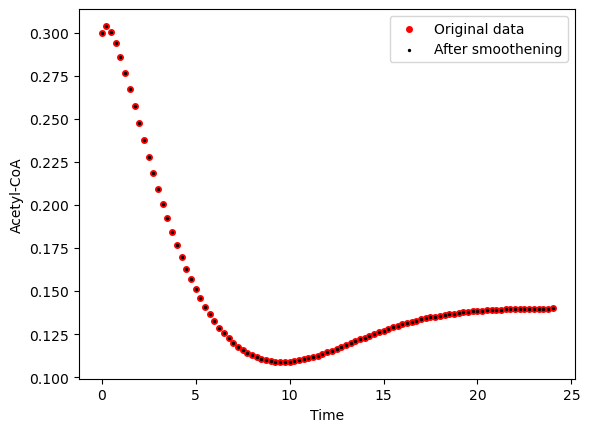

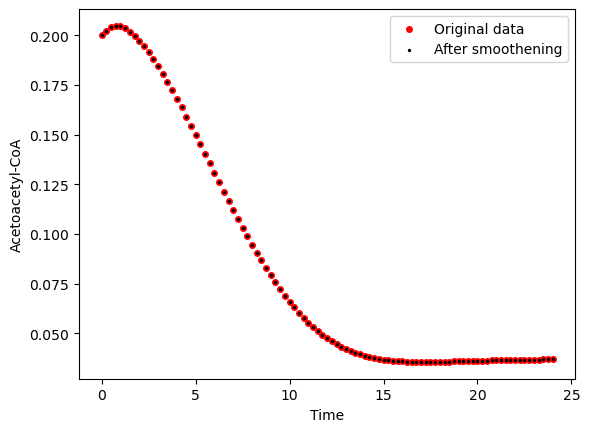

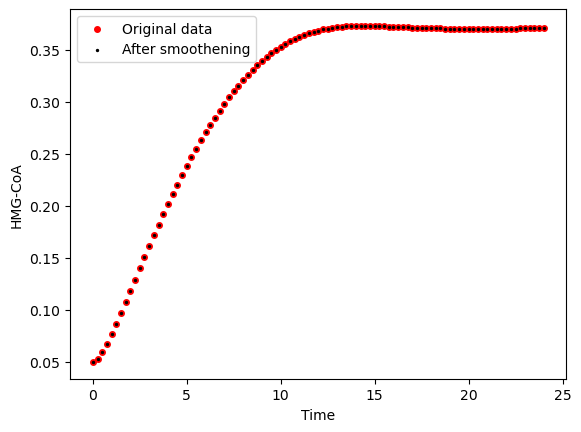

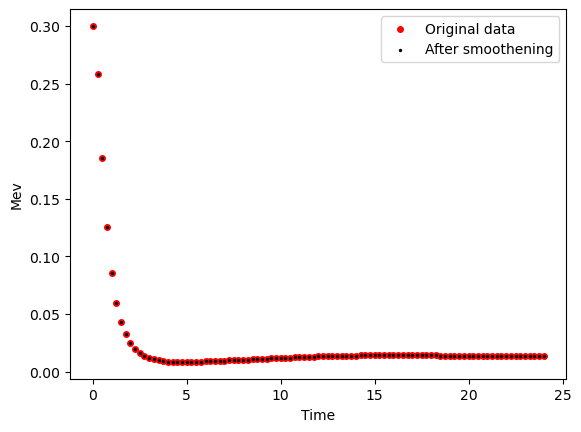

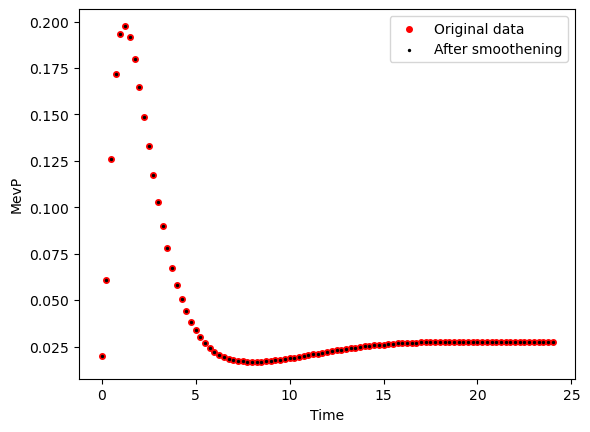

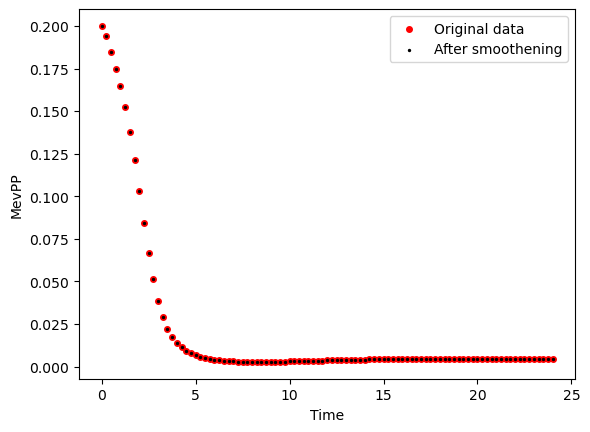

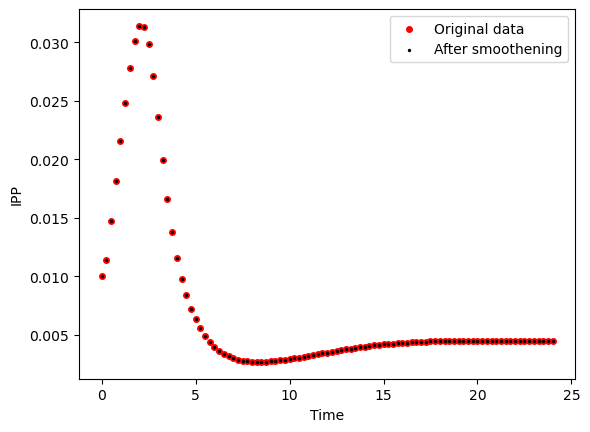

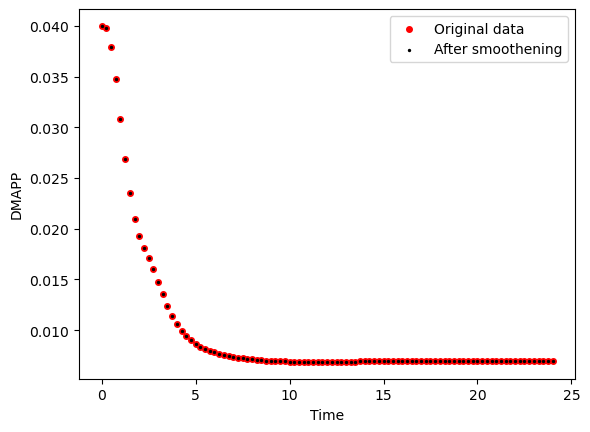

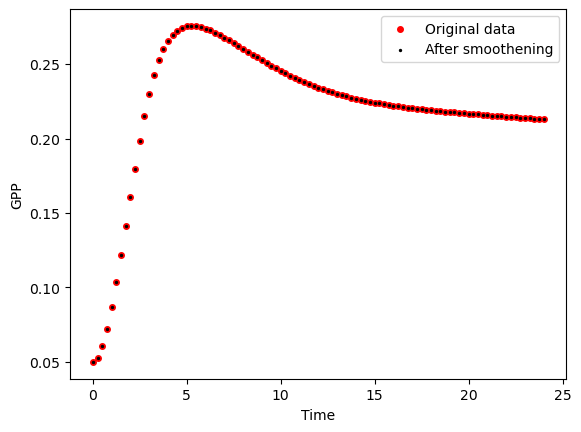

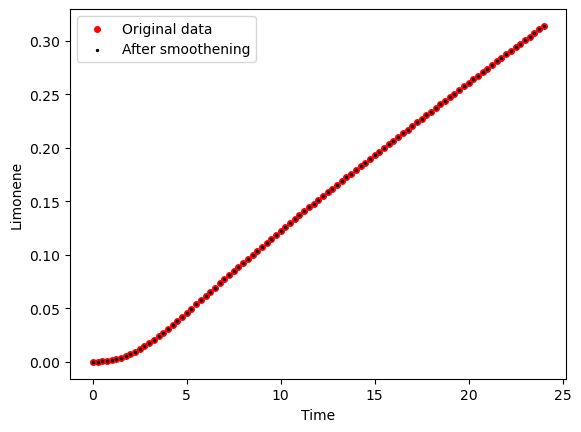

Strain Strain 2


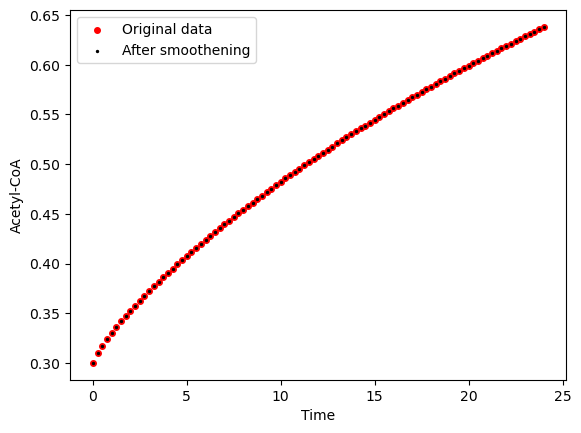

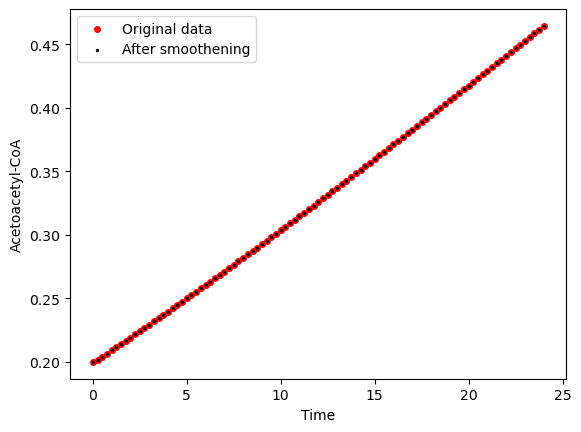

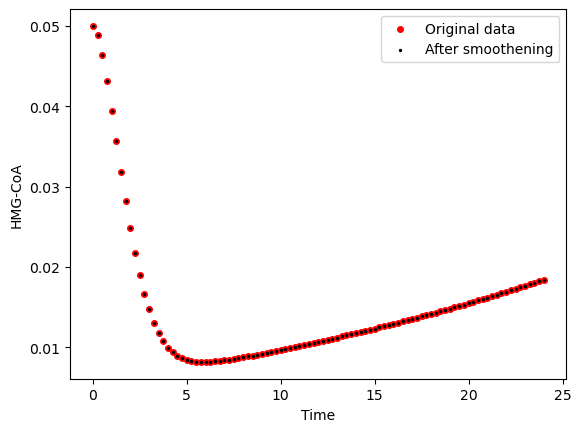

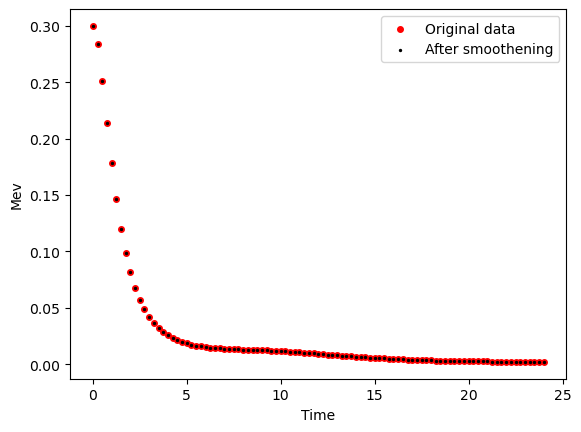

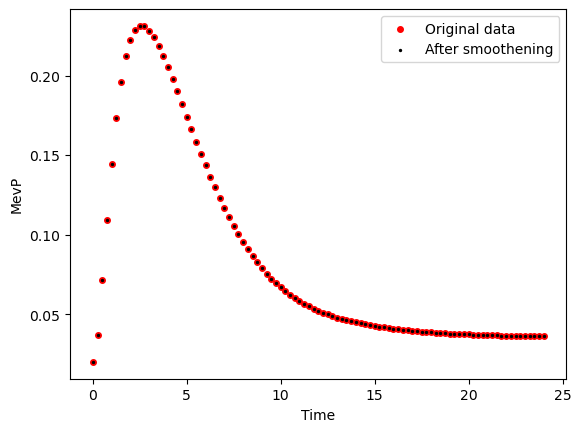

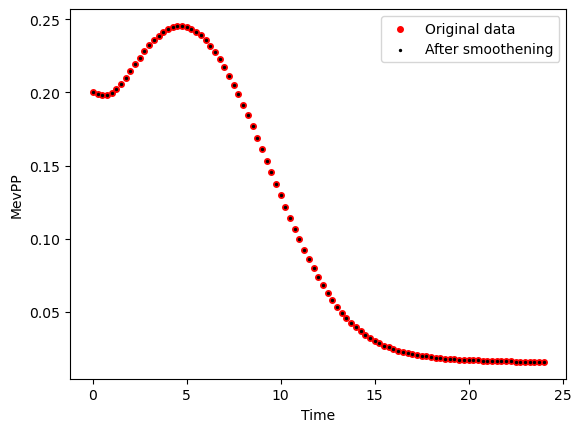

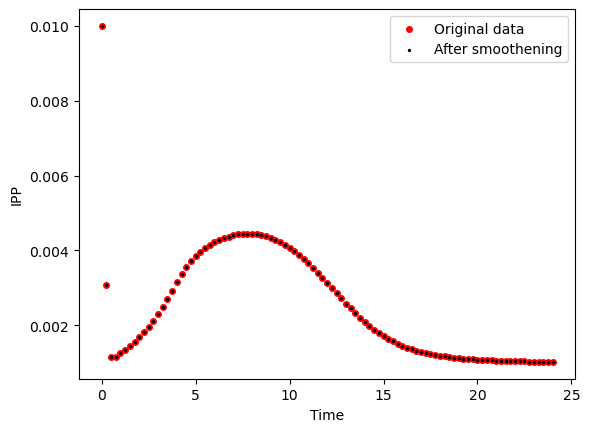

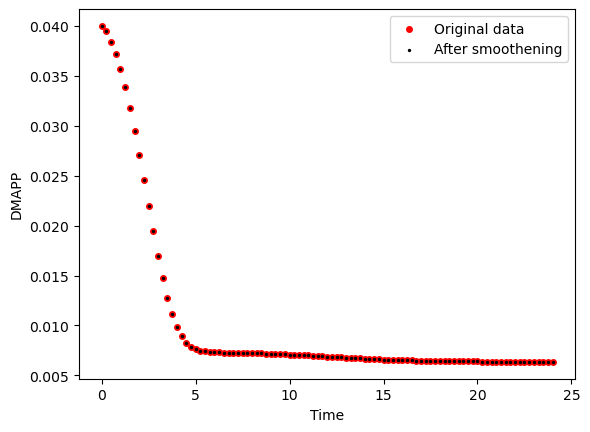

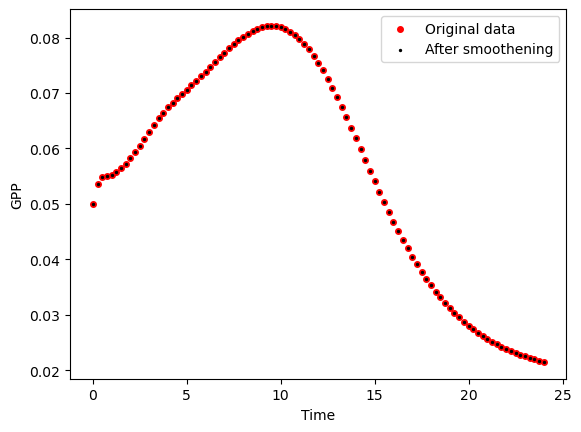

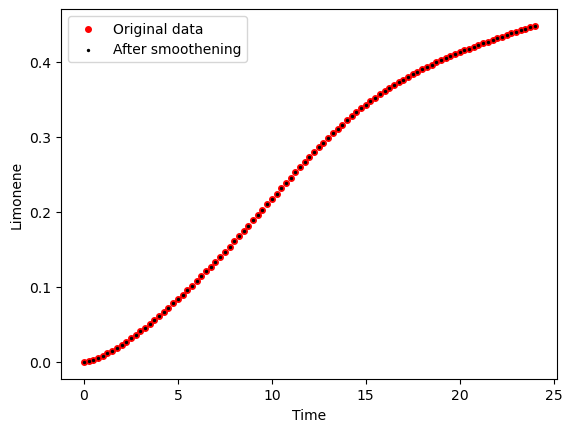

Strain Strain 3


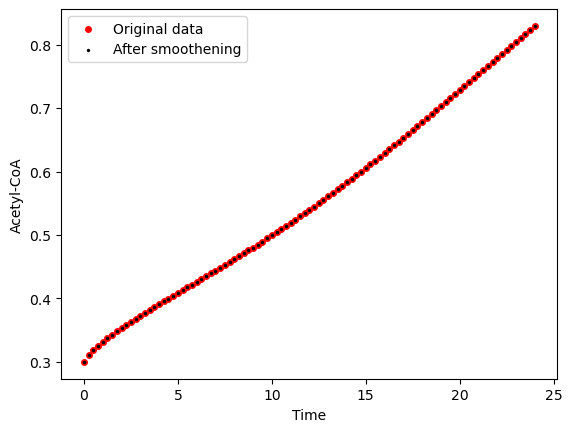

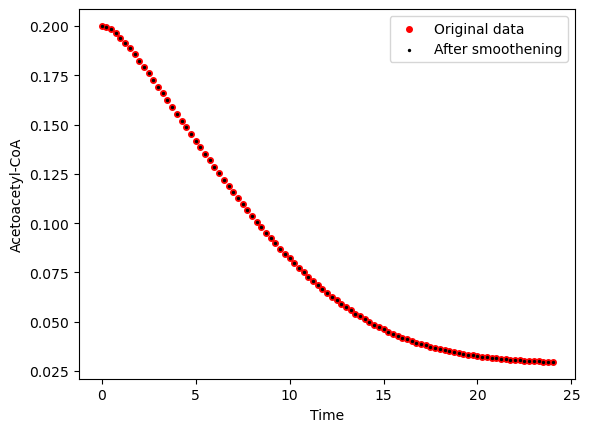

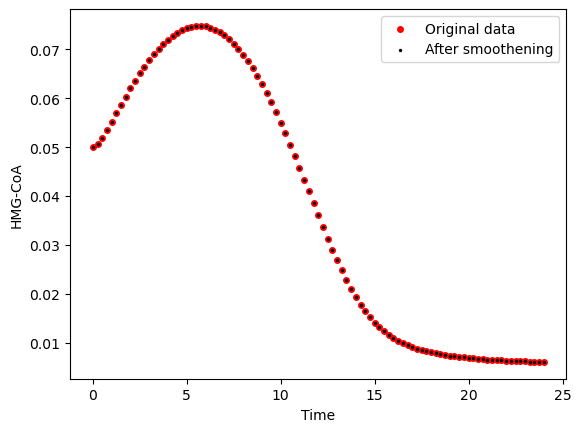

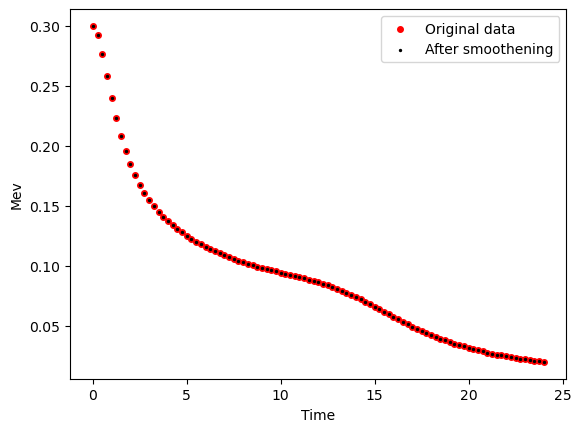

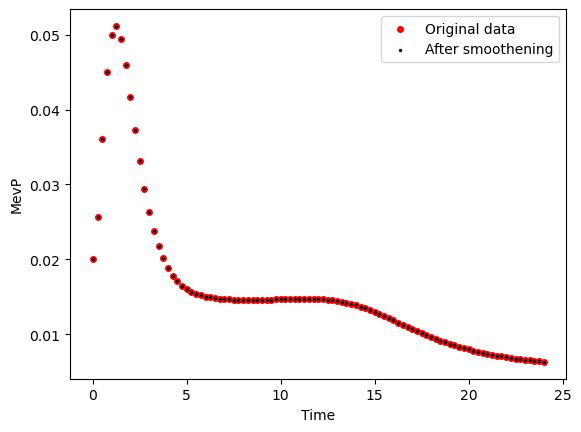

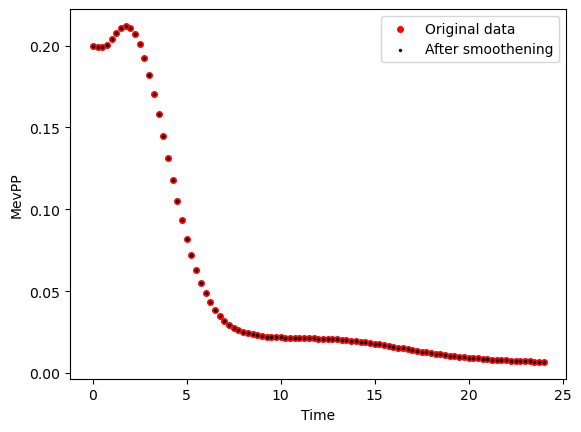

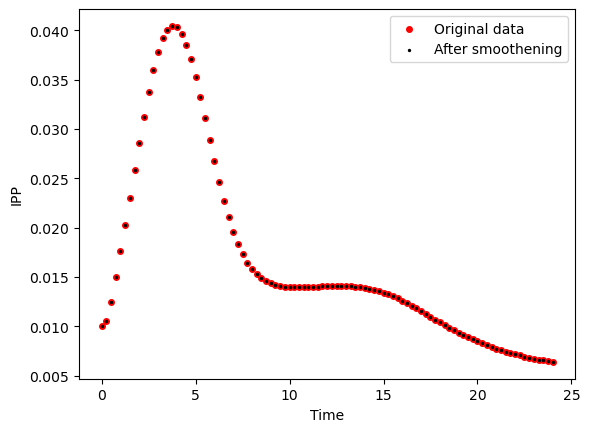

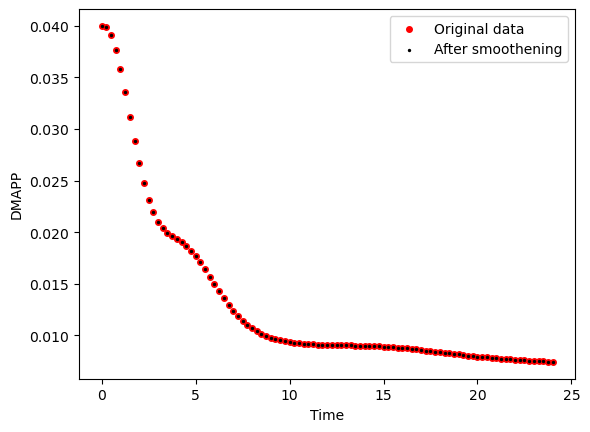

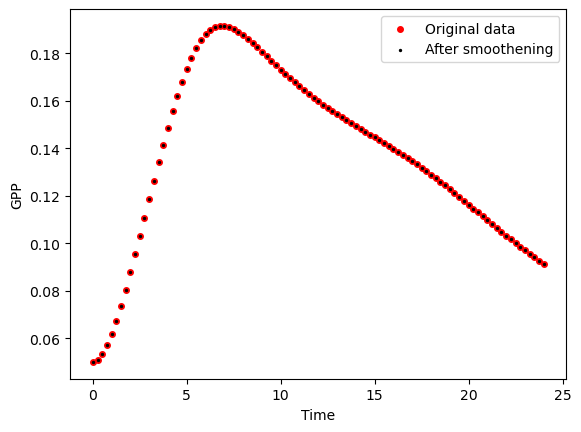

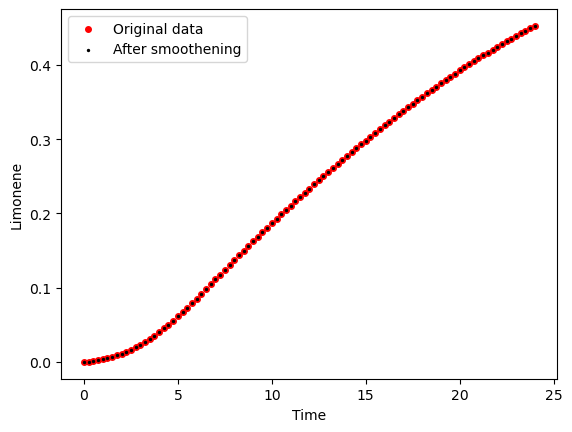

Strain WT


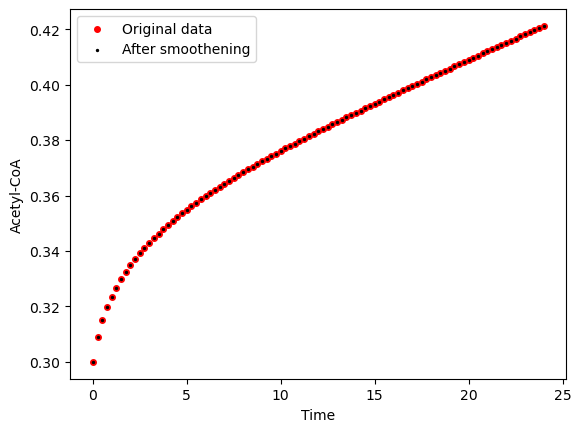

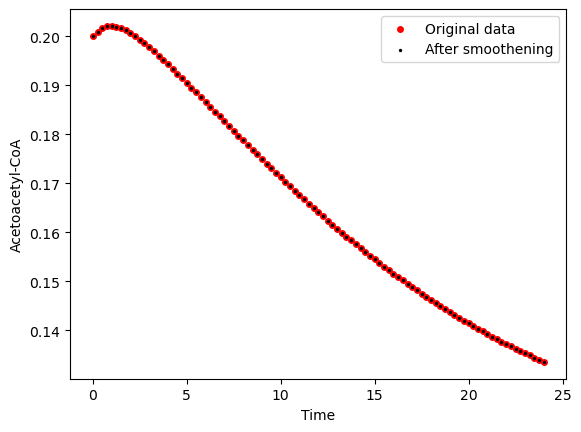

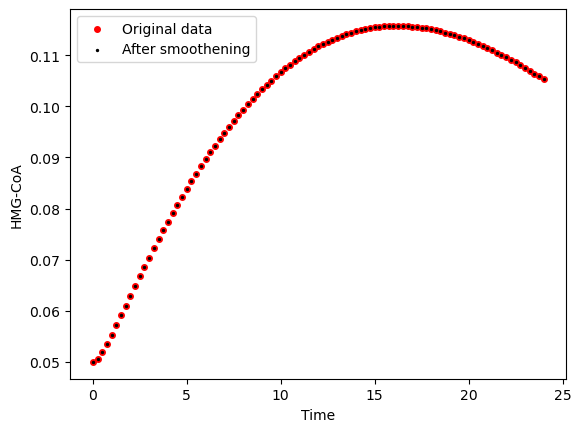

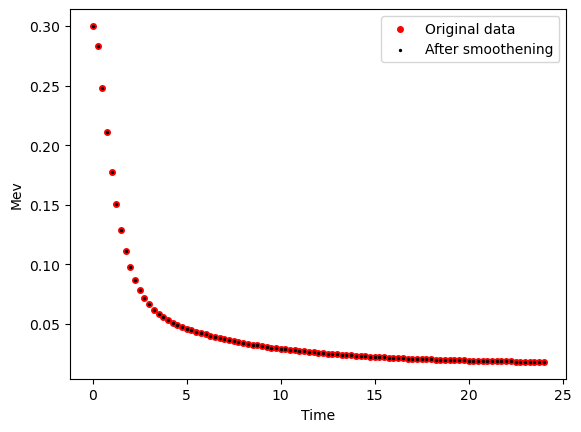

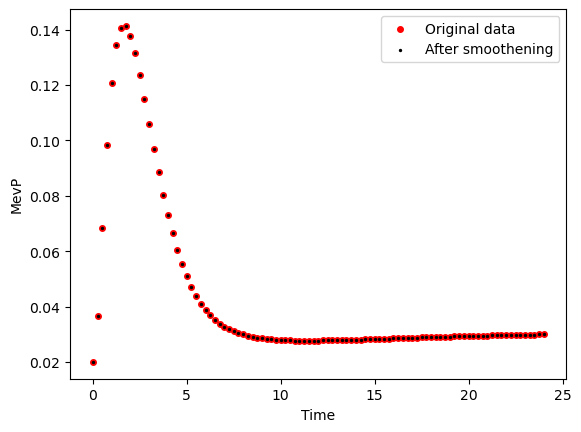

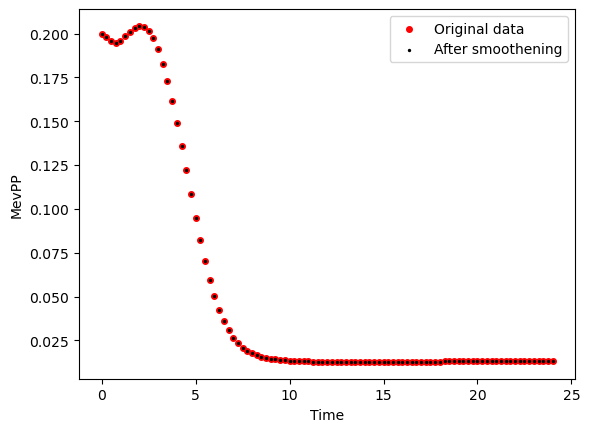

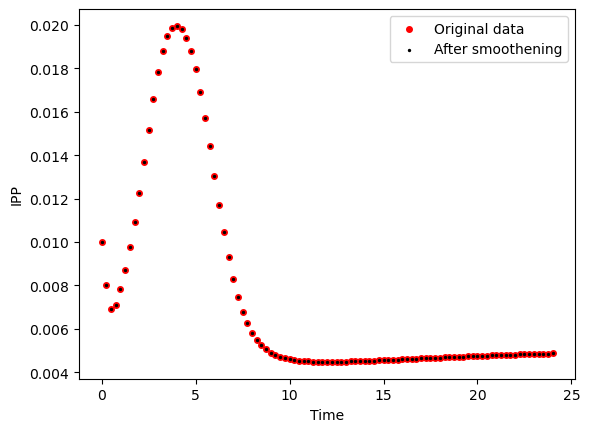

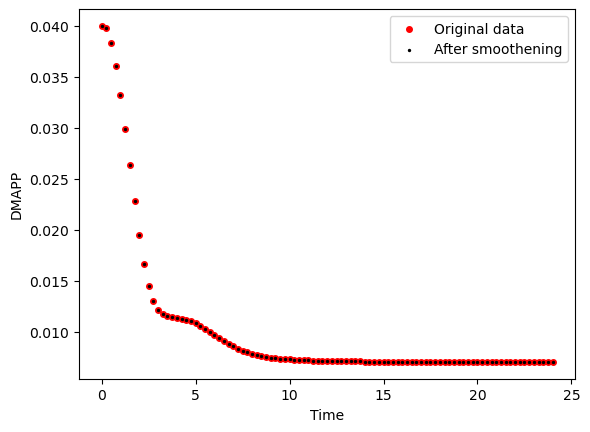

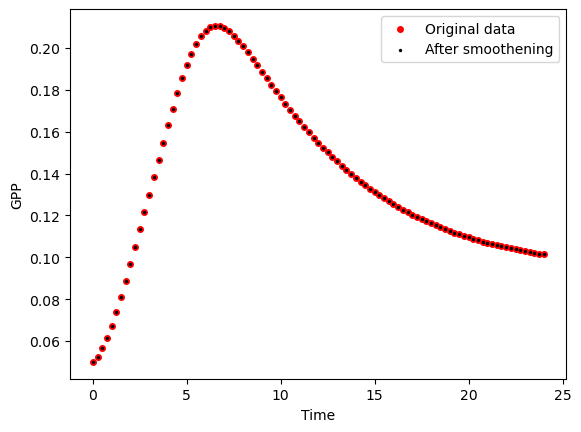

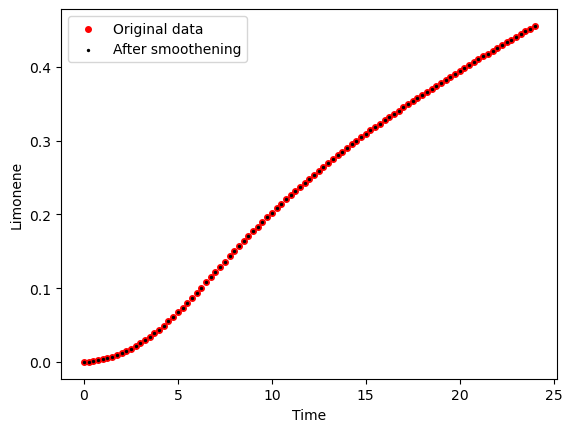

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


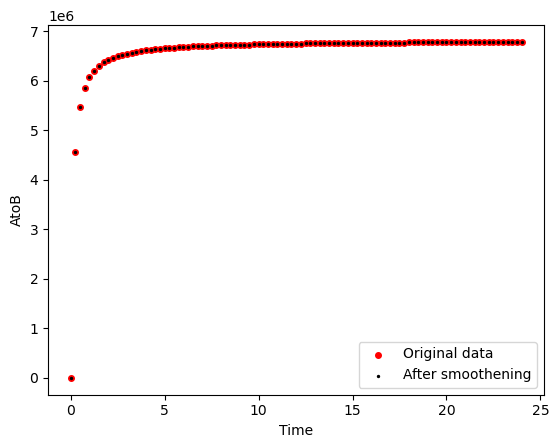

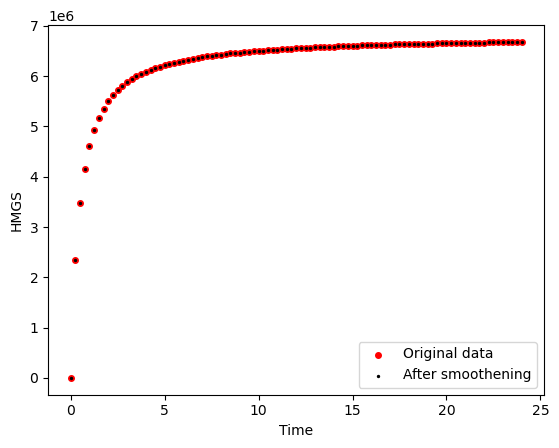

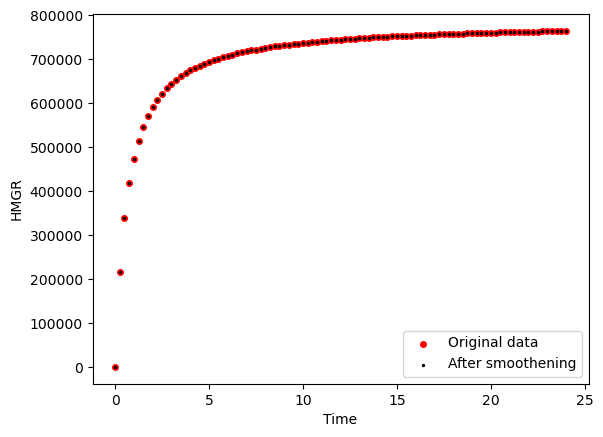

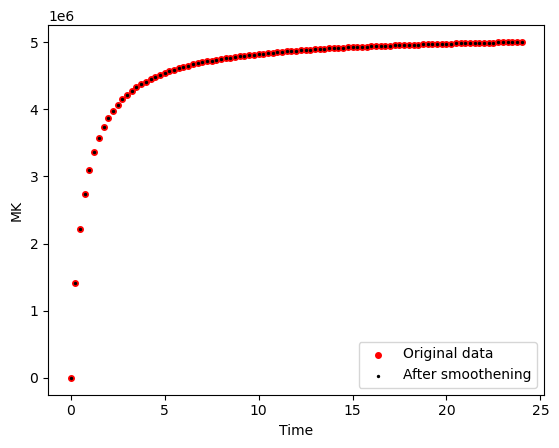

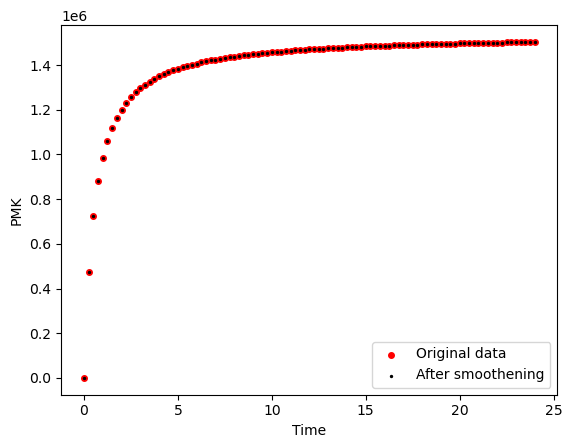

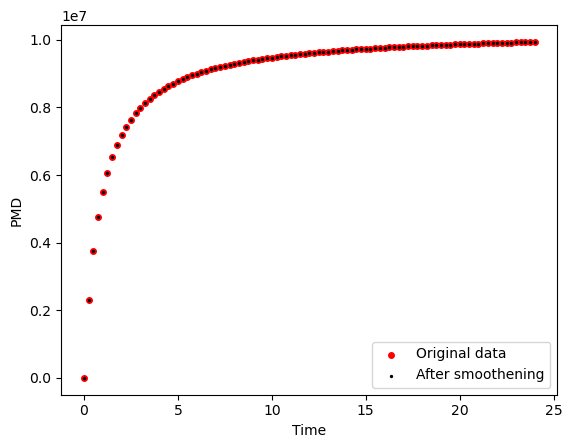

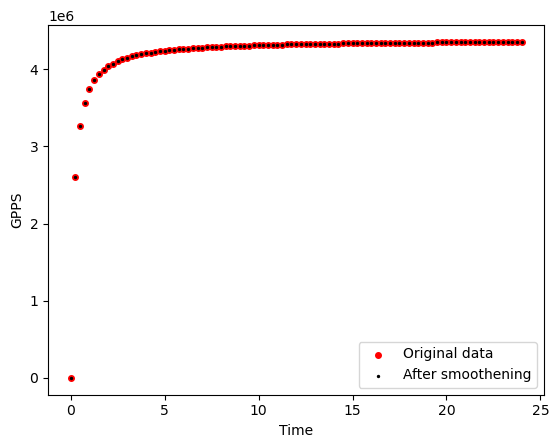

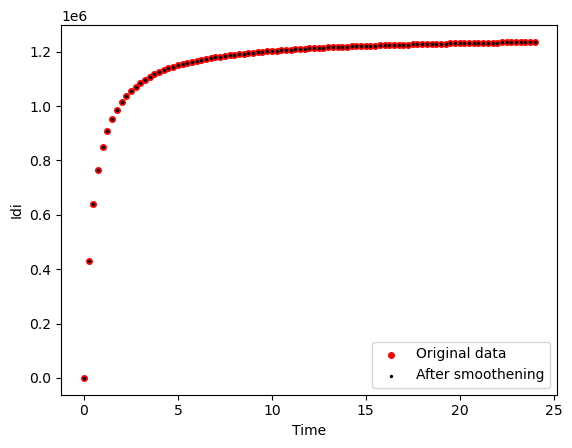

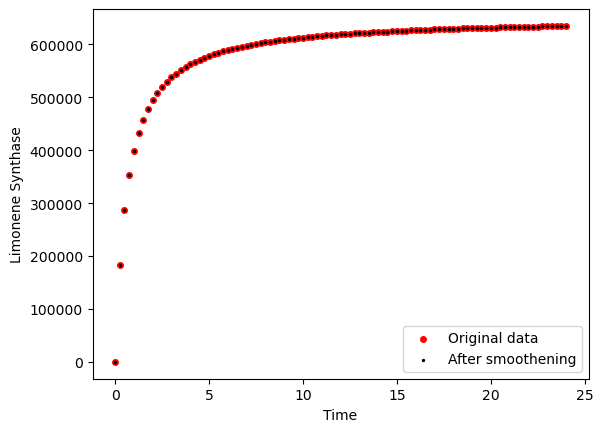

Strain Strain 2


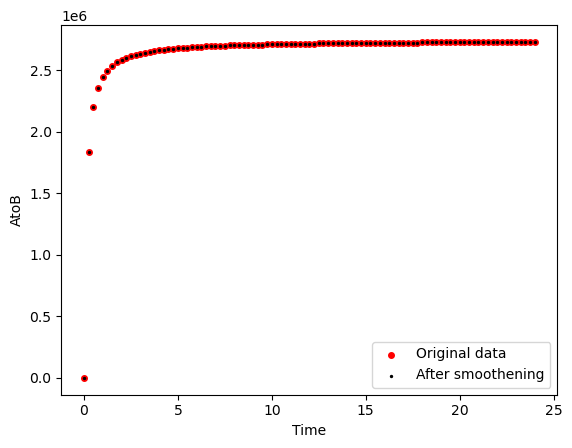

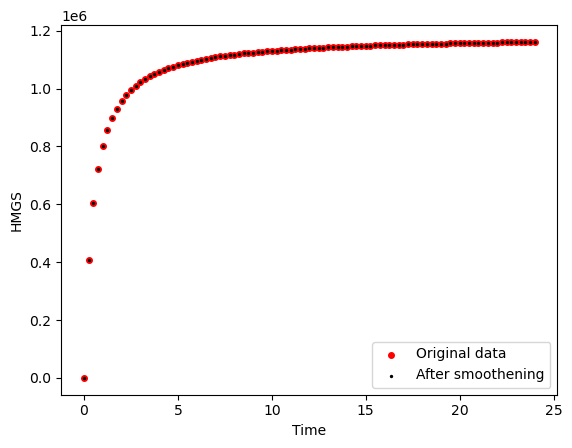

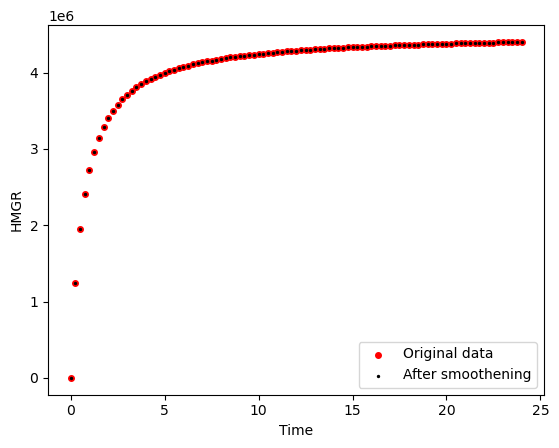

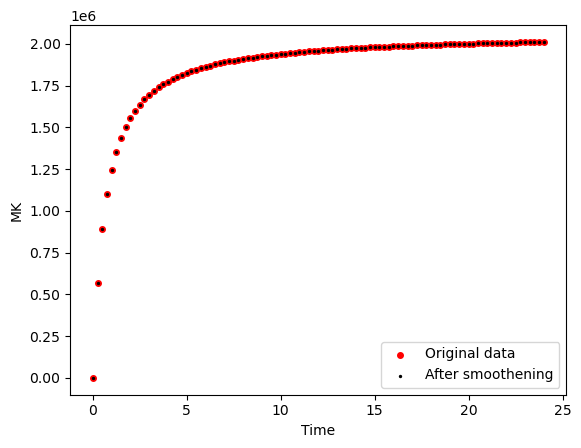

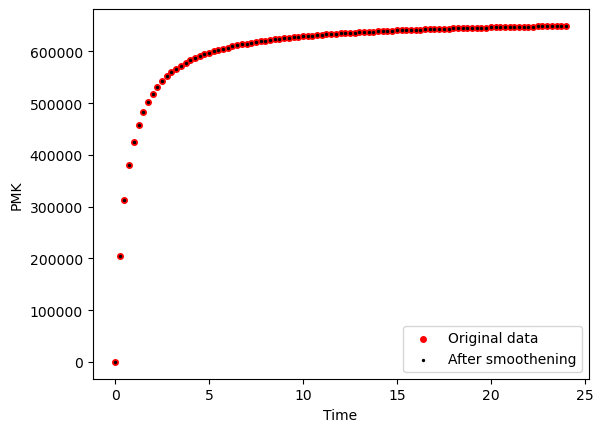

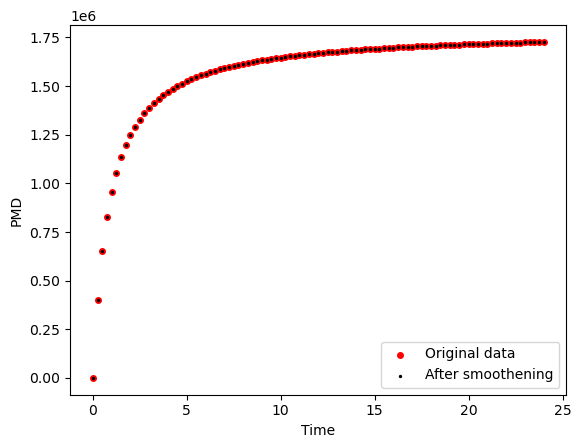

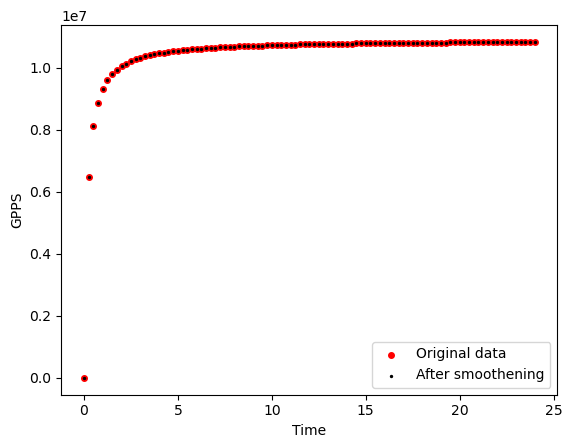

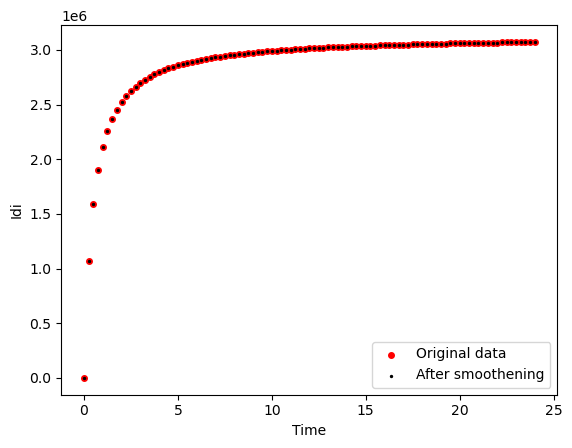

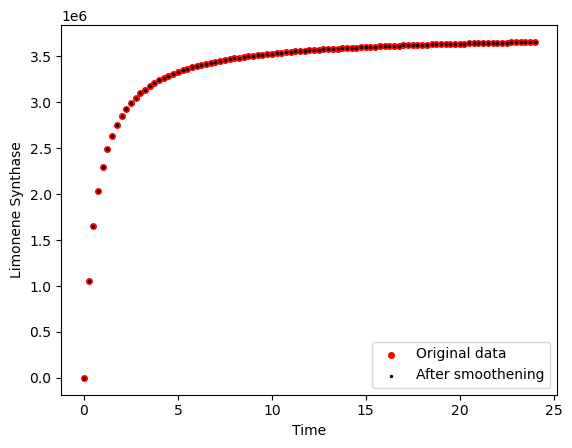

Strain Strain 3


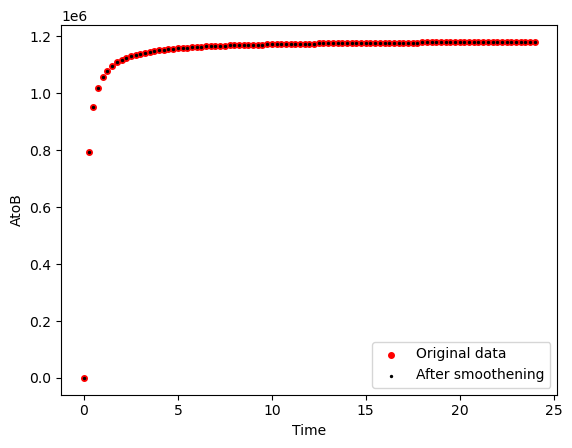

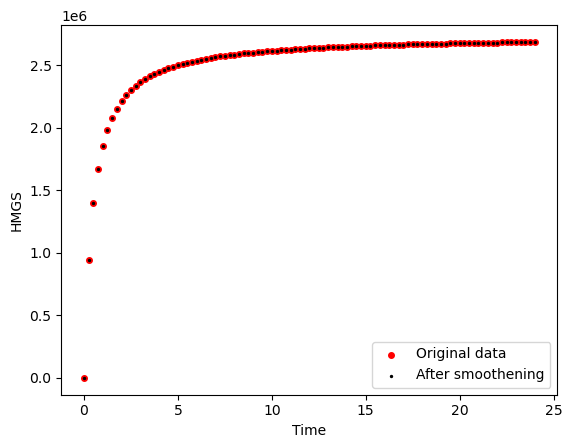

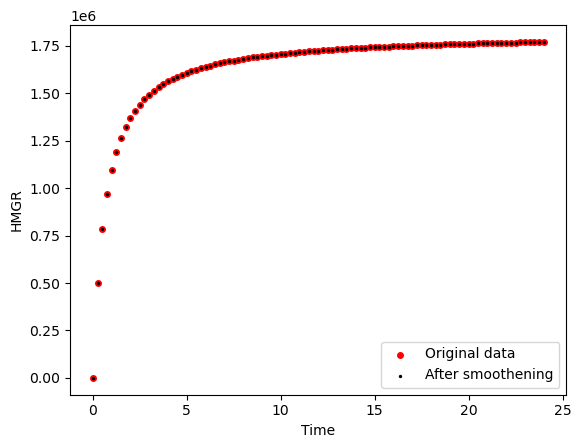

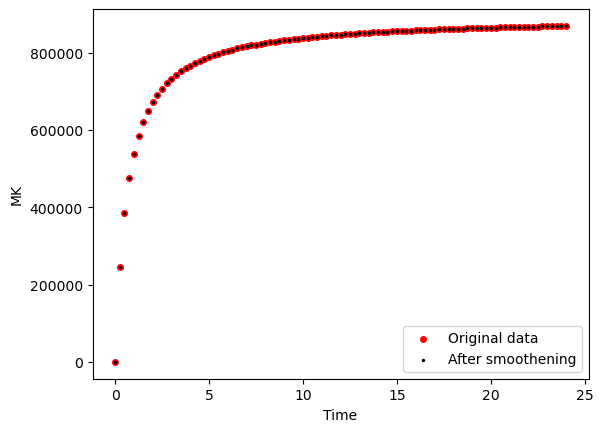

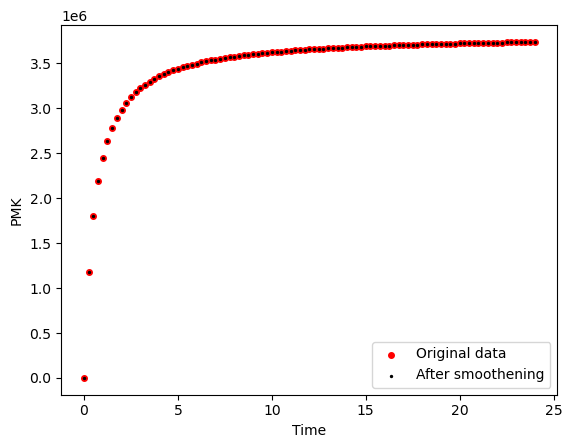

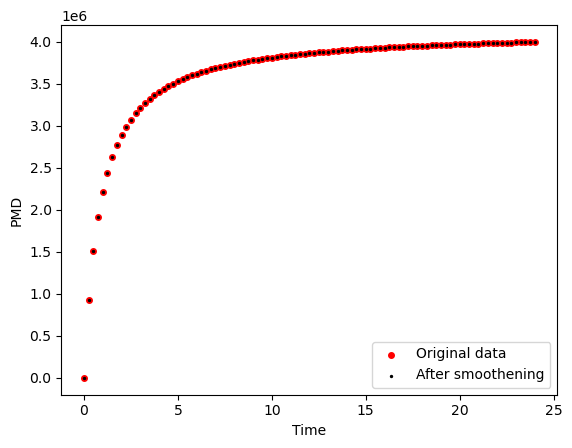

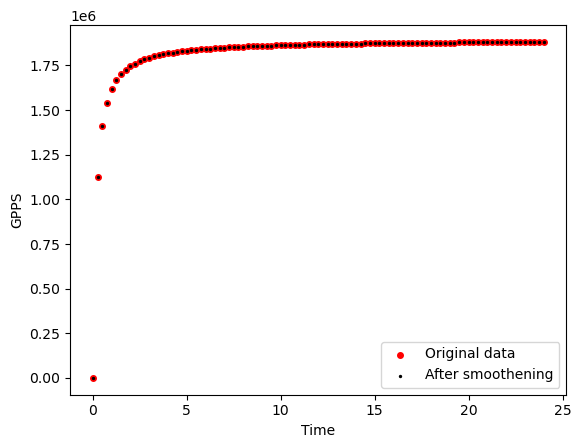

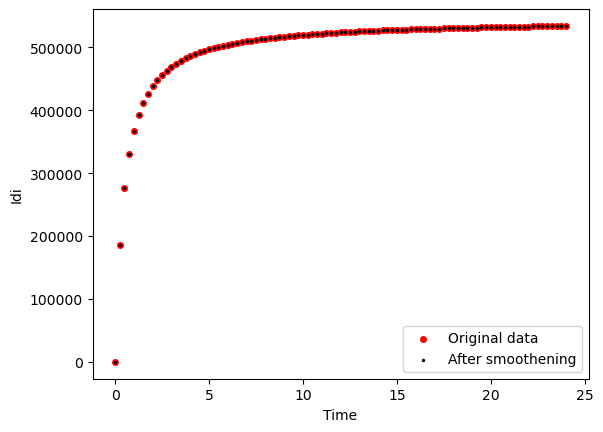

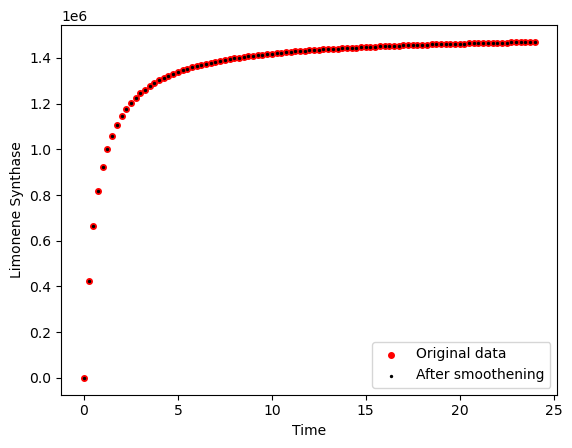

Strain WT


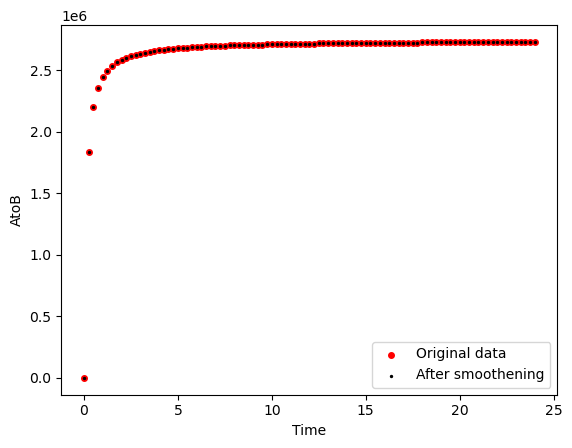

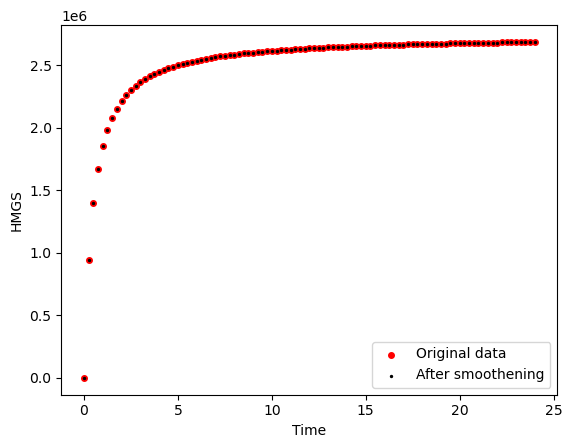

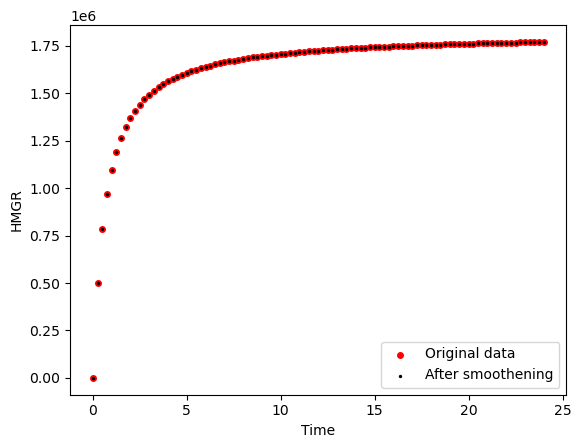

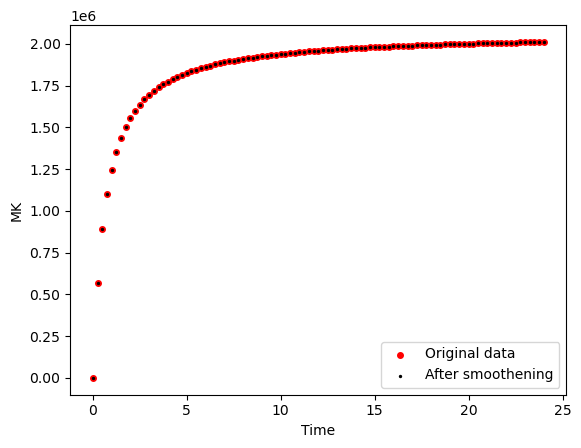

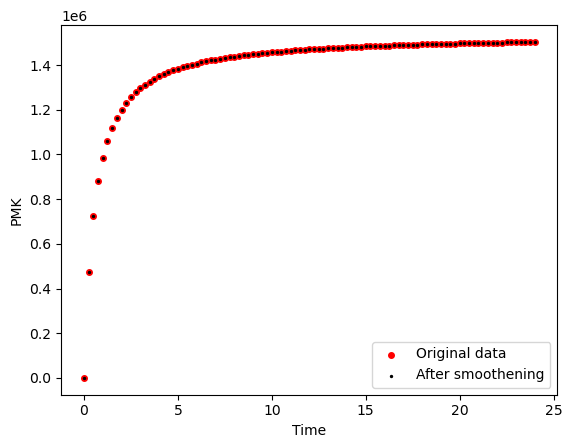

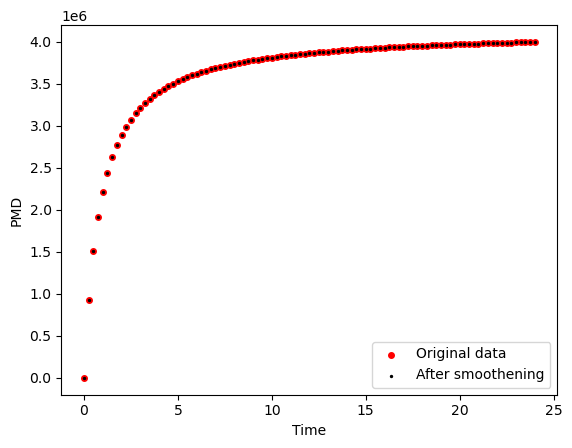

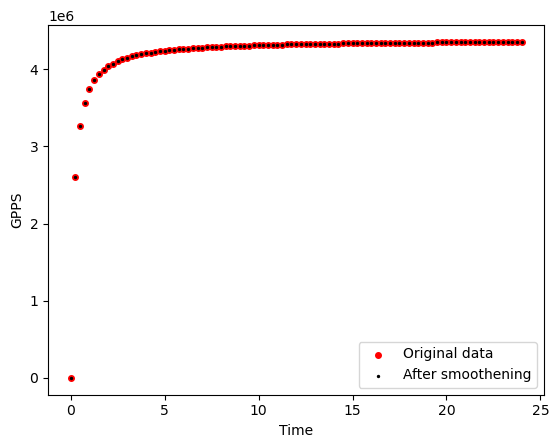

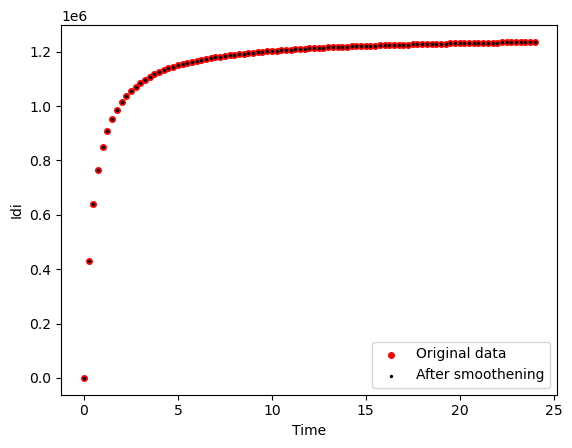

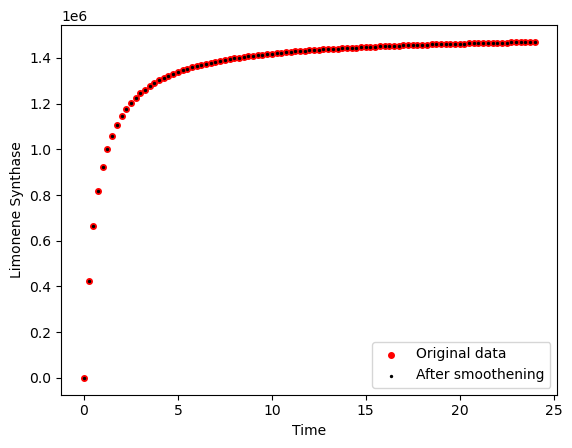

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50    0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75    0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00    0.285682        0.204435  0.076846  0.085674  0.193388   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.418135        0.135344  0.107524  0.018433  0.029820   
         23.25   0.418894        0.134891  0.106975  0.018376  0.029853   
         23.50   0.419652        0.134446  0.106413  0.018321  0.029884   
         23.75   0.420408        0.134009  0.105838  0.018268  0.029914   
         24.00   0.421163        0.133581  0.105252  0.018217  0.029943   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.194292  0.011434  0.039765  0.052914  0.000130  ...   
         0.50   0.184541  0.014747  0.037935  0.060579  0.000468  ...   
         0.75   0.174893  0.018155  0.034722  0.072187  0.000997  ...   
         1.00   0.164537  0.021526  0.030790  0.086852  0.001739  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.013294  0.004839  0.007023  0.102943  0.440720  ...   
         23.25  0.013307  0.004846  0.007023  0.102536  0.444453  ...   
         23.50  0.013319  0.004852  0.007023  0.102148  0.448172  ...   
         23.75  0.013331  0.004858  0.007022  0.101776  0.451879  ...   
         24.00  0.013342  0.004864  0.007022  0.101420  0.455574  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

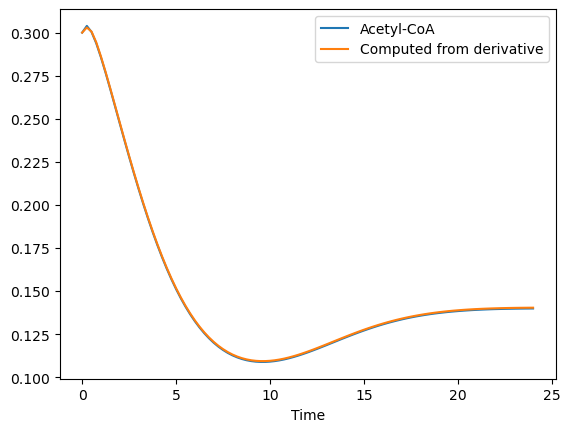

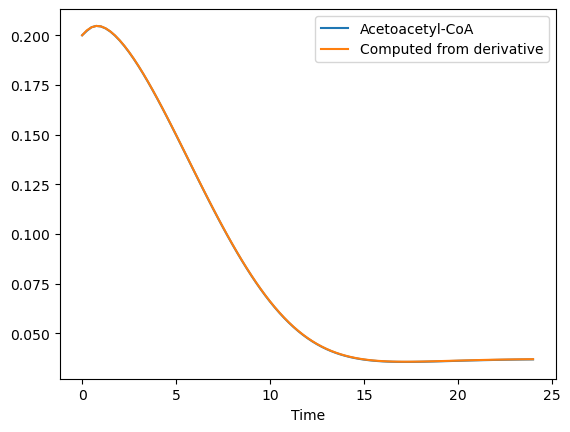

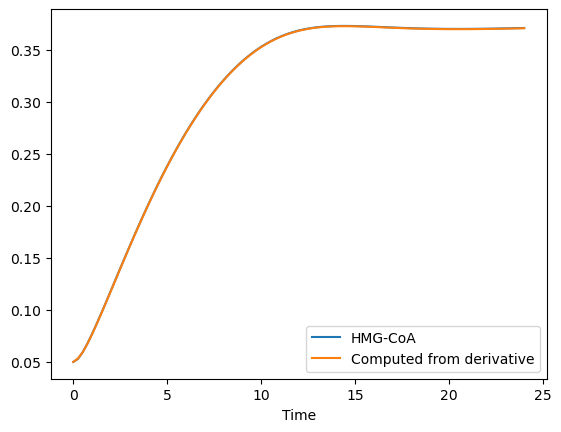

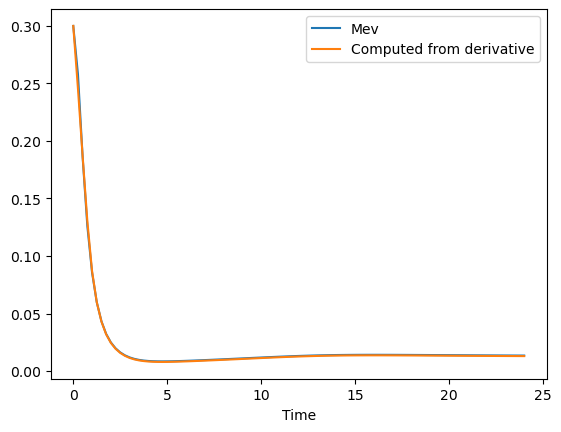

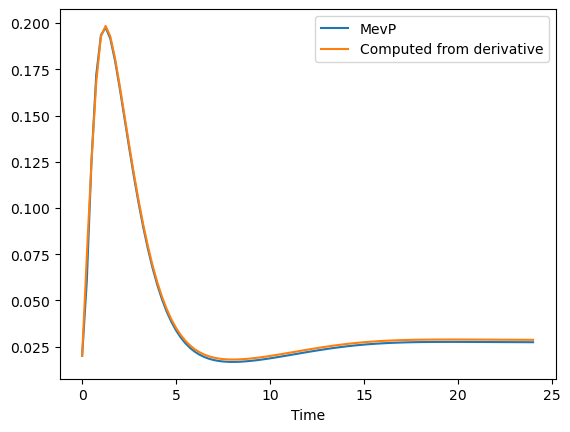

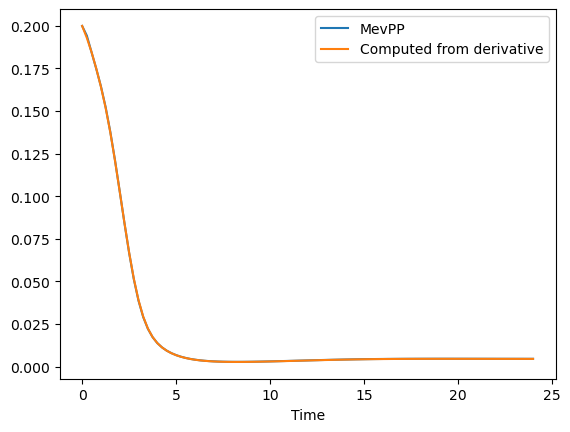

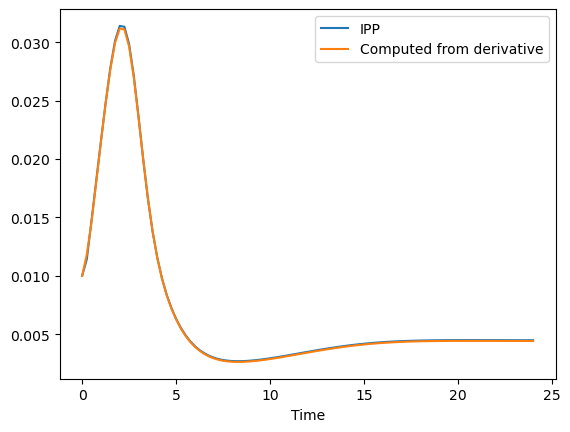

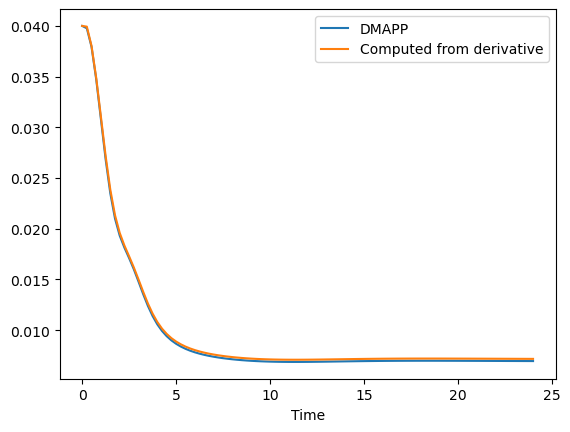

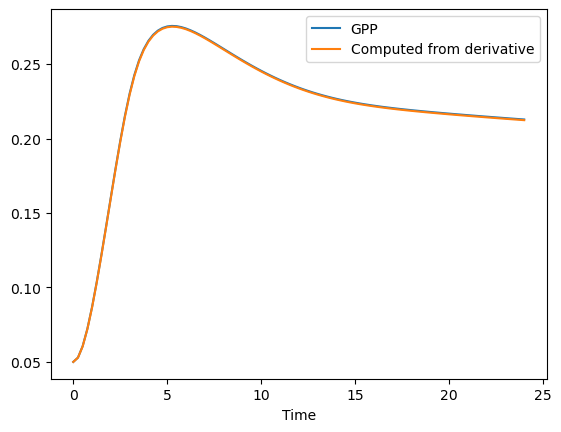

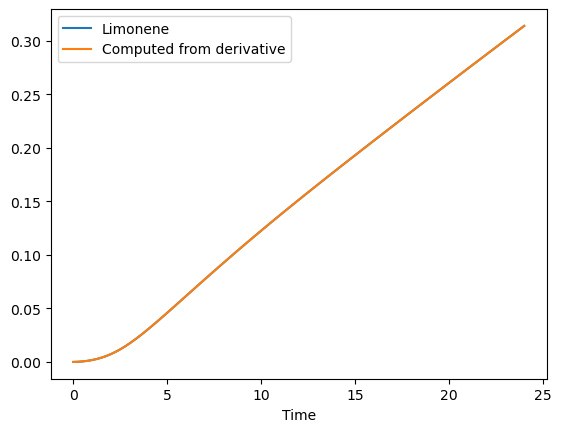

'Time profile from derivative vs. actual profile for Strain 2'

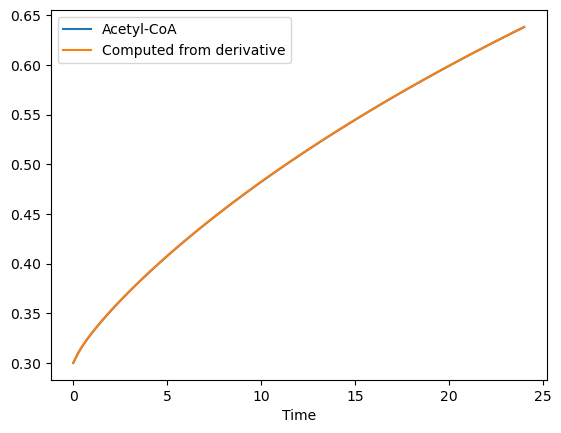

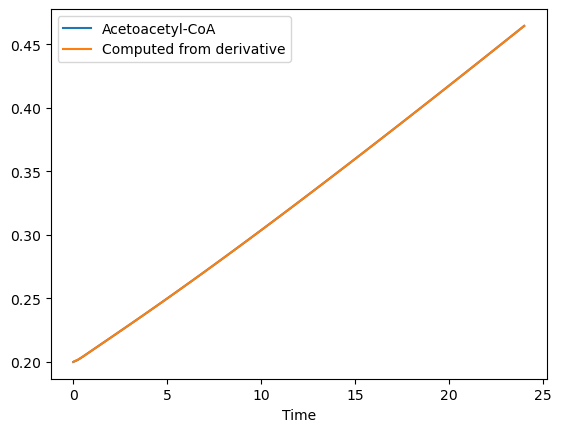

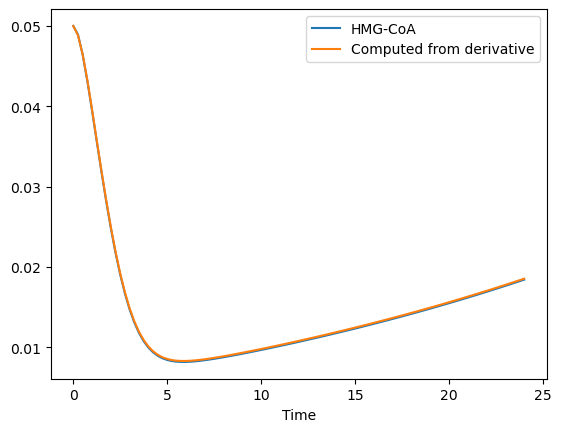

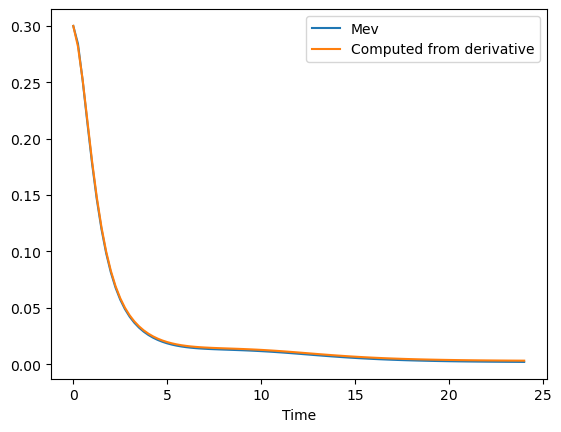

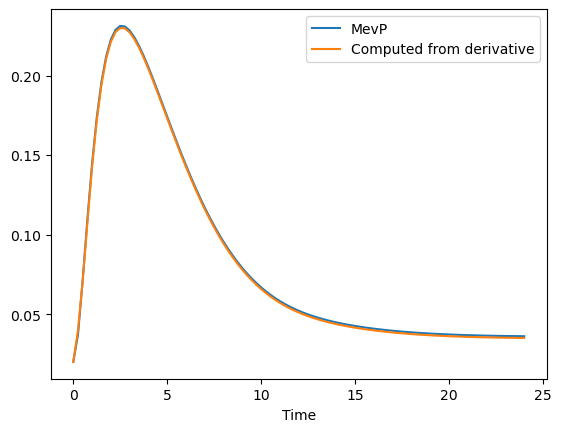

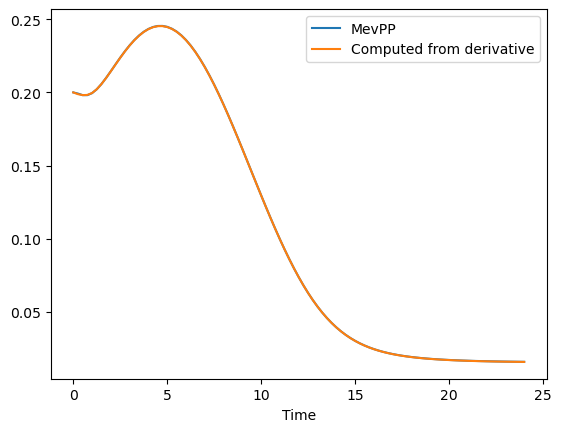

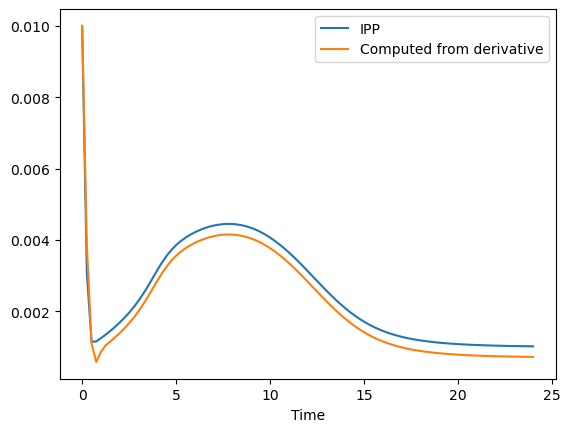

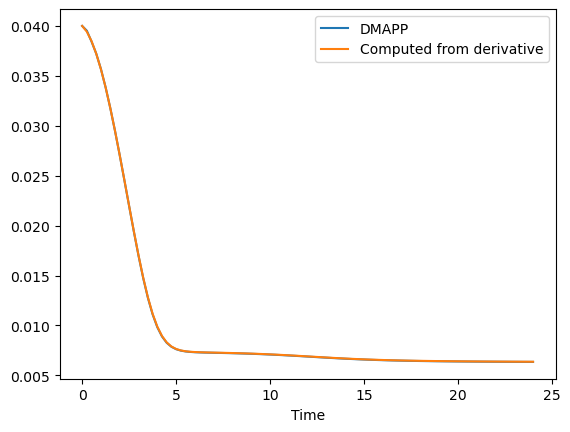

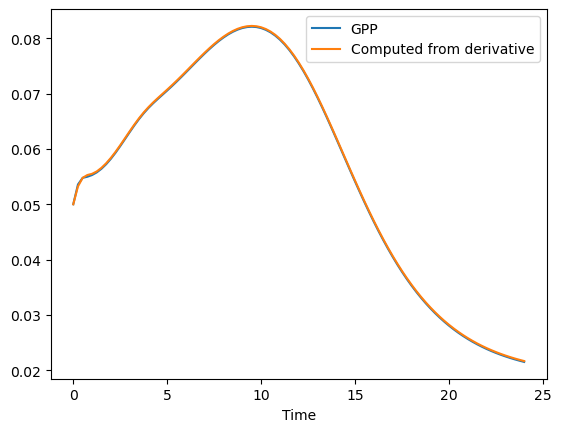

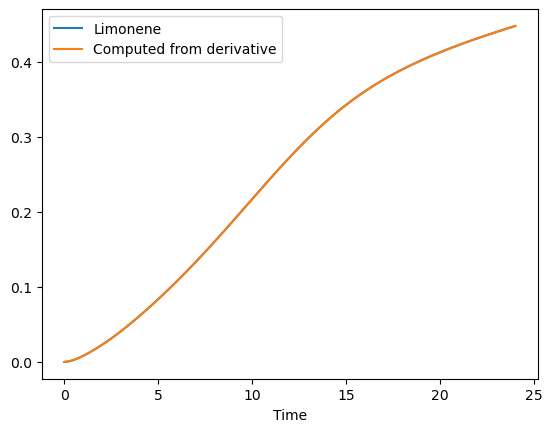

'Time profile from derivative vs. actual profile for Strain 3'

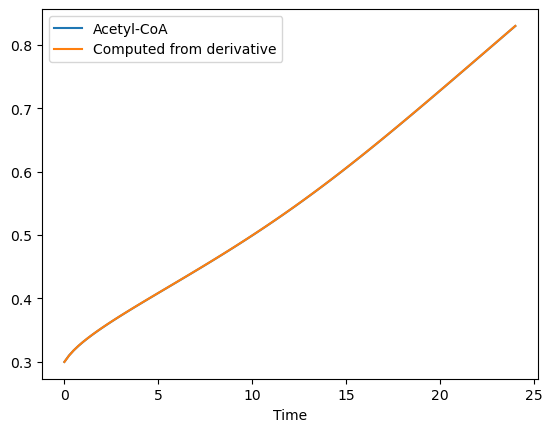

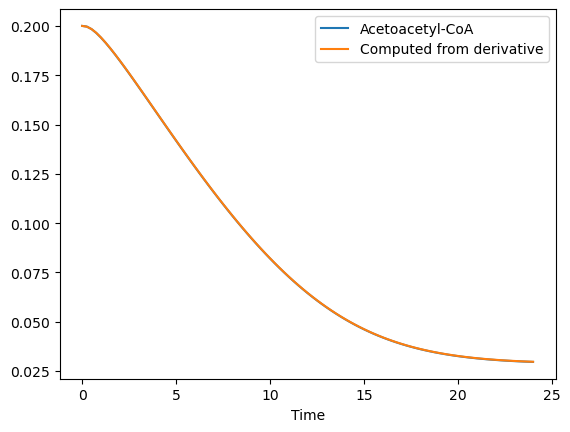

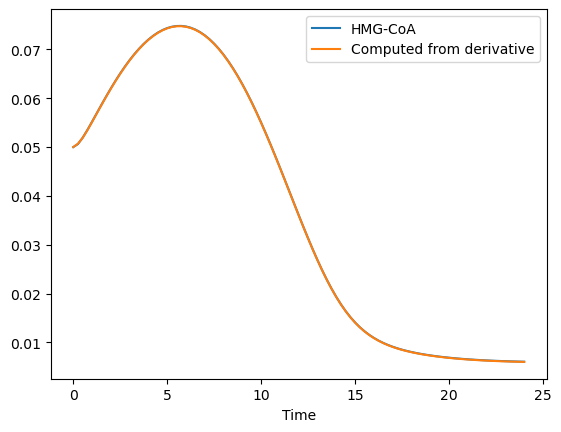

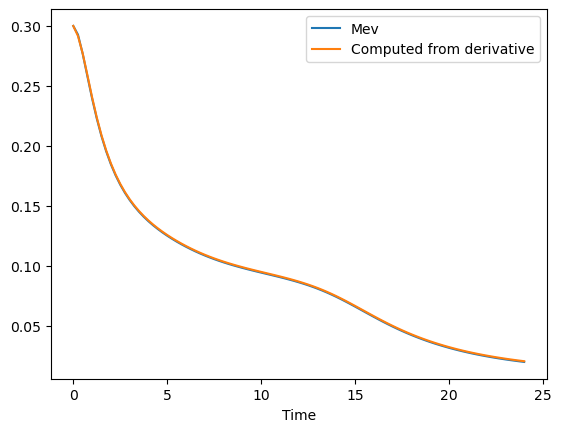

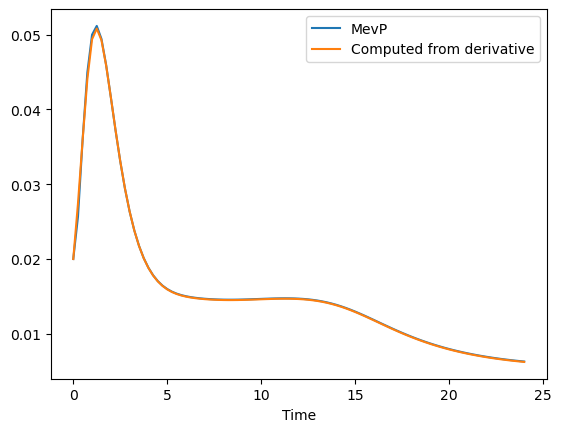

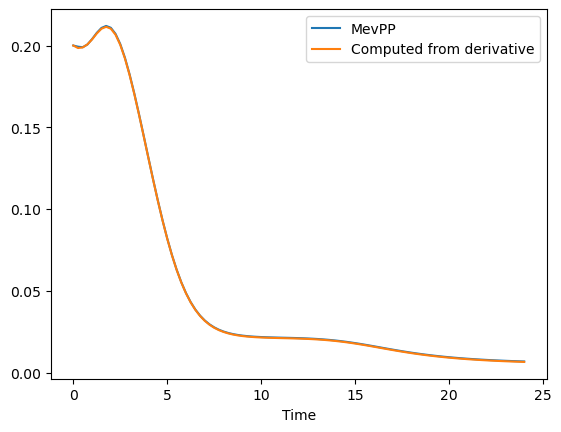

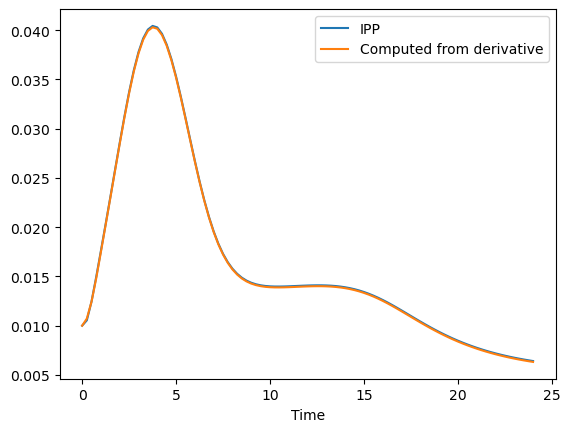

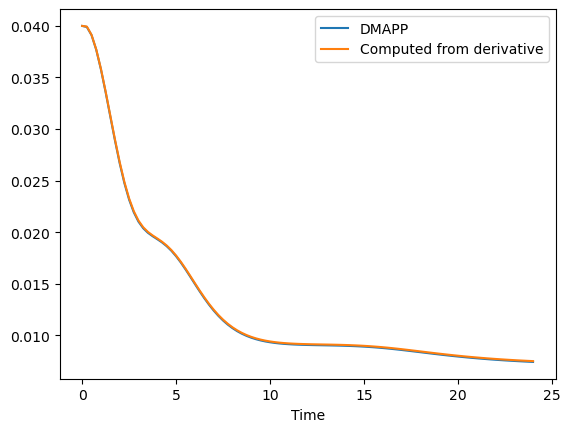

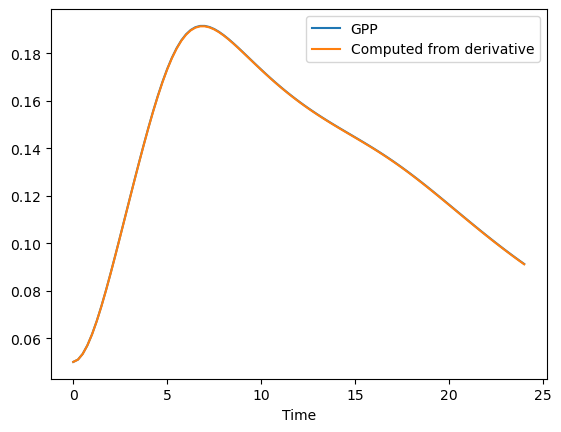

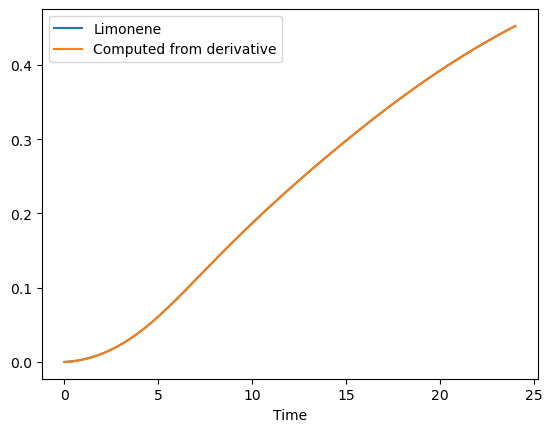

'Time profile from derivative vs. actual profile for WT'

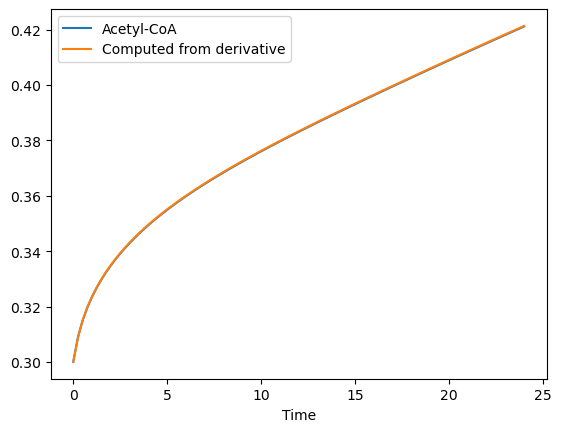

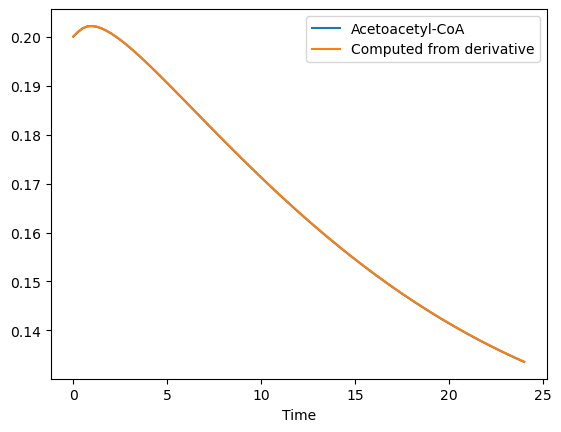

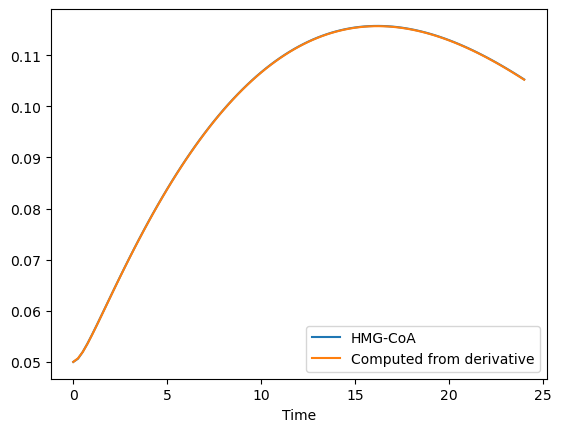

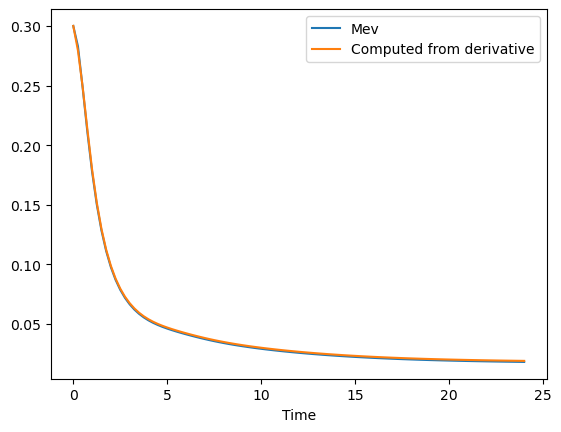

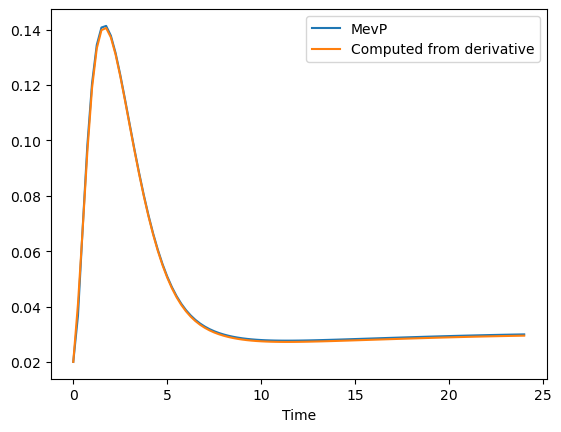

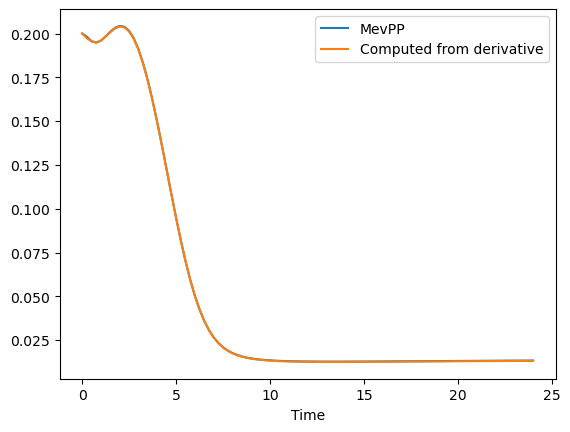

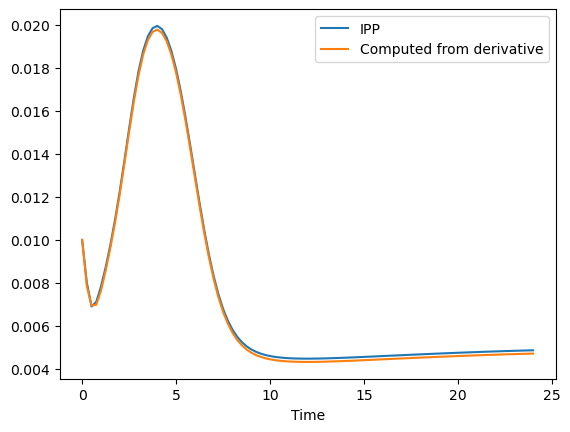

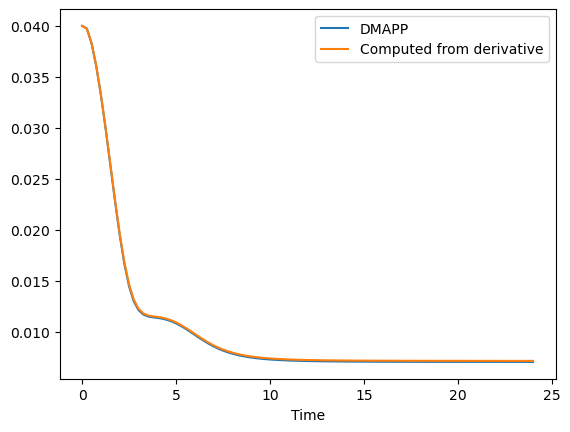

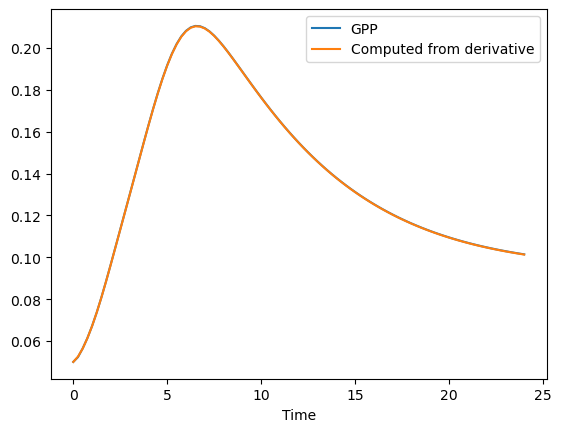

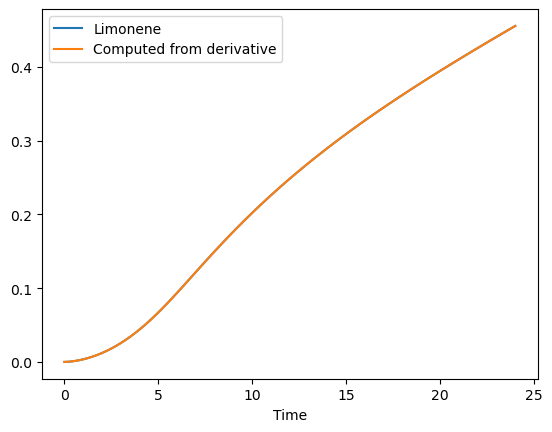

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303889        0.202239  0.052901   
         0.50       2.866143e+05   0.300366        0.204051  0.059318   
         0.75       3.524272e+05   0.293825        0.204705  0.067553   
         1.00       3.981392e+05   0.285682        0.204435  0.076846   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.418135        0.135344  0.107524   
         23.25      1.468435e+06   0.418894        0.134891  0.106975   
         23.50      1.468851e+06   0.419652        0.134446  0.106413   
         23.75      1.469260e+06   0.420408        0.134009  0.105838   
         24.00      1.469659e+06   0.421163        0.133581  0.105252   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257973  0.060732  0.194292  0.011434  0.039765  0.052914   
         0.50   0.185505  0.126153  0.184541  0.014747  0.037935  0.060579   
         0.75   0.125893  0.171899  0.174893  0.018155  0.034722  0.072187   
         1.00   0.085674  0.193388  0.164537  0.021526  0.030790  0.086852   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.018433  0.029820  0.013294  0.004839  0.007023  0.102943   
         23.25  0.018376  0.029853  0.013307  0.004846  0.007023  0.102536   
         23.50  0.018321  0.029884  0.013319  0.004852  0.007023 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         24.00  0.000044  0.000023 -0.000001 -0.001390  0.014756  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,
                             -12.0,0.0,-12.0,-12.0,
                             0.0,-12.0,-12.0,0.0,
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,-12.0,
                             0.0,0.0,
                             -12.0,-12.0,-12.0,
                             0.0,-12.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0,0.0,
                             0.0,0.0,0.0,
                             0.0,12.0,0.0,0.0,
                             12.0,0.0,0.0,12.0,
                             0.0,0.0,
                             0.0,0.0,0.0,0.0,
                             12.0,12.0,
                             0.0,0.0,0.0,
                             12.0,0.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       kma11,kcat1,
                       kma21,kma22,kcat2,
                       kma33,kI31,kI32,kcat3,
                       kma44,kI46,kI49,kcat4,
                       kma55,kcat5,
                       kma66,kI64,kI65,kcat6,
                       kma77,kcat7,
                       kma87,kma88,kcat8,
                       kma99,kcat9,
                       Vin): #HC: 27
    
        s11_hat = s1 / (10**kma11)
        r1 = e1 *(10**kcat1) *(s11_hat**2)/(1 + s11_hat + s11_hat**2)  # AtoB
        
        s21_hat = s1 / (10**kma21)
        s22_hat = s2 / (10**kma22)
        r2 = e2 *(10**kcat2) *s21_hat *s22_hat/(1 +s21_hat +s22_hat +s21_hat*s22_hat) # HMGS
        
        s33_hat = s3/ (10**kma33)
        h31 = (10**kI31) /( (10**kI31) + s1)
        h32 = (10**kI32) /( (10**kI32) + s2)
        r3 = h31 *h32 *e3 * (10**kcat3) *s33_hat / (1 + s33_hat) # HMGR

        s44_hat = s4/ (10**kma44)
        h46 = (10**kI46) /( (10**kI46) + s6)
        h49 = (10**kI49) /( (10**kI49) + s9)
        r4 = h46 *h49 *e4 * (10**kcat4) *s44_hat / (1 + s44_hat) # MK

        s55_hat = s5/ (10**kma55)
        r5 = e5 *(10**kcat5) *s55_hat / (1 + s55_hat) # PMK

        s66_hat = s6/ (10**kma66)
        h64 = (10**kI64) /( (10**kI64) + s4)
        h65 = (10**kI65) /( (10**kI65) + s5)
        r6 = h64 *h65 *e6 *(10**kcat6) *s66_hat / (1 + s66_hat) # PMD

        s77_hat = s7/ (10**kma77)
        r7 = e7 *(10**kcat7) *s77_hat / (1 + s77_hat) # IDI

        s87_hat = s7 / (10**kma87)
        s88_hat = s8 / (10**kma88)
        r8 = e8 *(10**kcat8) *s87_hat *s88_hat/(1 +s87_hat +s88_hat +s87_hat*s88_hat) # GPPS

        s99_hat = s9/ (10**kma99)
        r9 = e9 *(10**kcat9) *s99_hat / (1 + s99_hat) # LS           

        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  4.659625E+26 |  3.035233E+07
     2 |      128 |  7.907852E+24 |  1.709074E+02
     3 |      192 |  2.948405E+15 |  3.912284E+01
     4 |      256 |  1.649586E+10 |  3.424836E+01
     5 |      320 |  2.822585E+03 |  3.099842E+01
     6 |      384 |  3.384923E+01 |  2.764637E+01
     7 |      448 |  2.647101E+01 |  2.293478E+01
     8 |      512 |  2.400104E+01 |  2.245053E+01
     9 |      576 |  2.284215E+01 |  2.225303E+01
    10 |      640 |  2.243460E+01 |  2.205501E+01
    11 |      704 |  2.204706E+01 |  2.141250E+01
    12 |      768 |  2.146718E+01 |  2.087516E+01
    13 |      832 |  2.108939E+01 |  2.062154E+01
    14 |      896 |  2.073969E+01 |  2.032571E+01
    15 |      960 |  2.052054E+01 |  2.030250E+01
    16 |     1024 |  2.036853E+01 |  2.023538E+01
    17 |     1088 |  2.006323E+01 |  1.921274E+01
    18 |     1152 |  1.917668E+01 |  1.828736E+01
    19 |     1216 |  1.83

   162 |    10368 |  1.013014E+01 |  1.012958E+01
   163 |    10432 |  1.012966E+01 |  1.012906E+01
   164 |    10496 |  1.012904E+01 |  1.012816E+01
   165 |    10560 |  1.012827E+01 |  1.012748E+01
   166 |    10624 |  1.012765E+01 |  1.012687E+01
   167 |    10688 |  1.012703E+01 |  1.012627E+01
   168 |    10752 |  1.012640E+01 |  1.012574E+01
   169 |    10816 |  1.012565E+01 |  1.012509E+01
   170 |    10880 |  1.012502E+01 |  1.012402E+01
   171 |    10944 |  1.012406E+01 |  1.012310E+01
   172 |    11008 |  1.012327E+01 |  1.012256E+01
   173 |    11072 |  1.012262E+01 |  1.012206E+01
   174 |    11136 |  1.012210E+01 |  1.012168E+01
   175 |    11200 |  1.012186E+01 |  1.012108E+01
   176 |    11264 |  1.012156E+01 |  1.012019E+01
   177 |    11328 |  1.012053E+01 |  1.011837E+01
   178 |    11392 |  1.011936E+01 |  1.011760E+01
   179 |    11456 |  1.011813E+01 |  1.011675E+01
   180 |    11520 |  1.011749E+01 |  1.011615E+01
   181 |    11584 |  1.011669E+01 |  1.011575E+01


   326 |    20864 |  1.006782E+01 |  1.006773E+01
   327 |    20928 |  1.006773E+01 |  1.006767E+01
   328 |    20992 |  1.006769E+01 |  1.006761E+01
   329 |    21056 |  1.006761E+01 |  1.006756E+01
   330 |    21120 |  1.006757E+01 |  1.006751E+01
   331 |    21184 |  1.006749E+01 |  1.006741E+01
   332 |    21248 |  1.006742E+01 |  1.006732E+01
   333 |    21312 |  1.006734E+01 |  1.006726E+01
   334 |    21376 |  1.006727E+01 |  1.006720E+01
   335 |    21440 |  1.006721E+01 |  1.006714E+01
   336 |    21504 |  1.006714E+01 |  1.006705E+01
   337 |    21568 |  1.006704E+01 |  1.006691E+01
   338 |    21632 |  1.006691E+01 |  1.006676E+01
   339 |    21696 |  1.006675E+01 |  1.006657E+01
   340 |    21760 |  1.006660E+01 |  1.006644E+01
   341 |    21824 |  1.006648E+01 |  1.006638E+01
   342 |    21888 |  1.006618E+01 |  1.006563E+01
   343 |    21952 |  1.006578E+01 |  1.006521E+01
   344 |    22016 |  1.006538E+01 |  1.006488E+01
   345 |    22080 |  1.006485E+01 |  1.006391E+01


   490 |    31360 |  9.8352760745 |  9.8343295038
   491 |    31424 |  9.8344182881 |  9.8334821670
   492 |    31488 |  9.8336552311 |  9.8330232034
   493 |    31552 |  9.8330077083 |  9.8323762126
   494 |    31616 |  9.8325095481 |  9.8317716520
   495 |    31680 |  9.8319878849 |  9.8314981318
   496 |    31744 |  9.8316631982 |  9.8313028855
   497 |    31808 |  9.8314094006 |  9.8310936019
   498 |    31872 |  9.8311854970 |  9.8308412116
   499 |    31936 |  9.8308636555 |  9.8305184550
   500 |    32000 |  9.8305541727 |  9.8300956446
   501 |    32064 |  9.8301397991 |  9.8297551903
   502 |    32128 |  9.8296335829 |  9.8287458023
   503 |    32192 |  9.8287812389 |  9.8278272013
   504 |    32256 |  9.8277705033 |  9.8265169909
   505 |    32320 |  9.8264816683 |  9.8248332602
   506 |    32384 |  9.8251164388 |  9.8231244409
   507 |    32448 |  9.8233595023 |  9.8210895476
   508 |    32512 |  9.8215433254 |  9.8197771986
   509 |    32576 |  9.8195416739 |  9.8171558210


   654 |    41856 |  4.6924292067 |  4.6116083708
   655 |    41920 |  4.6409347544 |  4.5994483350
   656 |    41984 |  4.6079755293 |  4.5702985133
   657 |    42048 |  4.5592717606 |  4.5078859574
   658 |    42112 |  4.5236517701 |  4.4922856701
   659 |    42176 |  4.5019961132 |  4.4716591250
   660 |    42240 |  4.4770341087 |  4.4532725304
   661 |    42304 |  4.4566858049 |  4.4389832913
   662 |    42368 |  4.4443841898 |  4.4294180528
   663 |    42432 |  4.4303132847 |  4.4214517378
   664 |    42496 |  4.4217142936 |  4.4141092071
   665 |    42560 |  4.4125686787 |  4.4003825083
   666 |    42624 |  4.4034509717 |  4.3961923832
   667 |    42688 |  4.3961574358 |  4.3872988182
   668 |    42752 |  4.3849019094 |  4.3720708319
   669 |    42816 |  4.3751064133 |  4.3642527967
   670 |    42880 |  4.3652358727 |  4.3572058642
   671 |    42944 |  4.3589722460 |  4.3518192761
   672 |    43008 |  4.3517403400 |  4.3441899137
   673 |    43072 |  4.3458503629 |  4.3364891975


   818 |    52352 |  3.5115225732 |  3.5111270243
   819 |    52416 |  3.5111848599 |  3.5107798722
   820 |    52480 |  3.5108774089 |  3.5103736909
   821 |    52544 |  3.5104623064 |  3.5100899377
   822 |    52608 |  3.5101118390 |  3.5097920051
   823 |    52672 |  3.5098303772 |  3.5094448417
   824 |    52736 |  3.5095407248 |  3.5091262412
   825 |    52800 |  3.5091619688 |  3.5087268692
   826 |    52864 |  3.5088181648 |  3.5085003906
   827 |    52928 |  3.5085929893 |  3.5083600249
   828 |    52992 |  3.5083228263 |  3.5079755398
   829 |    53056 |  3.5079838615 |  3.5076699308
   830 |    53120 |  3.5077296615 |  3.5075074191
   831 |    53184 |  3.5075262661 |  3.5072651123
   832 |    53248 |  3.5072919217 |  3.5071178931
   833 |    53312 |  3.5071570289 |  3.5069399365
   834 |    53376 |  3.5069762757 |  3.5067728042
   835 |    53440 |  3.5067915324 |  3.5065001355
   836 |    53504 |  3.5064831179 |  3.5061728936
   837 |    53568 |  3.5062047843 |  3.5058798607


   982 |    62848 |  3.4879041552 |  3.4878163991
   983 |    62912 |  3.4878222232 |  3.4877347855
   984 |    62976 |  3.4877520744 |  3.4876865707
   985 |    63040 |  3.4876909669 |  3.4876295046
   986 |    63104 |  3.4876372745 |  3.4875904810
   987 |    63168 |  3.4875993315 |  3.4875409643
   988 |    63232 |  3.4875449736 |  3.4874601243
   989 |    63296 |  3.4874847359 |  3.4874115360
   990 |    63360 |  3.4874186490 |  3.4873445325
   991 |    63424 |  3.4873566231 |  3.4872901968
   992 |    63488 |  3.4872982676 |  3.4872342745
   993 |    63552 |  3.4872442130 |  3.4871895098
   994 |    63616 |  3.4872033014 |  3.4871582096
   995 |    63680 |  3.4871627126 |  3.4871143812
   996 |    63744 |  3.4871073602 |  3.4870094473
   997 |    63808 |  3.4870375035 |  3.4869584968
   998 |    63872 |  3.4869789816 |  3.4869238492
   999 |    63936 |  3.4869381856 |  3.4868354197
  1000 |    64000 |  3.4868300542 |  3.4867226162
  1001 |    64064 |  3.4867047667 |  3.4865574497


  1146 |    73344 |  3.4692965305 |  3.4691240020
  1147 |    73408 |  3.4691545239 |  3.4689653915
  1148 |    73472 |  3.4689919080 |  3.4687631190
  1149 |    73536 |  3.4688066604 |  3.4685907327
  1150 |    73600 |  3.4686329767 |  3.4684197392
  1151 |    73664 |  3.4683911660 |  3.4681818886
  1152 |    73728 |  3.4682397951 |  3.4680514818
  1153 |    73792 |  3.4681102841 |  3.4679855943
  1154 |    73856 |  3.4680107379 |  3.4678754021
  1155 |    73920 |  3.4679125734 |  3.4677912117
  1156 |    73984 |  3.4678361973 |  3.4677634853
  1157 |    74048 |  3.4677852146 |  3.4677260020
  1158 |    74112 |  3.4677329908 |  3.4676853706
  1159 |    74176 |  3.4676850394 |  3.4676225832
  1160 |    74240 |  3.4676263225 |  3.4675600118
  1161 |    74304 |  3.4675549505 |  3.4674854961
  1162 |    74368 |  3.4674389775 |  3.4672844520
  1163 |    74432 |  3.4672879444 |  3.4671046913
  1164 |    74496 |  3.4671226762 |  3.4668982994
  1165 |    74560 |  3.4669246182 |  3.4666940160


  1310 |    83840 |  3.1137905053 |  3.1097120683
  1311 |    83904 |  3.1098169844 |  3.1046556217
  1312 |    83968 |  3.1049359730 |  3.1009079100
  1313 |    84032 |  3.1026224200 |  3.0992299165
  1314 |    84096 |  3.1000883669 |  3.0974940383
  1315 |    84160 |  3.0980942070 |  3.0959997191
  1316 |    84224 |  3.0965940524 |  3.0950352655
  1317 |    84288 |  3.0954722245 |  3.0933838406
  1318 |    84352 |  3.0935517139 |  3.0915173818
  1319 |    84416 |  3.0917885322 |  3.0892252009
  1320 |    84480 |  3.0887119308 |  3.0854135528
  1321 |    84544 |  3.0853745395 |  3.0826958052
  1322 |    84608 |  3.0828017273 |  3.0801468523
  1323 |    84672 |  3.0797529289 |  3.0766213482
  1324 |    84736 |  3.0760835641 |  3.0729612568
  1325 |    84800 |  3.0732576103 |  3.0687964476
  1326 |    84864 |  3.0680495920 |  3.0639040954
  1327 |    84928 |  3.0638995739 |  3.0598994969
  1328 |    84992 |  3.0600003528 |  3.0535868289
  1329 |    85056 |  3.0544702382 |  3.0491440864


  1474 |    94336 |  2.8933378491 |  2.8933282901
  1475 |    94400 |  2.8933291687 |  2.8933140587
  1476 |    94464 |  2.8933158561 |  2.8933015109
  1477 |    94528 |  2.8933039411 |  2.8932905450
  1478 |    94592 |  2.8932932795 |  2.8932848778
  1479 |    94656 |  2.8932859480 |  2.8932786179
  1480 |    94720 |  2.8932801106 |  2.8932756012
  1481 |    94784 |  2.8932766159 |  2.8932728959
  1482 |    94848 |  2.8932727527 |  2.8932658340
  1483 |    94912 |  2.8932675392 |  2.8932621747
  1484 |    94976 |  2.8932639060 |  2.8932580940
  1485 |    95040 |  2.8932593825 |  2.8932540431
  1486 |    95104 |  2.8932551648 |  2.8932507605
  1487 |    95168 |  2.8932502687 |  2.8932458710
  1488 |    95232 |  2.8932466391 |  2.8932436209
  1489 |    95296 |  2.8932444497 |  2.8932417733
  1490 |    95360 |  2.8932421232 |  2.8932403037
  1491 |    95424 |  2.8932407130 |  2.8932384678
  1492 |    95488 |  2.8932390655 |  2.8932368952
  1493 |    95552 |  2.8932375128 |  2.8932358994


  1638 |   104832 |  2.8930898682 |  2.8930897908
  1639 |   104896 |  2.8930898142 |  2.8930897559
  1640 |   104960 |  2.8930897659 |  2.8930897063
  1641 |   105024 |  2.8930897247 |  2.8930896852
  1642 |   105088 |  2.8930896881 |  2.8930896589
  1643 |   105152 |  2.8930896663 |  2.8930896430
  1644 |   105216 |  2.8930896524 |  2.8930896267
  1645 |   105280 |  2.8930896355 |  2.8930896126
  1646 |   105344 |  2.8930896202 |  2.8930896025
  1647 |   105408 |  2.8930896018 |  2.8930895711
  1648 |   105472 |  2.8930895801 |  2.8930895307
  1649 |   105536 |  2.8930895480 |  2.8930895026
  1650 |   105600 |  2.8930895114 |  2.8930894330
  1651 |   105664 |  2.8930894460 |  2.8930892952
  1652 |   105728 |  2.8930892910 |  2.8930889287
  1653 |   105792 |  2.8930890195 |  2.8930886011
  1654 |   105856 |  2.8930887630 |  2.8930884085
  1655 |   105920 |  2.8930885136 |  2.8930881919
  1656 |   105984 |  2.8930883237 |  2.8930878821
  1657 |   106048 |  2.8930879795 |  2.8930875449


  1802 |   115328 |  2.8930522843 |  2.8930520243
  1803 |   115392 |  2.8930521405 |  2.8930519263
  1804 |   115456 |  2.8930519313 |  2.8930516183
  1805 |   115520 |  2.8930517365 |  2.8930514366
  1806 |   115584 |  2.8930515522 |  2.8930512505
  1807 |   115648 |  2.8930513377 |  2.8930511068
  1808 |   115712 |  2.8930511885 |  2.8930510208
  1809 |   115776 |  2.8930510381 |  2.8930508327
  1810 |   115840 |  2.8930508653 |  2.8930506821
  1811 |   115904 |  2.8930507573 |  2.8930506545
  1812 |   115968 |  2.8930507023 |  2.8930506271
  1813 |   116032 |  2.8930506487 |  2.8930505953
  1814 |   116096 |  2.8930506114 |  2.8930505582
  1815 |   116160 |  2.8930505746 |  2.8930505497
  1816 |   116224 |  2.8930505577 |  2.8930505390
  1817 |   116288 |  2.8930505423 |  2.8930505263
  1818 |   116352 |  2.8930505225 |  2.8930505000
  1819 |   116416 |  2.8930505003 |  2.8930504705
  1820 |   116480 |  2.8930504713 |  2.8930504386
  1821 |   116544 |  2.8930504440 |  2.8930504006


  1966 |   125824 |  2.8930337754 |  2.8930335906
  1967 |   125888 |  2.8930336639 |  2.8930335125
  1968 |   125952 |  2.8930335773 |  2.8930334425
  1969 |   126016 |  2.8930334834 |  2.8930332799
  1970 |   126080 |  2.8930333391 |  2.8930331266
  1971 |   126144 |  2.8930332233 |  2.8930330213
  1972 |   126208 |  2.8930330551 |  2.8930328067
  1973 |   126272 |  2.8930329197 |  2.8930327416
  1974 |   126336 |  2.8930328120 |  2.8930326334
  1975 |   126400 |  2.8930326862 |  2.8930325523
  1976 |   126464 |  2.8930325798 |  2.8930324470
  1977 |   126528 |  2.8930324944 |  2.8930323742
  1978 |   126592 |  2.8930324086 |  2.8930323217
  1979 |   126656 |  2.8930323371 |  2.8930322417
  1980 |   126720 |  2.8930322853 |  2.8930322089
  1981 |   126784 |  2.8930322260 |  2.8930320965
  1982 |   126848 |  2.8930321354 |  2.8930319392
  1983 |   126912 |  2.8930320499 |  2.8930318989
  1984 |   126976 |  2.8930319211 |  2.8930317176
  1985 |   127040 |  2.8930317948 |  2.8930315487


  2130 |   136320 |  2.8930205384 |  2.8930204320
  2131 |   136384 |  2.8930204789 |  2.8930203959
  2132 |   136448 |  2.8930204231 |  2.8930203222
  2133 |   136512 |  2.8930203597 |  2.8930202652
  2134 |   136576 |  2.8930202934 |  2.8930202121
  2135 |   136640 |  2.8930202360 |  2.8930201824
  2136 |   136704 |  2.8930201911 |  2.8930201532
  2137 |   136768 |  2.8930201628 |  2.8930201208
  2138 |   136832 |  2.8930201315 |  2.8930200962
  2139 |   136896 |  2.8930201084 |  2.8930200820
  2140 |   136960 |  2.8930200867 |  2.8930200506
  2141 |   137024 |  2.8930200638 |  2.8930200342
  2142 |   137088 |  2.8930200419 |  2.8930200164
  2143 |   137152 |  2.8930200218 |  2.8930199983
  2144 |   137216 |  2.8930200034 |  2.8930199815
  2145 |   137280 |  2.8930199851 |  2.8930199403
  2146 |   137344 |  2.8930199558 |  2.8930198686
  2147 |   137408 |  2.8930198917 |  2.8930197850
  2148 |   137472 |  2.8930198237 |  2.8930197134
  2149 |   137536 |  2.8930197612 |  2.8930196379


  2294 |   146816 |  2.8930119647 |  2.8930119526
  2295 |   146880 |  2.8930119565 |  2.8930119476
  2296 |   146944 |  2.8930119521 |  2.8930119431
  2297 |   147008 |  2.8930119442 |  2.8930119345
  2298 |   147072 |  2.8930119389 |  2.8930119333
  2299 |   147136 |  2.8930119364 |  2.8930119329
  2300 |   147200 |  2.8930119341 |  2.8930119303
  2301 |   147264 |  2.8930119315 |  2.8930119269
  2302 |   147328 |  2.8930119287 |  2.8930119244
  2303 |   147392 |  2.8930119239 |  2.8930119155
  2304 |   147456 |  2.8930119173 |  2.8930119090
  2305 |   147520 |  2.8930119109 |  2.8930119037
  2306 |   147584 |  2.8930119062 |  2.8930118984
  2307 |   147648 |  2.8930119034 |  2.8930118942
  2308 |   147712 |  2.8930118973 |  2.8930118871
  2309 |   147776 |  2.8930118893 |  2.8930118798
  2310 |   147840 |  2.8930118835 |  2.8930118756
  2311 |   147904 |  2.8930118786 |  2.8930118695
  2312 |   147968 |  2.8930118730 |  2.8930118565
  2313 |   148032 |  2.8930118611 |  2.8930118176


  2458 |   157312 |  2.8930056475 |  2.8930056137
  2459 |   157376 |  2.8930056264 |  2.8930055863
  2460 |   157440 |  2.8930056057 |  2.8930055563
  2461 |   157504 |  2.8930055772 |  2.8930055291
  2462 |   157568 |  2.8930055508 |  2.8930055234
  2463 |   157632 |  2.8930055306 |  2.8930055026
  2464 |   157696 |  2.8930055191 |  2.8930054937
  2465 |   157760 |  2.8930055037 |  2.8930054778
  2466 |   157824 |  2.8930054888 |  2.8930054679
  2467 |   157888 |  2.8930054759 |  2.8930054605
  2468 |   157952 |  2.8930054660 |  2.8930054506
  2469 |   158016 |  2.8930054570 |  2.8930054456
  2470 |   158080 |  2.8930054519 |  2.8930054415
  2471 |   158144 |  2.8930054463 |  2.8930054348
  2472 |   158208 |  2.8930054416 |  2.8930054327
  2473 |   158272 |  2.8930054362 |  2.8930054271
  2474 |   158336 |  2.8930054302 |  2.8930054188
  2475 |   158400 |  2.8930054235 |  2.8930054095
  2476 |   158464 |  2.8930054143 |  2.8930053945
  2477 |   158528 |  2.8930054052 |  2.8930053888


  2622 |   167808 |  2.8930036821 |  2.8930036720
  2623 |   167872 |  2.8930036770 |  2.8930036626
  2624 |   167936 |  2.8930036696 |  2.8930036514
  2625 |   168000 |  2.8930036591 |  2.8930036393
  2626 |   168064 |  2.8930036493 |  2.8930036203
  2627 |   168128 |  2.8930036308 |  2.8930035936
  2628 |   168192 |  2.8930036080 |  2.8930035587
  2629 |   168256 |  2.8930035806 |  2.8930035214
  2630 |   168320 |  2.8930035500 |  2.8930034618
  2631 |   168384 |  2.8930035131 |  2.8930034342
  2632 |   168448 |  2.8930034654 |  2.8930034045
  2633 |   168512 |  2.8930034424 |  2.8930033868
  2634 |   168576 |  2.8930034152 |  2.8930033687
  2635 |   168640 |  2.8930033941 |  2.8930033419
  2636 |   168704 |  2.8930033719 |  2.8930033263
  2637 |   168768 |  2.8930033424 |  2.8930033066
  2638 |   168832 |  2.8930033224 |  2.8930032961
  2639 |   168896 |  2.8930033076 |  2.8930032791
  2640 |   168960 |  2.8930032915 |  2.8930032571
  2641 |   169024 |  2.8930032726 |  2.8930032481


  2786 |   178304 |  2.8930024400 |  2.8930024299
  2787 |   178368 |  2.8930024348 |  2.8930024219
  2788 |   178432 |  2.8930024289 |  2.8930024098
  2789 |   178496 |  2.8930024195 |  2.8930024000
  2790 |   178560 |  2.8930024078 |  2.8930023805
  2791 |   178624 |  2.8930023926 |  2.8930023630
  2792 |   178688 |  2.8930023740 |  2.8930023495
  2793 |   178752 |  2.8930023642 |  2.8930023389
  2794 |   178816 |  2.8930023476 |  2.8930023279
  2795 |   178880 |  2.8930023392 |  2.8930023262
  2796 |   178944 |  2.8930023330 |  2.8930023204
  2797 |   179008 |  2.8930023274 |  2.8930023155
  2798 |   179072 |  2.8930023202 |  2.8930023038
  2799 |   179136 |  2.8930023133 |  2.8930022993
  2800 |   179200 |  2.8930023081 |  2.8930022973
  2801 |   179264 |  2.8930023027 |  2.8930022912
  2802 |   179328 |  2.8930022988 |  2.8930022904
  2803 |   179392 |  2.8930022923 |  2.8930022788
  2804 |   179456 |  2.8930022843 |  2.8930022710
  2805 |   179520 |  2.8930022782 |  2.8930022684


  2950 |   188800 |  2.8930017485 |  2.8930017467
  2951 |   188864 |  2.8930017473 |  2.8930017453
  2952 |   188928 |  2.8930017466 |  2.8930017447
  2953 |   188992 |  2.8930017454 |  2.8930017433
  2954 |   189056 |  2.8930017445 |  2.8930017428
  2955 |   189120 |  2.8930017436 |  2.8930017416
  2956 |   189184 |  2.8930017428 |  2.8930017409
  2957 |   189248 |  2.8930017416 |  2.8930017394
  2958 |   189312 |  2.8930017402 |  2.8930017383
  2959 |   189376 |  2.8930017394 |  2.8930017378
  2960 |   189440 |  2.8930017387 |  2.8930017369
  2961 |   189504 |  2.8930017373 |  2.8930017350
  2962 |   189568 |  2.8930017366 |  2.8930017343
  2963 |   189632 |  2.8930017347 |  2.8930017324
  2964 |   189696 |  2.8930017333 |  2.8930017315
  2965 |   189760 |  2.8930017316 |  2.8930017288
  2966 |   189824 |  2.8930017306 |  2.8930017282
  2967 |   189888 |  2.8930017292 |  2.8930017271
  2968 |   189952 |  2.8930017277 |  2.8930017248
  2969 |   190016 |  2.8930017258 |  2.8930017226


  3114 |   199296 |  2.8930015996 |  2.8930015993
  3115 |   199360 |  2.8930015994 |  2.8930015990
  3116 |   199424 |  2.8930015992 |  2.8930015986
  3117 |   199488 |  2.8930015988 |  2.8930015980
  3118 |   199552 |  2.8930015985 |  2.8930015974
  3119 |   199616 |  2.8930015978 |  2.8930015970
  3120 |   199680 |  2.8930015973 |  2.8930015968
  3121 |   199744 |  2.8930015970 |  2.8930015966
  3122 |   199808 |  2.8930015968 |  2.8930015965
  3123 |   199872 |  2.8930015966 |  2.8930015965
  3124 |   199936 |  2.8930015966 |  2.8930015965
  3125 |   200000 |  2.8930015965 |  2.8930015964
  3126 |   200064 |  2.8930015965 |  2.8930015964
  3127 |   200128 |  2.8930015964 |  2.8930015964
  3128 |   200192 |  2.8930015964 |  2.8930015963
  3129 |   200256 |  2.8930015964 |  2.8930015963
  3130 |   200320 |  2.8930015963 |  2.8930015962
  3131 |   200384 |  2.8930015962 |  2.8930015961
  3132 |   200448 |  2.8930015961 |  2.8930015960
  3133 |   200512 |  2.8930015960 |  2.8930015959


  3278 |   209792 |  2.8930015253 |  2.8930015244
  3279 |   209856 |  2.8930015248 |  2.8930015240
  3280 |   209920 |  2.8930015245 |  2.8930015236
  3281 |   209984 |  2.8930015241 |  2.8930015233
  3282 |   210048 |  2.8930015236 |  2.8930015219
  3283 |   210112 |  2.8930015229 |  2.8930015215
  3284 |   210176 |  2.8930015223 |  2.8930015207
  3285 |   210240 |  2.8930015217 |  2.8930015202
  3286 |   210304 |  2.8930015212 |  2.8930015191
  3287 |   210368 |  2.8930015205 |  2.8930015186
  3288 |   210432 |  2.8930015199 |  2.8930015181
  3289 |   210496 |  2.8930015191 |  2.8930015173
  3290 |   210560 |  2.8930015184 |  2.8930015171
  3291 |   210624 |  2.8930015179 |  2.8930015168
  3292 |   210688 |  2.8930015174 |  2.8930015160
  3293 |   210752 |  2.8930015167 |  2.8930015154
  3294 |   210816 |  2.8930015163 |  2.8930015151
  3295 |   210880 |  2.8930015158 |  2.8930015146
  3296 |   210944 |  2.8930015152 |  2.8930015142
  3297 |   211008 |  2.8930015147 |  2.8930015139


  3442 |   220288 |  2.8930014767 |  2.8930014765
  3443 |   220352 |  2.8930014766 |  2.8930014763
  3444 |   220416 |  2.8930014764 |  2.8930014761
  3445 |   220480 |  2.8930014763 |  2.8930014759
  3446 |   220544 |  2.8930014761 |  2.8930014758
  3447 |   220608 |  2.8930014760 |  2.8930014757
  3448 |   220672 |  2.8930014758 |  2.8930014756
  3449 |   220736 |  2.8930014757 |  2.8930014753
  3450 |   220800 |  2.8930014755 |  2.8930014751
  3451 |   220864 |  2.8930014753 |  2.8930014749
  3452 |   220928 |  2.8930014751 |  2.8930014749
  3453 |   220992 |  2.8930014750 |  2.8930014748
  3454 |   221056 |  2.8930014749 |  2.8930014745
  3455 |   221120 |  2.8930014747 |  2.8930014743
  3456 |   221184 |  2.8930014744 |  2.8930014740
  3457 |   221248 |  2.8930014743 |  2.8930014739
  3458 |   221312 |  2.8930014741 |  2.8930014736
  3459 |   221376 |  2.8930014739 |  2.8930014732
  3460 |   221440 |  2.8930014736 |  2.8930014730
  3461 |   221504 |  2.8930014734 |  2.8930014727


  3606 |   230784 |  2.8930014475 |  2.8930014470
  3607 |   230848 |  2.8930014473 |  2.8930014467
  3608 |   230912 |  2.8930014469 |  2.8930014461
  3609 |   230976 |  2.8930014465 |  2.8930014458
  3610 |   231040 |  2.8930014462 |  2.8930014454
  3611 |   231104 |  2.8930014458 |  2.8930014452
  3612 |   231168 |  2.8930014453 |  2.8930014448
  3613 |   231232 |  2.8930014450 |  2.8930014445
  3614 |   231296 |  2.8930014447 |  2.8930014444
  3615 |   231360 |  2.8930014445 |  2.8930014442
  3616 |   231424 |  2.8930014443 |  2.8930014441
  3617 |   231488 |  2.8930014442 |  2.8930014438
  3618 |   231552 |  2.8930014440 |  2.8930014435
  3619 |   231616 |  2.8930014436 |  2.8930014430
  3620 |   231680 |  2.8930014432 |  2.8930014426
  3621 |   231744 |  2.8930014429 |  2.8930014425
  3622 |   231808 |  2.8930014427 |  2.8930014424
  3623 |   231872 |  2.8930014426 |  2.8930014423
  3624 |   231936 |  2.8930014424 |  2.8930014422
  3625 |   232000 |  2.8930014422 |  2.8930014418


  3770 |   241280 |  2.8930014229 |  2.8930014227
  3771 |   241344 |  2.8930014228 |  2.8930014227
  3772 |   241408 |  2.8930014227 |  2.8930014225
  3773 |   241472 |  2.8930014226 |  2.8930014225
  3774 |   241536 |  2.8930014225 |  2.8930014224
  3775 |   241600 |  2.8930014224 |  2.8930014224
  3776 |   241664 |  2.8930014224 |  2.8930014222
  3777 |   241728 |  2.8930014223 |  2.8930014221
  3778 |   241792 |  2.8930014222 |  2.8930014221
  3779 |   241856 |  2.8930014221 |  2.8930014220
  3780 |   241920 |  2.8930014220 |  2.8930014219
  3781 |   241984 |  2.8930014219 |  2.8930014218
  3782 |   242048 |  2.8930014219 |  2.8930014217
  3783 |   242112 |  2.8930014217 |  2.8930014215
  3784 |   242176 |  2.8930014217 |  2.8930014214
  3785 |   242240 |  2.8930014216 |  2.8930014213
  3786 |   242304 |  2.8930014215 |  2.8930014212
  3787 |   242368 |  2.8930014213 |  2.8930014211
  3788 |   242432 |  2.8930014212 |  2.8930014210
  3789 |   242496 |  2.8930014211 |  2.8930014210


  3934 |   251776 |  2.8930014043 |  2.8930014041
  3935 |   251840 |  2.8930014041 |  2.8930014038
  3936 |   251904 |  2.8930014040 |  2.8930014037
  3937 |   251968 |  2.8930014039 |  2.8930014036
  3938 |   252032 |  2.8930014037 |  2.8930014035
  3939 |   252096 |  2.8930014036 |  2.8930014035
  3940 |   252160 |  2.8930014036 |  2.8930014035
  3941 |   252224 |  2.8930014035 |  2.8930014034
  3942 |   252288 |  2.8930014035 |  2.8930014033
  3943 |   252352 |  2.8930014034 |  2.8930014033
  3944 |   252416 |  2.8930014033 |  2.8930014032
  3945 |   252480 |  2.8930014033 |  2.8930014031
  3946 |   252544 |  2.8930014032 |  2.8930014030
  3947 |   252608 |  2.8930014031 |  2.8930014030
  3948 |   252672 |  2.8930014031 |  2.8930014029
  3949 |   252736 |  2.8930014030 |  2.8930014027
  3950 |   252800 |  2.8930014029 |  2.8930014027
  3951 |   252864 |  2.8930014028 |  2.8930014027
  3952 |   252928 |  2.8930014028 |  2.8930014026
  3953 |   252992 |  2.8930014027 |  2.8930014026


  4098 |   262272 |  2.8930013837 |  2.8930013836
  4099 |   262336 |  2.8930013836 |  2.8930013835
  4100 |   262400 |  2.8930013835 |  2.8930013834
  4101 |   262464 |  2.8930013835 |  2.8930013833
  4102 |   262528 |  2.8930013834 |  2.8930013833
  4103 |   262592 |  2.8930013833 |  2.8930013832
  4104 |   262656 |  2.8930013833 |  2.8930013831
  4105 |   262720 |  2.8930013832 |  2.8930013831
  4106 |   262784 |  2.8930013832 |  2.8930013831
  4107 |   262848 |  2.8930013831 |  2.8930013831
  4108 |   262912 |  2.8930013831 |  2.8930013830
  4109 |   262976 |  2.8930013831 |  2.8930013830
  4110 |   263040 |  2.8930013830 |  2.8930013830
  4111 |   263104 |  2.8930013830 |  2.8930013829
  4112 |   263168 |  2.8930013829 |  2.8930013828
  4113 |   263232 |  2.8930013829 |  2.8930013827
  4114 |   263296 |  2.8930013828 |  2.8930013827
  4115 |   263360 |  2.8930013828 |  2.8930013827
  4116 |   263424 |  2.8930013827 |  2.8930013826
  4117 |   263488 |  2.8930013827 |  2.8930013826


  4262 |   272768 |  2.8930013640 |  2.8930013637
  4263 |   272832 |  2.8930013638 |  2.8930013637
  4264 |   272896 |  2.8930013637 |  2.8930013636
  4265 |   272960 |  2.8930013637 |  2.8930013635
  4266 |   273024 |  2.8930013636 |  2.8930013634
  4267 |   273088 |  2.8930013634 |  2.8930013633
  4268 |   273152 |  2.8930013633 |  2.8930013631
  4269 |   273216 |  2.8930013633 |  2.8930013631
  4270 |   273280 |  2.8930013631 |  2.8930013629
  4271 |   273344 |  2.8930013630 |  2.8930013627
  4272 |   273408 |  2.8930013628 |  2.8930013626
  4273 |   273472 |  2.8930013626 |  2.8930013623
  4274 |   273536 |  2.8930013625 |  2.8930013621
  4275 |   273600 |  2.8930013623 |  2.8930013619
  4276 |   273664 |  2.8930013621 |  2.8930013618
  4277 |   273728 |  2.8930013619 |  2.8930013616
  4278 |   273792 |  2.8930013618 |  2.8930013615
  4279 |   273856 |  2.8930013616 |  2.8930013613
  4280 |   273920 |  2.8930013615 |  2.8930013613
  4281 |   273984 |  2.8930013614 |  2.8930013613


  4426 |   283264 |  2.8930013452 |  2.8930013447
  4427 |   283328 |  2.8930013449 |  2.8930013444
  4428 |   283392 |  2.8930013447 |  2.8930013441
  4429 |   283456 |  2.8930013445 |  2.8930013439
  4430 |   283520 |  2.8930013442 |  2.8930013438
  4431 |   283584 |  2.8930013440 |  2.8930013436
  4432 |   283648 |  2.8930013438 |  2.8930013435
  4433 |   283712 |  2.8930013436 |  2.8930013432
  4434 |   283776 |  2.8930013434 |  2.8930013431
  4435 |   283840 |  2.8930013432 |  2.8930013429
  4436 |   283904 |  2.8930013431 |  2.8930013428
  4437 |   283968 |  2.8930013429 |  2.8930013426
  4438 |   284032 |  2.8930013427 |  2.8930013424
  4439 |   284096 |  2.8930013425 |  2.8930013421
  4440 |   284160 |  2.8930013423 |  2.8930013419
  4441 |   284224 |  2.8930013421 |  2.8930013418
  4442 |   284288 |  2.8930013420 |  2.8930013417
  4443 |   284352 |  2.8930013418 |  2.8930013415
  4444 |   284416 |  2.8930013416 |  2.8930013414
  4445 |   284480 |  2.8930013415 |  2.8930013412


  4590 |   293760 |  2.8930013159 |  2.8930013156
  4591 |   293824 |  2.8930013158 |  2.8930013155
  4592 |   293888 |  2.8930013156 |  2.8930013154
  4593 |   293952 |  2.8930013155 |  2.8930013151
  4594 |   294016 |  2.8930013153 |  2.8930013149
  4595 |   294080 |  2.8930013151 |  2.8930013144
  4596 |   294144 |  2.8930013148 |  2.8930013143
  4597 |   294208 |  2.8930013145 |  2.8930013140
  4598 |   294272 |  2.8930013143 |  2.8930013139
  4599 |   294336 |  2.8930013141 |  2.8930013137
  4600 |   294400 |  2.8930013140 |  2.8930013136
  4601 |   294464 |  2.8930013138 |  2.8930013134
  4602 |   294528 |  2.8930013136 |  2.8930013132
  4603 |   294592 |  2.8930013134 |  2.8930013131
  4604 |   294656 |  2.8930013133 |  2.8930013129
  4605 |   294720 |  2.8930013131 |  2.8930013128
  4606 |   294784 |  2.8930013130 |  2.8930013126
  4607 |   294848 |  2.8930013128 |  2.8930013125
  4608 |   294912 |  2.8930013126 |  2.8930013124
  4609 |   294976 |  2.8930013125 |  2.8930013123


  4754 |   304256 |  2.8930012942 |  2.8930012940
  4755 |   304320 |  2.8930012941 |  2.8930012939
  4756 |   304384 |  2.8930012940 |  2.8930012939
  4757 |   304448 |  2.8930012939 |  2.8930012938
  4758 |   304512 |  2.8930012939 |  2.8930012938
  4759 |   304576 |  2.8930012938 |  2.8930012937
  4760 |   304640 |  2.8930012938 |  2.8930012936
  4761 |   304704 |  2.8930012937 |  2.8930012936
  4762 |   304768 |  2.8930012936 |  2.8930012935
  4763 |   304832 |  2.8930012936 |  2.8930012935
  4764 |   304896 |  2.8930012936 |  2.8930012934
  4765 |   304960 |  2.8930012935 |  2.8930012933
  4766 |   305024 |  2.8930012934 |  2.8930012932
  4767 |   305088 |  2.8930012933 |  2.8930012932
  4768 |   305152 |  2.8930012932 |  2.8930012931
  4769 |   305216 |  2.8930012932 |  2.8930012931
  4770 |   305280 |  2.8930012931 |  2.8930012930
  4771 |   305344 |  2.8930012931 |  2.8930012930
  4772 |   305408 |  2.8930012930 |  2.8930012930
  4773 |   305472 |  2.8930012930 |  2.8930012929


  4918 |   314752 |  2.8930012750 |  2.8930012748
  4919 |   314816 |  2.8930012749 |  2.8930012747
  4920 |   314880 |  2.8930012748 |  2.8930012747
  4921 |   314944 |  2.8930012747 |  2.8930012745
  4922 |   315008 |  2.8930012746 |  2.8930012744
  4923 |   315072 |  2.8930012745 |  2.8930012744
  4924 |   315136 |  2.8930012744 |  2.8930012743
  4925 |   315200 |  2.8930012743 |  2.8930012741
  4926 |   315264 |  2.8930012742 |  2.8930012740
  4927 |   315328 |  2.8930012740 |  2.8930012738
  4928 |   315392 |  2.8930012739 |  2.8930012737
  4929 |   315456 |  2.8930012738 |  2.8930012736
  4930 |   315520 |  2.8930012737 |  2.8930012734
  4931 |   315584 |  2.8930012735 |  2.8930012732
  4932 |   315648 |  2.8930012733 |  2.8930012729
  4933 |   315712 |  2.8930012730 |  2.8930012726
  4934 |   315776 |  2.8930012727 |  2.8930012724
  4935 |   315840 |  2.8930012725 |  2.8930012722
  4936 |   315904 |  2.8930012723 |  2.8930012721
  4937 |   315968 |  2.8930012722 |  2.8930012719


  5082 |   325248 |  2.8930012528 |  2.8930012528
  5083 |   325312 |  2.8930012528 |  2.8930012528
  5084 |   325376 |  2.8930012528 |  2.8930012527
  5085 |   325440 |  2.8930012527 |  2.8930012527
  5086 |   325504 |  2.8930012527 |  2.8930012526
  5087 |   325568 |  2.8930012527 |  2.8930012526
  5088 |   325632 |  2.8930012526 |  2.8930012526
  5089 |   325696 |  2.8930012526 |  2.8930012524
  5090 |   325760 |  2.8930012525 |  2.8930012523
  5091 |   325824 |  2.8930012524 |  2.8930012522
  5092 |   325888 |  2.8930012523 |  2.8930012522
  5093 |   325952 |  2.8930012522 |  2.8930012521
  5094 |   326016 |  2.8930012521 |  2.8930012519
  5095 |   326080 |  2.8930012520 |  2.8930012518
  5096 |   326144 |  2.8930012518 |  2.8930012517
  5097 |   326208 |  2.8930012517 |  2.8930012515
  5098 |   326272 |  2.8930012516 |  2.8930012515
  5099 |   326336 |  2.8930012516 |  2.8930012515
  5100 |   326400 |  2.8930012515 |  2.8930012515
  5101 |   326464 |  2.8930012515 |  2.8930012515


  5246 |   335744 |  2.8930012380 |  2.8930012378
  5247 |   335808 |  2.8930012379 |  2.8930012377
  5248 |   335872 |  2.8930012377 |  2.8930012375
  5249 |   335936 |  2.8930012376 |  2.8930012374
  5250 |   336000 |  2.8930012375 |  2.8930012370
  5251 |   336064 |  2.8930012373 |  2.8930012369
  5252 |   336128 |  2.8930012371 |  2.8930012368
  5253 |   336192 |  2.8930012369 |  2.8930012366
  5254 |   336256 |  2.8930012368 |  2.8930012364
  5255 |   336320 |  2.8930012365 |  2.8930012362
  5256 |   336384 |  2.8930012363 |  2.8930012359
  5257 |   336448 |  2.8930012361 |  2.8930012359
  5258 |   336512 |  2.8930012360 |  2.8930012358
  5259 |   336576 |  2.8930012359 |  2.8930012357
  5260 |   336640 |  2.8930012357 |  2.8930012355
  5261 |   336704 |  2.8930012356 |  2.8930012355
  5262 |   336768 |  2.8930012355 |  2.8930012354
  5263 |   336832 |  2.8930012354 |  2.8930012353
  5264 |   336896 |  2.8930012353 |  2.8930012352
  5265 |   336960 |  2.8930012353 |  2.8930012351


  5410 |   346240 |  2.8930012140 |  2.8930012139
  5411 |   346304 |  2.8930012140 |  2.8930012139
  5412 |   346368 |  2.8930012139 |  2.8930012138
  5413 |   346432 |  2.8930012138 |  2.8930012137
  5414 |   346496 |  2.8930012138 |  2.8930012136
  5415 |   346560 |  2.8930012137 |  2.8930012136
  5416 |   346624 |  2.8930012137 |  2.8930012135
  5417 |   346688 |  2.8930012136 |  2.8930012134
  5418 |   346752 |  2.8930012135 |  2.8930012133
  5419 |   346816 |  2.8930012134 |  2.8930012132
  5420 |   346880 |  2.8930012133 |  2.8930012132
  5421 |   346944 |  2.8930012132 |  2.8930012130
  5422 |   347008 |  2.8930012131 |  2.8930012130
  5423 |   347072 |  2.8930012130 |  2.8930012128
  5424 |   347136 |  2.8930012129 |  2.8930012128
  5425 |   347200 |  2.8930012128 |  2.8930012127
  5426 |   347264 |  2.8930012127 |  2.8930012126
  5427 |   347328 |  2.8930012126 |  2.8930012124
  5428 |   347392 |  2.8930012125 |  2.8930012123
  5429 |   347456 |  2.8930012124 |  2.8930012122


  5574 |   356736 |  2.8930011954 |  2.8930011952
  5575 |   356800 |  2.8930011953 |  2.8930011949
  5576 |   356864 |  2.8930011952 |  2.8930011948
  5577 |   356928 |  2.8930011950 |  2.8930011946
  5578 |   356992 |  2.8930011948 |  2.8930011946
  5579 |   357056 |  2.8930011947 |  2.8930011945
  5580 |   357120 |  2.8930011946 |  2.8930011944
  5581 |   357184 |  2.8930011945 |  2.8930011942
  5582 |   357248 |  2.8930011944 |  2.8930011942
  5583 |   357312 |  2.8930011943 |  2.8930011941
  5584 |   357376 |  2.8930011942 |  2.8930011940
  5585 |   357440 |  2.8930011941 |  2.8930011938
  5586 |   357504 |  2.8930011940 |  2.8930011938
  5587 |   357568 |  2.8930011939 |  2.8930011937
  5588 |   357632 |  2.8930011938 |  2.8930011935
  5589 |   357696 |  2.8930011937 |  2.8930011934
  5590 |   357760 |  2.8930011935 |  2.8930011934
  5591 |   357824 |  2.8930011935 |  2.8930011933
  5592 |   357888 |  2.8930011934 |  2.8930011932
  5593 |   357952 |  2.8930011933 |  2.8930011930


  5738 |   367232 |  2.8930011772 |  2.8930011770
  5739 |   367296 |  2.8930011771 |  2.8930011769
  5740 |   367360 |  2.8930011770 |  2.8930011766
  5741 |   367424 |  2.8930011767 |  2.8930011762
  5742 |   367488 |  2.8930011765 |  2.8930011760
  5743 |   367552 |  2.8930011763 |  2.8930011758
  5744 |   367616 |  2.8930011761 |  2.8930011756
  5745 |   367680 |  2.8930011759 |  2.8930011755
  5746 |   367744 |  2.8930011757 |  2.8930011754
  5747 |   367808 |  2.8930011755 |  2.8930011752
  5748 |   367872 |  2.8930011754 |  2.8930011750
  5749 |   367936 |  2.8930011752 |  2.8930011748
  5750 |   368000 |  2.8930011750 |  2.8930011747
  5751 |   368064 |  2.8930011749 |  2.8930011745
  5752 |   368128 |  2.8930011746 |  2.8930011742
  5753 |   368192 |  2.8930011745 |  2.8930011740
  5754 |   368256 |  2.8930011742 |  2.8930011738
  5755 |   368320 |  2.8930011740 |  2.8930011736
  5756 |   368384 |  2.8930011738 |  2.8930011733
  5757 |   368448 |  2.8930011735 |  2.8930011731


  5902 |   377728 |  2.8930011556 |  2.8930011553
  5903 |   377792 |  2.8930011554 |  2.8930011552
  5904 |   377856 |  2.8930011553 |  2.8930011551
  5905 |   377920 |  2.8930011552 |  2.8930011550
  5906 |   377984 |  2.8930011551 |  2.8930011548
  5907 |   378048 |  2.8930011549 |  2.8930011547
  5908 |   378112 |  2.8930011548 |  2.8930011546
  5909 |   378176 |  2.8930011546 |  2.8930011544
  5910 |   378240 |  2.8930011545 |  2.8930011544
  5911 |   378304 |  2.8930011544 |  2.8930011542
  5912 |   378368 |  2.8930011543 |  2.8930011541
  5913 |   378432 |  2.8930011542 |  2.8930011540
  5914 |   378496 |  2.8930011541 |  2.8930011539
  5915 |   378560 |  2.8930011540 |  2.8930011538
  5916 |   378624 |  2.8930011539 |  2.8930011537
  5917 |   378688 |  2.8930011538 |  2.8930011537
  5918 |   378752 |  2.8930011537 |  2.8930011534
  5919 |   378816 |  2.8930011535 |  2.8930011532
  5920 |   378880 |  2.8930011534 |  2.8930011531
  5921 |   378944 |  2.8930011533 |  2.8930011530


  6066 |   388224 |  2.8930011296 |  2.8930011294
  6067 |   388288 |  2.8930011295 |  2.8930011293
  6068 |   388352 |  2.8930011294 |  2.8930011292
  6069 |   388416 |  2.8930011293 |  2.8930011291
  6070 |   388480 |  2.8930011292 |  2.8930011290
  6071 |   388544 |  2.8930011291 |  2.8930011288
  6072 |   388608 |  2.8930011289 |  2.8930011286
  6073 |   388672 |  2.8930011287 |  2.8930011284
  6074 |   388736 |  2.8930011285 |  2.8930011282
  6075 |   388800 |  2.8930011284 |  2.8930011282
  6076 |   388864 |  2.8930011283 |  2.8930011281
  6077 |   388928 |  2.8930011282 |  2.8930011281
  6078 |   388992 |  2.8930011281 |  2.8930011281
  6079 |   389056 |  2.8930011281 |  2.8930011281
  6080 |   389120 |  2.8930011281 |  2.8930011280
  6081 |   389184 |  2.8930011281 |  2.8930011280
  6082 |   389248 |  2.8930011280 |  2.8930011279
  6083 |   389312 |  2.8930011280 |  2.8930011278
  6084 |   389376 |  2.8930011279 |  2.8930011278
  6085 |   389440 |  2.8930011278 |  2.8930011277


  6230 |   398720 |  2.8930011123 |  2.8930011122
  6231 |   398784 |  2.8930011122 |  2.8930011121
  6232 |   398848 |  2.8930011121 |  2.8930011120
  6233 |   398912 |  2.8930011121 |  2.8930011119
  6234 |   398976 |  2.8930011120 |  2.8930011119
  6235 |   399040 |  2.8930011119 |  2.8930011117
  6236 |   399104 |  2.8930011118 |  2.8930011116
  6237 |   399168 |  2.8930011117 |  2.8930011115
  6238 |   399232 |  2.8930011116 |  2.8930011115
  6239 |   399296 |  2.8930011116 |  2.8930011115
  6240 |   399360 |  2.8930011115 |  2.8930011114
  6241 |   399424 |  2.8930011114 |  2.8930011114
  6242 |   399488 |  2.8930011114 |  2.8930011113
  6243 |   399552 |  2.8930011114 |  2.8930011112
  6244 |   399616 |  2.8930011113 |  2.8930011111
  6245 |   399680 |  2.8930011112 |  2.8930011111
  6246 |   399744 |  2.8930011111 |  2.8930011110
  6247 |   399808 |  2.8930011111 |  2.8930011110
  6248 |   399872 |  2.8930011110 |  2.8930011109
  6249 |   399936 |  2.8930011109 |  2.8930011108


  6394 |   409216 |  2.8930010934 |  2.8930010933
  6395 |   409280 |  2.8930010933 |  2.8930010931
  6396 |   409344 |  2.8930010932 |  2.8930010931
  6397 |   409408 |  2.8930010931 |  2.8930010930
  6398 |   409472 |  2.8930010930 |  2.8930010929
  6399 |   409536 |  2.8930010930 |  2.8930010928
  6400 |   409600 |  2.8930010929 |  2.8930010928
  6401 |   409664 |  2.8930010928 |  2.8930010926
  6402 |   409728 |  2.8930010928 |  2.8930010926
  6403 |   409792 |  2.8930010926 |  2.8930010925
  6404 |   409856 |  2.8930010926 |  2.8930010924
  6405 |   409920 |  2.8930010925 |  2.8930010924
  6406 |   409984 |  2.8930010924 |  2.8930010924
  6407 |   410048 |  2.8930010924 |  2.8930010923
  6408 |   410112 |  2.8930010923 |  2.8930010922
  6409 |   410176 |  2.8930010923 |  2.8930010922
  6410 |   410240 |  2.8930010922 |  2.8930010921
  6411 |   410304 |  2.8930010922 |  2.8930010921
  6412 |   410368 |  2.8930010921 |  2.8930010920
  6413 |   410432 |  2.8930010921 |  2.8930010919


  6558 |   419712 |  2.8930010735 |  2.8930010732
  6559 |   419776 |  2.8930010733 |  2.8930010730
  6560 |   419840 |  2.8930010731 |  2.8930010728
  6561 |   419904 |  2.8930010729 |  2.8930010726
  6562 |   419968 |  2.8930010728 |  2.8930010725
  6563 |   420032 |  2.8930010726 |  2.8930010723
  6564 |   420096 |  2.8930010724 |  2.8930010721
  6565 |   420160 |  2.8930010723 |  2.8930010720
  6566 |   420224 |  2.8930010721 |  2.8930010719
  6567 |   420288 |  2.8930010720 |  2.8930010718
  6568 |   420352 |  2.8930010719 |  2.8930010717
  6569 |   420416 |  2.8930010717 |  2.8930010715
  6570 |   420480 |  2.8930010716 |  2.8930010714
  6571 |   420544 |  2.8930010715 |  2.8930010712
  6572 |   420608 |  2.8930010713 |  2.8930010711
  6573 |   420672 |  2.8930010711 |  2.8930010709
  6574 |   420736 |  2.8930010710 |  2.8930010708
  6575 |   420800 |  2.8930010709 |  2.8930010707
  6576 |   420864 |  2.8930010708 |  2.8930010704
  6577 |   420928 |  2.8930010706 |  2.8930010702


  6722 |   430208 |  2.8930010344 |  2.8930010336
  6723 |   430272 |  2.8930010341 |  2.8930010334
  6724 |   430336 |  2.8930010337 |  2.8930010332
  6725 |   430400 |  2.8930010332 |  2.8930010325
  6726 |   430464 |  2.8930010329 |  2.8930010323
  6727 |   430528 |  2.8930010325 |  2.8930010320
  6728 |   430592 |  2.8930010322 |  2.8930010315
  6729 |   430656 |  2.8930010319 |  2.8930010314
  6730 |   430720 |  2.8930010316 |  2.8930010310
  6731 |   430784 |  2.8930010313 |  2.8930010307
  6732 |   430848 |  2.8930010310 |  2.8930010304
  6733 |   430912 |  2.8930010308 |  2.8930010303
  6734 |   430976 |  2.8930010305 |  2.8930010298
  6735 |   431040 |  2.8930010301 |  2.8930010296
  6736 |   431104 |  2.8930010298 |  2.8930010292
  6737 |   431168 |  2.8930010296 |  2.8930010290
  6738 |   431232 |  2.8930010293 |  2.8930010288
  6739 |   431296 |  2.8930010291 |  2.8930010286
  6740 |   431360 |  2.8930010288 |  2.8930010285
  6741 |   431424 |  2.8930010287 |  2.8930010283


  6886 |   440704 |  2.8930010118 |  2.8930010116
  6887 |   440768 |  2.8930010117 |  2.8930010116
  6888 |   440832 |  2.8930010116 |  2.8930010115
  6889 |   440896 |  2.8930010115 |  2.8930010114
  6890 |   440960 |  2.8930010115 |  2.8930010113
  6891 |   441024 |  2.8930010114 |  2.8930010112
  6892 |   441088 |  2.8930010113 |  2.8930010111
  6893 |   441152 |  2.8930010112 |  2.8930010109
  6894 |   441216 |  2.8930010111 |  2.8930010109
  6895 |   441280 |  2.8930010110 |  2.8930010108
  6896 |   441344 |  2.8930010109 |  2.8930010107
  6897 |   441408 |  2.8930010108 |  2.8930010107
  6898 |   441472 |  2.8930010107 |  2.8930010105
  6899 |   441536 |  2.8930010106 |  2.8930010104
  6900 |   441600 |  2.8930010105 |  2.8930010103
  6901 |   441664 |  2.8930010104 |  2.8930010102
  6902 |   441728 |  2.8930010103 |  2.8930010100
  6903 |   441792 |  2.8930010101 |  2.8930010099
  6904 |   441856 |  2.8930010100 |  2.8930010098
  6905 |   441920 |  2.8930010098 |  2.8930010096


  7050 |   451200 |  2.8930009925 |  2.8930009924
  7051 |   451264 |  2.8930009925 |  2.8930009923
  7052 |   451328 |  2.8930009924 |  2.8930009923
  7053 |   451392 |  2.8930009923 |  2.8930009922
  7054 |   451456 |  2.8930009923 |  2.8930009922
  7055 |   451520 |  2.8930009922 |  2.8930009922
  7056 |   451584 |  2.8930009922 |  2.8930009921
  7057 |   451648 |  2.8930009921 |  2.8930009921
  7058 |   451712 |  2.8930009921 |  2.8930009920
  7059 |   451776 |  2.8930009920 |  2.8930009919
  7060 |   451840 |  2.8930009919 |  2.8930009918
  7061 |   451904 |  2.8930009919 |  2.8930009918
  7062 |   451968 |  2.8930009918 |  2.8930009917
  7063 |   452032 |  2.8930009918 |  2.8930009917
  7064 |   452096 |  2.8930009917 |  2.8930009917
  7065 |   452160 |  2.8930009917 |  2.8930009916
  7066 |   452224 |  2.8930009916 |  2.8930009915
  7067 |   452288 |  2.8930009916 |  2.8930009915
  7068 |   452352 |  2.8930009915 |  2.8930009914
  7069 |   452416 |  2.8930009915 |  2.8930009913


  7214 |   461696 |  2.8930009684 |  2.8930009680
  7215 |   461760 |  2.8930009682 |  2.8930009680
  7216 |   461824 |  2.8930009681 |  2.8930009678
  7217 |   461888 |  2.8930009679 |  2.8930009676
  7218 |   461952 |  2.8930009678 |  2.8930009674
  7219 |   462016 |  2.8930009677 |  2.8930009673
  7220 |   462080 |  2.8930009675 |  2.8930009670
  7221 |   462144 |  2.8930009673 |  2.8930009669
  7222 |   462208 |  2.8930009672 |  2.8930009668
  7223 |   462272 |  2.8930009670 |  2.8930009666
  7224 |   462336 |  2.8930009669 |  2.8930009664
  7225 |   462400 |  2.8930009667 |  2.8930009663
  7226 |   462464 |  2.8930009665 |  2.8930009660
  7227 |   462528 |  2.8930009663 |  2.8930009659
  7228 |   462592 |  2.8930009661 |  2.8930009657
  7229 |   462656 |  2.8930009659 |  2.8930009654
  7230 |   462720 |  2.8930009656 |  2.8930009651
  7231 |   462784 |  2.8930009653 |  2.8930009649
  7232 |   462848 |  2.8930009651 |  2.8930009646
  7233 |   462912 |  2.8930009648 |  2.8930009644


  7378 |   472192 |  2.8930009460 |  2.8930009454
  7379 |   472256 |  2.8930009457 |  2.8930009451
  7380 |   472320 |  2.8930009455 |  2.8930009450
  7381 |   472384 |  2.8930009452 |  2.8930009448
  7382 |   472448 |  2.8930009450 |  2.8930009445
  7383 |   472512 |  2.8930009447 |  2.8930009443
  7384 |   472576 |  2.8930009444 |  2.8930009441
  7385 |   472640 |  2.8930009441 |  2.8930009438
  7386 |   472704 |  2.8930009439 |  2.8930009436
  7387 |   472768 |  2.8930009437 |  2.8930009435
  7388 |   472832 |  2.8930009435 |  2.8930009429
  7389 |   472896 |  2.8930009432 |  2.8930009426
  7390 |   472960 |  2.8930009430 |  2.8930009424
  7391 |   473024 |  2.8930009425 |  2.8930009412
  7392 |   473088 |  2.8930009420 |  2.8930009409
  7393 |   473152 |  2.8930009415 |  2.8930009406
  7394 |   473216 |  2.8930009409 |  2.8930009404
  7395 |   473280 |  2.8930009407 |  2.8930009402
  7396 |   473344 |  2.8930009404 |  2.8930009399
  7397 |   473408 |  2.8930009402 |  2.8930009397


  7542 |   482688 |  2.8930009200 |  2.8930009198
  7543 |   482752 |  2.8930009199 |  2.8930009197
  7544 |   482816 |  2.8930009198 |  2.8930009195
  7545 |   482880 |  2.8930009196 |  2.8930009194
  7546 |   482944 |  2.8930009195 |  2.8930009193
  7547 |   483008 |  2.8930009194 |  2.8930009192
  7548 |   483072 |  2.8930009193 |  2.8930009190
  7549 |   483136 |  2.8930009192 |  2.8930009190
  7550 |   483200 |  2.8930009190 |  2.8930009188
  7551 |   483264 |  2.8930009189 |  2.8930009187
  7552 |   483328 |  2.8930009188 |  2.8930009186
  7553 |   483392 |  2.8930009187 |  2.8930009183
  7554 |   483456 |  2.8930009185 |  2.8930009183
  7555 |   483520 |  2.8930009184 |  2.8930009182
  7556 |   483584 |  2.8930009182 |  2.8930009181
  7557 |   483648 |  2.8930009182 |  2.8930009180
  7558 |   483712 |  2.8930009181 |  2.8930009179
  7559 |   483776 |  2.8930009180 |  2.8930009178
  7560 |   483840 |  2.8930009179 |  2.8930009177
  7561 |   483904 |  2.8930009178 |  2.8930009176


  7706 |   493184 |  2.8930009048 |  2.8930009045
  7707 |   493248 |  2.8930009046 |  2.8930009044
  7708 |   493312 |  2.8930009045 |  2.8930009042
  7709 |   493376 |  2.8930009043 |  2.8930009040
  7710 |   493440 |  2.8930009042 |  2.8930009039
  7711 |   493504 |  2.8930009041 |  2.8930009038
  7712 |   493568 |  2.8930009040 |  2.8930009037
  7713 |   493632 |  2.8930009038 |  2.8930009036
  7714 |   493696 |  2.8930009037 |  2.8930009033
  7715 |   493760 |  2.8930009035 |  2.8930009032
  7716 |   493824 |  2.8930009034 |  2.8930009031
  7717 |   493888 |  2.8930009032 |  2.8930009029
  7718 |   493952 |  2.8930009030 |  2.8930009027
  7719 |   494016 |  2.8930009029 |  2.8930009025
  7720 |   494080 |  2.8930009027 |  2.8930009023
  7721 |   494144 |  2.8930009025 |  2.8930009021
  7722 |   494208 |  2.8930009024 |  2.8930009021
  7723 |   494272 |  2.8930009022 |  2.8930009020
  7724 |   494336 |  2.8930009021 |  2.8930009019
  7725 |   494400 |  2.8930009019 |  2.8930009017


  7870 |   503680 |  2.8930008832 |  2.8930008829
  7871 |   503744 |  2.8930008831 |  2.8930008828
  7872 |   503808 |  2.8930008830 |  2.8930008826
  7873 |   503872 |  2.8930008828 |  2.8930008826
  7874 |   503936 |  2.8930008827 |  2.8930008825
  7875 |   504000 |  2.8930008826 |  2.8930008823
  7876 |   504064 |  2.8930008824 |  2.8930008821
  7877 |   504128 |  2.8930008823 |  2.8930008821
  7878 |   504192 |  2.8930008822 |  2.8930008820
  7879 |   504256 |  2.8930008821 |  2.8930008820
  7880 |   504320 |  2.8930008821 |  2.8930008818
  7881 |   504384 |  2.8930008820 |  2.8930008817
  7882 |   504448 |  2.8930008819 |  2.8930008817
  7883 |   504512 |  2.8930008818 |  2.8930008816
  7884 |   504576 |  2.8930008817 |  2.8930008814
  7885 |   504640 |  2.8930008816 |  2.8930008813
  7886 |   504704 |  2.8930008815 |  2.8930008812
  7887 |   504768 |  2.8930008813 |  2.8930008811
  7888 |   504832 |  2.8930008812 |  2.8930008811
  7889 |   504896 |  2.8930008812 |  2.8930008810


  8034 |   514176 |  2.8930008615 |  2.8930008613
  8035 |   514240 |  2.8930008614 |  2.8930008611
  8036 |   514304 |  2.8930008612 |  2.8930008610
  8037 |   514368 |  2.8930008611 |  2.8930008608
  8038 |   514432 |  2.8930008609 |  2.8930008607
  8039 |   514496 |  2.8930008608 |  2.8930008604
  8040 |   514560 |  2.8930008605 |  2.8930008601
  8041 |   514624 |  2.8930008603 |  2.8930008600
  8042 |   514688 |  2.8930008601 |  2.8930008597
  8043 |   514752 |  2.8930008599 |  2.8930008595
  8044 |   514816 |  2.8930008597 |  2.8930008592
  8045 |   514880 |  2.8930008595 |  2.8930008591
  8046 |   514944 |  2.8930008593 |  2.8930008588
  8047 |   515008 |  2.8930008590 |  2.8930008585
  8048 |   515072 |  2.8930008588 |  2.8930008583
  8049 |   515136 |  2.8930008586 |  2.8930008581
  8050 |   515200 |  2.8930008583 |  2.8930008574
  8051 |   515264 |  2.8930008578 |  2.8930008566
  8052 |   515328 |  2.8930008571 |  2.8930008563
  8053 |   515392 |  2.8930008566 |  2.8930008561


  8198 |   524672 |  2.8930008410 |  2.8930008407
  8199 |   524736 |  2.8930008408 |  2.8930008406
  8200 |   524800 |  2.8930008407 |  2.8930008405
  8201 |   524864 |  2.8930008406 |  2.8930008403
  8202 |   524928 |  2.8930008405 |  2.8930008403
  8203 |   524992 |  2.8930008403 |  2.8930008401
  8204 |   525056 |  2.8930008401 |  2.8930008397
  8205 |   525120 |  2.8930008399 |  2.8930008396
  8206 |   525184 |  2.8930008397 |  2.8930008394
  8207 |   525248 |  2.8930008396 |  2.8930008393
  8208 |   525312 |  2.8930008394 |  2.8930008392
  8209 |   525376 |  2.8930008393 |  2.8930008391
  8210 |   525440 |  2.8930008392 |  2.8930008389
  8211 |   525504 |  2.8930008391 |  2.8930008387
  8212 |   525568 |  2.8930008389 |  2.8930008386
  8213 |   525632 |  2.8930008387 |  2.8930008381
  8214 |   525696 |  2.8930008384 |  2.8930008379
  8215 |   525760 |  2.8930008382 |  2.8930008378
  8216 |   525824 |  2.8930008379 |  2.8930008375
  8217 |   525888 |  2.8930008376 |  2.8930008373


  8362 |   535168 |  2.8930008159 |  2.8930008152
  8363 |   535232 |  2.8930008156 |  2.8930008151
  8364 |   535296 |  2.8930008154 |  2.8930008151
  8365 |   535360 |  2.8930008152 |  2.8930008150
  8366 |   535424 |  2.8930008151 |  2.8930008150
  8367 |   535488 |  2.8930008150 |  2.8930008149
  8368 |   535552 |  2.8930008150 |  2.8930008148
  8369 |   535616 |  2.8930008149 |  2.8930008148
  8370 |   535680 |  2.8930008148 |  2.8930008147
  8371 |   535744 |  2.8930008148 |  2.8930008146
  8372 |   535808 |  2.8930008147 |  2.8930008146
  8373 |   535872 |  2.8930008146 |  2.8930008144
  8374 |   535936 |  2.8930008145 |  2.8930008142
  8375 |   536000 |  2.8930008144 |  2.8930008141
  8376 |   536064 |  2.8930008143 |  2.8930008139
  8377 |   536128 |  2.8930008142 |  2.8930008138
  8378 |   536192 |  2.8930008140 |  2.8930008136
  8379 |   536256 |  2.8930008139 |  2.8930008135
  8380 |   536320 |  2.8930008137 |  2.8930008133
  8381 |   536384 |  2.8930008135 |  2.8930008133


  8526 |   545664 |  2.8930007964 |  2.8930007961
  8527 |   545728 |  2.8930007963 |  2.8930007960
  8528 |   545792 |  2.8930007961 |  2.8930007959
  8529 |   545856 |  2.8930007960 |  2.8930007959
  8530 |   545920 |  2.8930007960 |  2.8930007958
  8531 |   545984 |  2.8930007959 |  2.8930007957
  8532 |   546048 |  2.8930007958 |  2.8930007957
  8533 |   546112 |  2.8930007957 |  2.8930007956
  8534 |   546176 |  2.8930007957 |  2.8930007956
  8535 |   546240 |  2.8930007956 |  2.8930007956
  8536 |   546304 |  2.8930007956 |  2.8930007955
  8537 |   546368 |  2.8930007955 |  2.8930007955
  8538 |   546432 |  2.8930007955 |  2.8930007953
  8539 |   546496 |  2.8930007954 |  2.8930007952
  8540 |   546560 |  2.8930007953 |  2.8930007951
  8541 |   546624 |  2.8930007952 |  2.8930007950
  8542 |   546688 |  2.8930007951 |  2.8930007950
  8543 |   546752 |  2.8930007950 |  2.8930007949
  8544 |   546816 |  2.8930007950 |  2.8930007949
  8545 |   546880 |  2.8930007949 |  2.8930007948


  8690 |   556160 |  2.8930007797 |  2.8930007792
  8691 |   556224 |  2.8930007794 |  2.8930007790
  8692 |   556288 |  2.8930007792 |  2.8930007788
  8693 |   556352 |  2.8930007790 |  2.8930007785
  8694 |   556416 |  2.8930007788 |  2.8930007785
  8695 |   556480 |  2.8930007786 |  2.8930007784
  8696 |   556544 |  2.8930007784 |  2.8930007783
  8697 |   556608 |  2.8930007784 |  2.8930007782
  8698 |   556672 |  2.8930007783 |  2.8930007782
  8699 |   556736 |  2.8930007782 |  2.8930007781
  8700 |   556800 |  2.8930007782 |  2.8930007781
  8701 |   556864 |  2.8930007781 |  2.8930007780
  8702 |   556928 |  2.8930007781 |  2.8930007779
  8703 |   556992 |  2.8930007780 |  2.8930007779
  8704 |   557056 |  2.8930007779 |  2.8930007778
  8705 |   557120 |  2.8930007779 |  2.8930007776
  8706 |   557184 |  2.8930007778 |  2.8930007775
  8707 |   557248 |  2.8930007777 |  2.8930007775
  8708 |   557312 |  2.8930007776 |  2.8930007773
  8709 |   557376 |  2.8930007774 |  2.8930007770


  8854 |   566656 |  2.8930007590 |  2.8930007586
  8855 |   566720 |  2.8930007588 |  2.8930007585
  8856 |   566784 |  2.8930007586 |  2.8930007583
  8857 |   566848 |  2.8930007585 |  2.8930007581
  8858 |   566912 |  2.8930007582 |  2.8930007579
  8859 |   566976 |  2.8930007581 |  2.8930007577
  8860 |   567040 |  2.8930007579 |  2.8930007575
  8861 |   567104 |  2.8930007577 |  2.8930007574
  8862 |   567168 |  2.8930007576 |  2.8930007573
  8863 |   567232 |  2.8930007574 |  2.8930007572
  8864 |   567296 |  2.8930007573 |  2.8930007570
  8865 |   567360 |  2.8930007572 |  2.8930007568
  8866 |   567424 |  2.8930007570 |  2.8930007567
  8867 |   567488 |  2.8930007568 |  2.8930007565
  8868 |   567552 |  2.8930007567 |  2.8930007563
  8869 |   567616 |  2.8930007565 |  2.8930007562
  8870 |   567680 |  2.8930007563 |  2.8930007562
  8871 |   567744 |  2.8930007562 |  2.8930007561
  8872 |   567808 |  2.8930007562 |  2.8930007561
  8873 |   567872 |  2.8930007561 |  2.8930007560


  9018 |   577152 |  2.8930007344 |  2.8930007342
  9019 |   577216 |  2.8930007343 |  2.8930007340
  9020 |   577280 |  2.8930007342 |  2.8930007340
  9021 |   577344 |  2.8930007341 |  2.8930007339
  9022 |   577408 |  2.8930007340 |  2.8930007338
  9023 |   577472 |  2.8930007339 |  2.8930007337
  9024 |   577536 |  2.8930007338 |  2.8930007336
  9025 |   577600 |  2.8930007337 |  2.8930007334
  9026 |   577664 |  2.8930007336 |  2.8930007333
  9027 |   577728 |  2.8930007334 |  2.8930007332
  9028 |   577792 |  2.8930007333 |  2.8930007331
  9029 |   577856 |  2.8930007332 |  2.8930007330
  9030 |   577920 |  2.8930007331 |  2.8930007330
  9031 |   577984 |  2.8930007331 |  2.8930007329
  9032 |   578048 |  2.8930007330 |  2.8930007328
  9033 |   578112 |  2.8930007329 |  2.8930007327
  9034 |   578176 |  2.8930007328 |  2.8930007326
  9035 |   578240 |  2.8930007327 |  2.8930007325
  9036 |   578304 |  2.8930007326 |  2.8930007323
  9037 |   578368 |  2.8930007324 |  2.8930007320


  9182 |   587648 |  2.8930007142 |  2.8930007140
  9183 |   587712 |  2.8930007142 |  2.8930007140
  9184 |   587776 |  2.8930007140 |  2.8930007138
  9185 |   587840 |  2.8930007139 |  2.8930007137
  9186 |   587904 |  2.8930007139 |  2.8930007136
  9187 |   587968 |  2.8930007138 |  2.8930007135
  9188 |   588032 |  2.8930007136 |  2.8930007134
  9189 |   588096 |  2.8930007135 |  2.8930007133
  9190 |   588160 |  2.8930007134 |  2.8930007133
  9191 |   588224 |  2.8930007134 |  2.8930007132
  9192 |   588288 |  2.8930007133 |  2.8930007130
  9193 |   588352 |  2.8930007131 |  2.8930007129
  9194 |   588416 |  2.8930007130 |  2.8930007128
  9195 |   588480 |  2.8930007129 |  2.8930007127
  9196 |   588544 |  2.8930007127 |  2.8930007125
  9197 |   588608 |  2.8930007126 |  2.8930007123
  9198 |   588672 |  2.8930007125 |  2.8930007122
  9199 |   588736 |  2.8930007123 |  2.8930007120
  9200 |   588800 |  2.8930007122 |  2.8930007118
  9201 |   588864 |  2.8930007120 |  2.8930007116


  9346 |   598144 |  2.8930006924 |  2.8930006922
  9347 |   598208 |  2.8930006923 |  2.8930006921
  9348 |   598272 |  2.8930006921 |  2.8930006919
  9349 |   598336 |  2.8930006920 |  2.8930006917
  9350 |   598400 |  2.8930006919 |  2.8930006916
  9351 |   598464 |  2.8930006917 |  2.8930006914
  9352 |   598528 |  2.8930006916 |  2.8930006914
  9353 |   598592 |  2.8930006914 |  2.8930006912
  9354 |   598656 |  2.8930006913 |  2.8930006911
  9355 |   598720 |  2.8930006912 |  2.8930006911
  9356 |   598784 |  2.8930006912 |  2.8930006910
  9357 |   598848 |  2.8930006911 |  2.8930006910
  9358 |   598912 |  2.8930006910 |  2.8930006908
  9359 |   598976 |  2.8930006910 |  2.8930006908
  9360 |   599040 |  2.8930006909 |  2.8930006907
  9361 |   599104 |  2.8930006908 |  2.8930006907
  9362 |   599168 |  2.8930006907 |  2.8930006906
  9363 |   599232 |  2.8930006907 |  2.8930006906
  9364 |   599296 |  2.8930006906 |  2.8930006905
  9365 |   599360 |  2.8930006905 |  2.8930006904


  9510 |   608640 |  2.8930006735 |  2.8930006732
  9511 |   608704 |  2.8930006734 |  2.8930006731
  9512 |   608768 |  2.8930006732 |  2.8930006730
  9513 |   608832 |  2.8930006731 |  2.8930006728
  9514 |   608896 |  2.8930006730 |  2.8930006728
  9515 |   608960 |  2.8930006729 |  2.8930006726
  9516 |   609024 |  2.8930006728 |  2.8930006726
  9517 |   609088 |  2.8930006728 |  2.8930006726
  9518 |   609152 |  2.8930006727 |  2.8930006726
  9519 |   609216 |  2.8930006726 |  2.8930006725
  9520 |   609280 |  2.8930006725 |  2.8930006724
  9521 |   609344 |  2.8930006725 |  2.8930006723
  9522 |   609408 |  2.8930006724 |  2.8930006722
  9523 |   609472 |  2.8930006723 |  2.8930006722
  9524 |   609536 |  2.8930006722 |  2.8930006721
  9525 |   609600 |  2.8930006722 |  2.8930006720
  9526 |   609664 |  2.8930006721 |  2.8930006719
  9527 |   609728 |  2.8930006720 |  2.8930006719
  9528 |   609792 |  2.8930006719 |  2.8930006718
  9529 |   609856 |  2.8930006718 |  2.8930006717


  9674 |   619136 |  2.8930006476 |  2.8930006474
  9675 |   619200 |  2.8930006475 |  2.8930006472
  9676 |   619264 |  2.8930006474 |  2.8930006472
  9677 |   619328 |  2.8930006472 |  2.8930006471
  9678 |   619392 |  2.8930006472 |  2.8930006471
  9679 |   619456 |  2.8930006471 |  2.8930006471
  9680 |   619520 |  2.8930006471 |  2.8930006470
  9681 |   619584 |  2.8930006470 |  2.8930006469
  9682 |   619648 |  2.8930006470 |  2.8930006469
  9683 |   619712 |  2.8930006469 |  2.8930006468
  9684 |   619776 |  2.8930006468 |  2.8930006467
  9685 |   619840 |  2.8930006468 |  2.8930006466
  9686 |   619904 |  2.8930006467 |  2.8930006465
  9687 |   619968 |  2.8930006466 |  2.8930006464
  9688 |   620032 |  2.8930006465 |  2.8930006463
  9689 |   620096 |  2.8930006465 |  2.8930006463
  9690 |   620160 |  2.8930006464 |  2.8930006462
  9691 |   620224 |  2.8930006463 |  2.8930006460
  9692 |   620288 |  2.8930006462 |  2.8930006460
  9693 |   620352 |  2.8930006461 |  2.8930006459


  9838 |   629632 |  2.8930006264 |  2.8930006261
  9839 |   629696 |  2.8930006263 |  2.8930006260
  9840 |   629760 |  2.8930006262 |  2.8930006260
  9841 |   629824 |  2.8930006261 |  2.8930006258
  9842 |   629888 |  2.8930006260 |  2.8930006256
  9843 |   629952 |  2.8930006258 |  2.8930006255
  9844 |   630016 |  2.8930006257 |  2.8930006253
  9845 |   630080 |  2.8930006255 |  2.8930006253
  9846 |   630144 |  2.8930006254 |  2.8930006252
  9847 |   630208 |  2.8930006252 |  2.8930006249
  9848 |   630272 |  2.8930006251 |  2.8930006248
  9849 |   630336 |  2.8930006250 |  2.8930006247
  9850 |   630400 |  2.8930006249 |  2.8930006246
  9851 |   630464 |  2.8930006247 |  2.8930006244
  9852 |   630528 |  2.8930006245 |  2.8930006243
  9853 |   630592 |  2.8930006244 |  2.8930006242
  9854 |   630656 |  2.8930006244 |  2.8930006242
  9855 |   630720 |  2.8930006243 |  2.8930006240
  9856 |   630784 |  2.8930006242 |  2.8930006239
  9857 |   630848 |  2.8930006240 |  2.8930006238


 10002 |   640128 |  2.8930006036 |  2.8930006034
 10003 |   640192 |  2.8930006035 |  2.8930006033
 10004 |   640256 |  2.8930006034 |  2.8930006031
 10005 |   640320 |  2.8930006032 |  2.8930006030
 10006 |   640384 |  2.8930006032 |  2.8930006030
 10007 |   640448 |  2.8930006030 |  2.8930006029
 10008 |   640512 |  2.8930006029 |  2.8930006028
 10009 |   640576 |  2.8930006029 |  2.8930006028
 10010 |   640640 |  2.8930006028 |  2.8930006027
 10011 |   640704 |  2.8930006028 |  2.8930006027
 10012 |   640768 |  2.8930006027 |  2.8930006026
 10013 |   640832 |  2.8930006026 |  2.8930006025
 10014 |   640896 |  2.8930006026 |  2.8930006025
 10015 |   640960 |  2.8930006025 |  2.8930006024
 10016 |   641024 |  2.8930006025 |  2.8930006023
 10017 |   641088 |  2.8930006024 |  2.8930006022
 10018 |   641152 |  2.8930006023 |  2.8930006021
 10019 |   641216 |  2.8930006022 |  2.8930006020
 10020 |   641280 |  2.8930006021 |  2.8930006019
 10021 |   641344 |  2.8930006020 |  2.8930006018


 10166 |   650624 |  2.8930005795 |  2.8930005792
 10167 |   650688 |  2.8930005793 |  2.8930005788
 10168 |   650752 |  2.8930005790 |  2.8930005785
 10169 |   650816 |  2.8930005787 |  2.8930005782
 10170 |   650880 |  2.8930005785 |  2.8930005781
 10171 |   650944 |  2.8930005783 |  2.8930005780
 10172 |   651008 |  2.8930005781 |  2.8930005779
 10173 |   651072 |  2.8930005780 |  2.8930005778
 10174 |   651136 |  2.8930005778 |  2.8930005776
 10175 |   651200 |  2.8930005778 |  2.8930005776
 10176 |   651264 |  2.8930005776 |  2.8930005774
 10177 |   651328 |  2.8930005775 |  2.8930005771
 10178 |   651392 |  2.8930005773 |  2.8930005769
 10179 |   651456 |  2.8930005771 |  2.8930005767
 10180 |   651520 |  2.8930005769 |  2.8930005766
 10181 |   651584 |  2.8930005767 |  2.8930005764
 10182 |   651648 |  2.8930005766 |  2.8930005761
 10183 |   651712 |  2.8930005763 |  2.8930005758
 10184 |   651776 |  2.8930005760 |  2.8930005757
 10185 |   651840 |  2.8930005759 |  2.8930005756


 10330 |   661120 |  2.8930005514 |  2.8930005511
 10331 |   661184 |  2.8930005512 |  2.8930005507
 10332 |   661248 |  2.8930005509 |  2.8930005505
 10333 |   661312 |  2.8930005507 |  2.8930005503
 10334 |   661376 |  2.8930005506 |  2.8930005502
 10335 |   661440 |  2.8930005503 |  2.8930005501
 10336 |   661504 |  2.8930005502 |  2.8930005499
 10337 |   661568 |  2.8930005500 |  2.8930005498
 10338 |   661632 |  2.8930005499 |  2.8930005496
 10339 |   661696 |  2.8930005497 |  2.8930005494
 10340 |   661760 |  2.8930005495 |  2.8930005492
 10341 |   661824 |  2.8930005494 |  2.8930005492
 10342 |   661888 |  2.8930005492 |  2.8930005488
 10343 |   661952 |  2.8930005490 |  2.8930005485
 10344 |   662016 |  2.8930005487 |  2.8930005482
 10345 |   662080 |  2.8930005484 |  2.8930005480
 10346 |   662144 |  2.8930005482 |  2.8930005478
 10347 |   662208 |  2.8930005479 |  2.8930005476
 10348 |   662272 |  2.8930005478 |  2.8930005474
 10349 |   662336 |  2.8930005476 |  2.8930005474


 10494 |   671616 |  2.8930005237 |  2.8930005233
 10495 |   671680 |  2.8930005235 |  2.8930005233
 10496 |   671744 |  2.8930005234 |  2.8930005232
 10497 |   671808 |  2.8930005233 |  2.8930005231
 10498 |   671872 |  2.8930005232 |  2.8930005230
 10499 |   671936 |  2.8930005231 |  2.8930005229
 10500 |   672000 |  2.8930005230 |  2.8930005228
 10501 |   672064 |  2.8930005229 |  2.8930005227
 10502 |   672128 |  2.8930005228 |  2.8930005227
 10503 |   672192 |  2.8930005227 |  2.8930005225
 10504 |   672256 |  2.8930005226 |  2.8930005222
 10505 |   672320 |  2.8930005224 |  2.8930005221
 10506 |   672384 |  2.8930005222 |  2.8930005218
 10507 |   672448 |  2.8930005220 |  2.8930005216
 10508 |   672512 |  2.8930005218 |  2.8930005213
 10509 |   672576 |  2.8930005216 |  2.8930005211
 10510 |   672640 |  2.8930005213 |  2.8930005210
 10511 |   672704 |  2.8930005211 |  2.8930005209
 10512 |   672768 |  2.8930005211 |  2.8930005209
 10513 |   672832 |  2.8930005210 |  2.8930005208


 10658 |   682112 |  2.8930004962 |  2.8930004959
 10659 |   682176 |  2.8930004961 |  2.8930004957
 10660 |   682240 |  2.8930004960 |  2.8930004955
 10661 |   682304 |  2.8930004957 |  2.8930004954
 10662 |   682368 |  2.8930004956 |  2.8930004952
 10663 |   682432 |  2.8930004955 |  2.8930004952
 10664 |   682496 |  2.8930004953 |  2.8930004951
 10665 |   682560 |  2.8930004951 |  2.8930004949
 10666 |   682624 |  2.8930004950 |  2.8930004948
 10667 |   682688 |  2.8930004949 |  2.8930004947
 10668 |   682752 |  2.8930004948 |  2.8930004946
 10669 |   682816 |  2.8930004947 |  2.8930004946
 10670 |   682880 |  2.8930004946 |  2.8930004944
 10671 |   682944 |  2.8930004945 |  2.8930004944
 10672 |   683008 |  2.8930004945 |  2.8930004943
 10673 |   683072 |  2.8930004944 |  2.8930004943
 10674 |   683136 |  2.8930004943 |  2.8930004942
 10675 |   683200 |  2.8930004942 |  2.8930004941
 10676 |   683264 |  2.8930004942 |  2.8930004941
 10677 |   683328 |  2.8930004941 |  2.8930004941


 10822 |   692608 |  2.8930004731 |  2.8930004729
 10823 |   692672 |  2.8930004730 |  2.8930004727
 10824 |   692736 |  2.8930004729 |  2.8930004727
 10825 |   692800 |  2.8930004727 |  2.8930004726
 10826 |   692864 |  2.8930004726 |  2.8930004724
 10827 |   692928 |  2.8930004725 |  2.8930004723
 10828 |   692992 |  2.8930004724 |  2.8930004723
 10829 |   693056 |  2.8930004723 |  2.8930004721
 10830 |   693120 |  2.8930004721 |  2.8930004719
 10831 |   693184 |  2.8930004720 |  2.8930004717
 10832 |   693248 |  2.8930004719 |  2.8930004716
 10833 |   693312 |  2.8930004717 |  2.8930004716
 10834 |   693376 |  2.8930004717 |  2.8930004715
 10835 |   693440 |  2.8930004716 |  2.8930004714
 10836 |   693504 |  2.8930004714 |  2.8930004711
 10837 |   693568 |  2.8930004713 |  2.8930004710
 10838 |   693632 |  2.8930004711 |  2.8930004709
 10839 |   693696 |  2.8930004710 |  2.8930004708
 10840 |   693760 |  2.8930004709 |  2.8930004707
 10841 |   693824 |  2.8930004708 |  2.8930004707


 10986 |   703104 |  2.8930004521 |  2.8930004520
 10987 |   703168 |  2.8930004520 |  2.8930004519
 10988 |   703232 |  2.8930004520 |  2.8930004518
 10989 |   703296 |  2.8930004519 |  2.8930004517
 10990 |   703360 |  2.8930004518 |  2.8930004516
 10991 |   703424 |  2.8930004517 |  2.8930004515
 10992 |   703488 |  2.8930004516 |  2.8930004514
 10993 |   703552 |  2.8930004515 |  2.8930004513
 10994 |   703616 |  2.8930004514 |  2.8930004512
 10995 |   703680 |  2.8930004513 |  2.8930004511
 10996 |   703744 |  2.8930004512 |  2.8930004510
 10997 |   703808 |  2.8930004511 |  2.8930004509
 10998 |   703872 |  2.8930004510 |  2.8930004509
 10999 |   703936 |  2.8930004509 |  2.8930004507
 11000 |   704000 |  2.8930004508 |  2.8930004506
 11001 |   704064 |  2.8930004507 |  2.8930004505
 11002 |   704128 |  2.8930004505 |  2.8930004503
 11003 |   704192 |  2.8930004504 |  2.8930004502
 11004 |   704256 |  2.8930004502 |  2.8930004500
 11005 |   704320 |  2.8930004501 |  2.8930004499


 11150 |   713600 |  2.8930004324 |  2.8930004319
 11151 |   713664 |  2.8930004320 |  2.8930004316
 11152 |   713728 |  2.8930004318 |  2.8930004313
 11153 |   713792 |  2.8930004315 |  2.8930004311
 11154 |   713856 |  2.8930004314 |  2.8930004309
 11155 |   713920 |  2.8930004312 |  2.8930004308
 11156 |   713984 |  2.8930004310 |  2.8930004305
 11157 |   714048 |  2.8930004308 |  2.8930004303
 11158 |   714112 |  2.8930004305 |  2.8930004302
 11159 |   714176 |  2.8930004304 |  2.8930004300
 11160 |   714240 |  2.8930004301 |  2.8930004297
 11161 |   714304 |  2.8930004299 |  2.8930004296
 11162 |   714368 |  2.8930004298 |  2.8930004295
 11163 |   714432 |  2.8930004297 |  2.8930004295
 11164 |   714496 |  2.8930004295 |  2.8930004293
 11165 |   714560 |  2.8930004294 |  2.8930004291
 11166 |   714624 |  2.8930004292 |  2.8930004290
 11167 |   714688 |  2.8930004291 |  2.8930004289
 11168 |   714752 |  2.8930004290 |  2.8930004287
 11169 |   714816 |  2.8930004288 |  2.8930004285


 11314 |   724096 |  2.8930004126 |  2.8930004124
 11315 |   724160 |  2.8930004125 |  2.8930004122
 11316 |   724224 |  2.8930004124 |  2.8930004122
 11317 |   724288 |  2.8930004122 |  2.8930004120
 11318 |   724352 |  2.8930004121 |  2.8930004119
 11319 |   724416 |  2.8930004120 |  2.8930004117
 11320 |   724480 |  2.8930004119 |  2.8930004117
 11321 |   724544 |  2.8930004118 |  2.8930004116
 11322 |   724608 |  2.8930004117 |  2.8930004116
 11323 |   724672 |  2.8930004116 |  2.8930004115
 11324 |   724736 |  2.8930004116 |  2.8930004115
 11325 |   724800 |  2.8930004115 |  2.8930004114
 11326 |   724864 |  2.8930004115 |  2.8930004114
 11327 |   724928 |  2.8930004114 |  2.8930004113
 11328 |   724992 |  2.8930004113 |  2.8930004112
 11329 |   725056 |  2.8930004113 |  2.8930004111
 11330 |   725120 |  2.8930004112 |  2.8930004110
 11331 |   725184 |  2.8930004111 |  2.8930004109
 11332 |   725248 |  2.8930004110 |  2.8930004108
 11333 |   725312 |  2.8930004109 |  2.8930004107


 11478 |   734592 |  2.8930003938 |  2.8930003936
 11479 |   734656 |  2.8930003937 |  2.8930003934
 11480 |   734720 |  2.8930003936 |  2.8930003933
 11481 |   734784 |  2.8930003935 |  2.8930003933
 11482 |   734848 |  2.8930003934 |  2.8930003932
 11483 |   734912 |  2.8930003933 |  2.8930003930
 11484 |   734976 |  2.8930003931 |  2.8930003928
 11485 |   735040 |  2.8930003930 |  2.8930003928
 11486 |   735104 |  2.8930003929 |  2.8930003926
 11487 |   735168 |  2.8930003927 |  2.8930003925
 11488 |   735232 |  2.8930003926 |  2.8930003923
 11489 |   735296 |  2.8930003924 |  2.8930003922
 11490 |   735360 |  2.8930003923 |  2.8930003921
 11491 |   735424 |  2.8930003922 |  2.8930003920
 11492 |   735488 |  2.8930003921 |  2.8930003919
 11493 |   735552 |  2.8930003920 |  2.8930003919
 11494 |   735616 |  2.8930003920 |  2.8930003919
 11495 |   735680 |  2.8930003919 |  2.8930003918
 11496 |   735744 |  2.8930003918 |  2.8930003917
 11497 |   735808 |  2.8930003918 |  2.8930003916


 11642 |   745088 |  2.8930003729 |  2.8930003728
 11643 |   745152 |  2.8930003728 |  2.8930003725
 11644 |   745216 |  2.8930003727 |  2.8930003724
 11645 |   745280 |  2.8930003725 |  2.8930003723
 11646 |   745344 |  2.8930003723 |  2.8930003720
 11647 |   745408 |  2.8930003722 |  2.8930003718
 11648 |   745472 |  2.8930003719 |  2.8930003717
 11649 |   745536 |  2.8930003718 |  2.8930003717
 11650 |   745600 |  2.8930003717 |  2.8930003716
 11651 |   745664 |  2.8930003716 |  2.8930003715
 11652 |   745728 |  2.8930003715 |  2.8930003714
 11653 |   745792 |  2.8930003714 |  2.8930003713
 11654 |   745856 |  2.8930003714 |  2.8930003712
 11655 |   745920 |  2.8930003713 |  2.8930003712
 11656 |   745984 |  2.8930003712 |  2.8930003712
 11657 |   746048 |  2.8930003712 |  2.8930003710
 11658 |   746112 |  2.8930003711 |  2.8930003709
 11659 |   746176 |  2.8930003710 |  2.8930003707
 11660 |   746240 |  2.8930003708 |  2.8930003706
 11661 |   746304 |  2.8930003707 |  2.8930003705


 11806 |   755584 |  2.8930003539 |  2.8930003537
 11807 |   755648 |  2.8930003539 |  2.8930003535
 11808 |   755712 |  2.8930003536 |  2.8930003532
 11809 |   755776 |  2.8930003534 |  2.8930003530
 11810 |   755840 |  2.8930003531 |  2.8930003527
 11811 |   755904 |  2.8930003529 |  2.8930003524
 11812 |   755968 |  2.8930003526 |  2.8930003520
 11813 |   756032 |  2.8930003523 |  2.8930003519
 11814 |   756096 |  2.8930003521 |  2.8930003517
 11815 |   756160 |  2.8930003520 |  2.8930003516
 11816 |   756224 |  2.8930003518 |  2.8930003515
 11817 |   756288 |  2.8930003516 |  2.8930003512
 11818 |   756352 |  2.8930003514 |  2.8930003509
 11819 |   756416 |  2.8930003512 |  2.8930003505
 11820 |   756480 |  2.8930003509 |  2.8930003502
 11821 |   756544 |  2.8930003506 |  2.8930003502
 11822 |   756608 |  2.8930003503 |  2.8930003499
 11823 |   756672 |  2.8930003501 |  2.8930003497
 11824 |   756736 |  2.8930003499 |  2.8930003494
 11825 |   756800 |  2.8930003497 |  2.8930003492


 11970 |   766080 |  2.8930003270 |  2.8930003264
 11971 |   766144 |  2.8930003267 |  2.8930003259
 11972 |   766208 |  2.8930003263 |  2.8930003258
 11973 |   766272 |  2.8930003261 |  2.8930003257
 11974 |   766336 |  2.8930003259 |  2.8930003254
 11975 |   766400 |  2.8930003257 |  2.8930003252
 11976 |   766464 |  2.8930003254 |  2.8930003248
 11977 |   766528 |  2.8930003251 |  2.8930003244
 11978 |   766592 |  2.8930003247 |  2.8930003240
 11979 |   766656 |  2.8930003244 |  2.8930003239
 11980 |   766720 |  2.8930003242 |  2.8930003237
 11981 |   766784 |  2.8930003240 |  2.8930003236
 11982 |   766848 |  2.8930003238 |  2.8930003235
 11983 |   766912 |  2.8930003235 |  2.8930003231
 11984 |   766976 |  2.8930003233 |  2.8930003229
 11985 |   767040 |  2.8930003231 |  2.8930003228
 11986 |   767104 |  2.8930003229 |  2.8930003225
 11987 |   767168 |  2.8930003227 |  2.8930003223
 11988 |   767232 |  2.8930003225 |  2.8930003221
 11989 |   767296 |  2.8930003223 |  2.8930003219


 12134 |   776576 |  2.8930003000 |  2.8930002994
 12135 |   776640 |  2.8930002996 |  2.8930002991
 12136 |   776704 |  2.8930002993 |  2.8930002984
 12137 |   776768 |  2.8930002988 |  2.8930002980
 12138 |   776832 |  2.8930002985 |  2.8930002978
 12139 |   776896 |  2.8930002982 |  2.8930002975
 12140 |   776960 |  2.8930002979 |  2.8930002974
 12141 |   777024 |  2.8930002976 |  2.8930002970
 12142 |   777088 |  2.8930002973 |  2.8930002968
 12143 |   777152 |  2.8930002971 |  2.8930002967
 12144 |   777216 |  2.8930002970 |  2.8930002964
 12145 |   777280 |  2.8930002966 |  2.8930002959
 12146 |   777344 |  2.8930002962 |  2.8930002957
 12147 |   777408 |  2.8930002959 |  2.8930002953
 12148 |   777472 |  2.8930002956 |  2.8930002950
 12149 |   777536 |  2.8930002952 |  2.8930002946
 12150 |   777600 |  2.8930002950 |  2.8930002944
 12151 |   777664 |  2.8930002946 |  2.8930002941
 12152 |   777728 |  2.8930002943 |  2.8930002938
 12153 |   777792 |  2.8930002940 |  2.8930002936


 12298 |   787072 |  2.8930002643 |  2.8930002640
 12299 |   787136 |  2.8930002641 |  2.8930002638
 12300 |   787200 |  2.8930002640 |  2.8930002637
 12301 |   787264 |  2.8930002639 |  2.8930002637
 12302 |   787328 |  2.8930002638 |  2.8930002636
 12303 |   787392 |  2.8930002637 |  2.8930002634
 12304 |   787456 |  2.8930002635 |  2.8930002633
 12305 |   787520 |  2.8930002633 |  2.8930002631
 12306 |   787584 |  2.8930002632 |  2.8930002631
 12307 |   787648 |  2.8930002631 |  2.8930002630
 12308 |   787712 |  2.8930002630 |  2.8930002628
 12309 |   787776 |  2.8930002629 |  2.8930002627
 12310 |   787840 |  2.8930002628 |  2.8930002626
 12311 |   787904 |  2.8930002627 |  2.8930002624
 12312 |   787968 |  2.8930002625 |  2.8930002622
 12313 |   788032 |  2.8930002624 |  2.8930002621
 12314 |   788096 |  2.8930002622 |  2.8930002619
 12315 |   788160 |  2.8930002621 |  2.8930002618
 12316 |   788224 |  2.8930002619 |  2.8930002617
 12317 |   788288 |  2.8930002618 |  2.8930002615


 12462 |   797568 |  2.8930002383 |  2.8930002381
 12463 |   797632 |  2.8930002382 |  2.8930002380
 12464 |   797696 |  2.8930002381 |  2.8930002379
 12465 |   797760 |  2.8930002380 |  2.8930002378
 12466 |   797824 |  2.8930002379 |  2.8930002377
 12467 |   797888 |  2.8930002377 |  2.8930002375
 12468 |   797952 |  2.8930002376 |  2.8930002374
 12469 |   798016 |  2.8930002375 |  2.8930002373
 12470 |   798080 |  2.8930002374 |  2.8930002373
 12471 |   798144 |  2.8930002374 |  2.8930002373
 12472 |   798208 |  2.8930002373 |  2.8930002372
 12473 |   798272 |  2.8930002373 |  2.8930002371
 12474 |   798336 |  2.8930002372 |  2.8930002369
 12475 |   798400 |  2.8930002370 |  2.8930002363
 12476 |   798464 |  2.8930002367 |  2.8930002360
 12477 |   798528 |  2.8930002363 |  2.8930002358
 12478 |   798592 |  2.8930002360 |  2.8930002354
 12479 |   798656 |  2.8930002356 |  2.8930002349
 12480 |   798720 |  2.8930002351 |  2.8930002347
 12481 |   798784 |  2.8930002349 |  2.8930002345


 12626 |   808064 |  2.8930002174 |  2.8930002173
 12627 |   808128 |  2.8930002173 |  2.8930002172
 12628 |   808192 |  2.8930002173 |  2.8930002171
 12629 |   808256 |  2.8930002172 |  2.8930002170
 12630 |   808320 |  2.8930002171 |  2.8930002168
 12631 |   808384 |  2.8930002169 |  2.8930002167
 12632 |   808448 |  2.8930002168 |  2.8930002166
 12633 |   808512 |  2.8930002167 |  2.8930002165
 12634 |   808576 |  2.8930002166 |  2.8930002163
 12635 |   808640 |  2.8930002164 |  2.8930002161
 12636 |   808704 |  2.8930002162 |  2.8930002159
 12637 |   808768 |  2.8930002161 |  2.8930002158
 12638 |   808832 |  2.8930002159 |  2.8930002156
 12639 |   808896 |  2.8930002158 |  2.8930002155
 12640 |   808960 |  2.8930002157 |  2.8930002154
 12641 |   809024 |  2.8930002155 |  2.8930002153
 12642 |   809088 |  2.8930002155 |  2.8930002152
 12643 |   809152 |  2.8930002154 |  2.8930002152
 12644 |   809216 |  2.8930002153 |  2.8930002151
 12645 |   809280 |  2.8930002152 |  2.8930002150


 12790 |   818560 |  2.8930001883 |  2.8930001882
 12791 |   818624 |  2.8930001882 |  2.8930001881
 12792 |   818688 |  2.8930001882 |  2.8930001881
 12793 |   818752 |  2.8930001881 |  2.8930001881
 12794 |   818816 |  2.8930001881 |  2.8930001880
 12795 |   818880 |  2.8930001881 |  2.8930001880
 12796 |   818944 |  2.8930001880 |  2.8930001880
 12797 |   819008 |  2.8930001880 |  2.8930001879
 12798 |   819072 |  2.8930001879 |  2.8930001878
 12799 |   819136 |  2.8930001879 |  2.8930001878
 12800 |   819200 |  2.8930001878 |  2.8930001877
 12801 |   819264 |  2.8930001878 |  2.8930001876
 12802 |   819328 |  2.8930001877 |  2.8930001875
 12803 |   819392 |  2.8930001876 |  2.8930001874
 12804 |   819456 |  2.8930001875 |  2.8930001873
 12805 |   819520 |  2.8930001874 |  2.8930001873
 12806 |   819584 |  2.8930001874 |  2.8930001872
 12807 |   819648 |  2.8930001873 |  2.8930001871
 12808 |   819712 |  2.8930001872 |  2.8930001871
 12809 |   819776 |  2.8930001871 |  2.8930001870


 12954 |   829056 |  2.8930001705 |  2.8930001702
 12955 |   829120 |  2.8930001704 |  2.8930001702
 12956 |   829184 |  2.8930001703 |  2.8930001700
 12957 |   829248 |  2.8930001701 |  2.8930001698
 12958 |   829312 |  2.8930001700 |  2.8930001697
 12959 |   829376 |  2.8930001697 |  2.8930001692
 12960 |   829440 |  2.8930001695 |  2.8930001692
 12961 |   829504 |  2.8930001693 |  2.8930001691
 12962 |   829568 |  2.8930001692 |  2.8930001690
 12963 |   829632 |  2.8930001691 |  2.8930001689
 12964 |   829696 |  2.8930001690 |  2.8930001689
 12965 |   829760 |  2.8930001689 |  2.8930001687
 12966 |   829824 |  2.8930001688 |  2.8930001686
 12967 |   829888 |  2.8930001687 |  2.8930001685
 12968 |   829952 |  2.8930001686 |  2.8930001685
 12969 |   830016 |  2.8930001685 |  2.8930001683
 12970 |   830080 |  2.8930001683 |  2.8930001680
 12971 |   830144 |  2.8930001682 |  2.8930001679
 12972 |   830208 |  2.8930001681 |  2.8930001678
 12973 |   830272 |  2.8930001679 |  2.8930001675


 13118 |   839552 |  2.8930001480 |  2.8930001476
 13119 |   839616 |  2.8930001478 |  2.8930001474
 13120 |   839680 |  2.8930001476 |  2.8930001473
 13121 |   839744 |  2.8930001474 |  2.8930001471
 13122 |   839808 |  2.8930001472 |  2.8930001468
 13123 |   839872 |  2.8930001470 |  2.8930001467
 13124 |   839936 |  2.8930001468 |  2.8930001465
 13125 |   840000 |  2.8930001466 |  2.8930001463
 13126 |   840064 |  2.8930001465 |  2.8930001461
 13127 |   840128 |  2.8930001463 |  2.8930001460
 13128 |   840192 |  2.8930001461 |  2.8930001458
 13129 |   840256 |  2.8930001459 |  2.8930001456
 13130 |   840320 |  2.8930001457 |  2.8930001454
 13131 |   840384 |  2.8930001456 |  2.8930001452
 13132 |   840448 |  2.8930001454 |  2.8930001451
 13133 |   840512 |  2.8930001452 |  2.8930001449
 13134 |   840576 |  2.8930001450 |  2.8930001446
 13135 |   840640 |  2.8930001449 |  2.8930001446
 13136 |   840704 |  2.8930001447 |  2.8930001445
 13137 |   840768 |  2.8930001446 |  2.8930001444


 13282 |   850048 |  2.8930001209 |  2.8930001208
 13283 |   850112 |  2.8930001209 |  2.8930001207
 13284 |   850176 |  2.8930001208 |  2.8930001207
 13285 |   850240 |  2.8930001207 |  2.8930001206
 13286 |   850304 |  2.8930001207 |  2.8930001205
 13287 |   850368 |  2.8930001206 |  2.8930001204
 13288 |   850432 |  2.8930001205 |  2.8930001201
 13289 |   850496 |  2.8930001203 |  2.8930001201
 13290 |   850560 |  2.8930001202 |  2.8930001200
 13291 |   850624 |  2.8930001201 |  2.8930001200
 13292 |   850688 |  2.8930001200 |  2.8930001198
 13293 |   850752 |  2.8930001200 |  2.8930001198
 13294 |   850816 |  2.8930001199 |  2.8930001196
 13295 |   850880 |  2.8930001198 |  2.8930001196
 13296 |   850944 |  2.8930001197 |  2.8930001195
 13297 |   851008 |  2.8930001196 |  2.8930001195
 13298 |   851072 |  2.8930001195 |  2.8930001195
 13299 |   851136 |  2.8930001195 |  2.8930001194
 13300 |   851200 |  2.8930001194 |  2.8930001193
 13301 |   851264 |  2.8930001194 |  2.8930001192


 13446 |   860544 |  2.8930001028 |  2.8930001026
 13447 |   860608 |  2.8930001026 |  2.8930001023
 13448 |   860672 |  2.8930001025 |  2.8930001022
 13449 |   860736 |  2.8930001024 |  2.8930001022
 13450 |   860800 |  2.8930001023 |  2.8930001021
 13451 |   860864 |  2.8930001022 |  2.8930001021
 13452 |   860928 |  2.8930001021 |  2.8930001021
 13453 |   860992 |  2.8930001021 |  2.8930001020
 13454 |   861056 |  2.8930001020 |  2.8930001020
 13455 |   861120 |  2.8930001020 |  2.8930001018
 13456 |   861184 |  2.8930001019 |  2.8930001016
 13457 |   861248 |  2.8930001017 |  2.8930001015
 13458 |   861312 |  2.8930001015 |  2.8930001012
 13459 |   861376 |  2.8930001014 |  2.8930001011
 13460 |   861440 |  2.8930001013 |  2.8930001011
 13461 |   861504 |  2.8930001012 |  2.8930001011
 13462 |   861568 |  2.8930001011 |  2.8930001010
 13463 |   861632 |  2.8930001010 |  2.8930001008
 13464 |   861696 |  2.8930001009 |  2.8930001007
 13465 |   861760 |  2.8930001008 |  2.8930001006


 13610 |   871040 |  2.8930000782 |  2.8930000779
 13611 |   871104 |  2.8930000781 |  2.8930000778
 13612 |   871168 |  2.8930000779 |  2.8930000775
 13613 |   871232 |  2.8930000778 |  2.8930000774
 13614 |   871296 |  2.8930000776 |  2.8930000772
 13615 |   871360 |  2.8930000773 |  2.8930000768
 13616 |   871424 |  2.8930000771 |  2.8930000765
 13617 |   871488 |  2.8930000769 |  2.8930000764
 13618 |   871552 |  2.8930000766 |  2.8930000762
 13619 |   871616 |  2.8930000765 |  2.8930000761
 13620 |   871680 |  2.8930000763 |  2.8930000758
 13621 |   871744 |  2.8930000760 |  2.8930000754
 13622 |   871808 |  2.8930000757 |  2.8930000751
 13623 |   871872 |  2.8930000754 |  2.8930000747
 13624 |   871936 |  2.8930000752 |  2.8930000746
 13625 |   872000 |  2.8930000747 |  2.8930000743
 13626 |   872064 |  2.8930000745 |  2.8930000740
 13627 |   872128 |  2.8930000743 |  2.8930000740
 13628 |   872192 |  2.8930000741 |  2.8930000737
 13629 |   872256 |  2.8930000739 |  2.8930000736


 13774 |   881536 |  2.8930000562 |  2.8930000560
 13775 |   881600 |  2.8930000561 |  2.8930000560
 13776 |   881664 |  2.8930000560 |  2.8930000558
 13777 |   881728 |  2.8930000559 |  2.8930000558
 13778 |   881792 |  2.8930000558 |  2.8930000557
 13779 |   881856 |  2.8930000558 |  2.8930000557
 13780 |   881920 |  2.8930000557 |  2.8930000556
 13781 |   881984 |  2.8930000556 |  2.8930000555
 13782 |   882048 |  2.8930000556 |  2.8930000554
 13783 |   882112 |  2.8930000555 |  2.8930000553
 13784 |   882176 |  2.8930000554 |  2.8930000552
 13785 |   882240 |  2.8930000552 |  2.8930000550
 13786 |   882304 |  2.8930000551 |  2.8930000550
 13787 |   882368 |  2.8930000550 |  2.8930000549
 13788 |   882432 |  2.8930000550 |  2.8930000549
 13789 |   882496 |  2.8930000549 |  2.8930000548
 13790 |   882560 |  2.8930000549 |  2.8930000548
 13791 |   882624 |  2.8930000548 |  2.8930000547
 13792 |   882688 |  2.8930000548 |  2.8930000547
 13793 |   882752 |  2.8930000547 |  2.8930000546


 13938 |   892032 |  2.8930000372 |  2.8930000369
 13939 |   892096 |  2.8930000371 |  2.8930000369
 13940 |   892160 |  2.8930000370 |  2.8930000368
 13941 |   892224 |  2.8930000369 |  2.8930000367
 13942 |   892288 |  2.8930000368 |  2.8930000366
 13943 |   892352 |  2.8930000367 |  2.8930000365
 13944 |   892416 |  2.8930000366 |  2.8930000363
 13945 |   892480 |  2.8930000365 |  2.8930000363
 13946 |   892544 |  2.8930000364 |  2.8930000362
 13947 |   892608 |  2.8930000363 |  2.8930000360
 13948 |   892672 |  2.8930000362 |  2.8930000360
 13949 |   892736 |  2.8930000361 |  2.8930000359
 13950 |   892800 |  2.8930000360 |  2.8930000358
 13951 |   892864 |  2.8930000359 |  2.8930000356
 13952 |   892928 |  2.8930000357 |  2.8930000354
 13953 |   892992 |  2.8930000356 |  2.8930000353
 13954 |   893056 |  2.8930000354 |  2.8930000352
 13955 |   893120 |  2.8930000353 |  2.8930000350
 13956 |   893184 |  2.8930000351 |  2.8930000349
 13957 |   893248 |  2.8930000349 |  2.8930000345


 14102 |   902528 |  2.8930000167 |  2.8930000164
 14103 |   902592 |  2.8930000165 |  2.8930000162
 14104 |   902656 |  2.8930000163 |  2.8930000161
 14105 |   902720 |  2.8930000162 |  2.8930000160
 14106 |   902784 |  2.8930000161 |  2.8930000158
 14107 |   902848 |  2.8930000160 |  2.8930000157
 14108 |   902912 |  2.8930000159 |  2.8930000157
 14109 |   902976 |  2.8930000158 |  2.8930000156
 14110 |   903040 |  2.8930000157 |  2.8930000155
 14111 |   903104 |  2.8930000156 |  2.8930000154
 14112 |   903168 |  2.8930000155 |  2.8930000153
 14113 |   903232 |  2.8930000154 |  2.8930000152
 14114 |   903296 |  2.8930000153 |  2.8930000150
 14115 |   903360 |  2.8930000152 |  2.8930000150
 14116 |   903424 |  2.8930000150 |  2.8930000149
 14117 |   903488 |  2.8930000149 |  2.8930000148
 14118 |   903552 |  2.8930000149 |  2.8930000147
 14119 |   903616 |  2.8930000148 |  2.8930000146
 14120 |   903680 |  2.8930000147 |  2.8930000145
 14121 |   903744 |  2.8930000146 |  2.8930000143


 14266 |   913024 |  2.8929999969 |  2.8929999966
 14267 |   913088 |  2.8929999968 |  2.8929999961
 14268 |   913152 |  2.8929999964 |  2.8929999960
 14269 |   913216 |  2.8929999962 |  2.8929999958
 14270 |   913280 |  2.8929999960 |  2.8929999956
 14271 |   913344 |  2.8929999958 |  2.8929999954
 14272 |   913408 |  2.8929999956 |  2.8929999952
 14273 |   913472 |  2.8929999954 |  2.8929999951
 14274 |   913536 |  2.8929999952 |  2.8929999950
 14275 |   913600 |  2.8929999951 |  2.8929999948
 14276 |   913664 |  2.8929999949 |  2.8929999946
 14277 |   913728 |  2.8929999948 |  2.8929999946
 14278 |   913792 |  2.8929999947 |  2.8929999944
 14279 |   913856 |  2.8929999945 |  2.8929999942
 14280 |   913920 |  2.8929999944 |  2.8929999941
 14281 |   913984 |  2.8929999943 |  2.8929999940
 14282 |   914048 |  2.8929999941 |  2.8929999939
 14283 |   914112 |  2.8929999940 |  2.8929999938
 14284 |   914176 |  2.8929999940 |  2.8929999937
 14285 |   914240 |  2.8929999938 |  2.8929999935


 14430 |   923520 |  2.8929999520 |  2.8929999519
 14431 |   923584 |  2.8929999519 |  2.8929999518
 14432 |   923648 |  2.8929999518 |  2.8929999516
 14433 |   923712 |  2.8929999517 |  2.8929999515
 14434 |   923776 |  2.8929999516 |  2.8929999514
 14435 |   923840 |  2.8929999515 |  2.8929999512
 14436 |   923904 |  2.8929999514 |  2.8929999511
 14437 |   923968 |  2.8929999513 |  2.8929999511
 14438 |   924032 |  2.8929999512 |  2.8929999510
 14439 |   924096 |  2.8929999511 |  2.8929999508
 14440 |   924160 |  2.8929999510 |  2.8929999506
 14441 |   924224 |  2.8929999508 |  2.8929999504
 14442 |   924288 |  2.8929999506 |  2.8929999502
 14443 |   924352 |  2.8929999504 |  2.8929999501
 14444 |   924416 |  2.8929999502 |  2.8929999499
 14445 |   924480 |  2.8929999499 |  2.8929999495
 14446 |   924544 |  2.8929999497 |  2.8929999494
 14447 |   924608 |  2.8929999495 |  2.8929999492
 14448 |   924672 |  2.8929999493 |  2.8929999491
 14449 |   924736 |  2.8929999492 |  2.8929999489


 14594 |   934016 |  2.8929999309 |  2.8929999307
 14595 |   934080 |  2.8929999308 |  2.8929999306
 14596 |   934144 |  2.8929999307 |  2.8929999303
 14597 |   934208 |  2.8929999305 |  2.8929999302
 14598 |   934272 |  2.8929999303 |  2.8929999300
 14599 |   934336 |  2.8929999302 |  2.8929999299
 14600 |   934400 |  2.8929999301 |  2.8929999298
 14601 |   934464 |  2.8929999299 |  2.8929999295
 14602 |   934528 |  2.8929999297 |  2.8929999293
 14603 |   934592 |  2.8929999295 |  2.8929999292
 14604 |   934656 |  2.8929999294 |  2.8929999290
 14605 |   934720 |  2.8929999292 |  2.8929999288
 14606 |   934784 |  2.8929999290 |  2.8929999287
 14607 |   934848 |  2.8929999289 |  2.8929999286
 14608 |   934912 |  2.8929999288 |  2.8929999285
 14609 |   934976 |  2.8929999286 |  2.8929999284
 14610 |   935040 |  2.8929999285 |  2.8929999282
 14611 |   935104 |  2.8929999283 |  2.8929999280
 14612 |   935168 |  2.8929999282 |  2.8929999278
 14613 |   935232 |  2.8929999280 |  2.8929999276


 14758 |   944512 |  2.8929999102 |  2.8929999099
 14759 |   944576 |  2.8929999101 |  2.8929999098
 14760 |   944640 |  2.8929999100 |  2.8929999096
 14761 |   944704 |  2.8929999097 |  2.8929999094
 14762 |   944768 |  2.8929999096 |  2.8929999093
 14763 |   944832 |  2.8929999095 |  2.8929999092
 14764 |   944896 |  2.8929999093 |  2.8929999091
 14765 |   944960 |  2.8929999092 |  2.8929999091
 14766 |   945024 |  2.8929999091 |  2.8929999090
 14767 |   945088 |  2.8929999091 |  2.8929999090
 14768 |   945152 |  2.8929999090 |  2.8929999089
 14769 |   945216 |  2.8929999089 |  2.8929999088
 14770 |   945280 |  2.8929999088 |  2.8929999087
 14771 |   945344 |  2.8929999087 |  2.8929999086
 14772 |   945408 |  2.8929999087 |  2.8929999085
 14773 |   945472 |  2.8929999086 |  2.8929999085
 14774 |   945536 |  2.8929999085 |  2.8929999084
 14775 |   945600 |  2.8929999085 |  2.8929999083
 14776 |   945664 |  2.8929999084 |  2.8929999083
 14777 |   945728 |  2.8929999084 |  2.8929999082


 14922 |   955008 |  2.8929998991 |  2.8929998990
 14923 |   955072 |  2.8929998990 |  2.8929998990
 14924 |   955136 |  2.8929998990 |  2.8929998989
 14925 |   955200 |  2.8929998989 |  2.8929998988
 14926 |   955264 |  2.8929998989 |  2.8929998987
 14927 |   955328 |  2.8929998988 |  2.8929998986
 14928 |   955392 |  2.8929998987 |  2.8929998985
 14929 |   955456 |  2.8929998986 |  2.8929998984
 14930 |   955520 |  2.8929998985 |  2.8929998984
 14931 |   955584 |  2.8929998984 |  2.8929998983
 14932 |   955648 |  2.8929998984 |  2.8929998983
 14933 |   955712 |  2.8929998983 |  2.8929998981
 14934 |   955776 |  2.8929998982 |  2.8929998981
 14935 |   955840 |  2.8929998981 |  2.8929998980
 14936 |   955904 |  2.8929998980 |  2.8929998979
 14937 |   955968 |  2.8929998980 |  2.8929998978
 14938 |   956032 |  2.8929998979 |  2.8929998978
 14939 |   956096 |  2.8929998979 |  2.8929998977
 14940 |   956160 |  2.8929998978 |  2.8929998976
 14941 |   956224 |  2.8929998977 |  2.8929998975


 15086 |   965504 |  2.8929998723 |  2.8929998721
 15087 |   965568 |  2.8929998723 |  2.8929998721
 15088 |   965632 |  2.8929998722 |  2.8929998719
 15089 |   965696 |  2.8929998720 |  2.8929998718
 15090 |   965760 |  2.8929998720 |  2.8929998718
 15091 |   965824 |  2.8929998719 |  2.8929998717
 15092 |   965888 |  2.8929998718 |  2.8929998717
 15093 |   965952 |  2.8929998718 |  2.8929998716
 15094 |   966016 |  2.8929998717 |  2.8929998715
 15095 |   966080 |  2.8929998716 |  2.8929998714
 15096 |   966144 |  2.8929998715 |  2.8929998713
 15097 |   966208 |  2.8929998714 |  2.8929998711
 15098 |   966272 |  2.8929998713 |  2.8929998710
 15099 |   966336 |  2.8929998712 |  2.8929998709
 15100 |   966400 |  2.8929998710 |  2.8929998708
 15101 |   966464 |  2.8929998710 |  2.8929998707
 15102 |   966528 |  2.8929998709 |  2.8929998706
 15103 |   966592 |  2.8929998707 |  2.8929998704
 15104 |   966656 |  2.8929998706 |  2.8929998703
 15105 |   966720 |  2.8929998704 |  2.8929998701


 15250 |   976000 |  2.8929998553 |  2.8929998552
 15251 |   976064 |  2.8929998553 |  2.8929998552
 15252 |   976128 |  2.8929998552 |  2.8929998552
 15253 |   976192 |  2.8929998552 |  2.8929998551
 15254 |   976256 |  2.8929998552 |  2.8929998551
 15255 |   976320 |  2.8929998551 |  2.8929998551
 15256 |   976384 |  2.8929998551 |  2.8929998550
 15257 |   976448 |  2.8929998550 |  2.8929998550
 15258 |   976512 |  2.8929998550 |  2.8929998549
 15259 |   976576 |  2.8929998550 |  2.8929998549
 15260 |   976640 |  2.8929998549 |  2.8929998549
 15261 |   976704 |  2.8929998549 |  2.8929998548
 15262 |   976768 |  2.8929998549 |  2.8929998548
 15263 |   976832 |  2.8929998548 |  2.8929998548
 15264 |   976896 |  2.8929998548 |  2.8929998548
 15265 |   976960 |  2.8929998548 |  2.8929998547
 15266 |   977024 |  2.8929998548 |  2.8929998547
 15267 |   977088 |  2.8929998548 |  2.8929998547
 15268 |   977152 |  2.8929998547 |  2.8929998547
 15269 |   977216 |  2.8929998547 |  2.8929998547


 15414 |   986496 |  2.8929998398 |  2.8929998395
 15415 |   986560 |  2.8929998397 |  2.8929998393
 15416 |   986624 |  2.8929998395 |  2.8929998392
 15417 |   986688 |  2.8929998393 |  2.8929998391
 15418 |   986752 |  2.8929998392 |  2.8929998389
 15419 |   986816 |  2.8929998390 |  2.8929998387
 15420 |   986880 |  2.8929998388 |  2.8929998384
 15421 |   986944 |  2.8929998386 |  2.8929998382
 15422 |   987008 |  2.8929998383 |  2.8929998379
 15423 |   987072 |  2.8929998381 |  2.8929998378
 15424 |   987136 |  2.8929998379 |  2.8929998376
 15425 |   987200 |  2.8929998377 |  2.8929998371
 15426 |   987264 |  2.8929998374 |  2.8929998370
 15427 |   987328 |  2.8929998373 |  2.8929998368
 15428 |   987392 |  2.8929998369 |  2.8929998363
 15429 |   987456 |  2.8929998366 |  2.8929998360
 15430 |   987520 |  2.8929998362 |  2.8929998356
 15431 |   987584 |  2.8929998359 |  2.8929998353
 15432 |   987648 |  2.8929998357 |  2.8929998352
 15433 |   987712 |  2.8929998354 |  2.8929998350


 15578 |   996992 |  2.8929998156 |  2.8929998154
 15579 |   997056 |  2.8929998155 |  2.8929998152
 15580 |   997120 |  2.8929998153 |  2.8929998150
 15581 |   997184 |  2.8929998152 |  2.8929998148
 15582 |   997248 |  2.8929998150 |  2.8929998147
 15583 |   997312 |  2.8929998149 |  2.8929998146
 15584 |   997376 |  2.8929998147 |  2.8929998145
 15585 |   997440 |  2.8929998146 |  2.8929998143
 15586 |   997504 |  2.8929998145 |  2.8929998142
 15587 |   997568 |  2.8929998144 |  2.8929998141
 15588 |   997632 |  2.8929998142 |  2.8929998139
 15589 |   997696 |  2.8929998140 |  2.8929998137
 15590 |   997760 |  2.8929998139 |  2.8929998135
 15591 |   997824 |  2.8929998137 |  2.8929998133
 15592 |   997888 |  2.8929998134 |  2.8929998130
 15593 |   997952 |  2.8929998132 |  2.8929998129
 15594 |   998016 |  2.8929998130 |  2.8929998127
 15595 |   998080 |  2.8929998129 |  2.8929998126
 15596 |   998144 |  2.8929998127 |  2.8929998125
 15597 |   998208 |  2.8929998126 |  2.8929998124


 15742 |  1007488 |  2.8929997915 |  2.8929997913
 15743 |  1007552 |  2.8929997914 |  2.8929997912
 15744 |  1007616 |  2.8929997913 |  2.8929997909
 15745 |  1007680 |  2.8929997911 |  2.8929997906
 15746 |  1007744 |  2.8929997908 |  2.8929997904
 15747 |  1007808 |  2.8929997906 |  2.8929997903
 15748 |  1007872 |  2.8929997904 |  2.8929997901
 15749 |  1007936 |  2.8929997902 |  2.8929997899
 15750 |  1008000 |  2.8929997901 |  2.8929997898
 15751 |  1008064 |  2.8929997899 |  2.8929997897
 15752 |  1008128 |  2.8929997898 |  2.8929997896
 15753 |  1008192 |  2.8929997897 |  2.8929997896
 15754 |  1008256 |  2.8929997896 |  2.8929997895
 15755 |  1008320 |  2.8929997896 |  2.8929997895
 15756 |  1008384 |  2.8929997895 |  2.8929997895
 15757 |  1008448 |  2.8929997895 |  2.8929997894
 15758 |  1008512 |  2.8929997895 |  2.8929997894
 15759 |  1008576 |  2.8929997894 |  2.8929997893
 15760 |  1008640 |  2.8929997894 |  2.8929997893
 15761 |  1008704 |  2.8929997893 |  2.8929997892


 15906 |  1017984 |  2.8929997668 |  2.8929997667
 15907 |  1018048 |  2.8929997667 |  2.8929997667
 15908 |  1018112 |  2.8929997667 |  2.8929997666
 15909 |  1018176 |  2.8929997667 |  2.8929997666
 15910 |  1018240 |  2.8929997666 |  2.8929997666
 15911 |  1018304 |  2.8929997666 |  2.8929997665
 15912 |  1018368 |  2.8929997666 |  2.8929997664
 15913 |  1018432 |  2.8929997665 |  2.8929997663
 15914 |  1018496 |  2.8929997664 |  2.8929997661
 15915 |  1018560 |  2.8929997663 |  2.8929997659
 15916 |  1018624 |  2.8929997661 |  2.8929997658
 15917 |  1018688 |  2.8929997660 |  2.8929997657
 15918 |  1018752 |  2.8929997659 |  2.8929997656
 15919 |  1018816 |  2.8929997658 |  2.8929997655
 15920 |  1018880 |  2.8929997657 |  2.8929997654
 15921 |  1018944 |  2.8929997656 |  2.8929997653
 15922 |  1019008 |  2.8929997655 |  2.8929997652
 15923 |  1019072 |  2.8929997654 |  2.8929997651
 15924 |  1019136 |  2.8929997653 |  2.8929997651
 15925 |  1019200 |  2.8929997652 |  2.8929997650


 16070 |  1028480 |  2.8929997433 |  2.8929997428
 16071 |  1028544 |  2.8929997431 |  2.8929997426
 16072 |  1028608 |  2.8929997428 |  2.8929997424
 16073 |  1028672 |  2.8929997426 |  2.8929997423
 16074 |  1028736 |  2.8929997424 |  2.8929997420
 16075 |  1028800 |  2.8929997423 |  2.8929997419
 16076 |  1028864 |  2.8929997421 |  2.8929997416
 16077 |  1028928 |  2.8929997418 |  2.8929997413
 16078 |  1028992 |  2.8929997416 |  2.8929997412
 16079 |  1029056 |  2.8929997414 |  2.8929997409
 16080 |  1029120 |  2.8929997412 |  2.8929997406
 16081 |  1029184 |  2.8929997409 |  2.8929997405
 16082 |  1029248 |  2.8929997407 |  2.8929997404
 16083 |  1029312 |  2.8929997405 |  2.8929997403
 16084 |  1029376 |  2.8929997404 |  2.8929997402
 16085 |  1029440 |  2.8929997403 |  2.8929997400
 16086 |  1029504 |  2.8929997402 |  2.8929997399
 16087 |  1029568 |  2.8929997401 |  2.8929997396
 16088 |  1029632 |  2.8929997399 |  2.8929997395
 16089 |  1029696 |  2.8929997397 |  2.8929997394


 16234 |  1038976 |  2.8929997165 |  2.8929997164
 16235 |  1039040 |  2.8929997164 |  2.8929997163
 16236 |  1039104 |  2.8929997164 |  2.8929997162
 16237 |  1039168 |  2.8929997163 |  2.8929997161
 16238 |  1039232 |  2.8929997162 |  2.8929997161
 16239 |  1039296 |  2.8929997162 |  2.8929997161
 16240 |  1039360 |  2.8929997161 |  2.8929997161
 16241 |  1039424 |  2.8929997161 |  2.8929997160
 16242 |  1039488 |  2.8929997161 |  2.8929997160
 16243 |  1039552 |  2.8929997160 |  2.8929997160
 16244 |  1039616 |  2.8929997160 |  2.8929997159
 16245 |  1039680 |  2.8929997160 |  2.8929997159
 16246 |  1039744 |  2.8929997159 |  2.8929997158
 16247 |  1039808 |  2.8929997159 |  2.8929997158
 16248 |  1039872 |  2.8929997158 |  2.8929997157
 16249 |  1039936 |  2.8929997157 |  2.8929997155
 16250 |  1040000 |  2.8929997156 |  2.8929997153
 16251 |  1040064 |  2.8929997155 |  2.8929997153
 16252 |  1040128 |  2.8929997154 |  2.8929997152
 16253 |  1040192 |  2.8929997153 |  2.8929997151


 16398 |  1049472 |  2.8929996970 |  2.8929996968
 16399 |  1049536 |  2.8929996969 |  2.8929996967
 16400 |  1049600 |  2.8929996968 |  2.8929996966
 16401 |  1049664 |  2.8929996967 |  2.8929996964
 16402 |  1049728 |  2.8929996965 |  2.8929996963
 16403 |  1049792 |  2.8929996964 |  2.8929996962
 16404 |  1049856 |  2.8929996963 |  2.8929996960
 16405 |  1049920 |  2.8929996962 |  2.8929996959
 16406 |  1049984 |  2.8929996961 |  2.8929996958
 16407 |  1050048 |  2.8929996960 |  2.8929996958
 16408 |  1050112 |  2.8929996959 |  2.8929996957
 16409 |  1050176 |  2.8929996958 |  2.8929996956
 16410 |  1050240 |  2.8929996957 |  2.8929996954
 16411 |  1050304 |  2.8929996956 |  2.8929996954
 16412 |  1050368 |  2.8929996954 |  2.8929996952
 16413 |  1050432 |  2.8929996953 |  2.8929996951
 16414 |  1050496 |  2.8929996952 |  2.8929996950
 16415 |  1050560 |  2.8929996951 |  2.8929996949
 16416 |  1050624 |  2.8929996950 |  2.8929996949
 16417 |  1050688 |  2.8929996949 |  2.8929996948


 16562 |  1059968 |  2.8929996787 |  2.8929996786
 16563 |  1060032 |  2.8929996786 |  2.8929996785
 16564 |  1060096 |  2.8929996785 |  2.8929996784
 16565 |  1060160 |  2.8929996784 |  2.8929996783
 16566 |  1060224 |  2.8929996783 |  2.8929996782
 16567 |  1060288 |  2.8929996782 |  2.8929996781
 16568 |  1060352 |  2.8929996782 |  2.8929996780
 16569 |  1060416 |  2.8929996781 |  2.8929996779
 16570 |  1060480 |  2.8929996780 |  2.8929996778
 16571 |  1060544 |  2.8929996778 |  2.8929996777
 16572 |  1060608 |  2.8929996778 |  2.8929996776
 16573 |  1060672 |  2.8929996777 |  2.8929996775
 16574 |  1060736 |  2.8929996775 |  2.8929996773
 16575 |  1060800 |  2.8929996774 |  2.8929996772
 16576 |  1060864 |  2.8929996772 |  2.8929996769
 16577 |  1060928 |  2.8929996771 |  2.8929996768
 16578 |  1060992 |  2.8929996769 |  2.8929996766
 16579 |  1061056 |  2.8929996767 |  2.8929996765
 16580 |  1061120 |  2.8929996766 |  2.8929996763
 16581 |  1061184 |  2.8929996764 |  2.8929996762


 16726 |  1070464 |  2.8929996558 |  2.8929996554
 16727 |  1070528 |  2.8929996555 |  2.8929996551
 16728 |  1070592 |  2.8929996553 |  2.8929996549
 16729 |  1070656 |  2.8929996551 |  2.8929996548
 16730 |  1070720 |  2.8929996550 |  2.8929996546
 16731 |  1070784 |  2.8929996548 |  2.8929996545
 16732 |  1070848 |  2.8929996546 |  2.8929996544
 16733 |  1070912 |  2.8929996545 |  2.8929996543
 16734 |  1070976 |  2.8929996544 |  2.8929996542
 16735 |  1071040 |  2.8929996543 |  2.8929996541
 16736 |  1071104 |  2.8929996541 |  2.8929996539
 16737 |  1071168 |  2.8929996540 |  2.8929996539
 16738 |  1071232 |  2.8929996539 |  2.8929996538
 16739 |  1071296 |  2.8929996538 |  2.8929996537
 16740 |  1071360 |  2.8929996537 |  2.8929996536
 16741 |  1071424 |  2.8929996536 |  2.8929996534
 16742 |  1071488 |  2.8929996535 |  2.8929996532
 16743 |  1071552 |  2.8929996533 |  2.8929996529
 16744 |  1071616 |  2.8929996531 |  2.8929996526
 16745 |  1071680 |  2.8929996529 |  2.8929996522


 16890 |  1080960 |  2.8929996323 |  2.8929996320
 16891 |  1081024 |  2.8929996322 |  2.8929996320
 16892 |  1081088 |  2.8929996320 |  2.8929996319
 16893 |  1081152 |  2.8929996319 |  2.8929996317
 16894 |  1081216 |  2.8929996318 |  2.8929996316
 16895 |  1081280 |  2.8929996317 |  2.8929996315
 16896 |  1081344 |  2.8929996316 |  2.8929996313
 16897 |  1081408 |  2.8929996315 |  2.8929996312
 16898 |  1081472 |  2.8929996313 |  2.8929996310
 16899 |  1081536 |  2.8929996311 |  2.8929996308
 16900 |  1081600 |  2.8929996309 |  2.8929996305
 16901 |  1081664 |  2.8929996307 |  2.8929996304
 16902 |  1081728 |  2.8929996305 |  2.8929996302
 16903 |  1081792 |  2.8929996303 |  2.8929996301
 16904 |  1081856 |  2.8929996302 |  2.8929996299
 16905 |  1081920 |  2.8929996300 |  2.8929996297
 16906 |  1081984 |  2.8929996299 |  2.8929996295
 16907 |  1082048 |  2.8929996297 |  2.8929996293
 16908 |  1082112 |  2.8929996296 |  2.8929996292
 16909 |  1082176 |  2.8929996294 |  2.8929996290


 17054 |  1091456 |  2.8929996141 |  2.8929996138
 17055 |  1091520 |  2.8929996140 |  2.8929996138
 17056 |  1091584 |  2.8929996138 |  2.8929996136
 17057 |  1091648 |  2.8929996137 |  2.8929996136
 17058 |  1091712 |  2.8929996136 |  2.8929996135
 17059 |  1091776 |  2.8929996136 |  2.8929996133
 17060 |  1091840 |  2.8929996134 |  2.8929996132
 17061 |  1091904 |  2.8929996133 |  2.8929996131
 17062 |  1091968 |  2.8929996132 |  2.8929996131
 17063 |  1092032 |  2.8929996131 |  2.8929996129
 17064 |  1092096 |  2.8929996129 |  2.8929996126
 17065 |  1092160 |  2.8929996127 |  2.8929996125
 17066 |  1092224 |  2.8929996126 |  2.8929996124
 17067 |  1092288 |  2.8929996125 |  2.8929996124
 17068 |  1092352 |  2.8929996124 |  2.8929996123
 17069 |  1092416 |  2.8929996124 |  2.8929996123
 17070 |  1092480 |  2.8929996123 |  2.8929996122
 17071 |  1092544 |  2.8929996123 |  2.8929996122
 17072 |  1092608 |  2.8929996122 |  2.8929996121
 17073 |  1092672 |  2.8929996121 |  2.8929996120


 17218 |  1101952 |  2.8929995759 |  2.8929995756
 17219 |  1102016 |  2.8929995758 |  2.8929995755
 17220 |  1102080 |  2.8929995756 |  2.8929995754
 17221 |  1102144 |  2.8929995755 |  2.8929995753
 17222 |  1102208 |  2.8929995754 |  2.8929995752
 17223 |  1102272 |  2.8929995753 |  2.8929995752
 17224 |  1102336 |  2.8929995753 |  2.8929995751
 17225 |  1102400 |  2.8929995752 |  2.8929995750
 17226 |  1102464 |  2.8929995751 |  2.8929995749
 17227 |  1102528 |  2.8929995750 |  2.8929995748
 17228 |  1102592 |  2.8929995749 |  2.8929995746
 17229 |  1102656 |  2.8929995748 |  2.8929995746
 17230 |  1102720 |  2.8929995746 |  2.8929995744
 17231 |  1102784 |  2.8929995746 |  2.8929995744
 17232 |  1102848 |  2.8929995745 |  2.8929995742
 17233 |  1102912 |  2.8929995744 |  2.8929995741
 17234 |  1102976 |  2.8929995742 |  2.8929995738
 17235 |  1103040 |  2.8929995741 |  2.8929995738
 17236 |  1103104 |  2.8929995740 |  2.8929995735
 17237 |  1103168 |  2.8929995737 |  2.8929995734


 17382 |  1112448 |  2.8929995480 |  2.8929995479
 17383 |  1112512 |  2.8929995480 |  2.8929995478
 17384 |  1112576 |  2.8929995479 |  2.8929995477
 17385 |  1112640 |  2.8929995478 |  2.8929995476
 17386 |  1112704 |  2.8929995476 |  2.8929995475
 17387 |  1112768 |  2.8929995475 |  2.8929995474
 17388 |  1112832 |  2.8929995474 |  2.8929995472
 17389 |  1112896 |  2.8929995473 |  2.8929995472
 17390 |  1112960 |  2.8929995472 |  2.8929995470
 17391 |  1113024 |  2.8929995472 |  2.8929995470
 17392 |  1113088 |  2.8929995471 |  2.8929995469
 17393 |  1113152 |  2.8929995469 |  2.8929995468
 17394 |  1113216 |  2.8929995469 |  2.8929995467
 17395 |  1113280 |  2.8929995468 |  2.8929995467
 17396 |  1113344 |  2.8929995467 |  2.8929995466
 17397 |  1113408 |  2.8929995466 |  2.8929995465
 17398 |  1113472 |  2.8929995466 |  2.8929995464
 17399 |  1113536 |  2.8929995465 |  2.8929995463
 17400 |  1113600 |  2.8929995464 |  2.8929995462
 17401 |  1113664 |  2.8929995463 |  2.8929995461


 17546 |  1122944 |  2.8929995262 |  2.8929995261
 17547 |  1123008 |  2.8929995261 |  2.8929995260
 17548 |  1123072 |  2.8929995261 |  2.8929995260
 17549 |  1123136 |  2.8929995260 |  2.8929995259
 17550 |  1123200 |  2.8929995260 |  2.8929995258
 17551 |  1123264 |  2.8929995259 |  2.8929995258
 17552 |  1123328 |  2.8929995258 |  2.8929995257
 17553 |  1123392 |  2.8929995257 |  2.8929995256
 17554 |  1123456 |  2.8929995257 |  2.8929995255
 17555 |  1123520 |  2.8929995256 |  2.8929995255
 17556 |  1123584 |  2.8929995255 |  2.8929995254
 17557 |  1123648 |  2.8929995255 |  2.8929995254
 17558 |  1123712 |  2.8929995254 |  2.8929995254
 17559 |  1123776 |  2.8929995254 |  2.8929995253
 17560 |  1123840 |  2.8929995254 |  2.8929995253
 17561 |  1123904 |  2.8929995253 |  2.8929995252
 17562 |  1123968 |  2.8929995253 |  2.8929995252
 17563 |  1124032 |  2.8929995252 |  2.8929995252
 17564 |  1124096 |  2.8929995252 |  2.8929995251
 17565 |  1124160 |  2.8929995252 |  2.8929995251


 17710 |  1133440 |  2.8929995094 |  2.8929995092
 17711 |  1133504 |  2.8929995093 |  2.8929995092
 17712 |  1133568 |  2.8929995093 |  2.8929995091
 17713 |  1133632 |  2.8929995092 |  2.8929995089
 17714 |  1133696 |  2.8929995091 |  2.8929995089
 17715 |  1133760 |  2.8929995090 |  2.8929995088
 17716 |  1133824 |  2.8929995089 |  2.8929995087
 17717 |  1133888 |  2.8929995088 |  2.8929995086
 17718 |  1133952 |  2.8929995087 |  2.8929995085
 17719 |  1134016 |  2.8929995086 |  2.8929995084
 17720 |  1134080 |  2.8929995085 |  2.8929995084
 17721 |  1134144 |  2.8929995084 |  2.8929995083
 17722 |  1134208 |  2.8929995084 |  2.8929995083
 17723 |  1134272 |  2.8929995083 |  2.8929995083
 17724 |  1134336 |  2.8929995083 |  2.8929995082
 17725 |  1134400 |  2.8929995083 |  2.8929995082
 17726 |  1134464 |  2.8929995082 |  2.8929995081
 17727 |  1134528 |  2.8929995082 |  2.8929995081
 17728 |  1134592 |  2.8929995081 |  2.8929995080
 17729 |  1134656 |  2.8929995080 |  2.8929995079


 17874 |  1143936 |  2.8929994917 |  2.8929994916
 17875 |  1144000 |  2.8929994917 |  2.8929994916
 17876 |  1144064 |  2.8929994916 |  2.8929994915
 17877 |  1144128 |  2.8929994916 |  2.8929994914
 17878 |  1144192 |  2.8929994915 |  2.8929994914
 17879 |  1144256 |  2.8929994915 |  2.8929994914
 17880 |  1144320 |  2.8929994914 |  2.8929994913
 17881 |  1144384 |  2.8929994914 |  2.8929994913
 17882 |  1144448 |  2.8929994913 |  2.8929994913
 17883 |  1144512 |  2.8929994913 |  2.8929994912
 17884 |  1144576 |  2.8929994913 |  2.8929994911
 17885 |  1144640 |  2.8929994912 |  2.8929994910
 17886 |  1144704 |  2.8929994911 |  2.8929994910
 17887 |  1144768 |  2.8929994910 |  2.8929994910
 17888 |  1144832 |  2.8929994910 |  2.8929994909
 17889 |  1144896 |  2.8929994910 |  2.8929994909
 17890 |  1144960 |  2.8929994909 |  2.8929994908
 17891 |  1145024 |  2.8929994909 |  2.8929994908
 17892 |  1145088 |  2.8929994908 |  2.8929994908
 17893 |  1145152 |  2.8929994908 |  2.8929994907


 18038 |  1154432 |  2.8929994773 |  2.8929994771
 18039 |  1154496 |  2.8929994771 |  2.8929994767
 18040 |  1154560 |  2.8929994769 |  2.8929994767
 18041 |  1154624 |  2.8929994768 |  2.8929994765
 18042 |  1154688 |  2.8929994766 |  2.8929994764
 18043 |  1154752 |  2.8929994765 |  2.8929994763
 18044 |  1154816 |  2.8929994765 |  2.8929994763
 18045 |  1154880 |  2.8929994764 |  2.8929994762
 18046 |  1154944 |  2.8929994763 |  2.8929994761
 18047 |  1155008 |  2.8929994762 |  2.8929994761
 18048 |  1155072 |  2.8929994761 |  2.8929994760
 18049 |  1155136 |  2.8929994761 |  2.8929994759
 18050 |  1155200 |  2.8929994760 |  2.8929994758
 18051 |  1155264 |  2.8929994759 |  2.8929994757
 18052 |  1155328 |  2.8929994757 |  2.8929994755
 18053 |  1155392 |  2.8929994757 |  2.8929994755
 18054 |  1155456 |  2.8929994756 |  2.8929994754
 18055 |  1155520 |  2.8929994754 |  2.8929994753
 18056 |  1155584 |  2.8929994753 |  2.8929994751
 18057 |  1155648 |  2.8929994752 |  2.8929994750


 18202 |  1164928 |  2.8929994522 |  2.8929994520
 18203 |  1164992 |  2.8929994520 |  2.8929994519
 18204 |  1165056 |  2.8929994519 |  2.8929994518
 18205 |  1165120 |  2.8929994518 |  2.8929994517
 18206 |  1165184 |  2.8929994518 |  2.8929994516
 18207 |  1165248 |  2.8929994517 |  2.8929994516
 18208 |  1165312 |  2.8929994516 |  2.8929994515
 18209 |  1165376 |  2.8929994516 |  2.8929994515
 18210 |  1165440 |  2.8929994515 |  2.8929994515
 18211 |  1165504 |  2.8929994515 |  2.8929994515
 18212 |  1165568 |  2.8929994515 |  2.8929994514
 18213 |  1165632 |  2.8929994515 |  2.8929994514
 18214 |  1165696 |  2.8929994514 |  2.8929994513
 18215 |  1165760 |  2.8929994514 |  2.8929994513
 18216 |  1165824 |  2.8929994513 |  2.8929994512
 18217 |  1165888 |  2.8929994513 |  2.8929994512
 18218 |  1165952 |  2.8929994512 |  2.8929994511
 18219 |  1166016 |  2.8929994512 |  2.8929994510
 18220 |  1166080 |  2.8929994510 |  2.8929994509
 18221 |  1166144 |  2.8929994510 |  2.8929994508


 18366 |  1175424 |  2.8929994331 |  2.8929994327
 18367 |  1175488 |  2.8929994330 |  2.8929994325
 18368 |  1175552 |  2.8929994328 |  2.8929994324
 18369 |  1175616 |  2.8929994327 |  2.8929994323
 18370 |  1175680 |  2.8929994325 |  2.8929994322
 18371 |  1175744 |  2.8929994324 |  2.8929994321
 18372 |  1175808 |  2.8929994322 |  2.8929994319
 18373 |  1175872 |  2.8929994321 |  2.8929994318
 18374 |  1175936 |  2.8929994320 |  2.8929994318
 18375 |  1176000 |  2.8929994319 |  2.8929994317
 18376 |  1176064 |  2.8929994318 |  2.8929994316
 18377 |  1176128 |  2.8929994316 |  2.8929994313
 18378 |  1176192 |  2.8929994314 |  2.8929994309
 18379 |  1176256 |  2.8929994312 |  2.8929994307
 18380 |  1176320 |  2.8929994310 |  2.8929994304
 18381 |  1176384 |  2.8929994307 |  2.8929994301
 18382 |  1176448 |  2.8929994305 |  2.8929994300
 18383 |  1176512 |  2.8929994303 |  2.8929994297
 18384 |  1176576 |  2.8929994299 |  2.8929994293
 18385 |  1176640 |  2.8929994296 |  2.8929994291


 18530 |  1185920 |  2.8929994080 |  2.8929994078
 18531 |  1185984 |  2.8929994079 |  2.8929994077
 18532 |  1186048 |  2.8929994077 |  2.8929994071
 18533 |  1186112 |  2.8929994074 |  2.8929994070
 18534 |  1186176 |  2.8929994071 |  2.8929994069
 18535 |  1186240 |  2.8929994069 |  2.8929994068
 18536 |  1186304 |  2.8929994069 |  2.8929994067
 18537 |  1186368 |  2.8929994068 |  2.8929994067
 18538 |  1186432 |  2.8929994067 |  2.8929994065
 18539 |  1186496 |  2.8929994066 |  2.8929994064
 18540 |  1186560 |  2.8929994065 |  2.8929994063
 18541 |  1186624 |  2.8929994064 |  2.8929994062
 18542 |  1186688 |  2.8929994063 |  2.8929994062
 18543 |  1186752 |  2.8929994062 |  2.8929994061
 18544 |  1186816 |  2.8929994062 |  2.8929994061
 18545 |  1186880 |  2.8929994061 |  2.8929994060
 18546 |  1186944 |  2.8929994061 |  2.8929994060
 18547 |  1187008 |  2.8929994060 |  2.8929994060
 18548 |  1187072 |  2.8929994060 |  2.8929994059
 18549 |  1187136 |  2.8929994060 |  2.8929994059


 18694 |  1196416 |  2.8929993924 |  2.8929993922
 18695 |  1196480 |  2.8929993923 |  2.8929993922
 18696 |  1196544 |  2.8929993922 |  2.8929993920
 18697 |  1196608 |  2.8929993921 |  2.8929993919
 18698 |  1196672 |  2.8929993920 |  2.8929993917
 18699 |  1196736 |  2.8929993919 |  2.8929993916
 18700 |  1196800 |  2.8929993917 |  2.8929993914
 18701 |  1196864 |  2.8929993915 |  2.8929993911
 18702 |  1196928 |  2.8929993913 |  2.8929993910
 18703 |  1196992 |  2.8929993912 |  2.8929993908
 18704 |  1197056 |  2.8929993909 |  2.8929993905
 18705 |  1197120 |  2.8929993907 |  2.8929993903
 18706 |  1197184 |  2.8929993905 |  2.8929993902
 18707 |  1197248 |  2.8929993903 |  2.8929993899
 18708 |  1197312 |  2.8929993901 |  2.8929993898
 18709 |  1197376 |  2.8929993900 |  2.8929993897
 18710 |  1197440 |  2.8929993898 |  2.8929993895
 18711 |  1197504 |  2.8929993897 |  2.8929993894
 18712 |  1197568 |  2.8929993895 |  2.8929993893
 18713 |  1197632 |  2.8929993894 |  2.8929993892


 18858 |  1206912 |  2.8929993726 |  2.8929993725
 18859 |  1206976 |  2.8929993725 |  2.8929993725
 18860 |  1207040 |  2.8929993725 |  2.8929993724
 18861 |  1207104 |  2.8929993724 |  2.8929993723
 18862 |  1207168 |  2.8929993723 |  2.8929993721
 18863 |  1207232 |  2.8929993721 |  2.8929993719
 18864 |  1207296 |  2.8929993719 |  2.8929993716
 18865 |  1207360 |  2.8929993718 |  2.8929993716
 18866 |  1207424 |  2.8929993717 |  2.8929993714
 18867 |  1207488 |  2.8929993715 |  2.8929993713
 18868 |  1207552 |  2.8929993714 |  2.8929993712
 18869 |  1207616 |  2.8929993713 |  2.8929993711
 18870 |  1207680 |  2.8929993711 |  2.8929993709
 18871 |  1207744 |  2.8929993710 |  2.8929993707
 18872 |  1207808 |  2.8929993709 |  2.8929993706
 18873 |  1207872 |  2.8929993707 |  2.8929993704
 18874 |  1207936 |  2.8929993706 |  2.8929993703
 18875 |  1208000 |  2.8929993704 |  2.8929993702
 18876 |  1208064 |  2.8929993703 |  2.8929993701
 18877 |  1208128 |  2.8929993702 |  2.8929993699


 19022 |  1217408 |  2.8929993512 |  2.8929993510
 19023 |  1217472 |  2.8929993512 |  2.8929993509
 19024 |  1217536 |  2.8929993510 |  2.8929993508
 19025 |  1217600 |  2.8929993509 |  2.8929993507
 19026 |  1217664 |  2.8929993508 |  2.8929993505
 19027 |  1217728 |  2.8929993507 |  2.8929993504
 19028 |  1217792 |  2.8929993505 |  2.8929993503
 19029 |  1217856 |  2.8929993504 |  2.8929993502
 19030 |  1217920 |  2.8929993503 |  2.8929993502
 19031 |  1217984 |  2.8929993503 |  2.8929993501
 19032 |  1218048 |  2.8929993502 |  2.8929993499
 19033 |  1218112 |  2.8929993501 |  2.8929993498
 19034 |  1218176 |  2.8929993499 |  2.8929993498
 19035 |  1218240 |  2.8929993498 |  2.8929993497
 19036 |  1218304 |  2.8929993497 |  2.8929993495
 19037 |  1218368 |  2.8929993496 |  2.8929993495
 19038 |  1218432 |  2.8929993495 |  2.8929993494
 19039 |  1218496 |  2.8929993494 |  2.8929993492
 19040 |  1218560 |  2.8929993493 |  2.8929993491
 19041 |  1218624 |  2.8929993492 |  2.8929993489


 19186 |  1227904 |  2.8929993305 |  2.8929993303
 19187 |  1227968 |  2.8929993304 |  2.8929993302
 19188 |  1228032 |  2.8929993303 |  2.8929993300
 19189 |  1228096 |  2.8929993301 |  2.8929993299
 19190 |  1228160 |  2.8929993300 |  2.8929993299
 19191 |  1228224 |  2.8929993300 |  2.8929993299
 19192 |  1228288 |  2.8929993299 |  2.8929993296
 19193 |  1228352 |  2.8929993297 |  2.8929993292
 19194 |  1228416 |  2.8929993294 |  2.8929993290
 19195 |  1228480 |  2.8929993293 |  2.8929993289
 19196 |  1228544 |  2.8929993291 |  2.8929993287
 19197 |  1228608 |  2.8929993289 |  2.8929993286
 19198 |  1228672 |  2.8929993287 |  2.8929993285
 19199 |  1228736 |  2.8929993286 |  2.8929993284
 19200 |  1228800 |  2.8929993285 |  2.8929993282
 19201 |  1228864 |  2.8929993283 |  2.8929993280
 19202 |  1228928 |  2.8929993282 |  2.8929993278
 19203 |  1228992 |  2.8929993280 |  2.8929993277
 19204 |  1229056 |  2.8929993278 |  2.8929993276
 19205 |  1229120 |  2.8929993277 |  2.8929993274


 19350 |  1238400 |  2.8929993111 |  2.8929993109
 19351 |  1238464 |  2.8929993110 |  2.8929993108
 19352 |  1238528 |  2.8929993109 |  2.8929993107
 19353 |  1238592 |  2.8929993108 |  2.8929993105
 19354 |  1238656 |  2.8929993106 |  2.8929993104
 19355 |  1238720 |  2.8929993105 |  2.8929993103
 19356 |  1238784 |  2.8929993104 |  2.8929993102
 19357 |  1238848 |  2.8929993103 |  2.8929993101
 19358 |  1238912 |  2.8929993102 |  2.8929993100
 19359 |  1238976 |  2.8929993101 |  2.8929993098
 19360 |  1239040 |  2.8929993100 |  2.8929993095
 19361 |  1239104 |  2.8929993098 |  2.8929993093
 19362 |  1239168 |  2.8929993096 |  2.8929993093
 19363 |  1239232 |  2.8929993095 |  2.8929993092
 19364 |  1239296 |  2.8929993093 |  2.8929993091
 19365 |  1239360 |  2.8929993092 |  2.8929993089
 19366 |  1239424 |  2.8929993090 |  2.8929993088
 19367 |  1239488 |  2.8929993089 |  2.8929993086
 19368 |  1239552 |  2.8929993088 |  2.8929993084
 19369 |  1239616 |  2.8929993087 |  2.8929993082


 19514 |  1248896 |  2.8929992890 |  2.8929992888
 19515 |  1248960 |  2.8929992888 |  2.8929992886
 19516 |  1249024 |  2.8929992887 |  2.8929992885
 19517 |  1249088 |  2.8929992886 |  2.8929992884
 19518 |  1249152 |  2.8929992885 |  2.8929992883
 19519 |  1249216 |  2.8929992884 |  2.8929992882
 19520 |  1249280 |  2.8929992884 |  2.8929992880
 19521 |  1249344 |  2.8929992882 |  2.8929992880
 19522 |  1249408 |  2.8929992880 |  2.8929992877
 19523 |  1249472 |  2.8929992879 |  2.8929992876
 19524 |  1249536 |  2.8929992877 |  2.8929992872
 19525 |  1249600 |  2.8929992875 |  2.8929992871
 19526 |  1249664 |  2.8929992873 |  2.8929992870
 19527 |  1249728 |  2.8929992871 |  2.8929992869
 19528 |  1249792 |  2.8929992869 |  2.8929992867
 19529 |  1249856 |  2.8929992868 |  2.8929992866
 19530 |  1249920 |  2.8929992867 |  2.8929992864
 19531 |  1249984 |  2.8929992866 |  2.8929992863
 19532 |  1250048 |  2.8929992864 |  2.8929992861
 19533 |  1250112 |  2.8929992862 |  2.8929992859


 19678 |  1259392 |  2.8929992714 |  2.8929992712
 19679 |  1259456 |  2.8929992713 |  2.8929992711
 19680 |  1259520 |  2.8929992712 |  2.8929992709
 19681 |  1259584 |  2.8929992711 |  2.8929992709
 19682 |  1259648 |  2.8929992710 |  2.8929992708
 19683 |  1259712 |  2.8929992709 |  2.8929992707
 19684 |  1259776 |  2.8929992708 |  2.8929992705
 19685 |  1259840 |  2.8929992707 |  2.8929992704
 19686 |  1259904 |  2.8929992706 |  2.8929992703
 19687 |  1259968 |  2.8929992705 |  2.8929992702
 19688 |  1260032 |  2.8929992703 |  2.8929992701
 19689 |  1260096 |  2.8929992702 |  2.8929992700
 19690 |  1260160 |  2.8929992701 |  2.8929992700
 19691 |  1260224 |  2.8929992701 |  2.8929992698
 19692 |  1260288 |  2.8929992699 |  2.8929992697
 19693 |  1260352 |  2.8929992697 |  2.8929992695
 19694 |  1260416 |  2.8929992696 |  2.8929992693
 19695 |  1260480 |  2.8929992695 |  2.8929992692
 19696 |  1260544 |  2.8929992693 |  2.8929992690
 19697 |  1260608 |  2.8929992692 |  2.8929992690


 19842 |  1269888 |  2.8929992540 |  2.8929992538
 19843 |  1269952 |  2.8929992539 |  2.8929992538
 19844 |  1270016 |  2.8929992539 |  2.8929992537
 19845 |  1270080 |  2.8929992538 |  2.8929992535
 19846 |  1270144 |  2.8929992536 |  2.8929992534
 19847 |  1270208 |  2.8929992535 |  2.8929992533
 19848 |  1270272 |  2.8929992534 |  2.8929992532
 19849 |  1270336 |  2.8929992533 |  2.8929992531
 19850 |  1270400 |  2.8929992532 |  2.8929992530
 19851 |  1270464 |  2.8929992531 |  2.8929992529
 19852 |  1270528 |  2.8929992530 |  2.8929992528
 19853 |  1270592 |  2.8929992529 |  2.8929992528
 19854 |  1270656 |  2.8929992529 |  2.8929992527
 19855 |  1270720 |  2.8929992528 |  2.8929992526
 19856 |  1270784 |  2.8929992527 |  2.8929992525
 19857 |  1270848 |  2.8929992526 |  2.8929992524
 19858 |  1270912 |  2.8929992525 |  2.8929992524
 19859 |  1270976 |  2.8929992525 |  2.8929992523
 19860 |  1271040 |  2.8929992523 |  2.8929992522
 19861 |  1271104 |  2.8929992522 |  2.8929992519


 20006 |  1280384 |  2.8929992338 |  2.8929992335
 20007 |  1280448 |  2.8929992337 |  2.8929992334
 20008 |  1280512 |  2.8929992336 |  2.8929992334
 20009 |  1280576 |  2.8929992335 |  2.8929992333
 20010 |  1280640 |  2.8929992334 |  2.8929992332
 20011 |  1280704 |  2.8929992333 |  2.8929992331
 20012 |  1280768 |  2.8929992332 |  2.8929992330
 20013 |  1280832 |  2.8929992331 |  2.8929992329
 20014 |  1280896 |  2.8929992330 |  2.8929992329
 20015 |  1280960 |  2.8929992329 |  2.8929992327
 20016 |  1281024 |  2.8929992328 |  2.8929992327
 20017 |  1281088 |  2.8929992328 |  2.8929992326
 20018 |  1281152 |  2.8929992327 |  2.8929992326
 20019 |  1281216 |  2.8929992326 |  2.8929992325
 20020 |  1281280 |  2.8929992326 |  2.8929992324
 20021 |  1281344 |  2.8929992325 |  2.8929992324
 20022 |  1281408 |  2.8929992325 |  2.8929992324
 20023 |  1281472 |  2.8929992324 |  2.8929992323
 20024 |  1281536 |  2.8929992323 |  2.8929992322
 20025 |  1281600 |  2.8929992323 |  2.8929992321


 20170 |  1290880 |  2.8929992079 |  2.8929992076
 20171 |  1290944 |  2.8929992078 |  2.8929992075
 20172 |  1291008 |  2.8929992076 |  2.8929992074
 20173 |  1291072 |  2.8929992075 |  2.8929992073
 20174 |  1291136 |  2.8929992074 |  2.8929992073
 20175 |  1291200 |  2.8929992073 |  2.8929992073
 20176 |  1291264 |  2.8929992073 |  2.8929992072
 20177 |  1291328 |  2.8929992072 |  2.8929992071
 20178 |  1291392 |  2.8929992072 |  2.8929992071
 20179 |  1291456 |  2.8929992071 |  2.8929992070
 20180 |  1291520 |  2.8929992071 |  2.8929992069
 20181 |  1291584 |  2.8929992070 |  2.8929992069
 20182 |  1291648 |  2.8929992069 |  2.8929992068
 20183 |  1291712 |  2.8929992068 |  2.8929992067
 20184 |  1291776 |  2.8929992068 |  2.8929992066
 20185 |  1291840 |  2.8929992067 |  2.8929992066
 20186 |  1291904 |  2.8929992066 |  2.8929992064
 20187 |  1291968 |  2.8929992065 |  2.8929992063
 20188 |  1292032 |  2.8929992064 |  2.8929992061
 20189 |  1292096 |  2.8929992062 |  2.8929992060


 20334 |  1301376 |  2.8929991884 |  2.8929991883
 20335 |  1301440 |  2.8929991883 |  2.8929991881
 20336 |  1301504 |  2.8929991882 |  2.8929991881
 20337 |  1301568 |  2.8929991881 |  2.8929991880
 20338 |  1301632 |  2.8929991880 |  2.8929991879
 20339 |  1301696 |  2.8929991879 |  2.8929991877
 20340 |  1301760 |  2.8929991878 |  2.8929991877
 20341 |  1301824 |  2.8929991877 |  2.8929991874
 20342 |  1301888 |  2.8929991876 |  2.8929991873
 20343 |  1301952 |  2.8929991874 |  2.8929991870
 20344 |  1302016 |  2.8929991873 |  2.8929991868
 20345 |  1302080 |  2.8929991871 |  2.8929991866
 20346 |  1302144 |  2.8929991868 |  2.8929991863
 20347 |  1302208 |  2.8929991866 |  2.8929991861
 20348 |  1302272 |  2.8929991863 |  2.8929991858
 20349 |  1302336 |  2.8929991861 |  2.8929991857
 20350 |  1302400 |  2.8929991859 |  2.8929991857
 20351 |  1302464 |  2.8929991858 |  2.8929991854
 20352 |  1302528 |  2.8929991857 |  2.8929991853
 20353 |  1302592 |  2.8929991854 |  2.8929991852


 20498 |  1311872 |  2.8929991644 |  2.8929991641
 20499 |  1311936 |  2.8929991643 |  2.8929991639
 20500 |  1312000 |  2.8929991642 |  2.8929991638
 20501 |  1312064 |  2.8929991640 |  2.8929991638
 20502 |  1312128 |  2.8929991639 |  2.8929991633
 20503 |  1312192 |  2.8929991636 |  2.8929991632
 20504 |  1312256 |  2.8929991634 |  2.8929991629
 20505 |  1312320 |  2.8929991632 |  2.8929991628
 20506 |  1312384 |  2.8929991630 |  2.8929991626
 20507 |  1312448 |  2.8929991628 |  2.8929991625
 20508 |  1312512 |  2.8929991627 |  2.8929991624
 20509 |  1312576 |  2.8929991625 |  2.8929991623
 20510 |  1312640 |  2.8929991624 |  2.8929991622
 20511 |  1312704 |  2.8929991623 |  2.8929991621
 20512 |  1312768 |  2.8929991622 |  2.8929991621
 20513 |  1312832 |  2.8929991622 |  2.8929991620
 20514 |  1312896 |  2.8929991621 |  2.8929991619
 20515 |  1312960 |  2.8929991619 |  2.8929991617
 20516 |  1313024 |  2.8929991618 |  2.8929991616
 20517 |  1313088 |  2.8929991617 |  2.8929991615


 20662 |  1322368 |  2.8929991444 |  2.8929991443
 20663 |  1322432 |  2.8929991444 |  2.8929991443
 20664 |  1322496 |  2.8929991443 |  2.8929991443
 20665 |  1322560 |  2.8929991443 |  2.8929991443
 20666 |  1322624 |  2.8929991443 |  2.8929991442
 20667 |  1322688 |  2.8929991442 |  2.8929991442
 20668 |  1322752 |  2.8929991442 |  2.8929991442
 20669 |  1322816 |  2.8929991442 |  2.8929991441
 20670 |  1322880 |  2.8929991441 |  2.8929991440
 20671 |  1322944 |  2.8929991441 |  2.8929991439
 20672 |  1323008 |  2.8929991440 |  2.8929991439
 20673 |  1323072 |  2.8929991439 |  2.8929991438
 20674 |  1323136 |  2.8929991439 |  2.8929991438
 20675 |  1323200 |  2.8929991438 |  2.8929991437
 20676 |  1323264 |  2.8929991438 |  2.8929991437
 20677 |  1323328 |  2.8929991437 |  2.8929991435
 20678 |  1323392 |  2.8929991436 |  2.8929991435
 20679 |  1323456 |  2.8929991436 |  2.8929991434
 20680 |  1323520 |  2.8929991435 |  2.8929991433
 20681 |  1323584 |  2.8929991433 |  2.8929991431


 20826 |  1332864 |  2.8929991255 |  2.8929991253
 20827 |  1332928 |  2.8929991254 |  2.8929991253
 20828 |  1332992 |  2.8929991253 |  2.8929991252
 20829 |  1333056 |  2.8929991252 |  2.8929991251
 20830 |  1333120 |  2.8929991252 |  2.8929991250
 20831 |  1333184 |  2.8929991251 |  2.8929991249
 20832 |  1333248 |  2.8929991250 |  2.8929991249
 20833 |  1333312 |  2.8929991249 |  2.8929991248
 20834 |  1333376 |  2.8929991248 |  2.8929991247
 20835 |  1333440 |  2.8929991248 |  2.8929991247
 20836 |  1333504 |  2.8929991247 |  2.8929991246
 20837 |  1333568 |  2.8929991247 |  2.8929991246
 20838 |  1333632 |  2.8929991246 |  2.8929991244
 20839 |  1333696 |  2.8929991245 |  2.8929991243
 20840 |  1333760 |  2.8929991244 |  2.8929991242
 20841 |  1333824 |  2.8929991243 |  2.8929991241
 20842 |  1333888 |  2.8929991242 |  2.8929991239
 20843 |  1333952 |  2.8929991241 |  2.8929991238
 20844 |  1334016 |  2.8929991240 |  2.8929991237
 20845 |  1334080 |  2.8929991239 |  2.8929991236


 20990 |  1343360 |  2.8929991026 |  2.8929991024
 20991 |  1343424 |  2.8929991025 |  2.8929991023
 20992 |  1343488 |  2.8929991023 |  2.8929991021
 20993 |  1343552 |  2.8929991022 |  2.8929991020
 20994 |  1343616 |  2.8929991021 |  2.8929991020
 20995 |  1343680 |  2.8929991020 |  2.8929991018
 20996 |  1343744 |  2.8929991019 |  2.8929991018
 20997 |  1343808 |  2.8929991018 |  2.8929991016
 20998 |  1343872 |  2.8929991017 |  2.8929991016
 20999 |  1343936 |  2.8929991016 |  2.8929991015
 21000 |  1344000 |  2.8929991016 |  2.8929991014
 21001 |  1344064 |  2.8929991015 |  2.8929991014
 21002 |  1344128 |  2.8929991014 |  2.8929991013
 21003 |  1344192 |  2.8929991014 |  2.8929991013
 21004 |  1344256 |  2.8929991013 |  2.8929991011
 21005 |  1344320 |  2.8929991011 |  2.8929991009
 21006 |  1344384 |  2.8929991010 |  2.8929991008
 21007 |  1344448 |  2.8929991009 |  2.8929991006
 21008 |  1344512 |  2.8929991008 |  2.8929991004
 21009 |  1344576 |  2.8929991006 |  2.8929991002


 21154 |  1353856 |  2.8929990822 |  2.8929990821
 21155 |  1353920 |  2.8929990822 |  2.8929990821
 21156 |  1353984 |  2.8929990821 |  2.8929990820
 21157 |  1354048 |  2.8929990821 |  2.8929990820
 21158 |  1354112 |  2.8929990820 |  2.8929990819
 21159 |  1354176 |  2.8929990819 |  2.8929990818
 21160 |  1354240 |  2.8929990819 |  2.8929990817
 21161 |  1354304 |  2.8929990818 |  2.8929990817
 21162 |  1354368 |  2.8929990817 |  2.8929990816
 21163 |  1354432 |  2.8929990816 |  2.8929990815
 21164 |  1354496 |  2.8929990816 |  2.8929990815
 21165 |  1354560 |  2.8929990815 |  2.8929990814
 21166 |  1354624 |  2.8929990815 |  2.8929990814
 21167 |  1354688 |  2.8929990814 |  2.8929990814
 21168 |  1354752 |  2.8929990814 |  2.8929990812
 21169 |  1354816 |  2.8929990813 |  2.8929990812
 21170 |  1354880 |  2.8929990812 |  2.8929990811
 21171 |  1354944 |  2.8929990812 |  2.8929990810
 21172 |  1355008 |  2.8929990811 |  2.8929990809
 21173 |  1355072 |  2.8929990810 |  2.8929990808


 21318 |  1364352 |  2.8929990612 |  2.8929990607
 21319 |  1364416 |  2.8929990609 |  2.8929990606
 21320 |  1364480 |  2.8929990608 |  2.8929990605
 21321 |  1364544 |  2.8929990606 |  2.8929990603
 21322 |  1364608 |  2.8929990605 |  2.8929990601
 21323 |  1364672 |  2.8929990603 |  2.8929990600
 21324 |  1364736 |  2.8929990601 |  2.8929990598
 21325 |  1364800 |  2.8929990600 |  2.8929990596
 21326 |  1364864 |  2.8929990598 |  2.8929990596
 21327 |  1364928 |  2.8929990597 |  2.8929990596
 21328 |  1364992 |  2.8929990596 |  2.8929990595
 21329 |  1365056 |  2.8929990596 |  2.8929990594
 21330 |  1365120 |  2.8929990595 |  2.8929990592
 21331 |  1365184 |  2.8929990594 |  2.8929990592
 21332 |  1365248 |  2.8929990593 |  2.8929990591
 21333 |  1365312 |  2.8929990592 |  2.8929990589
 21334 |  1365376 |  2.8929990591 |  2.8929990588
 21335 |  1365440 |  2.8929990589 |  2.8929990587
 21336 |  1365504 |  2.8929990588 |  2.8929990586
 21337 |  1365568 |  2.8929990587 |  2.8929990585


 21482 |  1374848 |  2.8929990396 |  2.8929990393
 21483 |  1374912 |  2.8929990395 |  2.8929990392
 21484 |  1374976 |  2.8929990393 |  2.8929990390
 21485 |  1375040 |  2.8929990392 |  2.8929990389
 21486 |  1375104 |  2.8929990391 |  2.8929990388
 21487 |  1375168 |  2.8929990389 |  2.8929990385
 21488 |  1375232 |  2.8929990388 |  2.8929990384
 21489 |  1375296 |  2.8929990386 |  2.8929990383
 21490 |  1375360 |  2.8929990385 |  2.8929990382
 21491 |  1375424 |  2.8929990384 |  2.8929990381
 21492 |  1375488 |  2.8929990382 |  2.8929990379
 21493 |  1375552 |  2.8929990381 |  2.8929990378
 21494 |  1375616 |  2.8929990379 |  2.8929990377
 21495 |  1375680 |  2.8929990377 |  2.8929990375
 21496 |  1375744 |  2.8929990376 |  2.8929990373
 21497 |  1375808 |  2.8929990374 |  2.8929990370
 21498 |  1375872 |  2.8929990372 |  2.8929990369
 21499 |  1375936 |  2.8929990371 |  2.8929990368
 21500 |  1376000 |  2.8929990370 |  2.8929990366
 21501 |  1376064 |  2.8929990368 |  2.8929990364


 21646 |  1385344 |  2.8929990126 |  2.8929990123
 21647 |  1385408 |  2.8929990125 |  2.8929990123
 21648 |  1385472 |  2.8929990124 |  2.8929990123
 21649 |  1385536 |  2.8929990124 |  2.8929990122
 21650 |  1385600 |  2.8929990123 |  2.8929990121
 21651 |  1385664 |  2.8929990121 |  2.8929990120
 21652 |  1385728 |  2.8929990120 |  2.8929990118
 21653 |  1385792 |  2.8929990119 |  2.8929990117
 21654 |  1385856 |  2.8929990118 |  2.8929990116
 21655 |  1385920 |  2.8929990117 |  2.8929990116
 21656 |  1385984 |  2.8929990117 |  2.8929990115
 21657 |  1386048 |  2.8929990116 |  2.8929990115
 21658 |  1386112 |  2.8929990115 |  2.8929990114
 21659 |  1386176 |  2.8929990114 |  2.8929990112
 21660 |  1386240 |  2.8929990112 |  2.8929990111
 21661 |  1386304 |  2.8929990111 |  2.8929990109
 21662 |  1386368 |  2.8929990110 |  2.8929990108
 21663 |  1386432 |  2.8929990109 |  2.8929990107
 21664 |  1386496 |  2.8929990108 |  2.8929990106
 21665 |  1386560 |  2.8929990107 |  2.8929990105


 21810 |  1395840 |  2.8929989877 |  2.8929989875
 21811 |  1395904 |  2.8929989876 |  2.8929989875
 21812 |  1395968 |  2.8929989876 |  2.8929989875
 21813 |  1396032 |  2.8929989875 |  2.8929989874
 21814 |  1396096 |  2.8929989874 |  2.8929989874
 21815 |  1396160 |  2.8929989874 |  2.8929989873
 21816 |  1396224 |  2.8929989874 |  2.8929989872
 21817 |  1396288 |  2.8929989873 |  2.8929989872
 21818 |  1396352 |  2.8929989872 |  2.8929989871
 21819 |  1396416 |  2.8929989871 |  2.8929989870
 21820 |  1396480 |  2.8929989871 |  2.8929989869
 21821 |  1396544 |  2.8929989870 |  2.8929989868
 21822 |  1396608 |  2.8929989869 |  2.8929989868
 21823 |  1396672 |  2.8929989869 |  2.8929989867
 21824 |  1396736 |  2.8929989868 |  2.8929989867
 21825 |  1396800 |  2.8929989868 |  2.8929989867
 21826 |  1396864 |  2.8929989867 |  2.8929989866
 21827 |  1396928 |  2.8929989867 |  2.8929989866
 21828 |  1396992 |  2.8929989866 |  2.8929989866
 21829 |  1397056 |  2.8929989866 |  2.8929989865


 21974 |  1406336 |  2.8929989635 |  2.8929989630
 21975 |  1406400 |  2.8929989632 |  2.8929989627
 21976 |  1406464 |  2.8929989630 |  2.8929989624
 21977 |  1406528 |  2.8929989627 |  2.8929989621
 21978 |  1406592 |  2.8929989623 |  2.8929989618
 21979 |  1406656 |  2.8929989619 |  2.8929989611
 21980 |  1406720 |  2.8929989613 |  2.8929989605
 21981 |  1406784 |  2.8929989609 |  2.8929989602
 21982 |  1406848 |  2.8929989605 |  2.8929989600
 21983 |  1406912 |  2.8929989602 |  2.8929989599
 21984 |  1406976 |  2.8929989600 |  2.8929989598
 21985 |  1407040 |  2.8929989599 |  2.8929989597
 21986 |  1407104 |  2.8929989598 |  2.8929989596
 21987 |  1407168 |  2.8929989597 |  2.8929989595
 21988 |  1407232 |  2.8929989596 |  2.8929989595
 21989 |  1407296 |  2.8929989595 |  2.8929989593
 21990 |  1407360 |  2.8929989594 |  2.8929989593
 21991 |  1407424 |  2.8929989593 |  2.8929989592
 21992 |  1407488 |  2.8929989593 |  2.8929989592
 21993 |  1407552 |  2.8929989592 |  2.8929989591


 22138 |  1416832 |  2.8929989435 |  2.8929989434
 22139 |  1416896 |  2.8929989434 |  2.8929989434
 22140 |  1416960 |  2.8929989434 |  2.8929989434
 22141 |  1417024 |  2.8929989434 |  2.8929989433
 22142 |  1417088 |  2.8929989434 |  2.8929989432
 22143 |  1417152 |  2.8929989433 |  2.8929989431
 22144 |  1417216 |  2.8929989432 |  2.8929989430
 22145 |  1417280 |  2.8929989431 |  2.8929989428
 22146 |  1417344 |  2.8929989429 |  2.8929989427
 22147 |  1417408 |  2.8929989428 |  2.8929989426
 22148 |  1417472 |  2.8929989427 |  2.8929989424
 22149 |  1417536 |  2.8929989424 |  2.8929989422
 22150 |  1417600 |  2.8929989423 |  2.8929989421
 22151 |  1417664 |  2.8929989422 |  2.8929989421
 22152 |  1417728 |  2.8929989421 |  2.8929989420
 22153 |  1417792 |  2.8929989420 |  2.8929989418
 22154 |  1417856 |  2.8929989419 |  2.8929989417
 22155 |  1417920 |  2.8929989418 |  2.8929989416
 22156 |  1417984 |  2.8929989417 |  2.8929989415
 22157 |  1418048 |  2.8929989416 |  2.8929989414


 22302 |  1427328 |  2.8929989186 |  2.8929989185
 22303 |  1427392 |  2.8929989185 |  2.8929989184
 22304 |  1427456 |  2.8929989184 |  2.8929989183
 22305 |  1427520 |  2.8929989184 |  2.8929989182
 22306 |  1427584 |  2.8929989183 |  2.8929989180
 22307 |  1427648 |  2.8929989182 |  2.8929989179
 22308 |  1427712 |  2.8929989180 |  2.8929989178
 22309 |  1427776 |  2.8929989179 |  2.8929989177
 22310 |  1427840 |  2.8929989178 |  2.8929989176
 22311 |  1427904 |  2.8929989177 |  2.8929989174
 22312 |  1427968 |  2.8929989176 |  2.8929989173
 22313 |  1428032 |  2.8929989174 |  2.8929989171
 22314 |  1428096 |  2.8929989173 |  2.8929989170
 22315 |  1428160 |  2.8929989172 |  2.8929989169
 22316 |  1428224 |  2.8929989170 |  2.8929989167
 22317 |  1428288 |  2.8929989168 |  2.8929989165
 22318 |  1428352 |  2.8929989167 |  2.8929989164
 22319 |  1428416 |  2.8929989166 |  2.8929989163
 22320 |  1428480 |  2.8929989164 |  2.8929989162
 22321 |  1428544 |  2.8929989163 |  2.8929989161


 22466 |  1437824 |  2.8929988988 |  2.8929988986
 22467 |  1437888 |  2.8929988987 |  2.8929988986
 22468 |  1437952 |  2.8929988986 |  2.8929988985
 22469 |  1438016 |  2.8929988986 |  2.8929988985
 22470 |  1438080 |  2.8929988985 |  2.8929988985
 22471 |  1438144 |  2.8929988985 |  2.8929988984
 22472 |  1438208 |  2.8929988984 |  2.8929988983
 22473 |  1438272 |  2.8929988984 |  2.8929988983
 22474 |  1438336 |  2.8929988983 |  2.8929988982
 22475 |  1438400 |  2.8929988983 |  2.8929988982
 22476 |  1438464 |  2.8929988982 |  2.8929988981
 22477 |  1438528 |  2.8929988982 |  2.8929988980
 22478 |  1438592 |  2.8929988981 |  2.8929988980
 22479 |  1438656 |  2.8929988980 |  2.8929988980
 22480 |  1438720 |  2.8929988980 |  2.8929988979
 22481 |  1438784 |  2.8929988979 |  2.8929988978
 22482 |  1438848 |  2.8929988979 |  2.8929988978
 22483 |  1438912 |  2.8929988978 |  2.8929988977
 22484 |  1438976 |  2.8929988978 |  2.8929988977
 22485 |  1439040 |  2.8929988978 |  2.8929988977


 22630 |  1448320 |  2.8929988707 |  2.8929988704
 22631 |  1448384 |  2.8929988706 |  2.8929988703
 22632 |  1448448 |  2.8929988705 |  2.8929988702
 22633 |  1448512 |  2.8929988703 |  2.8929988700
 22634 |  1448576 |  2.8929988701 |  2.8929988698
 22635 |  1448640 |  2.8929988700 |  2.8929988696
 22636 |  1448704 |  2.8929988698 |  2.8929988696
 22637 |  1448768 |  2.8929988697 |  2.8929988694
 22638 |  1448832 |  2.8929988695 |  2.8929988693
 22639 |  1448896 |  2.8929988694 |  2.8929988692
 22640 |  1448960 |  2.8929988693 |  2.8929988691
 22641 |  1449024 |  2.8929988691 |  2.8929988689
 22642 |  1449088 |  2.8929988690 |  2.8929988686
 22643 |  1449152 |  2.8929988688 |  2.8929988685
 22644 |  1449216 |  2.8929988687 |  2.8929988684
 22645 |  1449280 |  2.8929988686 |  2.8929988683
 22646 |  1449344 |  2.8929988684 |  2.8929988682
 22647 |  1449408 |  2.8929988683 |  2.8929988681
 22648 |  1449472 |  2.8929988682 |  2.8929988680
 22649 |  1449536 |  2.8929988681 |  2.8929988678


 22794 |  1458816 |  2.8929988501 |  2.8929988497
 22795 |  1458880 |  2.8929988498 |  2.8929988496
 22796 |  1458944 |  2.8929988497 |  2.8929988494
 22797 |  1459008 |  2.8929988496 |  2.8929988493
 22798 |  1459072 |  2.8929988494 |  2.8929988490
 22799 |  1459136 |  2.8929988491 |  2.8929988487
 22800 |  1459200 |  2.8929988488 |  2.8929988484
 22801 |  1459264 |  2.8929988486 |  2.8929988482
 22802 |  1459328 |  2.8929988484 |  2.8929988478
 22803 |  1459392 |  2.8929988480 |  2.8929988475
 22804 |  1459456 |  2.8929988478 |  2.8929988472
 22805 |  1459520 |  2.8929988475 |  2.8929988470
 22806 |  1459584 |  2.8929988472 |  2.8929988468
 22807 |  1459648 |  2.8929988470 |  2.8929988466
 22808 |  1459712 |  2.8929988468 |  2.8929988464
 22809 |  1459776 |  2.8929988466 |  2.8929988464
 22810 |  1459840 |  2.8929988465 |  2.8929988463
 22811 |  1459904 |  2.8929988464 |  2.8929988461
 22812 |  1459968 |  2.8929988463 |  2.8929988460
 22813 |  1460032 |  2.8929988461 |  2.8929988460


 22958 |  1469312 |  2.8929988303 |  2.8929988300
 22959 |  1469376 |  2.8929988302 |  2.8929988300
 22960 |  1469440 |  2.8929988301 |  2.8929988298
 22961 |  1469504 |  2.8929988299 |  2.8929988296
 22962 |  1469568 |  2.8929988297 |  2.8929988296
 22963 |  1469632 |  2.8929988296 |  2.8929988293
 22964 |  1469696 |  2.8929988294 |  2.8929988291
 22965 |  1469760 |  2.8929988293 |  2.8929988291
 22966 |  1469824 |  2.8929988292 |  2.8929988289
 22967 |  1469888 |  2.8929988290 |  2.8929988287
 22968 |  1469952 |  2.8929988289 |  2.8929988286
 22969 |  1470016 |  2.8929988287 |  2.8929988285
 22970 |  1470080 |  2.8929988286 |  2.8929988284
 22971 |  1470144 |  2.8929988284 |  2.8929988282
 22972 |  1470208 |  2.8929988283 |  2.8929988280
 22973 |  1470272 |  2.8929988281 |  2.8929988278
 22974 |  1470336 |  2.8929988280 |  2.8929988276
 22975 |  1470400 |  2.8929988278 |  2.8929988273
 22976 |  1470464 |  2.8929988277 |  2.8929988272
 22977 |  1470528 |  2.8929988275 |  2.8929988268


 23122 |  1479808 |  2.8929988057 |  2.8929988055
 23123 |  1479872 |  2.8929988056 |  2.8929988054
 23124 |  1479936 |  2.8929988055 |  2.8929988053
 23125 |  1480000 |  2.8929988054 |  2.8929988051
 23126 |  1480064 |  2.8929988052 |  2.8929988049
 23127 |  1480128 |  2.8929988050 |  2.8929988046
 23128 |  1480192 |  2.8929988048 |  2.8929988043
 23129 |  1480256 |  2.8929988046 |  2.8929988040
 23130 |  1480320 |  2.8929988043 |  2.8929988038
 23131 |  1480384 |  2.8929988040 |  2.8929988035
 23132 |  1480448 |  2.8929988037 |  2.8929988031
 23133 |  1480512 |  2.8929988032 |  2.8929988028
 23134 |  1480576 |  2.8929988030 |  2.8929988026
 23135 |  1480640 |  2.8929988028 |  2.8929988024
 23136 |  1480704 |  2.8929988025 |  2.8929988022
 23137 |  1480768 |  2.8929988023 |  2.8929988019
 23138 |  1480832 |  2.8929988020 |  2.8929988012
 23139 |  1480896 |  2.8929988018 |  2.8929988012
 23140 |  1480960 |  2.8929988015 |  2.8929988010
 23141 |  1481024 |  2.8929988013 |  2.8929988009


 23286 |  1490304 |  2.8929987808 |  2.8929987807
 23287 |  1490368 |  2.8929987807 |  2.8929987806
 23288 |  1490432 |  2.8929987806 |  2.8929987805
 23289 |  1490496 |  2.8929987805 |  2.8929987804
 23290 |  1490560 |  2.8929987805 |  2.8929987803
 23291 |  1490624 |  2.8929987804 |  2.8929987803
 23292 |  1490688 |  2.8929987803 |  2.8929987802
 23293 |  1490752 |  2.8929987802 |  2.8929987800
 23294 |  1490816 |  2.8929987801 |  2.8929987799
 23295 |  1490880 |  2.8929987801 |  2.8929987799
 23296 |  1490944 |  2.8929987799 |  2.8929987798
 23297 |  1491008 |  2.8929987799 |  2.8929987798
 23298 |  1491072 |  2.8929987798 |  2.8929987797
 23299 |  1491136 |  2.8929987798 |  2.8929987797
 23300 |  1491200 |  2.8929987797 |  2.8929987796
 23301 |  1491264 |  2.8929987797 |  2.8929987796
 23302 |  1491328 |  2.8929987796 |  2.8929987795
 23303 |  1491392 |  2.8929987795 |  2.8929987794
 23304 |  1491456 |  2.8929987795 |  2.8929987793
 23305 |  1491520 |  2.8929987794 |  2.8929987791


 23450 |  1500800 |  2.8929987520 |  2.8929987518
 23451 |  1500864 |  2.8929987519 |  2.8929987516
 23452 |  1500928 |  2.8929987517 |  2.8929987515
 23453 |  1500992 |  2.8929987516 |  2.8929987514
 23454 |  1501056 |  2.8929987515 |  2.8929987513
 23455 |  1501120 |  2.8929987514 |  2.8929987511
 23456 |  1501184 |  2.8929987512 |  2.8929987510
 23457 |  1501248 |  2.8929987511 |  2.8929987508
 23458 |  1501312 |  2.8929987509 |  2.8929987507
 23459 |  1501376 |  2.8929987508 |  2.8929987505
 23460 |  1501440 |  2.8929987506 |  2.8929987503
 23461 |  1501504 |  2.8929987504 |  2.8929987501
 23462 |  1501568 |  2.8929987503 |  2.8929987500
 23463 |  1501632 |  2.8929987501 |  2.8929987499
 23464 |  1501696 |  2.8929987500 |  2.8929987498
 23465 |  1501760 |  2.8929987499 |  2.8929987497
 23466 |  1501824 |  2.8929987498 |  2.8929987495
 23467 |  1501888 |  2.8929987497 |  2.8929987494
 23468 |  1501952 |  2.8929987496 |  2.8929987493
 23469 |  1502016 |  2.8929987494 |  2.8929987492


 23614 |  1511296 |  2.8929987268 |  2.8929987265
 23615 |  1511360 |  2.8929987267 |  2.8929987264
 23616 |  1511424 |  2.8929987265 |  2.8929987264
 23617 |  1511488 |  2.8929987264 |  2.8929987263
 23618 |  1511552 |  2.8929987264 |  2.8929987263
 23619 |  1511616 |  2.8929987263 |  2.8929987261
 23620 |  1511680 |  2.8929987261 |  2.8929987260
 23621 |  1511744 |  2.8929987260 |  2.8929987259
 23622 |  1511808 |  2.8929987259 |  2.8929987258
 23623 |  1511872 |  2.8929987258 |  2.8929987256
 23624 |  1511936 |  2.8929987257 |  2.8929987255
 23625 |  1512000 |  2.8929987257 |  2.8929987254
 23626 |  1512064 |  2.8929987256 |  2.8929987254
 23627 |  1512128 |  2.8929987255 |  2.8929987253
 23628 |  1512192 |  2.8929987254 |  2.8929987252
 23629 |  1512256 |  2.8929987253 |  2.8929987252
 23630 |  1512320 |  2.8929987252 |  2.8929987251
 23631 |  1512384 |  2.8929987251 |  2.8929987250
 23632 |  1512448 |  2.8929987251 |  2.8929987250
 23633 |  1512512 |  2.8929987250 |  2.8929987249


 23778 |  1521792 |  2.8929987084 |  2.8929987081
 23779 |  1521856 |  2.8929987083 |  2.8929987080
 23780 |  1521920 |  2.8929987081 |  2.8929987079
 23781 |  1521984 |  2.8929987081 |  2.8929987079
 23782 |  1522048 |  2.8929987080 |  2.8929987078
 23783 |  1522112 |  2.8929987079 |  2.8929987077
 23784 |  1522176 |  2.8929987077 |  2.8929987076
 23785 |  1522240 |  2.8929987076 |  2.8929987075
 23786 |  1522304 |  2.8929987076 |  2.8929987075
 23787 |  1522368 |  2.8929987075 |  2.8929987074
 23788 |  1522432 |  2.8929987074 |  2.8929987073
 23789 |  1522496 |  2.8929987074 |  2.8929987072
 23790 |  1522560 |  2.8929987073 |  2.8929987070
 23791 |  1522624 |  2.8929987071 |  2.8929987069
 23792 |  1522688 |  2.8929987070 |  2.8929987068
 23793 |  1522752 |  2.8929987069 |  2.8929987067
 23794 |  1522816 |  2.8929987068 |  2.8929987066
 23795 |  1522880 |  2.8929987067 |  2.8929987065
 23796 |  1522944 |  2.8929987066 |  2.8929987064
 23797 |  1523008 |  2.8929987065 |  2.8929987062


 23942 |  1532288 |  2.8929986782 |  2.8929986780
 23943 |  1532352 |  2.8929986781 |  2.8929986779
 23944 |  1532416 |  2.8929986780 |  2.8929986778
 23945 |  1532480 |  2.8929986778 |  2.8929986776
 23946 |  1532544 |  2.8929986777 |  2.8929986775
 23947 |  1532608 |  2.8929986776 |  2.8929986774
 23948 |  1532672 |  2.8929986775 |  2.8929986773
 23949 |  1532736 |  2.8929986774 |  2.8929986773
 23950 |  1532800 |  2.8929986774 |  2.8929986772
 23951 |  1532864 |  2.8929986773 |  2.8929986772
 23952 |  1532928 |  2.8929986772 |  2.8929986771
 23953 |  1532992 |  2.8929986771 |  2.8929986770
 23954 |  1533056 |  2.8929986771 |  2.8929986769
 23955 |  1533120 |  2.8929986770 |  2.8929986768
 23956 |  1533184 |  2.8929986769 |  2.8929986768
 23957 |  1533248 |  2.8929986769 |  2.8929986768
 23958 |  1533312 |  2.8929986768 |  2.8929986768
 23959 |  1533376 |  2.8929986768 |  2.8929986767
 23960 |  1533440 |  2.8929986768 |  2.8929986766
 23961 |  1533504 |  2.8929986767 |  2.8929986763


 24106 |  1542784 |  2.8929986606 |  2.8929986605
 24107 |  1542848 |  2.8929986605 |  2.8929986604
 24108 |  1542912 |  2.8929986605 |  2.8929986604
 24109 |  1542976 |  2.8929986604 |  2.8929986603
 24110 |  1543040 |  2.8929986603 |  2.8929986602
 24111 |  1543104 |  2.8929986603 |  2.8929986600
 24112 |  1543168 |  2.8929986601 |  2.8929986599
 24113 |  1543232 |  2.8929986600 |  2.8929986598
 24114 |  1543296 |  2.8929986598 |  2.8929986595
 24115 |  1543360 |  2.8929986597 |  2.8929986594
 24116 |  1543424 |  2.8929986595 |  2.8929986592
 24117 |  1543488 |  2.8929986594 |  2.8929986591
 24118 |  1543552 |  2.8929986593 |  2.8929986590
 24119 |  1543616 |  2.8929986591 |  2.8929986589
 24120 |  1543680 |  2.8929986590 |  2.8929986588
 24121 |  1543744 |  2.8929986589 |  2.8929986588
 24122 |  1543808 |  2.8929986588 |  2.8929986586
 24123 |  1543872 |  2.8929986587 |  2.8929986585
 24124 |  1543936 |  2.8929986587 |  2.8929986585
 24125 |  1544000 |  2.8929986586 |  2.8929986584


 24270 |  1553280 |  2.8929986412 |  2.8929986409
 24271 |  1553344 |  2.8929986410 |  2.8929986408
 24272 |  1553408 |  2.8929986409 |  2.8929986406
 24273 |  1553472 |  2.8929986407 |  2.8929986405
 24274 |  1553536 |  2.8929986406 |  2.8929986405
 24275 |  1553600 |  2.8929986405 |  2.8929986403
 24276 |  1553664 |  2.8929986404 |  2.8929986402
 24277 |  1553728 |  2.8929986403 |  2.8929986400
 24278 |  1553792 |  2.8929986402 |  2.8929986400
 24279 |  1553856 |  2.8929986401 |  2.8929986399
 24280 |  1553920 |  2.8929986400 |  2.8929986398
 24281 |  1553984 |  2.8929986399 |  2.8929986397
 24282 |  1554048 |  2.8929986398 |  2.8929986396
 24283 |  1554112 |  2.8929986397 |  2.8929986396
 24284 |  1554176 |  2.8929986396 |  2.8929986395
 24285 |  1554240 |  2.8929986396 |  2.8929986395
 24286 |  1554304 |  2.8929986395 |  2.8929986394
 24287 |  1554368 |  2.8929986395 |  2.8929986394
 24288 |  1554432 |  2.8929986395 |  2.8929986394
 24289 |  1554496 |  2.8929986394 |  2.8929986392


 24434 |  1563776 |  2.8929986229 |  2.8929986226
 24435 |  1563840 |  2.8929986228 |  2.8929986226
 24436 |  1563904 |  2.8929986227 |  2.8929986225
 24437 |  1563968 |  2.8929986226 |  2.8929986224
 24438 |  1564032 |  2.8929986225 |  2.8929986222
 24439 |  1564096 |  2.8929986223 |  2.8929986220
 24440 |  1564160 |  2.8929986221 |  2.8929986218
 24441 |  1564224 |  2.8929986220 |  2.8929986217
 24442 |  1564288 |  2.8929986218 |  2.8929986217
 24443 |  1564352 |  2.8929986218 |  2.8929986216
 24444 |  1564416 |  2.8929986217 |  2.8929986216
 24445 |  1564480 |  2.8929986216 |  2.8929986215
 24446 |  1564544 |  2.8929986216 |  2.8929986215
 24447 |  1564608 |  2.8929986215 |  2.8929986214
 24448 |  1564672 |  2.8929986214 |  2.8929986213
 24449 |  1564736 |  2.8929986214 |  2.8929986212
 24450 |  1564800 |  2.8929986213 |  2.8929986211
 24451 |  1564864 |  2.8929986211 |  2.8929986209
 24452 |  1564928 |  2.8929986211 |  2.8929986209
 24453 |  1564992 |  2.8929986210 |  2.8929986208


 24598 |  1574272 |  2.8929986049 |  2.8929986047
 24599 |  1574336 |  2.8929986048 |  2.8929986047
 24600 |  1574400 |  2.8929986047 |  2.8929986046
 24601 |  1574464 |  2.8929986047 |  2.8929986045
 24602 |  1574528 |  2.8929986046 |  2.8929986044
 24603 |  1574592 |  2.8929986045 |  2.8929986044
 24604 |  1574656 |  2.8929986044 |  2.8929986043
 24605 |  1574720 |  2.8929986044 |  2.8929986043
 24606 |  1574784 |  2.8929986043 |  2.8929986042
 24607 |  1574848 |  2.8929986043 |  2.8929986042
 24608 |  1574912 |  2.8929986042 |  2.8929986042
 24609 |  1574976 |  2.8929986042 |  2.8929986041
 24610 |  1575040 |  2.8929986042 |  2.8929986041
 24611 |  1575104 |  2.8929986041 |  2.8929986040
 24612 |  1575168 |  2.8929986041 |  2.8929986040
 24613 |  1575232 |  2.8929986040 |  2.8929986039
 24614 |  1575296 |  2.8929986039 |  2.8929986038
 24615 |  1575360 |  2.8929986039 |  2.8929986037
 24616 |  1575424 |  2.8929986038 |  2.8929986036
 24617 |  1575488 |  2.8929986037 |  2.8929986036


 24762 |  1584768 |  2.8929985840 |  2.8929985836
 24763 |  1584832 |  2.8929985838 |  2.8929985835
 24764 |  1584896 |  2.8929985836 |  2.8929985833
 24765 |  1584960 |  2.8929985835 |  2.8929985832
 24766 |  1585024 |  2.8929985833 |  2.8929985831
 24767 |  1585088 |  2.8929985832 |  2.8929985829
 24768 |  1585152 |  2.8929985830 |  2.8929985827
 24769 |  1585216 |  2.8929985828 |  2.8929985823
 24770 |  1585280 |  2.8929985825 |  2.8929985821
 24771 |  1585344 |  2.8929985823 |  2.8929985819
 24772 |  1585408 |  2.8929985821 |  2.8929985818
 24773 |  1585472 |  2.8929985820 |  2.8929985818
 24774 |  1585536 |  2.8929985819 |  2.8929985817
 24775 |  1585600 |  2.8929985818 |  2.8929985816
 24776 |  1585664 |  2.8929985817 |  2.8929985815
 24777 |  1585728 |  2.8929985816 |  2.8929985813
 24778 |  1585792 |  2.8929985815 |  2.8929985813
 24779 |  1585856 |  2.8929985813 |  2.8929985812
 24780 |  1585920 |  2.8929985812 |  2.8929985811
 24781 |  1585984 |  2.8929985812 |  2.8929985810


 24926 |  1595264 |  2.8929985621 |  2.8929985620
 24927 |  1595328 |  2.8929985621 |  2.8929985619
 24928 |  1595392 |  2.8929985620 |  2.8929985619
 24929 |  1595456 |  2.8929985619 |  2.8929985618
 24930 |  1595520 |  2.8929985618 |  2.8929985616
 24931 |  1595584 |  2.8929985617 |  2.8929985616
 24932 |  1595648 |  2.8929985617 |  2.8929985615
 24933 |  1595712 |  2.8929985616 |  2.8929985614
 24934 |  1595776 |  2.8929985615 |  2.8929985613
 24935 |  1595840 |  2.8929985614 |  2.8929985613
 24936 |  1595904 |  2.8929985613 |  2.8929985611
 24937 |  1595968 |  2.8929985612 |  2.8929985611
 24938 |  1596032 |  2.8929985611 |  2.8929985609
 24939 |  1596096 |  2.8929985610 |  2.8929985608
 24940 |  1596160 |  2.8929985609 |  2.8929985607
 24941 |  1596224 |  2.8929985608 |  2.8929985607
 24942 |  1596288 |  2.8929985607 |  2.8929985605
 24943 |  1596352 |  2.8929985606 |  2.8929985604
 24944 |  1596416 |  2.8929985605 |  2.8929985603
 24945 |  1596480 |  2.8929985604 |  2.8929985602


 25090 |  1605760 |  2.8929985350 |  2.8929985346
 25091 |  1605824 |  2.8929985348 |  2.8929985345
 25092 |  1605888 |  2.8929985347 |  2.8929985344
 25093 |  1605952 |  2.8929985345 |  2.8929985341
 25094 |  1606016 |  2.8929985343 |  2.8929985341
 25095 |  1606080 |  2.8929985341 |  2.8929985338
 25096 |  1606144 |  2.8929985340 |  2.8929985338
 25097 |  1606208 |  2.8929985338 |  2.8929985336
 25098 |  1606272 |  2.8929985337 |  2.8929985335
 25099 |  1606336 |  2.8929985336 |  2.8929985333
 25100 |  1606400 |  2.8929985334 |  2.8929985331
 25101 |  1606464 |  2.8929985333 |  2.8929985331
 25102 |  1606528 |  2.8929985332 |  2.8929985330
 25103 |  1606592 |  2.8929985331 |  2.8929985329
 25104 |  1606656 |  2.8929985330 |  2.8929985329
 25105 |  1606720 |  2.8929985329 |  2.8929985328
 25106 |  1606784 |  2.8929985329 |  2.8929985328
 25107 |  1606848 |  2.8929985328 |  2.8929985328
 25108 |  1606912 |  2.8929985328 |  2.8929985327
 25109 |  1606976 |  2.8929985327 |  2.8929985326


 25254 |  1616256 |  2.8929985213 |  2.8929985211
 25255 |  1616320 |  2.8929985212 |  2.8929985210
 25256 |  1616384 |  2.8929985211 |  2.8929985210
 25257 |  1616448 |  2.8929985210 |  2.8929985209
 25258 |  1616512 |  2.8929985210 |  2.8929985208
 25259 |  1616576 |  2.8929985209 |  2.8929985208
 25260 |  1616640 |  2.8929985208 |  2.8929985207
 25261 |  1616704 |  2.8929985207 |  2.8929985205
 25262 |  1616768 |  2.8929985206 |  2.8929985203
 25263 |  1616832 |  2.8929985204 |  2.8929985201
 25264 |  1616896 |  2.8929985202 |  2.8929985200
 25265 |  1616960 |  2.8929985201 |  2.8929985199
 25266 |  1617024 |  2.8929985199 |  2.8929985197
 25267 |  1617088 |  2.8929985199 |  2.8929985196
 25268 |  1617152 |  2.8929985197 |  2.8929985194
 25269 |  1617216 |  2.8929985196 |  2.8929985194
 25270 |  1617280 |  2.8929985195 |  2.8929985193
 25271 |  1617344 |  2.8929985194 |  2.8929985192
 25272 |  1617408 |  2.8929985193 |  2.8929985191
 25273 |  1617472 |  2.8929985192 |  2.8929985190


 25418 |  1626752 |  2.8929984962 |  2.8929984960
 25419 |  1626816 |  2.8929984961 |  2.8929984960
 25420 |  1626880 |  2.8929984960 |  2.8929984958
 25421 |  1626944 |  2.8929984959 |  2.8929984957
 25422 |  1627008 |  2.8929984957 |  2.8929984955
 25423 |  1627072 |  2.8929984957 |  2.8929984954
 25424 |  1627136 |  2.8929984955 |  2.8929984954
 25425 |  1627200 |  2.8929984955 |  2.8929984953
 25426 |  1627264 |  2.8929984954 |  2.8929984953
 25427 |  1627328 |  2.8929984953 |  2.8929984952
 25428 |  1627392 |  2.8929984953 |  2.8929984951
 25429 |  1627456 |  2.8929984952 |  2.8929984950
 25430 |  1627520 |  2.8929984951 |  2.8929984948
 25431 |  1627584 |  2.8929984950 |  2.8929984947
 25432 |  1627648 |  2.8929984949 |  2.8929984947
 25433 |  1627712 |  2.8929984948 |  2.8929984945
 25434 |  1627776 |  2.8929984946 |  2.8929984944
 25435 |  1627840 |  2.8929984945 |  2.8929984942
 25436 |  1627904 |  2.8929984943 |  2.8929984940
 25437 |  1627968 |  2.8929984941 |  2.8929984939


 25582 |  1637248 |  2.8929984751 |  2.8929984749
 25583 |  1637312 |  2.8929984750 |  2.8929984748
 25584 |  1637376 |  2.8929984749 |  2.8929984747
 25585 |  1637440 |  2.8929984748 |  2.8929984746
 25586 |  1637504 |  2.8929984747 |  2.8929984746
 25587 |  1637568 |  2.8929984747 |  2.8929984746
 25588 |  1637632 |  2.8929984746 |  2.8929984745
 25589 |  1637696 |  2.8929984746 |  2.8929984745
 25590 |  1637760 |  2.8929984745 |  2.8929984744
 25591 |  1637824 |  2.8929984745 |  2.8929984743
 25592 |  1637888 |  2.8929984744 |  2.8929984742
 25593 |  1637952 |  2.8929984743 |  2.8929984741
 25594 |  1638016 |  2.8929984742 |  2.8929984739
 25595 |  1638080 |  2.8929984740 |  2.8929984736
 25596 |  1638144 |  2.8929984738 |  2.8929984734
 25597 |  1638208 |  2.8929984736 |  2.8929984733
 25598 |  1638272 |  2.8929984734 |  2.8929984731
 25599 |  1638336 |  2.8929984733 |  2.8929984730
 25600 |  1638400 |  2.8929984731 |  2.8929984728
 25601 |  1638464 |  2.8929984729 |  2.8929984727


 25746 |  1647744 |  2.8929984564 |  2.8929984561
 25747 |  1647808 |  2.8929984563 |  2.8929984560
 25748 |  1647872 |  2.8929984562 |  2.8929984558
 25749 |  1647936 |  2.8929984560 |  2.8929984557
 25750 |  1648000 |  2.8929984559 |  2.8929984556
 25751 |  1648064 |  2.8929984558 |  2.8929984555
 25752 |  1648128 |  2.8929984556 |  2.8929984553
 25753 |  1648192 |  2.8929984555 |  2.8929984552
 25754 |  1648256 |  2.8929984554 |  2.8929984551
 25755 |  1648320 |  2.8929984552 |  2.8929984550
 25756 |  1648384 |  2.8929984551 |  2.8929984549
 25757 |  1648448 |  2.8929984550 |  2.8929984548
 25758 |  1648512 |  2.8929984549 |  2.8929984547
 25759 |  1648576 |  2.8929984548 |  2.8929984546
 25760 |  1648640 |  2.8929984547 |  2.8929984546
 25761 |  1648704 |  2.8929984546 |  2.8929984545
 25762 |  1648768 |  2.8929984545 |  2.8929984544
 25763 |  1648832 |  2.8929984545 |  2.8929984544
 25764 |  1648896 |  2.8929984545 |  2.8929984543
 25765 |  1648960 |  2.8929984544 |  2.8929984543


 25910 |  1658240 |  2.8929984362 |  2.8929984359
 25911 |  1658304 |  2.8929984361 |  2.8929984357
 25912 |  1658368 |  2.8929984360 |  2.8929984356
 25913 |  1658432 |  2.8929984358 |  2.8929984354
 25914 |  1658496 |  2.8929984355 |  2.8929984353
 25915 |  1658560 |  2.8929984354 |  2.8929984352
 25916 |  1658624 |  2.8929984353 |  2.8929984352
 25917 |  1658688 |  2.8929984352 |  2.8929984351
 25918 |  1658752 |  2.8929984352 |  2.8929984350
 25919 |  1658816 |  2.8929984351 |  2.8929984349
 25920 |  1658880 |  2.8929984350 |  2.8929984348
 25921 |  1658944 |  2.8929984349 |  2.8929984347
 25922 |  1659008 |  2.8929984347 |  2.8929984344
 25923 |  1659072 |  2.8929984346 |  2.8929984342
 25924 |  1659136 |  2.8929984344 |  2.8929984338
 25925 |  1659200 |  2.8929984339 |  2.8929984332
 25926 |  1659264 |  2.8929984334 |  2.8929984325
 25927 |  1659328 |  2.8929984329 |  2.8929984321
 25928 |  1659392 |  2.8929984325 |  2.8929984319
 25929 |  1659456 |  2.8929984323 |  2.8929984317


 26074 |  1668736 |  2.8929984117 |  2.8929984114
 26075 |  1668800 |  2.8929984115 |  2.8929984112
 26076 |  1668864 |  2.8929984114 |  2.8929984111
 26077 |  1668928 |  2.8929984112 |  2.8929984110
 26078 |  1668992 |  2.8929984111 |  2.8929984109
 26079 |  1669056 |  2.8929984110 |  2.8929984108
 26080 |  1669120 |  2.8929984108 |  2.8929984106
 26081 |  1669184 |  2.8929984107 |  2.8929984104
 26082 |  1669248 |  2.8929984105 |  2.8929984100
 26083 |  1669312 |  2.8929984101 |  2.8929984097
 26084 |  1669376 |  2.8929984099 |  2.8929984095
 26085 |  1669440 |  2.8929984097 |  2.8929984095
 26086 |  1669504 |  2.8929984096 |  2.8929984093
 26087 |  1669568 |  2.8929984095 |  2.8929984091
 26088 |  1669632 |  2.8929984093 |  2.8929984089
 26089 |  1669696 |  2.8929984091 |  2.8929984088
 26090 |  1669760 |  2.8929984090 |  2.8929984087
 26091 |  1669824 |  2.8929984088 |  2.8929984084
 26092 |  1669888 |  2.8929984086 |  2.8929984082
 26093 |  1669952 |  2.8929984084 |  2.8929984080


 26238 |  1679232 |  2.8929983872 |  2.8929983870
 26239 |  1679296 |  2.8929983871 |  2.8929983869
 26240 |  1679360 |  2.8929983870 |  2.8929983868
 26241 |  1679424 |  2.8929983869 |  2.8929983866
 26242 |  1679488 |  2.8929983867 |  2.8929983864
 26243 |  1679552 |  2.8929983865 |  2.8929983862
 26244 |  1679616 |  2.8929983863 |  2.8929983859
 26245 |  1679680 |  2.8929983861 |  2.8929983857
 26246 |  1679744 |  2.8929983859 |  2.8929983853
 26247 |  1679808 |  2.8929983856 |  2.8929983852
 26248 |  1679872 |  2.8929983854 |  2.8929983851
 26249 |  1679936 |  2.8929983852 |  2.8929983849
 26250 |  1680000 |  2.8929983851 |  2.8929983848
 26251 |  1680064 |  2.8929983848 |  2.8929983843
 26252 |  1680128 |  2.8929983845 |  2.8929983841
 26253 |  1680192 |  2.8929983844 |  2.8929983839
 26254 |  1680256 |  2.8929983841 |  2.8929983835
 26255 |  1680320 |  2.8929983839 |  2.8929983833
 26256 |  1680384 |  2.8929983835 |  2.8929983831
 26257 |  1680448 |  2.8929983833 |  2.8929983829


 26402 |  1689728 |  2.8929983613 |  2.8929983612
 26403 |  1689792 |  2.8929983612 |  2.8929983610
 26404 |  1689856 |  2.8929983611 |  2.8929983608
 26405 |  1689920 |  2.8929983610 |  2.8929983607
 26406 |  1689984 |  2.8929983608 |  2.8929983606
 26407 |  1690048 |  2.8929983607 |  2.8929983606
 26408 |  1690112 |  2.8929983606 |  2.8929983605
 26409 |  1690176 |  2.8929983606 |  2.8929983604
 26410 |  1690240 |  2.8929983605 |  2.8929983603
 26411 |  1690304 |  2.8929983604 |  2.8929983602
 26412 |  1690368 |  2.8929983603 |  2.8929983602
 26413 |  1690432 |  2.8929983602 |  2.8929983601
 26414 |  1690496 |  2.8929983602 |  2.8929983601
 26415 |  1690560 |  2.8929983601 |  2.8929983600
 26416 |  1690624 |  2.8929983601 |  2.8929983600
 26417 |  1690688 |  2.8929983600 |  2.8929983600
 26418 |  1690752 |  2.8929983600 |  2.8929983599
 26419 |  1690816 |  2.8929983599 |  2.8929983598
 26420 |  1690880 |  2.8929983598 |  2.8929983597
 26421 |  1690944 |  2.8929983597 |  2.8929983595


 26566 |  1700224 |  2.8929983459 |  2.8929983456
 26567 |  1700288 |  2.8929983457 |  2.8929983455
 26568 |  1700352 |  2.8929983456 |  2.8929983452
 26569 |  1700416 |  2.8929983454 |  2.8929983451
 26570 |  1700480 |  2.8929983452 |  2.8929983449
 26571 |  1700544 |  2.8929983450 |  2.8929983448
 26572 |  1700608 |  2.8929983449 |  2.8929983447
 26573 |  1700672 |  2.8929983448 |  2.8929983446
 26574 |  1700736 |  2.8929983447 |  2.8929983444
 26575 |  1700800 |  2.8929983447 |  2.8929983444
 26576 |  1700864 |  2.8929983445 |  2.8929983441
 26577 |  1700928 |  2.8929983444 |  2.8929983441
 26578 |  1700992 |  2.8929983442 |  2.8929983439
 26579 |  1701056 |  2.8929983441 |  2.8929983439
 26580 |  1701120 |  2.8929983440 |  2.8929983437
 26581 |  1701184 |  2.8929983439 |  2.8929983436
 26582 |  1701248 |  2.8929983438 |  2.8929983435
 26583 |  1701312 |  2.8929983436 |  2.8929983433
 26584 |  1701376 |  2.8929983434 |  2.8929983431
 26585 |  1701440 |  2.8929983433 |  2.8929983430


 26730 |  1710720 |  2.8929983211 |  2.8929983208
 26731 |  1710784 |  2.8929983210 |  2.8929983206
 26732 |  1710848 |  2.8929983208 |  2.8929983204
 26733 |  1710912 |  2.8929983206 |  2.8929983203
 26734 |  1710976 |  2.8929983205 |  2.8929983200
 26735 |  1711040 |  2.8929983203 |  2.8929983199
 26736 |  1711104 |  2.8929983201 |  2.8929983198
 26737 |  1711168 |  2.8929983200 |  2.8929983197
 26738 |  1711232 |  2.8929983199 |  2.8929983196
 26739 |  1711296 |  2.8929983197 |  2.8929983195
 26740 |  1711360 |  2.8929983196 |  2.8929983193
 26741 |  1711424 |  2.8929983194 |  2.8929983191
 26742 |  1711488 |  2.8929983192 |  2.8929983189
 26743 |  1711552 |  2.8929983190 |  2.8929983187
 26744 |  1711616 |  2.8929983188 |  2.8929983185
 26745 |  1711680 |  2.8929983186 |  2.8929983184
 26746 |  1711744 |  2.8929983185 |  2.8929983181
 26747 |  1711808 |  2.8929983184 |  2.8929983180
 26748 |  1711872 |  2.8929983182 |  2.8929983178
 26749 |  1711936 |  2.8929983180 |  2.8929983176


 26894 |  1721216 |  2.8929982996 |  2.8929982994
 26895 |  1721280 |  2.8929982995 |  2.8929982992
 26896 |  1721344 |  2.8929982993 |  2.8929982991
 26897 |  1721408 |  2.8929982992 |  2.8929982990
 26898 |  1721472 |  2.8929982991 |  2.8929982986
 26899 |  1721536 |  2.8929982988 |  2.8929982983
 26900 |  1721600 |  2.8929982985 |  2.8929982977
 26901 |  1721664 |  2.8929982981 |  2.8929982975
 26902 |  1721728 |  2.8929982977 |  2.8929982973
 26903 |  1721792 |  2.8929982976 |  2.8929982971
 26904 |  1721856 |  2.8929982973 |  2.8929982969
 26905 |  1721920 |  2.8929982972 |  2.8929982969
 26906 |  1721984 |  2.8929982970 |  2.8929982968
 26907 |  1722048 |  2.8929982969 |  2.8929982966
 26908 |  1722112 |  2.8929982968 |  2.8929982966
 26909 |  1722176 |  2.8929982967 |  2.8929982965
 26910 |  1722240 |  2.8929982966 |  2.8929982963
 26911 |  1722304 |  2.8929982965 |  2.8929982962
 26912 |  1722368 |  2.8929982963 |  2.8929982960
 26913 |  1722432 |  2.8929982962 |  2.8929982960


 27058 |  1731712 |  2.8929982820 |  2.8929982818
 27059 |  1731776 |  2.8929982819 |  2.8929982817
 27060 |  1731840 |  2.8929982818 |  2.8929982816
 27061 |  1731904 |  2.8929982817 |  2.8929982815
 27062 |  1731968 |  2.8929982816 |  2.8929982814
 27063 |  1732032 |  2.8929982815 |  2.8929982813
 27064 |  1732096 |  2.8929982814 |  2.8929982813
 27065 |  1732160 |  2.8929982814 |  2.8929982812
 27066 |  1732224 |  2.8929982812 |  2.8929982811
 27067 |  1732288 |  2.8929982812 |  2.8929982811
 27068 |  1732352 |  2.8929982811 |  2.8929982810
 27069 |  1732416 |  2.8929982810 |  2.8929982809
 27070 |  1732480 |  2.8929982810 |  2.8929982808
 27071 |  1732544 |  2.8929982809 |  2.8929982808
 27072 |  1732608 |  2.8929982808 |  2.8929982807
 27073 |  1732672 |  2.8929982807 |  2.8929982806
 27074 |  1732736 |  2.8929982807 |  2.8929982806
 27075 |  1732800 |  2.8929982806 |  2.8929982805
 27076 |  1732864 |  2.8929982805 |  2.8929982804
 27077 |  1732928 |  2.8929982805 |  2.8929982803


 27222 |  1742208 |  2.8929982543 |  2.8929982538
 27223 |  1742272 |  2.8929982540 |  2.8929982537
 27224 |  1742336 |  2.8929982538 |  2.8929982533
 27225 |  1742400 |  2.8929982535 |  2.8929982530
 27226 |  1742464 |  2.8929982533 |  2.8929982527
 27227 |  1742528 |  2.8929982529 |  2.8929982523
 27228 |  1742592 |  2.8929982526 |  2.8929982522
 27229 |  1742656 |  2.8929982524 |  2.8929982520
 27230 |  1742720 |  2.8929982521 |  2.8929982518
 27231 |  1742784 |  2.8929982519 |  2.8929982515
 27232 |  1742848 |  2.8929982517 |  2.8929982513
 27233 |  1742912 |  2.8929982514 |  2.8929982509
 27234 |  1742976 |  2.8929982511 |  2.8929982507
 27235 |  1743040 |  2.8929982509 |  2.8929982505
 27236 |  1743104 |  2.8929982508 |  2.8929982504
 27237 |  1743168 |  2.8929982506 |  2.8929982503
 27238 |  1743232 |  2.8929982504 |  2.8929982502
 27239 |  1743296 |  2.8929982503 |  2.8929982500
 27240 |  1743360 |  2.8929982502 |  2.8929982499
 27241 |  1743424 |  2.8929982501 |  2.8929982498


 27386 |  1752704 |  2.8929982283 |  2.8929982282
 27387 |  1752768 |  2.8929982282 |  2.8929982281
 27388 |  1752832 |  2.8929982281 |  2.8929982280
 27389 |  1752896 |  2.8929982281 |  2.8929982280
 27390 |  1752960 |  2.8929982280 |  2.8929982279
 27391 |  1753024 |  2.8929982279 |  2.8929982277
 27392 |  1753088 |  2.8929982278 |  2.8929982276
 27393 |  1753152 |  2.8929982277 |  2.8929982276
 27394 |  1753216 |  2.8929982276 |  2.8929982274
 27395 |  1753280 |  2.8929982276 |  2.8929982273
 27396 |  1753344 |  2.8929982274 |  2.8929982272
 27397 |  1753408 |  2.8929982273 |  2.8929982270
 27398 |  1753472 |  2.8929982272 |  2.8929982270
 27399 |  1753536 |  2.8929982271 |  2.8929982269
 27400 |  1753600 |  2.8929982270 |  2.8929982268
 27401 |  1753664 |  2.8929982268 |  2.8929982267
 27402 |  1753728 |  2.8929982268 |  2.8929982266
 27403 |  1753792 |  2.8929982267 |  2.8929982265
 27404 |  1753856 |  2.8929982266 |  2.8929982264
 27405 |  1753920 |  2.8929982265 |  2.8929982264


 27550 |  1763200 |  2.8929982133 |  2.8929982132
 27551 |  1763264 |  2.8929982133 |  2.8929982131
 27552 |  1763328 |  2.8929982132 |  2.8929982130
 27553 |  1763392 |  2.8929982131 |  2.8929982128
 27554 |  1763456 |  2.8929982130 |  2.8929982127
 27555 |  1763520 |  2.8929982128 |  2.8929982125
 27556 |  1763584 |  2.8929982126 |  2.8929982123
 27557 |  1763648 |  2.8929982125 |  2.8929982122
 27558 |  1763712 |  2.8929982124 |  2.8929982122
 27559 |  1763776 |  2.8929982123 |  2.8929982120
 27560 |  1763840 |  2.8929982121 |  2.8929982119
 27561 |  1763904 |  2.8929982120 |  2.8929982118
 27562 |  1763968 |  2.8929982119 |  2.8929982115
 27563 |  1764032 |  2.8929982117 |  2.8929982112
 27564 |  1764096 |  2.8929982115 |  2.8929982106
 27565 |  1764160 |  2.8929982111 |  2.8929982105
 27566 |  1764224 |  2.8929982108 |  2.8929982103
 27567 |  1764288 |  2.8929982106 |  2.8929982099
 27568 |  1764352 |  2.8929982103 |  2.8929982098
 27569 |  1764416 |  2.8929982100 |  2.8929982095


 27714 |  1773696 |  2.8929981855 |  2.8929981852
 27715 |  1773760 |  2.8929981854 |  2.8929981849
 27716 |  1773824 |  2.8929981852 |  2.8929981847
 27717 |  1773888 |  2.8929981849 |  2.8929981844
 27718 |  1773952 |  2.8929981848 |  2.8929981843
 27719 |  1774016 |  2.8929981845 |  2.8929981842
 27720 |  1774080 |  2.8929981844 |  2.8929981841
 27721 |  1774144 |  2.8929981842 |  2.8929981839
 27722 |  1774208 |  2.8929981841 |  2.8929981838
 27723 |  1774272 |  2.8929981839 |  2.8929981837
 27724 |  1774336 |  2.8929981838 |  2.8929981836
 27725 |  1774400 |  2.8929981837 |  2.8929981836
 27726 |  1774464 |  2.8929981836 |  2.8929981835
 27727 |  1774528 |  2.8929981835 |  2.8929981833
 27728 |  1774592 |  2.8929981834 |  2.8929981832
 27729 |  1774656 |  2.8929981833 |  2.8929981830
 27730 |  1774720 |  2.8929981832 |  2.8929981829
 27731 |  1774784 |  2.8929981830 |  2.8929981828
 27732 |  1774848 |  2.8929981829 |  2.8929981825
 27733 |  1774912 |  2.8929981827 |  2.8929981824


 27878 |  1784192 |  2.8929981637 |  2.8929981635
 27879 |  1784256 |  2.8929981636 |  2.8929981635
 27880 |  1784320 |  2.8929981635 |  2.8929981634
 27881 |  1784384 |  2.8929981635 |  2.8929981634
 27882 |  1784448 |  2.8929981634 |  2.8929981633
 27883 |  1784512 |  2.8929981634 |  2.8929981632
 27884 |  1784576 |  2.8929981633 |  2.8929981632
 27885 |  1784640 |  2.8929981632 |  2.8929981631
 27886 |  1784704 |  2.8929981631 |  2.8929981630
 27887 |  1784768 |  2.8929981631 |  2.8929981629
 27888 |  1784832 |  2.8929981630 |  2.8929981626
 27889 |  1784896 |  2.8929981628 |  2.8929981625
 27890 |  1784960 |  2.8929981627 |  2.8929981624
 27891 |  1785024 |  2.8929981625 |  2.8929981623
 27892 |  1785088 |  2.8929981624 |  2.8929981622
 27893 |  1785152 |  2.8929981623 |  2.8929981620
 27894 |  1785216 |  2.8929981621 |  2.8929981619
 27895 |  1785280 |  2.8929981620 |  2.8929981618
 27896 |  1785344 |  2.8929981619 |  2.8929981617
 27897 |  1785408 |  2.8929981618 |  2.8929981616


 28042 |  1794688 |  2.8929981433 |  2.8929981430
 28043 |  1794752 |  2.8929981432 |  2.8929981429
 28044 |  1794816 |  2.8929981431 |  2.8929981427
 28045 |  1794880 |  2.8929981429 |  2.8929981426
 28046 |  1794944 |  2.8929981427 |  2.8929981422
 28047 |  1795008 |  2.8929981426 |  2.8929981420
 28048 |  1795072 |  2.8929981424 |  2.8929981420
 28049 |  1795136 |  2.8929981422 |  2.8929981419
 28050 |  1795200 |  2.8929981421 |  2.8929981417
 28051 |  1795264 |  2.8929981419 |  2.8929981416
 28052 |  1795328 |  2.8929981417 |  2.8929981414
 28053 |  1795392 |  2.8929981416 |  2.8929981414
 28054 |  1795456 |  2.8929981415 |  2.8929981412
 28055 |  1795520 |  2.8929981413 |  2.8929981411
 28056 |  1795584 |  2.8929981412 |  2.8929981410
 28057 |  1795648 |  2.8929981411 |  2.8929981410
 28058 |  1795712 |  2.8929981410 |  2.8929981408
 28059 |  1795776 |  2.8929981408 |  2.8929981405
 28060 |  1795840 |  2.8929981406 |  2.8929981405
 28061 |  1795904 |  2.8929981405 |  2.8929981404


 28206 |  1805184 |  2.8929981237 |  2.8929981234
 28207 |  1805248 |  2.8929981236 |  2.8929981232
 28208 |  1805312 |  2.8929981234 |  2.8929981230
 28209 |  1805376 |  2.8929981233 |  2.8929981229
 28210 |  1805440 |  2.8929981232 |  2.8929981229
 28211 |  1805504 |  2.8929981231 |  2.8929981228
 28212 |  1805568 |  2.8929981229 |  2.8929981227
 28213 |  1805632 |  2.8929981228 |  2.8929981226
 28214 |  1805696 |  2.8929981227 |  2.8929981226
 28215 |  1805760 |  2.8929981226 |  2.8929981224
 28216 |  1805824 |  2.8929981226 |  2.8929981224
 28217 |  1805888 |  2.8929981224 |  2.8929981223
 28218 |  1805952 |  2.8929981223 |  2.8929981222
 28219 |  1806016 |  2.8929981223 |  2.8929981221
 28220 |  1806080 |  2.8929981222 |  2.8929981220
 28221 |  1806144 |  2.8929981221 |  2.8929981219
 28222 |  1806208 |  2.8929981220 |  2.8929981219
 28223 |  1806272 |  2.8929981219 |  2.8929981218
 28224 |  1806336 |  2.8929981218 |  2.8929981217
 28225 |  1806400 |  2.8929981217 |  2.8929981216


 28370 |  1815680 |  2.8929981051 |  2.8929981050
 28371 |  1815744 |  2.8929981051 |  2.8929981049
 28372 |  1815808 |  2.8929981050 |  2.8929981048
 28373 |  1815872 |  2.8929981049 |  2.8929981047
 28374 |  1815936 |  2.8929981048 |  2.8929981046
 28375 |  1816000 |  2.8929981047 |  2.8929981045
 28376 |  1816064 |  2.8929981046 |  2.8929981044
 28377 |  1816128 |  2.8929981045 |  2.8929981043
 28378 |  1816192 |  2.8929981044 |  2.8929981043
 28379 |  1816256 |  2.8929981043 |  2.8929981042
 28380 |  1816320 |  2.8929981042 |  2.8929981041
 28381 |  1816384 |  2.8929981042 |  2.8929981040
 28382 |  1816448 |  2.8929981041 |  2.8929981040
 28383 |  1816512 |  2.8929981040 |  2.8929981039
 28384 |  1816576 |  2.8929981040 |  2.8929981037
 28385 |  1816640 |  2.8929981039 |  2.8929981036
 28386 |  1816704 |  2.8929981038 |  2.8929981035
 28387 |  1816768 |  2.8929981037 |  2.8929981034
 28388 |  1816832 |  2.8929981035 |  2.8929981032
 28389 |  1816896 |  2.8929981033 |  2.8929981031


 28534 |  1826176 |  2.8929980758 |  2.8929980756
 28535 |  1826240 |  2.8929980757 |  2.8929980756
 28536 |  1826304 |  2.8929980757 |  2.8929980755
 28537 |  1826368 |  2.8929980756 |  2.8929980754
 28538 |  1826432 |  2.8929980755 |  2.8929980753
 28539 |  1826496 |  2.8929980754 |  2.8929980752
 28540 |  1826560 |  2.8929980753 |  2.8929980751
 28541 |  1826624 |  2.8929980752 |  2.8929980750
 28542 |  1826688 |  2.8929980751 |  2.8929980749
 28543 |  1826752 |  2.8929980750 |  2.8929980749
 28544 |  1826816 |  2.8929980749 |  2.8929980747
 28545 |  1826880 |  2.8929980748 |  2.8929980746
 28546 |  1826944 |  2.8929980746 |  2.8929980743
 28547 |  1827008 |  2.8929980745 |  2.8929980741
 28548 |  1827072 |  2.8929980742 |  2.8929980738
 28549 |  1827136 |  2.8929980740 |  2.8929980737
 28550 |  1827200 |  2.8929980738 |  2.8929980736
 28551 |  1827264 |  2.8929980737 |  2.8929980735
 28552 |  1827328 |  2.8929980736 |  2.8929980732
 28553 |  1827392 |  2.8929980733 |  2.8929980729


 28698 |  1836672 |  2.8929980418 |  2.8929980413
 28699 |  1836736 |  2.8929980416 |  2.8929980411
 28700 |  1836800 |  2.8929980414 |  2.8929980411
 28701 |  1836864 |  2.8929980413 |  2.8929980409
 28702 |  1836928 |  2.8929980411 |  2.8929980409
 28703 |  1836992 |  2.8929980409 |  2.8929980406
 28704 |  1837056 |  2.8929980408 |  2.8929980405
 28705 |  1837120 |  2.8929980407 |  2.8929980405
 28706 |  1837184 |  2.8929980406 |  2.8929980403
 28707 |  1837248 |  2.8929980404 |  2.8929980402
 28708 |  1837312 |  2.8929980403 |  2.8929980401
 28709 |  1837376 |  2.8929980402 |  2.8929980400
 28710 |  1837440 |  2.8929980401 |  2.8929980399
 28711 |  1837504 |  2.8929980400 |  2.8929980399
 28712 |  1837568 |  2.8929980399 |  2.8929980396
 28713 |  1837632 |  2.8929980398 |  2.8929980394
 28714 |  1837696 |  2.8929980396 |  2.8929980393
 28715 |  1837760 |  2.8929980395 |  2.8929980392
 28716 |  1837824 |  2.8929980394 |  2.8929980391
 28717 |  1837888 |  2.8929980392 |  2.8929980390


 28862 |  1847168 |  2.8929980223 |  2.8929980220
 28863 |  1847232 |  2.8929980221 |  2.8929980218
 28864 |  1847296 |  2.8929980220 |  2.8929980217
 28865 |  1847360 |  2.8929980219 |  2.8929980216
 28866 |  1847424 |  2.8929980217 |  2.8929980214
 28867 |  1847488 |  2.8929980216 |  2.8929980213
 28868 |  1847552 |  2.8929980215 |  2.8929980213
 28869 |  1847616 |  2.8929980214 |  2.8929980211
 28870 |  1847680 |  2.8929980213 |  2.8929980210
 28871 |  1847744 |  2.8929980212 |  2.8929980210
 28872 |  1847808 |  2.8929980210 |  2.8929980208
 28873 |  1847872 |  2.8929980209 |  2.8929980208
 28874 |  1847936 |  2.8929980209 |  2.8929980207
 28875 |  1848000 |  2.8929980208 |  2.8929980207
 28876 |  1848064 |  2.8929980207 |  2.8929980206
 28877 |  1848128 |  2.8929980207 |  2.8929980205
 28878 |  1848192 |  2.8929980206 |  2.8929980205
 28879 |  1848256 |  2.8929980205 |  2.8929980204
 28880 |  1848320 |  2.8929980204 |  2.8929980203
 28881 |  1848384 |  2.8929980204 |  2.8929980202


 29026 |  1857664 |  2.8929980005 |  2.8929979999
 29027 |  1857728 |  2.8929980002 |  2.8929979996
 29028 |  1857792 |  2.8929980000 |  2.8929979995
 29029 |  1857856 |  2.8929979999 |  2.8929979994
 29030 |  1857920 |  2.8929979996 |  2.8929979992
 29031 |  1857984 |  2.8929979995 |  2.8929979991
 29032 |  1858048 |  2.8929979993 |  2.8929979990
 29033 |  1858112 |  2.8929979991 |  2.8929979988
 29034 |  1858176 |  2.8929979990 |  2.8929979987
 29035 |  1858240 |  2.8929979989 |  2.8929979986
 29036 |  1858304 |  2.8929979988 |  2.8929979985
 29037 |  1858368 |  2.8929979986 |  2.8929979984
 29038 |  1858432 |  2.8929979986 |  2.8929979984
 29039 |  1858496 |  2.8929979985 |  2.8929979983
 29040 |  1858560 |  2.8929979984 |  2.8929979982
 29041 |  1858624 |  2.8929979982 |  2.8929979980
 29042 |  1858688 |  2.8929979981 |  2.8929979979
 29043 |  1858752 |  2.8929979980 |  2.8929979977
 29044 |  1858816 |  2.8929979979 |  2.8929979976
 29045 |  1858880 |  2.8929979978 |  2.8929979975


 29190 |  1868160 |  2.8929979808 |  2.8929979806
 29191 |  1868224 |  2.8929979807 |  2.8929979804
 29192 |  1868288 |  2.8929979805 |  2.8929979802
 29193 |  1868352 |  2.8929979804 |  2.8929979801
 29194 |  1868416 |  2.8929979802 |  2.8929979800
 29195 |  1868480 |  2.8929979801 |  2.8929979799
 29196 |  1868544 |  2.8929979800 |  2.8929979798
 29197 |  1868608 |  2.8929979799 |  2.8929979797
 29198 |  1868672 |  2.8929979798 |  2.8929979797
 29199 |  1868736 |  2.8929979798 |  2.8929979796
 29200 |  1868800 |  2.8929979797 |  2.8929979796
 29201 |  1868864 |  2.8929979797 |  2.8929979795
 29202 |  1868928 |  2.8929979796 |  2.8929979794
 29203 |  1868992 |  2.8929979795 |  2.8929979792
 29204 |  1869056 |  2.8929979793 |  2.8929979790
 29205 |  1869120 |  2.8929979792 |  2.8929979789
 29206 |  1869184 |  2.8929979791 |  2.8929979789
 29207 |  1869248 |  2.8929979790 |  2.8929979788
 29208 |  1869312 |  2.8929979789 |  2.8929979786
 29209 |  1869376 |  2.8929979787 |  2.8929979784


 29354 |  1878656 |  2.8929979586 |  2.8929979584
 29355 |  1878720 |  2.8929979585 |  2.8929979583
 29356 |  1878784 |  2.8929979584 |  2.8929979582
 29357 |  1878848 |  2.8929979583 |  2.8929979581
 29358 |  1878912 |  2.8929979582 |  2.8929979581
 29359 |  1878976 |  2.8929979582 |  2.8929979580
 29360 |  1879040 |  2.8929979581 |  2.8929979578
 29361 |  1879104 |  2.8929979579 |  2.8929979575
 29362 |  1879168 |  2.8929979577 |  2.8929979574
 29363 |  1879232 |  2.8929979575 |  2.8929979573
 29364 |  1879296 |  2.8929979574 |  2.8929979571
 29365 |  1879360 |  2.8929979572 |  2.8929979570
 29366 |  1879424 |  2.8929979570 |  2.8929979568
 29367 |  1879488 |  2.8929979569 |  2.8929979567
 29368 |  1879552 |  2.8929979568 |  2.8929979565
 29369 |  1879616 |  2.8929979567 |  2.8929979565
 29370 |  1879680 |  2.8929979565 |  2.8929979563
 29371 |  1879744 |  2.8929979564 |  2.8929979561
 29372 |  1879808 |  2.8929979562 |  2.8929979558
 29373 |  1879872 |  2.8929979560 |  2.8929979556


 29518 |  1889152 |  2.8929979297 |  2.8929979294
 29519 |  1889216 |  2.8929979295 |  2.8929979291
 29520 |  1889280 |  2.8929979293 |  2.8929979289
 29521 |  1889344 |  2.8929979292 |  2.8929979285
 29522 |  1889408 |  2.8929979289 |  2.8929979284
 29523 |  1889472 |  2.8929979287 |  2.8929979283
 29524 |  1889536 |  2.8929979285 |  2.8929979282
 29525 |  1889600 |  2.8929979283 |  2.8929979280
 29526 |  1889664 |  2.8929979281 |  2.8929979280
 29527 |  1889728 |  2.8929979281 |  2.8929979279
 29528 |  1889792 |  2.8929979280 |  2.8929979279
 29529 |  1889856 |  2.8929979280 |  2.8929979279
 29530 |  1889920 |  2.8929979279 |  2.8929979279
 29531 |  1889984 |  2.8929979279 |  2.8929979278
 29532 |  1890048 |  2.8929979278 |  2.8929979278
 29533 |  1890112 |  2.8929979278 |  2.8929979277
 29534 |  1890176 |  2.8929979278 |  2.8929979277
 29535 |  1890240 |  2.8929979277 |  2.8929979276
 29536 |  1890304 |  2.8929979276 |  2.8929979275
 29537 |  1890368 |  2.8929979276 |  2.8929979274


 29682 |  1899648 |  2.8929979051 |  2.8929979046
 29683 |  1899712 |  2.8929979049 |  2.8929979045
 29684 |  1899776 |  2.8929979047 |  2.8929979044
 29685 |  1899840 |  2.8929979046 |  2.8929979043
 29686 |  1899904 |  2.8929979045 |  2.8929979042
 29687 |  1899968 |  2.8929979043 |  2.8929979039
 29688 |  1900032 |  2.8929979041 |  2.8929979038
 29689 |  1900096 |  2.8929979039 |  2.8929979036
 29690 |  1900160 |  2.8929979038 |  2.8929979035
 29691 |  1900224 |  2.8929979037 |  2.8929979035
 29692 |  1900288 |  2.8929979036 |  2.8929979033
 29693 |  1900352 |  2.8929979034 |  2.8929979032
 29694 |  1900416 |  2.8929979033 |  2.8929979030
 29695 |  1900480 |  2.8929979031 |  2.8929979029
 29696 |  1900544 |  2.8929979030 |  2.8929979025
 29697 |  1900608 |  2.8929979027 |  2.8929979024
 29698 |  1900672 |  2.8929979025 |  2.8929979022
 29699 |  1900736 |  2.8929979024 |  2.8929979021
 29700 |  1900800 |  2.8929979022 |  2.8929979019
 29701 |  1900864 |  2.8929979020 |  2.8929979017


 29846 |  1910144 |  2.8929978795 |  2.8929978795
 29847 |  1910208 |  2.8929978795 |  2.8929978794
 29848 |  1910272 |  2.8929978795 |  2.8929978794
 29849 |  1910336 |  2.8929978794 |  2.8929978794
 29850 |  1910400 |  2.8929978794 |  2.8929978793
 29851 |  1910464 |  2.8929978793 |  2.8929978792
 29852 |  1910528 |  2.8929978793 |  2.8929978792
 29853 |  1910592 |  2.8929978792 |  2.8929978791
 29854 |  1910656 |  2.8929978792 |  2.8929978790
 29855 |  1910720 |  2.8929978790 |  2.8929978788
 29856 |  1910784 |  2.8929978789 |  2.8929978787
 29857 |  1910848 |  2.8929978788 |  2.8929978786
 29858 |  1910912 |  2.8929978787 |  2.8929978785
 29859 |  1910976 |  2.8929978786 |  2.8929978785
 29860 |  1911040 |  2.8929978785 |  2.8929978784
 29861 |  1911104 |  2.8929978785 |  2.8929978784
 29862 |  1911168 |  2.8929978784 |  2.8929978784
 29863 |  1911232 |  2.8929978784 |  2.8929978784
 29864 |  1911296 |  2.8929978784 |  2.8929978783
 29865 |  1911360 |  2.8929978784 |  2.8929978783


 30010 |  1920640 |  2.8929978671 |  2.8929978669
 30011 |  1920704 |  2.8929978670 |  2.8929978668
 30012 |  1920768 |  2.8929978669 |  2.8929978666
 30013 |  1920832 |  2.8929978668 |  2.8929978665
 30014 |  1920896 |  2.8929978667 |  2.8929978664
 30015 |  1920960 |  2.8929978665 |  2.8929978662
 30016 |  1921024 |  2.8929978664 |  2.8929978662
 30017 |  1921088 |  2.8929978663 |  2.8929978660
 30018 |  1921152 |  2.8929978661 |  2.8929978659
 30019 |  1921216 |  2.8929978660 |  2.8929978658
 30020 |  1921280 |  2.8929978659 |  2.8929978657
 30021 |  1921344 |  2.8929978658 |  2.8929978656
 30022 |  1921408 |  2.8929978657 |  2.8929978654
 30023 |  1921472 |  2.8929978655 |  2.8929978652
 30024 |  1921536 |  2.8929978653 |  2.8929978650
 30025 |  1921600 |  2.8929978651 |  2.8929978648
 30026 |  1921664 |  2.8929978649 |  2.8929978647
 30027 |  1921728 |  2.8929978648 |  2.8929978646
 30028 |  1921792 |  2.8929978646 |  2.8929978643
 30029 |  1921856 |  2.8929978645 |  2.8929978643


 30174 |  1931136 |  2.8929978472 |  2.8929978470
 30175 |  1931200 |  2.8929978470 |  2.8929978469
 30176 |  1931264 |  2.8929978470 |  2.8929978467
 30177 |  1931328 |  2.8929978468 |  2.8929978465
 30178 |  1931392 |  2.8929978467 |  2.8929978465
 30179 |  1931456 |  2.8929978466 |  2.8929978464
 30180 |  1931520 |  2.8929978465 |  2.8929978463
 30181 |  1931584 |  2.8929978464 |  2.8929978463
 30182 |  1931648 |  2.8929978463 |  2.8929978462
 30183 |  1931712 |  2.8929978463 |  2.8929978461
 30184 |  1931776 |  2.8929978462 |  2.8929978461
 30185 |  1931840 |  2.8929978461 |  2.8929978459
 30186 |  1931904 |  2.8929978460 |  2.8929978457
 30187 |  1931968 |  2.8929978458 |  2.8929978455
 30188 |  1932032 |  2.8929978457 |  2.8929978453
 30189 |  1932096 |  2.8929978454 |  2.8929978451
 30190 |  1932160 |  2.8929978452 |  2.8929978450
 30191 |  1932224 |  2.8929978451 |  2.8929978448
 30192 |  1932288 |  2.8929978450 |  2.8929978446
 30193 |  1932352 |  2.8929978448 |  2.8929978446


 30338 |  1941632 |  2.8929978233 |  2.8929978230
 30339 |  1941696 |  2.8929978232 |  2.8929978229
 30340 |  1941760 |  2.8929978230 |  2.8929978228
 30341 |  1941824 |  2.8929978229 |  2.8929978227
 30342 |  1941888 |  2.8929978228 |  2.8929978226
 30343 |  1941952 |  2.8929978227 |  2.8929978225
 30344 |  1942016 |  2.8929978226 |  2.8929978224
 30345 |  1942080 |  2.8929978225 |  2.8929978223
 30346 |  1942144 |  2.8929978224 |  2.8929978222
 30347 |  1942208 |  2.8929978223 |  2.8929978221
 30348 |  1942272 |  2.8929978222 |  2.8929978219
 30349 |  1942336 |  2.8929978220 |  2.8929978217
 30350 |  1942400 |  2.8929978218 |  2.8929978215
 30351 |  1942464 |  2.8929978217 |  2.8929978215
 30352 |  1942528 |  2.8929978216 |  2.8929978214
 30353 |  1942592 |  2.8929978215 |  2.8929978213
 30354 |  1942656 |  2.8929978214 |  2.8929978211
 30355 |  1942720 |  2.8929978212 |  2.8929978210
 30356 |  1942784 |  2.8929978211 |  2.8929978209
 30357 |  1942848 |  2.8929978210 |  2.8929978208


 30502 |  1952128 |  2.8929978014 |  2.8929978012
 30503 |  1952192 |  2.8929978013 |  2.8929978011
 30504 |  1952256 |  2.8929978012 |  2.8929978010
 30505 |  1952320 |  2.8929978011 |  2.8929978009
 30506 |  1952384 |  2.8929978010 |  2.8929978007
 30507 |  1952448 |  2.8929978008 |  2.8929978005
 30508 |  1952512 |  2.8929978006 |  2.8929978002
 30509 |  1952576 |  2.8929978003 |  2.8929977999
 30510 |  1952640 |  2.8929978001 |  2.8929977998
 30511 |  1952704 |  2.8929978000 |  2.8929977995
 30512 |  1952768 |  2.8929977997 |  2.8929977991
 30513 |  1952832 |  2.8929977995 |  2.8929977990
 30514 |  1952896 |  2.8929977992 |  2.8929977987
 30515 |  1952960 |  2.8929977990 |  2.8929977985
 30516 |  1953024 |  2.8929977987 |  2.8929977983
 30517 |  1953088 |  2.8929977985 |  2.8929977981
 30518 |  1953152 |  2.8929977983 |  2.8929977979
 30519 |  1953216 |  2.8929977981 |  2.8929977976
 30520 |  1953280 |  2.8929977978 |  2.8929977974
 30521 |  1953344 |  2.8929977976 |  2.8929977971


 30666 |  1962624 |  2.8929977804 |  2.8929977803
 30667 |  1962688 |  2.8929977804 |  2.8929977803
 30668 |  1962752 |  2.8929977803 |  2.8929977802
 30669 |  1962816 |  2.8929977802 |  2.8929977801
 30670 |  1962880 |  2.8929977802 |  2.8929977800
 30671 |  1962944 |  2.8929977801 |  2.8929977799
 30672 |  1963008 |  2.8929977800 |  2.8929977798
 30673 |  1963072 |  2.8929977799 |  2.8929977798
 30674 |  1963136 |  2.8929977798 |  2.8929977797
 30675 |  1963200 |  2.8929977798 |  2.8929977796
 30676 |  1963264 |  2.8929977797 |  2.8929977795
 30677 |  1963328 |  2.8929977796 |  2.8929977794
 30678 |  1963392 |  2.8929977795 |  2.8929977794
 30679 |  1963456 |  2.8929977794 |  2.8929977792
 30680 |  1963520 |  2.8929977793 |  2.8929977792
 30681 |  1963584 |  2.8929977792 |  2.8929977791
 30682 |  1963648 |  2.8929977791 |  2.8929977789
 30683 |  1963712 |  2.8929977790 |  2.8929977788
 30684 |  1963776 |  2.8929977789 |  2.8929977787
 30685 |  1963840 |  2.8929977788 |  2.8929977787


 30830 |  1973120 |  2.8929977547 |  2.8929977546
 30831 |  1973184 |  2.8929977546 |  2.8929977545
 30832 |  1973248 |  2.8929977546 |  2.8929977544
 30833 |  1973312 |  2.8929977545 |  2.8929977544
 30834 |  1973376 |  2.8929977544 |  2.8929977542
 30835 |  1973440 |  2.8929977543 |  2.8929977542
 30836 |  1973504 |  2.8929977542 |  2.8929977540
 30837 |  1973568 |  2.8929977541 |  2.8929977539
 30838 |  1973632 |  2.8929977540 |  2.8929977537
 30839 |  1973696 |  2.8929977539 |  2.8929977537
 30840 |  1973760 |  2.8929977538 |  2.8929977536
 30841 |  1973824 |  2.8929977537 |  2.8929977535
 30842 |  1973888 |  2.8929977536 |  2.8929977534
 30843 |  1973952 |  2.8929977535 |  2.8929977533
 30844 |  1974016 |  2.8929977534 |  2.8929977532
 30845 |  1974080 |  2.8929977533 |  2.8929977531
 30846 |  1974144 |  2.8929977532 |  2.8929977530
 30847 |  1974208 |  2.8929977531 |  2.8929977530
 30848 |  1974272 |  2.8929977530 |  2.8929977529
 30849 |  1974336 |  2.8929977530 |  2.8929977528


 30994 |  1983616 |  2.8929977340 |  2.8929977337
 30995 |  1983680 |  2.8929977338 |  2.8929977334
 30996 |  1983744 |  2.8929977335 |  2.8929977332
 30997 |  1983808 |  2.8929977333 |  2.8929977331
 30998 |  1983872 |  2.8929977332 |  2.8929977329
 30999 |  1983936 |  2.8929977331 |  2.8929977328
 31000 |  1984000 |  2.8929977329 |  2.8929977326
 31001 |  1984064 |  2.8929977327 |  2.8929977325
 31002 |  1984128 |  2.8929977326 |  2.8929977322
 31003 |  1984192 |  2.8929977324 |  2.8929977321
 31004 |  1984256 |  2.8929977322 |  2.8929977320
 31005 |  1984320 |  2.8929977321 |  2.8929977319
 31006 |  1984384 |  2.8929977320 |  2.8929977318
 31007 |  1984448 |  2.8929977319 |  2.8929977315
 31008 |  1984512 |  2.8929977317 |  2.8929977314
 31009 |  1984576 |  2.8929977316 |  2.8929977312
 31010 |  1984640 |  2.8929977314 |  2.8929977311
 31011 |  1984704 |  2.8929977312 |  2.8929977309
 31012 |  1984768 |  2.8929977311 |  2.8929977308
 31013 |  1984832 |  2.8929977309 |  2.8929977307


 31158 |  1994112 |  2.8929977097 |  2.8929977096
 31159 |  1994176 |  2.8929977097 |  2.8929977095
 31160 |  1994240 |  2.8929977096 |  2.8929977094
 31161 |  1994304 |  2.8929977095 |  2.8929977093
 31162 |  1994368 |  2.8929977094 |  2.8929977093
 31163 |  1994432 |  2.8929977094 |  2.8929977092
 31164 |  1994496 |  2.8929977093 |  2.8929977092
 31165 |  1994560 |  2.8929977092 |  2.8929977090
 31166 |  1994624 |  2.8929977091 |  2.8929977090
 31167 |  1994688 |  2.8929977091 |  2.8929977089
 31168 |  1994752 |  2.8929977090 |  2.8929977088
 31169 |  1994816 |  2.8929977089 |  2.8929977088
 31170 |  1994880 |  2.8929977088 |  2.8929977086
 31171 |  1994944 |  2.8929977087 |  2.8929977086
 31172 |  1995008 |  2.8929977086 |  2.8929977084
 31173 |  1995072 |  2.8929977085 |  2.8929977081
 31174 |  1995136 |  2.8929977083 |  2.8929977080
 31175 |  1995200 |  2.8929977082 |  2.8929977079
 31176 |  1995264 |  2.8929977080 |  2.8929977077
 31177 |  1995328 |  2.8929977079 |  2.8929977075


 31322 |  2004608 |  2.8929976872 |  2.8929976869
 31323 |  2004672 |  2.8929976870 |  2.8929976868
 31324 |  2004736 |  2.8929976869 |  2.8929976867
 31325 |  2004800 |  2.8929976868 |  2.8929976866
 31326 |  2004864 |  2.8929976866 |  2.8929976864
 31327 |  2004928 |  2.8929976865 |  2.8929976861
 31328 |  2004992 |  2.8929976863 |  2.8929976858
 31329 |  2005056 |  2.8929976860 |  2.8929976857
 31330 |  2005120 |  2.8929976857 |  2.8929976854
 31331 |  2005184 |  2.8929976856 |  2.8929976853
 31332 |  2005248 |  2.8929976854 |  2.8929976851
 31333 |  2005312 |  2.8929976853 |  2.8929976849
 31334 |  2005376 |  2.8929976851 |  2.8929976847
 31335 |  2005440 |  2.8929976849 |  2.8929976846
 31336 |  2005504 |  2.8929976847 |  2.8929976844
 31337 |  2005568 |  2.8929976846 |  2.8929976843
 31338 |  2005632 |  2.8929976845 |  2.8929976842
 31339 |  2005696 |  2.8929976843 |  2.8929976840
 31340 |  2005760 |  2.8929976841 |  2.8929976839
 31341 |  2005824 |  2.8929976840 |  2.8929976838


 31486 |  2015104 |  2.8929976717 |  2.8929976715
 31487 |  2015168 |  2.8929976716 |  2.8929976715
 31488 |  2015232 |  2.8929976716 |  2.8929976714
 31489 |  2015296 |  2.8929976715 |  2.8929976714
 31490 |  2015360 |  2.8929976715 |  2.8929976714
 31491 |  2015424 |  2.8929976714 |  2.8929976713
 31492 |  2015488 |  2.8929976714 |  2.8929976713
 31493 |  2015552 |  2.8929976713 |  2.8929976713
 31494 |  2015616 |  2.8929976713 |  2.8929976712
 31495 |  2015680 |  2.8929976712 |  2.8929976711
 31496 |  2015744 |  2.8929976712 |  2.8929976711
 31497 |  2015808 |  2.8929976711 |  2.8929976711
 31498 |  2015872 |  2.8929976711 |  2.8929976710
 31499 |  2015936 |  2.8929976710 |  2.8929976709
 31500 |  2016000 |  2.8929976710 |  2.8929976708
 31501 |  2016064 |  2.8929976709 |  2.8929976707
 31502 |  2016128 |  2.8929976708 |  2.8929976706
 31503 |  2016192 |  2.8929976707 |  2.8929976706
 31504 |  2016256 |  2.8929976706 |  2.8929976705
 31505 |  2016320 |  2.8929976706 |  2.8929976704


 31650 |  2025600 |  2.8929976556 |  2.8929976550
 31651 |  2025664 |  2.8929976553 |  2.8929976548
 31652 |  2025728 |  2.8929976550 |  2.8929976546
 31653 |  2025792 |  2.8929976548 |  2.8929976544
 31654 |  2025856 |  2.8929976546 |  2.8929976542
 31655 |  2025920 |  2.8929976543 |  2.8929976539
 31656 |  2025984 |  2.8929976541 |  2.8929976537
 31657 |  2026048 |  2.8929976540 |  2.8929976536
 31658 |  2026112 |  2.8929976538 |  2.8929976534
 31659 |  2026176 |  2.8929976535 |  2.8929976531
 31660 |  2026240 |  2.8929976532 |  2.8929976527
 31661 |  2026304 |  2.8929976529 |  2.8929976525
 31662 |  2026368 |  2.8929976526 |  2.8929976519
 31663 |  2026432 |  2.8929976523 |  2.8929976516
 31664 |  2026496 |  2.8929976519 |  2.8929976514
 31665 |  2026560 |  2.8929976517 |  2.8929976513
 31666 |  2026624 |  2.8929976515 |  2.8929976512
 31667 |  2026688 |  2.8929976513 |  2.8929976511
 31668 |  2026752 |  2.8929976512 |  2.8929976510
 31669 |  2026816 |  2.8929976511 |  2.8929976509


 31814 |  2036096 |  2.8929976328 |  2.8929976323
 31815 |  2036160 |  2.8929976325 |  2.8929976321
 31816 |  2036224 |  2.8929976323 |  2.8929976321
 31817 |  2036288 |  2.8929976322 |  2.8929976320
 31818 |  2036352 |  2.8929976322 |  2.8929976320
 31819 |  2036416 |  2.8929976321 |  2.8929976317
 31820 |  2036480 |  2.8929976319 |  2.8929976316
 31821 |  2036544 |  2.8929976318 |  2.8929976314
 31822 |  2036608 |  2.8929976316 |  2.8929976312
 31823 |  2036672 |  2.8929976314 |  2.8929976310
 31824 |  2036736 |  2.8929976312 |  2.8929976308
 31825 |  2036800 |  2.8929976310 |  2.8929976307
 31826 |  2036864 |  2.8929976308 |  2.8929976305
 31827 |  2036928 |  2.8929976307 |  2.8929976305
 31828 |  2036992 |  2.8929976306 |  2.8929976304
 31829 |  2037056 |  2.8929976304 |  2.8929976302
 31830 |  2037120 |  2.8929976303 |  2.8929976301
 31831 |  2037184 |  2.8929976302 |  2.8929976300
 31832 |  2037248 |  2.8929976301 |  2.8929976299
 31833 |  2037312 |  2.8929976300 |  2.8929976298


 31978 |  2046592 |  2.8929976111 |  2.8929976108
 31979 |  2046656 |  2.8929976110 |  2.8929976107
 31980 |  2046720 |  2.8929976108 |  2.8929976106
 31981 |  2046784 |  2.8929976107 |  2.8929976105
 31982 |  2046848 |  2.8929976106 |  2.8929976104
 31983 |  2046912 |  2.8929976105 |  2.8929976103
 31984 |  2046976 |  2.8929976104 |  2.8929976102
 31985 |  2047040 |  2.8929976103 |  2.8929976100
 31986 |  2047104 |  2.8929976101 |  2.8929976099
 31987 |  2047168 |  2.8929976100 |  2.8929976097
 31988 |  2047232 |  2.8929976099 |  2.8929976097
 31989 |  2047296 |  2.8929976098 |  2.8929976095
 31990 |  2047360 |  2.8929976096 |  2.8929976094
 31991 |  2047424 |  2.8929976095 |  2.8929976092
 31992 |  2047488 |  2.8929976093 |  2.8929976091
 31993 |  2047552 |  2.8929976092 |  2.8929976090
 31994 |  2047616 |  2.8929976091 |  2.8929976089
 31995 |  2047680 |  2.8929976090 |  2.8929976088
 31996 |  2047744 |  2.8929976089 |  2.8929976087
 31997 |  2047808 |  2.8929976088 |  2.8929976085


 32142 |  2057088 |  2.8929975898 |  2.8929975896
 32143 |  2057152 |  2.8929975897 |  2.8929975895
 32144 |  2057216 |  2.8929975896 |  2.8929975895
 32145 |  2057280 |  2.8929975896 |  2.8929975894
 32146 |  2057344 |  2.8929975895 |  2.8929975893
 32147 |  2057408 |  2.8929975894 |  2.8929975892
 32148 |  2057472 |  2.8929975893 |  2.8929975890
 32149 |  2057536 |  2.8929975891 |  2.8929975888
 32150 |  2057600 |  2.8929975890 |  2.8929975887
 32151 |  2057664 |  2.8929975888 |  2.8929975885
 32152 |  2057728 |  2.8929975887 |  2.8929975884
 32153 |  2057792 |  2.8929975885 |  2.8929975881
 32154 |  2057856 |  2.8929975884 |  2.8929975881
 32155 |  2057920 |  2.8929975883 |  2.8929975880
 32156 |  2057984 |  2.8929975881 |  2.8929975879
 32157 |  2058048 |  2.8929975880 |  2.8929975878
 32158 |  2058112 |  2.8929975879 |  2.8929975876
 32159 |  2058176 |  2.8929975877 |  2.8929975874
 32160 |  2058240 |  2.8929975874 |  2.8929975871
 32161 |  2058304 |  2.8929975873 |  2.8929975869


 32306 |  2067584 |  2.8929975646 |  2.8929975643
 32307 |  2067648 |  2.8929975644 |  2.8929975640
 32308 |  2067712 |  2.8929975642 |  2.8929975638
 32309 |  2067776 |  2.8929975640 |  2.8929975638
 32310 |  2067840 |  2.8929975639 |  2.8929975636
 32311 |  2067904 |  2.8929975638 |  2.8929975635
 32312 |  2067968 |  2.8929975637 |  2.8929975634
 32313 |  2068032 |  2.8929975635 |  2.8929975633
 32314 |  2068096 |  2.8929975634 |  2.8929975631
 32315 |  2068160 |  2.8929975632 |  2.8929975630
 32316 |  2068224 |  2.8929975631 |  2.8929975629
 32317 |  2068288 |  2.8929975630 |  2.8929975628
 32318 |  2068352 |  2.8929975629 |  2.8929975627
 32319 |  2068416 |  2.8929975628 |  2.8929975626
 32320 |  2068480 |  2.8929975627 |  2.8929975625
 32321 |  2068544 |  2.8929975626 |  2.8929975624
 32322 |  2068608 |  2.8929975625 |  2.8929975624
 32323 |  2068672 |  2.8929975625 |  2.8929975623
 32324 |  2068736 |  2.8929975624 |  2.8929975622
 32325 |  2068800 |  2.8929975623 |  2.8929975621


 32470 |  2078080 |  2.8929975409 |  2.8929975407
 32471 |  2078144 |  2.8929975408 |  2.8929975407
 32472 |  2078208 |  2.8929975407 |  2.8929975406
 32473 |  2078272 |  2.8929975407 |  2.8929975406
 32474 |  2078336 |  2.8929975406 |  2.8929975405
 32475 |  2078400 |  2.8929975405 |  2.8929975405
 32476 |  2078464 |  2.8929975405 |  2.8929975404
 32477 |  2078528 |  2.8929975404 |  2.8929975403
 32478 |  2078592 |  2.8929975404 |  2.8929975402
 32479 |  2078656 |  2.8929975403 |  2.8929975401
 32480 |  2078720 |  2.8929975402 |  2.8929975401
 32481 |  2078784 |  2.8929975402 |  2.8929975399
 32482 |  2078848 |  2.8929975401 |  2.8929975398
 32483 |  2078912 |  2.8929975400 |  2.8929975398
 32484 |  2078976 |  2.8929975399 |  2.8929975397
 32485 |  2079040 |  2.8929975398 |  2.8929975397
 32486 |  2079104 |  2.8929975397 |  2.8929975396
 32487 |  2079168 |  2.8929975397 |  2.8929975396
 32488 |  2079232 |  2.8929975396 |  2.8929975395
 32489 |  2079296 |  2.8929975396 |  2.8929975394


 32634 |  2088576 |  2.8929975232 |  2.8929975228
 32635 |  2088640 |  2.8929975230 |  2.8929975226
 32636 |  2088704 |  2.8929975228 |  2.8929975225
 32637 |  2088768 |  2.8929975226 |  2.8929975223
 32638 |  2088832 |  2.8929975224 |  2.8929975221
 32639 |  2088896 |  2.8929975222 |  2.8929975219
 32640 |  2088960 |  2.8929975221 |  2.8929975218
 32641 |  2089024 |  2.8929975218 |  2.8929975212
 32642 |  2089088 |  2.8929975215 |  2.8929975209
 32643 |  2089152 |  2.8929975212 |  2.8929975208
 32644 |  2089216 |  2.8929975210 |  2.8929975206
 32645 |  2089280 |  2.8929975208 |  2.8929975205
 32646 |  2089344 |  2.8929975206 |  2.8929975204
 32647 |  2089408 |  2.8929975205 |  2.8929975202
 32648 |  2089472 |  2.8929975203 |  2.8929975200
 32649 |  2089536 |  2.8929975201 |  2.8929975198
 32650 |  2089600 |  2.8929975199 |  2.8929975196
 32651 |  2089664 |  2.8929975197 |  2.8929975193
 32652 |  2089728 |  2.8929975195 |  2.8929975191
 32653 |  2089792 |  2.8929975193 |  2.8929975190


 32798 |  2099072 |  2.8929975054 |  2.8929975051
 32799 |  2099136 |  2.8929975053 |  2.8929975051
 32800 |  2099200 |  2.8929975052 |  2.8929975050
 32801 |  2099264 |  2.8929975051 |  2.8929975049
 32802 |  2099328 |  2.8929975050 |  2.8929975048
 32803 |  2099392 |  2.8929975049 |  2.8929975047
 32804 |  2099456 |  2.8929975048 |  2.8929975046
 32805 |  2099520 |  2.8929975047 |  2.8929975045
 32806 |  2099584 |  2.8929975046 |  2.8929975044
 32807 |  2099648 |  2.8929975045 |  2.8929975043
 32808 |  2099712 |  2.8929975043 |  2.8929975041
 32809 |  2099776 |  2.8929975042 |  2.8929975040
 32810 |  2099840 |  2.8929975041 |  2.8929975040
 32811 |  2099904 |  2.8929975040 |  2.8929975039
 32812 |  2099968 |  2.8929975039 |  2.8929975038
 32813 |  2100032 |  2.8929975039 |  2.8929975037
 32814 |  2100096 |  2.8929975038 |  2.8929975037
 32815 |  2100160 |  2.8929975037 |  2.8929975035
 32816 |  2100224 |  2.8929975036 |  2.8929975034
 32817 |  2100288 |  2.8929975034 |  2.8929975033


 32962 |  2109568 |  2.8929974894 |  2.8929974890
 32963 |  2109632 |  2.8929974892 |  2.8929974889
 32964 |  2109696 |  2.8929974891 |  2.8929974888
 32965 |  2109760 |  2.8929974889 |  2.8929974886
 32966 |  2109824 |  2.8929974887 |  2.8929974884
 32967 |  2109888 |  2.8929974885 |  2.8929974882
 32968 |  2109952 |  2.8929974884 |  2.8929974881
 32969 |  2110016 |  2.8929974882 |  2.8929974878
 32970 |  2110080 |  2.8929974880 |  2.8929974876
 32971 |  2110144 |  2.8929974877 |  2.8929974874
 32972 |  2110208 |  2.8929974875 |  2.8929974872
 32973 |  2110272 |  2.8929974874 |  2.8929974870
 32974 |  2110336 |  2.8929974872 |  2.8929974868
 32975 |  2110400 |  2.8929974870 |  2.8929974867
 32976 |  2110464 |  2.8929974869 |  2.8929974866
 32977 |  2110528 |  2.8929974867 |  2.8929974865
 32978 |  2110592 |  2.8929974866 |  2.8929974863
 32979 |  2110656 |  2.8929974864 |  2.8929974862
 32980 |  2110720 |  2.8929974863 |  2.8929974861
 32981 |  2110784 |  2.8929974862 |  2.8929974860


 33126 |  2120064 |  2.8929974730 |  2.8929974729
 33127 |  2120128 |  2.8929974729 |  2.8929974728
 33128 |  2120192 |  2.8929974729 |  2.8929974728
 33129 |  2120256 |  2.8929974728 |  2.8929974727
 33130 |  2120320 |  2.8929974727 |  2.8929974726
 33131 |  2120384 |  2.8929974727 |  2.8929974725
 33132 |  2120448 |  2.8929974726 |  2.8929974725
 33133 |  2120512 |  2.8929974725 |  2.8929974724
 33134 |  2120576 |  2.8929974725 |  2.8929974724
 33135 |  2120640 |  2.8929974724 |  2.8929974723
 33136 |  2120704 |  2.8929974724 |  2.8929974723
 33137 |  2120768 |  2.8929974723 |  2.8929974722
 33138 |  2120832 |  2.8929974723 |  2.8929974721
 33139 |  2120896 |  2.8929974722 |  2.8929974721
 33140 |  2120960 |  2.8929974721 |  2.8929974720
 33141 |  2121024 |  2.8929974721 |  2.8929974719
 33142 |  2121088 |  2.8929974720 |  2.8929974719
 33143 |  2121152 |  2.8929974719 |  2.8929974718
 33144 |  2121216 |  2.8929974719 |  2.8929974718
 33145 |  2121280 |  2.8929974718 |  2.8929974717


 33290 |  2130560 |  2.8929974489 |  2.8929974488
 33291 |  2130624 |  2.8929974489 |  2.8929974487
 33292 |  2130688 |  2.8929974488 |  2.8929974486
 33293 |  2130752 |  2.8929974487 |  2.8929974486
 33294 |  2130816 |  2.8929974486 |  2.8929974483
 33295 |  2130880 |  2.8929974484 |  2.8929974480
 33296 |  2130944 |  2.8929974482 |  2.8929974478
 33297 |  2131008 |  2.8929974479 |  2.8929974476
 33298 |  2131072 |  2.8929974478 |  2.8929974474
 33299 |  2131136 |  2.8929974476 |  2.8929974473
 33300 |  2131200 |  2.8929974475 |  2.8929974472
 33301 |  2131264 |  2.8929974473 |  2.8929974471
 33302 |  2131328 |  2.8929974472 |  2.8929974470
 33303 |  2131392 |  2.8929974471 |  2.8929974469
 33304 |  2131456 |  2.8929974470 |  2.8929974468
 33305 |  2131520 |  2.8929974469 |  2.8929974467
 33306 |  2131584 |  2.8929974468 |  2.8929974465
 33307 |  2131648 |  2.8929974467 |  2.8929974464
 33308 |  2131712 |  2.8929974466 |  2.8929974464
 33309 |  2131776 |  2.8929974465 |  2.8929974463


 33454 |  2141056 |  2.8929974255 |  2.8929974252
 33455 |  2141120 |  2.8929974254 |  2.8929974252
 33456 |  2141184 |  2.8929974253 |  2.8929974251
 33457 |  2141248 |  2.8929974252 |  2.8929974250
 33458 |  2141312 |  2.8929974251 |  2.8929974248
 33459 |  2141376 |  2.8929974249 |  2.8929974246
 33460 |  2141440 |  2.8929974248 |  2.8929974244
 33461 |  2141504 |  2.8929974246 |  2.8929974242
 33462 |  2141568 |  2.8929974244 |  2.8929974241
 33463 |  2141632 |  2.8929974242 |  2.8929974238
 33464 |  2141696 |  2.8929974240 |  2.8929974236
 33465 |  2141760 |  2.8929974238 |  2.8929974235
 33466 |  2141824 |  2.8929974236 |  2.8929974232
 33467 |  2141888 |  2.8929974234 |  2.8929974229
 33468 |  2141952 |  2.8929974232 |  2.8929974227
 33469 |  2142016 |  2.8929974230 |  2.8929974226
 33470 |  2142080 |  2.8929974228 |  2.8929974223
 33471 |  2142144 |  2.8929974226 |  2.8929974221
 33472 |  2142208 |  2.8929974223 |  2.8929974218
 33473 |  2142272 |  2.8929974221 |  2.8929974218


 33618 |  2151552 |  2.8929974034 |  2.8929974028
 33619 |  2151616 |  2.8929974030 |  2.8929974023
 33620 |  2151680 |  2.8929974027 |  2.8929974021
 33621 |  2151744 |  2.8929974023 |  2.8929974019
 33622 |  2151808 |  2.8929974023 |  2.8929974018
 33623 |  2151872 |  2.8929974020 |  2.8929974014
 33624 |  2151936 |  2.8929974017 |  2.8929974011
 33625 |  2152000 |  2.8929974013 |  2.8929974010
 33626 |  2152064 |  2.8929974012 |  2.8929974008
 33627 |  2152128 |  2.8929974010 |  2.8929974007
 33628 |  2152192 |  2.8929974009 |  2.8929974006
 33629 |  2152256 |  2.8929974008 |  2.8929974004
 33630 |  2152320 |  2.8929974006 |  2.8929974003
 33631 |  2152384 |  2.8929974004 |  2.8929974000
 33632 |  2152448 |  2.8929974002 |  2.8929973999
 33633 |  2152512 |  2.8929974001 |  2.8929973998
 33634 |  2152576 |  2.8929973999 |  2.8929973997
 33635 |  2152640 |  2.8929973998 |  2.8929973996
 33636 |  2152704 |  2.8929973997 |  2.8929973995
 33637 |  2152768 |  2.8929973996 |  2.8929973994


 33782 |  2162048 |  2.8929973786 |  2.8929973785
 33783 |  2162112 |  2.8929973785 |  2.8929973784
 33784 |  2162176 |  2.8929973784 |  2.8929973783
 33785 |  2162240 |  2.8929973783 |  2.8929973782
 33786 |  2162304 |  2.8929973782 |  2.8929973781
 33787 |  2162368 |  2.8929973781 |  2.8929973780
 33788 |  2162432 |  2.8929973781 |  2.8929973779
 33789 |  2162496 |  2.8929973780 |  2.8929973778
 33790 |  2162560 |  2.8929973779 |  2.8929973777
 33791 |  2162624 |  2.8929973778 |  2.8929973776
 33792 |  2162688 |  2.8929973777 |  2.8929973776
 33793 |  2162752 |  2.8929973777 |  2.8929973775
 33794 |  2162816 |  2.8929973776 |  2.8929973775
 33795 |  2162880 |  2.8929973776 |  2.8929973775
 33796 |  2162944 |  2.8929973775 |  2.8929973774
 33797 |  2163008 |  2.8929973775 |  2.8929973773
 33798 |  2163072 |  2.8929973774 |  2.8929973773
 33799 |  2163136 |  2.8929973773 |  2.8929973772
 33800 |  2163200 |  2.8929973772 |  2.8929973771
 33801 |  2163264 |  2.8929973772 |  2.8929973771


 33946 |  2172544 |  2.8929973585 |  2.8929973582
 33947 |  2172608 |  2.8929973583 |  2.8929973581
 33948 |  2172672 |  2.8929973582 |  2.8929973580
 33949 |  2172736 |  2.8929973581 |  2.8929973579
 33950 |  2172800 |  2.8929973580 |  2.8929973577
 33951 |  2172864 |  2.8929973579 |  2.8929973577
 33952 |  2172928 |  2.8929973578 |  2.8929973575
 33953 |  2172992 |  2.8929973577 |  2.8929973574
 33954 |  2173056 |  2.8929973575 |  2.8929973573
 33955 |  2173120 |  2.8929973574 |  2.8929973571
 33956 |  2173184 |  2.8929973572 |  2.8929973570
 33957 |  2173248 |  2.8929973571 |  2.8929973570
 33958 |  2173312 |  2.8929973570 |  2.8929973569
 33959 |  2173376 |  2.8929973570 |  2.8929973568
 33960 |  2173440 |  2.8929973569 |  2.8929973567
 33961 |  2173504 |  2.8929973568 |  2.8929973565
 33962 |  2173568 |  2.8929973567 |  2.8929973563
 33963 |  2173632 |  2.8929973565 |  2.8929973562
 33964 |  2173696 |  2.8929973563 |  2.8929973560
 33965 |  2173760 |  2.8929973561 |  2.8929973556


 34110 |  2183040 |  2.8929973321 |  2.8929973320
 34111 |  2183104 |  2.8929973321 |  2.8929973320
 34112 |  2183168 |  2.8929973320 |  2.8929973319
 34113 |  2183232 |  2.8929973320 |  2.8929973319
 34114 |  2183296 |  2.8929973319 |  2.8929973319
 34115 |  2183360 |  2.8929973319 |  2.8929973319
 34116 |  2183424 |  2.8929973319 |  2.8929973318
 34117 |  2183488 |  2.8929973319 |  2.8929973318
 34118 |  2183552 |  2.8929973318 |  2.8929973318
 34119 |  2183616 |  2.8929973318 |  2.8929973317
 34120 |  2183680 |  2.8929973317 |  2.8929973316
 34121 |  2183744 |  2.8929973317 |  2.8929973316
 34122 |  2183808 |  2.8929973316 |  2.8929973315
 34123 |  2183872 |  2.8929973315 |  2.8929973314
 34124 |  2183936 |  2.8929973314 |  2.8929973313
 34125 |  2184000 |  2.8929973314 |  2.8929973313
 34126 |  2184064 |  2.8929973313 |  2.8929973312
 34127 |  2184128 |  2.8929973312 |  2.8929973310
 34128 |  2184192 |  2.8929973311 |  2.8929973309
 34129 |  2184256 |  2.8929973310 |  2.8929973308


 34274 |  2193536 |  2.8929973051 |  2.8929973047
 34275 |  2193600 |  2.8929973049 |  2.8929973043
 34276 |  2193664 |  2.8929973046 |  2.8929973042
 34277 |  2193728 |  2.8929973045 |  2.8929973039
 34278 |  2193792 |  2.8929973041 |  2.8929973033
 34279 |  2193856 |  2.8929973035 |  2.8929973029
 34280 |  2193920 |  2.8929973030 |  2.8929973023
 34281 |  2193984 |  2.8929973025 |  2.8929973010
 34282 |  2194048 |  2.8929973020 |  2.8929973008
 34283 |  2194112 |  2.8929973014 |  2.8929973007
 34284 |  2194176 |  2.8929973011 |  2.8929973006
 34285 |  2194240 |  2.8929973007 |  2.8929973003
 34286 |  2194304 |  2.8929973005 |  2.8929973000
 34287 |  2194368 |  2.8929973003 |  2.8929972999
 34288 |  2194432 |  2.8929973001 |  2.8929972997
 34289 |  2194496 |  2.8929972999 |  2.8929972995
 34290 |  2194560 |  2.8929972998 |  2.8929972993
 34291 |  2194624 |  2.8929972995 |  2.8929972992
 34292 |  2194688 |  2.8929972993 |  2.8929972990
 34293 |  2194752 |  2.8929972992 |  2.8929972990


 34438 |  2204032 |  2.8929972785 |  2.8929972784
 34439 |  2204096 |  2.8929972784 |  2.8929972783
 34440 |  2204160 |  2.8929972784 |  2.8929972783
 34441 |  2204224 |  2.8929972783 |  2.8929972783
 34442 |  2204288 |  2.8929972783 |  2.8929972782
 34443 |  2204352 |  2.8929972782 |  2.8929972781
 34444 |  2204416 |  2.8929972782 |  2.8929972781
 34445 |  2204480 |  2.8929972781 |  2.8929972780
 34446 |  2204544 |  2.8929972780 |  2.8929972779
 34447 |  2204608 |  2.8929972779 |  2.8929972777
 34448 |  2204672 |  2.8929972778 |  2.8929972775
 34449 |  2204736 |  2.8929972777 |  2.8929972774
 34450 |  2204800 |  2.8929972775 |  2.8929972772
 34451 |  2204864 |  2.8929972774 |  2.8929972771
 34452 |  2204928 |  2.8929972772 |  2.8929972770
 34453 |  2204992 |  2.8929972771 |  2.8929972768
 34454 |  2205056 |  2.8929972769 |  2.8929972767
 34455 |  2205120 |  2.8929972768 |  2.8929972764
 34456 |  2205184 |  2.8929972765 |  2.8929972763
 34457 |  2205248 |  2.8929972763 |  2.8929972761


 34602 |  2214528 |  2.8929972575 |  2.8929972570
 34603 |  2214592 |  2.8929972573 |  2.8929972568
 34604 |  2214656 |  2.8929972571 |  2.8929972566
 34605 |  2214720 |  2.8929972568 |  2.8929972563
 34606 |  2214784 |  2.8929972565 |  2.8929972559
 34607 |  2214848 |  2.8929972562 |  2.8929972558
 34608 |  2214912 |  2.8929972560 |  2.8929972556
 34609 |  2214976 |  2.8929972557 |  2.8929972550
 34610 |  2215040 |  2.8929972554 |  2.8929972548
 34611 |  2215104 |  2.8929972552 |  2.8929972545
 34612 |  2215168 |  2.8929972549 |  2.8929972544
 34613 |  2215232 |  2.8929972546 |  2.8929972542
 34614 |  2215296 |  2.8929972544 |  2.8929972540
 34615 |  2215360 |  2.8929972542 |  2.8929972538
 34616 |  2215424 |  2.8929972540 |  2.8929972534
 34617 |  2215488 |  2.8929972537 |  2.8929972533
 34618 |  2215552 |  2.8929972534 |  2.8929972531
 34619 |  2215616 |  2.8929972532 |  2.8929972528
 34620 |  2215680 |  2.8929972530 |  2.8929972527
 34621 |  2215744 |  2.8929972528 |  2.8929972525


 34766 |  2225024 |  2.8929972338 |  2.8929972336
 34767 |  2225088 |  2.8929972338 |  2.8929972336
 34768 |  2225152 |  2.8929972337 |  2.8929972335
 34769 |  2225216 |  2.8929972336 |  2.8929972334
 34770 |  2225280 |  2.8929972335 |  2.8929972333
 34771 |  2225344 |  2.8929972334 |  2.8929972332
 34772 |  2225408 |  2.8929972333 |  2.8929972331
 34773 |  2225472 |  2.8929972332 |  2.8929972330
 34774 |  2225536 |  2.8929972331 |  2.8929972329
 34775 |  2225600 |  2.8929972330 |  2.8929972327
 34776 |  2225664 |  2.8929972328 |  2.8929972326
 34777 |  2225728 |  2.8929972326 |  2.8929972324
 34778 |  2225792 |  2.8929972325 |  2.8929972323
 34779 |  2225856 |  2.8929972324 |  2.8929972321
 34780 |  2225920 |  2.8929972323 |  2.8929972320
 34781 |  2225984 |  2.8929972321 |  2.8929972319
 34782 |  2226048 |  2.8929972320 |  2.8929972317
 34783 |  2226112 |  2.8929972318 |  2.8929972316
 34784 |  2226176 |  2.8929972317 |  2.8929972314
 34785 |  2226240 |  2.8929972315 |  2.8929972311


 34930 |  2235520 |  2.8929972103 |  2.8929972101
 34931 |  2235584 |  2.8929972102 |  2.8929972100
 34932 |  2235648 |  2.8929972102 |  2.8929972099
 34933 |  2235712 |  2.8929972100 |  2.8929972098
 34934 |  2235776 |  2.8929972099 |  2.8929972097
 34935 |  2235840 |  2.8929972098 |  2.8929972096
 34936 |  2235904 |  2.8929972097 |  2.8929972095
 34937 |  2235968 |  2.8929972096 |  2.8929972094
 34938 |  2236032 |  2.8929972095 |  2.8929972093
 34939 |  2236096 |  2.8929972094 |  2.8929972091
 34940 |  2236160 |  2.8929972093 |  2.8929972090
 34941 |  2236224 |  2.8929972091 |  2.8929972088
 34942 |  2236288 |  2.8929972090 |  2.8929972087
 34943 |  2236352 |  2.8929972089 |  2.8929972087
 34944 |  2236416 |  2.8929972088 |  2.8929972087
 34945 |  2236480 |  2.8929972087 |  2.8929972085
 34946 |  2236544 |  2.8929972086 |  2.8929972084
 34947 |  2236608 |  2.8929972085 |  2.8929972082
 34948 |  2236672 |  2.8929972083 |  2.8929972080
 34949 |  2236736 |  2.8929972081 |  2.8929972076


 35094 |  2246016 |  2.8929971836 |  2.8929971833
 35095 |  2246080 |  2.8929971834 |  2.8929971832
 35096 |  2246144 |  2.8929971834 |  2.8929971830
 35097 |  2246208 |  2.8929971832 |  2.8929971828
 35098 |  2246272 |  2.8929971831 |  2.8929971827
 35099 |  2246336 |  2.8929971830 |  2.8929971826
 35100 |  2246400 |  2.8929971829 |  2.8929971826
 35101 |  2246464 |  2.8929971827 |  2.8929971825
 35102 |  2246528 |  2.8929971826 |  2.8929971824
 35103 |  2246592 |  2.8929971825 |  2.8929971824
 35104 |  2246656 |  2.8929971824 |  2.8929971822
 35105 |  2246720 |  2.8929971823 |  2.8929971821
 35106 |  2246784 |  2.8929971822 |  2.8929971821
 35107 |  2246848 |  2.8929971822 |  2.8929971820
 35108 |  2246912 |  2.8929971821 |  2.8929971819
 35109 |  2246976 |  2.8929971820 |  2.8929971818
 35110 |  2247040 |  2.8929971819 |  2.8929971818
 35111 |  2247104 |  2.8929971818 |  2.8929971816
 35112 |  2247168 |  2.8929971817 |  2.8929971815
 35113 |  2247232 |  2.8929971816 |  2.8929971813


 35258 |  2256512 |  2.8929971616 |  2.8929971612
 35259 |  2256576 |  2.8929971614 |  2.8929971609
 35260 |  2256640 |  2.8929971611 |  2.8929971605
 35261 |  2256704 |  2.8929971606 |  2.8929971599
 35262 |  2256768 |  2.8929971602 |  2.8929971594
 35263 |  2256832 |  2.8929971597 |  2.8929971590
 35264 |  2256896 |  2.8929971593 |  2.8929971586
 35265 |  2256960 |  2.8929971589 |  2.8929971580
 35266 |  2257024 |  2.8929971582 |  2.8929971567
 35267 |  2257088 |  2.8929971574 |  2.8929971561
 35268 |  2257152 |  2.8929971566 |  2.8929971551
 35269 |  2257216 |  2.8929971557 |  2.8929971544
 35270 |  2257280 |  2.8929971550 |  2.8929971536
 35271 |  2257344 |  2.8929971540 |  2.8929971524
 35272 |  2257408 |  2.8929971534 |  2.8929971518
 35273 |  2257472 |  2.8929971526 |  2.8929971515
 35274 |  2257536 |  2.8929971522 |  2.8929971513
 35275 |  2257600 |  2.8929971517 |  2.8929971510
 35276 |  2257664 |  2.8929971513 |  2.8929971508
 35277 |  2257728 |  2.8929971511 |  2.8929971505


 35422 |  2267008 |  2.8929971247 |  2.8929971244
 35423 |  2267072 |  2.8929971246 |  2.8929971243
 35424 |  2267136 |  2.8929971244 |  2.8929971241
 35425 |  2267200 |  2.8929971243 |  2.8929971240
 35426 |  2267264 |  2.8929971241 |  2.8929971237
 35427 |  2267328 |  2.8929971239 |  2.8929971235
 35428 |  2267392 |  2.8929971236 |  2.8929971233
 35429 |  2267456 |  2.8929971235 |  2.8929971231
 35430 |  2267520 |  2.8929971233 |  2.8929971229
 35431 |  2267584 |  2.8929971231 |  2.8929971228
 35432 |  2267648 |  2.8929971229 |  2.8929971226
 35433 |  2267712 |  2.8929971227 |  2.8929971222
 35434 |  2267776 |  2.8929971225 |  2.8929971220
 35435 |  2267840 |  2.8929971222 |  2.8929971218
 35436 |  2267904 |  2.8929971220 |  2.8929971216
 35437 |  2267968 |  2.8929971217 |  2.8929971215
 35438 |  2268032 |  2.8929971216 |  2.8929971212
 35439 |  2268096 |  2.8929971214 |  2.8929971210
 35440 |  2268160 |  2.8929971212 |  2.8929971206
 35441 |  2268224 |  2.8929971209 |  2.8929971203


 35586 |  2277504 |  2.8929970991 |  2.8929970988
 35587 |  2277568 |  2.8929970989 |  2.8929970988
 35588 |  2277632 |  2.8929970988 |  2.8929970987
 35589 |  2277696 |  2.8929970987 |  2.8929970985
 35590 |  2277760 |  2.8929970986 |  2.8929970984
 35591 |  2277824 |  2.8929970986 |  2.8929970984
 35592 |  2277888 |  2.8929970985 |  2.8929970983
 35593 |  2277952 |  2.8929970984 |  2.8929970981
 35594 |  2278016 |  2.8929970982 |  2.8929970979
 35595 |  2278080 |  2.8929970980 |  2.8929970978
 35596 |  2278144 |  2.8929970979 |  2.8929970976
 35597 |  2278208 |  2.8929970978 |  2.8929970974
 35598 |  2278272 |  2.8929970976 |  2.8929970972
 35599 |  2278336 |  2.8929970974 |  2.8929970971
 35600 |  2278400 |  2.8929970972 |  2.8929970970
 35601 |  2278464 |  2.8929970972 |  2.8929970969
 35602 |  2278528 |  2.8929970970 |  2.8929970969
 35603 |  2278592 |  2.8929970969 |  2.8929970967
 35604 |  2278656 |  2.8929970968 |  2.8929970966
 35605 |  2278720 |  2.8929970967 |  2.8929970966


 35750 |  2288000 |  2.8929970720 |  2.8929970718
 35751 |  2288064 |  2.8929970719 |  2.8929970717
 35752 |  2288128 |  2.8929970718 |  2.8929970715
 35753 |  2288192 |  2.8929970717 |  2.8929970714
 35754 |  2288256 |  2.8929970716 |  2.8929970713
 35755 |  2288320 |  2.8929970715 |  2.8929970712
 35756 |  2288384 |  2.8929970713 |  2.8929970711
 35757 |  2288448 |  2.8929970712 |  2.8929970710
 35758 |  2288512 |  2.8929970711 |  2.8929970708
 35759 |  2288576 |  2.8929970709 |  2.8929970707
 35760 |  2288640 |  2.8929970708 |  2.8929970706
 35761 |  2288704 |  2.8929970707 |  2.8929970705
 35762 |  2288768 |  2.8929970706 |  2.8929970704
 35763 |  2288832 |  2.8929970705 |  2.8929970703
 35764 |  2288896 |  2.8929970704 |  2.8929970702
 35765 |  2288960 |  2.8929970703 |  2.8929970702
 35766 |  2289024 |  2.8929970702 |  2.8929970700
 35767 |  2289088 |  2.8929970701 |  2.8929970700
 35768 |  2289152 |  2.8929970700 |  2.8929970697
 35769 |  2289216 |  2.8929970699 |  2.8929970696


 35914 |  2298496 |  2.8929970481 |  2.8929970478
 35915 |  2298560 |  2.8929970479 |  2.8929970473
 35916 |  2298624 |  2.8929970476 |  2.8929970471
 35917 |  2298688 |  2.8929970473 |  2.8929970468
 35918 |  2298752 |  2.8929970471 |  2.8929970464
 35919 |  2298816 |  2.8929970467 |  2.8929970459
 35920 |  2298880 |  2.8929970462 |  2.8929970454
 35921 |  2298944 |  2.8929970458 |  2.8929970450
 35922 |  2299008 |  2.8929970453 |  2.8929970445
 35923 |  2299072 |  2.8929970450 |  2.8929970442
 35924 |  2299136 |  2.8929970446 |  2.8929970437
 35925 |  2299200 |  2.8929970441 |  2.8929970433
 35926 |  2299264 |  2.8929970437 |  2.8929970430
 35927 |  2299328 |  2.8929970434 |  2.8929970427
 35928 |  2299392 |  2.8929970431 |  2.8929970425
 35929 |  2299456 |  2.8929970428 |  2.8929970424
 35930 |  2299520 |  2.8929970425 |  2.8929970420
 35931 |  2299584 |  2.8929970422 |  2.8929970418
 35932 |  2299648 |  2.8929970420 |  2.8929970416
 35933 |  2299712 |  2.8929970418 |  2.8929970414


 36078 |  2308992 |  2.8929970220 |  2.8929970216
 36079 |  2309056 |  2.8929970218 |  2.8929970215
 36080 |  2309120 |  2.8929970216 |  2.8929970213
 36081 |  2309184 |  2.8929970215 |  2.8929970211
 36082 |  2309248 |  2.8929970213 |  2.8929970211
 36083 |  2309312 |  2.8929970211 |  2.8929970209
 36084 |  2309376 |  2.8929970210 |  2.8929970208
 36085 |  2309440 |  2.8929970209 |  2.8929970206
 36086 |  2309504 |  2.8929970207 |  2.8929970205
 36087 |  2309568 |  2.8929970206 |  2.8929970204
 36088 |  2309632 |  2.8929970205 |  2.8929970203
 36089 |  2309696 |  2.8929970204 |  2.8929970203
 36090 |  2309760 |  2.8929970204 |  2.8929970202
 36091 |  2309824 |  2.8929970203 |  2.8929970201
 36092 |  2309888 |  2.8929970202 |  2.8929970200
 36093 |  2309952 |  2.8929970201 |  2.8929970200
 36094 |  2310016 |  2.8929970201 |  2.8929970199
 36095 |  2310080 |  2.8929970200 |  2.8929970198
 36096 |  2310144 |  2.8929970199 |  2.8929970197
 36097 |  2310208 |  2.8929970198 |  2.8929970196


 36242 |  2319488 |  2.8929969975 |  2.8929969974
 36243 |  2319552 |  2.8929969974 |  2.8929969973
 36244 |  2319616 |  2.8929969974 |  2.8929969972
 36245 |  2319680 |  2.8929969973 |  2.8929969972
 36246 |  2319744 |  2.8929969972 |  2.8929969971
 36247 |  2319808 |  2.8929969972 |  2.8929969971
 36248 |  2319872 |  2.8929969971 |  2.8929969969
 36249 |  2319936 |  2.8929969970 |  2.8929969968
 36250 |  2320000 |  2.8929969969 |  2.8929969968
 36251 |  2320064 |  2.8929969969 |  2.8929969967
 36252 |  2320128 |  2.8929969968 |  2.8929969967
 36253 |  2320192 |  2.8929969967 |  2.8929969965
 36254 |  2320256 |  2.8929969967 |  2.8929969965
 36255 |  2320320 |  2.8929969966 |  2.8929969963
 36256 |  2320384 |  2.8929969964 |  2.8929969963
 36257 |  2320448 |  2.8929969964 |  2.8929969962
 36258 |  2320512 |  2.8929969963 |  2.8929969961
 36259 |  2320576 |  2.8929969962 |  2.8929969959
 36260 |  2320640 |  2.8929969961 |  2.8929969958
 36261 |  2320704 |  2.8929969959 |  2.8929969955


 36406 |  2329984 |  2.8929969731 |  2.8929969730
 36407 |  2330048 |  2.8929969731 |  2.8929969730
 36408 |  2330112 |  2.8929969730 |  2.8929969729
 36409 |  2330176 |  2.8929969730 |  2.8929969728
 36410 |  2330240 |  2.8929969729 |  2.8929969728
 36411 |  2330304 |  2.8929969728 |  2.8929969728
 36412 |  2330368 |  2.8929969728 |  2.8929969727
 36413 |  2330432 |  2.8929969728 |  2.8929969727
 36414 |  2330496 |  2.8929969727 |  2.8929969726
 36415 |  2330560 |  2.8929969727 |  2.8929969726
 36416 |  2330624 |  2.8929969726 |  2.8929969725
 36417 |  2330688 |  2.8929969726 |  2.8929969725
 36418 |  2330752 |  2.8929969725 |  2.8929969724
 36419 |  2330816 |  2.8929969725 |  2.8929969723
 36420 |  2330880 |  2.8929969724 |  2.8929969723
 36421 |  2330944 |  2.8929969723 |  2.8929969723
 36422 |  2331008 |  2.8929969723 |  2.8929969722
 36423 |  2331072 |  2.8929969722 |  2.8929969721
 36424 |  2331136 |  2.8929969721 |  2.8929969720
 36425 |  2331200 |  2.8929969721 |  2.8929969720


 36570 |  2340480 |  2.8929969582 |  2.8929969581
 36571 |  2340544 |  2.8929969582 |  2.8929969580
 36572 |  2340608 |  2.8929969581 |  2.8929969580
 36573 |  2340672 |  2.8929969581 |  2.8929969579
 36574 |  2340736 |  2.8929969580 |  2.8929969578
 36575 |  2340800 |  2.8929969579 |  2.8929969577
 36576 |  2340864 |  2.8929969578 |  2.8929969576
 36577 |  2340928 |  2.8929969577 |  2.8929969574
 36578 |  2340992 |  2.8929969576 |  2.8929969573
 36579 |  2341056 |  2.8929969575 |  2.8929969572
 36580 |  2341120 |  2.8929969573 |  2.8929969570
 36581 |  2341184 |  2.8929969571 |  2.8929969568
 36582 |  2341248 |  2.8929969569 |  2.8929969567
 36583 |  2341312 |  2.8929969568 |  2.8929969565
 36584 |  2341376 |  2.8929969566 |  2.8929969563
 36585 |  2341440 |  2.8929969565 |  2.8929969562
 36586 |  2341504 |  2.8929969564 |  2.8929969561
 36587 |  2341568 |  2.8929969562 |  2.8929969560
 36588 |  2341632 |  2.8929969561 |  2.8929969559
 36589 |  2341696 |  2.8929969560 |  2.8929969557


 36734 |  2350976 |  2.8929969376 |  2.8929969371
 36735 |  2351040 |  2.8929969373 |  2.8929969368
 36736 |  2351104 |  2.8929969370 |  2.8929969364
 36737 |  2351168 |  2.8929969365 |  2.8929969358
 36738 |  2351232 |  2.8929969360 |  2.8929969353
 36739 |  2351296 |  2.8929969355 |  2.8929969349
 36740 |  2351360 |  2.8929969352 |  2.8929969347
 36741 |  2351424 |  2.8929969349 |  2.8929969346
 36742 |  2351488 |  2.8929969348 |  2.8929969346
 36743 |  2351552 |  2.8929969344 |  2.8929969324
 36744 |  2351616 |  2.8929969339 |  2.8929969323
 36745 |  2351680 |  2.8929969333 |  2.8929969322
 36746 |  2351744 |  2.8929969329 |  2.8929969321
 36747 |  2351808 |  2.8929969325 |  2.8929969320
 36748 |  2351872 |  2.8929969323 |  2.8929969318
 36749 |  2351936 |  2.8929969320 |  2.8929969314
 36750 |  2352000 |  2.8929969318 |  2.8929969312
 36751 |  2352064 |  2.8929969315 |  2.8929969310
 36752 |  2352128 |  2.8929969312 |  2.8929969306
 36753 |  2352192 |  2.8929969309 |  2.8929969305


 36898 |  2361472 |  2.8929969113 |  2.8929969111
 36899 |  2361536 |  2.8929969112 |  2.8929969110
 36900 |  2361600 |  2.8929969111 |  2.8929969109
 36901 |  2361664 |  2.8929969110 |  2.8929969108
 36902 |  2361728 |  2.8929969109 |  2.8929969107
 36903 |  2361792 |  2.8929969108 |  2.8929969105
 36904 |  2361856 |  2.8929969106 |  2.8929969103
 36905 |  2361920 |  2.8929969105 |  2.8929969103
 36906 |  2361984 |  2.8929969104 |  2.8929969101
 36907 |  2362048 |  2.8929969102 |  2.8929969100
 36908 |  2362112 |  2.8929969101 |  2.8929969098
 36909 |  2362176 |  2.8929969100 |  2.8929969097
 36910 |  2362240 |  2.8929969098 |  2.8929969096
 36911 |  2362304 |  2.8929969097 |  2.8929969094
 36912 |  2362368 |  2.8929969095 |  2.8929969092
 36913 |  2362432 |  2.8929969094 |  2.8929969091
 36914 |  2362496 |  2.8929969092 |  2.8929969090
 36915 |  2362560 |  2.8929969091 |  2.8929969088
 36916 |  2362624 |  2.8929969090 |  2.8929969087
 36917 |  2362688 |  2.8929969088 |  2.8929969086


 37062 |  2371968 |  2.8929968915 |  2.8929968914
 37063 |  2372032 |  2.8929968914 |  2.8929968913
 37064 |  2372096 |  2.8929968914 |  2.8929968912
 37065 |  2372160 |  2.8929968913 |  2.8929968912
 37066 |  2372224 |  2.8929968912 |  2.8929968911
 37067 |  2372288 |  2.8929968911 |  2.8929968910
 37068 |  2372352 |  2.8929968911 |  2.8929968909
 37069 |  2372416 |  2.8929968910 |  2.8929968909
 37070 |  2372480 |  2.8929968909 |  2.8929968908
 37071 |  2372544 |  2.8929968908 |  2.8929968904
 37072 |  2372608 |  2.8929968906 |  2.8929968902
 37073 |  2372672 |  2.8929968903 |  2.8929968899
 37074 |  2372736 |  2.8929968901 |  2.8929968898
 37075 |  2372800 |  2.8929968900 |  2.8929968897
 37076 |  2372864 |  2.8929968898 |  2.8929968896
 37077 |  2372928 |  2.8929968898 |  2.8929968896
 37078 |  2372992 |  2.8929968896 |  2.8929968895
 37079 |  2373056 |  2.8929968895 |  2.8929968893
 37080 |  2373120 |  2.8929968894 |  2.8929968891
 37081 |  2373184 |  2.8929968893 |  2.8929968890


 37226 |  2382464 |  2.8929968688 |  2.8929968686
 37227 |  2382528 |  2.8929968687 |  2.8929968685
 37228 |  2382592 |  2.8929968686 |  2.8929968684
 37229 |  2382656 |  2.8929968685 |  2.8929968682
 37230 |  2382720 |  2.8929968684 |  2.8929968682
 37231 |  2382784 |  2.8929968682 |  2.8929968681
 37232 |  2382848 |  2.8929968681 |  2.8929968679
 37233 |  2382912 |  2.8929968680 |  2.8929968677
 37234 |  2382976 |  2.8929968678 |  2.8929968676
 37235 |  2383040 |  2.8929968677 |  2.8929968676
 37236 |  2383104 |  2.8929968676 |  2.8929968675
 37237 |  2383168 |  2.8929968675 |  2.8929968673
 37238 |  2383232 |  2.8929968675 |  2.8929968673
 37239 |  2383296 |  2.8929968673 |  2.8929968672
 37240 |  2383360 |  2.8929968673 |  2.8929968672
 37241 |  2383424 |  2.8929968672 |  2.8929968671
 37242 |  2383488 |  2.8929968672 |  2.8929968670
 37243 |  2383552 |  2.8929968671 |  2.8929968670
 37244 |  2383616 |  2.8929968671 |  2.8929968669
 37245 |  2383680 |  2.8929968669 |  2.8929968667


 37390 |  2392960 |  2.8929968498 |  2.8929968493
 37391 |  2393024 |  2.8929968495 |  2.8929968491
 37392 |  2393088 |  2.8929968494 |  2.8929968489
 37393 |  2393152 |  2.8929968492 |  2.8929968489
 37394 |  2393216 |  2.8929968491 |  2.8929968487
 37395 |  2393280 |  2.8929968489 |  2.8929968486
 37396 |  2393344 |  2.8929968488 |  2.8929968485
 37397 |  2393408 |  2.8929968487 |  2.8929968484
 37398 |  2393472 |  2.8929968485 |  2.8929968482
 37399 |  2393536 |  2.8929968484 |  2.8929968481
 37400 |  2393600 |  2.8929968482 |  2.8929968479
 37401 |  2393664 |  2.8929968480 |  2.8929968477
 37402 |  2393728 |  2.8929968479 |  2.8929968476
 37403 |  2393792 |  2.8929968478 |  2.8929968476
 37404 |  2393856 |  2.8929968477 |  2.8929968476
 37405 |  2393920 |  2.8929968477 |  2.8929968475
 37406 |  2393984 |  2.8929968476 |  2.8929968475
 37407 |  2394048 |  2.8929968475 |  2.8929968475
 37408 |  2394112 |  2.8929968475 |  2.8929968474
 37409 |  2394176 |  2.8929968475 |  2.8929968474


 37554 |  2403456 |  2.8929968303 |  2.8929968299
 37555 |  2403520 |  2.8929968301 |  2.8929968296
 37556 |  2403584 |  2.8929968299 |  2.8929968293
 37557 |  2403648 |  2.8929968297 |  2.8929968290
 37558 |  2403712 |  2.8929968294 |  2.8929968289
 37559 |  2403776 |  2.8929968291 |  2.8929968286
 37560 |  2403840 |  2.8929968289 |  2.8929968285
 37561 |  2403904 |  2.8929968286 |  2.8929968282
 37562 |  2403968 |  2.8929968284 |  2.8929968281
 37563 |  2404032 |  2.8929968282 |  2.8929968279
 37564 |  2404096 |  2.8929968280 |  2.8929968278
 37565 |  2404160 |  2.8929968279 |  2.8929968277
 37566 |  2404224 |  2.8929968278 |  2.8929968275
 37567 |  2404288 |  2.8929968276 |  2.8929968269
 37568 |  2404352 |  2.8929968273 |  2.8929968268
 37569 |  2404416 |  2.8929968270 |  2.8929968267
 37570 |  2404480 |  2.8929968269 |  2.8929968266
 37571 |  2404544 |  2.8929968267 |  2.8929968265
 37572 |  2404608 |  2.8929968266 |  2.8929968264
 37573 |  2404672 |  2.8929968265 |  2.8929968263


 37718 |  2413952 |  2.8929968092 |  2.8929968089
 37719 |  2414016 |  2.8929968091 |  2.8929968088
 37720 |  2414080 |  2.8929968089 |  2.8929968087
 37721 |  2414144 |  2.8929968088 |  2.8929968086
 37722 |  2414208 |  2.8929968087 |  2.8929968084
 37723 |  2414272 |  2.8929968086 |  2.8929968084
 37724 |  2414336 |  2.8929968084 |  2.8929968082
 37725 |  2414400 |  2.8929968083 |  2.8929968081
 37726 |  2414464 |  2.8929968082 |  2.8929968080
 37727 |  2414528 |  2.8929968081 |  2.8929968079
 37728 |  2414592 |  2.8929968080 |  2.8929968078
 37729 |  2414656 |  2.8929968079 |  2.8929968076
 37730 |  2414720 |  2.8929968077 |  2.8929968075
 37731 |  2414784 |  2.8929968076 |  2.8929968075
 37732 |  2414848 |  2.8929968075 |  2.8929968074
 37733 |  2414912 |  2.8929968075 |  2.8929968073
 37734 |  2414976 |  2.8929968074 |  2.8929968073
 37735 |  2415040 |  2.8929968073 |  2.8929968072
 37736 |  2415104 |  2.8929968072 |  2.8929968071
 37737 |  2415168 |  2.8929968072 |  2.8929968071


 37882 |  2424448 |  2.8929967838 |  2.8929967836
 37883 |  2424512 |  2.8929967838 |  2.8929967836
 37884 |  2424576 |  2.8929967837 |  2.8929967835
 37885 |  2424640 |  2.8929967836 |  2.8929967834
 37886 |  2424704 |  2.8929967835 |  2.8929967833
 37887 |  2424768 |  2.8929967834 |  2.8929967833
 37888 |  2424832 |  2.8929967833 |  2.8929967832
 37889 |  2424896 |  2.8929967833 |  2.8929967831
 37890 |  2424960 |  2.8929967832 |  2.8929967830
 37891 |  2425024 |  2.8929967831 |  2.8929967829
 37892 |  2425088 |  2.8929967830 |  2.8929967827
 37893 |  2425152 |  2.8929967828 |  2.8929967825
 37894 |  2425216 |  2.8929967826 |  2.8929967824
 37895 |  2425280 |  2.8929967825 |  2.8929967823
 37896 |  2425344 |  2.8929967824 |  2.8929967822
 37897 |  2425408 |  2.8929967823 |  2.8929967821
 37898 |  2425472 |  2.8929967821 |  2.8929967818
 37899 |  2425536 |  2.8929967819 |  2.8929967814
 37900 |  2425600 |  2.8929967817 |  2.8929967813
 37901 |  2425664 |  2.8929967815 |  2.8929967812


 38046 |  2434944 |  2.8929967635 |  2.8929967634
 38047 |  2435008 |  2.8929967635 |  2.8929967634
 38048 |  2435072 |  2.8929967634 |  2.8929967633
 38049 |  2435136 |  2.8929967633 |  2.8929967633
 38050 |  2435200 |  2.8929967633 |  2.8929967632
 38051 |  2435264 |  2.8929967632 |  2.8929967632
 38052 |  2435328 |  2.8929967632 |  2.8929967631
 38053 |  2435392 |  2.8929967631 |  2.8929967630
 38054 |  2435456 |  2.8929967630 |  2.8929967628
 38055 |  2435520 |  2.8929967629 |  2.8929967626
 38056 |  2435584 |  2.8929967627 |  2.8929967624
 38057 |  2435648 |  2.8929967626 |  2.8929967624
 38058 |  2435712 |  2.8929967624 |  2.8929967622
 38059 |  2435776 |  2.8929967623 |  2.8929967621
 38060 |  2435840 |  2.8929967622 |  2.8929967620
 38061 |  2435904 |  2.8929967621 |  2.8929967619
 38062 |  2435968 |  2.8929967620 |  2.8929967618
 38063 |  2436032 |  2.8929967619 |  2.8929967617
 38064 |  2436096 |  2.8929967618 |  2.8929967617
 38065 |  2436160 |  2.8929967617 |  2.8929967615


 38210 |  2445440 |  2.8929967434 |  2.8929967429
 38211 |  2445504 |  2.8929967431 |  2.8929967427
 38212 |  2445568 |  2.8929967429 |  2.8929967421
 38213 |  2445632 |  2.8929967425 |  2.8929967419
 38214 |  2445696 |  2.8929967423 |  2.8929967417
 38215 |  2445760 |  2.8929967419 |  2.8929967414
 38216 |  2445824 |  2.8929967418 |  2.8929967413
 38217 |  2445888 |  2.8929967416 |  2.8929967411
 38218 |  2445952 |  2.8929967413 |  2.8929967409
 38219 |  2446016 |  2.8929967411 |  2.8929967405
 38220 |  2446080 |  2.8929967409 |  2.8929967405
 38221 |  2446144 |  2.8929967407 |  2.8929967403
 38222 |  2446208 |  2.8929967405 |  2.8929967402
 38223 |  2446272 |  2.8929967404 |  2.8929967400
 38224 |  2446336 |  2.8929967402 |  2.8929967399
 38225 |  2446400 |  2.8929967399 |  2.8929967396
 38226 |  2446464 |  2.8929967398 |  2.8929967394
 38227 |  2446528 |  2.8929967396 |  2.8929967393
 38228 |  2446592 |  2.8929967395 |  2.8929967391
 38229 |  2446656 |  2.8929967393 |  2.8929967389


 38374 |  2455936 |  2.8929967178 |  2.8929967174
 38375 |  2456000 |  2.8929967176 |  2.8929967173
 38376 |  2456064 |  2.8929967174 |  2.8929967171
 38377 |  2456128 |  2.8929967172 |  2.8929967169
 38378 |  2456192 |  2.8929967171 |  2.8929967168
 38379 |  2456256 |  2.8929967169 |  2.8929967167
 38380 |  2456320 |  2.8929967168 |  2.8929967165
 38381 |  2456384 |  2.8929967166 |  2.8929967163
 38382 |  2456448 |  2.8929967164 |  2.8929967162
 38383 |  2456512 |  2.8929967163 |  2.8929967160
 38384 |  2456576 |  2.8929967162 |  2.8929967158
 38385 |  2456640 |  2.8929967160 |  2.8929967156
 38386 |  2456704 |  2.8929967158 |  2.8929967154
 38387 |  2456768 |  2.8929967156 |  2.8929967151
 38388 |  2456832 |  2.8929967153 |  2.8929967149
 38389 |  2456896 |  2.8929967150 |  2.8929967145
 38390 |  2456960 |  2.8929967148 |  2.8929967141
 38391 |  2457024 |  2.8929967145 |  2.8929967139
 38392 |  2457088 |  2.8929967142 |  2.8929967138
 38393 |  2457152 |  2.8929967140 |  2.8929967138


 38538 |  2466432 |  2.8929966967 |  2.8929966964
 38539 |  2466496 |  2.8929966966 |  2.8929966963
 38540 |  2466560 |  2.8929966965 |  2.8929966962
 38541 |  2466624 |  2.8929966963 |  2.8929966961
 38542 |  2466688 |  2.8929966962 |  2.8929966960
 38543 |  2466752 |  2.8929966961 |  2.8929966959
 38544 |  2466816 |  2.8929966960 |  2.8929966958
 38545 |  2466880 |  2.8929966959 |  2.8929966957
 38546 |  2466944 |  2.8929966958 |  2.8929966954
 38547 |  2467008 |  2.8929966956 |  2.8929966952
 38548 |  2467072 |  2.8929966955 |  2.8929966951
 38549 |  2467136 |  2.8929966953 |  2.8929966948
 38550 |  2467200 |  2.8929966950 |  2.8929966943
 38551 |  2467264 |  2.8929966947 |  2.8929966941
 38552 |  2467328 |  2.8929966944 |  2.8929966939
 38553 |  2467392 |  2.8929966941 |  2.8929966937
 38554 |  2467456 |  2.8929966939 |  2.8929966934
 38555 |  2467520 |  2.8929966937 |  2.8929966933
 38556 |  2467584 |  2.8929966934 |  2.8929966931
 38557 |  2467648 |  2.8929966933 |  2.8929966930


 38702 |  2476928 |  2.8929966733 |  2.8929966731
 38703 |  2476992 |  2.8929966732 |  2.8929966730
 38704 |  2477056 |  2.8929966731 |  2.8929966729
 38705 |  2477120 |  2.8929966730 |  2.8929966727
 38706 |  2477184 |  2.8929966728 |  2.8929966726
 38707 |  2477248 |  2.8929966727 |  2.8929966726
 38708 |  2477312 |  2.8929966726 |  2.8929966725
 38709 |  2477376 |  2.8929966725 |  2.8929966723
 38710 |  2477440 |  2.8929966725 |  2.8929966723
 38711 |  2477504 |  2.8929966723 |  2.8929966721
 38712 |  2477568 |  2.8929966722 |  2.8929966719
 38713 |  2477632 |  2.8929966721 |  2.8929966717
 38714 |  2477696 |  2.8929966719 |  2.8929966716
 38715 |  2477760 |  2.8929966717 |  2.8929966714
 38716 |  2477824 |  2.8929966715 |  2.8929966712
 38717 |  2477888 |  2.8929966714 |  2.8929966711
 38718 |  2477952 |  2.8929966712 |  2.8929966710
 38719 |  2478016 |  2.8929966712 |  2.8929966709
 38720 |  2478080 |  2.8929966711 |  2.8929966708
 38721 |  2478144 |  2.8929966710 |  2.8929966707


 38866 |  2487424 |  2.8929966492 |  2.8929966487
 38867 |  2487488 |  2.8929966490 |  2.8929966484
 38868 |  2487552 |  2.8929966488 |  2.8929966484
 38869 |  2487616 |  2.8929966486 |  2.8929966483
 38870 |  2487680 |  2.8929966485 |  2.8929966482
 38871 |  2487744 |  2.8929966483 |  2.8929966481
 38872 |  2487808 |  2.8929966482 |  2.8929966481
 38873 |  2487872 |  2.8929966481 |  2.8929966479
 38874 |  2487936 |  2.8929966480 |  2.8929966478
 38875 |  2488000 |  2.8929966479 |  2.8929966477
 38876 |  2488064 |  2.8929966478 |  2.8929966476
 38877 |  2488128 |  2.8929966477 |  2.8929966475
 38878 |  2488192 |  2.8929966476 |  2.8929966473
 38879 |  2488256 |  2.8929966474 |  2.8929966471
 38880 |  2488320 |  2.8929966473 |  2.8929966469
 38881 |  2488384 |  2.8929966471 |  2.8929966468
 38882 |  2488448 |  2.8929966470 |  2.8929966466
 38883 |  2488512 |  2.8929966467 |  2.8929966463
 38884 |  2488576 |  2.8929966465 |  2.8929966461
 38885 |  2488640 |  2.8929966463 |  2.8929966458


 39030 |  2497920 |  2.8929966288 |  2.8929966284
 39031 |  2497984 |  2.8929966286 |  2.8929966282
 39032 |  2498048 |  2.8929966284 |  2.8929966281
 39033 |  2498112 |  2.8929966282 |  2.8929966279
 39034 |  2498176 |  2.8929966280 |  2.8929966278
 39035 |  2498240 |  2.8929966279 |  2.8929966277
 39036 |  2498304 |  2.8929966278 |  2.8929966276
 39037 |  2498368 |  2.8929966277 |  2.8929966275
 39038 |  2498432 |  2.8929966276 |  2.8929966275
 39039 |  2498496 |  2.8929966275 |  2.8929966273
 39040 |  2498560 |  2.8929966274 |  2.8929966272
 39041 |  2498624 |  2.8929966273 |  2.8929966271
 39042 |  2498688 |  2.8929966272 |  2.8929966270
 39043 |  2498752 |  2.8929966271 |  2.8929966269
 39044 |  2498816 |  2.8929966270 |  2.8929966268
 39045 |  2498880 |  2.8929966269 |  2.8929966267
 39046 |  2498944 |  2.8929966268 |  2.8929966265
 39047 |  2499008 |  2.8929966266 |  2.8929966264
 39048 |  2499072 |  2.8929966265 |  2.8929966263
 39049 |  2499136 |  2.8929966264 |  2.8929966263


 39194 |  2508416 |  2.8929966069 |  2.8929966067
 39195 |  2508480 |  2.8929966068 |  2.8929966066
 39196 |  2508544 |  2.8929966067 |  2.8929966065
 39197 |  2508608 |  2.8929966066 |  2.8929966065
 39198 |  2508672 |  2.8929966065 |  2.8929966063
 39199 |  2508736 |  2.8929966064 |  2.8929966062
 39200 |  2508800 |  2.8929966063 |  2.8929966061
 39201 |  2508864 |  2.8929966062 |  2.8929966060
 39202 |  2508928 |  2.8929966060 |  2.8929966058
 39203 |  2508992 |  2.8929966059 |  2.8929966056
 39204 |  2509056 |  2.8929966058 |  2.8929966056
 39205 |  2509120 |  2.8929966057 |  2.8929966055
 39206 |  2509184 |  2.8929966056 |  2.8929966054
 39207 |  2509248 |  2.8929966055 |  2.8929966052
 39208 |  2509312 |  2.8929966054 |  2.8929966051
 39209 |  2509376 |  2.8929966052 |  2.8929966050
 39210 |  2509440 |  2.8929966051 |  2.8929966050
 39211 |  2509504 |  2.8929966050 |  2.8929966048
 39212 |  2509568 |  2.8929966049 |  2.8929966046
 39213 |  2509632 |  2.8929966048 |  2.8929966045


 39358 |  2518912 |  2.8929965836 |  2.8929965834
 39359 |  2518976 |  2.8929965835 |  2.8929965832
 39360 |  2519040 |  2.8929965833 |  2.8929965831
 39361 |  2519104 |  2.8929965832 |  2.8929965829
 39362 |  2519168 |  2.8929965831 |  2.8929965829
 39363 |  2519232 |  2.8929965830 |  2.8929965828
 39364 |  2519296 |  2.8929965829 |  2.8929965826
 39365 |  2519360 |  2.8929965828 |  2.8929965823
 39366 |  2519424 |  2.8929965825 |  2.8929965821
 39367 |  2519488 |  2.8929965824 |  2.8929965821
 39368 |  2519552 |  2.8929965822 |  2.8929965819
 39369 |  2519616 |  2.8929965820 |  2.8929965818
 39370 |  2519680 |  2.8929965819 |  2.8929965816
 39371 |  2519744 |  2.8929965817 |  2.8929965815
 39372 |  2519808 |  2.8929965816 |  2.8929965814
 39373 |  2519872 |  2.8929965815 |  2.8929965813
 39374 |  2519936 |  2.8929965814 |  2.8929965812
 39375 |  2520000 |  2.8929965813 |  2.8929965811
 39376 |  2520064 |  2.8929965812 |  2.8929965809
 39377 |  2520128 |  2.8929965810 |  2.8929965807


 39522 |  2529408 |  2.8929965671 |  2.8929965668
 39523 |  2529472 |  2.8929965670 |  2.8929965668
 39524 |  2529536 |  2.8929965669 |  2.8929965667
 39525 |  2529600 |  2.8929965668 |  2.8929965667
 39526 |  2529664 |  2.8929965667 |  2.8929965666
 39527 |  2529728 |  2.8929965667 |  2.8929965665
 39528 |  2529792 |  2.8929965666 |  2.8929965665
 39529 |  2529856 |  2.8929965665 |  2.8929965664
 39530 |  2529920 |  2.8929965665 |  2.8929965664
 39531 |  2529984 |  2.8929965664 |  2.8929965663
 39532 |  2530048 |  2.8929965663 |  2.8929965661
 39533 |  2530112 |  2.8929965662 |  2.8929965660
 39534 |  2530176 |  2.8929965661 |  2.8929965658
 39535 |  2530240 |  2.8929965660 |  2.8929965657
 39536 |  2530304 |  2.8929965658 |  2.8929965654
 39537 |  2530368 |  2.8929965657 |  2.8929965653
 39538 |  2530432 |  2.8929965655 |  2.8929965651
 39539 |  2530496 |  2.8929965653 |  2.8929965648
 39540 |  2530560 |  2.8929965650 |  2.8929965644
 39541 |  2530624 |  2.8929965647 |  2.8929965643


 39686 |  2539904 |  2.8929965434 |  2.8929965432
 39687 |  2539968 |  2.8929965433 |  2.8929965430
 39688 |  2540032 |  2.8929965431 |  2.8929965428
 39689 |  2540096 |  2.8929965430 |  2.8929965427
 39690 |  2540160 |  2.8929965428 |  2.8929965424
 39691 |  2540224 |  2.8929965427 |  2.8929965424
 39692 |  2540288 |  2.8929965426 |  2.8929965424
 39693 |  2540352 |  2.8929965424 |  2.8929965423
 39694 |  2540416 |  2.8929965423 |  2.8929965422
 39695 |  2540480 |  2.8929965423 |  2.8929965421
 39696 |  2540544 |  2.8929965422 |  2.8929965420
 39697 |  2540608 |  2.8929965421 |  2.8929965419
 39698 |  2540672 |  2.8929965420 |  2.8929965418
 39699 |  2540736 |  2.8929965419 |  2.8929965417
 39700 |  2540800 |  2.8929965418 |  2.8929965416
 39701 |  2540864 |  2.8929965417 |  2.8929965415
 39702 |  2540928 |  2.8929965416 |  2.8929965415
 39703 |  2540992 |  2.8929965415 |  2.8929965414
 39704 |  2541056 |  2.8929965415 |  2.8929965413
 39705 |  2541120 |  2.8929965414 |  2.8929965412


 39850 |  2550400 |  2.8929965192 |  2.8929965190
 39851 |  2550464 |  2.8929965191 |  2.8929965189
 39852 |  2550528 |  2.8929965189 |  2.8929965186
 39853 |  2550592 |  2.8929965188 |  2.8929965185
 39854 |  2550656 |  2.8929965186 |  2.8929965183
 39855 |  2550720 |  2.8929965185 |  2.8929965182
 39856 |  2550784 |  2.8929965183 |  2.8929965181
 39857 |  2550848 |  2.8929965182 |  2.8929965180
 39858 |  2550912 |  2.8929965181 |  2.8929965179
 39859 |  2550976 |  2.8929965180 |  2.8929965176
 39860 |  2551040 |  2.8929965178 |  2.8929965173
 39861 |  2551104 |  2.8929965175 |  2.8929965169
 39862 |  2551168 |  2.8929965171 |  2.8929965163
 39863 |  2551232 |  2.8929965166 |  2.8929965158
 39864 |  2551296 |  2.8929965162 |  2.8929965152
 39865 |  2551360 |  2.8929965155 |  2.8929965146
 39866 |  2551424 |  2.8929965151 |  2.8929965144
 39867 |  2551488 |  2.8929965146 |  2.8929965140
 39868 |  2551552 |  2.8929965143 |  2.8929965137
 39869 |  2551616 |  2.8929965139 |  2.8929965131


 40014 |  2560896 |  2.8929964674 |  2.8929964668
 40015 |  2560960 |  2.8929964671 |  2.8929964665
 40016 |  2561024 |  2.8929964667 |  2.8929964664
 40017 |  2561088 |  2.8929964665 |  2.8929964662
 40018 |  2561152 |  2.8929964664 |  2.8929964660
 40019 |  2561216 |  2.8929964662 |  2.8929964658
 40020 |  2561280 |  2.8929964660 |  2.8929964657
 40021 |  2561344 |  2.8929964659 |  2.8929964656
 40022 |  2561408 |  2.8929964657 |  2.8929964654
 40023 |  2561472 |  2.8929964656 |  2.8929964653
 40024 |  2561536 |  2.8929964653 |  2.8929964651
 40025 |  2561600 |  2.8929964652 |  2.8929964649
 40026 |  2561664 |  2.8929964651 |  2.8929964648
 40027 |  2561728 |  2.8929964649 |  2.8929964647
 40028 |  2561792 |  2.8929964648 |  2.8929964646
 40029 |  2561856 |  2.8929964647 |  2.8929964645
 40030 |  2561920 |  2.8929964646 |  2.8929964645
 40031 |  2561984 |  2.8929964645 |  2.8929964643
 40032 |  2562048 |  2.8929964644 |  2.8929964641
 40033 |  2562112 |  2.8929964643 |  2.8929964641


 40178 |  2571392 |  2.8929964450 |  2.8929964448
 40179 |  2571456 |  2.8929964449 |  2.8929964447
 40180 |  2571520 |  2.8929964448 |  2.8929964447
 40181 |  2571584 |  2.8929964447 |  2.8929964446
 40182 |  2571648 |  2.8929964446 |  2.8929964445
 40183 |  2571712 |  2.8929964445 |  2.8929964442
 40184 |  2571776 |  2.8929964444 |  2.8929964441
 40185 |  2571840 |  2.8929964442 |  2.8929964439
 40186 |  2571904 |  2.8929964440 |  2.8929964437
 40187 |  2571968 |  2.8929964439 |  2.8929964437
 40188 |  2572032 |  2.8929964438 |  2.8929964436
 40189 |  2572096 |  2.8929964437 |  2.8929964435
 40190 |  2572160 |  2.8929964436 |  2.8929964433
 40191 |  2572224 |  2.8929964435 |  2.8929964433
 40192 |  2572288 |  2.8929964433 |  2.8929964431
 40193 |  2572352 |  2.8929964432 |  2.8929964429
 40194 |  2572416 |  2.8929964430 |  2.8929964425
 40195 |  2572480 |  2.8929964427 |  2.8929964422
 40196 |  2572544 |  2.8929964425 |  2.8929964420
 40197 |  2572608 |  2.8929964422 |  2.8929964418


 40342 |  2581888 |  2.8929964220 |  2.8929964218
 40343 |  2581952 |  2.8929964219 |  2.8929964217
 40344 |  2582016 |  2.8929964218 |  2.8929964216
 40345 |  2582080 |  2.8929964217 |  2.8929964215
 40346 |  2582144 |  2.8929964216 |  2.8929964214
 40347 |  2582208 |  2.8929964215 |  2.8929964213
 40348 |  2582272 |  2.8929964214 |  2.8929964212
 40349 |  2582336 |  2.8929964213 |  2.8929964211
 40350 |  2582400 |  2.8929964212 |  2.8929964210
 40351 |  2582464 |  2.8929964211 |  2.8929964209
 40352 |  2582528 |  2.8929964210 |  2.8929964208
 40353 |  2582592 |  2.8929964209 |  2.8929964207
 40354 |  2582656 |  2.8929964208 |  2.8929964205
 40355 |  2582720 |  2.8929964205 |  2.8929964201
 40356 |  2582784 |  2.8929964204 |  2.8929964201
 40357 |  2582848 |  2.8929964202 |  2.8929964199
 40358 |  2582912 |  2.8929964200 |  2.8929964198
 40359 |  2582976 |  2.8929964199 |  2.8929964197
 40360 |  2583040 |  2.8929964198 |  2.8929964197
 40361 |  2583104 |  2.8929964197 |  2.8929964196


 40506 |  2592384 |  2.8929964002 |  2.8929963999
 40507 |  2592448 |  2.8929964000 |  2.8929963999
 40508 |  2592512 |  2.8929963999 |  2.8929963997
 40509 |  2592576 |  2.8929963998 |  2.8929963996
 40510 |  2592640 |  2.8929963997 |  2.8929963996
 40511 |  2592704 |  2.8929963996 |  2.8929963995
 40512 |  2592768 |  2.8929963995 |  2.8929963993
 40513 |  2592832 |  2.8929963994 |  2.8929963992
 40514 |  2592896 |  2.8929963993 |  2.8929963991
 40515 |  2592960 |  2.8929963992 |  2.8929963990
 40516 |  2593024 |  2.8929963991 |  2.8929963989
 40517 |  2593088 |  2.8929963990 |  2.8929963988
 40518 |  2593152 |  2.8929963988 |  2.8929963986
 40519 |  2593216 |  2.8929963988 |  2.8929963986
 40520 |  2593280 |  2.8929963986 |  2.8929963984
 40521 |  2593344 |  2.8929963984 |  2.8929963980
 40522 |  2593408 |  2.8929963983 |  2.8929963979
 40523 |  2593472 |  2.8929963980 |  2.8929963976
 40524 |  2593536 |  2.8929963978 |  2.8929963975
 40525 |  2593600 |  2.8929963976 |  2.8929963973


 40670 |  2602880 |  2.8929963753 |  2.8929963751
 40671 |  2602944 |  2.8929963752 |  2.8929963750
 40672 |  2603008 |  2.8929963751 |  2.8929963749
 40673 |  2603072 |  2.8929963749 |  2.8929963747
 40674 |  2603136 |  2.8929963748 |  2.8929963746
 40675 |  2603200 |  2.8929963747 |  2.8929963744
 40676 |  2603264 |  2.8929963745 |  2.8929963743
 40677 |  2603328 |  2.8929963744 |  2.8929963742
 40678 |  2603392 |  2.8929963743 |  2.8929963741
 40679 |  2603456 |  2.8929963741 |  2.8929963739
 40680 |  2603520 |  2.8929963740 |  2.8929963738
 40681 |  2603584 |  2.8929963739 |  2.8929963737
 40682 |  2603648 |  2.8929963738 |  2.8929963737
 40683 |  2603712 |  2.8929963737 |  2.8929963736
 40684 |  2603776 |  2.8929963737 |  2.8929963734
 40685 |  2603840 |  2.8929963736 |  2.8929963734
 40686 |  2603904 |  2.8929963735 |  2.8929963732
 40687 |  2603968 |  2.8929963733 |  2.8929963731
 40688 |  2604032 |  2.8929963732 |  2.8929963730
 40689 |  2604096 |  2.8929963731 |  2.8929963729


 40834 |  2613376 |  2.8929963468 |  2.8929963465
 40835 |  2613440 |  2.8929963467 |  2.8929963464
 40836 |  2613504 |  2.8929963465 |  2.8929963463
 40837 |  2613568 |  2.8929963464 |  2.8929963462
 40838 |  2613632 |  2.8929963463 |  2.8929963461
 40839 |  2613696 |  2.8929963462 |  2.8929963460
 40840 |  2613760 |  2.8929963461 |  2.8929963458
 40841 |  2613824 |  2.8929963459 |  2.8929963454
 40842 |  2613888 |  2.8929963456 |  2.8929963452
 40843 |  2613952 |  2.8929963454 |  2.8929963451
 40844 |  2614016 |  2.8929963452 |  2.8929963449
 40845 |  2614080 |  2.8929963451 |  2.8929963448
 40846 |  2614144 |  2.8929963450 |  2.8929963446
 40847 |  2614208 |  2.8929963448 |  2.8929963444
 40848 |  2614272 |  2.8929963446 |  2.8929963442
 40849 |  2614336 |  2.8929963443 |  2.8929963439
 40850 |  2614400 |  2.8929963441 |  2.8929963437
 40851 |  2614464 |  2.8929963438 |  2.8929963434
 40852 |  2614528 |  2.8929963436 |  2.8929963432
 40853 |  2614592 |  2.8929963434 |  2.8929963431


 40998 |  2623872 |  2.8929963277 |  2.8929963275
 40999 |  2623936 |  2.8929963276 |  2.8929963274
 41000 |  2624000 |  2.8929963276 |  2.8929963274
 41001 |  2624064 |  2.8929963274 |  2.8929963273
 41002 |  2624128 |  2.8929963273 |  2.8929963271
 41003 |  2624192 |  2.8929963272 |  2.8929963270
 41004 |  2624256 |  2.8929963270 |  2.8929963268
 41005 |  2624320 |  2.8929963268 |  2.8929963266
 41006 |  2624384 |  2.8929963267 |  2.8929963265
 41007 |  2624448 |  2.8929963266 |  2.8929963263
 41008 |  2624512 |  2.8929963264 |  2.8929963262
 41009 |  2624576 |  2.8929963263 |  2.8929963262
 41010 |  2624640 |  2.8929963262 |  2.8929963261
 41011 |  2624704 |  2.8929963261 |  2.8929963260
 41012 |  2624768 |  2.8929963260 |  2.8929963258
 41013 |  2624832 |  2.8929963259 |  2.8929963257
 41014 |  2624896 |  2.8929963258 |  2.8929963255
 41015 |  2624960 |  2.8929963256 |  2.8929963255
 41016 |  2625024 |  2.8929963255 |  2.8929963254
 41017 |  2625088 |  2.8929963255 |  2.8929963254


 41162 |  2634368 |  2.8929963026 |  2.8929963017
 41163 |  2634432 |  2.8929963021 |  2.8929963012
 41164 |  2634496 |  2.8929963016 |  2.8929963009
 41165 |  2634560 |  2.8929963012 |  2.8929963004
 41166 |  2634624 |  2.8929963009 |  2.8929962999
 41167 |  2634688 |  2.8929963003 |  2.8929962993
 41168 |  2634752 |  2.8929962997 |  2.8929962986
 41169 |  2634816 |  2.8929962992 |  2.8929962983
 41170 |  2634880 |  2.8929962986 |  2.8929962976
 41171 |  2634944 |  2.8929962982 |  2.8929962972
 41172 |  2635008 |  2.8929962978 |  2.8929962967
 41173 |  2635072 |  2.8929962972 |  2.8929962964
 41174 |  2635136 |  2.8929962969 |  2.8929962963
 41175 |  2635200 |  2.8929962966 |  2.8929962961
 41176 |  2635264 |  2.8929962963 |  2.8929962960
 41177 |  2635328 |  2.8929962961 |  2.8929962958
 41178 |  2635392 |  2.8929962960 |  2.8929962957
 41179 |  2635456 |  2.8929962958 |  2.8929962955
 41180 |  2635520 |  2.8929962957 |  2.8929962953
 41181 |  2635584 |  2.8929962955 |  2.8929962948


 41326 |  2644864 |  2.8929962746 |  2.8929962743
 41327 |  2644928 |  2.8929962744 |  2.8929962741
 41328 |  2644992 |  2.8929962742 |  2.8929962739
 41329 |  2645056 |  2.8929962741 |  2.8929962738
 41330 |  2645120 |  2.8929962739 |  2.8929962737
 41331 |  2645184 |  2.8929962738 |  2.8929962736
 41332 |  2645248 |  2.8929962737 |  2.8929962735
 41333 |  2645312 |  2.8929962736 |  2.8929962734
 41334 |  2645376 |  2.8929962735 |  2.8929962733
 41335 |  2645440 |  2.8929962734 |  2.8929962732
 41336 |  2645504 |  2.8929962733 |  2.8929962731
 41337 |  2645568 |  2.8929962732 |  2.8929962730
 41338 |  2645632 |  2.8929962731 |  2.8929962729
 41339 |  2645696 |  2.8929962730 |  2.8929962728
 41340 |  2645760 |  2.8929962729 |  2.8929962726
 41341 |  2645824 |  2.8929962727 |  2.8929962725
 41342 |  2645888 |  2.8929962726 |  2.8929962724
 41343 |  2645952 |  2.8929962724 |  2.8929962721
 41344 |  2646016 |  2.8929962723 |  2.8929962720
 41345 |  2646080 |  2.8929962722 |  2.8929962719


 41490 |  2655360 |  2.8929962427 |  2.8929962421
 41491 |  2655424 |  2.8929962424 |  2.8929962420
 41492 |  2655488 |  2.8929962422 |  2.8929962418
 41493 |  2655552 |  2.8929962419 |  2.8929962415
 41494 |  2655616 |  2.8929962417 |  2.8929962413
 41495 |  2655680 |  2.8929962415 |  2.8929962411
 41496 |  2655744 |  2.8929962412 |  2.8929962409
 41497 |  2655808 |  2.8929962409 |  2.8929962402
 41498 |  2655872 |  2.8929962406 |  2.8929962401
 41499 |  2655936 |  2.8929962404 |  2.8929962399
 41500 |  2656000 |  2.8929962402 |  2.8929962398
 41501 |  2656064 |  2.8929962400 |  2.8929962397
 41502 |  2656128 |  2.8929962398 |  2.8929962393
 41503 |  2656192 |  2.8929962396 |  2.8929962392
 41504 |  2656256 |  2.8929962394 |  2.8929962388
 41505 |  2656320 |  2.8929962392 |  2.8929962385
 41506 |  2656384 |  2.8929962390 |  2.8929962384
 41507 |  2656448 |  2.8929962387 |  2.8929962383
 41508 |  2656512 |  2.8929962385 |  2.8929962381
 41509 |  2656576 |  2.8929962383 |  2.8929962379


 41654 |  2665856 |  2.8929962146 |  2.8929962143
 41655 |  2665920 |  2.8929962144 |  2.8929962141
 41656 |  2665984 |  2.8929962143 |  2.8929962139
 41657 |  2666048 |  2.8929962141 |  2.8929962138
 41658 |  2666112 |  2.8929962139 |  2.8929962136
 41659 |  2666176 |  2.8929962137 |  2.8929962133
 41660 |  2666240 |  2.8929962135 |  2.8929962132
 41661 |  2666304 |  2.8929962133 |  2.8929962130
 41662 |  2666368 |  2.8929962131 |  2.8929962127
 41663 |  2666432 |  2.8929962129 |  2.8929962126
 41664 |  2666496 |  2.8929962128 |  2.8929962125
 41665 |  2666560 |  2.8929962126 |  2.8929962124
 41666 |  2666624 |  2.8929962124 |  2.8929962120
 41667 |  2666688 |  2.8929962122 |  2.8929962119
 41668 |  2666752 |  2.8929962120 |  2.8929962116
 41669 |  2666816 |  2.8929962117 |  2.8929962112
 41670 |  2666880 |  2.8929962114 |  2.8929962109
 41671 |  2666944 |  2.8929962111 |  2.8929962104
 41672 |  2667008 |  2.8929962107 |  2.8929962101
 41673 |  2667072 |  2.8929962104 |  2.8929962098


 41818 |  2676352 |  2.8929961908 |  2.8929961905
 41819 |  2676416 |  2.8929961906 |  2.8929961904
 41820 |  2676480 |  2.8929961905 |  2.8929961902
 41821 |  2676544 |  2.8929961904 |  2.8929961901
 41822 |  2676608 |  2.8929961903 |  2.8929961901
 41823 |  2676672 |  2.8929961902 |  2.8929961900
 41824 |  2676736 |  2.8929961901 |  2.8929961899
 41825 |  2676800 |  2.8929961900 |  2.8929961899
 41826 |  2676864 |  2.8929961899 |  2.8929961898
 41827 |  2676928 |  2.8929961898 |  2.8929961896
 41828 |  2676992 |  2.8929961897 |  2.8929961895
 41829 |  2677056 |  2.8929961896 |  2.8929961893
 41830 |  2677120 |  2.8929961895 |  2.8929961892
 41831 |  2677184 |  2.8929961893 |  2.8929961891
 41832 |  2677248 |  2.8929961892 |  2.8929961890
 41833 |  2677312 |  2.8929961891 |  2.8929961888
 41834 |  2677376 |  2.8929961889 |  2.8929961887
 41835 |  2677440 |  2.8929961887 |  2.8929961884
 41836 |  2677504 |  2.8929961885 |  2.8929961881
 41837 |  2677568 |  2.8929961884 |  2.8929961880


 41982 |  2686848 |  2.8929961709 |  2.8929961706
 41983 |  2686912 |  2.8929961708 |  2.8929961705
 41984 |  2686976 |  2.8929961707 |  2.8929961704
 41985 |  2687040 |  2.8929961705 |  2.8929961699
 41986 |  2687104 |  2.8929961701 |  2.8929961696
 41987 |  2687168 |  2.8929961697 |  2.8929961693
 41988 |  2687232 |  2.8929961695 |  2.8929961692
 41989 |  2687296 |  2.8929961693 |  2.8929961689
 41990 |  2687360 |  2.8929961691 |  2.8929961688
 41991 |  2687424 |  2.8929961689 |  2.8929961686
 41992 |  2687488 |  2.8929961688 |  2.8929961685
 41993 |  2687552 |  2.8929961687 |  2.8929961684
 41994 |  2687616 |  2.8929961685 |  2.8929961682
 41995 |  2687680 |  2.8929961684 |  2.8929961681
 41996 |  2687744 |  2.8929961682 |  2.8929961680
 41997 |  2687808 |  2.8929961681 |  2.8929961678
 41998 |  2687872 |  2.8929961680 |  2.8929961678
 41999 |  2687936 |  2.8929961679 |  2.8929961676
 42000 |  2688000 |  2.8929961677 |  2.8929961674
 42001 |  2688064 |  2.8929961676 |  2.8929961672


 42146 |  2697344 |  2.8929961470 |  2.8929961469
 42147 |  2697408 |  2.8929961469 |  2.8929961467
 42148 |  2697472 |  2.8929961468 |  2.8929961466
 42149 |  2697536 |  2.8929961467 |  2.8929961465
 42150 |  2697600 |  2.8929961466 |  2.8929961463
 42151 |  2697664 |  2.8929961465 |  2.8929961463
 42152 |  2697728 |  2.8929961464 |  2.8929961462
 42153 |  2697792 |  2.8929961463 |  2.8929961461
 42154 |  2697856 |  2.8929961462 |  2.8929961459
 42155 |  2697920 |  2.8929961461 |  2.8929961458
 42156 |  2697984 |  2.8929961459 |  2.8929961455
 42157 |  2698048 |  2.8929961457 |  2.8929961454
 42158 |  2698112 |  2.8929961456 |  2.8929961453
 42159 |  2698176 |  2.8929961454 |  2.8929961451
 42160 |  2698240 |  2.8929961453 |  2.8929961450
 42161 |  2698304 |  2.8929961451 |  2.8929961448
 42162 |  2698368 |  2.8929961449 |  2.8929961447
 42163 |  2698432 |  2.8929961448 |  2.8929961446
 42164 |  2698496 |  2.8929961447 |  2.8929961445
 42165 |  2698560 |  2.8929961446 |  2.8929961443


 42310 |  2707840 |  2.8929961217 |  2.8929961215
 42311 |  2707904 |  2.8929961216 |  2.8929961214
 42312 |  2707968 |  2.8929961215 |  2.8929961214
 42313 |  2708032 |  2.8929961214 |  2.8929961213
 42314 |  2708096 |  2.8929961213 |  2.8929961212
 42315 |  2708160 |  2.8929961213 |  2.8929961211
 42316 |  2708224 |  2.8929961212 |  2.8929961210
 42317 |  2708288 |  2.8929961211 |  2.8929961210
 42318 |  2708352 |  2.8929961210 |  2.8929961209
 42319 |  2708416 |  2.8929961209 |  2.8929961208
 42320 |  2708480 |  2.8929961209 |  2.8929961207
 42321 |  2708544 |  2.8929961208 |  2.8929961207
 42322 |  2708608 |  2.8929961208 |  2.8929961207
 42323 |  2708672 |  2.8929961207 |  2.8929961206
 42324 |  2708736 |  2.8929961206 |  2.8929961206
 42325 |  2708800 |  2.8929961206 |  2.8929961204
 42326 |  2708864 |  2.8929961205 |  2.8929961203
 42327 |  2708928 |  2.8929961204 |  2.8929961202
 42328 |  2708992 |  2.8929961203 |  2.8929961201
 42329 |  2709056 |  2.8929961201 |  2.8929961199


 42474 |  2718336 |  2.8929961011 |  2.8929961009
 42475 |  2718400 |  2.8929961010 |  2.8929961007
 42476 |  2718464 |  2.8929961008 |  2.8929961005
 42477 |  2718528 |  2.8929961007 |  2.8929961005
 42478 |  2718592 |  2.8929961006 |  2.8929961004
 42479 |  2718656 |  2.8929961005 |  2.8929961003
 42480 |  2718720 |  2.8929961004 |  2.8929961003
 42481 |  2718784 |  2.8929961004 |  2.8929961002
 42482 |  2718848 |  2.8929961003 |  2.8929961001
 42483 |  2718912 |  2.8929961002 |  2.8929961000
 42484 |  2718976 |  2.8929961001 |  2.8929960999
 42485 |  2719040 |  2.8929961000 |  2.8929960998
 42486 |  2719104 |  2.8929960999 |  2.8929960998
 42487 |  2719168 |  2.8929960998 |  2.8929960997
 42488 |  2719232 |  2.8929960997 |  2.8929960995
 42489 |  2719296 |  2.8929960996 |  2.8929960994
 42490 |  2719360 |  2.8929960995 |  2.8929960993
 42491 |  2719424 |  2.8929960994 |  2.8929960990
 42492 |  2719488 |  2.8929960992 |  2.8929960989
 42493 |  2719552 |  2.8929960991 |  2.8929960988


 42638 |  2728832 |  2.8929960712 |  2.8929960710
 42639 |  2728896 |  2.8929960711 |  2.8929960709
 42640 |  2728960 |  2.8929960710 |  2.8929960707
 42641 |  2729024 |  2.8929960709 |  2.8929960706
 42642 |  2729088 |  2.8929960708 |  2.8929960706
 42643 |  2729152 |  2.8929960707 |  2.8929960705
 42644 |  2729216 |  2.8929960706 |  2.8929960702
 42645 |  2729280 |  2.8929960704 |  2.8929960701
 42646 |  2729344 |  2.8929960703 |  2.8929960701
 42647 |  2729408 |  2.8929960702 |  2.8929960699
 42648 |  2729472 |  2.8929960700 |  2.8929960698
 42649 |  2729536 |  2.8929960699 |  2.8929960697
 42650 |  2729600 |  2.8929960698 |  2.8929960695
 42651 |  2729664 |  2.8929960696 |  2.8929960694
 42652 |  2729728 |  2.8929960695 |  2.8929960692
 42653 |  2729792 |  2.8929960693 |  2.8929960690
 42654 |  2729856 |  2.8929960692 |  2.8929960689
 42655 |  2729920 |  2.8929960690 |  2.8929960687
 42656 |  2729984 |  2.8929960689 |  2.8929960685
 42657 |  2730048 |  2.8929960687 |  2.8929960683


 42802 |  2739328 |  2.8929960457 |  2.8929960456
 42803 |  2739392 |  2.8929960457 |  2.8929960456
 42804 |  2739456 |  2.8929960456 |  2.8929960456
 42805 |  2739520 |  2.8929960456 |  2.8929960456
 42806 |  2739584 |  2.8929960456 |  2.8929960455
 42807 |  2739648 |  2.8929960455 |  2.8929960455
 42808 |  2739712 |  2.8929960455 |  2.8929960454
 42809 |  2739776 |  2.8929960455 |  2.8929960454
 42810 |  2739840 |  2.8929960454 |  2.8929960454
 42811 |  2739904 |  2.8929960454 |  2.8929960453
 42812 |  2739968 |  2.8929960454 |  2.8929960453
 42813 |  2740032 |  2.8929960453 |  2.8929960452
 42814 |  2740096 |  2.8929960453 |  2.8929960451
 42815 |  2740160 |  2.8929960452 |  2.8929960451
 42816 |  2740224 |  2.8929960451 |  2.8929960450
 42817 |  2740288 |  2.8929960450 |  2.8929960448
 42818 |  2740352 |  2.8929960449 |  2.8929960446
 42819 |  2740416 |  2.8929960448 |  2.8929960445
 42820 |  2740480 |  2.8929960446 |  2.8929960444
 42821 |  2740544 |  2.8929960446 |  2.8929960444


 42966 |  2749824 |  2.8929960264 |  2.8929960263
 42967 |  2749888 |  2.8929960263 |  2.8929960262
 42968 |  2749952 |  2.8929960263 |  2.8929960261
 42969 |  2750016 |  2.8929960262 |  2.8929960261
 42970 |  2750080 |  2.8929960261 |  2.8929960260
 42971 |  2750144 |  2.8929960260 |  2.8929960259
 42972 |  2750208 |  2.8929960259 |  2.8929960258
 42973 |  2750272 |  2.8929960258 |  2.8929960257
 42974 |  2750336 |  2.8929960258 |  2.8929960256
 42975 |  2750400 |  2.8929960257 |  2.8929960256
 42976 |  2750464 |  2.8929960256 |  2.8929960255
 42977 |  2750528 |  2.8929960255 |  2.8929960254
 42978 |  2750592 |  2.8929960255 |  2.8929960253
 42979 |  2750656 |  2.8929960253 |  2.8929960251
 42980 |  2750720 |  2.8929960253 |  2.8929960250
 42981 |  2750784 |  2.8929960251 |  2.8929960244
 42982 |  2750848 |  2.8929960248 |  2.8929960241
 42983 |  2750912 |  2.8929960245 |  2.8929960239
 42984 |  2750976 |  2.8929960242 |  2.8929960238
 42985 |  2751040 |  2.8929960240 |  2.8929960237


 43130 |  2760320 |  2.8929960071 |  2.8929960070
 43131 |  2760384 |  2.8929960071 |  2.8929960070
 43132 |  2760448 |  2.8929960070 |  2.8929960069
 43133 |  2760512 |  2.8929960069 |  2.8929960069
 43134 |  2760576 |  2.8929960069 |  2.8929960068
 43135 |  2760640 |  2.8929960069 |  2.8929960068
 43136 |  2760704 |  2.8929960068 |  2.8929960067
 43137 |  2760768 |  2.8929960068 |  2.8929960067
 43138 |  2760832 |  2.8929960067 |  2.8929960066
 43139 |  2760896 |  2.8929960067 |  2.8929960065
 43140 |  2760960 |  2.8929960066 |  2.8929960063
 43141 |  2761024 |  2.8929960065 |  2.8929960062
 43142 |  2761088 |  2.8929960063 |  2.8929960060
 43143 |  2761152 |  2.8929960062 |  2.8929960060
 43144 |  2761216 |  2.8929960061 |  2.8929960059
 43145 |  2761280 |  2.8929960060 |  2.8929960059
 43146 |  2761344 |  2.8929960059 |  2.8929960058
 43147 |  2761408 |  2.8929960058 |  2.8929960057
 43148 |  2761472 |  2.8929960058 |  2.8929960056
 43149 |  2761536 |  2.8929960057 |  2.8929960055


 43294 |  2770816 |  2.8929959844 |  2.8929959840
 43295 |  2770880 |  2.8929959843 |  2.8929959840
 43296 |  2770944 |  2.8929959841 |  2.8929959838
 43297 |  2771008 |  2.8929959839 |  2.8929959836
 43298 |  2771072 |  2.8929959837 |  2.8929959835
 43299 |  2771136 |  2.8929959836 |  2.8929959834
 43300 |  2771200 |  2.8929959835 |  2.8929959833
 43301 |  2771264 |  2.8929959834 |  2.8929959832
 43302 |  2771328 |  2.8929959833 |  2.8929959832
 43303 |  2771392 |  2.8929959833 |  2.8929959831
 43304 |  2771456 |  2.8929959832 |  2.8929959831
 43305 |  2771520 |  2.8929959831 |  2.8929959830
 43306 |  2771584 |  2.8929959831 |  2.8929959829
 43307 |  2771648 |  2.8929959830 |  2.8929959828
 43308 |  2771712 |  2.8929959829 |  2.8929959828
 43309 |  2771776 |  2.8929959828 |  2.8929959827
 43310 |  2771840 |  2.8929959827 |  2.8929959824
 43311 |  2771904 |  2.8929959826 |  2.8929959824
 43312 |  2771968 |  2.8929959825 |  2.8929959823
 43313 |  2772032 |  2.8929959824 |  2.8929959821


 43458 |  2781312 |  2.8929959625 |  2.8929959622
 43459 |  2781376 |  2.8929959623 |  2.8929959621
 43460 |  2781440 |  2.8929959622 |  2.8929959620
 43461 |  2781504 |  2.8929959621 |  2.8929959619
 43462 |  2781568 |  2.8929959620 |  2.8929959618
 43463 |  2781632 |  2.8929959619 |  2.8929959617
 43464 |  2781696 |  2.8929959618 |  2.8929959616
 43465 |  2781760 |  2.8929959617 |  2.8929959616
 43466 |  2781824 |  2.8929959617 |  2.8929959616
 43467 |  2781888 |  2.8929959616 |  2.8929959615
 43468 |  2781952 |  2.8929959615 |  2.8929959614
 43469 |  2782016 |  2.8929959615 |  2.8929959613
 43470 |  2782080 |  2.8929959614 |  2.8929959612
 43471 |  2782144 |  2.8929959613 |  2.8929959611
 43472 |  2782208 |  2.8929959612 |  2.8929959610
 43473 |  2782272 |  2.8929959611 |  2.8929959609
 43474 |  2782336 |  2.8929959610 |  2.8929959608
 43475 |  2782400 |  2.8929959609 |  2.8929959606
 43476 |  2782464 |  2.8929959608 |  2.8929959605
 43477 |  2782528 |  2.8929959607 |  2.8929959604


 43622 |  2791808 |  2.8929959395 |  2.8929959389
 43623 |  2791872 |  2.8929959392 |  2.8929959387
 43624 |  2791936 |  2.8929959390 |  2.8929959386
 43625 |  2792000 |  2.8929959388 |  2.8929959384
 43626 |  2792064 |  2.8929959386 |  2.8929959384
 43627 |  2792128 |  2.8929959385 |  2.8929959383
 43628 |  2792192 |  2.8929959384 |  2.8929959382
 43629 |  2792256 |  2.8929959383 |  2.8929959381
 43630 |  2792320 |  2.8929959382 |  2.8929959381
 43631 |  2792384 |  2.8929959381 |  2.8929959380
 43632 |  2792448 |  2.8929959381 |  2.8929959379
 43633 |  2792512 |  2.8929959379 |  2.8929959376
 43634 |  2792576 |  2.8929959378 |  2.8929959375
 43635 |  2792640 |  2.8929959376 |  2.8929959372
 43636 |  2792704 |  2.8929959374 |  2.8929959371
 43637 |  2792768 |  2.8929959372 |  2.8929959370
 43638 |  2792832 |  2.8929959371 |  2.8929959367
 43639 |  2792896 |  2.8929959369 |  2.8929959366
 43640 |  2792960 |  2.8929959368 |  2.8929959366
 43641 |  2793024 |  2.8929959367 |  2.8929959365


 43786 |  2802304 |  2.8929959166 |  2.8929959164
 43787 |  2802368 |  2.8929959165 |  2.8929959162
 43788 |  2802432 |  2.8929959163 |  2.8929959160
 43789 |  2802496 |  2.8929959161 |  2.8929959158
 43790 |  2802560 |  2.8929959160 |  2.8929959156
 43791 |  2802624 |  2.8929959158 |  2.8929959154
 43792 |  2802688 |  2.8929959156 |  2.8929959152
 43793 |  2802752 |  2.8929959154 |  2.8929959149
 43794 |  2802816 |  2.8929959152 |  2.8929959148
 43795 |  2802880 |  2.8929959150 |  2.8929959144
 43796 |  2802944 |  2.8929959148 |  2.8929959143
 43797 |  2803008 |  2.8929959145 |  2.8929959141
 43798 |  2803072 |  2.8929959142 |  2.8929959138
 43799 |  2803136 |  2.8929959139 |  2.8929959135
 43800 |  2803200 |  2.8929959137 |  2.8929959134
 43801 |  2803264 |  2.8929959136 |  2.8929959133
 43802 |  2803328 |  2.8929959135 |  2.8929959132
 43803 |  2803392 |  2.8929959133 |  2.8929959131
 43804 |  2803456 |  2.8929959132 |  2.8929959130
 43805 |  2803520 |  2.8929959131 |  2.8929959129


 43950 |  2812800 |  2.8929958936 |  2.8929958935
 43951 |  2812864 |  2.8929958935 |  2.8929958933
 43952 |  2812928 |  2.8929958934 |  2.8929958932
 43953 |  2812992 |  2.8929958933 |  2.8929958931
 43954 |  2813056 |  2.8929958932 |  2.8929958930
 43955 |  2813120 |  2.8929958931 |  2.8929958929
 43956 |  2813184 |  2.8929958930 |  2.8929958929
 43957 |  2813248 |  2.8929958929 |  2.8929958928
 43958 |  2813312 |  2.8929958929 |  2.8929958927
 43959 |  2813376 |  2.8929958928 |  2.8929958927
 43960 |  2813440 |  2.8929958927 |  2.8929958925
 43961 |  2813504 |  2.8929958926 |  2.8929958924
 43962 |  2813568 |  2.8929958925 |  2.8929958922
 43963 |  2813632 |  2.8929958924 |  2.8929958922
 43964 |  2813696 |  2.8929958923 |  2.8929958921
 43965 |  2813760 |  2.8929958922 |  2.8929958919
 43966 |  2813824 |  2.8929958921 |  2.8929958918
 43967 |  2813888 |  2.8929958920 |  2.8929958917
 43968 |  2813952 |  2.8929958918 |  2.8929958916
 43969 |  2814016 |  2.8929958917 |  2.8929958913


 44114 |  2823296 |  2.8929958704 |  2.8929958700
 44115 |  2823360 |  2.8929958702 |  2.8929958700
 44116 |  2823424 |  2.8929958701 |  2.8929958698
 44117 |  2823488 |  2.8929958700 |  2.8929958698
 44118 |  2823552 |  2.8929958699 |  2.8929958697
 44119 |  2823616 |  2.8929958698 |  2.8929958695
 44120 |  2823680 |  2.8929958697 |  2.8929958694
 44121 |  2823744 |  2.8929958696 |  2.8929958693
 44122 |  2823808 |  2.8929958694 |  2.8929958692
 44123 |  2823872 |  2.8929958693 |  2.8929958691
 44124 |  2823936 |  2.8929958692 |  2.8929958690
 44125 |  2824000 |  2.8929958691 |  2.8929958689
 44126 |  2824064 |  2.8929958690 |  2.8929958687
 44127 |  2824128 |  2.8929958688 |  2.8929958686
 44128 |  2824192 |  2.8929958687 |  2.8929958686
 44129 |  2824256 |  2.8929958686 |  2.8929958685
 44130 |  2824320 |  2.8929958686 |  2.8929958684
 44131 |  2824384 |  2.8929958685 |  2.8929958682
 44132 |  2824448 |  2.8929958683 |  2.8929958680
 44133 |  2824512 |  2.8929958682 |  2.8929958680


 44278 |  2833792 |  2.8929958411 |  2.8929958409
 44279 |  2833856 |  2.8929958410 |  2.8929958407
 44280 |  2833920 |  2.8929958409 |  2.8929958405
 44281 |  2833984 |  2.8929958407 |  2.8929958403
 44282 |  2834048 |  2.8929958405 |  2.8929958401
 44283 |  2834112 |  2.8929958403 |  2.8929958400
 44284 |  2834176 |  2.8929958401 |  2.8929958398
 44285 |  2834240 |  2.8929958400 |  2.8929958397
 44286 |  2834304 |  2.8929958398 |  2.8929958394
 44287 |  2834368 |  2.8929958396 |  2.8929958392
 44288 |  2834432 |  2.8929958394 |  2.8929958391
 44289 |  2834496 |  2.8929958393 |  2.8929958389
 44290 |  2834560 |  2.8929958390 |  2.8929958388
 44291 |  2834624 |  2.8929958389 |  2.8929958386
 44292 |  2834688 |  2.8929958388 |  2.8929958385
 44293 |  2834752 |  2.8929958385 |  2.8929958380
 44294 |  2834816 |  2.8929958383 |  2.8929958379
 44295 |  2834880 |  2.8929958381 |  2.8929958377
 44296 |  2834944 |  2.8929958379 |  2.8929958377
 44297 |  2835008 |  2.8929958378 |  2.8929958375


 44442 |  2844288 |  2.8929958185 |  2.8929958179
 44443 |  2844352 |  2.8929958182 |  2.8929958177
 44444 |  2844416 |  2.8929958179 |  2.8929958173
 44445 |  2844480 |  2.8929958174 |  2.8929958168
 44446 |  2844544 |  2.8929958171 |  2.8929958167
 44447 |  2844608 |  2.8929958169 |  2.8929958166
 44448 |  2844672 |  2.8929958168 |  2.8929958164
 44449 |  2844736 |  2.8929958166 |  2.8929958163
 44450 |  2844800 |  2.8929958165 |  2.8929958162
 44451 |  2844864 |  2.8929958163 |  2.8929958161
 44452 |  2844928 |  2.8929958162 |  2.8929958160
 44453 |  2844992 |  2.8929958161 |  2.8929958158
 44454 |  2845056 |  2.8929958158 |  2.8929958156
 44455 |  2845120 |  2.8929958157 |  2.8929958155
 44456 |  2845184 |  2.8929958156 |  2.8929958154
 44457 |  2845248 |  2.8929958155 |  2.8929958153
 44458 |  2845312 |  2.8929958154 |  2.8929958151
 44459 |  2845376 |  2.8929958152 |  2.8929958148
 44460 |  2845440 |  2.8929958151 |  2.8929958148
 44461 |  2845504 |  2.8929958149 |  2.8929958145


 44606 |  2854784 |  2.8929957942 |  2.8929957940
 44607 |  2854848 |  2.8929957940 |  2.8929957938
 44608 |  2854912 |  2.8929957939 |  2.8929957935
 44609 |  2854976 |  2.8929957937 |  2.8929957934
 44610 |  2855040 |  2.8929957935 |  2.8929957932
 44611 |  2855104 |  2.8929957934 |  2.8929957930
 44612 |  2855168 |  2.8929957932 |  2.8929957928
 44613 |  2855232 |  2.8929957930 |  2.8929957926
 44614 |  2855296 |  2.8929957927 |  2.8929957921
 44615 |  2855360 |  2.8929957924 |  2.8929957920
 44616 |  2855424 |  2.8929957922 |  2.8929957918
 44617 |  2855488 |  2.8929957920 |  2.8929957918
 44618 |  2855552 |  2.8929957919 |  2.8929957917
 44619 |  2855616 |  2.8929957918 |  2.8929957915
 44620 |  2855680 |  2.8929957917 |  2.8929957914
 44621 |  2855744 |  2.8929957916 |  2.8929957913
 44622 |  2855808 |  2.8929957915 |  2.8929957912
 44623 |  2855872 |  2.8929957914 |  2.8929957911
 44624 |  2855936 |  2.8929957913 |  2.8929957911
 44625 |  2856000 |  2.8929957911 |  2.8929957908


 44770 |  2865280 |  2.8929957751 |  2.8929957750
 44771 |  2865344 |  2.8929957750 |  2.8929957748
 44772 |  2865408 |  2.8929957749 |  2.8929957747
 44773 |  2865472 |  2.8929957748 |  2.8929957746
 44774 |  2865536 |  2.8929957747 |  2.8929957745
 44775 |  2865600 |  2.8929957746 |  2.8929957744
 44776 |  2865664 |  2.8929957745 |  2.8929957742
 44777 |  2865728 |  2.8929957744 |  2.8929957741
 44778 |  2865792 |  2.8929957743 |  2.8929957740
 44779 |  2865856 |  2.8929957741 |  2.8929957740
 44780 |  2865920 |  2.8929957741 |  2.8929957739
 44781 |  2865984 |  2.8929957739 |  2.8929957737
 44782 |  2866048 |  2.8929957738 |  2.8929957737
 44783 |  2866112 |  2.8929957737 |  2.8929957735
 44784 |  2866176 |  2.8929957737 |  2.8929957734
 44785 |  2866240 |  2.8929957736 |  2.8929957734
 44786 |  2866304 |  2.8929957735 |  2.8929957733
 44787 |  2866368 |  2.8929957734 |  2.8929957731
 44788 |  2866432 |  2.8929957733 |  2.8929957731
 44789 |  2866496 |  2.8929957732 |  2.8929957730


 44934 |  2875776 |  2.8929957531 |  2.8929957530
 44935 |  2875840 |  2.8929957530 |  2.8929957528
 44936 |  2875904 |  2.8929957529 |  2.8929957527
 44937 |  2875968 |  2.8929957528 |  2.8929957527
 44938 |  2876032 |  2.8929957527 |  2.8929957526
 44939 |  2876096 |  2.8929957527 |  2.8929957526
 44940 |  2876160 |  2.8929957526 |  2.8929957524
 44941 |  2876224 |  2.8929957525 |  2.8929957523
 44942 |  2876288 |  2.8929957523 |  2.8929957520
 44943 |  2876352 |  2.8929957521 |  2.8929957516
 44944 |  2876416 |  2.8929957518 |  2.8929957513
 44945 |  2876480 |  2.8929957515 |  2.8929957510
 44946 |  2876544 |  2.8929957512 |  2.8929957506
 44947 |  2876608 |  2.8929957510 |  2.8929957505
 44948 |  2876672 |  2.8929957506 |  2.8929957504
 44949 |  2876736 |  2.8929957505 |  2.8929957503
 44950 |  2876800 |  2.8929957504 |  2.8929957501
 44951 |  2876864 |  2.8929957502 |  2.8929957500
 44952 |  2876928 |  2.8929957501 |  2.8929957499
 44953 |  2876992 |  2.8929957500 |  2.8929957498


 45098 |  2886272 |  2.8929957323 |  2.8929957321
 45099 |  2886336 |  2.8929957322 |  2.8929957320
 45100 |  2886400 |  2.8929957321 |  2.8929957320
 45101 |  2886464 |  2.8929957320 |  2.8929957319
 45102 |  2886528 |  2.8929957319 |  2.8929957318
 45103 |  2886592 |  2.8929957319 |  2.8929957317
 45104 |  2886656 |  2.8929957317 |  2.8929957316
 45105 |  2886720 |  2.8929957317 |  2.8929957315
 45106 |  2886784 |  2.8929957316 |  2.8929957313
 45107 |  2886848 |  2.8929957315 |  2.8929957312
 45108 |  2886912 |  2.8929957313 |  2.8929957311
 45109 |  2886976 |  2.8929957312 |  2.8929957310
 45110 |  2887040 |  2.8929957311 |  2.8929957310
 45111 |  2887104 |  2.8929957310 |  2.8929957309
 45112 |  2887168 |  2.8929957310 |  2.8929957308
 45113 |  2887232 |  2.8929957309 |  2.8929957308
 45114 |  2887296 |  2.8929957308 |  2.8929957307
 45115 |  2887360 |  2.8929957307 |  2.8929957304
 45116 |  2887424 |  2.8929957305 |  2.8929957303
 45117 |  2887488 |  2.8929957304 |  2.8929957302


 45262 |  2896768 |  2.8929957004 |  2.8929957003
 45263 |  2896832 |  2.8929957003 |  2.8929957002
 45264 |  2896896 |  2.8929957003 |  2.8929957001
 45265 |  2896960 |  2.8929957001 |  2.8929956999
 45266 |  2897024 |  2.8929957001 |  2.8929956999
 45267 |  2897088 |  2.8929956999 |  2.8929956997
 45268 |  2897152 |  2.8929956998 |  2.8929956996
 45269 |  2897216 |  2.8929956997 |  2.8929956994
 45270 |  2897280 |  2.8929956996 |  2.8929956993
 45271 |  2897344 |  2.8929956993 |  2.8929956985
 45272 |  2897408 |  2.8929956988 |  2.8929956980
 45273 |  2897472 |  2.8929956984 |  2.8929956977
 45274 |  2897536 |  2.8929956980 |  2.8929956972
 45275 |  2897600 |  2.8929956976 |  2.8929956968
 45276 |  2897664 |  2.8929956973 |  2.8929956966
 45277 |  2897728 |  2.8929956970 |  2.8929956963
 45278 |  2897792 |  2.8929956966 |  2.8929956959
 45279 |  2897856 |  2.8929956963 |  2.8929956956
 45280 |  2897920 |  2.8929956959 |  2.8929956952
 45281 |  2897984 |  2.8929956956 |  2.8929956948


 45426 |  2907264 |  2.8929956722 |  2.8929956716
 45427 |  2907328 |  2.8929956718 |  2.8929956711
 45428 |  2907392 |  2.8929956714 |  2.8929956706
 45429 |  2907456 |  2.8929956710 |  2.8929956702
 45430 |  2907520 |  2.8929956705 |  2.8929956696
 45431 |  2907584 |  2.8929956699 |  2.8929956689
 45432 |  2907648 |  2.8929956693 |  2.8929956683
 45433 |  2907712 |  2.8929956687 |  2.8929956678
 45434 |  2907776 |  2.8929956682 |  2.8929956673
 45435 |  2907840 |  2.8929956677 |  2.8929956671
 45436 |  2907904 |  2.8929956673 |  2.8929956667
 45437 |  2907968 |  2.8929956669 |  2.8929956663
 45438 |  2908032 |  2.8929956664 |  2.8929956652
 45439 |  2908096 |  2.8929956656 |  2.8929956645
 45440 |  2908160 |  2.8929956651 |  2.8929956640
 45441 |  2908224 |  2.8929956646 |  2.8929956635
 45442 |  2908288 |  2.8929956641 |  2.8929956633
 45443 |  2908352 |  2.8929956638 |  2.8929956632
 45444 |  2908416 |  2.8929956634 |  2.8929956629
 45445 |  2908480 |  2.8929956632 |  2.8929956626


 45590 |  2917760 |  2.8929956327 |  2.8929956325
 45591 |  2917824 |  2.8929956326 |  2.8929956324
 45592 |  2917888 |  2.8929956325 |  2.8929956323
 45593 |  2917952 |  2.8929956324 |  2.8929956322
 45594 |  2918016 |  2.8929956323 |  2.8929956320
 45595 |  2918080 |  2.8929956321 |  2.8929956319
 45596 |  2918144 |  2.8929956320 |  2.8929956317
 45597 |  2918208 |  2.8929956319 |  2.8929956316
 45598 |  2918272 |  2.8929956317 |  2.8929956313
 45599 |  2918336 |  2.8929956315 |  2.8929956310
 45600 |  2918400 |  2.8929956313 |  2.8929956310
 45601 |  2918464 |  2.8929956311 |  2.8929956308
 45602 |  2918528 |  2.8929956310 |  2.8929956306
 45603 |  2918592 |  2.8929956308 |  2.8929956305
 45604 |  2918656 |  2.8929956306 |  2.8929956305
 45605 |  2918720 |  2.8929956305 |  2.8929956303
 45606 |  2918784 |  2.8929956304 |  2.8929956303
 45607 |  2918848 |  2.8929956303 |  2.8929956301
 45608 |  2918912 |  2.8929956302 |  2.8929956301
 45609 |  2918976 |  2.8929956301 |  2.8929956300


 45754 |  2928256 |  2.8929956116 |  2.8929956115
 45755 |  2928320 |  2.8929956115 |  2.8929956114
 45756 |  2928384 |  2.8929956115 |  2.8929956113
 45757 |  2928448 |  2.8929956113 |  2.8929956112
 45758 |  2928512 |  2.8929956112 |  2.8929956110
 45759 |  2928576 |  2.8929956111 |  2.8929956108
 45760 |  2928640 |  2.8929956110 |  2.8929956107
 45761 |  2928704 |  2.8929956109 |  2.8929956107
 45762 |  2928768 |  2.8929956108 |  2.8929956107
 45763 |  2928832 |  2.8929956107 |  2.8929956106
 45764 |  2928896 |  2.8929956107 |  2.8929956105
 45765 |  2928960 |  2.8929956106 |  2.8929956104
 45766 |  2929024 |  2.8929956105 |  2.8929956103
 45767 |  2929088 |  2.8929956104 |  2.8929956102
 45768 |  2929152 |  2.8929956103 |  2.8929956102
 45769 |  2929216 |  2.8929956102 |  2.8929956101
 45770 |  2929280 |  2.8929956101 |  2.8929956100
 45771 |  2929344 |  2.8929956101 |  2.8929956099
 45772 |  2929408 |  2.8929956099 |  2.8929956097
 45773 |  2929472 |  2.8929956098 |  2.8929956097


 45918 |  2938752 |  2.8929955915 |  2.8929955912
 45919 |  2938816 |  2.8929955914 |  2.8929955911
 45920 |  2938880 |  2.8929955912 |  2.8929955908
 45921 |  2938944 |  2.8929955909 |  2.8929955904
 45922 |  2939008 |  2.8929955907 |  2.8929955901
 45923 |  2939072 |  2.8929955905 |  2.8929955900
 45924 |  2939136 |  2.8929955903 |  2.8929955897
 45925 |  2939200 |  2.8929955900 |  2.8929955895
 45926 |  2939264 |  2.8929955898 |  2.8929955892
 45927 |  2939328 |  2.8929955895 |  2.8929955891
 45928 |  2939392 |  2.8929955893 |  2.8929955889
 45929 |  2939456 |  2.8929955891 |  2.8929955888
 45930 |  2939520 |  2.8929955889 |  2.8929955886
 45931 |  2939584 |  2.8929955888 |  2.8929955885
 45932 |  2939648 |  2.8929955887 |  2.8929955884
 45933 |  2939712 |  2.8929955885 |  2.8929955883
 45934 |  2939776 |  2.8929955884 |  2.8929955881
 45935 |  2939840 |  2.8929955883 |  2.8929955880
 45936 |  2939904 |  2.8929955882 |  2.8929955879
 45937 |  2939968 |  2.8929955881 |  2.8929955878


 46082 |  2949248 |  2.8929955666 |  2.8929955663
 46083 |  2949312 |  2.8929955665 |  2.8929955661
 46084 |  2949376 |  2.8929955662 |  2.8929955659
 46085 |  2949440 |  2.8929955660 |  2.8929955657
 46086 |  2949504 |  2.8929955659 |  2.8929955656
 46087 |  2949568 |  2.8929955658 |  2.8929955655
 46088 |  2949632 |  2.8929955656 |  2.8929955653
 46089 |  2949696 |  2.8929955655 |  2.8929955652
 46090 |  2949760 |  2.8929955653 |  2.8929955649
 46091 |  2949824 |  2.8929955651 |  2.8929955648
 46092 |  2949888 |  2.8929955650 |  2.8929955647
 46093 |  2949952 |  2.8929955648 |  2.8929955645
 46094 |  2950016 |  2.8929955647 |  2.8929955645
 46095 |  2950080 |  2.8929955645 |  2.8929955643
 46096 |  2950144 |  2.8929955644 |  2.8929955640
 46097 |  2950208 |  2.8929955642 |  2.8929955638
 46098 |  2950272 |  2.8929955640 |  2.8929955635
 46099 |  2950336 |  2.8929955637 |  2.8929955631
 46100 |  2950400 |  2.8929955634 |  2.8929955629
 46101 |  2950464 |  2.8929955631 |  2.8929955627


 46246 |  2959744 |  2.8929955361 |  2.8929955358
 46247 |  2959808 |  2.8929955359 |  2.8929955356
 46248 |  2959872 |  2.8929955358 |  2.8929955356
 46249 |  2959936 |  2.8929955357 |  2.8929955355
 46250 |  2960000 |  2.8929955356 |  2.8929955354
 46251 |  2960064 |  2.8929955355 |  2.8929955352
 46252 |  2960128 |  2.8929955354 |  2.8929955352
 46253 |  2960192 |  2.8929955353 |  2.8929955350
 46254 |  2960256 |  2.8929955351 |  2.8929955348
 46255 |  2960320 |  2.8929955350 |  2.8929955347
 46256 |  2960384 |  2.8929955349 |  2.8929955346
 46257 |  2960448 |  2.8929955347 |  2.8929955344
 46258 |  2960512 |  2.8929955346 |  2.8929955342
 46259 |  2960576 |  2.8929955344 |  2.8929955340
 46260 |  2960640 |  2.8929955342 |  2.8929955339
 46261 |  2960704 |  2.8929955340 |  2.8929955333
 46262 |  2960768 |  2.8929955336 |  2.8929955331
 46263 |  2960832 |  2.8929955333 |  2.8929955328
 46264 |  2960896 |  2.8929955330 |  2.8929955324
 46265 |  2960960 |  2.8929955327 |  2.8929955323


 46410 |  2970240 |  2.8929955156 |  2.8929955155
 46411 |  2970304 |  2.8929955155 |  2.8929955154
 46412 |  2970368 |  2.8929955154 |  2.8929955153
 46413 |  2970432 |  2.8929955154 |  2.8929955153
 46414 |  2970496 |  2.8929955153 |  2.8929955152
 46415 |  2970560 |  2.8929955153 |  2.8929955152
 46416 |  2970624 |  2.8929955152 |  2.8929955151
 46417 |  2970688 |  2.8929955151 |  2.8929955150
 46418 |  2970752 |  2.8929955150 |  2.8929955149
 46419 |  2970816 |  2.8929955150 |  2.8929955148
 46420 |  2970880 |  2.8929955149 |  2.8929955146
 46421 |  2970944 |  2.8929955147 |  2.8929955145
 46422 |  2971008 |  2.8929955146 |  2.8929955144
 46423 |  2971072 |  2.8929955145 |  2.8929955144
 46424 |  2971136 |  2.8929955144 |  2.8929955143
 46425 |  2971200 |  2.8929955144 |  2.8929955143
 46426 |  2971264 |  2.8929955143 |  2.8929955141
 46427 |  2971328 |  2.8929955142 |  2.8929955140
 46428 |  2971392 |  2.8929955141 |  2.8929955139
 46429 |  2971456 |  2.8929955140 |  2.8929955139


 46574 |  2980736 |  2.8929954908 |  2.8929954903
 46575 |  2980800 |  2.8929954906 |  2.8929954902
 46576 |  2980864 |  2.8929954904 |  2.8929954901
 46577 |  2980928 |  2.8929954902 |  2.8929954899
 46578 |  2980992 |  2.8929954901 |  2.8929954897
 46579 |  2981056 |  2.8929954899 |  2.8929954895
 46580 |  2981120 |  2.8929954897 |  2.8929954892
 46581 |  2981184 |  2.8929954895 |  2.8929954890
 46582 |  2981248 |  2.8929954891 |  2.8929954887
 46583 |  2981312 |  2.8929954889 |  2.8929954887
 46584 |  2981376 |  2.8929954887 |  2.8929954885
 46585 |  2981440 |  2.8929954886 |  2.8929954883
 46586 |  2981504 |  2.8929954884 |  2.8929954881
 46587 |  2981568 |  2.8929954882 |  2.8929954879
 46588 |  2981632 |  2.8929954881 |  2.8929954878
 46589 |  2981696 |  2.8929954879 |  2.8929954877
 46590 |  2981760 |  2.8929954878 |  2.8929954876
 46591 |  2981824 |  2.8929954877 |  2.8929954876
 46592 |  2981888 |  2.8929954876 |  2.8929954875
 46593 |  2981952 |  2.8929954876 |  2.8929954874


 46738 |  2991232 |  2.8929954677 |  2.8929954673
 46739 |  2991296 |  2.8929954675 |  2.8929954671
 46740 |  2991360 |  2.8929954673 |  2.8929954669
 46741 |  2991424 |  2.8929954671 |  2.8929954668
 46742 |  2991488 |  2.8929954669 |  2.8929954666
 46743 |  2991552 |  2.8929954668 |  2.8929954665
 46744 |  2991616 |  2.8929954667 |  2.8929954665
 46745 |  2991680 |  2.8929954666 |  2.8929954665
 46746 |  2991744 |  2.8929954665 |  2.8929954662
 46747 |  2991808 |  2.8929954664 |  2.8929954661
 46748 |  2991872 |  2.8929954663 |  2.8929954660
 46749 |  2991936 |  2.8929954662 |  2.8929954659
 46750 |  2992000 |  2.8929954660 |  2.8929954658
 46751 |  2992064 |  2.8929954659 |  2.8929954657
 46752 |  2992128 |  2.8929954658 |  2.8929954656
 46753 |  2992192 |  2.8929954657 |  2.8929954655
 46754 |  2992256 |  2.8929954655 |  2.8929954653
 46755 |  2992320 |  2.8929954655 |  2.8929954653
 46756 |  2992384 |  2.8929954654 |  2.8929954652
 46757 |  2992448 |  2.8929954653 |  2.8929954651


 46902 |  3001728 |  2.8929954456 |  2.8929954453
 46903 |  3001792 |  2.8929954455 |  2.8929954452
 46904 |  3001856 |  2.8929954454 |  2.8929954450
 46905 |  3001920 |  2.8929954452 |  2.8929954448
 46906 |  3001984 |  2.8929954450 |  2.8929954447
 46907 |  3002048 |  2.8929954449 |  2.8929954445
 46908 |  3002112 |  2.8929954447 |  2.8929954442
 46909 |  3002176 |  2.8929954445 |  2.8929954441
 46910 |  3002240 |  2.8929954443 |  2.8929954440
 46911 |  3002304 |  2.8929954442 |  2.8929954439
 46912 |  3002368 |  2.8929954440 |  2.8929954437
 46913 |  3002432 |  2.8929954438 |  2.8929954436
 46914 |  3002496 |  2.8929954437 |  2.8929954434
 46915 |  3002560 |  2.8929954436 |  2.8929954434
 46916 |  3002624 |  2.8929954435 |  2.8929954433
 46917 |  3002688 |  2.8929954434 |  2.8929954432
 46918 |  3002752 |  2.8929954433 |  2.8929954432
 46919 |  3002816 |  2.8929954432 |  2.8929954431
 46920 |  3002880 |  2.8929954431 |  2.8929954429
 46921 |  3002944 |  2.8929954430 |  2.8929954427


 47066 |  3012224 |  2.8929954225 |  2.8929954221
 47067 |  3012288 |  2.8929954223 |  2.8929954219
 47068 |  3012352 |  2.8929954221 |  2.8929954217
 47069 |  3012416 |  2.8929954218 |  2.8929954215
 47070 |  3012480 |  2.8929954216 |  2.8929954213
 47071 |  3012544 |  2.8929954215 |  2.8929954211
 47072 |  3012608 |  2.8929954212 |  2.8929954209
 47073 |  3012672 |  2.8929954210 |  2.8929954205
 47074 |  3012736 |  2.8929954208 |  2.8929954202
 47075 |  3012800 |  2.8929954206 |  2.8929954199
 47076 |  3012864 |  2.8929954203 |  2.8929954197
 47077 |  3012928 |  2.8929954200 |  2.8929954197
 47078 |  3012992 |  2.8929954199 |  2.8929954194
 47079 |  3013056 |  2.8929954198 |  2.8929954194
 47080 |  3013120 |  2.8929954197 |  2.8929954194
 47081 |  3013184 |  2.8929954195 |  2.8929954191
 47082 |  3013248 |  2.8929954194 |  2.8929954190
 47083 |  3013312 |  2.8929954192 |  2.8929954187
 47084 |  3013376 |  2.8929954189 |  2.8929954186
 47085 |  3013440 |  2.8929954187 |  2.8929954183


 47230 |  3022720 |  2.8929953951 |  2.8929953943
 47231 |  3022784 |  2.8929953946 |  2.8929953937
 47232 |  3022848 |  2.8929953940 |  2.8929953931
 47233 |  3022912 |  2.8929953934 |  2.8929953926
 47234 |  3022976 |  2.8929953932 |  2.8929953925
 47235 |  3023040 |  2.8929953929 |  2.8929953924
 47236 |  3023104 |  2.8929953926 |  2.8929953922
 47237 |  3023168 |  2.8929953924 |  2.8929953919
 47238 |  3023232 |  2.8929953921 |  2.8929953916
 47239 |  3023296 |  2.8929953919 |  2.8929953913
 47240 |  3023360 |  2.8929953915 |  2.8929953909
 47241 |  3023424 |  2.8929953912 |  2.8929953906
 47242 |  3023488 |  2.8929953910 |  2.8929953905
 47243 |  3023552 |  2.8929953907 |  2.8929953900
 47244 |  3023616 |  2.8929953904 |  2.8929953896
 47245 |  3023680 |  2.8929953900 |  2.8929953894
 47246 |  3023744 |  2.8929953896 |  2.8929953892
 47247 |  3023808 |  2.8929953893 |  2.8929953889
 47248 |  3023872 |  2.8929953891 |  2.8929953887
 47249 |  3023936 |  2.8929953889 |  2.8929953885


 47394 |  3033216 |  2.8929953644 |  2.8929953640
 47395 |  3033280 |  2.8929953642 |  2.8929953639
 47396 |  3033344 |  2.8929953641 |  2.8929953638
 47397 |  3033408 |  2.8929953640 |  2.8929953638
 47398 |  3033472 |  2.8929953639 |  2.8929953637
 47399 |  3033536 |  2.8929953637 |  2.8929953635
 47400 |  3033600 |  2.8929953636 |  2.8929953634
 47401 |  3033664 |  2.8929953635 |  2.8929953633
 47402 |  3033728 |  2.8929953634 |  2.8929953631
 47403 |  3033792 |  2.8929953633 |  2.8929953630
 47404 |  3033856 |  2.8929953631 |  2.8929953629
 47405 |  3033920 |  2.8929953630 |  2.8929953627
 47406 |  3033984 |  2.8929953628 |  2.8929953625
 47407 |  3034048 |  2.8929953626 |  2.8929953623
 47408 |  3034112 |  2.8929953625 |  2.8929953621
 47409 |  3034176 |  2.8929953623 |  2.8929953620
 47410 |  3034240 |  2.8929953622 |  2.8929953619
 47411 |  3034304 |  2.8929953620 |  2.8929953616
 47412 |  3034368 |  2.8929953618 |  2.8929953613
 47413 |  3034432 |  2.8929953616 |  2.8929953611


 47558 |  3043712 |  2.8929953421 |  2.8929953416
 47559 |  3043776 |  2.8929953419 |  2.8929953414
 47560 |  3043840 |  2.8929953417 |  2.8929953411
 47561 |  3043904 |  2.8929953415 |  2.8929953410
 47562 |  3043968 |  2.8929953412 |  2.8929953407
 47563 |  3044032 |  2.8929953410 |  2.8929953406
 47564 |  3044096 |  2.8929953408 |  2.8929953405
 47565 |  3044160 |  2.8929953407 |  2.8929953404
 47566 |  3044224 |  2.8929953405 |  2.8929953403
 47567 |  3044288 |  2.8929953404 |  2.8929953402
 47568 |  3044352 |  2.8929953403 |  2.8929953401
 47569 |  3044416 |  2.8929953402 |  2.8929953400
 47570 |  3044480 |  2.8929953401 |  2.8929953398
 47571 |  3044544 |  2.8929953400 |  2.8929953398
 47572 |  3044608 |  2.8929953399 |  2.8929953397
 47573 |  3044672 |  2.8929953398 |  2.8929953394
 47574 |  3044736 |  2.8929953396 |  2.8929953392
 47575 |  3044800 |  2.8929953393 |  2.8929953389
 47576 |  3044864 |  2.8929953391 |  2.8929953388
 47577 |  3044928 |  2.8929953389 |  2.8929953384


 47722 |  3054208 |  2.8929953206 |  2.8929953204
 47723 |  3054272 |  2.8929953205 |  2.8929953203
 47724 |  3054336 |  2.8929953204 |  2.8929953202
 47725 |  3054400 |  2.8929953203 |  2.8929953201
 47726 |  3054464 |  2.8929953202 |  2.8929953200
 47727 |  3054528 |  2.8929953201 |  2.8929953200
 47728 |  3054592 |  2.8929953201 |  2.8929953200
 47729 |  3054656 |  2.8929953200 |  2.8929953200
 47730 |  3054720 |  2.8929953200 |  2.8929953198
 47731 |  3054784 |  2.8929953199 |  2.8929953197
 47732 |  3054848 |  2.8929953198 |  2.8929953196
 47733 |  3054912 |  2.8929953197 |  2.8929953195
 47734 |  3054976 |  2.8929953196 |  2.8929953194
 47735 |  3055040 |  2.8929953195 |  2.8929953193
 47736 |  3055104 |  2.8929953194 |  2.8929953192
 47737 |  3055168 |  2.8929953193 |  2.8929953191
 47738 |  3055232 |  2.8929953192 |  2.8929953191
 47739 |  3055296 |  2.8929953192 |  2.8929953190
 47740 |  3055360 |  2.8929953191 |  2.8929953189
 47741 |  3055424 |  2.8929953190 |  2.8929953189


 47886 |  3064704 |  2.8929952972 |  2.8929952968
 47887 |  3064768 |  2.8929952969 |  2.8929952966
 47888 |  3064832 |  2.8929952968 |  2.8929952964
 47889 |  3064896 |  2.8929952966 |  2.8929952962
 47890 |  3064960 |  2.8929952963 |  2.8929952960
 47891 |  3065024 |  2.8929952962 |  2.8929952959
 47892 |  3065088 |  2.8929952960 |  2.8929952956
 47893 |  3065152 |  2.8929952958 |  2.8929952955
 47894 |  3065216 |  2.8929952956 |  2.8929952953
 47895 |  3065280 |  2.8929952955 |  2.8929952951
 47896 |  3065344 |  2.8929952953 |  2.8929952949
 47897 |  3065408 |  2.8929952951 |  2.8929952948
 47898 |  3065472 |  2.8929952950 |  2.8929952947
 47899 |  3065536 |  2.8929952948 |  2.8929952945
 47900 |  3065600 |  2.8929952946 |  2.8929952942
 47901 |  3065664 |  2.8929952943 |  2.8929952937
 47902 |  3065728 |  2.8929952941 |  2.8929952934
 47903 |  3065792 |  2.8929952939 |  2.8929952932
 47904 |  3065856 |  2.8929952935 |  2.8929952928
 47905 |  3065920 |  2.8929952933 |  2.8929952927


 48050 |  3075200 |  2.8929952729 |  2.8929952727
 48051 |  3075264 |  2.8929952728 |  2.8929952726
 48052 |  3075328 |  2.8929952727 |  2.8929952725
 48053 |  3075392 |  2.8929952726 |  2.8929952723
 48054 |  3075456 |  2.8929952725 |  2.8929952722
 48055 |  3075520 |  2.8929952724 |  2.8929952721
 48056 |  3075584 |  2.8929952722 |  2.8929952720
 48057 |  3075648 |  2.8929952721 |  2.8929952719
 48058 |  3075712 |  2.8929952720 |  2.8929952718
 48059 |  3075776 |  2.8929952719 |  2.8929952715
 48060 |  3075840 |  2.8929952715 |  2.8929952711
 48061 |  3075904 |  2.8929952713 |  2.8929952708
 48062 |  3075968 |  2.8929952711 |  2.8929952705
 48063 |  3076032 |  2.8929952707 |  2.8929952703
 48064 |  3076096 |  2.8929952705 |  2.8929952700
 48065 |  3076160 |  2.8929952702 |  2.8929952697
 48066 |  3076224 |  2.8929952700 |  2.8929952695
 48067 |  3076288 |  2.8929952697 |  2.8929952693
 48068 |  3076352 |  2.8929952695 |  2.8929952690
 48069 |  3076416 |  2.8929952692 |  2.8929952686


 48214 |  3085696 |  2.8929952492 |  2.8929952490
 48215 |  3085760 |  2.8929952491 |  2.8929952490
 48216 |  3085824 |  2.8929952490 |  2.8929952488
 48217 |  3085888 |  2.8929952489 |  2.8929952488
 48218 |  3085952 |  2.8929952488 |  2.8929952486
 48219 |  3086016 |  2.8929952487 |  2.8929952485
 48220 |  3086080 |  2.8929952486 |  2.8929952483
 48221 |  3086144 |  2.8929952485 |  2.8929952482
 48222 |  3086208 |  2.8929952483 |  2.8929952480
 48223 |  3086272 |  2.8929952481 |  2.8929952480
 48224 |  3086336 |  2.8929952481 |  2.8929952479
 48225 |  3086400 |  2.8929952480 |  2.8929952478
 48226 |  3086464 |  2.8929952479 |  2.8929952478
 48227 |  3086528 |  2.8929952479 |  2.8929952478
 48228 |  3086592 |  2.8929952478 |  2.8929952477
 48229 |  3086656 |  2.8929952477 |  2.8929952476
 48230 |  3086720 |  2.8929952476 |  2.8929952474
 48231 |  3086784 |  2.8929952475 |  2.8929952472
 48232 |  3086848 |  2.8929952474 |  2.8929952471
 48233 |  3086912 |  2.8929952472 |  2.8929952470


 48378 |  3096192 |  2.8929952177 |  2.8929952175
 48379 |  3096256 |  2.8929952176 |  2.8929952173
 48380 |  3096320 |  2.8929952174 |  2.8929952170
 48381 |  3096384 |  2.8929952172 |  2.8929952169
 48382 |  3096448 |  2.8929952170 |  2.8929952168
 48383 |  3096512 |  2.8929952169 |  2.8929952167
 48384 |  3096576 |  2.8929952168 |  2.8929952166
 48385 |  3096640 |  2.8929952166 |  2.8929952164
 48386 |  3096704 |  2.8929952166 |  2.8929952164
 48387 |  3096768 |  2.8929952164 |  2.8929952162
 48388 |  3096832 |  2.8929952164 |  2.8929952162
 48389 |  3096896 |  2.8929952163 |  2.8929952161
 48390 |  3096960 |  2.8929952162 |  2.8929952160
 48391 |  3097024 |  2.8929952161 |  2.8929952159
 48392 |  3097088 |  2.8929952160 |  2.8929952157
 48393 |  3097152 |  2.8929952158 |  2.8929952156
 48394 |  3097216 |  2.8929952157 |  2.8929952154
 48395 |  3097280 |  2.8929952155 |  2.8929952153
 48396 |  3097344 |  2.8929952154 |  2.8929952152
 48397 |  3097408 |  2.8929952153 |  2.8929952151


 48542 |  3106688 |  2.8929951988 |  2.8929951986
 48543 |  3106752 |  2.8929951987 |  2.8929951984
 48544 |  3106816 |  2.8929951985 |  2.8929951983
 48545 |  3106880 |  2.8929951984 |  2.8929951982
 48546 |  3106944 |  2.8929951982 |  2.8929951979
 48547 |  3107008 |  2.8929951980 |  2.8929951975
 48548 |  3107072 |  2.8929951977 |  2.8929951970
 48549 |  3107136 |  2.8929951973 |  2.8929951965
 48550 |  3107200 |  2.8929951969 |  2.8929951961
 48551 |  3107264 |  2.8929951966 |  2.8929951959
 48552 |  3107328 |  2.8929951962 |  2.8929951956
 48553 |  3107392 |  2.8929951958 |  2.8929951952
 48554 |  3107456 |  2.8929951955 |  2.8929951948
 48555 |  3107520 |  2.8929951952 |  2.8929951946
 48556 |  3107584 |  2.8929951950 |  2.8929951945
 48557 |  3107648 |  2.8929951947 |  2.8929951942
 48558 |  3107712 |  2.8929951945 |  2.8929951940
 48559 |  3107776 |  2.8929951941 |  2.8929951936
 48560 |  3107840 |  2.8929951938 |  2.8929951934
 48561 |  3107904 |  2.8929951936 |  2.8929951931


 48706 |  3117184 |  2.8929951711 |  2.8929951709
 48707 |  3117248 |  2.8929951709 |  2.8929951706
 48708 |  3117312 |  2.8929951707 |  2.8929951704
 48709 |  3117376 |  2.8929951706 |  2.8929951703
 48710 |  3117440 |  2.8929951705 |  2.8929951701
 48711 |  3117504 |  2.8929951703 |  2.8929951699
 48712 |  3117568 |  2.8929951701 |  2.8929951696
 48713 |  3117632 |  2.8929951699 |  2.8929951695
 48714 |  3117696 |  2.8929951696 |  2.8929951693
 48715 |  3117760 |  2.8929951695 |  2.8929951692
 48716 |  3117824 |  2.8929951693 |  2.8929951690
 48717 |  3117888 |  2.8929951692 |  2.8929951688
 48718 |  3117952 |  2.8929951689 |  2.8929951684
 48719 |  3118016 |  2.8929951687 |  2.8929951683
 48720 |  3118080 |  2.8929951685 |  2.8929951681
 48721 |  3118144 |  2.8929951683 |  2.8929951679
 48722 |  3118208 |  2.8929951681 |  2.8929951677
 48723 |  3118272 |  2.8929951679 |  2.8929951676
 48724 |  3118336 |  2.8929951678 |  2.8929951674
 48725 |  3118400 |  2.8929951675 |  2.8929951671


 48870 |  3127680 |  2.8929951447 |  2.8929951444
 48871 |  3127744 |  2.8929951446 |  2.8929951443
 48872 |  3127808 |  2.8929951444 |  2.8929951443
 48873 |  3127872 |  2.8929951443 |  2.8929951442
 48874 |  3127936 |  2.8929951443 |  2.8929951441
 48875 |  3128000 |  2.8929951442 |  2.8929951440
 48876 |  3128064 |  2.8929951441 |  2.8929951439
 48877 |  3128128 |  2.8929951440 |  2.8929951438
 48878 |  3128192 |  2.8929951439 |  2.8929951437
 48879 |  3128256 |  2.8929951438 |  2.8929951436
 48880 |  3128320 |  2.8929951437 |  2.8929951435
 48881 |  3128384 |  2.8929951436 |  2.8929951434
 48882 |  3128448 |  2.8929951434 |  2.8929951431
 48883 |  3128512 |  2.8929951433 |  2.8929951429
 48884 |  3128576 |  2.8929951431 |  2.8929951428
 48885 |  3128640 |  2.8929951429 |  2.8929951427
 48886 |  3128704 |  2.8929951428 |  2.8929951426
 48887 |  3128768 |  2.8929951427 |  2.8929951425
 48888 |  3128832 |  2.8929951426 |  2.8929951423
 48889 |  3128896 |  2.8929951425 |  2.8929951421


 49034 |  3138176 |  2.8929951247 |  2.8929951245
 49035 |  3138240 |  2.8929951246 |  2.8929951244
 49036 |  3138304 |  2.8929951245 |  2.8929951243
 49037 |  3138368 |  2.8929951243 |  2.8929951241
 49038 |  3138432 |  2.8929951242 |  2.8929951240
 49039 |  3138496 |  2.8929951241 |  2.8929951237
 49040 |  3138560 |  2.8929951238 |  2.8929951234
 49041 |  3138624 |  2.8929951236 |  2.8929951232
 49042 |  3138688 |  2.8929951234 |  2.8929951231
 49043 |  3138752 |  2.8929951232 |  2.8929951227
 49044 |  3138816 |  2.8929951229 |  2.8929951225
 49045 |  3138880 |  2.8929951227 |  2.8929951225
 49046 |  3138944 |  2.8929951226 |  2.8929951224
 49047 |  3139008 |  2.8929951225 |  2.8929951223
 49048 |  3139072 |  2.8929951224 |  2.8929951223
 49049 |  3139136 |  2.8929951224 |  2.8929951222
 49050 |  3139200 |  2.8929951223 |  2.8929951222
 49051 |  3139264 |  2.8929951222 |  2.8929951221
 49052 |  3139328 |  2.8929951221 |  2.8929951220
 49053 |  3139392 |  2.8929951220 |  2.8929951219


 49198 |  3148672 |  2.8929951039 |  2.8929951038
 49199 |  3148736 |  2.8929951038 |  2.8929951037
 49200 |  3148800 |  2.8929951038 |  2.8929951037
 49201 |  3148864 |  2.8929951037 |  2.8929951037
 49202 |  3148928 |  2.8929951037 |  2.8929951037
 49203 |  3148992 |  2.8929951037 |  2.8929951036
 49204 |  3149056 |  2.8929951037 |  2.8929951036
 49205 |  3149120 |  2.8929951036 |  2.8929951036
 49206 |  3149184 |  2.8929951036 |  2.8929951035
 49207 |  3149248 |  2.8929951036 |  2.8929951035
 49208 |  3149312 |  2.8929951035 |  2.8929951034
 49209 |  3149376 |  2.8929951035 |  2.8929951034
 49210 |  3149440 |  2.8929951034 |  2.8929951034
 49211 |  3149504 |  2.8929951034 |  2.8929951033
 49212 |  3149568 |  2.8929951034 |  2.8929951033
 49213 |  3149632 |  2.8929951033 |  2.8929951032
 49214 |  3149696 |  2.8929951033 |  2.8929951031
 49215 |  3149760 |  2.8929951032 |  2.8929951031
 49216 |  3149824 |  2.8929951032 |  2.8929951030
 49217 |  3149888 |  2.8929951031 |  2.8929951029


 49362 |  3159168 |  2.8929950847 |  2.8929950844
 49363 |  3159232 |  2.8929950845 |  2.8929950840
 49364 |  3159296 |  2.8929950843 |  2.8929950839
 49365 |  3159360 |  2.8929950841 |  2.8929950837
 49366 |  3159424 |  2.8929950839 |  2.8929950836
 49367 |  3159488 |  2.8929950838 |  2.8929950835
 49368 |  3159552 |  2.8929950836 |  2.8929950833
 49369 |  3159616 |  2.8929950835 |  2.8929950832
 49370 |  3159680 |  2.8929950833 |  2.8929950831
 49371 |  3159744 |  2.8929950832 |  2.8929950830
 49372 |  3159808 |  2.8929950832 |  2.8929950830
 49373 |  3159872 |  2.8929950830 |  2.8929950828
 49374 |  3159936 |  2.8929950829 |  2.8929950828
 49375 |  3160000 |  2.8929950828 |  2.8929950826
 49376 |  3160064 |  2.8929950827 |  2.8929950825
 49377 |  3160128 |  2.8929950826 |  2.8929950824
 49378 |  3160192 |  2.8929950825 |  2.8929950823
 49379 |  3160256 |  2.8929950824 |  2.8929950822
 49380 |  3160320 |  2.8929950823 |  2.8929950820
 49381 |  3160384 |  2.8929950822 |  2.8929950820


 49526 |  3169664 |  2.8929950494 |  2.8929950493
 49527 |  3169728 |  2.8929950494 |  2.8929950492
 49528 |  3169792 |  2.8929950493 |  2.8929950491
 49529 |  3169856 |  2.8929950492 |  2.8929950491
 49530 |  3169920 |  2.8929950491 |  2.8929950490
 49531 |  3169984 |  2.8929950490 |  2.8929950490
 49532 |  3170048 |  2.8929950490 |  2.8929950489
 49533 |  3170112 |  2.8929950490 |  2.8929950488
 49534 |  3170176 |  2.8929950489 |  2.8929950488
 49535 |  3170240 |  2.8929950488 |  2.8929950487
 49536 |  3170304 |  2.8929950488 |  2.8929950487
 49537 |  3170368 |  2.8929950487 |  2.8929950486
 49538 |  3170432 |  2.8929950487 |  2.8929950486
 49539 |  3170496 |  2.8929950487 |  2.8929950486
 49540 |  3170560 |  2.8929950486 |  2.8929950486
 49541 |  3170624 |  2.8929950486 |  2.8929950485
 49542 |  3170688 |  2.8929950485 |  2.8929950485
 49543 |  3170752 |  2.8929950485 |  2.8929950484
 49544 |  3170816 |  2.8929950484 |  2.8929950483
 49545 |  3170880 |  2.8929950484 |  2.8929950481


 49690 |  3180160 |  2.8929950324 |  2.8929950323
 49691 |  3180224 |  2.8929950323 |  2.8929950322
 49692 |  3180288 |  2.8929950323 |  2.8929950322
 49693 |  3180352 |  2.8929950322 |  2.8929950322
 49694 |  3180416 |  2.8929950322 |  2.8929950321
 49695 |  3180480 |  2.8929950322 |  2.8929950321
 49696 |  3180544 |  2.8929950321 |  2.8929950321
 49697 |  3180608 |  2.8929950321 |  2.8929950320
 49698 |  3180672 |  2.8929950321 |  2.8929950320
 49699 |  3180736 |  2.8929950320 |  2.8929950320
 49700 |  3180800 |  2.8929950320 |  2.8929950318
 49701 |  3180864 |  2.8929950319 |  2.8929950317
 49702 |  3180928 |  2.8929950318 |  2.8929950317
 49703 |  3180992 |  2.8929950317 |  2.8929950315
 49704 |  3181056 |  2.8929950316 |  2.8929950315
 49705 |  3181120 |  2.8929950315 |  2.8929950313
 49706 |  3181184 |  2.8929950314 |  2.8929950312
 49707 |  3181248 |  2.8929950313 |  2.8929950311
 49708 |  3181312 |  2.8929950312 |  2.8929950310
 49709 |  3181376 |  2.8929950311 |  2.8929950310


 49854 |  3190656 |  2.8929950157 |  2.8929950155
 49855 |  3190720 |  2.8929950156 |  2.8929950154
 49856 |  3190784 |  2.8929950156 |  2.8929950153
 49857 |  3190848 |  2.8929950154 |  2.8929950152
 49858 |  3190912 |  2.8929950152 |  2.8929950149
 49859 |  3190976 |  2.8929950151 |  2.8929950148
 49860 |  3191040 |  2.8929950150 |  2.8929950148
 49861 |  3191104 |  2.8929950149 |  2.8929950147
 49862 |  3191168 |  2.8929950148 |  2.8929950146
 49863 |  3191232 |  2.8929950147 |  2.8929950145
 49864 |  3191296 |  2.8929950146 |  2.8929950144
 49865 |  3191360 |  2.8929950145 |  2.8929950143
 49866 |  3191424 |  2.8929950144 |  2.8929950143
 49867 |  3191488 |  2.8929950143 |  2.8929950141
 49868 |  3191552 |  2.8929950142 |  2.8929950140
 49869 |  3191616 |  2.8929950141 |  2.8929950139
 49870 |  3191680 |  2.8929950140 |  2.8929950138
 49871 |  3191744 |  2.8929950139 |  2.8929950137
 49872 |  3191808 |  2.8929950138 |  2.8929950137
 49873 |  3191872 |  2.8929950137 |  2.8929950135


 50018 |  3201152 |  2.8929949950 |  2.8929949946
 50019 |  3201216 |  2.8929949947 |  2.8929949943
 50020 |  3201280 |  2.8929949945 |  2.8929949940
 50021 |  3201344 |  2.8929949943 |  2.8929949937
 50022 |  3201408 |  2.8929949939 |  2.8929949934
 50023 |  3201472 |  2.8929949937 |  2.8929949931
 50024 |  3201536 |  2.8929949933 |  2.8929949929
 50025 |  3201600 |  2.8929949931 |  2.8929949927
 50026 |  3201664 |  2.8929949929 |  2.8929949925
 50027 |  3201728 |  2.8929949927 |  2.8929949924
 50028 |  3201792 |  2.8929949925 |  2.8929949923
 50029 |  3201856 |  2.8929949924 |  2.8929949921
 50030 |  3201920 |  2.8929949922 |  2.8929949920
 50031 |  3201984 |  2.8929949921 |  2.8929949919
 50032 |  3202048 |  2.8929949920 |  2.8929949918
 50033 |  3202112 |  2.8929949919 |  2.8929949917
 50034 |  3202176 |  2.8929949918 |  2.8929949916
 50035 |  3202240 |  2.8929949917 |  2.8929949915
 50036 |  3202304 |  2.8929949916 |  2.8929949915
 50037 |  3202368 |  2.8929949915 |  2.8929949910


 50182 |  3211648 |  2.8929949734 |  2.8929949729
 50183 |  3211712 |  2.8929949731 |  2.8929949728
 50184 |  3211776 |  2.8929949730 |  2.8929949727
 50185 |  3211840 |  2.8929949729 |  2.8929949726
 50186 |  3211904 |  2.8929949728 |  2.8929949725
 50187 |  3211968 |  2.8929949726 |  2.8929949723
 50188 |  3212032 |  2.8929949725 |  2.8929949722
 50189 |  3212096 |  2.8929949723 |  2.8929949719
 50190 |  3212160 |  2.8929949721 |  2.8929949718
 50191 |  3212224 |  2.8929949720 |  2.8929949716
 50192 |  3212288 |  2.8929949717 |  2.8929949713
 50193 |  3212352 |  2.8929949715 |  2.8929949712
 50194 |  3212416 |  2.8929949714 |  2.8929949711
 50195 |  3212480 |  2.8929949713 |  2.8929949709
 50196 |  3212544 |  2.8929949711 |  2.8929949709
 50197 |  3212608 |  2.8929949710 |  2.8929949708
 50198 |  3212672 |  2.8929949709 |  2.8929949707
 50199 |  3212736 |  2.8929949708 |  2.8929949707
 50200 |  3212800 |  2.8929949707 |  2.8929949706
 50201 |  3212864 |  2.8929949707 |  2.8929949704


 50346 |  3222144 |  2.8929949531 |  2.8929949528
 50347 |  3222208 |  2.8929949529 |  2.8929949527
 50348 |  3222272 |  2.8929949529 |  2.8929949526
 50349 |  3222336 |  2.8929949527 |  2.8929949524
 50350 |  3222400 |  2.8929949526 |  2.8929949524
 50351 |  3222464 |  2.8929949525 |  2.8929949523
 50352 |  3222528 |  2.8929949524 |  2.8929949522
 50353 |  3222592 |  2.8929949523 |  2.8929949522
 50354 |  3222656 |  2.8929949522 |  2.8929949521
 50355 |  3222720 |  2.8929949522 |  2.8929949520
 50356 |  3222784 |  2.8929949521 |  2.8929949520
 50357 |  3222848 |  2.8929949520 |  2.8929949519
 50358 |  3222912 |  2.8929949520 |  2.8929949519
 50359 |  3222976 |  2.8929949519 |  2.8929949519
 50360 |  3223040 |  2.8929949519 |  2.8929949518
 50361 |  3223104 |  2.8929949518 |  2.8929949518
 50362 |  3223168 |  2.8929949518 |  2.8929949516
 50363 |  3223232 |  2.8929949517 |  2.8929949515
 50364 |  3223296 |  2.8929949516 |  2.8929949515
 50365 |  3223360 |  2.8929949515 |  2.8929949514


 50510 |  3232640 |  2.8929949410 |  2.8929949409
 50511 |  3232704 |  2.8929949409 |  2.8929949408
 50512 |  3232768 |  2.8929949408 |  2.8929949407
 50513 |  3232832 |  2.8929949408 |  2.8929949406
 50514 |  3232896 |  2.8929949407 |  2.8929949406
 50515 |  3232960 |  2.8929949406 |  2.8929949405
 50516 |  3233024 |  2.8929949405 |  2.8929949402
 50517 |  3233088 |  2.8929949404 |  2.8929949402
 50518 |  3233152 |  2.8929949403 |  2.8929949398
 50519 |  3233216 |  2.8929949401 |  2.8929949397
 50520 |  3233280 |  2.8929949400 |  2.8929949396
 50521 |  3233344 |  2.8929949397 |  2.8929949395
 50522 |  3233408 |  2.8929949396 |  2.8929949394
 50523 |  3233472 |  2.8929949395 |  2.8929949393
 50524 |  3233536 |  2.8929949393 |  2.8929949391
 50525 |  3233600 |  2.8929949392 |  2.8929949391
 50526 |  3233664 |  2.8929949391 |  2.8929949389
 50527 |  3233728 |  2.8929949390 |  2.8929949388
 50528 |  3233792 |  2.8929949389 |  2.8929949386
 50529 |  3233856 |  2.8929949388 |  2.8929949385


 50674 |  3243136 |  2.8929949144 |  2.8929949142
 50675 |  3243200 |  2.8929949143 |  2.8929949141
 50676 |  3243264 |  2.8929949142 |  2.8929949140
 50677 |  3243328 |  2.8929949141 |  2.8929949139
 50678 |  3243392 |  2.8929949140 |  2.8929949138
 50679 |  3243456 |  2.8929949139 |  2.8929949138
 50680 |  3243520 |  2.8929949138 |  2.8929949136
 50681 |  3243584 |  2.8929949137 |  2.8929949135
 50682 |  3243648 |  2.8929949136 |  2.8929949134
 50683 |  3243712 |  2.8929949135 |  2.8929949134
 50684 |  3243776 |  2.8929949134 |  2.8929949132
 50685 |  3243840 |  2.8929949133 |  2.8929949131
 50686 |  3243904 |  2.8929949132 |  2.8929949130
 50687 |  3243968 |  2.8929949131 |  2.8929949129
 50688 |  3244032 |  2.8929949130 |  2.8929949128
 50689 |  3244096 |  2.8929949129 |  2.8929949128
 50690 |  3244160 |  2.8929949129 |  2.8929949127
 50691 |  3244224 |  2.8929949128 |  2.8929949127
 50692 |  3244288 |  2.8929949127 |  2.8929949125
 50693 |  3244352 |  2.8929949126 |  2.8929949124


 50838 |  3253632 |  2.8929948938 |  2.8929948936
 50839 |  3253696 |  2.8929948937 |  2.8929948934
 50840 |  3253760 |  2.8929948935 |  2.8929948932
 50841 |  3253824 |  2.8929948933 |  2.8929948930
 50842 |  3253888 |  2.8929948931 |  2.8929948929
 50843 |  3253952 |  2.8929948930 |  2.8929948929
 50844 |  3254016 |  2.8929948929 |  2.8929948926
 50845 |  3254080 |  2.8929948927 |  2.8929948922
 50846 |  3254144 |  2.8929948925 |  2.8929948921
 50847 |  3254208 |  2.8929948922 |  2.8929948918
 50848 |  3254272 |  2.8929948920 |  2.8929948916
 50849 |  3254336 |  2.8929948918 |  2.8929948914
 50850 |  3254400 |  2.8929948915 |  2.8929948911
 50851 |  3254464 |  2.8929948913 |  2.8929948909
 50852 |  3254528 |  2.8929948911 |  2.8929948907
 50853 |  3254592 |  2.8929948909 |  2.8929948905
 50854 |  3254656 |  2.8929948907 |  2.8929948905
 50855 |  3254720 |  2.8929948907 |  2.8929948904
 50856 |  3254784 |  2.8929948905 |  2.8929948901
 50857 |  3254848 |  2.8929948904 |  2.8929948899


 51002 |  3264128 |  2.8929948701 |  2.8929948700
 51003 |  3264192 |  2.8929948700 |  2.8929948700
 51004 |  3264256 |  2.8929948700 |  2.8929948699
 51005 |  3264320 |  2.8929948700 |  2.8929948699
 51006 |  3264384 |  2.8929948699 |  2.8929948699
 51007 |  3264448 |  2.8929948699 |  2.8929948699
 51008 |  3264512 |  2.8929948699 |  2.8929948698
 51009 |  3264576 |  2.8929948698 |  2.8929948697
 51010 |  3264640 |  2.8929948698 |  2.8929948697
 51011 |  3264704 |  2.8929948697 |  2.8929948696
 51012 |  3264768 |  2.8929948697 |  2.8929948695
 51013 |  3264832 |  2.8929948696 |  2.8929948695
 51014 |  3264896 |  2.8929948695 |  2.8929948694
 51015 |  3264960 |  2.8929948695 |  2.8929948694
 51016 |  3265024 |  2.8929948695 |  2.8929948693
 51017 |  3265088 |  2.8929948694 |  2.8929948693
 51018 |  3265152 |  2.8929948694 |  2.8929948693
 51019 |  3265216 |  2.8929948693 |  2.8929948692
 51020 |  3265280 |  2.8929948693 |  2.8929948692
 51021 |  3265344 |  2.8929948692 |  2.8929948691


 51166 |  3274624 |  2.8929948497 |  2.8929948492
 51167 |  3274688 |  2.8929948495 |  2.8929948490
 51168 |  3274752 |  2.8929948493 |  2.8929948488
 51169 |  3274816 |  2.8929948490 |  2.8929948486
 51170 |  3274880 |  2.8929948488 |  2.8929948484
 51171 |  3274944 |  2.8929948486 |  2.8929948483
 51172 |  3275008 |  2.8929948485 |  2.8929948481
 51173 |  3275072 |  2.8929948483 |  2.8929948479
 51174 |  3275136 |  2.8929948480 |  2.8929948476
 51175 |  3275200 |  2.8929948478 |  2.8929948475
 51176 |  3275264 |  2.8929948476 |  2.8929948472
 51177 |  3275328 |  2.8929948474 |  2.8929948472
 51178 |  3275392 |  2.8929948473 |  2.8929948470
 51179 |  3275456 |  2.8929948471 |  2.8929948469
 51180 |  3275520 |  2.8929948470 |  2.8929948468
 51181 |  3275584 |  2.8929948469 |  2.8929948467
 51182 |  3275648 |  2.8929948468 |  2.8929948466
 51183 |  3275712 |  2.8929948467 |  2.8929948465
 51184 |  3275776 |  2.8929948466 |  2.8929948464
 51185 |  3275840 |  2.8929948465 |  2.8929948463


 51330 |  3285120 |  2.8929948301 |  2.8929948299
 51331 |  3285184 |  2.8929948300 |  2.8929948299
 51332 |  3285248 |  2.8929948300 |  2.8929948298
 51333 |  3285312 |  2.8929948299 |  2.8929948297
 51334 |  3285376 |  2.8929948298 |  2.8929948297
 51335 |  3285440 |  2.8929948297 |  2.8929948296
 51336 |  3285504 |  2.8929948297 |  2.8929948295
 51337 |  3285568 |  2.8929948296 |  2.8929948294
 51338 |  3285632 |  2.8929948295 |  2.8929948294
 51339 |  3285696 |  2.8929948294 |  2.8929948293
 51340 |  3285760 |  2.8929948294 |  2.8929948293
 51341 |  3285824 |  2.8929948293 |  2.8929948292
 51342 |  3285888 |  2.8929948293 |  2.8929948292
 51343 |  3285952 |  2.8929948292 |  2.8929948292
 51344 |  3286016 |  2.8929948292 |  2.8929948292
 51345 |  3286080 |  2.8929948292 |  2.8929948291
 51346 |  3286144 |  2.8929948291 |  2.8929948291
 51347 |  3286208 |  2.8929948291 |  2.8929948291
 51348 |  3286272 |  2.8929948291 |  2.8929948291
 51349 |  3286336 |  2.8929948291 |  2.8929948290


 51494 |  3295616 |  2.8929948093 |  2.8929948087
 51495 |  3295680 |  2.8929948091 |  2.8929948085
 51496 |  3295744 |  2.8929948087 |  2.8929948081
 51497 |  3295808 |  2.8929948085 |  2.8929948080
 51498 |  3295872 |  2.8929948083 |  2.8929948078
 51499 |  3295936 |  2.8929948080 |  2.8929948075
 51500 |  3296000 |  2.8929948077 |  2.8929948072
 51501 |  3296064 |  2.8929948075 |  2.8929948071
 51502 |  3296128 |  2.8929948073 |  2.8929948070
 51503 |  3296192 |  2.8929948071 |  2.8929948069
 51504 |  3296256 |  2.8929948070 |  2.8929948068
 51505 |  3296320 |  2.8929948069 |  2.8929948066
 51506 |  3296384 |  2.8929948067 |  2.8929948064
 51507 |  3296448 |  2.8929948066 |  2.8929948064
 51508 |  3296512 |  2.8929948065 |  2.8929948063
 51509 |  3296576 |  2.8929948064 |  2.8929948061
 51510 |  3296640 |  2.8929948063 |  2.8929948060
 51511 |  3296704 |  2.8929948061 |  2.8929948058
 51512 |  3296768 |  2.8929948059 |  2.8929948056
 51513 |  3296832 |  2.8929948058 |  2.8929948055


 51658 |  3306112 |  2.8929947758 |  2.8929947755
 51659 |  3306176 |  2.8929947757 |  2.8929947754
 51660 |  3306240 |  2.8929947755 |  2.8929947752
 51661 |  3306304 |  2.8929947753 |  2.8929947748
 51662 |  3306368 |  2.8929947750 |  2.8929947746
 51663 |  3306432 |  2.8929947747 |  2.8929947743
 51664 |  3306496 |  2.8929947745 |  2.8929947741
 51665 |  3306560 |  2.8929947742 |  2.8929947738
 51666 |  3306624 |  2.8929947740 |  2.8929947735
 51667 |  3306688 |  2.8929947738 |  2.8929947732
 51668 |  3306752 |  2.8929947736 |  2.8929947728
 51669 |  3306816 |  2.8929947733 |  2.8929947727
 51670 |  3306880 |  2.8929947732 |  2.8929947727
 51671 |  3306944 |  2.8929947730 |  2.8929947726
 51672 |  3307008 |  2.8929947729 |  2.8929947725
 51673 |  3307072 |  2.8929947727 |  2.8929947723
 51674 |  3307136 |  2.8929947724 |  2.8929947721
 51675 |  3307200 |  2.8929947723 |  2.8929947721
 51676 |  3307264 |  2.8929947723 |  2.8929947721
 51677 |  3307328 |  2.8929947722 |  2.8929947720


 51822 |  3316608 |  2.8929947529 |  2.8929947528
 51823 |  3316672 |  2.8929947528 |  2.8929947527
 51824 |  3316736 |  2.8929947527 |  2.8929947525
 51825 |  3316800 |  2.8929947526 |  2.8929947523
 51826 |  3316864 |  2.8929947525 |  2.8929947522
 51827 |  3316928 |  2.8929947523 |  2.8929947521
 51828 |  3316992 |  2.8929947522 |  2.8929947519
 51829 |  3317056 |  2.8929947520 |  2.8929947518
 51830 |  3317120 |  2.8929947519 |  2.8929947517
 51831 |  3317184 |  2.8929947518 |  2.8929947516
 51832 |  3317248 |  2.8929947517 |  2.8929947515
 51833 |  3317312 |  2.8929947515 |  2.8929947513
 51834 |  3317376 |  2.8929947513 |  2.8929947511
 51835 |  3317440 |  2.8929947511 |  2.8929947509
 51836 |  3317504 |  2.8929947510 |  2.8929947509
 51837 |  3317568 |  2.8929947509 |  2.8929947507
 51838 |  3317632 |  2.8929947507 |  2.8929947504
 51839 |  3317696 |  2.8929947505 |  2.8929947502
 51840 |  3317760 |  2.8929947504 |  2.8929947500
 51841 |  3317824 |  2.8929947502 |  2.8929947498


 51986 |  3327104 |  2.8929947314 |  2.8929947311
 51987 |  3327168 |  2.8929947313 |  2.8929947310
 51988 |  3327232 |  2.8929947311 |  2.8929947309
 51989 |  3327296 |  2.8929947310 |  2.8929947309
 51990 |  3327360 |  2.8929947309 |  2.8929947308
 51991 |  3327424 |  2.8929947309 |  2.8929947307
 51992 |  3327488 |  2.8929947308 |  2.8929947305
 51993 |  3327552 |  2.8929947306 |  2.8929947305
 51994 |  3327616 |  2.8929947305 |  2.8929947303
 51995 |  3327680 |  2.8929947304 |  2.8929947300
 51996 |  3327744 |  2.8929947302 |  2.8929947299
 51997 |  3327808 |  2.8929947301 |  2.8929947297
 51998 |  3327872 |  2.8929947299 |  2.8929947295
 51999 |  3327936 |  2.8929947297 |  2.8929947293
 52000 |  3328000 |  2.8929947295 |  2.8929947291
 52001 |  3328064 |  2.8929947293 |  2.8929947289
 52002 |  3328128 |  2.8929947291 |  2.8929947286
 52003 |  3328192 |  2.8929947289 |  2.8929947284
 52004 |  3328256 |  2.8929947286 |  2.8929947281
 52005 |  3328320 |  2.8929947283 |  2.8929947279


 52150 |  3337600 |  2.8929947101 |  2.8929947098
 52151 |  3337664 |  2.8929947099 |  2.8929947096
 52152 |  3337728 |  2.8929947097 |  2.8929947095
 52153 |  3337792 |  2.8929947096 |  2.8929947093
 52154 |  3337856 |  2.8929947094 |  2.8929947091
 52155 |  3337920 |  2.8929947092 |  2.8929947087
 52156 |  3337984 |  2.8929947089 |  2.8929947085
 52157 |  3338048 |  2.8929947087 |  2.8929947085
 52158 |  3338112 |  2.8929947086 |  2.8929947083
 52159 |  3338176 |  2.8929947085 |  2.8929947082
 52160 |  3338240 |  2.8929947083 |  2.8929947081
 52161 |  3338304 |  2.8929947082 |  2.8929947080
 52162 |  3338368 |  2.8929947080 |  2.8929947077
 52163 |  3338432 |  2.8929947078 |  2.8929947076
 52164 |  3338496 |  2.8929947077 |  2.8929947074
 52165 |  3338560 |  2.8929947075 |  2.8929947072
 52166 |  3338624 |  2.8929947074 |  2.8929947072
 52167 |  3338688 |  2.8929947073 |  2.8929947072
 52168 |  3338752 |  2.8929947072 |  2.8929947071
 52169 |  3338816 |  2.8929947071 |  2.8929947070


 52314 |  3348096 |  2.8929946809 |  2.8929946796
 52315 |  3348160 |  2.8929946803 |  2.8929946791
 52316 |  3348224 |  2.8929946796 |  2.8929946785
 52317 |  3348288 |  2.8929946791 |  2.8929946780
 52318 |  3348352 |  2.8929946787 |  2.8929946779
 52319 |  3348416 |  2.8929946782 |  2.8929946776
 52320 |  3348480 |  2.8929946779 |  2.8929946775
 52321 |  3348544 |  2.8929946777 |  2.8929946773
 52322 |  3348608 |  2.8929946775 |  2.8929946772
 52323 |  3348672 |  2.8929946773 |  2.8929946770
 52324 |  3348736 |  2.8929946771 |  2.8929946757
 52325 |  3348800 |  2.8929946766 |  2.8929946748
 52326 |  3348864 |  2.8929946756 |  2.8929946736
 52327 |  3348928 |  2.8929946748 |  2.8929946735
 52328 |  3348992 |  2.8929946741 |  2.8929946730
 52329 |  3349056 |  2.8929946735 |  2.8929946727
 52330 |  3349120 |  2.8929946731 |  2.8929946725
 52331 |  3349184 |  2.8929946728 |  2.8929946723
 52332 |  3349248 |  2.8929946726 |  2.8929946722
 52333 |  3349312 |  2.8929946724 |  2.8929946721


 52478 |  3358592 |  2.8929946534 |  2.8929946533
 52479 |  3358656 |  2.8929946533 |  2.8929946531
 52480 |  3358720 |  2.8929946532 |  2.8929946529
 52481 |  3358784 |  2.8929946531 |  2.8929946528
 52482 |  3358848 |  2.8929946529 |  2.8929946525
 52483 |  3358912 |  2.8929946528 |  2.8929946525
 52484 |  3358976 |  2.8929946527 |  2.8929946524
 52485 |  3359040 |  2.8929946525 |  2.8929946522
 52486 |  3359104 |  2.8929946523 |  2.8929946520
 52487 |  3359168 |  2.8929946522 |  2.8929946518
 52488 |  3359232 |  2.8929946519 |  2.8929946516
 52489 |  3359296 |  2.8929946518 |  2.8929946515
 52490 |  3359360 |  2.8929946516 |  2.8929946513
 52491 |  3359424 |  2.8929946515 |  2.8929946511
 52492 |  3359488 |  2.8929946513 |  2.8929946509
 52493 |  3359552 |  2.8929946511 |  2.8929946507
 52494 |  3359616 |  2.8929946509 |  2.8929946505
 52495 |  3359680 |  2.8929946507 |  2.8929946504
 52496 |  3359744 |  2.8929946505 |  2.8929946503
 52497 |  3359808 |  2.8929946504 |  2.8929946502


 52642 |  3369088 |  2.8929946262 |  2.8929946259
 52643 |  3369152 |  2.8929946261 |  2.8929946259
 52644 |  3369216 |  2.8929946259 |  2.8929946256
 52645 |  3369280 |  2.8929946258 |  2.8929946256
 52646 |  3369344 |  2.8929946257 |  2.8929946254
 52647 |  3369408 |  2.8929946256 |  2.8929946254
 52648 |  3369472 |  2.8929946255 |  2.8929946253
 52649 |  3369536 |  2.8929946253 |  2.8929946252
 52650 |  3369600 |  2.8929946252 |  2.8929946251
 52651 |  3369664 |  2.8929946251 |  2.8929946250
 52652 |  3369728 |  2.8929946251 |  2.8929946249
 52653 |  3369792 |  2.8929946250 |  2.8929946248
 52654 |  3369856 |  2.8929946249 |  2.8929946248
 52655 |  3369920 |  2.8929946249 |  2.8929946247
 52656 |  3369984 |  2.8929946248 |  2.8929946246
 52657 |  3370048 |  2.8929946247 |  2.8929946245
 52658 |  3370112 |  2.8929946246 |  2.8929946245
 52659 |  3370176 |  2.8929946245 |  2.8929946244
 52660 |  3370240 |  2.8929946245 |  2.8929946243
 52661 |  3370304 |  2.8929946244 |  2.8929946241


 52806 |  3379584 |  2.8929946016 |  2.8929946013
 52807 |  3379648 |  2.8929946014 |  2.8929946011
 52808 |  3379712 |  2.8929946012 |  2.8929946009
 52809 |  3379776 |  2.8929946010 |  2.8929946006
 52810 |  3379840 |  2.8929946008 |  2.8929946003
 52811 |  3379904 |  2.8929946005 |  2.8929946001
 52812 |  3379968 |  2.8929946003 |  2.8929945999
 52813 |  3380032 |  2.8929946001 |  2.8929945997
 52814 |  3380096 |  2.8929945999 |  2.8929945995
 52815 |  3380160 |  2.8929945996 |  2.8929945993
 52816 |  3380224 |  2.8929945995 |  2.8929945992
 52817 |  3380288 |  2.8929945994 |  2.8929945991
 52818 |  3380352 |  2.8929945992 |  2.8929945990
 52819 |  3380416 |  2.8929945991 |  2.8929945989
 52820 |  3380480 |  2.8929945989 |  2.8929945986
 52821 |  3380544 |  2.8929945988 |  2.8929945985
 52822 |  3380608 |  2.8929945986 |  2.8929945982
 52823 |  3380672 |  2.8929945984 |  2.8929945978
 52824 |  3380736 |  2.8929945981 |  2.8929945977
 52825 |  3380800 |  2.8929945979 |  2.8929945974


 52970 |  3390080 |  2.8929945816 |  2.8929945812
 52971 |  3390144 |  2.8929945814 |  2.8929945810
 52972 |  3390208 |  2.8929945811 |  2.8929945807
 52973 |  3390272 |  2.8929945809 |  2.8929945806
 52974 |  3390336 |  2.8929945807 |  2.8929945805
 52975 |  3390400 |  2.8929945806 |  2.8929945803
 52976 |  3390464 |  2.8929945804 |  2.8929945800
 52977 |  3390528 |  2.8929945802 |  2.8929945798
 52978 |  3390592 |  2.8929945800 |  2.8929945797
 52979 |  3390656 |  2.8929945798 |  2.8929945796
 52980 |  3390720 |  2.8929945797 |  2.8929945795
 52981 |  3390784 |  2.8929945796 |  2.8929945794
 52982 |  3390848 |  2.8929945795 |  2.8929945793
 52983 |  3390912 |  2.8929945794 |  2.8929945791
 52984 |  3390976 |  2.8929945792 |  2.8929945789
 52985 |  3391040 |  2.8929945791 |  2.8929945787
 52986 |  3391104 |  2.8929945789 |  2.8929945787
 52987 |  3391168 |  2.8929945788 |  2.8929945785
 52988 |  3391232 |  2.8929945787 |  2.8929945785
 52989 |  3391296 |  2.8929945786 |  2.8929945785


 53134 |  3400576 |  2.8929945559 |  2.8929945557
 53135 |  3400640 |  2.8929945558 |  2.8929945555
 53136 |  3400704 |  2.8929945556 |  2.8929945553
 53137 |  3400768 |  2.8929945555 |  2.8929945552
 53138 |  3400832 |  2.8929945554 |  2.8929945552
 53139 |  3400896 |  2.8929945553 |  2.8929945551
 53140 |  3400960 |  2.8929945552 |  2.8929945550
 53141 |  3401024 |  2.8929945551 |  2.8929945550
 53142 |  3401088 |  2.8929945550 |  2.8929945549
 53143 |  3401152 |  2.8929945549 |  2.8929945546
 53144 |  3401216 |  2.8929945548 |  2.8929945546
 53145 |  3401280 |  2.8929945547 |  2.8929945545
 53146 |  3401344 |  2.8929945546 |  2.8929945544
 53147 |  3401408 |  2.8929945545 |  2.8929945543
 53148 |  3401472 |  2.8929945544 |  2.8929945543
 53149 |  3401536 |  2.8929945543 |  2.8929945541
 53150 |  3401600 |  2.8929945542 |  2.8929945539
 53151 |  3401664 |  2.8929945540 |  2.8929945538
 53152 |  3401728 |  2.8929945539 |  2.8929945537
 53153 |  3401792 |  2.8929945538 |  2.8929945536


 53298 |  3411072 |  2.8929945280 |  2.8929945277
 53299 |  3411136 |  2.8929945278 |  2.8929945275
 53300 |  3411200 |  2.8929945277 |  2.8929945273
 53301 |  3411264 |  2.8929945275 |  2.8929945270
 53302 |  3411328 |  2.8929945272 |  2.8929945266
 53303 |  3411392 |  2.8929945270 |  2.8929945265
 53304 |  3411456 |  2.8929945268 |  2.8929945264
 53305 |  3411520 |  2.8929945266 |  2.8929945262
 53306 |  3411584 |  2.8929945264 |  2.8929945261
 53307 |  3411648 |  2.8929945263 |  2.8929945260
 53308 |  3411712 |  2.8929945261 |  2.8929945258
 53309 |  3411776 |  2.8929945260 |  2.8929945256
 53310 |  3411840 |  2.8929945258 |  2.8929945255
 53311 |  3411904 |  2.8929945257 |  2.8929945254
 53312 |  3411968 |  2.8929945255 |  2.8929945252
 53313 |  3412032 |  2.8929945254 |  2.8929945250
 53314 |  3412096 |  2.8929945252 |  2.8929945248
 53315 |  3412160 |  2.8929945251 |  2.8929945248
 53316 |  3412224 |  2.8929945249 |  2.8929945246
 53317 |  3412288 |  2.8929945248 |  2.8929945245


 53462 |  3421568 |  2.8929945079 |  2.8929945077
 53463 |  3421632 |  2.8929945078 |  2.8929945075
 53464 |  3421696 |  2.8929945076 |  2.8929945074
 53465 |  3421760 |  2.8929945075 |  2.8929945072
 53466 |  3421824 |  2.8929945073 |  2.8929945070
 53467 |  3421888 |  2.8929945072 |  2.8929945069
 53468 |  3421952 |  2.8929945070 |  2.8929945068
 53469 |  3422016 |  2.8929945069 |  2.8929945067
 53470 |  3422080 |  2.8929945068 |  2.8929945065
 53471 |  3422144 |  2.8929945066 |  2.8929945064
 53472 |  3422208 |  2.8929945065 |  2.8929945063
 53473 |  3422272 |  2.8929945064 |  2.8929945061
 53474 |  3422336 |  2.8929945063 |  2.8929945061
 53475 |  3422400 |  2.8929945062 |  2.8929945060
 53476 |  3422464 |  2.8929945061 |  2.8929945059
 53477 |  3422528 |  2.8929945060 |  2.8929945057
 53478 |  3422592 |  2.8929945059 |  2.8929945056
 53479 |  3422656 |  2.8929945057 |  2.8929945055
 53480 |  3422720 |  2.8929945056 |  2.8929945054
 53481 |  3422784 |  2.8929945056 |  2.8929945053


 53626 |  3432064 |  2.8929944904 |  2.8929944901
 53627 |  3432128 |  2.8929944903 |  2.8929944901
 53628 |  3432192 |  2.8929944902 |  2.8929944900
 53629 |  3432256 |  2.8929944901 |  2.8929944899
 53630 |  3432320 |  2.8929944900 |  2.8929944898
 53631 |  3432384 |  2.8929944899 |  2.8929944897
 53632 |  3432448 |  2.8929944897 |  2.8929944895
 53633 |  3432512 |  2.8929944896 |  2.8929944895
 53634 |  3432576 |  2.8929944895 |  2.8929944894
 53635 |  3432640 |  2.8929944894 |  2.8929944893
 53636 |  3432704 |  2.8929944894 |  2.8929944892
 53637 |  3432768 |  2.8929944893 |  2.8929944891
 53638 |  3432832 |  2.8929944892 |  2.8929944890
 53639 |  3432896 |  2.8929944890 |  2.8929944888
 53640 |  3432960 |  2.8929944889 |  2.8929944887
 53641 |  3433024 |  2.8929944889 |  2.8929944887
 53642 |  3433088 |  2.8929944887 |  2.8929944885
 53643 |  3433152 |  2.8929944886 |  2.8929944884
 53644 |  3433216 |  2.8929944885 |  2.8929944883
 53645 |  3433280 |  2.8929944884 |  2.8929944882


 53790 |  3442560 |  2.8929944672 |  2.8929944669
 53791 |  3442624 |  2.8929944671 |  2.8929944668
 53792 |  3442688 |  2.8929944669 |  2.8929944665
 53793 |  3442752 |  2.8929944667 |  2.8929944664
 53794 |  3442816 |  2.8929944665 |  2.8929944663
 53795 |  3442880 |  2.8929944664 |  2.8929944662
 53796 |  3442944 |  2.8929944663 |  2.8929944660
 53797 |  3443008 |  2.8929944662 |  2.8929944659
 53798 |  3443072 |  2.8929944660 |  2.8929944658
 53799 |  3443136 |  2.8929944660 |  2.8929944657
 53800 |  3443200 |  2.8929944659 |  2.8929944656
 53801 |  3443264 |  2.8929944657 |  2.8929944651
 53802 |  3443328 |  2.8929944655 |  2.8929944648
 53803 |  3443392 |  2.8929944652 |  2.8929944647
 53804 |  3443456 |  2.8929944649 |  2.8929944643
 53805 |  3443520 |  2.8929944647 |  2.8929944642
 53806 |  3443584 |  2.8929944644 |  2.8929944640
 53807 |  3443648 |  2.8929944641 |  2.8929944636
 53808 |  3443712 |  2.8929944639 |  2.8929944635
 53809 |  3443776 |  2.8929944637 |  2.8929944635


 53954 |  3453056 |  2.8929944428 |  2.8929944423
 53955 |  3453120 |  2.8929944425 |  2.8929944421
 53956 |  3453184 |  2.8929944423 |  2.8929944419
 53957 |  3453248 |  2.8929944422 |  2.8929944419
 53958 |  3453312 |  2.8929944420 |  2.8929944418
 53959 |  3453376 |  2.8929944419 |  2.8929944417
 53960 |  3453440 |  2.8929944418 |  2.8929944417
 53961 |  3453504 |  2.8929944417 |  2.8929944416
 53962 |  3453568 |  2.8929944417 |  2.8929944415
 53963 |  3453632 |  2.8929944416 |  2.8929944415
 53964 |  3453696 |  2.8929944416 |  2.8929944415
 53965 |  3453760 |  2.8929944415 |  2.8929944414
 53966 |  3453824 |  2.8929944414 |  2.8929944414
 53967 |  3453888 |  2.8929944414 |  2.8929944413
 53968 |  3453952 |  2.8929944414 |  2.8929944413
 53969 |  3454016 |  2.8929944413 |  2.8929944412
 53970 |  3454080 |  2.8929944412 |  2.8929944411
 53971 |  3454144 |  2.8929944412 |  2.8929944411
 53972 |  3454208 |  2.8929944411 |  2.8929944410
 53973 |  3454272 |  2.8929944411 |  2.8929944410


 54118 |  3463552 |  2.8929944227 |  2.8929944225
 54119 |  3463616 |  2.8929944226 |  2.8929944222
 54120 |  3463680 |  2.8929944224 |  2.8929944221
 54121 |  3463744 |  2.8929944222 |  2.8929944219
 54122 |  3463808 |  2.8929944220 |  2.8929944217
 54123 |  3463872 |  2.8929944219 |  2.8929944215
 54124 |  3463936 |  2.8929944218 |  2.8929944215
 54125 |  3464000 |  2.8929944216 |  2.8929944214
 54126 |  3464064 |  2.8929944215 |  2.8929944213
 54127 |  3464128 |  2.8929944214 |  2.8929944212
 54128 |  3464192 |  2.8929944213 |  2.8929944211
 54129 |  3464256 |  2.8929944212 |  2.8929944210
 54130 |  3464320 |  2.8929944211 |  2.8929944210
 54131 |  3464384 |  2.8929944210 |  2.8929944209
 54132 |  3464448 |  2.8929944210 |  2.8929944209
 54133 |  3464512 |  2.8929944209 |  2.8929944208
 54134 |  3464576 |  2.8929944208 |  2.8929944207
 54135 |  3464640 |  2.8929944208 |  2.8929944207
 54136 |  3464704 |  2.8929944207 |  2.8929944206
 54137 |  3464768 |  2.8929944206 |  2.8929944205


 54282 |  3474048 |  2.8929944007 |  2.8929944002
 54283 |  3474112 |  2.8929944005 |  2.8929944000
 54284 |  3474176 |  2.8929944003 |  2.8929943998
 54285 |  3474240 |  2.8929944000 |  2.8929943997
 54286 |  3474304 |  2.8929943998 |  2.8929943992
 54287 |  3474368 |  2.8929943995 |  2.8929943990
 54288 |  3474432 |  2.8929943993 |  2.8929943989
 54289 |  3474496 |  2.8929943992 |  2.8929943988
 54290 |  3474560 |  2.8929943990 |  2.8929943986
 54291 |  3474624 |  2.8929943988 |  2.8929943985
 54292 |  3474688 |  2.8929943986 |  2.8929943983
 54293 |  3474752 |  2.8929943985 |  2.8929943982
 54294 |  3474816 |  2.8929943983 |  2.8929943981
 54295 |  3474880 |  2.8929943981 |  2.8929943978
 54296 |  3474944 |  2.8929943980 |  2.8929943977
 54297 |  3475008 |  2.8929943978 |  2.8929943976
 54298 |  3475072 |  2.8929943977 |  2.8929943974
 54299 |  3475136 |  2.8929943975 |  2.8929943973
 54300 |  3475200 |  2.8929943974 |  2.8929943971
 54301 |  3475264 |  2.8929943972 |  2.8929943969


 54446 |  3484544 |  2.8929943727 |  2.8929943723
 54447 |  3484608 |  2.8929943725 |  2.8929943720
 54448 |  3484672 |  2.8929943723 |  2.8929943718
 54449 |  3484736 |  2.8929943720 |  2.8929943714
 54450 |  3484800 |  2.8929943719 |  2.8929943713
 54451 |  3484864 |  2.8929943716 |  2.8929943709
 54452 |  3484928 |  2.8929943713 |  2.8929943707
 54453 |  3484992 |  2.8929943711 |  2.8929943704
 54454 |  3485056 |  2.8929943708 |  2.8929943700
 54455 |  3485120 |  2.8929943705 |  2.8929943699
 54456 |  3485184 |  2.8929943703 |  2.8929943698
 54457 |  3485248 |  2.8929943701 |  2.8929943697
 54458 |  3485312 |  2.8929943699 |  2.8929943696
 54459 |  3485376 |  2.8929943698 |  2.8929943696
 54460 |  3485440 |  2.8929943697 |  2.8929943695
 54461 |  3485504 |  2.8929943696 |  2.8929943694
 54462 |  3485568 |  2.8929943695 |  2.8929943693
 54463 |  3485632 |  2.8929943694 |  2.8929943692
 54464 |  3485696 |  2.8929943693 |  2.8929943692
 54465 |  3485760 |  2.8929943692 |  2.8929943690


 54610 |  3495040 |  2.8929943518 |  2.8929943514
 54611 |  3495104 |  2.8929943516 |  2.8929943513
 54612 |  3495168 |  2.8929943514 |  2.8929943510
 54613 |  3495232 |  2.8929943512 |  2.8929943509
 54614 |  3495296 |  2.8929943510 |  2.8929943506
 54615 |  3495360 |  2.8929943509 |  2.8929943505
 54616 |  3495424 |  2.8929943507 |  2.8929943504
 54617 |  3495488 |  2.8929943506 |  2.8929943502
 54618 |  3495552 |  2.8929943505 |  2.8929943502
 54619 |  3495616 |  2.8929943504 |  2.8929943501
 54620 |  3495680 |  2.8929943503 |  2.8929943500
 54621 |  3495744 |  2.8929943501 |  2.8929943499
 54622 |  3495808 |  2.8929943500 |  2.8929943499
 54623 |  3495872 |  2.8929943499 |  2.8929943498
 54624 |  3495936 |  2.8929943499 |  2.8929943497
 54625 |  3496000 |  2.8929943498 |  2.8929943495
 54626 |  3496064 |  2.8929943497 |  2.8929943494
 54627 |  3496128 |  2.8929943495 |  2.8929943493
 54628 |  3496192 |  2.8929943494 |  2.8929943492
 54629 |  3496256 |  2.8929943493 |  2.8929943492


 54774 |  3505536 |  2.8929943297 |  2.8929943297
 54775 |  3505600 |  2.8929943297 |  2.8929943297
 54776 |  3505664 |  2.8929943297 |  2.8929943296
 54777 |  3505728 |  2.8929943296 |  2.8929943295
 54778 |  3505792 |  2.8929943296 |  2.8929943295
 54779 |  3505856 |  2.8929943295 |  2.8929943294
 54780 |  3505920 |  2.8929943294 |  2.8929943293
 54781 |  3505984 |  2.8929943294 |  2.8929943292
 54782 |  3506048 |  2.8929943293 |  2.8929943292
 54783 |  3506112 |  2.8929943292 |  2.8929943291
 54784 |  3506176 |  2.8929943292 |  2.8929943290
 54785 |  3506240 |  2.8929943291 |  2.8929943290
 54786 |  3506304 |  2.8929943290 |  2.8929943289
 54787 |  3506368 |  2.8929943290 |  2.8929943289
 54788 |  3506432 |  2.8929943289 |  2.8929943289
 54789 |  3506496 |  2.8929943289 |  2.8929943289
 54790 |  3506560 |  2.8929943289 |  2.8929943287
 54791 |  3506624 |  2.8929943288 |  2.8929943285
 54792 |  3506688 |  2.8929943286 |  2.8929943282
 54793 |  3506752 |  2.8929943284 |  2.8929943281


 54938 |  3516032 |  2.8929943109 |  2.8929943108
 54939 |  3516096 |  2.8929943108 |  2.8929943106
 54940 |  3516160 |  2.8929943107 |  2.8929943104
 54941 |  3516224 |  2.8929943105 |  2.8929943103
 54942 |  3516288 |  2.8929943104 |  2.8929943102
 54943 |  3516352 |  2.8929943103 |  2.8929943100
 54944 |  3516416 |  2.8929943101 |  2.8929943098
 54945 |  3516480 |  2.8929943100 |  2.8929943097
 54946 |  3516544 |  2.8929943098 |  2.8929943096
 54947 |  3516608 |  2.8929943097 |  2.8929943095
 54948 |  3516672 |  2.8929943096 |  2.8929943093
 54949 |  3516736 |  2.8929943095 |  2.8929943092
 54950 |  3516800 |  2.8929943093 |  2.8929943090
 54951 |  3516864 |  2.8929943091 |  2.8929943089
 54952 |  3516928 |  2.8929943090 |  2.8929943087
 54953 |  3516992 |  2.8929943089 |  2.8929943087
 54954 |  3517056 |  2.8929943088 |  2.8929943086
 54955 |  3517120 |  2.8929943087 |  2.8929943085
 54956 |  3517184 |  2.8929943086 |  2.8929943084
 54957 |  3517248 |  2.8929943085 |  2.8929943081


 55102 |  3526528 |  2.8929942928 |  2.8929942926
 55103 |  3526592 |  2.8929942927 |  2.8929942924
 55104 |  3526656 |  2.8929942926 |  2.8929942923
 55105 |  3526720 |  2.8929942924 |  2.8929942922
 55106 |  3526784 |  2.8929942923 |  2.8929942919
 55107 |  3526848 |  2.8929942921 |  2.8929942917
 55108 |  3526912 |  2.8929942919 |  2.8929942915
 55109 |  3526976 |  2.8929942916 |  2.8929942913
 55110 |  3527040 |  2.8929942914 |  2.8929942911
 55111 |  3527104 |  2.8929942912 |  2.8929942907
 55112 |  3527168 |  2.8929942909 |  2.8929942904
 55113 |  3527232 |  2.8929942907 |  2.8929942903
 55114 |  3527296 |  2.8929942904 |  2.8929942902
 55115 |  3527360 |  2.8929942903 |  2.8929942901
 55116 |  3527424 |  2.8929942902 |  2.8929942900
 55117 |  3527488 |  2.8929942901 |  2.8929942899
 55118 |  3527552 |  2.8929942899 |  2.8929942897
 55119 |  3527616 |  2.8929942898 |  2.8929942896
 55120 |  3527680 |  2.8929942897 |  2.8929942894
 55121 |  3527744 |  2.8929942896 |  2.8929942893


 55266 |  3537024 |  2.8929942678 |  2.8929942674
 55267 |  3537088 |  2.8929942676 |  2.8929942672
 55268 |  3537152 |  2.8929942674 |  2.8929942670
 55269 |  3537216 |  2.8929942672 |  2.8929942668
 55270 |  3537280 |  2.8929942671 |  2.8929942666
 55271 |  3537344 |  2.8929942668 |  2.8929942664
 55272 |  3537408 |  2.8929942666 |  2.8929942662
 55273 |  3537472 |  2.8929942664 |  2.8929942661
 55274 |  3537536 |  2.8929942663 |  2.8929942659
 55275 |  3537600 |  2.8929942660 |  2.8929942657
 55276 |  3537664 |  2.8929942659 |  2.8929942656
 55277 |  3537728 |  2.8929942657 |  2.8929942654
 55278 |  3537792 |  2.8929942655 |  2.8929942652
 55279 |  3537856 |  2.8929942653 |  2.8929942651
 55280 |  3537920 |  2.8929942652 |  2.8929942650
 55281 |  3537984 |  2.8929942651 |  2.8929942650
 55282 |  3538048 |  2.8929942651 |  2.8929942649
 55283 |  3538112 |  2.8929942650 |  2.8929942648
 55284 |  3538176 |  2.8929942649 |  2.8929942646
 55285 |  3538240 |  2.8929942648 |  2.8929942646


 55430 |  3547520 |  2.8929942478 |  2.8929942476
 55431 |  3547584 |  2.8929942477 |  2.8929942475
 55432 |  3547648 |  2.8929942476 |  2.8929942475
 55433 |  3547712 |  2.8929942476 |  2.8929942474
 55434 |  3547776 |  2.8929942475 |  2.8929942474
 55435 |  3547840 |  2.8929942474 |  2.8929942473
 55436 |  3547904 |  2.8929942473 |  2.8929942472
 55437 |  3547968 |  2.8929942473 |  2.8929942472
 55438 |  3548032 |  2.8929942472 |  2.8929942471
 55439 |  3548096 |  2.8929942471 |  2.8929942469
 55440 |  3548160 |  2.8929942470 |  2.8929942468
 55441 |  3548224 |  2.8929942469 |  2.8929942467
 55442 |  3548288 |  2.8929942468 |  2.8929942466
 55443 |  3548352 |  2.8929942466 |  2.8929942463
 55444 |  3548416 |  2.8929942465 |  2.8929942462
 55445 |  3548480 |  2.8929942463 |  2.8929942461
 55446 |  3548544 |  2.8929942462 |  2.8929942460
 55447 |  3548608 |  2.8929942461 |  2.8929942459
 55448 |  3548672 |  2.8929942460 |  2.8929942457
 55449 |  3548736 |  2.8929942458 |  2.8929942455


 55594 |  3558016 |  2.8929942292 |  2.8929942290
 55595 |  3558080 |  2.8929942291 |  2.8929942289
 55596 |  3558144 |  2.8929942290 |  2.8929942286
 55597 |  3558208 |  2.8929942289 |  2.8929942284
 55598 |  3558272 |  2.8929942287 |  2.8929942280
 55599 |  3558336 |  2.8929942284 |  2.8929942280
 55600 |  3558400 |  2.8929942283 |  2.8929942279
 55601 |  3558464 |  2.8929942282 |  2.8929942278
 55602 |  3558528 |  2.8929942280 |  2.8929942278
 55603 |  3558592 |  2.8929942279 |  2.8929942277
 55604 |  3558656 |  2.8929942278 |  2.8929942277
 55605 |  3558720 |  2.8929942277 |  2.8929942276
 55606 |  3558784 |  2.8929942276 |  2.8929942275
 55607 |  3558848 |  2.8929942276 |  2.8929942273
 55608 |  3558912 |  2.8929942274 |  2.8929942272
 55609 |  3558976 |  2.8929942273 |  2.8929942270
 55610 |  3559040 |  2.8929942272 |  2.8929942269
 55611 |  3559104 |  2.8929942271 |  2.8929942268
 55612 |  3559168 |  2.8929942270 |  2.8929942267
 55613 |  3559232 |  2.8929942268 |  2.8929942264


 55758 |  3568512 |  2.8929942072 |  2.8929942070
 55759 |  3568576 |  2.8929942070 |  2.8929942066
 55760 |  3568640 |  2.8929942068 |  2.8929942063
 55761 |  3568704 |  2.8929942065 |  2.8929942060
 55762 |  3568768 |  2.8929942061 |  2.8929942056
 55763 |  3568832 |  2.8929942057 |  2.8929942049
 55764 |  3568896 |  2.8929942052 |  2.8929942047
 55765 |  3568960 |  2.8929942050 |  2.8929942045
 55766 |  3569024 |  2.8929942046 |  2.8929942040
 55767 |  3569088 |  2.8929942042 |  2.8929942037
 55768 |  3569152 |  2.8929942040 |  2.8929942035
 55769 |  3569216 |  2.8929942037 |  2.8929942032
 55770 |  3569280 |  2.8929942035 |  2.8929942027
 55771 |  3569344 |  2.8929942031 |  2.8929942025
 55772 |  3569408 |  2.8929942028 |  2.8929942023
 55773 |  3569472 |  2.8929942026 |  2.8929942023
 55774 |  3569536 |  2.8929942024 |  2.8929942021
 55775 |  3569600 |  2.8929942022 |  2.8929942019
 55776 |  3569664 |  2.8929942020 |  2.8929942017
 55777 |  3569728 |  2.8929942019 |  2.8929942016


 55922 |  3579008 |  2.8929941843 |  2.8929941841
 55923 |  3579072 |  2.8929941842 |  2.8929941841
 55924 |  3579136 |  2.8929941841 |  2.8929941840
 55925 |  3579200 |  2.8929941840 |  2.8929941839
 55926 |  3579264 |  2.8929941839 |  2.8929941838
 55927 |  3579328 |  2.8929941838 |  2.8929941835
 55928 |  3579392 |  2.8929941836 |  2.8929941834
 55929 |  3579456 |  2.8929941835 |  2.8929941831
 55930 |  3579520 |  2.8929941833 |  2.8929941829
 55931 |  3579584 |  2.8929941830 |  2.8929941827
 55932 |  3579648 |  2.8929941829 |  2.8929941826
 55933 |  3579712 |  2.8929941827 |  2.8929941825
 55934 |  3579776 |  2.8929941826 |  2.8929941824
 55935 |  3579840 |  2.8929941825 |  2.8929941823
 55936 |  3579904 |  2.8929941823 |  2.8929941821
 55937 |  3579968 |  2.8929941822 |  2.8929941820
 55938 |  3580032 |  2.8929941822 |  2.8929941819
 55939 |  3580096 |  2.8929941820 |  2.8929941819
 55940 |  3580160 |  2.8929941819 |  2.8929941818
 55941 |  3580224 |  2.8929941819 |  2.8929941818


 56086 |  3589504 |  2.8929941586 |  2.8929941584
 56087 |  3589568 |  2.8929941585 |  2.8929941584
 56088 |  3589632 |  2.8929941584 |  2.8929941582
 56089 |  3589696 |  2.8929941583 |  2.8929941580
 56090 |  3589760 |  2.8929941582 |  2.8929941579
 56091 |  3589824 |  2.8929941580 |  2.8929941578
 56092 |  3589888 |  2.8929941579 |  2.8929941577
 56093 |  3589952 |  2.8929941578 |  2.8929941576
 56094 |  3590016 |  2.8929941577 |  2.8929941575
 56095 |  3590080 |  2.8929941576 |  2.8929941574
 56096 |  3590144 |  2.8929941575 |  2.8929941573
 56097 |  3590208 |  2.8929941574 |  2.8929941572
 56098 |  3590272 |  2.8929941573 |  2.8929941571
 56099 |  3590336 |  2.8929941572 |  2.8929941570
 56100 |  3590400 |  2.8929941571 |  2.8929941569
 56101 |  3590464 |  2.8929941570 |  2.8929941568
 56102 |  3590528 |  2.8929941569 |  2.8929941567
 56103 |  3590592 |  2.8929941568 |  2.8929941566
 56104 |  3590656 |  2.8929941567 |  2.8929941564
 56105 |  3590720 |  2.8929941566 |  2.8929941563


 56250 |  3600000 |  2.8929941350 |  2.8929941347
 56251 |  3600064 |  2.8929941348 |  2.8929941344
 56252 |  3600128 |  2.8929941346 |  2.8929941342
 56253 |  3600192 |  2.8929941344 |  2.8929941341
 56254 |  3600256 |  2.8929941343 |  2.8929941340
 56255 |  3600320 |  2.8929941342 |  2.8929941339
 56256 |  3600384 |  2.8929941340 |  2.8929941338
 56257 |  3600448 |  2.8929941339 |  2.8929941337
 56258 |  3600512 |  2.8929941338 |  2.8929941337
 56259 |  3600576 |  2.8929941338 |  2.8929941336
 56260 |  3600640 |  2.8929941337 |  2.8929941335
 56261 |  3600704 |  2.8929941336 |  2.8929941334
 56262 |  3600768 |  2.8929941335 |  2.8929941333
 56263 |  3600832 |  2.8929941334 |  2.8929941333
 56264 |  3600896 |  2.8929941333 |  2.8929941332
 56265 |  3600960 |  2.8929941332 |  2.8929941331
 56266 |  3601024 |  2.8929941332 |  2.8929941330
 56267 |  3601088 |  2.8929941331 |  2.8929941328
 56268 |  3601152 |  2.8929941329 |  2.8929941326
 56269 |  3601216 |  2.8929941328 |  2.8929941323


 56414 |  3610496 |  2.8929941164 |  2.8929941160
 56415 |  3610560 |  2.8929941162 |  2.8929941159
 56416 |  3610624 |  2.8929941160 |  2.8929941157
 56417 |  3610688 |  2.8929941158 |  2.8929941156
 56418 |  3610752 |  2.8929941157 |  2.8929941153
 56419 |  3610816 |  2.8929941156 |  2.8929941152
 56420 |  3610880 |  2.8929941154 |  2.8929941152
 56421 |  3610944 |  2.8929941153 |  2.8929941151
 56422 |  3611008 |  2.8929941152 |  2.8929941151
 56423 |  3611072 |  2.8929941151 |  2.8929941149
 56424 |  3611136 |  2.8929941150 |  2.8929941149
 56425 |  3611200 |  2.8929941149 |  2.8929941148
 56426 |  3611264 |  2.8929941149 |  2.8929941147
 56427 |  3611328 |  2.8929941148 |  2.8929941146
 56428 |  3611392 |  2.8929941147 |  2.8929941145
 56429 |  3611456 |  2.8929941145 |  2.8929941143
 56430 |  3611520 |  2.8929941144 |  2.8929941141
 56431 |  3611584 |  2.8929941142 |  2.8929941140
 56432 |  3611648 |  2.8929941141 |  2.8929941140
 56433 |  3611712 |  2.8929941141 |  2.8929941138


 56578 |  3620992 |  2.8929940921 |  2.8929940919
 56579 |  3621056 |  2.8929940920 |  2.8929940919
 56580 |  3621120 |  2.8929940919 |  2.8929940918
 56581 |  3621184 |  2.8929940918 |  2.8929940917
 56582 |  3621248 |  2.8929940917 |  2.8929940915
 56583 |  3621312 |  2.8929940917 |  2.8929940915
 56584 |  3621376 |  2.8929940915 |  2.8929940913
 56585 |  3621440 |  2.8929940914 |  2.8929940912
 56586 |  3621504 |  2.8929940913 |  2.8929940911
 56587 |  3621568 |  2.8929940912 |  2.8929940909
 56588 |  3621632 |  2.8929940910 |  2.8929940906
 56589 |  3621696 |  2.8929940908 |  2.8929940905
 56590 |  3621760 |  2.8929940906 |  2.8929940902
 56591 |  3621824 |  2.8929940904 |  2.8929940901
 56592 |  3621888 |  2.8929940903 |  2.8929940901
 56593 |  3621952 |  2.8929940902 |  2.8929940900
 56594 |  3622016 |  2.8929940901 |  2.8929940898
 56595 |  3622080 |  2.8929940899 |  2.8929940898
 56596 |  3622144 |  2.8929940898 |  2.8929940896
 56597 |  3622208 |  2.8929940897 |  2.8929940894


 56742 |  3631488 |  2.8929940732 |  2.8929940731
 56743 |  3631552 |  2.8929940732 |  2.8929940730
 56744 |  3631616 |  2.8929940731 |  2.8929940729
 56745 |  3631680 |  2.8929940730 |  2.8929940728
 56746 |  3631744 |  2.8929940729 |  2.8929940728
 56747 |  3631808 |  2.8929940728 |  2.8929940727
 56748 |  3631872 |  2.8929940727 |  2.8929940726
 56749 |  3631936 |  2.8929940726 |  2.8929940725
 56750 |  3632000 |  2.8929940725 |  2.8929940724
 56751 |  3632064 |  2.8929940725 |  2.8929940724
 56752 |  3632128 |  2.8929940724 |  2.8929940723
 56753 |  3632192 |  2.8929940724 |  2.8929940722
 56754 |  3632256 |  2.8929940723 |  2.8929940722
 56755 |  3632320 |  2.8929940722 |  2.8929940721
 56756 |  3632384 |  2.8929940722 |  2.8929940720
 56757 |  3632448 |  2.8929940721 |  2.8929940719
 56758 |  3632512 |  2.8929940720 |  2.8929940718
 56759 |  3632576 |  2.8929940719 |  2.8929940716
 56760 |  3632640 |  2.8929940718 |  2.8929940715
 56761 |  3632704 |  2.8929940716 |  2.8929940713


 56906 |  3641984 |  2.8929940507 |  2.8929940505
 56907 |  3642048 |  2.8929940506 |  2.8929940503
 56908 |  3642112 |  2.8929940505 |  2.8929940503
 56909 |  3642176 |  2.8929940504 |  2.8929940502
 56910 |  3642240 |  2.8929940503 |  2.8929940502
 56911 |  3642304 |  2.8929940502 |  2.8929940501
 56912 |  3642368 |  2.8929940501 |  2.8929940500
 56913 |  3642432 |  2.8929940501 |  2.8929940499
 56914 |  3642496 |  2.8929940500 |  2.8929940499
 56915 |  3642560 |  2.8929940499 |  2.8929940498
 56916 |  3642624 |  2.8929940499 |  2.8929940498
 56917 |  3642688 |  2.8929940498 |  2.8929940497
 56918 |  3642752 |  2.8929940498 |  2.8929940497
 56919 |  3642816 |  2.8929940497 |  2.8929940497
 56920 |  3642880 |  2.8929940497 |  2.8929940496
 56921 |  3642944 |  2.8929940497 |  2.8929940496
 56922 |  3643008 |  2.8929940496 |  2.8929940495
 56923 |  3643072 |  2.8929940496 |  2.8929940494
 56924 |  3643136 |  2.8929940495 |  2.8929940494
 56925 |  3643200 |  2.8929940494 |  2.8929940492


 57070 |  3652480 |  2.8929940322 |  2.8929940319
 57071 |  3652544 |  2.8929940320 |  2.8929940318
 57072 |  3652608 |  2.8929940319 |  2.8929940317
 57073 |  3652672 |  2.8929940318 |  2.8929940316
 57074 |  3652736 |  2.8929940317 |  2.8929940315
 57075 |  3652800 |  2.8929940316 |  2.8929940314
 57076 |  3652864 |  2.8929940315 |  2.8929940313
 57077 |  3652928 |  2.8929940314 |  2.8929940312
 57078 |  3652992 |  2.8929940313 |  2.8929940312
 57079 |  3653056 |  2.8929940313 |  2.8929940311
 57080 |  3653120 |  2.8929940312 |  2.8929940310
 57081 |  3653184 |  2.8929940311 |  2.8929940310
 57082 |  3653248 |  2.8929940310 |  2.8929940309
 57083 |  3653312 |  2.8929940309 |  2.8929940308
 57084 |  3653376 |  2.8929940309 |  2.8929940307
 57085 |  3653440 |  2.8929940308 |  2.8929940307
 57086 |  3653504 |  2.8929940307 |  2.8929940305
 57087 |  3653568 |  2.8929940306 |  2.8929940304
 57088 |  3653632 |  2.8929940305 |  2.8929940303
 57089 |  3653696 |  2.8929940304 |  2.8929940301


 57234 |  3662976 |  2.8929940071 |  2.8929940069
 57235 |  3663040 |  2.8929940070 |  2.8929940068
 57236 |  3663104 |  2.8929940069 |  2.8929940066
 57237 |  3663168 |  2.8929940068 |  2.8929940064
 57238 |  3663232 |  2.8929940066 |  2.8929940063
 57239 |  3663296 |  2.8929940065 |  2.8929940062
 57240 |  3663360 |  2.8929940064 |  2.8929940061
 57241 |  3663424 |  2.8929940062 |  2.8929940058
 57242 |  3663488 |  2.8929940060 |  2.8929940056
 57243 |  3663552 |  2.8929940058 |  2.8929940054
 57244 |  3663616 |  2.8929940056 |  2.8929940052
 57245 |  3663680 |  2.8929940053 |  2.8929940047
 57246 |  3663744 |  2.8929940050 |  2.8929940045
 57247 |  3663808 |  2.8929940048 |  2.8929940042
 57248 |  3663872 |  2.8929940044 |  2.8929940039
 57249 |  3663936 |  2.8929940043 |  2.8929940039
 57250 |  3664000 |  2.8929940040 |  2.8929940036
 57251 |  3664064 |  2.8929940038 |  2.8929940035
 57252 |  3664128 |  2.8929940037 |  2.8929940034
 57253 |  3664192 |  2.8929940035 |  2.8929940031


 57398 |  3673472 |  2.8929939870 |  2.8929939866
 57399 |  3673536 |  2.8929939867 |  2.8929939865
 57400 |  3673600 |  2.8929939866 |  2.8929939864
 57401 |  3673664 |  2.8929939864 |  2.8929939862
 57402 |  3673728 |  2.8929939863 |  2.8929939862
 57403 |  3673792 |  2.8929939862 |  2.8929939861
 57404 |  3673856 |  2.8929939861 |  2.8929939859
 57405 |  3673920 |  2.8929939859 |  2.8929939857
 57406 |  3673984 |  2.8929939858 |  2.8929939855
 57407 |  3674048 |  2.8929939856 |  2.8929939855
 57408 |  3674112 |  2.8929939856 |  2.8929939854
 57409 |  3674176 |  2.8929939855 |  2.8929939853
 57410 |  3674240 |  2.8929939853 |  2.8929939852
 57411 |  3674304 |  2.8929939853 |  2.8929939851
 57412 |  3674368 |  2.8929939852 |  2.8929939850
 57413 |  3674432 |  2.8929939851 |  2.8929939849
 57414 |  3674496 |  2.8929939850 |  2.8929939849
 57415 |  3674560 |  2.8929939849 |  2.8929939848
 57416 |  3674624 |  2.8929939849 |  2.8929939847
 57417 |  3674688 |  2.8929939848 |  2.8929939847


 57562 |  3683968 |  2.8929939612 |  2.8929939610
 57563 |  3684032 |  2.8929939611 |  2.8929939609
 57564 |  3684096 |  2.8929939610 |  2.8929939608
 57565 |  3684160 |  2.8929939609 |  2.8929939608
 57566 |  3684224 |  2.8929939608 |  2.8929939607
 57567 |  3684288 |  2.8929939607 |  2.8929939606
 57568 |  3684352 |  2.8929939607 |  2.8929939605
 57569 |  3684416 |  2.8929939606 |  2.8929939603
 57570 |  3684480 |  2.8929939604 |  2.8929939602
 57571 |  3684544 |  2.8929939603 |  2.8929939601
 57572 |  3684608 |  2.8929939602 |  2.8929939600
 57573 |  3684672 |  2.8929939601 |  2.8929939599
 57574 |  3684736 |  2.8929939600 |  2.8929939598
 57575 |  3684800 |  2.8929939599 |  2.8929939597
 57576 |  3684864 |  2.8929939598 |  2.8929939596
 57577 |  3684928 |  2.8929939597 |  2.8929939596
 57578 |  3684992 |  2.8929939596 |  2.8929939595
 57579 |  3685056 |  2.8929939596 |  2.8929939595
 57580 |  3685120 |  2.8929939595 |  2.8929939595
 57581 |  3685184 |  2.8929939595 |  2.8929939594


 57726 |  3694464 |  2.8929939433 |  2.8929939430
 57727 |  3694528 |  2.8929939431 |  2.8929939428
 57728 |  3694592 |  2.8929939430 |  2.8929939428
 57729 |  3694656 |  2.8929939429 |  2.8929939427
 57730 |  3694720 |  2.8929939428 |  2.8929939426
 57731 |  3694784 |  2.8929939427 |  2.8929939424
 57732 |  3694848 |  2.8929939425 |  2.8929939423
 57733 |  3694912 |  2.8929939424 |  2.8929939421
 57734 |  3694976 |  2.8929939422 |  2.8929939420
 57735 |  3695040 |  2.8929939421 |  2.8929939419
 57736 |  3695104 |  2.8929939420 |  2.8929939418
 57737 |  3695168 |  2.8929939419 |  2.8929939416
 57738 |  3695232 |  2.8929939417 |  2.8929939414
 57739 |  3695296 |  2.8929939415 |  2.8929939413
 57740 |  3695360 |  2.8929939414 |  2.8929939412
 57741 |  3695424 |  2.8929939413 |  2.8929939411
 57742 |  3695488 |  2.8929939412 |  2.8929939410
 57743 |  3695552 |  2.8929939411 |  2.8929939409
 57744 |  3695616 |  2.8929939410 |  2.8929939408
 57745 |  3695680 |  2.8929939409 |  2.8929939407


 57890 |  3704960 |  2.8929939189 |  2.8929939188
 57891 |  3705024 |  2.8929939189 |  2.8929939187
 57892 |  3705088 |  2.8929939188 |  2.8929939187
 57893 |  3705152 |  2.8929939188 |  2.8929939186
 57894 |  3705216 |  2.8929939187 |  2.8929939185
 57895 |  3705280 |  2.8929939186 |  2.8929939184
 57896 |  3705344 |  2.8929939185 |  2.8929939183
 57897 |  3705408 |  2.8929939183 |  2.8929939181
 57898 |  3705472 |  2.8929939182 |  2.8929939180
 57899 |  3705536 |  2.8929939181 |  2.8929939178
 57900 |  3705600 |  2.8929939179 |  2.8929939177
 57901 |  3705664 |  2.8929939178 |  2.8929939176
 57902 |  3705728 |  2.8929939177 |  2.8929939176
 57903 |  3705792 |  2.8929939176 |  2.8929939175
 57904 |  3705856 |  2.8929939175 |  2.8929939174
 57905 |  3705920 |  2.8929939175 |  2.8929939174
 57906 |  3705984 |  2.8929939174 |  2.8929939173
 57907 |  3706048 |  2.8929939174 |  2.8929939173
 57908 |  3706112 |  2.8929939173 |  2.8929939172
 57909 |  3706176 |  2.8929939172 |  2.8929939171


 58054 |  3715456 |  2.8929938993 |  2.8929938991
 58055 |  3715520 |  2.8929938992 |  2.8929938990
 58056 |  3715584 |  2.8929938991 |  2.8929938989
 58057 |  3715648 |  2.8929938990 |  2.8929938988
 58058 |  3715712 |  2.8929938988 |  2.8929938985
 58059 |  3715776 |  2.8929938986 |  2.8929938982
 58060 |  3715840 |  2.8929938984 |  2.8929938981
 58061 |  3715904 |  2.8929938983 |  2.8929938980
 58062 |  3715968 |  2.8929938981 |  2.8929938979
 58063 |  3716032 |  2.8929938980 |  2.8929938977
 58064 |  3716096 |  2.8929938978 |  2.8929938976
 58065 |  3716160 |  2.8929938977 |  2.8929938974
 58066 |  3716224 |  2.8929938975 |  2.8929938972
 58067 |  3716288 |  2.8929938974 |  2.8929938971
 58068 |  3716352 |  2.8929938973 |  2.8929938970
 58069 |  3716416 |  2.8929938971 |  2.8929938966
 58070 |  3716480 |  2.8929938967 |  2.8929938959
 58071 |  3716544 |  2.8929938963 |  2.8929938955
 58072 |  3716608 |  2.8929938958 |  2.8929938949
 58073 |  3716672 |  2.8929938954 |  2.8929938944


 58218 |  3725952 |  2.8929938633 |  2.8929938630
 58219 |  3726016 |  2.8929938631 |  2.8929938629
 58220 |  3726080 |  2.8929938630 |  2.8929938627
 58221 |  3726144 |  2.8929938629 |  2.8929938625
 58222 |  3726208 |  2.8929938627 |  2.8929938623
 58223 |  3726272 |  2.8929938624 |  2.8929938621
 58224 |  3726336 |  2.8929938623 |  2.8929938620
 58225 |  3726400 |  2.8929938621 |  2.8929938618
 58226 |  3726464 |  2.8929938619 |  2.8929938613
 58227 |  3726528 |  2.8929938615 |  2.8929938610
 58228 |  3726592 |  2.8929938613 |  2.8929938608
 58229 |  3726656 |  2.8929938611 |  2.8929938606
 58230 |  3726720 |  2.8929938608 |  2.8929938602
 58231 |  3726784 |  2.8929938605 |  2.8929938600
 58232 |  3726848 |  2.8929938602 |  2.8929938596
 58233 |  3726912 |  2.8929938599 |  2.8929938592
 58234 |  3726976 |  2.8929938595 |  2.8929938589
 58235 |  3727040 |  2.8929938593 |  2.8929938587
 58236 |  3727104 |  2.8929938590 |  2.8929938585
 58237 |  3727168 |  2.8929938587 |  2.8929938583


 58382 |  3736448 |  2.8929938301 |  2.8929938299
 58383 |  3736512 |  2.8929938300 |  2.8929938298
 58384 |  3736576 |  2.8929938299 |  2.8929938298
 58385 |  3736640 |  2.8929938299 |  2.8929938297
 58386 |  3736704 |  2.8929938298 |  2.8929938296
 58387 |  3736768 |  2.8929938297 |  2.8929938295
 58388 |  3736832 |  2.8929938296 |  2.8929938294
 58389 |  3736896 |  2.8929938295 |  2.8929938293
 58390 |  3736960 |  2.8929938294 |  2.8929938293
 58391 |  3737024 |  2.8929938294 |  2.8929938292
 58392 |  3737088 |  2.8929938293 |  2.8929938290
 58393 |  3737152 |  2.8929938291 |  2.8929938288
 58394 |  3737216 |  2.8929938289 |  2.8929938286
 58395 |  3737280 |  2.8929938287 |  2.8929938284
 58396 |  3737344 |  2.8929938285 |  2.8929938281
 58397 |  3737408 |  2.8929938283 |  2.8929938280
 58398 |  3737472 |  2.8929938282 |  2.8929938278
 58399 |  3737536 |  2.8929938280 |  2.8929938277
 58400 |  3737600 |  2.8929938278 |  2.8929938276
 58401 |  3737664 |  2.8929938277 |  2.8929938276


 58546 |  3746944 |  2.8929938066 |  2.8929938064
 58547 |  3747008 |  2.8929938065 |  2.8929938063
 58548 |  3747072 |  2.8929938064 |  2.8929938062
 58549 |  3747136 |  2.8929938063 |  2.8929938061
 58550 |  3747200 |  2.8929938062 |  2.8929938061
 58551 |  3747264 |  2.8929938061 |  2.8929938059
 58552 |  3747328 |  2.8929938060 |  2.8929938058
 58553 |  3747392 |  2.8929938059 |  2.8929938056
 58554 |  3747456 |  2.8929938057 |  2.8929938054
 58555 |  3747520 |  2.8929938056 |  2.8929938053
 58556 |  3747584 |  2.8929938054 |  2.8929938052
 58557 |  3747648 |  2.8929938054 |  2.8929938052
 58558 |  3747712 |  2.8929938052 |  2.8929938051
 58559 |  3747776 |  2.8929938051 |  2.8929938049
 58560 |  3747840 |  2.8929938050 |  2.8929938047
 58561 |  3747904 |  2.8929938048 |  2.8929938044
 58562 |  3747968 |  2.8929938047 |  2.8929938044
 58563 |  3748032 |  2.8929938045 |  2.8929938042
 58564 |  3748096 |  2.8929938044 |  2.8929938042
 58565 |  3748160 |  2.8929938042 |  2.8929938039


 58710 |  3757440 |  2.8929937898 |  2.8929937895
 58711 |  3757504 |  2.8929937897 |  2.8929937893
 58712 |  3757568 |  2.8929937896 |  2.8929937893
 58713 |  3757632 |  2.8929937895 |  2.8929937892
 58714 |  3757696 |  2.8929937894 |  2.8929937891
 58715 |  3757760 |  2.8929937893 |  2.8929937890
 58716 |  3757824 |  2.8929937891 |  2.8929937888
 58717 |  3757888 |  2.8929937890 |  2.8929937888
 58718 |  3757952 |  2.8929937889 |  2.8929937887
 58719 |  3758016 |  2.8929937888 |  2.8929937886
 58720 |  3758080 |  2.8929937887 |  2.8929937886
 58721 |  3758144 |  2.8929937887 |  2.8929937886
 58722 |  3758208 |  2.8929937886 |  2.8929937885
 58723 |  3758272 |  2.8929937886 |  2.8929937884
 58724 |  3758336 |  2.8929937885 |  2.8929937882
 58725 |  3758400 |  2.8929937883 |  2.8929937881
 58726 |  3758464 |  2.8929937882 |  2.8929937880
 58727 |  3758528 |  2.8929937881 |  2.8929937878
 58728 |  3758592 |  2.8929937879 |  2.8929937876
 58729 |  3758656 |  2.8929937878 |  2.8929937876


 58874 |  3767936 |  2.8929937707 |  2.8929937703
 58875 |  3768000 |  2.8929937705 |  2.8929937702
 58876 |  3768064 |  2.8929937704 |  2.8929937701
 58877 |  3768128 |  2.8929937702 |  2.8929937700
 58878 |  3768192 |  2.8929937701 |  2.8929937699
 58879 |  3768256 |  2.8929937700 |  2.8929937697
 58880 |  3768320 |  2.8929937698 |  2.8929937696
 58881 |  3768384 |  2.8929937697 |  2.8929937695
 58882 |  3768448 |  2.8929937695 |  2.8929937693
 58883 |  3768512 |  2.8929937694 |  2.8929937691
 58884 |  3768576 |  2.8929937692 |  2.8929937689
 58885 |  3768640 |  2.8929937690 |  2.8929937685
 58886 |  3768704 |  2.8929937688 |  2.8929937684
 58887 |  3768768 |  2.8929937686 |  2.8929937682
 58888 |  3768832 |  2.8929937684 |  2.8929937681
 58889 |  3768896 |  2.8929937682 |  2.8929937679
 58890 |  3768960 |  2.8929937680 |  2.8929937675
 58891 |  3769024 |  2.8929937678 |  2.8929937674
 58892 |  3769088 |  2.8929937676 |  2.8929937673
 58893 |  3769152 |  2.8929937674 |  2.8929937671


 59038 |  3778432 |  2.8929937509 |  2.8929937506
 59039 |  3778496 |  2.8929937507 |  2.8929937504
 59040 |  3778560 |  2.8929937505 |  2.8929937502
 59041 |  3778624 |  2.8929937503 |  2.8929937497
 59042 |  3778688 |  2.8929937500 |  2.8929937495
 59043 |  3778752 |  2.8929937497 |  2.8929937493
 59044 |  3778816 |  2.8929937495 |  2.8929937491
 59045 |  3778880 |  2.8929937493 |  2.8929937491
 59046 |  3778944 |  2.8929937492 |  2.8929937489
 59047 |  3779008 |  2.8929937491 |  2.8929937489
 59048 |  3779072 |  2.8929937489 |  2.8929937487
 59049 |  3779136 |  2.8929937488 |  2.8929937486
 59050 |  3779200 |  2.8929937487 |  2.8929937486
 59051 |  3779264 |  2.8929937486 |  2.8929937484
 59052 |  3779328 |  2.8929937485 |  2.8929937483
 59053 |  3779392 |  2.8929937484 |  2.8929937481
 59054 |  3779456 |  2.8929937483 |  2.8929937480
 59055 |  3779520 |  2.8929937482 |  2.8929937480
 59056 |  3779584 |  2.8929937481 |  2.8929937479
 59057 |  3779648 |  2.8929937480 |  2.8929937477


 59202 |  3788928 |  2.8929937307 |  2.8929937304
 59203 |  3788992 |  2.8929937305 |  2.8929937302
 59204 |  3789056 |  2.8929937304 |  2.8929937300
 59205 |  3789120 |  2.8929937302 |  2.8929937298
 59206 |  3789184 |  2.8929937300 |  2.8929937297
 59207 |  3789248 |  2.8929937299 |  2.8929937296
 59208 |  3789312 |  2.8929937297 |  2.8929937295
 59209 |  3789376 |  2.8929937296 |  2.8929937295
 59210 |  3789440 |  2.8929937295 |  2.8929937294
 59211 |  3789504 |  2.8929937295 |  2.8929937293
 59212 |  3789568 |  2.8929937294 |  2.8929937292
 59213 |  3789632 |  2.8929937293 |  2.8929937290
 59214 |  3789696 |  2.8929937291 |  2.8929937289
 59215 |  3789760 |  2.8929937290 |  2.8929937288
 59216 |  3789824 |  2.8929937289 |  2.8929937286
 59217 |  3789888 |  2.8929937288 |  2.8929937285
 59218 |  3789952 |  2.8929937286 |  2.8929937283
 59219 |  3790016 |  2.8929937284 |  2.8929937281
 59220 |  3790080 |  2.8929937283 |  2.8929937280
 59221 |  3790144 |  2.8929937282 |  2.8929937279


 59366 |  3799424 |  2.8929937038 |  2.8929937035
 59367 |  3799488 |  2.8929937036 |  2.8929937033
 59368 |  3799552 |  2.8929937035 |  2.8929937032
 59369 |  3799616 |  2.8929937033 |  2.8929937030
 59370 |  3799680 |  2.8929937032 |  2.8929937029
 59371 |  3799744 |  2.8929937031 |  2.8929937027
 59372 |  3799808 |  2.8929937029 |  2.8929937026
 59373 |  3799872 |  2.8929937027 |  2.8929937025
 59374 |  3799936 |  2.8929937027 |  2.8929937024
 59375 |  3800000 |  2.8929937025 |  2.8929937021
 59376 |  3800064 |  2.8929937024 |  2.8929937021
 59377 |  3800128 |  2.8929937022 |  2.8929937019
 59378 |  3800192 |  2.8929937020 |  2.8929937017
 59379 |  3800256 |  2.8929937018 |  2.8929937011
 59380 |  3800320 |  2.8929937015 |  2.8929937009
 59381 |  3800384 |  2.8929937012 |  2.8929937008
 59382 |  3800448 |  2.8929937010 |  2.8929937007
 59383 |  3800512 |  2.8929937008 |  2.8929937006
 59384 |  3800576 |  2.8929937007 |  2.8929937005
 59385 |  3800640 |  2.8929937006 |  2.8929937004


 59530 |  3809920 |  2.8929936789 |  2.8929936786
 59531 |  3809984 |  2.8929936787 |  2.8929936785
 59532 |  3810048 |  2.8929936785 |  2.8929936784
 59533 |  3810112 |  2.8929936784 |  2.8929936783
 59534 |  3810176 |  2.8929936784 |  2.8929936783
 59535 |  3810240 |  2.8929936782 |  2.8929936777
 59536 |  3810304 |  2.8929936779 |  2.8929936770
 59537 |  3810368 |  2.8929936774 |  2.8929936766
 59538 |  3810432 |  2.8929936769 |  2.8929936762
 59539 |  3810496 |  2.8929936766 |  2.8929936759
 59540 |  3810560 |  2.8929936763 |  2.8929936758
 59541 |  3810624 |  2.8929936762 |  2.8929936757
 59542 |  3810688 |  2.8929936759 |  2.8929936756
 59543 |  3810752 |  2.8929936758 |  2.8929936753
 59544 |  3810816 |  2.8929936757 |  2.8929936752
 59545 |  3810880 |  2.8929936755 |  2.8929936751
 59546 |  3810944 |  2.8929936753 |  2.8929936750
 59547 |  3811008 |  2.8929936751 |  2.8929936748
 59548 |  3811072 |  2.8929936750 |  2.8929936747
 59549 |  3811136 |  2.8929936750 |  2.8929936747


 59694 |  3820416 |  2.8929936629 |  2.8929936628
 59695 |  3820480 |  2.8929936629 |  2.8929936628
 59696 |  3820544 |  2.8929936628 |  2.8929936627
 59697 |  3820608 |  2.8929936627 |  2.8929936626
 59698 |  3820672 |  2.8929936627 |  2.8929936625
 59699 |  3820736 |  2.8929936626 |  2.8929936625
 59700 |  3820800 |  2.8929936625 |  2.8929936624
 59701 |  3820864 |  2.8929936625 |  2.8929936624
 59702 |  3820928 |  2.8929936624 |  2.8929936624
 59703 |  3820992 |  2.8929936624 |  2.8929936623
 59704 |  3821056 |  2.8929936624 |  2.8929936622
 59705 |  3821120 |  2.8929936623 |  2.8929936621
 59706 |  3821184 |  2.8929936622 |  2.8929936621
 59707 |  3821248 |  2.8929936621 |  2.8929936619
 59708 |  3821312 |  2.8929936620 |  2.8929936619
 59709 |  3821376 |  2.8929936619 |  2.8929936618
 59710 |  3821440 |  2.8929936618 |  2.8929936616
 59711 |  3821504 |  2.8929936617 |  2.8929936614
 59712 |  3821568 |  2.8929936616 |  2.8929936613
 59713 |  3821632 |  2.8929936614 |  2.8929936612


 59858 |  3830912 |  2.8929936439 |  2.8929936438
 59859 |  3830976 |  2.8929936438 |  2.8929936437
 59860 |  3831040 |  2.8929936438 |  2.8929936436
 59861 |  3831104 |  2.8929936437 |  2.8929936435
 59862 |  3831168 |  2.8929936436 |  2.8929936434
 59863 |  3831232 |  2.8929936435 |  2.8929936433
 59864 |  3831296 |  2.8929936433 |  2.8929936431
 59865 |  3831360 |  2.8929936432 |  2.8929936427
 59866 |  3831424 |  2.8929936429 |  2.8929936424
 59867 |  3831488 |  2.8929936427 |  2.8929936423
 59868 |  3831552 |  2.8929936424 |  2.8929936421
 59869 |  3831616 |  2.8929936422 |  2.8929936419
 59870 |  3831680 |  2.8929936420 |  2.8929936416
 59871 |  3831744 |  2.8929936416 |  2.8929936410
 59872 |  3831808 |  2.8929936412 |  2.8929936404
 59873 |  3831872 |  2.8929936407 |  2.8929936400
 59874 |  3831936 |  2.8929936403 |  2.8929936395
 59875 |  3832000 |  2.8929936399 |  2.8929936393
 59876 |  3832064 |  2.8929936397 |  2.8929936392
 59877 |  3832128 |  2.8929936394 |  2.8929936390


 60022 |  3841408 |  2.8929936192 |  2.8929936189
 60023 |  3841472 |  2.8929936191 |  2.8929936187
 60024 |  3841536 |  2.8929936188 |  2.8929936184
 60025 |  3841600 |  2.8929936186 |  2.8929936182
 60026 |  3841664 |  2.8929936184 |  2.8929936179
 60027 |  3841728 |  2.8929936181 |  2.8929936176
 60028 |  3841792 |  2.8929936178 |  2.8929936174
 60029 |  3841856 |  2.8929936176 |  2.8929936172
 60030 |  3841920 |  2.8929936174 |  2.8929936170
 60031 |  3841984 |  2.8929936171 |  2.8929936168
 60032 |  3842048 |  2.8929936169 |  2.8929936163
 60033 |  3842112 |  2.8929936167 |  2.8929936160
 60034 |  3842176 |  2.8929936164 |  2.8929936155
 60035 |  3842240 |  2.8929936160 |  2.8929936152
 60036 |  3842304 |  2.8929936156 |  2.8929936148
 60037 |  3842368 |  2.8929936151 |  2.8929936142
 60038 |  3842432 |  2.8929936146 |  2.8929936138
 60039 |  3842496 |  2.8929936143 |  2.8929936133
 60040 |  3842560 |  2.8929936139 |  2.8929936130
 60041 |  3842624 |  2.8929936134 |  2.8929936125


 60186 |  3851904 |  2.8929935949 |  2.8929935945
 60187 |  3851968 |  2.8929935947 |  2.8929935943
 60188 |  3852032 |  2.8929935945 |  2.8929935941
 60189 |  3852096 |  2.8929935943 |  2.8929935940
 60190 |  3852160 |  2.8929935941 |  2.8929935939
 60191 |  3852224 |  2.8929935940 |  2.8929935938
 60192 |  3852288 |  2.8929935939 |  2.8929935937
 60193 |  3852352 |  2.8929935938 |  2.8929935936
 60194 |  3852416 |  2.8929935937 |  2.8929935934
 60195 |  3852480 |  2.8929935936 |  2.8929935934
 60196 |  3852544 |  2.8929935935 |  2.8929935934
 60197 |  3852608 |  2.8929935934 |  2.8929935933
 60198 |  3852672 |  2.8929935934 |  2.8929935932
 60199 |  3852736 |  2.8929935933 |  2.8929935932
 60200 |  3852800 |  2.8929935933 |  2.8929935932
 60201 |  3852864 |  2.8929935932 |  2.8929935930
 60202 |  3852928 |  2.8929935931 |  2.8929935929
 60203 |  3852992 |  2.8929935930 |  2.8929935927
 60204 |  3853056 |  2.8929935928 |  2.8929935925
 60205 |  3853120 |  2.8929935926 |  2.8929935920


 60350 |  3862400 |  2.8929935654 |  2.8929935652
 60351 |  3862464 |  2.8929935653 |  2.8929935652
 60352 |  3862528 |  2.8929935653 |  2.8929935651
 60353 |  3862592 |  2.8929935652 |  2.8929935650
 60354 |  3862656 |  2.8929935651 |  2.8929935649
 60355 |  3862720 |  2.8929935650 |  2.8929935649
 60356 |  3862784 |  2.8929935649 |  2.8929935648
 60357 |  3862848 |  2.8929935649 |  2.8929935648
 60358 |  3862912 |  2.8929935648 |  2.8929935647
 60359 |  3862976 |  2.8929935648 |  2.8929935646
 60360 |  3863040 |  2.8929935647 |  2.8929935646
 60361 |  3863104 |  2.8929935646 |  2.8929935645
 60362 |  3863168 |  2.8929935646 |  2.8929935645
 60363 |  3863232 |  2.8929935645 |  2.8929935644
 60364 |  3863296 |  2.8929935644 |  2.8929935643
 60365 |  3863360 |  2.8929935644 |  2.8929935643
 60366 |  3863424 |  2.8929935644 |  2.8929935643
 60367 |  3863488 |  2.8929935643 |  2.8929935642
 60368 |  3863552 |  2.8929935643 |  2.8929935642
 60369 |  3863616 |  2.8929935642 |  2.8929935641


 60514 |  3872896 |  2.8929935440 |  2.8929935438
 60515 |  3872960 |  2.8929935439 |  2.8929935437
 60516 |  3873024 |  2.8929935438 |  2.8929935436
 60517 |  3873088 |  2.8929935437 |  2.8929935434
 60518 |  3873152 |  2.8929935436 |  2.8929935433
 60519 |  3873216 |  2.8929935434 |  2.8929935432
 60520 |  3873280 |  2.8929935433 |  2.8929935431
 60521 |  3873344 |  2.8929935432 |  2.8929935430
 60522 |  3873408 |  2.8929935431 |  2.8929935429
 60523 |  3873472 |  2.8929935430 |  2.8929935428
 60524 |  3873536 |  2.8929935429 |  2.8929935427
 60525 |  3873600 |  2.8929935427 |  2.8929935425
 60526 |  3873664 |  2.8929935427 |  2.8929935424
 60527 |  3873728 |  2.8929935425 |  2.8929935424
 60528 |  3873792 |  2.8929935424 |  2.8929935422
 60529 |  3873856 |  2.8929935423 |  2.8929935421
 60530 |  3873920 |  2.8929935422 |  2.8929935419
 60531 |  3873984 |  2.8929935420 |  2.8929935418
 60532 |  3874048 |  2.8929935419 |  2.8929935417
 60533 |  3874112 |  2.8929935418 |  2.8929935417


 60678 |  3883392 |  2.8929935191 |  2.8929935188
 60679 |  3883456 |  2.8929935189 |  2.8929935187
 60680 |  3883520 |  2.8929935188 |  2.8929935185
 60681 |  3883584 |  2.8929935186 |  2.8929935184
 60682 |  3883648 |  2.8929935185 |  2.8929935183
 60683 |  3883712 |  2.8929935184 |  2.8929935183
 60684 |  3883776 |  2.8929935183 |  2.8929935182
 60685 |  3883840 |  2.8929935183 |  2.8929935181
 60686 |  3883904 |  2.8929935182 |  2.8929935180
 60687 |  3883968 |  2.8929935181 |  2.8929935179
 60688 |  3884032 |  2.8929935180 |  2.8929935178
 60689 |  3884096 |  2.8929935180 |  2.8929935178
 60690 |  3884160 |  2.8929935178 |  2.8929935176
 60691 |  3884224 |  2.8929935177 |  2.8929935174
 60692 |  3884288 |  2.8929935176 |  2.8929935174
 60693 |  3884352 |  2.8929935176 |  2.8929935173
 60694 |  3884416 |  2.8929935175 |  2.8929935173
 60695 |  3884480 |  2.8929935174 |  2.8929935172
 60696 |  3884544 |  2.8929935173 |  2.8929935169
 60697 |  3884608 |  2.8929935171 |  2.8929935168


 60842 |  3893888 |  2.8929934908 |  2.8929934905
 60843 |  3893952 |  2.8929934906 |  2.8929934903
 60844 |  3894016 |  2.8929934904 |  2.8929934901
 60845 |  3894080 |  2.8929934903 |  2.8929934900
 60846 |  3894144 |  2.8929934902 |  2.8929934899
 60847 |  3894208 |  2.8929934900 |  2.8929934898
 60848 |  3894272 |  2.8929934899 |  2.8929934897
 60849 |  3894336 |  2.8929934898 |  2.8929934897
 60850 |  3894400 |  2.8929934897 |  2.8929934896
 60851 |  3894464 |  2.8929934897 |  2.8929934896
 60852 |  3894528 |  2.8929934896 |  2.8929934895
 60853 |  3894592 |  2.8929934895 |  2.8929934894
 60854 |  3894656 |  2.8929934895 |  2.8929934893
 60855 |  3894720 |  2.8929934894 |  2.8929934892
 60856 |  3894784 |  2.8929934893 |  2.8929934891
 60857 |  3894848 |  2.8929934892 |  2.8929934890
 60858 |  3894912 |  2.8929934891 |  2.8929934890
 60859 |  3894976 |  2.8929934890 |  2.8929934888
 60860 |  3895040 |  2.8929934889 |  2.8929934886
 60861 |  3895104 |  2.8929934887 |  2.8929934885


 61006 |  3904384 |  2.8929934694 |  2.8929934692
 61007 |  3904448 |  2.8929934693 |  2.8929934690
 61008 |  3904512 |  2.8929934691 |  2.8929934689
 61009 |  3904576 |  2.8929934690 |  2.8929934689
 61010 |  3904640 |  2.8929934689 |  2.8929934685
 61011 |  3904704 |  2.8929934687 |  2.8929934685
 61012 |  3904768 |  2.8929934686 |  2.8929934684
 61013 |  3904832 |  2.8929934685 |  2.8929934683
 61014 |  3904896 |  2.8929934684 |  2.8929934682
 61015 |  3904960 |  2.8929934683 |  2.8929934681
 61016 |  3905024 |  2.8929934682 |  2.8929934680
 61017 |  3905088 |  2.8929934681 |  2.8929934679
 61018 |  3905152 |  2.8929934680 |  2.8929934678
 61019 |  3905216 |  2.8929934679 |  2.8929934678
 61020 |  3905280 |  2.8929934679 |  2.8929934677
 61021 |  3905344 |  2.8929934678 |  2.8929934676
 61022 |  3905408 |  2.8929934677 |  2.8929934675
 61023 |  3905472 |  2.8929934676 |  2.8929934672
 61024 |  3905536 |  2.8929934674 |  2.8929934671
 61025 |  3905600 |  2.8929934672 |  2.8929934669


 61170 |  3914880 |  2.8929934432 |  2.8929934430
 61171 |  3914944 |  2.8929934431 |  2.8929934429
 61172 |  3915008 |  2.8929934429 |  2.8929934427
 61173 |  3915072 |  2.8929934428 |  2.8929934425
 61174 |  3915136 |  2.8929934427 |  2.8929934424
 61175 |  3915200 |  2.8929934425 |  2.8929934422
 61176 |  3915264 |  2.8929934423 |  2.8929934420
 61177 |  3915328 |  2.8929934422 |  2.8929934419
 61178 |  3915392 |  2.8929934420 |  2.8929934418
 61179 |  3915456 |  2.8929934419 |  2.8929934417
 61180 |  3915520 |  2.8929934418 |  2.8929934417
 61181 |  3915584 |  2.8929934417 |  2.8929934415
 61182 |  3915648 |  2.8929934416 |  2.8929934412
 61183 |  3915712 |  2.8929934414 |  2.8929934409
 61184 |  3915776 |  2.8929934411 |  2.8929934407
 61185 |  3915840 |  2.8929934408 |  2.8929934404
 61186 |  3915904 |  2.8929934405 |  2.8929934402
 61187 |  3915968 |  2.8929934404 |  2.8929934399
 61188 |  3916032 |  2.8929934401 |  2.8929934395
 61189 |  3916096 |  2.8929934397 |  2.8929934392


 61334 |  3925376 |  2.8929934198 |  2.8929934195
 61335 |  3925440 |  2.8929934197 |  2.8929934193
 61336 |  3925504 |  2.8929934195 |  2.8929934191
 61337 |  3925568 |  2.8929934194 |  2.8929934191
 61338 |  3925632 |  2.8929934192 |  2.8929934188
 61339 |  3925696 |  2.8929934191 |  2.8929934187
 61340 |  3925760 |  2.8929934189 |  2.8929934184
 61341 |  3925824 |  2.8929934187 |  2.8929934181
 61342 |  3925888 |  2.8929934184 |  2.8929934181
 61343 |  3925952 |  2.8929934183 |  2.8929934179
 61344 |  3926016 |  2.8929934181 |  2.8929934178
 61345 |  3926080 |  2.8929934179 |  2.8929934176
 61346 |  3926144 |  2.8929934177 |  2.8929934174
 61347 |  3926208 |  2.8929934176 |  2.8929934174
 61348 |  3926272 |  2.8929934175 |  2.8929934174
 61349 |  3926336 |  2.8929934174 |  2.8929934173
 61350 |  3926400 |  2.8929934174 |  2.8929934173
 61351 |  3926464 |  2.8929934173 |  2.8929934172
 61352 |  3926528 |  2.8929934173 |  2.8929934172
 61353 |  3926592 |  2.8929934172 |  2.8929934171


 61498 |  3935872 |  2.8929933983 |  2.8929933980
 61499 |  3935936 |  2.8929933981 |  2.8929933978
 61500 |  3936000 |  2.8929933979 |  2.8929933976
 61501 |  3936064 |  2.8929933978 |  2.8929933975
 61502 |  3936128 |  2.8929933976 |  2.8929933974
 61503 |  3936192 |  2.8929933975 |  2.8929933973
 61504 |  3936256 |  2.8929933974 |  2.8929933972
 61505 |  3936320 |  2.8929933972 |  2.8929933970
 61506 |  3936384 |  2.8929933972 |  2.8929933970
 61507 |  3936448 |  2.8929933971 |  2.8929933970
 61508 |  3936512 |  2.8929933970 |  2.8929933969
 61509 |  3936576 |  2.8929933970 |  2.8929933968
 61510 |  3936640 |  2.8929933969 |  2.8929933967
 61511 |  3936704 |  2.8929933968 |  2.8929933966
 61512 |  3936768 |  2.8929933967 |  2.8929933965
 61513 |  3936832 |  2.8929933966 |  2.8929933964
 61514 |  3936896 |  2.8929933965 |  2.8929933964
 61515 |  3936960 |  2.8929933964 |  2.8929933963
 61516 |  3937024 |  2.8929933963 |  2.8929933961
 61517 |  3937088 |  2.8929933962 |  2.8929933960


 61662 |  3946368 |  2.8929933700 |  2.8929933697
 61663 |  3946432 |  2.8929933698 |  2.8929933695
 61664 |  3946496 |  2.8929933697 |  2.8929933692
 61665 |  3946560 |  2.8929933695 |  2.8929933690
 61666 |  3946624 |  2.8929933692 |  2.8929933688
 61667 |  3946688 |  2.8929933690 |  2.8929933687
 61668 |  3946752 |  2.8929933688 |  2.8929933684
 61669 |  3946816 |  2.8929933687 |  2.8929933684
 61670 |  3946880 |  2.8929933686 |  2.8929933682
 61671 |  3946944 |  2.8929933684 |  2.8929933681
 61672 |  3947008 |  2.8929933683 |  2.8929933680
 61673 |  3947072 |  2.8929933681 |  2.8929933679
 61674 |  3947136 |  2.8929933680 |  2.8929933678
 61675 |  3947200 |  2.8929933679 |  2.8929933676
 61676 |  3947264 |  2.8929933677 |  2.8929933674
 61677 |  3947328 |  2.8929933675 |  2.8929933672
 61678 |  3947392 |  2.8929933674 |  2.8929933672
 61679 |  3947456 |  2.8929933672 |  2.8929933670
 61680 |  3947520 |  2.8929933671 |  2.8929933669
 61681 |  3947584 |  2.8929933670 |  2.8929933668


 61826 |  3956864 |  2.8929933481 |  2.8929933480
 61827 |  3956928 |  2.8929933481 |  2.8929933479
 61828 |  3956992 |  2.8929933480 |  2.8929933479
 61829 |  3957056 |  2.8929933479 |  2.8929933477
 61830 |  3957120 |  2.8929933478 |  2.8929933474
 61831 |  3957184 |  2.8929933476 |  2.8929933471
 61832 |  3957248 |  2.8929933474 |  2.8929933470
 61833 |  3957312 |  2.8929933471 |  2.8929933469
 61834 |  3957376 |  2.8929933470 |  2.8929933468
 61835 |  3957440 |  2.8929933470 |  2.8929933468
 61836 |  3957504 |  2.8929933469 |  2.8929933467
 61837 |  3957568 |  2.8929933468 |  2.8929933466
 61838 |  3957632 |  2.8929933467 |  2.8929933464
 61839 |  3957696 |  2.8929933466 |  2.8929933464
 61840 |  3957760 |  2.8929933465 |  2.8929933463
 61841 |  3957824 |  2.8929933464 |  2.8929933463
 61842 |  3957888 |  2.8929933463 |  2.8929933462
 61843 |  3957952 |  2.8929933463 |  2.8929933462
 61844 |  3958016 |  2.8929933463 |  2.8929933461
 61845 |  3958080 |  2.8929933462 |  2.8929933460


 61990 |  3967360 |  2.8929933250 |  2.8929933249
 61991 |  3967424 |  2.8929933250 |  2.8929933249
 61992 |  3967488 |  2.8929933249 |  2.8929933249
 61993 |  3967552 |  2.8929933249 |  2.8929933248
 61994 |  3967616 |  2.8929933248 |  2.8929933247
 61995 |  3967680 |  2.8929933248 |  2.8929933247
 61996 |  3967744 |  2.8929933247 |  2.8929933246
 61997 |  3967808 |  2.8929933246 |  2.8929933245
 61998 |  3967872 |  2.8929933246 |  2.8929933245
 61999 |  3967936 |  2.8929933245 |  2.8929933245
 62000 |  3968000 |  2.8929933245 |  2.8929933244
 62001 |  3968064 |  2.8929933245 |  2.8929933244
 62002 |  3968128 |  2.8929933244 |  2.8929933243
 62003 |  3968192 |  2.8929933244 |  2.8929933243
 62004 |  3968256 |  2.8929933243 |  2.8929933242
 62005 |  3968320 |  2.8929933243 |  2.8929933242
 62006 |  3968384 |  2.8929933242 |  2.8929933242
 62007 |  3968448 |  2.8929933242 |  2.8929933241
 62008 |  3968512 |  2.8929933241 |  2.8929933240
 62009 |  3968576 |  2.8929933241 |  2.8929933239


 62154 |  3977856 |  2.8929933072 |  2.8929933071
 62155 |  3977920 |  2.8929933071 |  2.8929933070
 62156 |  3977984 |  2.8929933070 |  2.8929933070
 62157 |  3978048 |  2.8929933070 |  2.8929933069
 62158 |  3978112 |  2.8929933069 |  2.8929933068
 62159 |  3978176 |  2.8929933069 |  2.8929933068
 62160 |  3978240 |  2.8929933068 |  2.8929933067
 62161 |  3978304 |  2.8929933067 |  2.8929933066
 62162 |  3978368 |  2.8929933067 |  2.8929933066
 62163 |  3978432 |  2.8929933065 |  2.8929933060
 62164 |  3978496 |  2.8929933062 |  2.8929933056
 62165 |  3978560 |  2.8929933058 |  2.8929933048
 62166 |  3978624 |  2.8929933052 |  2.8929933044
 62167 |  3978688 |  2.8929933049 |  2.8929933042
 62168 |  3978752 |  2.8929933046 |  2.8929933040
 62169 |  3978816 |  2.8929933043 |  2.8929933039
 62170 |  3978880 |  2.8929933041 |  2.8929933036
 62171 |  3978944 |  2.8929933038 |  2.8929933034
 62172 |  3979008 |  2.8929933035 |  2.8929933031
 62173 |  3979072 |  2.8929933032 |  2.8929933027


 62318 |  3988352 |  2.8929932851 |  2.8929932849
 62319 |  3988416 |  2.8929932850 |  2.8929932847
 62320 |  3988480 |  2.8929932848 |  2.8929932846
 62321 |  3988544 |  2.8929932847 |  2.8929932844
 62322 |  3988608 |  2.8929932845 |  2.8929932841
 62323 |  3988672 |  2.8929932843 |  2.8929932839
 62324 |  3988736 |  2.8929932841 |  2.8929932837
 62325 |  3988800 |  2.8929932838 |  2.8929932834
 62326 |  3988864 |  2.8929932837 |  2.8929932832
 62327 |  3988928 |  2.8929932834 |  2.8929932830
 62328 |  3988992 |  2.8929932832 |  2.8929932829
 62329 |  3989056 |  2.8929932830 |  2.8929932827
 62330 |  3989120 |  2.8929932828 |  2.8929932825
 62331 |  3989184 |  2.8929932827 |  2.8929932823
 62332 |  3989248 |  2.8929932824 |  2.8929932821
 62333 |  3989312 |  2.8929932823 |  2.8929932820
 62334 |  3989376 |  2.8929932821 |  2.8929932820
 62335 |  3989440 |  2.8929932821 |  2.8929932818
 62336 |  3989504 |  2.8929932819 |  2.8929932816
 62337 |  3989568 |  2.8929932818 |  2.8929932816


 62482 |  3998848 |  2.8929932572 |  2.8929932570
 62483 |  3998912 |  2.8929932571 |  2.8929932570
 62484 |  3998976 |  2.8929932570 |  2.8929932567
 62485 |  3999040 |  2.8929932568 |  2.8929932562
 62486 |  3999104 |  2.8929932565 |  2.8929932560
 62487 |  3999168 |  2.8929932564 |  2.8929932556
 62488 |  3999232 |  2.8929932561 |  2.8929932554
 62489 |  3999296 |  2.8929932559 |  2.8929932551
 62490 |  3999360 |  2.8929932555 |  2.8929932546
 62491 |  3999424 |  2.8929932552 |  2.8929932545
 62492 |  3999488 |  2.8929932549 |  2.8929932544
 62493 |  3999552 |  2.8929932546 |  2.8929932541
 62494 |  3999616 |  2.8929932544 |  2.8929932540
 62495 |  3999680 |  2.8929932542 |  2.8929932539
 62496 |  3999744 |  2.8929932539 |  2.8929932536
 62497 |  3999808 |  2.8929932536 |  2.8929932532
 62498 |  3999872 |  2.8929932535 |  2.8929932530
 62499 |  3999936 |  2.8929932532 |  2.8929932525
 62500 |  4000000 |  2.8929932529 |  2.8929932523
 62501 |  4000064 |  2.8929932527 |  2.8929932521


 62646 |  4009344 |  2.8929932335 |  2.8929932332
 62647 |  4009408 |  2.8929932334 |  2.8929932331
 62648 |  4009472 |  2.8929932332 |  2.8929932330
 62649 |  4009536 |  2.8929932331 |  2.8929932329
 62650 |  4009600 |  2.8929932330 |  2.8929932328
 62651 |  4009664 |  2.8929932329 |  2.8929932327
 62652 |  4009728 |  2.8929932328 |  2.8929932326
 62653 |  4009792 |  2.8929932327 |  2.8929932324
 62654 |  4009856 |  2.8929932326 |  2.8929932323
 62655 |  4009920 |  2.8929932324 |  2.8929932323
 62656 |  4009984 |  2.8929932323 |  2.8929932321
 62657 |  4010048 |  2.8929932321 |  2.8929932319
 62658 |  4010112 |  2.8929932320 |  2.8929932318
 62659 |  4010176 |  2.8929932319 |  2.8929932317
 62660 |  4010240 |  2.8929932318 |  2.8929932316
 62661 |  4010304 |  2.8929932317 |  2.8929932315
 62662 |  4010368 |  2.8929932316 |  2.8929932314
 62663 |  4010432 |  2.8929932315 |  2.8929932313
 62664 |  4010496 |  2.8929932314 |  2.8929932313
 62665 |  4010560 |  2.8929932313 |  2.8929932312


 62810 |  4019840 |  2.8929932104 |  2.8929932100
 62811 |  4019904 |  2.8929932102 |  2.8929932099
 62812 |  4019968 |  2.8929932101 |  2.8929932099
 62813 |  4020032 |  2.8929932100 |  2.8929932097
 62814 |  4020096 |  2.8929932099 |  2.8929932096
 62815 |  4020160 |  2.8929932098 |  2.8929932096
 62816 |  4020224 |  2.8929932097 |  2.8929932094
 62817 |  4020288 |  2.8929932096 |  2.8929932093
 62818 |  4020352 |  2.8929932094 |  2.8929932089
 62819 |  4020416 |  2.8929932092 |  2.8929932088
 62820 |  4020480 |  2.8929932090 |  2.8929932088
 62821 |  4020544 |  2.8929932089 |  2.8929932086
 62822 |  4020608 |  2.8929932088 |  2.8929932085
 62823 |  4020672 |  2.8929932086 |  2.8929932084
 62824 |  4020736 |  2.8929932085 |  2.8929932083
 62825 |  4020800 |  2.8929932084 |  2.8929932082
 62826 |  4020864 |  2.8929932083 |  2.8929932080
 62827 |  4020928 |  2.8929932082 |  2.8929932080
 62828 |  4020992 |  2.8929932081 |  2.8929932079
 62829 |  4021056 |  2.8929932079 |  2.8929932077


 62974 |  4030336 |  2.8929931969 |  2.8929931966
 62975 |  4030400 |  2.8929931968 |  2.8929931965
 62976 |  4030464 |  2.8929931966 |  2.8929931963
 62977 |  4030528 |  2.8929931965 |  2.8929931962
 62978 |  4030592 |  2.8929931963 |  2.8929931961
 62979 |  4030656 |  2.8929931962 |  2.8929931960
 62980 |  4030720 |  2.8929931961 |  2.8929931958
 62981 |  4030784 |  2.8929931960 |  2.8929931957
 62982 |  4030848 |  2.8929931959 |  2.8929931956
 62983 |  4030912 |  2.8929931957 |  2.8929931955
 62984 |  4030976 |  2.8929931957 |  2.8929931955
 62985 |  4031040 |  2.8929931955 |  2.8929931954
 62986 |  4031104 |  2.8929931954 |  2.8929931953
 62987 |  4031168 |  2.8929931954 |  2.8929931952
 62988 |  4031232 |  2.8929931953 |  2.8929931951
 62989 |  4031296 |  2.8929931952 |  2.8929931950
 62990 |  4031360 |  2.8929931951 |  2.8929931949
 62991 |  4031424 |  2.8929931950 |  2.8929931949
 62992 |  4031488 |  2.8929931949 |  2.8929931948
 62993 |  4031552 |  2.8929931949 |  2.8929931948


 63138 |  4040832 |  2.8929931756 |  2.8929931752
 63139 |  4040896 |  2.8929931754 |  2.8929931749
 63140 |  4040960 |  2.8929931751 |  2.8929931747
 63141 |  4041024 |  2.8929931749 |  2.8929931746
 63142 |  4041088 |  2.8929931748 |  2.8929931745
 63143 |  4041152 |  2.8929931746 |  2.8929931743
 63144 |  4041216 |  2.8929931744 |  2.8929931741
 63145 |  4041280 |  2.8929931743 |  2.8929931740
 63146 |  4041344 |  2.8929931741 |  2.8929931739
 63147 |  4041408 |  2.8929931741 |  2.8929931737
 63148 |  4041472 |  2.8929931739 |  2.8929931736
 63149 |  4041536 |  2.8929931737 |  2.8929931734
 63150 |  4041600 |  2.8929931735 |  2.8929931733
 63151 |  4041664 |  2.8929931734 |  2.8929931732
 63152 |  4041728 |  2.8929931733 |  2.8929931731
 63153 |  4041792 |  2.8929931732 |  2.8929931730
 63154 |  4041856 |  2.8929931731 |  2.8929931729
 63155 |  4041920 |  2.8929931730 |  2.8929931729
 63156 |  4041984 |  2.8929931729 |  2.8929931729
 63157 |  4042048 |  2.8929931729 |  2.8929931728


 63302 |  4051328 |  2.8929931553 |  2.8929931551
 63303 |  4051392 |  2.8929931552 |  2.8929931550
 63304 |  4051456 |  2.8929931551 |  2.8929931549
 63305 |  4051520 |  2.8929931550 |  2.8929931548
 63306 |  4051584 |  2.8929931549 |  2.8929931547
 63307 |  4051648 |  2.8929931548 |  2.8929931546
 63308 |  4051712 |  2.8929931546 |  2.8929931545
 63309 |  4051776 |  2.8929931546 |  2.8929931543
 63310 |  4051840 |  2.8929931545 |  2.8929931543
 63311 |  4051904 |  2.8929931544 |  2.8929931542
 63312 |  4051968 |  2.8929931543 |  2.8929931542
 63313 |  4052032 |  2.8929931542 |  2.8929931541
 63314 |  4052096 |  2.8929931541 |  2.8929931539
 63315 |  4052160 |  2.8929931540 |  2.8929931538
 63316 |  4052224 |  2.8929931539 |  2.8929931537
 63317 |  4052288 |  2.8929931538 |  2.8929931536
 63318 |  4052352 |  2.8929931536 |  2.8929931534
 63319 |  4052416 |  2.8929931535 |  2.8929931534
 63320 |  4052480 |  2.8929931535 |  2.8929931533
 63321 |  4052544 |  2.8929931534 |  2.8929931533


 63466 |  4061824 |  2.8929931371 |  2.8929931367
 63467 |  4061888 |  2.8929931369 |  2.8929931364
 63468 |  4061952 |  2.8929931367 |  2.8929931363
 63469 |  4062016 |  2.8929931364 |  2.8929931361
 63470 |  4062080 |  2.8929931363 |  2.8929931358
 63471 |  4062144 |  2.8929931360 |  2.8929931356
 63472 |  4062208 |  2.8929931357 |  2.8929931354
 63473 |  4062272 |  2.8929931355 |  2.8929931351
 63474 |  4062336 |  2.8929931353 |  2.8929931349
 63475 |  4062400 |  2.8929931351 |  2.8929931347
 63476 |  4062464 |  2.8929931349 |  2.8929931346
 63477 |  4062528 |  2.8929931348 |  2.8929931346
 63478 |  4062592 |  2.8929931346 |  2.8929931344
 63479 |  4062656 |  2.8929931345 |  2.8929931342
 63480 |  4062720 |  2.8929931343 |  2.8929931340
 63481 |  4062784 |  2.8929931342 |  2.8929931339
 63482 |  4062848 |  2.8929931340 |  2.8929931337
 63483 |  4062912 |  2.8929931339 |  2.8929931336
 63484 |  4062976 |  2.8929931338 |  2.8929931336
 63485 |  4063040 |  2.8929931337 |  2.8929931335


 63630 |  4072320 |  2.8929931127 |  2.8929931125
 63631 |  4072384 |  2.8929931126 |  2.8929931123
 63632 |  4072448 |  2.8929931124 |  2.8929931122
 63633 |  4072512 |  2.8929931123 |  2.8929931122
 63634 |  4072576 |  2.8929931122 |  2.8929931120
 63635 |  4072640 |  2.8929931122 |  2.8929931120
 63636 |  4072704 |  2.8929931121 |  2.8929931119
 63637 |  4072768 |  2.8929931120 |  2.8929931117
 63638 |  4072832 |  2.8929931119 |  2.8929931117
 63639 |  4072896 |  2.8929931118 |  2.8929931116
 63640 |  4072960 |  2.8929931117 |  2.8929931114
 63641 |  4073024 |  2.8929931116 |  2.8929931114
 63642 |  4073088 |  2.8929931115 |  2.8929931112
 63643 |  4073152 |  2.8929931114 |  2.8929931111
 63644 |  4073216 |  2.8929931112 |  2.8929931111
 63645 |  4073280 |  2.8929931111 |  2.8929931110
 63646 |  4073344 |  2.8929931111 |  2.8929931109
 63647 |  4073408 |  2.8929931110 |  2.8929931108
 63648 |  4073472 |  2.8929931109 |  2.8929931107
 63649 |  4073536 |  2.8929931108 |  2.8929931106


 63794 |  4082816 |  2.8929930952 |  2.8929930949
 63795 |  4082880 |  2.8929930951 |  2.8929930947
 63796 |  4082944 |  2.8929930949 |  2.8929930945
 63797 |  4083008 |  2.8929930947 |  2.8929930944
 63798 |  4083072 |  2.8929930945 |  2.8929930943
 63799 |  4083136 |  2.8929930944 |  2.8929930942
 63800 |  4083200 |  2.8929930943 |  2.8929930941
 63801 |  4083264 |  2.8929930942 |  2.8929930940
 63802 |  4083328 |  2.8929930941 |  2.8929930939
 63803 |  4083392 |  2.8929930940 |  2.8929930938
 63804 |  4083456 |  2.8929930939 |  2.8929930937
 63805 |  4083520 |  2.8929930938 |  2.8929930936
 63806 |  4083584 |  2.8929930937 |  2.8929930935
 63807 |  4083648 |  2.8929930936 |  2.8929930934
 63808 |  4083712 |  2.8929930935 |  2.8929930932
 63809 |  4083776 |  2.8929930933 |  2.8929930931
 63810 |  4083840 |  2.8929930932 |  2.8929930929
 63811 |  4083904 |  2.8929930930 |  2.8929930929
 63812 |  4083968 |  2.8929930930 |  2.8929930928
 63813 |  4084032 |  2.8929930928 |  2.8929930926


 63958 |  4093312 |  2.8929930772 |  2.8929930768
 63959 |  4093376 |  2.8929930770 |  2.8929930767
 63960 |  4093440 |  2.8929930769 |  2.8929930766
 63961 |  4093504 |  2.8929930767 |  2.8929930766
 63962 |  4093568 |  2.8929930767 |  2.8929930766
 63963 |  4093632 |  2.8929930766 |  2.8929930765
 63964 |  4093696 |  2.8929930766 |  2.8929930764
 63965 |  4093760 |  2.8929930765 |  2.8929930763
 63966 |  4093824 |  2.8929930764 |  2.8929930762
 63967 |  4093888 |  2.8929930763 |  2.8929930762
 63968 |  4093952 |  2.8929930763 |  2.8929930761
 63969 |  4094016 |  2.8929930762 |  2.8929930760
 63970 |  4094080 |  2.8929930761 |  2.8929930759
 63971 |  4094144 |  2.8929930760 |  2.8929930758
 63972 |  4094208 |  2.8929930759 |  2.8929930758
 63973 |  4094272 |  2.8929930759 |  2.8929930757
 63974 |  4094336 |  2.8929930758 |  2.8929930756
 63975 |  4094400 |  2.8929930757 |  2.8929930755
 63976 |  4094464 |  2.8929930756 |  2.8929930754
 63977 |  4094528 |  2.8929930754 |  2.8929930752


 64122 |  4103808 |  2.8929930521 |  2.8929930517
 64123 |  4103872 |  2.8929930519 |  2.8929930516
 64124 |  4103936 |  2.8929930517 |  2.8929930515
 64125 |  4104000 |  2.8929930516 |  2.8929930514
 64126 |  4104064 |  2.8929930515 |  2.8929930512
 64127 |  4104128 |  2.8929930513 |  2.8929930511
 64128 |  4104192 |  2.8929930512 |  2.8929930510
 64129 |  4104256 |  2.8929930511 |  2.8929930509
 64130 |  4104320 |  2.8929930510 |  2.8929930509
 64131 |  4104384 |  2.8929930509 |  2.8929930507
 64132 |  4104448 |  2.8929930509 |  2.8929930506
 64133 |  4104512 |  2.8929930507 |  2.8929930504
 64134 |  4104576 |  2.8929930507 |  2.8929930503
 64135 |  4104640 |  2.8929930505 |  2.8929930503
 64136 |  4104704 |  2.8929930504 |  2.8929930501
 64137 |  4104768 |  2.8929930502 |  2.8929930500
 64138 |  4104832 |  2.8929930501 |  2.8929930500
 64139 |  4104896 |  2.8929930500 |  2.8929930498
 64140 |  4104960 |  2.8929930499 |  2.8929930496
 64141 |  4105024 |  2.8929930497 |  2.8929930494


 64286 |  4114304 |  2.8929930310 |  2.8929930309
 64287 |  4114368 |  2.8929930309 |  2.8929930308
 64288 |  4114432 |  2.8929930309 |  2.8929930307
 64289 |  4114496 |  2.8929930308 |  2.8929930307
 64290 |  4114560 |  2.8929930307 |  2.8929930306
 64291 |  4114624 |  2.8929930307 |  2.8929930306
 64292 |  4114688 |  2.8929930306 |  2.8929930306
 64293 |  4114752 |  2.8929930306 |  2.8929930306
 64294 |  4114816 |  2.8929930306 |  2.8929930305
 64295 |  4114880 |  2.8929930306 |  2.8929930305
 64296 |  4114944 |  2.8929930305 |  2.8929930305
 64297 |  4115008 |  2.8929930305 |  2.8929930305
 64298 |  4115072 |  2.8929930305 |  2.8929930305
 64299 |  4115136 |  2.8929930305 |  2.8929930304
 64300 |  4115200 |  2.8929930305 |  2.8929930304
 64301 |  4115264 |  2.8929930304 |  2.8929930303
 64302 |  4115328 |  2.8929930304 |  2.8929930302
 64303 |  4115392 |  2.8929930303 |  2.8929930301
 64304 |  4115456 |  2.8929930302 |  2.8929930300
 64305 |  4115520 |  2.8929930301 |  2.8929930299


 64450 |  4124800 |  2.8929930127 |  2.8929930125
 64451 |  4124864 |  2.8929930126 |  2.8929930124
 64452 |  4124928 |  2.8929930124 |  2.8929930122
 64453 |  4124992 |  2.8929930123 |  2.8929930120
 64454 |  4125056 |  2.8929930121 |  2.8929930119
 64455 |  4125120 |  2.8929930120 |  2.8929930118
 64456 |  4125184 |  2.8929930119 |  2.8929930117
 64457 |  4125248 |  2.8929930118 |  2.8929930116
 64458 |  4125312 |  2.8929930117 |  2.8929930115
 64459 |  4125376 |  2.8929930116 |  2.8929930115
 64460 |  4125440 |  2.8929930115 |  2.8929930113
 64461 |  4125504 |  2.8929930114 |  2.8929930112
 64462 |  4125568 |  2.8929930113 |  2.8929930109
 64463 |  4125632 |  2.8929930111 |  2.8929930107
 64464 |  4125696 |  2.8929930109 |  2.8929930105
 64465 |  4125760 |  2.8929930107 |  2.8929930104
 64466 |  4125824 |  2.8929930106 |  2.8929930104
 64467 |  4125888 |  2.8929930104 |  2.8929930101
 64468 |  4125952 |  2.8929930103 |  2.8929930101
 64469 |  4126016 |  2.8929930102 |  2.8929930099


 64614 |  4135296 |  2.8929929896 |  2.8929929893
 64615 |  4135360 |  2.8929929895 |  2.8929929890
 64616 |  4135424 |  2.8929929893 |  2.8929929889
 64617 |  4135488 |  2.8929929891 |  2.8929929888
 64618 |  4135552 |  2.8929929888 |  2.8929929885
 64619 |  4135616 |  2.8929929886 |  2.8929929881
 64620 |  4135680 |  2.8929929884 |  2.8929929879
 64621 |  4135744 |  2.8929929881 |  2.8929929878
 64622 |  4135808 |  2.8929929879 |  2.8929929875
 64623 |  4135872 |  2.8929929877 |  2.8929929874
 64624 |  4135936 |  2.8929929875 |  2.8929929871
 64625 |  4136000 |  2.8929929873 |  2.8929929871
 64626 |  4136064 |  2.8929929872 |  2.8929929869
 64627 |  4136128 |  2.8929929870 |  2.8929929867
 64628 |  4136192 |  2.8929929868 |  2.8929929866
 64629 |  4136256 |  2.8929929867 |  2.8929929865
 64630 |  4136320 |  2.8929929866 |  2.8929929864
 64631 |  4136384 |  2.8929929865 |  2.8929929863
 64632 |  4136448 |  2.8929929864 |  2.8929929862
 64633 |  4136512 |  2.8929929863 |  2.8929929860


 64778 |  4145792 |  2.8929929672 |  2.8929929669
 64779 |  4145856 |  2.8929929670 |  2.8929929668
 64780 |  4145920 |  2.8929929669 |  2.8929929667
 64781 |  4145984 |  2.8929929667 |  2.8929929665
 64782 |  4146048 |  2.8929929666 |  2.8929929665
 64783 |  4146112 |  2.8929929665 |  2.8929929663
 64784 |  4146176 |  2.8929929664 |  2.8929929662
 64785 |  4146240 |  2.8929929663 |  2.8929929662
 64786 |  4146304 |  2.8929929662 |  2.8929929661
 64787 |  4146368 |  2.8929929661 |  2.8929929660
 64788 |  4146432 |  2.8929929660 |  2.8929929657
 64789 |  4146496 |  2.8929929658 |  2.8929929656
 64790 |  4146560 |  2.8929929657 |  2.8929929654
 64791 |  4146624 |  2.8929929655 |  2.8929929653
 64792 |  4146688 |  2.8929929654 |  2.8929929651
 64793 |  4146752 |  2.8929929652 |  2.8929929650
 64794 |  4146816 |  2.8929929651 |  2.8929929649
 64795 |  4146880 |  2.8929929650 |  2.8929929647
 64796 |  4146944 |  2.8929929648 |  2.8929929644
 64797 |  4147008 |  2.8929929647 |  2.8929929643


 64942 |  4156288 |  2.8929929506 |  2.8929929506
 64943 |  4156352 |  2.8929929506 |  2.8929929506
 64944 |  4156416 |  2.8929929506 |  2.8929929505
 64945 |  4156480 |  2.8929929506 |  2.8929929505
 64946 |  4156544 |  2.8929929505 |  2.8929929504
 64947 |  4156608 |  2.8929929505 |  2.8929929504
 64948 |  4156672 |  2.8929929504 |  2.8929929503
 64949 |  4156736 |  2.8929929503 |  2.8929929503
 64950 |  4156800 |  2.8929929503 |  2.8929929502
 64951 |  4156864 |  2.8929929502 |  2.8929929501
 64952 |  4156928 |  2.8929929502 |  2.8929929501
 64953 |  4156992 |  2.8929929501 |  2.8929929500
 64954 |  4157056 |  2.8929929500 |  2.8929929499
 64955 |  4157120 |  2.8929929500 |  2.8929929498
 64956 |  4157184 |  2.8929929499 |  2.8929929498
 64957 |  4157248 |  2.8929929498 |  2.8929929496
 64958 |  4157312 |  2.8929929497 |  2.8929929495
 64959 |  4157376 |  2.8929929496 |  2.8929929494
 64960 |  4157440 |  2.8929929495 |  2.8929929494
 64961 |  4157504 |  2.8929929494 |  2.8929929493


 65106 |  4166784 |  2.8929929250 |  2.8929929249
 65107 |  4166848 |  2.8929929250 |  2.8929929248
 65108 |  4166912 |  2.8929929249 |  2.8929929247
 65109 |  4166976 |  2.8929929248 |  2.8929929246
 65110 |  4167040 |  2.8929929247 |  2.8929929245
 65111 |  4167104 |  2.8929929246 |  2.8929929244
 65112 |  4167168 |  2.8929929245 |  2.8929929243
 65113 |  4167232 |  2.8929929244 |  2.8929929241
 65114 |  4167296 |  2.8929929242 |  2.8929929239
 65115 |  4167360 |  2.8929929240 |  2.8929929239
 65116 |  4167424 |  2.8929929239 |  2.8929929237
 65117 |  4167488 |  2.8929929238 |  2.8929929237
 65118 |  4167552 |  2.8929929238 |  2.8929929236
 65119 |  4167616 |  2.8929929237 |  2.8929929235
 65120 |  4167680 |  2.8929929236 |  2.8929929235
 65121 |  4167744 |  2.8929929235 |  2.8929929233
 65122 |  4167808 |  2.8929929234 |  2.8929929232
 65123 |  4167872 |  2.8929929233 |  2.8929929231
 65124 |  4167936 |  2.8929929232 |  2.8929929231
 65125 |  4168000 |  2.8929929231 |  2.8929929230


 65270 |  4177280 |  2.8929928976 |  2.8929928975
 65271 |  4177344 |  2.8929928975 |  2.8929928974
 65272 |  4177408 |  2.8929928975 |  2.8929928974
 65273 |  4177472 |  2.8929928974 |  2.8929928973
 65274 |  4177536 |  2.8929928973 |  2.8929928972
 65275 |  4177600 |  2.8929928973 |  2.8929928972
 65276 |  4177664 |  2.8929928972 |  2.8929928971
 65277 |  4177728 |  2.8929928972 |  2.8929928970
 65278 |  4177792 |  2.8929928971 |  2.8929928969
 65279 |  4177856 |  2.8929928970 |  2.8929928968
 65280 |  4177920 |  2.8929928969 |  2.8929928968
 65281 |  4177984 |  2.8929928968 |  2.8929928967
 65282 |  4178048 |  2.8929928968 |  2.8929928966
 65283 |  4178112 |  2.8929928967 |  2.8929928966
 65284 |  4178176 |  2.8929928966 |  2.8929928965
 65285 |  4178240 |  2.8929928966 |  2.8929928965
 65286 |  4178304 |  2.8929928965 |  2.8929928964
 65287 |  4178368 |  2.8929928964 |  2.8929928963
 65288 |  4178432 |  2.8929928964 |  2.8929928963
 65289 |  4178496 |  2.8929928963 |  2.8929928962


 65434 |  4187776 |  2.8929928771 |  2.8929928770
 65435 |  4187840 |  2.8929928770 |  2.8929928769
 65436 |  4187904 |  2.8929928770 |  2.8929928769
 65437 |  4187968 |  2.8929928769 |  2.8929928768
 65438 |  4188032 |  2.8929928768 |  2.8929928767
 65439 |  4188096 |  2.8929928767 |  2.8929928766
 65440 |  4188160 |  2.8929928767 |  2.8929928766
 65441 |  4188224 |  2.8929928766 |  2.8929928765
 65442 |  4188288 |  2.8929928765 |  2.8929928765
 65443 |  4188352 |  2.8929928765 |  2.8929928764
 65444 |  4188416 |  2.8929928765 |  2.8929928764
 65445 |  4188480 |  2.8929928765 |  2.8929928764
 65446 |  4188544 |  2.8929928764 |  2.8929928764
 65447 |  4188608 |  2.8929928764 |  2.8929928764
 65448 |  4188672 |  2.8929928764 |  2.8929928764
 65449 |  4188736 |  2.8929928764 |  2.8929928763
 65450 |  4188800 |  2.8929928764 |  2.8929928763
 65451 |  4188864 |  2.8929928763 |  2.8929928763
 65452 |  4188928 |  2.8929928763 |  2.8929928763
 65453 |  4188992 |  2.8929928763 |  2.8929928763


 65598 |  4198272 |  2.8929928631 |  2.8929928630
 65599 |  4198336 |  2.8929928630 |  2.8929928630
 65600 |  4198400 |  2.8929928630 |  2.8929928629
 65601 |  4198464 |  2.8929928629 |  2.8929928628
 65602 |  4198528 |  2.8929928628 |  2.8929928626
 65603 |  4198592 |  2.8929928627 |  2.8929928626
 65604 |  4198656 |  2.8929928627 |  2.8929928625
 65605 |  4198720 |  2.8929928626 |  2.8929928625
 65606 |  4198784 |  2.8929928625 |  2.8929928624
 65607 |  4198848 |  2.8929928625 |  2.8929928623
 65608 |  4198912 |  2.8929928624 |  2.8929928623
 65609 |  4198976 |  2.8929928623 |  2.8929928622
 65610 |  4199040 |  2.8929928623 |  2.8929928621
 65611 |  4199104 |  2.8929928622 |  2.8929928621
 65612 |  4199168 |  2.8929928621 |  2.8929928620
 65613 |  4199232 |  2.8929928620 |  2.8929928618
 65614 |  4199296 |  2.8929928619 |  2.8929928617
 65615 |  4199360 |  2.8929928618 |  2.8929928616
 65616 |  4199424 |  2.8929928617 |  2.8929928614
 65617 |  4199488 |  2.8929928615 |  2.8929928611


 65762 |  4208768 |  2.8929928272 |  2.8929928269
 65763 |  4208832 |  2.8929928271 |  2.8929928268
 65764 |  4208896 |  2.8929928269 |  2.8929928266
 65765 |  4208960 |  2.8929928267 |  2.8929928263
 65766 |  4209024 |  2.8929928265 |  2.8929928262
 65767 |  4209088 |  2.8929928264 |  2.8929928260
 65768 |  4209152 |  2.8929928261 |  2.8929928257
 65769 |  4209216 |  2.8929928259 |  2.8929928255
 65770 |  4209280 |  2.8929928258 |  2.8929928254
 65771 |  4209344 |  2.8929928257 |  2.8929928253
 65772 |  4209408 |  2.8929928255 |  2.8929928250
 65773 |  4209472 |  2.8929928252 |  2.8929928246
 65774 |  4209536 |  2.8929928249 |  2.8929928242
 65775 |  4209600 |  2.8929928246 |  2.8929928241
 65776 |  4209664 |  2.8929928243 |  2.8929928241
 65777 |  4209728 |  2.8929928241 |  2.8929928240
 65778 |  4209792 |  2.8929928240 |  2.8929928239
 65779 |  4209856 |  2.8929928240 |  2.8929928239
 65780 |  4209920 |  2.8929928239 |  2.8929928238
 65781 |  4209984 |  2.8929928239 |  2.8929928237


 65926 |  4219264 |  2.8929928048 |  2.8929928044
 65927 |  4219328 |  2.8929928046 |  2.8929928042
 65928 |  4219392 |  2.8929928044 |  2.8929928041
 65929 |  4219456 |  2.8929928042 |  2.8929928039
 65930 |  4219520 |  2.8929928040 |  2.8929928037
 65931 |  4219584 |  2.8929928038 |  2.8929928034
 65932 |  4219648 |  2.8929928036 |  2.8929928033
 65933 |  4219712 |  2.8929928035 |  2.8929928032
 65934 |  4219776 |  2.8929928033 |  2.8929928031
 65935 |  4219840 |  2.8929928031 |  2.8929928028
 65936 |  4219904 |  2.8929928030 |  2.8929928027
 65937 |  4219968 |  2.8929928029 |  2.8929928026
 65938 |  4220032 |  2.8929928027 |  2.8929928024
 65939 |  4220096 |  2.8929928025 |  2.8929928021
 65940 |  4220160 |  2.8929928023 |  2.8929928020
 65941 |  4220224 |  2.8929928021 |  2.8929928019
 65942 |  4220288 |  2.8929928020 |  2.8929928018
 65943 |  4220352 |  2.8929928019 |  2.8929928016
 65944 |  4220416 |  2.8929928017 |  2.8929928014
 65945 |  4220480 |  2.8929928016 |  2.8929928013


 66090 |  4229760 |  2.8929927769 |  2.8929927765
 66091 |  4229824 |  2.8929927767 |  2.8929927763
 66092 |  4229888 |  2.8929927764 |  2.8929927760
 66093 |  4229952 |  2.8929927763 |  2.8929927758
 66094 |  4230016 |  2.8929927760 |  2.8929927757
 66095 |  4230080 |  2.8929927759 |  2.8929927756
 66096 |  4230144 |  2.8929927757 |  2.8929927755
 66097 |  4230208 |  2.8929927756 |  2.8929927754
 66098 |  4230272 |  2.8929927754 |  2.8929927752
 66099 |  4230336 |  2.8929927753 |  2.8929927751
 66100 |  4230400 |  2.8929927752 |  2.8929927750
 66101 |  4230464 |  2.8929927751 |  2.8929927749
 66102 |  4230528 |  2.8929927750 |  2.8929927748
 66103 |  4230592 |  2.8929927749 |  2.8929927747
 66104 |  4230656 |  2.8929927748 |  2.8929927747
 66105 |  4230720 |  2.8929927747 |  2.8929927745
 66106 |  4230784 |  2.8929927746 |  2.8929927744
 66107 |  4230848 |  2.8929927745 |  2.8929927744
 66108 |  4230912 |  2.8929927744 |  2.8929927743
 66109 |  4230976 |  2.8929927743 |  2.8929927742


 66254 |  4240256 |  2.8929927516 |  2.8929927512
 66255 |  4240320 |  2.8929927513 |  2.8929927509
 66256 |  4240384 |  2.8929927512 |  2.8929927507
 66257 |  4240448 |  2.8929927509 |  2.8929927504
 66258 |  4240512 |  2.8929927507 |  2.8929927503
 66259 |  4240576 |  2.8929927506 |  2.8929927502
 66260 |  4240640 |  2.8929927504 |  2.8929927498
 66261 |  4240704 |  2.8929927501 |  2.8929927495
 66262 |  4240768 |  2.8929927498 |  2.8929927490
 66263 |  4240832 |  2.8929927494 |  2.8929927486
 66264 |  4240896 |  2.8929927490 |  2.8929927483
 66265 |  4240960 |  2.8929927487 |  2.8929927481
 66266 |  4241024 |  2.8929927485 |  2.8929927480
 66267 |  4241088 |  2.8929927483 |  2.8929927478
 66268 |  4241152 |  2.8929927480 |  2.8929927475
 66269 |  4241216 |  2.8929927477 |  2.8929927472
 66270 |  4241280 |  2.8929927474 |  2.8929927468
 66271 |  4241344 |  2.8929927470 |  2.8929927464
 66272 |  4241408 |  2.8929927467 |  2.8929927459
 66273 |  4241472 |  2.8929927463 |  2.8929927457


 66418 |  4250752 |  2.8929927202 |  2.8929927200
 66419 |  4250816 |  2.8929927201 |  2.8929927199
 66420 |  4250880 |  2.8929927200 |  2.8929927198
 66421 |  4250944 |  2.8929927199 |  2.8929927197
 66422 |  4251008 |  2.8929927198 |  2.8929927197
 66423 |  4251072 |  2.8929927198 |  2.8929927196
 66424 |  4251136 |  2.8929927196 |  2.8929927194
 66425 |  4251200 |  2.8929927195 |  2.8929927193
 66426 |  4251264 |  2.8929927194 |  2.8929927192
 66427 |  4251328 |  2.8929927193 |  2.8929927190
 66428 |  4251392 |  2.8929927191 |  2.8929927190
 66429 |  4251456 |  2.8929927190 |  2.8929927189
 66430 |  4251520 |  2.8929927189 |  2.8929927188
 66431 |  4251584 |  2.8929927189 |  2.8929927187
 66432 |  4251648 |  2.8929927188 |  2.8929927187
 66433 |  4251712 |  2.8929927187 |  2.8929927186
 66434 |  4251776 |  2.8929927186 |  2.8929927185
 66435 |  4251840 |  2.8929927186 |  2.8929927185
 66436 |  4251904 |  2.8929927185 |  2.8929927184
 66437 |  4251968 |  2.8929927184 |  2.8929927184


 66582 |  4261248 |  2.8929927019 |  2.8929927016
 66583 |  4261312 |  2.8929927017 |  2.8929927014
 66584 |  4261376 |  2.8929927015 |  2.8929927012
 66585 |  4261440 |  2.8929927013 |  2.8929927010
 66586 |  4261504 |  2.8929927012 |  2.8929927008
 66587 |  4261568 |  2.8929927010 |  2.8929927006
 66588 |  4261632 |  2.8929927008 |  2.8929927004
 66589 |  4261696 |  2.8929927006 |  2.8929927003
 66590 |  4261760 |  2.8929927005 |  2.8929927001
 66591 |  4261824 |  2.8929927003 |  2.8929926999
 66592 |  4261888 |  2.8929927002 |  2.8929926999
 66593 |  4261952 |  2.8929927000 |  2.8929926997
 66594 |  4262016 |  2.8929926998 |  2.8929926995
 66595 |  4262080 |  2.8929926997 |  2.8929926994
 66596 |  4262144 |  2.8929926996 |  2.8929926993
 66597 |  4262208 |  2.8929926994 |  2.8929926990
 66598 |  4262272 |  2.8929926993 |  2.8929926989
 66599 |  4262336 |  2.8929926991 |  2.8929926987
 66600 |  4262400 |  2.8929926989 |  2.8929926984
 66601 |  4262464 |  2.8929926986 |  2.8929926982


 66746 |  4271744 |  2.8929926855 |  2.8929926853
 66747 |  4271808 |  2.8929926854 |  2.8929926852
 66748 |  4271872 |  2.8929926853 |  2.8929926851
 66749 |  4271936 |  2.8929926852 |  2.8929926850
 66750 |  4272000 |  2.8929926851 |  2.8929926848
 66751 |  4272064 |  2.8929926849 |  2.8929926847
 66752 |  4272128 |  2.8929926848 |  2.8929926845
 66753 |  4272192 |  2.8929926847 |  2.8929926845
 66754 |  4272256 |  2.8929926846 |  2.8929926843
 66755 |  4272320 |  2.8929926844 |  2.8929926840
 66756 |  4272384 |  2.8929926842 |  2.8929926839
 66757 |  4272448 |  2.8929926841 |  2.8929926838
 66758 |  4272512 |  2.8929926840 |  2.8929926838
 66759 |  4272576 |  2.8929926838 |  2.8929926835
 66760 |  4272640 |  2.8929926837 |  2.8929926833
 66761 |  4272704 |  2.8929926834 |  2.8929926831
 66762 |  4272768 |  2.8929926833 |  2.8929926830
 66763 |  4272832 |  2.8929926831 |  2.8929926829
 66764 |  4272896 |  2.8929926830 |  2.8929926827
 66765 |  4272960 |  2.8929926828 |  2.8929926826


 66910 |  4282240 |  2.8929926653 |  2.8929926651
 66911 |  4282304 |  2.8929926651 |  2.8929926648
 66912 |  4282368 |  2.8929926650 |  2.8929926646
 66913 |  4282432 |  2.8929926647 |  2.8929926644
 66914 |  4282496 |  2.8929926646 |  2.8929926643
 66915 |  4282560 |  2.8929926644 |  2.8929926641
 66916 |  4282624 |  2.8929926642 |  2.8929926639
 66917 |  4282688 |  2.8929926641 |  2.8929926638
 66918 |  4282752 |  2.8929926639 |  2.8929926637
 66919 |  4282816 |  2.8929926638 |  2.8929926633
 66920 |  4282880 |  2.8929926636 |  2.8929926629
 66921 |  4282944 |  2.8929926633 |  2.8929926627
 66922 |  4283008 |  2.8929926630 |  2.8929926626
 66923 |  4283072 |  2.8929926629 |  2.8929926625
 66924 |  4283136 |  2.8929926627 |  2.8929926625
 66925 |  4283200 |  2.8929926626 |  2.8929926624
 66926 |  4283264 |  2.8929926625 |  2.8929926620
 66927 |  4283328 |  2.8929926623 |  2.8929926619
 66928 |  4283392 |  2.8929926621 |  2.8929926617
 66929 |  4283456 |  2.8929926619 |  2.8929926617


 67074 |  4292736 |  2.8929926422 |  2.8929926420
 67075 |  4292800 |  2.8929926421 |  2.8929926420
 67076 |  4292864 |  2.8929926420 |  2.8929926419
 67077 |  4292928 |  2.8929926420 |  2.8929926419
 67078 |  4292992 |  2.8929926419 |  2.8929926418
 67079 |  4293056 |  2.8929926419 |  2.8929926417
 67080 |  4293120 |  2.8929926418 |  2.8929926416
 67081 |  4293184 |  2.8929926417 |  2.8929926415
 67082 |  4293248 |  2.8929926416 |  2.8929926414
 67083 |  4293312 |  2.8929926415 |  2.8929926413
 67084 |  4293376 |  2.8929926414 |  2.8929926413
 67085 |  4293440 |  2.8929926414 |  2.8929926412
 67086 |  4293504 |  2.8929926413 |  2.8929926411
 67087 |  4293568 |  2.8929926412 |  2.8929926410
 67088 |  4293632 |  2.8929926411 |  2.8929926408
 67089 |  4293696 |  2.8929926409 |  2.8929926407
 67090 |  4293760 |  2.8929926408 |  2.8929926406
 67091 |  4293824 |  2.8929926407 |  2.8929926405
 67092 |  4293888 |  2.8929926406 |  2.8929926405
 67093 |  4293952 |  2.8929926406 |  2.8929926404


 67238 |  4303232 |  2.8929926229 |  2.8929926228
 67239 |  4303296 |  2.8929926229 |  2.8929926228
 67240 |  4303360 |  2.8929926228 |  2.8929926227
 67241 |  4303424 |  2.8929926227 |  2.8929926226
 67242 |  4303488 |  2.8929926227 |  2.8929926225
 67243 |  4303552 |  2.8929926226 |  2.8929926223
 67244 |  4303616 |  2.8929926225 |  2.8929926222
 67245 |  4303680 |  2.8929926223 |  2.8929926220
 67246 |  4303744 |  2.8929926221 |  2.8929926217
 67247 |  4303808 |  2.8929926219 |  2.8929926214
 67248 |  4303872 |  2.8929926216 |  2.8929926212
 67249 |  4303936 |  2.8929926214 |  2.8929926211
 67250 |  4304000 |  2.8929926213 |  2.8929926211
 67251 |  4304064 |  2.8929926212 |  2.8929926209
 67252 |  4304128 |  2.8929926210 |  2.8929926208
 67253 |  4304192 |  2.8929926209 |  2.8929926205
 67254 |  4304256 |  2.8929926206 |  2.8929926203
 67255 |  4304320 |  2.8929926204 |  2.8929926201
 67256 |  4304384 |  2.8929926203 |  2.8929926199
 67257 |  4304448 |  2.8929926200 |  2.8929926197


 67402 |  4313728 |  2.8929925937 |  2.8929925933
 67403 |  4313792 |  2.8929925934 |  2.8929925931
 67404 |  4313856 |  2.8929925932 |  2.8929925928
 67405 |  4313920 |  2.8929925930 |  2.8929925923
 67406 |  4313984 |  2.8929925927 |  2.8929925917
 67407 |  4314048 |  2.8929925922 |  2.8929925915
 67408 |  4314112 |  2.8929925919 |  2.8929925914
 67409 |  4314176 |  2.8929925917 |  2.8929925913
 67410 |  4314240 |  2.8929925915 |  2.8929925912
 67411 |  4314304 |  2.8929925914 |  2.8929925910
 67412 |  4314368 |  2.8929925912 |  2.8929925909
 67413 |  4314432 |  2.8929925911 |  2.8929925906
 67414 |  4314496 |  2.8929925908 |  2.8929925905
 67415 |  4314560 |  2.8929925907 |  2.8929925904
 67416 |  4314624 |  2.8929925905 |  2.8929925903
 67417 |  4314688 |  2.8929925904 |  2.8929925902
 67418 |  4314752 |  2.8929925903 |  2.8929925901
 67419 |  4314816 |  2.8929925902 |  2.8929925900
 67420 |  4314880 |  2.8929925901 |  2.8929925899
 67421 |  4314944 |  2.8929925900 |  2.8929925898


 67566 |  4324224 |  2.8929925702 |  2.8929925700
 67567 |  4324288 |  2.8929925701 |  2.8929925700
 67568 |  4324352 |  2.8929925700 |  2.8929925698
 67569 |  4324416 |  2.8929925699 |  2.8929925697
 67570 |  4324480 |  2.8929925698 |  2.8929925696
 67571 |  4324544 |  2.8929925697 |  2.8929925696
 67572 |  4324608 |  2.8929925697 |  2.8929925695
 67573 |  4324672 |  2.8929925696 |  2.8929925695
 67574 |  4324736 |  2.8929925695 |  2.8929925694
 67575 |  4324800 |  2.8929925695 |  2.8929925694
 67576 |  4324864 |  2.8929925694 |  2.8929925693
 67577 |  4324928 |  2.8929925693 |  2.8929925692
 67578 |  4324992 |  2.8929925692 |  2.8929925691
 67579 |  4325056 |  2.8929925692 |  2.8929925690
 67580 |  4325120 |  2.8929925691 |  2.8929925689
 67581 |  4325184 |  2.8929925689 |  2.8929925687
 67582 |  4325248 |  2.8929925688 |  2.8929925685
 67583 |  4325312 |  2.8929925687 |  2.8929925684
 67584 |  4325376 |  2.8929925685 |  2.8929925681
 67585 |  4325440 |  2.8929925683 |  2.8929925678


 67730 |  4334720 |  2.8929925443 |  2.8929925440
 67731 |  4334784 |  2.8929925442 |  2.8929925439
 67732 |  4334848 |  2.8929925441 |  2.8929925438
 67733 |  4334912 |  2.8929925439 |  2.8929925436
 67734 |  4334976 |  2.8929925438 |  2.8929925434
 67735 |  4335040 |  2.8929925436 |  2.8929925433
 67736 |  4335104 |  2.8929925434 |  2.8929925431
 67737 |  4335168 |  2.8929925433 |  2.8929925429
 67738 |  4335232 |  2.8929925431 |  2.8929925427
 67739 |  4335296 |  2.8929925429 |  2.8929925425
 67740 |  4335360 |  2.8929925427 |  2.8929925422
 67741 |  4335424 |  2.8929925425 |  2.8929925420
 67742 |  4335488 |  2.8929925422 |  2.8929925419
 67743 |  4335552 |  2.8929925421 |  2.8929925418
 67744 |  4335616 |  2.8929925420 |  2.8929925416
 67745 |  4335680 |  2.8929925418 |  2.8929925416
 67746 |  4335744 |  2.8929925417 |  2.8929925415
 67747 |  4335808 |  2.8929925416 |  2.8929925414
 67748 |  4335872 |  2.8929925415 |  2.8929925413
 67749 |  4335936 |  2.8929925414 |  2.8929925412


 67894 |  4345216 |  2.8929925127 |  2.8929925124
 67895 |  4345280 |  2.8929925126 |  2.8929925124
 67896 |  4345344 |  2.8929925124 |  2.8929925122
 67897 |  4345408 |  2.8929925124 |  2.8929925121
 67898 |  4345472 |  2.8929925122 |  2.8929925119
 67899 |  4345536 |  2.8929925121 |  2.8929925118
 67900 |  4345600 |  2.8929925120 |  2.8929925117
 67901 |  4345664 |  2.8929925118 |  2.8929925115
 67902 |  4345728 |  2.8929925116 |  2.8929925113
 67903 |  4345792 |  2.8929925114 |  2.8929925111
 67904 |  4345856 |  2.8929925112 |  2.8929925108
 67905 |  4345920 |  2.8929925110 |  2.8929925106
 67906 |  4345984 |  2.8929925109 |  2.8929925105
 67907 |  4346048 |  2.8929925107 |  2.8929925103
 67908 |  4346112 |  2.8929925105 |  2.8929925101
 67909 |  4346176 |  2.8929925103 |  2.8929925100
 67910 |  4346240 |  2.8929925101 |  2.8929925099
 67911 |  4346304 |  2.8929925100 |  2.8929925097
 67912 |  4346368 |  2.8929925098 |  2.8929925096
 67913 |  4346432 |  2.8929925097 |  2.8929925094


 68058 |  4355712 |  2.8929924895 |  2.8929924894
 68059 |  4355776 |  2.8929924894 |  2.8929924892
 68060 |  4355840 |  2.8929924893 |  2.8929924891
 68061 |  4355904 |  2.8929924892 |  2.8929924890
 68062 |  4355968 |  2.8929924891 |  2.8929924888
 68063 |  4356032 |  2.8929924890 |  2.8929924888
 68064 |  4356096 |  2.8929924889 |  2.8929924887
 68065 |  4356160 |  2.8929924887 |  2.8929924885
 68066 |  4356224 |  2.8929924885 |  2.8929924881
 68067 |  4356288 |  2.8929924883 |  2.8929924879
 68068 |  4356352 |  2.8929924882 |  2.8929924878
 68069 |  4356416 |  2.8929924880 |  2.8929924877
 68070 |  4356480 |  2.8929924879 |  2.8929924877
 68071 |  4356544 |  2.8929924878 |  2.8929924875
 68072 |  4356608 |  2.8929924877 |  2.8929924874
 68073 |  4356672 |  2.8929924875 |  2.8929924873
 68074 |  4356736 |  2.8929924874 |  2.8929924872
 68075 |  4356800 |  2.8929924873 |  2.8929924871
 68076 |  4356864 |  2.8929924871 |  2.8929924867
 68077 |  4356928 |  2.8929924869 |  2.8929924866


 68222 |  4366208 |  2.8929924633 |  2.8929924629
 68223 |  4366272 |  2.8929924631 |  2.8929924627
 68224 |  4366336 |  2.8929924629 |  2.8929924626
 68225 |  4366400 |  2.8929924627 |  2.8929924623
 68226 |  4366464 |  2.8929924625 |  2.8929924620
 68227 |  4366528 |  2.8929924623 |  2.8929924619
 68228 |  4366592 |  2.8929924621 |  2.8929924617
 68229 |  4366656 |  2.8929924618 |  2.8929924614
 68230 |  4366720 |  2.8929924616 |  2.8929924611
 68231 |  4366784 |  2.8929924613 |  2.8929924609
 68232 |  4366848 |  2.8929924611 |  2.8929924604
 68233 |  4366912 |  2.8929924607 |  2.8929924601
 68234 |  4366976 |  2.8929924604 |  2.8929924599
 68235 |  4367040 |  2.8929924602 |  2.8929924598
 68236 |  4367104 |  2.8929924600 |  2.8929924597
 68237 |  4367168 |  2.8929924598 |  2.8929924596
 68238 |  4367232 |  2.8929924597 |  2.8929924595
 68239 |  4367296 |  2.8929924596 |  2.8929924594
 68240 |  4367360 |  2.8929924595 |  2.8929924593
 68241 |  4367424 |  2.8929924595 |  2.8929924592


 68386 |  4376704 |  2.8929924350 |  2.8929924348
 68387 |  4376768 |  2.8929924348 |  2.8929924347
 68388 |  4376832 |  2.8929924348 |  2.8929924346
 68389 |  4376896 |  2.8929924347 |  2.8929924346
 68390 |  4376960 |  2.8929924347 |  2.8929924345
 68391 |  4377024 |  2.8929924346 |  2.8929924344
 68392 |  4377088 |  2.8929924345 |  2.8929924344
 68393 |  4377152 |  2.8929924345 |  2.8929924343
 68394 |  4377216 |  2.8929924344 |  2.8929924341
 68395 |  4377280 |  2.8929924343 |  2.8929924340
 68396 |  4377344 |  2.8929924341 |  2.8929924337
 68397 |  4377408 |  2.8929924339 |  2.8929924335
 68398 |  4377472 |  2.8929924337 |  2.8929924334
 68399 |  4377536 |  2.8929924336 |  2.8929924331
 68400 |  4377600 |  2.8929924334 |  2.8929924330
 68401 |  4377664 |  2.8929924332 |  2.8929924327
 68402 |  4377728 |  2.8929924329 |  2.8929924325
 68403 |  4377792 |  2.8929924327 |  2.8929924324
 68404 |  4377856 |  2.8929924325 |  2.8929924322
 68405 |  4377920 |  2.8929924324 |  2.8929924322


 68550 |  4387200 |  2.8929924107 |  2.8929924104
 68551 |  4387264 |  2.8929924106 |  2.8929924103
 68552 |  4387328 |  2.8929924104 |  2.8929924102
 68553 |  4387392 |  2.8929924103 |  2.8929924101
 68554 |  4387456 |  2.8929924102 |  2.8929924101
 68555 |  4387520 |  2.8929924101 |  2.8929924100
 68556 |  4387584 |  2.8929924101 |  2.8929924099
 68557 |  4387648 |  2.8929924100 |  2.8929924098
 68558 |  4387712 |  2.8929924099 |  2.8929924098
 68559 |  4387776 |  2.8929924098 |  2.8929924097
 68560 |  4387840 |  2.8929924098 |  2.8929924096
 68561 |  4387904 |  2.8929924097 |  2.8929924096
 68562 |  4387968 |  2.8929924097 |  2.8929924095
 68563 |  4388032 |  2.8929924096 |  2.8929924094
 68564 |  4388096 |  2.8929924095 |  2.8929924094
 68565 |  4388160 |  2.8929924094 |  2.8929924092
 68566 |  4388224 |  2.8929924093 |  2.8929924091
 68567 |  4388288 |  2.8929924092 |  2.8929924089
 68568 |  4388352 |  2.8929924090 |  2.8929924087
 68569 |  4388416 |  2.8929924089 |  2.8929924086


 68714 |  4397696 |  2.8929923900 |  2.8929923898
 68715 |  4397760 |  2.8929923899 |  2.8929923898
 68716 |  4397824 |  2.8929923898 |  2.8929923897
 68717 |  4397888 |  2.8929923898 |  2.8929923897
 68718 |  4397952 |  2.8929923897 |  2.8929923897
 68719 |  4398016 |  2.8929923897 |  2.8929923896
 68720 |  4398080 |  2.8929923896 |  2.8929923896
 68721 |  4398144 |  2.8929923896 |  2.8929923895
 68722 |  4398208 |  2.8929923896 |  2.8929923895
 68723 |  4398272 |  2.8929923895 |  2.8929923895
 68724 |  4398336 |  2.8929923895 |  2.8929923895
 68725 |  4398400 |  2.8929923895 |  2.8929923894
 68726 |  4398464 |  2.8929923894 |  2.8929923894
 68727 |  4398528 |  2.8929923894 |  2.8929923894
 68728 |  4398592 |  2.8929923894 |  2.8929923893
 68729 |  4398656 |  2.8929923893 |  2.8929923893
 68730 |  4398720 |  2.8929923893 |  2.8929923892
 68731 |  4398784 |  2.8929923893 |  2.8929923892
 68732 |  4398848 |  2.8929923892 |  2.8929923891
 68733 |  4398912 |  2.8929923891 |  2.8929923889


 68878 |  4408192 |  2.8929923749 |  2.8929923747
 68879 |  4408256 |  2.8929923748 |  2.8929923746
 68880 |  4408320 |  2.8929923746 |  2.8929923744
 68881 |  4408384 |  2.8929923744 |  2.8929923741
 68882 |  4408448 |  2.8929923742 |  2.8929923738
 68883 |  4408512 |  2.8929923740 |  2.8929923737
 68884 |  4408576 |  2.8929923739 |  2.8929923735
 68885 |  4408640 |  2.8929923737 |  2.8929923734
 68886 |  4408704 |  2.8929923735 |  2.8929923734
 68887 |  4408768 |  2.8929923734 |  2.8929923733
 68888 |  4408832 |  2.8929923733 |  2.8929923732
 68889 |  4408896 |  2.8929923732 |  2.8929923730
 68890 |  4408960 |  2.8929923731 |  2.8929923729
 68891 |  4409024 |  2.8929923730 |  2.8929923729
 68892 |  4409088 |  2.8929923729 |  2.8929923728
 68893 |  4409152 |  2.8929923729 |  2.8929923728
 68894 |  4409216 |  2.8929923728 |  2.8929923727
 68895 |  4409280 |  2.8929923727 |  2.8929923727
 68896 |  4409344 |  2.8929923727 |  2.8929923726
 68897 |  4409408 |  2.8929923726 |  2.8929923726


 69042 |  4418688 |  2.8929923579 |  2.8929923577
 69043 |  4418752 |  2.8929923578 |  2.8929923576
 69044 |  4418816 |  2.8929923577 |  2.8929923575
 69045 |  4418880 |  2.8929923576 |  2.8929923574
 69046 |  4418944 |  2.8929923575 |  2.8929923573
 69047 |  4419008 |  2.8929923574 |  2.8929923572
 69048 |  4419072 |  2.8929923573 |  2.8929923571
 69049 |  4419136 |  2.8929923572 |  2.8929923571
 69050 |  4419200 |  2.8929923571 |  2.8929923570
 69051 |  4419264 |  2.8929923571 |  2.8929923569
 69052 |  4419328 |  2.8929923570 |  2.8929923568
 69053 |  4419392 |  2.8929923569 |  2.8929923568
 69054 |  4419456 |  2.8929923568 |  2.8929923567
 69055 |  4419520 |  2.8929923568 |  2.8929923566
 69056 |  4419584 |  2.8929923567 |  2.8929923565
 69057 |  4419648 |  2.8929923566 |  2.8929923564
 69058 |  4419712 |  2.8929923565 |  2.8929923563
 69059 |  4419776 |  2.8929923564 |  2.8929923562
 69060 |  4419840 |  2.8929923562 |  2.8929923560
 69061 |  4419904 |  2.8929923561 |  2.8929923560


 69206 |  4429184 |  2.8929923380 |  2.8929923377
 69207 |  4429248 |  2.8929923379 |  2.8929923377
 69208 |  4429312 |  2.8929923378 |  2.8929923375
 69209 |  4429376 |  2.8929923377 |  2.8929923375
 69210 |  4429440 |  2.8929923376 |  2.8929923374
 69211 |  4429504 |  2.8929923375 |  2.8929923374
 69212 |  4429568 |  2.8929923374 |  2.8929923373
 69213 |  4429632 |  2.8929923374 |  2.8929923372
 69214 |  4429696 |  2.8929923373 |  2.8929923371
 69215 |  4429760 |  2.8929923372 |  2.8929923370
 69216 |  4429824 |  2.8929923371 |  2.8929923369
 69217 |  4429888 |  2.8929923370 |  2.8929923368
 69218 |  4429952 |  2.8929923369 |  2.8929923367
 69219 |  4430016 |  2.8929923368 |  2.8929923366
 69220 |  4430080 |  2.8929923367 |  2.8929923366
 69221 |  4430144 |  2.8929923366 |  2.8929923364
 69222 |  4430208 |  2.8929923365 |  2.8929923363
 69223 |  4430272 |  2.8929923364 |  2.8929923362
 69224 |  4430336 |  2.8929923363 |  2.8929923361
 69225 |  4430400 |  2.8929923362 |  2.8929923360


 69370 |  4439680 |  2.8929923158 |  2.8929923153
 69371 |  4439744 |  2.8929923156 |  2.8929923151
 69372 |  4439808 |  2.8929923153 |  2.8929923150
 69373 |  4439872 |  2.8929923151 |  2.8929923149
 69374 |  4439936 |  2.8929923150 |  2.8929923147
 69375 |  4440000 |  2.8929923148 |  2.8929923147
 69376 |  4440064 |  2.8929923147 |  2.8929923146
 69377 |  4440128 |  2.8929923147 |  2.8929923144
 69378 |  4440192 |  2.8929923145 |  2.8929923141
 69379 |  4440256 |  2.8929923143 |  2.8929923139
 69380 |  4440320 |  2.8929923141 |  2.8929923139
 69381 |  4440384 |  2.8929923140 |  2.8929923138
 69382 |  4440448 |  2.8929923139 |  2.8929923136
 69383 |  4440512 |  2.8929923137 |  2.8929923134
 69384 |  4440576 |  2.8929923135 |  2.8929923133
 69385 |  4440640 |  2.8929923133 |  2.8929923130
 69386 |  4440704 |  2.8929923132 |  2.8929923129
 69387 |  4440768 |  2.8929923131 |  2.8929923127
 69388 |  4440832 |  2.8929923129 |  2.8929923126
 69389 |  4440896 |  2.8929923128 |  2.8929923125


 69534 |  4450176 |  2.8929922965 |  2.8929922963
 69535 |  4450240 |  2.8929922964 |  2.8929922962
 69536 |  4450304 |  2.8929922963 |  2.8929922962
 69537 |  4450368 |  2.8929922962 |  2.8929922961
 69538 |  4450432 |  2.8929922961 |  2.8929922959
 69539 |  4450496 |  2.8929922960 |  2.8929922958
 69540 |  4450560 |  2.8929922959 |  2.8929922957
 69541 |  4450624 |  2.8929922958 |  2.8929922956
 69542 |  4450688 |  2.8929922957 |  2.8929922953
 69543 |  4450752 |  2.8929922955 |  2.8929922951
 69544 |  4450816 |  2.8929922953 |  2.8929922950
 69545 |  4450880 |  2.8929922952 |  2.8929922949
 69546 |  4450944 |  2.8929922950 |  2.8929922947
 69547 |  4451008 |  2.8929922949 |  2.8929922946
 69548 |  4451072 |  2.8929922948 |  2.8929922946
 69549 |  4451136 |  2.8929922947 |  2.8929922945
 69550 |  4451200 |  2.8929922946 |  2.8929922945
 69551 |  4451264 |  2.8929922945 |  2.8929922944
 69552 |  4451328 |  2.8929922944 |  2.8929922942
 69553 |  4451392 |  2.8929922943 |  2.8929922941


 69698 |  4460672 |  2.8929922739 |  2.8929922737
 69699 |  4460736 |  2.8929922738 |  2.8929922735
 69700 |  4460800 |  2.8929922737 |  2.8929922734
 69701 |  4460864 |  2.8929922736 |  2.8929922733
 69702 |  4460928 |  2.8929922735 |  2.8929922733
 69703 |  4460992 |  2.8929922734 |  2.8929922731
 69704 |  4461056 |  2.8929922733 |  2.8929922730
 69705 |  4461120 |  2.8929922731 |  2.8929922729
 69706 |  4461184 |  2.8929922731 |  2.8929922729
 69707 |  4461248 |  2.8929922730 |  2.8929922728
 69708 |  4461312 |  2.8929922729 |  2.8929922727
 69709 |  4461376 |  2.8929922728 |  2.8929922726
 69710 |  4461440 |  2.8929922727 |  2.8929922724
 69711 |  4461504 |  2.8929922725 |  2.8929922723
 69712 |  4461568 |  2.8929922724 |  2.8929922721
 69713 |  4461632 |  2.8929922723 |  2.8929922720
 69714 |  4461696 |  2.8929922722 |  2.8929922718
 69715 |  4461760 |  2.8929922720 |  2.8929922716
 69716 |  4461824 |  2.8929922718 |  2.8929922714
 69717 |  4461888 |  2.8929922717 |  2.8929922713


 69862 |  4471168 |  2.8929922603 |  2.8929922601
 69863 |  4471232 |  2.8929922602 |  2.8929922598
 69864 |  4471296 |  2.8929922600 |  2.8929922597
 69865 |  4471360 |  2.8929922598 |  2.8929922596
 69866 |  4471424 |  2.8929922596 |  2.8929922593
 69867 |  4471488 |  2.8929922595 |  2.8929922591
 69868 |  4471552 |  2.8929922592 |  2.8929922589
 69869 |  4471616 |  2.8929922590 |  2.8929922586
 69870 |  4471680 |  2.8929922588 |  2.8929922584
 69871 |  4471744 |  2.8929922586 |  2.8929922582
 69872 |  4471808 |  2.8929922584 |  2.8929922581
 69873 |  4471872 |  2.8929922582 |  2.8929922579
 69874 |  4471936 |  2.8929922580 |  2.8929922578
 69875 |  4472000 |  2.8929922579 |  2.8929922577
 69876 |  4472064 |  2.8929922578 |  2.8929922576
 69877 |  4472128 |  2.8929922576 |  2.8929922575
 69878 |  4472192 |  2.8929922576 |  2.8929922574
 69879 |  4472256 |  2.8929922575 |  2.8929922574
 69880 |  4472320 |  2.8929922574 |  2.8929922573
 69881 |  4472384 |  2.8929922574 |  2.8929922573


 70026 |  4481664 |  2.8929922407 |  2.8929922406
 70027 |  4481728 |  2.8929922406 |  2.8929922405
 70028 |  4481792 |  2.8929922406 |  2.8929922405
 70029 |  4481856 |  2.8929922405 |  2.8929922404
 70030 |  4481920 |  2.8929922404 |  2.8929922403
 70031 |  4481984 |  2.8929922404 |  2.8929922403
 70032 |  4482048 |  2.8929922403 |  2.8929922402
 70033 |  4482112 |  2.8929922403 |  2.8929922401
 70034 |  4482176 |  2.8929922402 |  2.8929922400
 70035 |  4482240 |  2.8929922401 |  2.8929922399
 70036 |  4482304 |  2.8929922400 |  2.8929922398
 70037 |  4482368 |  2.8929922399 |  2.8929922397
 70038 |  4482432 |  2.8929922397 |  2.8929922394
 70039 |  4482496 |  2.8929922396 |  2.8929922393
 70040 |  4482560 |  2.8929922394 |  2.8929922390
 70041 |  4482624 |  2.8929922391 |  2.8929922384
 70042 |  4482688 |  2.8929922388 |  2.8929922382
 70043 |  4482752 |  2.8929922386 |  2.8929922381
 70044 |  4482816 |  2.8929922384 |  2.8929922379
 70045 |  4482880 |  2.8929922380 |  2.8929922376


 70190 |  4492160 |  2.8929922213 |  2.8929922212
 70191 |  4492224 |  2.8929922213 |  2.8929922211
 70192 |  4492288 |  2.8929922212 |  2.8929922210
 70193 |  4492352 |  2.8929922211 |  2.8929922209
 70194 |  4492416 |  2.8929922210 |  2.8929922207
 70195 |  4492480 |  2.8929922209 |  2.8929922207
 70196 |  4492544 |  2.8929922207 |  2.8929922205
 70197 |  4492608 |  2.8929922206 |  2.8929922205
 70198 |  4492672 |  2.8929922205 |  2.8929922203
 70199 |  4492736 |  2.8929922204 |  2.8929922202
 70200 |  4492800 |  2.8929922203 |  2.8929922201
 70201 |  4492864 |  2.8929922202 |  2.8929922201
 70202 |  4492928 |  2.8929922202 |  2.8929922201
 70203 |  4492992 |  2.8929922201 |  2.8929922200
 70204 |  4493056 |  2.8929922200 |  2.8929922199
 70205 |  4493120 |  2.8929922199 |  2.8929922198
 70206 |  4493184 |  2.8929922198 |  2.8929922196
 70207 |  4493248 |  2.8929922197 |  2.8929922195
 70208 |  4493312 |  2.8929922196 |  2.8929922194
 70209 |  4493376 |  2.8929922195 |  2.8929922193


 70354 |  4502656 |  2.8929922016 |  2.8929922014
 70355 |  4502720 |  2.8929922015 |  2.8929922013
 70356 |  4502784 |  2.8929922014 |  2.8929922012
 70357 |  4502848 |  2.8929922013 |  2.8929922011
 70358 |  4502912 |  2.8929922012 |  2.8929922009
 70359 |  4502976 |  2.8929922011 |  2.8929922007
 70360 |  4503040 |  2.8929922009 |  2.8929922005
 70361 |  4503104 |  2.8929922007 |  2.8929922002
 70362 |  4503168 |  2.8929922005 |  2.8929922000
 70363 |  4503232 |  2.8929922002 |  2.8929921998
 70364 |  4503296 |  2.8929922000 |  2.8929921997
 70365 |  4503360 |  2.8929921998 |  2.8929921995
 70366 |  4503424 |  2.8929921996 |  2.8929921994
 70367 |  4503488 |  2.8929921995 |  2.8929921992
 70368 |  4503552 |  2.8929921993 |  2.8929921990
 70369 |  4503616 |  2.8929921991 |  2.8929921988
 70370 |  4503680 |  2.8929921990 |  2.8929921986
 70371 |  4503744 |  2.8929921987 |  2.8929921983
 70372 |  4503808 |  2.8929921985 |  2.8929921982
 70373 |  4503872 |  2.8929921983 |  2.8929921981


 70518 |  4513152 |  2.8929921758 |  2.8929921756
 70519 |  4513216 |  2.8929921757 |  2.8929921755
 70520 |  4513280 |  2.8929921756 |  2.8929921754
 70521 |  4513344 |  2.8929921754 |  2.8929921752
 70522 |  4513408 |  2.8929921753 |  2.8929921751
 70523 |  4513472 |  2.8929921752 |  2.8929921750
 70524 |  4513536 |  2.8929921751 |  2.8929921748
 70525 |  4513600 |  2.8929921750 |  2.8929921747
 70526 |  4513664 |  2.8929921748 |  2.8929921745
 70527 |  4513728 |  2.8929921747 |  2.8929921744
 70528 |  4513792 |  2.8929921746 |  2.8929921742
 70529 |  4513856 |  2.8929921744 |  2.8929921741
 70530 |  4513920 |  2.8929921743 |  2.8929921739
 70531 |  4513984 |  2.8929921741 |  2.8929921738
 70532 |  4514048 |  2.8929921739 |  2.8929921736
 70533 |  4514112 |  2.8929921737 |  2.8929921733
 70534 |  4514176 |  2.8929921735 |  2.8929921729
 70535 |  4514240 |  2.8929921732 |  2.8929921728
 70536 |  4514304 |  2.8929921730 |  2.8929921726
 70537 |  4514368 |  2.8929921727 |  2.8929921723


 70682 |  4523648 |  2.8929921508 |  2.8929921505
 70683 |  4523712 |  2.8929921507 |  2.8929921504
 70684 |  4523776 |  2.8929921505 |  2.8929921503
 70685 |  4523840 |  2.8929921504 |  2.8929921501
 70686 |  4523904 |  2.8929921502 |  2.8929921500
 70687 |  4523968 |  2.8929921501 |  2.8929921499
 70688 |  4524032 |  2.8929921500 |  2.8929921498
 70689 |  4524096 |  2.8929921499 |  2.8929921498
 70690 |  4524160 |  2.8929921498 |  2.8929921497
 70691 |  4524224 |  2.8929921498 |  2.8929921496
 70692 |  4524288 |  2.8929921497 |  2.8929921495
 70693 |  4524352 |  2.8929921496 |  2.8929921494
 70694 |  4524416 |  2.8929921495 |  2.8929921493
 70695 |  4524480 |  2.8929921494 |  2.8929921492
 70696 |  4524544 |  2.8929921492 |  2.8929921490
 70697 |  4524608 |  2.8929921491 |  2.8929921490
 70698 |  4524672 |  2.8929921491 |  2.8929921489
 70699 |  4524736 |  2.8929921490 |  2.8929921488
 70700 |  4524800 |  2.8929921489 |  2.8929921486
 70701 |  4524864 |  2.8929921487 |  2.8929921485


 70846 |  4534144 |  2.8929921279 |  2.8929921277
 70847 |  4534208 |  2.8929921277 |  2.8929921274
 70848 |  4534272 |  2.8929921275 |  2.8929921271
 70849 |  4534336 |  2.8929921273 |  2.8929921268
 70850 |  4534400 |  2.8929921271 |  2.8929921265
 70851 |  4534464 |  2.8929921268 |  2.8929921263
 70852 |  4534528 |  2.8929921266 |  2.8929921260
 70853 |  4534592 |  2.8929921263 |  2.8929921258
 70854 |  4534656 |  2.8929921260 |  2.8929921257
 70855 |  4534720 |  2.8929921259 |  2.8929921254
 70856 |  4534784 |  2.8929921257 |  2.8929921253
 70857 |  4534848 |  2.8929921254 |  2.8929921249
 70858 |  4534912 |  2.8929921252 |  2.8929921247
 70859 |  4534976 |  2.8929921249 |  2.8929921245
 70860 |  4535040 |  2.8929921246 |  2.8929921243
 70861 |  4535104 |  2.8929921244 |  2.8929921242
 70862 |  4535168 |  2.8929921243 |  2.8929921241
 70863 |  4535232 |  2.8929921242 |  2.8929921240
 70864 |  4535296 |  2.8929921240 |  2.8929921239
 70865 |  4535360 |  2.8929921239 |  2.8929921237


 71010 |  4544640 |  2.8929921019 |  2.8929921017
 71011 |  4544704 |  2.8929921018 |  2.8929921016
 71012 |  4544768 |  2.8929921017 |  2.8929921015
 71013 |  4544832 |  2.8929921016 |  2.8929921014
 71014 |  4544896 |  2.8929921015 |  2.8929921013
 71015 |  4544960 |  2.8929921014 |  2.8929921012
 71016 |  4545024 |  2.8929921013 |  2.8929921012
 71017 |  4545088 |  2.8929921013 |  2.8929921010
 71018 |  4545152 |  2.8929921011 |  2.8929921008
 71019 |  4545216 |  2.8929921010 |  2.8929921007
 71020 |  4545280 |  2.8929921008 |  2.8929921006
 71021 |  4545344 |  2.8929921007 |  2.8929921005
 71022 |  4545408 |  2.8929921006 |  2.8929921003
 71023 |  4545472 |  2.8929921004 |  2.8929921002
 71024 |  4545536 |  2.8929921002 |  2.8929920998
 71025 |  4545600 |  2.8929921001 |  2.8929920998
 71026 |  4545664 |  2.8929920999 |  2.8929920996
 71027 |  4545728 |  2.8929920997 |  2.8929920995
 71028 |  4545792 |  2.8929920996 |  2.8929920993
 71029 |  4545856 |  2.8929920995 |  2.8929920993


 71174 |  4555136 |  2.8929920841 |  2.8929920839
 71175 |  4555200 |  2.8929920840 |  2.8929920838
 71176 |  4555264 |  2.8929920839 |  2.8929920836
 71177 |  4555328 |  2.8929920837 |  2.8929920834
 71178 |  4555392 |  2.8929920836 |  2.8929920832
 71179 |  4555456 |  2.8929920834 |  2.8929920832
 71180 |  4555520 |  2.8929920832 |  2.8929920828
 71181 |  4555584 |  2.8929920830 |  2.8929920825
 71182 |  4555648 |  2.8929920827 |  2.8929920821
 71183 |  4555712 |  2.8929920823 |  2.8929920819
 71184 |  4555776 |  2.8929920821 |  2.8929920818
 71185 |  4555840 |  2.8929920820 |  2.8929920816
 71186 |  4555904 |  2.8929920818 |  2.8929920814
 71187 |  4555968 |  2.8929920816 |  2.8929920814
 71188 |  4556032 |  2.8929920815 |  2.8929920812
 71189 |  4556096 |  2.8929920813 |  2.8929920811
 71190 |  4556160 |  2.8929920812 |  2.8929920809
 71191 |  4556224 |  2.8929920811 |  2.8929920808
 71192 |  4556288 |  2.8929920810 |  2.8929920807
 71193 |  4556352 |  2.8929920808 |  2.8929920806


 71338 |  4565632 |  2.8929920567 |  2.8929920564
 71339 |  4565696 |  2.8929920566 |  2.8929920564
 71340 |  4565760 |  2.8929920565 |  2.8929920563
 71341 |  4565824 |  2.8929920564 |  2.8929920562
 71342 |  4565888 |  2.8929920563 |  2.8929920561
 71343 |  4565952 |  2.8929920562 |  2.8929920560
 71344 |  4566016 |  2.8929920561 |  2.8929920559
 71345 |  4566080 |  2.8929920560 |  2.8929920558
 71346 |  4566144 |  2.8929920559 |  2.8929920556
 71347 |  4566208 |  2.8929920558 |  2.8929920555
 71348 |  4566272 |  2.8929920556 |  2.8929920553
 71349 |  4566336 |  2.8929920555 |  2.8929920552
 71350 |  4566400 |  2.8929920553 |  2.8929920551
 71351 |  4566464 |  2.8929920552 |  2.8929920550
 71352 |  4566528 |  2.8929920551 |  2.8929920549
 71353 |  4566592 |  2.8929920550 |  2.8929920548
 71354 |  4566656 |  2.8929920549 |  2.8929920547
 71355 |  4566720 |  2.8929920548 |  2.8929920547
 71356 |  4566784 |  2.8929920548 |  2.8929920546
 71357 |  4566848 |  2.8929920547 |  2.8929920544


 71502 |  4576128 |  2.8929920386 |  2.8929920385
 71503 |  4576192 |  2.8929920385 |  2.8929920385
 71504 |  4576256 |  2.8929920385 |  2.8929920384
 71505 |  4576320 |  2.8929920385 |  2.8929920384
 71506 |  4576384 |  2.8929920384 |  2.8929920383
 71507 |  4576448 |  2.8929920384 |  2.8929920383
 71508 |  4576512 |  2.8929920383 |  2.8929920382
 71509 |  4576576 |  2.8929920383 |  2.8929920381
 71510 |  4576640 |  2.8929920382 |  2.8929920380
 71511 |  4576704 |  2.8929920381 |  2.8929920379
 71512 |  4576768 |  2.8929920380 |  2.8929920377
 71513 |  4576832 |  2.8929920378 |  2.8929920376
 71514 |  4576896 |  2.8929920377 |  2.8929920375
 71515 |  4576960 |  2.8929920376 |  2.8929920375
 71516 |  4577024 |  2.8929920375 |  2.8929920374
 71517 |  4577088 |  2.8929920374 |  2.8929920373
 71518 |  4577152 |  2.8929920374 |  2.8929920372
 71519 |  4577216 |  2.8929920373 |  2.8929920370
 71520 |  4577280 |  2.8929920371 |  2.8929920368
 71521 |  4577344 |  2.8929920370 |  2.8929920367


 71666 |  4586624 |  2.8929920045 |  2.8929920044
 71667 |  4586688 |  2.8929920044 |  2.8929920043
 71668 |  4586752 |  2.8929920043 |  2.8929920042
 71669 |  4586816 |  2.8929920043 |  2.8929920041
 71670 |  4586880 |  2.8929920042 |  2.8929920039
 71671 |  4586944 |  2.8929920040 |  2.8929920036
 71672 |  4587008 |  2.8929920039 |  2.8929920035
 71673 |  4587072 |  2.8929920037 |  2.8929920032
 71674 |  4587136 |  2.8929920035 |  2.8929920031
 71675 |  4587200 |  2.8929920033 |  2.8929920030
 71676 |  4587264 |  2.8929920031 |  2.8929920029
 71677 |  4587328 |  2.8929920030 |  2.8929920027
 71678 |  4587392 |  2.8929920029 |  2.8929920026
 71679 |  4587456 |  2.8929920027 |  2.8929920024
 71680 |  4587520 |  2.8929920025 |  2.8929920022
 71681 |  4587584 |  2.8929920024 |  2.8929920021
 71682 |  4587648 |  2.8929920023 |  2.8929920021
 71683 |  4587712 |  2.8929920022 |  2.8929920019
 71684 |  4587776 |  2.8929920021 |  2.8929920018
 71685 |  4587840 |  2.8929920019 |  2.8929920017


 71830 |  4597120 |  2.8929919776 |  2.8929919775
 71831 |  4597184 |  2.8929919775 |  2.8929919774
 71832 |  4597248 |  2.8929919775 |  2.8929919772
 71833 |  4597312 |  2.8929919773 |  2.8929919771
 71834 |  4597376 |  2.8929919772 |  2.8929919768
 71835 |  4597440 |  2.8929919770 |  2.8929919767
 71836 |  4597504 |  2.8929919768 |  2.8929919766
 71837 |  4597568 |  2.8929919767 |  2.8929919765
 71838 |  4597632 |  2.8929919766 |  2.8929919764
 71839 |  4597696 |  2.8929919765 |  2.8929919763
 71840 |  4597760 |  2.8929919764 |  2.8929919761
 71841 |  4597824 |  2.8929919763 |  2.8929919760
 71842 |  4597888 |  2.8929919761 |  2.8929919759
 71843 |  4597952 |  2.8929919760 |  2.8929919758
 71844 |  4598016 |  2.8929919759 |  2.8929919757
 71845 |  4598080 |  2.8929919758 |  2.8929919757
 71846 |  4598144 |  2.8929919758 |  2.8929919756
 71847 |  4598208 |  2.8929919757 |  2.8929919755
 71848 |  4598272 |  2.8929919756 |  2.8929919754
 71849 |  4598336 |  2.8929919755 |  2.8929919753


 71994 |  4607616 |  2.8929919594 |  2.8929919590
 71995 |  4607680 |  2.8929919592 |  2.8929919589
 71996 |  4607744 |  2.8929919591 |  2.8929919589
 71997 |  4607808 |  2.8929919590 |  2.8929919586
 71998 |  4607872 |  2.8929919588 |  2.8929919585
 71999 |  4607936 |  2.8929919587 |  2.8929919584
 72000 |  4608000 |  2.8929919585 |  2.8929919582
 72001 |  4608064 |  2.8929919584 |  2.8929919581
 72002 |  4608128 |  2.8929919583 |  2.8929919581
 72003 |  4608192 |  2.8929919582 |  2.8929919580
 72004 |  4608256 |  2.8929919581 |  2.8929919579
 72005 |  4608320 |  2.8929919580 |  2.8929919577
 72006 |  4608384 |  2.8929919579 |  2.8929919577
 72007 |  4608448 |  2.8929919578 |  2.8929919576
 72008 |  4608512 |  2.8929919576 |  2.8929919575
 72009 |  4608576 |  2.8929919576 |  2.8929919574
 72010 |  4608640 |  2.8929919575 |  2.8929919573
 72011 |  4608704 |  2.8929919574 |  2.8929919572
 72012 |  4608768 |  2.8929919573 |  2.8929919571
 72013 |  4608832 |  2.8929919572 |  2.8929919568


 72158 |  4618112 |  2.8929919429 |  2.8929919426
 72159 |  4618176 |  2.8929919428 |  2.8929919425
 72160 |  4618240 |  2.8929919426 |  2.8929919424
 72161 |  4618304 |  2.8929919425 |  2.8929919423
 72162 |  4618368 |  2.8929919423 |  2.8929919421
 72163 |  4618432 |  2.8929919422 |  2.8929919417
 72164 |  4618496 |  2.8929919420 |  2.8929919416
 72165 |  4618560 |  2.8929919418 |  2.8929919415
 72166 |  4618624 |  2.8929919417 |  2.8929919414
 72167 |  4618688 |  2.8929919415 |  2.8929919412
 72168 |  4618752 |  2.8929919413 |  2.8929919410
 72169 |  4618816 |  2.8929919412 |  2.8929919409
 72170 |  4618880 |  2.8929919411 |  2.8929919408
 72171 |  4618944 |  2.8929919409 |  2.8929919407
 72172 |  4619008 |  2.8929919408 |  2.8929919406
 72173 |  4619072 |  2.8929919407 |  2.8929919405
 72174 |  4619136 |  2.8929919406 |  2.8929919403
 72175 |  4619200 |  2.8929919403 |  2.8929919399
 72176 |  4619264 |  2.8929919401 |  2.8929919398
 72177 |  4619328 |  2.8929919399 |  2.8929919395


 72322 |  4628608 |  2.8929919217 |  2.8929919216
 72323 |  4628672 |  2.8929919216 |  2.8929919216
 72324 |  4628736 |  2.8929919216 |  2.8929919215
 72325 |  4628800 |  2.8929919215 |  2.8929919214
 72326 |  4628864 |  2.8929919215 |  2.8929919214
 72327 |  4628928 |  2.8929919214 |  2.8929919214
 72328 |  4628992 |  2.8929919214 |  2.8929919214
 72329 |  4629056 |  2.8929919214 |  2.8929919213
 72330 |  4629120 |  2.8929919214 |  2.8929919213
 72331 |  4629184 |  2.8929919213 |  2.8929919213
 72332 |  4629248 |  2.8929919213 |  2.8929919212
 72333 |  4629312 |  2.8929919213 |  2.8929919212
 72334 |  4629376 |  2.8929919212 |  2.8929919212
 72335 |  4629440 |  2.8929919212 |  2.8929919212
 72336 |  4629504 |  2.8929919212 |  2.8929919211
 72337 |  4629568 |  2.8929919211 |  2.8929919211
 72338 |  4629632 |  2.8929919211 |  2.8929919210
 72339 |  4629696 |  2.8929919211 |  2.8929919210
 72340 |  4629760 |  2.8929919210 |  2.8929919210
 72341 |  4629824 |  2.8929919210 |  2.8929919210


 72486 |  4639104 |  2.8929919044 |  2.8929919040
 72487 |  4639168 |  2.8929919042 |  2.8929919038
 72488 |  4639232 |  2.8929919041 |  2.8929919037
 72489 |  4639296 |  2.8929919039 |  2.8929919035
 72490 |  4639360 |  2.8929919038 |  2.8929919035
 72491 |  4639424 |  2.8929919036 |  2.8929919032
 72492 |  4639488 |  2.8929919035 |  2.8929919032
 72493 |  4639552 |  2.8929919033 |  2.8929919030
 72494 |  4639616 |  2.8929919031 |  2.8929919029
 72495 |  4639680 |  2.8929919029 |  2.8929919027
 72496 |  4639744 |  2.8929919028 |  2.8929919026
 72497 |  4639808 |  2.8929919027 |  2.8929919026
 72498 |  4639872 |  2.8929919027 |  2.8929919026
 72499 |  4639936 |  2.8929919026 |  2.8929919024
 72500 |  4640000 |  2.8929919025 |  2.8929919023
 72501 |  4640064 |  2.8929919024 |  2.8929919022
 72502 |  4640128 |  2.8929919023 |  2.8929919021
 72503 |  4640192 |  2.8929919022 |  2.8929919019
 72504 |  4640256 |  2.8929919020 |  2.8929919017
 72505 |  4640320 |  2.8929919019 |  2.8929919016


 72650 |  4649600 |  2.8929918861 |  2.8929918860
 72651 |  4649664 |  2.8929918861 |  2.8929918860
 72652 |  4649728 |  2.8929918860 |  2.8929918859
 72653 |  4649792 |  2.8929918860 |  2.8929918859
 72654 |  4649856 |  2.8929918859 |  2.8929918858
 72655 |  4649920 |  2.8929918858 |  2.8929918858
 72656 |  4649984 |  2.8929918858 |  2.8929918857
 72657 |  4650048 |  2.8929918858 |  2.8929918857
 72658 |  4650112 |  2.8929918857 |  2.8929918857
 72659 |  4650176 |  2.8929918857 |  2.8929918856
 72660 |  4650240 |  2.8929918856 |  2.8929918856
 72661 |  4650304 |  2.8929918856 |  2.8929918855
 72662 |  4650368 |  2.8929918855 |  2.8929918853
 72663 |  4650432 |  2.8929918854 |  2.8929918851
 72664 |  4650496 |  2.8929918852 |  2.8929918850
 72665 |  4650560 |  2.8929918851 |  2.8929918848
 72666 |  4650624 |  2.8929918850 |  2.8929918847
 72667 |  4650688 |  2.8929918848 |  2.8929918845
 72668 |  4650752 |  2.8929918847 |  2.8929918844
 72669 |  4650816 |  2.8929918846 |  2.8929918842


 72814 |  4660096 |  2.8929918634 |  2.8929918631
 72815 |  4660160 |  2.8929918632 |  2.8929918629
 72816 |  4660224 |  2.8929918630 |  2.8929918628
 72817 |  4660288 |  2.8929918629 |  2.8929918626
 72818 |  4660352 |  2.8929918628 |  2.8929918625
 72819 |  4660416 |  2.8929918626 |  2.8929918624
 72820 |  4660480 |  2.8929918626 |  2.8929918624
 72821 |  4660544 |  2.8929918625 |  2.8929918623
 72822 |  4660608 |  2.8929918624 |  2.8929918621
 72823 |  4660672 |  2.8929918622 |  2.8929918620
 72824 |  4660736 |  2.8929918621 |  2.8929918619
 72825 |  4660800 |  2.8929918620 |  2.8929918618
 72826 |  4660864 |  2.8929918619 |  2.8929918615
 72827 |  4660928 |  2.8929918617 |  2.8929918614
 72828 |  4660992 |  2.8929918616 |  2.8929918613
 72829 |  4661056 |  2.8929918614 |  2.8929918611
 72830 |  4661120 |  2.8929918612 |  2.8929918610
 72831 |  4661184 |  2.8929918611 |  2.8929918608
 72832 |  4661248 |  2.8929918609 |  2.8929918605
 72833 |  4661312 |  2.8929918607 |  2.8929918604


 72978 |  4670592 |  2.8929918415 |  2.8929918411
 72979 |  4670656 |  2.8929918412 |  2.8929918407
 72980 |  4670720 |  2.8929918410 |  2.8929918403
 72981 |  4670784 |  2.8929918406 |  2.8929918399
 72982 |  4670848 |  2.8929918404 |  2.8929918397
 72983 |  4670912 |  2.8929918401 |  2.8929918395
 72984 |  4670976 |  2.8929918399 |  2.8929918392
 72985 |  4671040 |  2.8929918396 |  2.8929918391
 72986 |  4671104 |  2.8929918394 |  2.8929918389
 72987 |  4671168 |  2.8929918392 |  2.8929918386
 72988 |  4671232 |  2.8929918389 |  2.8929918385
 72989 |  4671296 |  2.8929918387 |  2.8929918381
 72990 |  4671360 |  2.8929918383 |  2.8929918378
 72991 |  4671424 |  2.8929918381 |  2.8929918374
 72992 |  4671488 |  2.8929918377 |  2.8929918372
 72993 |  4671552 |  2.8929918374 |  2.8929918369
 72994 |  4671616 |  2.8929918372 |  2.8929918366
 72995 |  4671680 |  2.8929918369 |  2.8929918364
 72996 |  4671744 |  2.8929918367 |  2.8929918362
 72997 |  4671808 |  2.8929918363 |  2.8929918360


 73142 |  4681088 |  2.8929918184 |  2.8929918183
 73143 |  4681152 |  2.8929918184 |  2.8929918183
 73144 |  4681216 |  2.8929918183 |  2.8929918182
 73145 |  4681280 |  2.8929918183 |  2.8929918182
 73146 |  4681344 |  2.8929918182 |  2.8929918182
 73147 |  4681408 |  2.8929918182 |  2.8929918181
 73148 |  4681472 |  2.8929918181 |  2.8929918180
 73149 |  4681536 |  2.8929918181 |  2.8929918180
 73150 |  4681600 |  2.8929918180 |  2.8929918179
 73151 |  4681664 |  2.8929918180 |  2.8929918179
 73152 |  4681728 |  2.8929918179 |  2.8929918178
 73153 |  4681792 |  2.8929918179 |  2.8929918178
 73154 |  4681856 |  2.8929918178 |  2.8929918177
 73155 |  4681920 |  2.8929918178 |  2.8929918176
 73156 |  4681984 |  2.8929918177 |  2.8929918176
 73157 |  4682048 |  2.8929918177 |  2.8929918175
 73158 |  4682112 |  2.8929918176 |  2.8929918174
 73159 |  4682176 |  2.8929918175 |  2.8929918173
 73160 |  4682240 |  2.8929918174 |  2.8929918172
 73161 |  4682304 |  2.8929918173 |  2.8929918171


 73306 |  4691584 |  2.8929917996 |  2.8929917994
 73307 |  4691648 |  2.8929917995 |  2.8929917993
 73308 |  4691712 |  2.8929917994 |  2.8929917992
 73309 |  4691776 |  2.8929917993 |  2.8929917991
 73310 |  4691840 |  2.8929917992 |  2.8929917990
 73311 |  4691904 |  2.8929917991 |  2.8929917988
 73312 |  4691968 |  2.8929917990 |  2.8929917987
 73313 |  4692032 |  2.8929917988 |  2.8929917986
 73314 |  4692096 |  2.8929917988 |  2.8929917985
 73315 |  4692160 |  2.8929917986 |  2.8929917984
 73316 |  4692224 |  2.8929917986 |  2.8929917983
 73317 |  4692288 |  2.8929917984 |  2.8929917982
 73318 |  4692352 |  2.8929917983 |  2.8929917980
 73319 |  4692416 |  2.8929917981 |  2.8929917977
 73320 |  4692480 |  2.8929917979 |  2.8929917976
 73321 |  4692544 |  2.8929917977 |  2.8929917975
 73322 |  4692608 |  2.8929917976 |  2.8929917975
 73323 |  4692672 |  2.8929917975 |  2.8929917974
 73324 |  4692736 |  2.8929917974 |  2.8929917972
 73325 |  4692800 |  2.8929917974 |  2.8929917972


 73470 |  4702080 |  2.8929917803 |  2.8929917801
 73471 |  4702144 |  2.8929917802 |  2.8929917799
 73472 |  4702208 |  2.8929917801 |  2.8929917797
 73473 |  4702272 |  2.8929917798 |  2.8929917795
 73474 |  4702336 |  2.8929917797 |  2.8929917793
 73475 |  4702400 |  2.8929917795 |  2.8929917791
 73476 |  4702464 |  2.8929917793 |  2.8929917790
 73477 |  4702528 |  2.8929917791 |  2.8929917788
 73478 |  4702592 |  2.8929917789 |  2.8929917785
 73479 |  4702656 |  2.8929917787 |  2.8929917780
 73480 |  4702720 |  2.8929917783 |  2.8929917777
 73481 |  4702784 |  2.8929917780 |  2.8929917773
 73482 |  4702848 |  2.8929917775 |  2.8929917769
 73483 |  4702912 |  2.8929917773 |  2.8929917768
 73484 |  4702976 |  2.8929917770 |  2.8929917766
 73485 |  4703040 |  2.8929917768 |  2.8929917764
 73486 |  4703104 |  2.8929917765 |  2.8929917762
 73487 |  4703168 |  2.8929917763 |  2.8929917760
 73488 |  4703232 |  2.8929917762 |  2.8929917759
 73489 |  4703296 |  2.8929917760 |  2.8929917755


 73634 |  4712576 |  2.8929917485 |  2.8929917482
 73635 |  4712640 |  2.8929917484 |  2.8929917481
 73636 |  4712704 |  2.8929917482 |  2.8929917479
 73637 |  4712768 |  2.8929917481 |  2.8929917479
 73638 |  4712832 |  2.8929917480 |  2.8929917477
 73639 |  4712896 |  2.8929917479 |  2.8929917475
 73640 |  4712960 |  2.8929917477 |  2.8929917473
 73641 |  4713024 |  2.8929917475 |  2.8929917472
 73642 |  4713088 |  2.8929917475 |  2.8929917472
 73643 |  4713152 |  2.8929917473 |  2.8929917471
 73644 |  4713216 |  2.8929917472 |  2.8929917469
 73645 |  4713280 |  2.8929917471 |  2.8929917468
 73646 |  4713344 |  2.8929917470 |  2.8929917468
 73647 |  4713408 |  2.8929917469 |  2.8929917468
 73648 |  4713472 |  2.8929917468 |  2.8929917467
 73649 |  4713536 |  2.8929917468 |  2.8929917466
 73650 |  4713600 |  2.8929917467 |  2.8929917466
 73651 |  4713664 |  2.8929917466 |  2.8929917465
 73652 |  4713728 |  2.8929917466 |  2.8929917465
 73653 |  4713792 |  2.8929917465 |  2.8929917464


 73798 |  4723072 |  2.8929917277 |  2.8929917275
 73799 |  4723136 |  2.8929917276 |  2.8929917274
 73800 |  4723200 |  2.8929917275 |  2.8929917273
 73801 |  4723264 |  2.8929917273 |  2.8929917271
 73802 |  4723328 |  2.8929917272 |  2.8929917270
 73803 |  4723392 |  2.8929917271 |  2.8929917269
 73804 |  4723456 |  2.8929917270 |  2.8929917268
 73805 |  4723520 |  2.8929917269 |  2.8929917268
 73806 |  4723584 |  2.8929917269 |  2.8929917268
 73807 |  4723648 |  2.8929917268 |  2.8929917267
 73808 |  4723712 |  2.8929917268 |  2.8929917267
 73809 |  4723776 |  2.8929917267 |  2.8929917266
 73810 |  4723840 |  2.8929917267 |  2.8929917266
 73811 |  4723904 |  2.8929917266 |  2.8929917266
 73812 |  4723968 |  2.8929917266 |  2.8929917265
 73813 |  4724032 |  2.8929917265 |  2.8929917264
 73814 |  4724096 |  2.8929917265 |  2.8929917263
 73815 |  4724160 |  2.8929917264 |  2.8929917263
 73816 |  4724224 |  2.8929917263 |  2.8929917263
 73817 |  4724288 |  2.8929917263 |  2.8929917262


 73962 |  4733568 |  2.8929917093 |  2.8929917092
 73963 |  4733632 |  2.8929917092 |  2.8929917091
 73964 |  4733696 |  2.8929917092 |  2.8929917091
 73965 |  4733760 |  2.8929917091 |  2.8929917090
 73966 |  4733824 |  2.8929917090 |  2.8929917089
 73967 |  4733888 |  2.8929917089 |  2.8929917088
 73968 |  4733952 |  2.8929917088 |  2.8929917086
 73969 |  4734016 |  2.8929917087 |  2.8929917085
 73970 |  4734080 |  2.8929917086 |  2.8929917084
 73971 |  4734144 |  2.8929917084 |  2.8929917080
 73972 |  4734208 |  2.8929917082 |  2.8929917077
 73973 |  4734272 |  2.8929917079 |  2.8929917075
 73974 |  4734336 |  2.8929917076 |  2.8929917071
 73975 |  4734400 |  2.8929917074 |  2.8929917070
 73976 |  4734464 |  2.8929917072 |  2.8929917068
 73977 |  4734528 |  2.8929917070 |  2.8929917065
 73978 |  4734592 |  2.8929917067 |  2.8929917063
 73979 |  4734656 |  2.8929917065 |  2.8929917062
 73980 |  4734720 |  2.8929917063 |  2.8929917059
 73981 |  4734784 |  2.8929917061 |  2.8929917055


 74126 |  4744064 |  2.8929916765 |  2.8929916763
 74127 |  4744128 |  2.8929916764 |  2.8929916762
 74128 |  4744192 |  2.8929916763 |  2.8929916760
 74129 |  4744256 |  2.8929916761 |  2.8929916758
 74130 |  4744320 |  2.8929916760 |  2.8929916757
 74131 |  4744384 |  2.8929916759 |  2.8929916755
 74132 |  4744448 |  2.8929916757 |  2.8929916754
 74133 |  4744512 |  2.8929916755 |  2.8929916751
 74134 |  4744576 |  2.8929916753 |  2.8929916750
 74135 |  4744640 |  2.8929916751 |  2.8929916749
 74136 |  4744704 |  2.8929916750 |  2.8929916748
 74137 |  4744768 |  2.8929916749 |  2.8929916747
 74138 |  4744832 |  2.8929916748 |  2.8929916745
 74139 |  4744896 |  2.8929916747 |  2.8929916745
 74140 |  4744960 |  2.8929916746 |  2.8929916744
 74141 |  4745024 |  2.8929916745 |  2.8929916743
 74142 |  4745088 |  2.8929916744 |  2.8929916742
 74143 |  4745152 |  2.8929916743 |  2.8929916742
 74144 |  4745216 |  2.8929916742 |  2.8929916741
 74145 |  4745280 |  2.8929916742 |  2.8929916740


 74290 |  4754560 |  2.8929916516 |  2.8929916515
 74291 |  4754624 |  2.8929916515 |  2.8929916514
 74292 |  4754688 |  2.8929916514 |  2.8929916513
 74293 |  4754752 |  2.8929916514 |  2.8929916513
 74294 |  4754816 |  2.8929916513 |  2.8929916512
 74295 |  4754880 |  2.8929916512 |  2.8929916512
 74296 |  4754944 |  2.8929916512 |  2.8929916512
 74297 |  4755008 |  2.8929916512 |  2.8929916511
 74298 |  4755072 |  2.8929916511 |  2.8929916511
 74299 |  4755136 |  2.8929916511 |  2.8929916510
 74300 |  4755200 |  2.8929916510 |  2.8929916509
 74301 |  4755264 |  2.8929916510 |  2.8929916507
 74302 |  4755328 |  2.8929916509 |  2.8929916506
 74303 |  4755392 |  2.8929916507 |  2.8929916505
 74304 |  4755456 |  2.8929916506 |  2.8929916504
 74305 |  4755520 |  2.8929916505 |  2.8929916504
 74306 |  4755584 |  2.8929916505 |  2.8929916503
 74307 |  4755648 |  2.8929916504 |  2.8929916502
 74308 |  4755712 |  2.8929916503 |  2.8929916502
 74309 |  4755776 |  2.8929916502 |  2.8929916502


 74454 |  4765056 |  2.8929916298 |  2.8929916295
 74455 |  4765120 |  2.8929916297 |  2.8929916294
 74456 |  4765184 |  2.8929916295 |  2.8929916292
 74457 |  4765248 |  2.8929916294 |  2.8929916290
 74458 |  4765312 |  2.8929916292 |  2.8929916289
 74459 |  4765376 |  2.8929916290 |  2.8929916287
 74460 |  4765440 |  2.8929916289 |  2.8929916286
 74461 |  4765504 |  2.8929916287 |  2.8929916285
 74462 |  4765568 |  2.8929916286 |  2.8929916284
 74463 |  4765632 |  2.8929916285 |  2.8929916283
 74464 |  4765696 |  2.8929916284 |  2.8929916283
 74465 |  4765760 |  2.8929916283 |  2.8929916282
 74466 |  4765824 |  2.8929916283 |  2.8929916281
 74467 |  4765888 |  2.8929916282 |  2.8929916280
 74468 |  4765952 |  2.8929916281 |  2.8929916279
 74469 |  4766016 |  2.8929916280 |  2.8929916277
 74470 |  4766080 |  2.8929916279 |  2.8929916277
 74471 |  4766144 |  2.8929916278 |  2.8929916275
 74472 |  4766208 |  2.8929916276 |  2.8929916274
 74473 |  4766272 |  2.8929916275 |  2.8929916274


 74618 |  4775552 |  2.8929916083 |  2.8929916080
 74619 |  4775616 |  2.8929916081 |  2.8929916078
 74620 |  4775680 |  2.8929916080 |  2.8929916077
 74621 |  4775744 |  2.8929916079 |  2.8929916076
 74622 |  4775808 |  2.8929916077 |  2.8929916074
 74623 |  4775872 |  2.8929916075 |  2.8929916072
 74624 |  4775936 |  2.8929916074 |  2.8929916070
 74625 |  4776000 |  2.8929916071 |  2.8929916069
 74626 |  4776064 |  2.8929916070 |  2.8929916067
 74627 |  4776128 |  2.8929916068 |  2.8929916066
 74628 |  4776192 |  2.8929916067 |  2.8929916063
 74629 |  4776256 |  2.8929916065 |  2.8929916062
 74630 |  4776320 |  2.8929916063 |  2.8929916061
 74631 |  4776384 |  2.8929916062 |  2.8929916060
 74632 |  4776448 |  2.8929916061 |  2.8929916059
 74633 |  4776512 |  2.8929916061 |  2.8929916058
 74634 |  4776576 |  2.8929916059 |  2.8929916057
 74635 |  4776640 |  2.8929916058 |  2.8929916056
 74636 |  4776704 |  2.8929916057 |  2.8929916056
 74637 |  4776768 |  2.8929916056 |  2.8929916054


 74782 |  4786048 |  2.8929915856 |  2.8929915853
 74783 |  4786112 |  2.8929915855 |  2.8929915852
 74784 |  4786176 |  2.8929915853 |  2.8929915850
 74785 |  4786240 |  2.8929915851 |  2.8929915847
 74786 |  4786304 |  2.8929915849 |  2.8929915845
 74787 |  4786368 |  2.8929915847 |  2.8929915842
 74788 |  4786432 |  2.8929915844 |  2.8929915840
 74789 |  4786496 |  2.8929915842 |  2.8929915838
 74790 |  4786560 |  2.8929915841 |  2.8929915837
 74791 |  4786624 |  2.8929915839 |  2.8929915836
 74792 |  4786688 |  2.8929915837 |  2.8929915833
 74793 |  4786752 |  2.8929915836 |  2.8929915830
 74794 |  4786816 |  2.8929915834 |  2.8929915827
 74795 |  4786880 |  2.8929915830 |  2.8929915826
 74796 |  4786944 |  2.8929915828 |  2.8929915823
 74797 |  4787008 |  2.8929915826 |  2.8929915821
 74798 |  4787072 |  2.8929915823 |  2.8929915820
 74799 |  4787136 |  2.8929915822 |  2.8929915817
 74800 |  4787200 |  2.8929915820 |  2.8929915815
 74801 |  4787264 |  2.8929915817 |  2.8929915813


 74946 |  4796544 |  2.8929915618 |  2.8929915617
 74947 |  4796608 |  2.8929915617 |  2.8929915617
 74948 |  4796672 |  2.8929915617 |  2.8929915616
 74949 |  4796736 |  2.8929915617 |  2.8929915616
 74950 |  4796800 |  2.8929915616 |  2.8929915615
 74951 |  4796864 |  2.8929915616 |  2.8929915615
 74952 |  4796928 |  2.8929915615 |  2.8929915614
 74953 |  4796992 |  2.8929915615 |  2.8929915614
 74954 |  4797056 |  2.8929915614 |  2.8929915613
 74955 |  4797120 |  2.8929915613 |  2.8929915612
 74956 |  4797184 |  2.8929915612 |  2.8929915611
 74957 |  4797248 |  2.8929915612 |  2.8929915611
 74958 |  4797312 |  2.8929915611 |  2.8929915610
 74959 |  4797376 |  2.8929915611 |  2.8929915610
 74960 |  4797440 |  2.8929915611 |  2.8929915610
 74961 |  4797504 |  2.8929915610 |  2.8929915609
 74962 |  4797568 |  2.8929915609 |  2.8929915607
 74963 |  4797632 |  2.8929915608 |  2.8929915607
 74964 |  4797696 |  2.8929915608 |  2.8929915606
 74965 |  4797760 |  2.8929915607 |  2.8929915605


 75110 |  4807040 |  2.8929915404 |  2.8929915402
 75111 |  4807104 |  2.8929915402 |  2.8929915400
 75112 |  4807168 |  2.8929915401 |  2.8929915399
 75113 |  4807232 |  2.8929915400 |  2.8929915398
 75114 |  4807296 |  2.8929915399 |  2.8929915398
 75115 |  4807360 |  2.8929915398 |  2.8929915396
 75116 |  4807424 |  2.8929915397 |  2.8929915394
 75117 |  4807488 |  2.8929915395 |  2.8929915392
 75118 |  4807552 |  2.8929915394 |  2.8929915390
 75119 |  4807616 |  2.8929915391 |  2.8929915385
 75120 |  4807680 |  2.8929915388 |  2.8929915383
 75121 |  4807744 |  2.8929915386 |  2.8929915381
 75122 |  4807808 |  2.8929915383 |  2.8929915380
 75123 |  4807872 |  2.8929915382 |  2.8929915378
 75124 |  4807936 |  2.8929915380 |  2.8929915377
 75125 |  4808000 |  2.8929915378 |  2.8929915376
 75126 |  4808064 |  2.8929915377 |  2.8929915375
 75127 |  4808128 |  2.8929915376 |  2.8929915374
 75128 |  4808192 |  2.8929915375 |  2.8929915372
 75129 |  4808256 |  2.8929915373 |  2.8929915372


 75274 |  4817536 |  2.8929915160 |  2.8929915157
 75275 |  4817600 |  2.8929915158 |  2.8929915154
 75276 |  4817664 |  2.8929915156 |  2.8929915154
 75277 |  4817728 |  2.8929915155 |  2.8929915153
 75278 |  4817792 |  2.8929915153 |  2.8929915151
 75279 |  4817856 |  2.8929915152 |  2.8929915149
 75280 |  4817920 |  2.8929915151 |  2.8929915148
 75281 |  4817984 |  2.8929915149 |  2.8929915146
 75282 |  4818048 |  2.8929915148 |  2.8929915145
 75283 |  4818112 |  2.8929915147 |  2.8929915145
 75284 |  4818176 |  2.8929915146 |  2.8929915143
 75285 |  4818240 |  2.8929915145 |  2.8929915141
 75286 |  4818304 |  2.8929915143 |  2.8929915140
 75287 |  4818368 |  2.8929915142 |  2.8929915139
 75288 |  4818432 |  2.8929915141 |  2.8929915138
 75289 |  4818496 |  2.8929915140 |  2.8929915138
 75290 |  4818560 |  2.8929915139 |  2.8929915137
 75291 |  4818624 |  2.8929915138 |  2.8929915135
 75292 |  4818688 |  2.8929915136 |  2.8929915133
 75293 |  4818752 |  2.8929915134 |  2.8929915130


 75438 |  4828032 |  2.8929914951 |  2.8929914946
 75439 |  4828096 |  2.8929914949 |  2.8929914945
 75440 |  4828160 |  2.8929914947 |  2.8929914941
 75441 |  4828224 |  2.8929914944 |  2.8929914940
 75442 |  4828288 |  2.8929914941 |  2.8929914934
 75443 |  4828352 |  2.8929914939 |  2.8929914934
 75444 |  4828416 |  2.8929914937 |  2.8929914933
 75445 |  4828480 |  2.8929914936 |  2.8929914933
 75446 |  4828544 |  2.8929914935 |  2.8929914932
 75447 |  4828608 |  2.8929914933 |  2.8929914930
 75448 |  4828672 |  2.8929914932 |  2.8929914929
 75449 |  4828736 |  2.8929914931 |  2.8929914928
 75450 |  4828800 |  2.8929914930 |  2.8929914927
 75451 |  4828864 |  2.8929914928 |  2.8929914925
 75452 |  4828928 |  2.8929914926 |  2.8929914923
 75453 |  4828992 |  2.8929914924 |  2.8929914919
 75454 |  4829056 |  2.8929914921 |  2.8929914916
 75455 |  4829120 |  2.8929914919 |  2.8929914913
 75456 |  4829184 |  2.8929914916 |  2.8929914912
 75457 |  4829248 |  2.8929914914 |  2.8929914910


 75602 |  4838528 |  2.8929914649 |  2.8929914647
 75603 |  4838592 |  2.8929914648 |  2.8929914646
 75604 |  4838656 |  2.8929914647 |  2.8929914646
 75605 |  4838720 |  2.8929914646 |  2.8929914645
 75606 |  4838784 |  2.8929914646 |  2.8929914644
 75607 |  4838848 |  2.8929914645 |  2.8929914644
 75608 |  4838912 |  2.8929914644 |  2.8929914642
 75609 |  4838976 |  2.8929914643 |  2.8929914640
 75610 |  4839040 |  2.8929914642 |  2.8929914638
 75611 |  4839104 |  2.8929914640 |  2.8929914637
 75612 |  4839168 |  2.8929914639 |  2.8929914634
 75613 |  4839232 |  2.8929914637 |  2.8929914634
 75614 |  4839296 |  2.8929914634 |  2.8929914631
 75615 |  4839360 |  2.8929914633 |  2.8929914629
 75616 |  4839424 |  2.8929914631 |  2.8929914628
 75617 |  4839488 |  2.8929914629 |  2.8929914624
 75618 |  4839552 |  2.8929914626 |  2.8929914621
 75619 |  4839616 |  2.8929914623 |  2.8929914617
 75620 |  4839680 |  2.8929914619 |  2.8929914611
 75621 |  4839744 |  2.8929914616 |  2.8929914610


 75766 |  4849024 |  2.8929914418 |  2.8929914417
 75767 |  4849088 |  2.8929914417 |  2.8929914416
 75768 |  4849152 |  2.8929914417 |  2.8929914416
 75769 |  4849216 |  2.8929914416 |  2.8929914415
 75770 |  4849280 |  2.8929914415 |  2.8929914413
 75771 |  4849344 |  2.8929914414 |  2.8929914412
 75772 |  4849408 |  2.8929914413 |  2.8929914411
 75773 |  4849472 |  2.8929914412 |  2.8929914410
 75774 |  4849536 |  2.8929914411 |  2.8929914409
 75775 |  4849600 |  2.8929914410 |  2.8929914408
 75776 |  4849664 |  2.8929914409 |  2.8929914408
 75777 |  4849728 |  2.8929914408 |  2.8929914405
 75778 |  4849792 |  2.8929914407 |  2.8929914404
 75779 |  4849856 |  2.8929914406 |  2.8929914403
 75780 |  4849920 |  2.8929914404 |  2.8929914402
 75781 |  4849984 |  2.8929914403 |  2.8929914401
 75782 |  4850048 |  2.8929914402 |  2.8929914400
 75783 |  4850112 |  2.8929914400 |  2.8929914399
 75784 |  4850176 |  2.8929914399 |  2.8929914398
 75785 |  4850240 |  2.8929914399 |  2.8929914397


 75930 |  4859520 |  2.8929914225 |  2.8929914223
 75931 |  4859584 |  2.8929914224 |  2.8929914221
 75932 |  4859648 |  2.8929914222 |  2.8929914218
 75933 |  4859712 |  2.8929914219 |  2.8929914215
 75934 |  4859776 |  2.8929914217 |  2.8929914214
 75935 |  4859840 |  2.8929914216 |  2.8929914213
 75936 |  4859904 |  2.8929914214 |  2.8929914212
 75937 |  4859968 |  2.8929914212 |  2.8929914210
 75938 |  4860032 |  2.8929914210 |  2.8929914208
 75939 |  4860096 |  2.8929914209 |  2.8929914207
 75940 |  4860160 |  2.8929914208 |  2.8929914206
 75941 |  4860224 |  2.8929914207 |  2.8929914204
 75942 |  4860288 |  2.8929914205 |  2.8929914202
 75943 |  4860352 |  2.8929914203 |  2.8929914201
 75944 |  4860416 |  2.8929914202 |  2.8929914199
 75945 |  4860480 |  2.8929914200 |  2.8929914198
 75946 |  4860544 |  2.8929914199 |  2.8929914197
 75947 |  4860608 |  2.8929914198 |  2.8929914195
 75948 |  4860672 |  2.8929914197 |  2.8929914195
 75949 |  4860736 |  2.8929914196 |  2.8929914194


 76094 |  4870016 |  2.8929914001 |  2.8929914000
 76095 |  4870080 |  2.8929914000 |  2.8929914000
 76096 |  4870144 |  2.8929914000 |  2.8929913999
 76097 |  4870208 |  2.8929913999 |  2.8929913999
 76098 |  4870272 |  2.8929913999 |  2.8929913998
 76099 |  4870336 |  2.8929913999 |  2.8929913998
 76100 |  4870400 |  2.8929913998 |  2.8929913997
 76101 |  4870464 |  2.8929913997 |  2.8929913996
 76102 |  4870528 |  2.8929913997 |  2.8929913995
 76103 |  4870592 |  2.8929913996 |  2.8929913994
 76104 |  4870656 |  2.8929913995 |  2.8929913993
 76105 |  4870720 |  2.8929913994 |  2.8929913992
 76106 |  4870784 |  2.8929913993 |  2.8929913991
 76107 |  4870848 |  2.8929913993 |  2.8929913990
 76108 |  4870912 |  2.8929913992 |  2.8929913989
 76109 |  4870976 |  2.8929913990 |  2.8929913988
 76110 |  4871040 |  2.8929913989 |  2.8929913986
 76111 |  4871104 |  2.8929913988 |  2.8929913985
 76112 |  4871168 |  2.8929913986 |  2.8929913983
 76113 |  4871232 |  2.8929913985 |  2.8929913982


 76258 |  4880512 |  2.8929913772 |  2.8929913770
 76259 |  4880576 |  2.8929913771 |  2.8929913769
 76260 |  4880640 |  2.8929913769 |  2.8929913768
 76261 |  4880704 |  2.8929913769 |  2.8929913767
 76262 |  4880768 |  2.8929913768 |  2.8929913767
 76263 |  4880832 |  2.8929913768 |  2.8929913766
 76264 |  4880896 |  2.8929913767 |  2.8929913765
 76265 |  4880960 |  2.8929913766 |  2.8929913765
 76266 |  4881024 |  2.8929913766 |  2.8929913765
 76267 |  4881088 |  2.8929913765 |  2.8929913764
 76268 |  4881152 |  2.8929913765 |  2.8929913764
 76269 |  4881216 |  2.8929913764 |  2.8929913763
 76270 |  4881280 |  2.8929913763 |  2.8929913762
 76271 |  4881344 |  2.8929913763 |  2.8929913761
 76272 |  4881408 |  2.8929913761 |  2.8929913759
 76273 |  4881472 |  2.8929913761 |  2.8929913759
 76274 |  4881536 |  2.8929913760 |  2.8929913758
 76275 |  4881600 |  2.8929913759 |  2.8929913757
 76276 |  4881664 |  2.8929913758 |  2.8929913757
 76277 |  4881728 |  2.8929913757 |  2.8929913756


 76422 |  4891008 |  2.8929913560 |  2.8929913555
 76423 |  4891072 |  2.8929913558 |  2.8929913555
 76424 |  4891136 |  2.8929913556 |  2.8929913551
 76425 |  4891200 |  2.8929913554 |  2.8929913549
 76426 |  4891264 |  2.8929913552 |  2.8929913548
 76427 |  4891328 |  2.8929913550 |  2.8929913546
 76428 |  4891392 |  2.8929913549 |  2.8929913545
 76429 |  4891456 |  2.8929913547 |  2.8929913545
 76430 |  4891520 |  2.8929913546 |  2.8929913544
 76431 |  4891584 |  2.8929913545 |  2.8929913543
 76432 |  4891648 |  2.8929913544 |  2.8929913542
 76433 |  4891712 |  2.8929913543 |  2.8929913541
 76434 |  4891776 |  2.8929913542 |  2.8929913540
 76435 |  4891840 |  2.8929913542 |  2.8929913539
 76436 |  4891904 |  2.8929913541 |  2.8929913539
 76437 |  4891968 |  2.8929913540 |  2.8929913538
 76438 |  4892032 |  2.8929913539 |  2.8929913537
 76439 |  4892096 |  2.8929913538 |  2.8929913536
 76440 |  4892160 |  2.8929913537 |  2.8929913535
 76441 |  4892224 |  2.8929913536 |  2.8929913534


 76586 |  4901504 |  2.8929913396 |  2.8929913394
 76587 |  4901568 |  2.8929913395 |  2.8929913394
 76588 |  4901632 |  2.8929913395 |  2.8929913393
 76589 |  4901696 |  2.8929913394 |  2.8929913392
 76590 |  4901760 |  2.8929913393 |  2.8929913391
 76591 |  4901824 |  2.8929913392 |  2.8929913390
 76592 |  4901888 |  2.8929913391 |  2.8929913388
 76593 |  4901952 |  2.8929913390 |  2.8929913388
 76594 |  4902016 |  2.8929913389 |  2.8929913388
 76595 |  4902080 |  2.8929913388 |  2.8929913386
 76596 |  4902144 |  2.8929913387 |  2.8929913384
 76597 |  4902208 |  2.8929913385 |  2.8929913383
 76598 |  4902272 |  2.8929913384 |  2.8929913382
 76599 |  4902336 |  2.8929913383 |  2.8929913382
 76600 |  4902400 |  2.8929913383 |  2.8929913381
 76601 |  4902464 |  2.8929913382 |  2.8929913379
 76602 |  4902528 |  2.8929913381 |  2.8929913379
 76603 |  4902592 |  2.8929913380 |  2.8929913378
 76604 |  4902656 |  2.8929913379 |  2.8929913377
 76605 |  4902720 |  2.8929913379 |  2.8929913377


 76750 |  4912000 |  2.8929913193 |  2.8929913190
 76751 |  4912064 |  2.8929913191 |  2.8929913189
 76752 |  4912128 |  2.8929913190 |  2.8929913187
 76753 |  4912192 |  2.8929913188 |  2.8929913183
 76754 |  4912256 |  2.8929913185 |  2.8929913180
 76755 |  4912320 |  2.8929913181 |  2.8929913176
 76756 |  4912384 |  2.8929913180 |  2.8929913175
 76757 |  4912448 |  2.8929913178 |  2.8929913173
 76758 |  4912512 |  2.8929913176 |  2.8929913171
 76759 |  4912576 |  2.8929913175 |  2.8929913170
 76760 |  4912640 |  2.8929913173 |  2.8929913170
 76761 |  4912704 |  2.8929913171 |  2.8929913168
 76762 |  4912768 |  2.8929913169 |  2.8929913165
 76763 |  4912832 |  2.8929913168 |  2.8929913165
 76764 |  4912896 |  2.8929913166 |  2.8929913163
 76765 |  4912960 |  2.8929913166 |  2.8929913162
 76766 |  4913024 |  2.8929913164 |  2.8929913161
 76767 |  4913088 |  2.8929913163 |  2.8929913160
 76768 |  4913152 |  2.8929913161 |  2.8929913159
 76769 |  4913216 |  2.8929913160 |  2.8929913158


 76914 |  4922496 |  2.8929913016 |  2.8929913015
 76915 |  4922560 |  2.8929913015 |  2.8929913014
 76916 |  4922624 |  2.8929913014 |  2.8929913013
 76917 |  4922688 |  2.8929913013 |  2.8929913012
 76918 |  4922752 |  2.8929913013 |  2.8929913011
 76919 |  4922816 |  2.8929913012 |  2.8929913010
 76920 |  4922880 |  2.8929913011 |  2.8929913009
 76921 |  4922944 |  2.8929913010 |  2.8929913008
 76922 |  4923008 |  2.8929913009 |  2.8929913007
 76923 |  4923072 |  2.8929913008 |  2.8929913006
 76924 |  4923136 |  2.8929913007 |  2.8929913005
 76925 |  4923200 |  2.8929913006 |  2.8929913005
 76926 |  4923264 |  2.8929913005 |  2.8929913001
 76927 |  4923328 |  2.8929913003 |  2.8929912998
 76928 |  4923392 |  2.8929913000 |  2.8929912996
 76929 |  4923456 |  2.8929912998 |  2.8929912995
 76930 |  4923520 |  2.8929912997 |  2.8929912995
 76931 |  4923584 |  2.8929912996 |  2.8929912993
 76932 |  4923648 |  2.8929912995 |  2.8929912992
 76933 |  4923712 |  2.8929912994 |  2.8929912990


 77078 |  4932992 |  2.8929912782 |  2.8929912779
 77079 |  4933056 |  2.8929912781 |  2.8929912779
 77080 |  4933120 |  2.8929912780 |  2.8929912778
 77081 |  4933184 |  2.8929912779 |  2.8929912778
 77082 |  4933248 |  2.8929912778 |  2.8929912776
 77083 |  4933312 |  2.8929912777 |  2.8929912775
 77084 |  4933376 |  2.8929912776 |  2.8929912773
 77085 |  4933440 |  2.8929912775 |  2.8929912770
 77086 |  4933504 |  2.8929912774 |  2.8929912768
 77087 |  4933568 |  2.8929912772 |  2.8929912768
 77088 |  4933632 |  2.8929912771 |  2.8929912767
 77089 |  4933696 |  2.8929912770 |  2.8929912766
 77090 |  4933760 |  2.8929912768 |  2.8929912765
 77091 |  4933824 |  2.8929912766 |  2.8929912764
 77092 |  4933888 |  2.8929912765 |  2.8929912762
 77093 |  4933952 |  2.8929912764 |  2.8929912760
 77094 |  4934016 |  2.8929912763 |  2.8929912760
 77095 |  4934080 |  2.8929912761 |  2.8929912759
 77096 |  4934144 |  2.8929912760 |  2.8929912758
 77097 |  4934208 |  2.8929912759 |  2.8929912757


 77242 |  4943488 |  2.8929912611 |  2.8929912609
 77243 |  4943552 |  2.8929912610 |  2.8929912608
 77244 |  4943616 |  2.8929912609 |  2.8929912607
 77245 |  4943680 |  2.8929912608 |  2.8929912604
 77246 |  4943744 |  2.8929912605 |  2.8929912603
 77247 |  4943808 |  2.8929912604 |  2.8929912602
 77248 |  4943872 |  2.8929912603 |  2.8929912601
 77249 |  4943936 |  2.8929912601 |  2.8929912599
 77250 |  4944000 |  2.8929912600 |  2.8929912598
 77251 |  4944064 |  2.8929912599 |  2.8929912597
 77252 |  4944128 |  2.8929912598 |  2.8929912596
 77253 |  4944192 |  2.8929912597 |  2.8929912595
 77254 |  4944256 |  2.8929912596 |  2.8929912594
 77255 |  4944320 |  2.8929912595 |  2.8929912593
 77256 |  4944384 |  2.8929912594 |  2.8929912592
 77257 |  4944448 |  2.8929912593 |  2.8929912591
 77258 |  4944512 |  2.8929912592 |  2.8929912590
 77259 |  4944576 |  2.8929912591 |  2.8929912590
 77260 |  4944640 |  2.8929912590 |  2.8929912589
 77261 |  4944704 |  2.8929912590 |  2.8929912588


 77406 |  4953984 |  2.8929912416 |  2.8929912415
 77407 |  4954048 |  2.8929912416 |  2.8929912413
 77408 |  4954112 |  2.8929912414 |  2.8929912412
 77409 |  4954176 |  2.8929912413 |  2.8929912409
 77410 |  4954240 |  2.8929912412 |  2.8929912409
 77411 |  4954304 |  2.8929912410 |  2.8929912407
 77412 |  4954368 |  2.8929912409 |  2.8929912406
 77413 |  4954432 |  2.8929912408 |  2.8929912404
 77414 |  4954496 |  2.8929912406 |  2.8929912402
 77415 |  4954560 |  2.8929912404 |  2.8929912402
 77416 |  4954624 |  2.8929912403 |  2.8929912401
 77417 |  4954688 |  2.8929912402 |  2.8929912400
 77418 |  4954752 |  2.8929912401 |  2.8929912399
 77419 |  4954816 |  2.8929912400 |  2.8929912398
 77420 |  4954880 |  2.8929912399 |  2.8929912396
 77421 |  4954944 |  2.8929912398 |  2.8929912395
 77422 |  4955008 |  2.8929912395 |  2.8929912391
 77423 |  4955072 |  2.8929912392 |  2.8929912384
 77424 |  4955136 |  2.8929912388 |  2.8929912381
 77425 |  4955200 |  2.8929912384 |  2.8929912376


 77570 |  4964480 |  2.8929912177 |  2.8929912174
 77571 |  4964544 |  2.8929912175 |  2.8929912173
 77572 |  4964608 |  2.8929912174 |  2.8929912171
 77573 |  4964672 |  2.8929912173 |  2.8929912170
 77574 |  4964736 |  2.8929912171 |  2.8929912168
 77575 |  4964800 |  2.8929912170 |  2.8929912167
 77576 |  4964864 |  2.8929912168 |  2.8929912165
 77577 |  4964928 |  2.8929912166 |  2.8929912164
 77578 |  4964992 |  2.8929912165 |  2.8929912162
 77579 |  4965056 |  2.8929912163 |  2.8929912160
 77580 |  4965120 |  2.8929912162 |  2.8929912160
 77581 |  4965184 |  2.8929912161 |  2.8929912158
 77582 |  4965248 |  2.8929912160 |  2.8929912158
 77583 |  4965312 |  2.8929912159 |  2.8929912156
 77584 |  4965376 |  2.8929912157 |  2.8929912152
 77585 |  4965440 |  2.8929912155 |  2.8929912150
 77586 |  4965504 |  2.8929912152 |  2.8929912147
 77587 |  4965568 |  2.8929912150 |  2.8929912143
 77588 |  4965632 |  2.8929912145 |  2.8929912138
 77589 |  4965696 |  2.8929912141 |  2.8929912135


 77734 |  4974976 |  2.8929911960 |  2.8929911956
 77735 |  4975040 |  2.8929911958 |  2.8929911954
 77736 |  4975104 |  2.8929911956 |  2.8929911952
 77737 |  4975168 |  2.8929911955 |  2.8929911951
 77738 |  4975232 |  2.8929911953 |  2.8929911949
 77739 |  4975296 |  2.8929911951 |  2.8929911949
 77740 |  4975360 |  2.8929911950 |  2.8929911948
 77741 |  4975424 |  2.8929911949 |  2.8929911947
 77742 |  4975488 |  2.8929911948 |  2.8929911947
 77743 |  4975552 |  2.8929911947 |  2.8929911946
 77744 |  4975616 |  2.8929911947 |  2.8929911945
 77745 |  4975680 |  2.8929911946 |  2.8929911944
 77746 |  4975744 |  2.8929911945 |  2.8929911943
 77747 |  4975808 |  2.8929911944 |  2.8929911943
 77748 |  4975872 |  2.8929911943 |  2.8929911942
 77749 |  4975936 |  2.8929911942 |  2.8929911941
 77750 |  4976000 |  2.8929911941 |  2.8929911940
 77751 |  4976064 |  2.8929911940 |  2.8929911939
 77752 |  4976128 |  2.8929911940 |  2.8929911939
 77753 |  4976192 |  2.8929911939 |  2.8929911938


 77898 |  4985472 |  2.8929911774 |  2.8929911773
 77899 |  4985536 |  2.8929911773 |  2.8929911773
 77900 |  4985600 |  2.8929911773 |  2.8929911772
 77901 |  4985664 |  2.8929911773 |  2.8929911772
 77902 |  4985728 |  2.8929911772 |  2.8929911772
 77903 |  4985792 |  2.8929911772 |  2.8929911772
 77904 |  4985856 |  2.8929911772 |  2.8929911772
 77905 |  4985920 |  2.8929911772 |  2.8929911771
 77906 |  4985984 |  2.8929911771 |  2.8929911770
 77907 |  4986048 |  2.8929911771 |  2.8929911770
 77908 |  4986112 |  2.8929911770 |  2.8929911770
 77909 |  4986176 |  2.8929911770 |  2.8929911770
 77910 |  4986240 |  2.8929911770 |  2.8929911769
 77911 |  4986304 |  2.8929911770 |  2.8929911769
 77912 |  4986368 |  2.8929911769 |  2.8929911769
 77913 |  4986432 |  2.8929911769 |  2.8929911769
 77914 |  4986496 |  2.8929911769 |  2.8929911769
 77915 |  4986560 |  2.8929911769 |  2.8929911769
 77916 |  4986624 |  2.8929911769 |  2.8929911769
 77917 |  4986688 |  2.8929911769 |  2.8929911768


 78062 |  4995968 |  2.8929911587 |  2.8929911585
 78063 |  4996032 |  2.8929911586 |  2.8929911584
 78064 |  4996096 |  2.8929911585 |  2.8929911584
 78065 |  4996160 |  2.8929911584 |  2.8929911582
 78066 |  4996224 |  2.8929911583 |  2.8929911582
 78067 |  4996288 |  2.8929911582 |  2.8929911581
 78068 |  4996352 |  2.8929911581 |  2.8929911580
 78069 |  4996416 |  2.8929911580 |  2.8929911579
 78070 |  4996480 |  2.8929911579 |  2.8929911577
 78071 |  4996544 |  2.8929911578 |  2.8929911576
 78072 |  4996608 |  2.8929911577 |  2.8929911575
 78073 |  4996672 |  2.8929911576 |  2.8929911574
 78074 |  4996736 |  2.8929911575 |  2.8929911573
 78075 |  4996800 |  2.8929911574 |  2.8929911571
 78076 |  4996864 |  2.8929911573 |  2.8929911570
 78077 |  4996928 |  2.8929911571 |  2.8929911569
 78078 |  4996992 |  2.8929911570 |  2.8929911568
 78079 |  4997056 |  2.8929911569 |  2.8929911567
 78080 |  4997120 |  2.8929911568 |  2.8929911564
 78081 |  4997184 |  2.8929911566 |  2.8929911562


 78226 |  5006464 |  2.8929911368 |  2.8929911363
 78227 |  5006528 |  2.8929911364 |  2.8929911359
 78228 |  5006592 |  2.8929911362 |  2.8929911356
 78229 |  5006656 |  2.8929911358 |  2.8929911353
 78230 |  5006720 |  2.8929911356 |  2.8929911352
 78231 |  5006784 |  2.8929911355 |  2.8929911350
 78232 |  5006848 |  2.8929911351 |  2.8929911347
 78233 |  5006912 |  2.8929911349 |  2.8929911346
 78234 |  5006976 |  2.8929911348 |  2.8929911345
 78235 |  5007040 |  2.8929911346 |  2.8929911344
 78236 |  5007104 |  2.8929911345 |  2.8929911343
 78237 |  5007168 |  2.8929911344 |  2.8929911342
 78238 |  5007232 |  2.8929911343 |  2.8929911340
 78239 |  5007296 |  2.8929911342 |  2.8929911340
 78240 |  5007360 |  2.8929911341 |  2.8929911340
 78241 |  5007424 |  2.8929911340 |  2.8929911339
 78242 |  5007488 |  2.8929911340 |  2.8929911339
 78243 |  5007552 |  2.8929911339 |  2.8929911338
 78244 |  5007616 |  2.8929911338 |  2.8929911337
 78245 |  5007680 |  2.8929911337 |  2.8929911336


 78390 |  5016960 |  2.8929911038 |  2.8929911026
 78391 |  5017024 |  2.8929911031 |  2.8929911020
 78392 |  5017088 |  2.8929911026 |  2.8929911016
 78393 |  5017152 |  2.8929911020 |  2.8929911013
 78394 |  5017216 |  2.8929911017 |  2.8929911010
 78395 |  5017280 |  2.8929911013 |  2.8929911009
 78396 |  5017344 |  2.8929911011 |  2.8929911007
 78397 |  5017408 |  2.8929911009 |  2.8929911005
 78398 |  5017472 |  2.8929911007 |  2.8929910999
 78399 |  5017536 |  2.8929911003 |  2.8929910998
 78400 |  5017600 |  2.8929911000 |  2.8929910992
 78401 |  5017664 |  2.8929910996 |  2.8929910988
 78402 |  5017728 |  2.8929910991 |  2.8929910985
 78403 |  5017792 |  2.8929910986 |  2.8929910977
 78404 |  5017856 |  2.8929910982 |  2.8929910974
 78405 |  5017920 |  2.8929910977 |  2.8929910968
 78406 |  5017984 |  2.8929910972 |  2.8929910962
 78407 |  5018048 |  2.8929910968 |  2.8929910961
 78408 |  5018112 |  2.8929910964 |  2.8929910957
 78409 |  5018176 |  2.8929910961 |  2.8929910955


 78554 |  5027456 |  2.8929910753 |  2.8929910752
 78555 |  5027520 |  2.8929910752 |  2.8929910750
 78556 |  5027584 |  2.8929910751 |  2.8929910747
 78557 |  5027648 |  2.8929910750 |  2.8929910746
 78558 |  5027712 |  2.8929910748 |  2.8929910745
 78559 |  5027776 |  2.8929910746 |  2.8929910743
 78560 |  5027840 |  2.8929910745 |  2.8929910742
 78561 |  5027904 |  2.8929910743 |  2.8929910740
 78562 |  5027968 |  2.8929910742 |  2.8929910739
 78563 |  5028032 |  2.8929910740 |  2.8929910738
 78564 |  5028096 |  2.8929910739 |  2.8929910736
 78565 |  5028160 |  2.8929910738 |  2.8929910735
 78566 |  5028224 |  2.8929910736 |  2.8929910734
 78567 |  5028288 |  2.8929910734 |  2.8929910731
 78568 |  5028352 |  2.8929910733 |  2.8929910730
 78569 |  5028416 |  2.8929910731 |  2.8929910728
 78570 |  5028480 |  2.8929910729 |  2.8929910726
 78571 |  5028544 |  2.8929910728 |  2.8929910724
 78572 |  5028608 |  2.8929910726 |  2.8929910722
 78573 |  5028672 |  2.8929910724 |  2.8929910721


 78718 |  5037952 |  2.8929910507 |  2.8929910499
 78719 |  5038016 |  2.8929910501 |  2.8929910493
 78720 |  5038080 |  2.8929910496 |  2.8929910486
 78721 |  5038144 |  2.8929910490 |  2.8929910484
 78722 |  5038208 |  2.8929910486 |  2.8929910480
 78723 |  5038272 |  2.8929910482 |  2.8929910476
 78724 |  5038336 |  2.8929910479 |  2.8929910473
 78725 |  5038400 |  2.8929910476 |  2.8929910471
 78726 |  5038464 |  2.8929910474 |  2.8929910469
 78727 |  5038528 |  2.8929910471 |  2.8929910468
 78728 |  5038592 |  2.8929910469 |  2.8929910466
 78729 |  5038656 |  2.8929910467 |  2.8929910464
 78730 |  5038720 |  2.8929910465 |  2.8929910462
 78731 |  5038784 |  2.8929910464 |  2.8929910460
 78732 |  5038848 |  2.8929910461 |  2.8929910456
 78733 |  5038912 |  2.8929910459 |  2.8929910454
 78734 |  5038976 |  2.8929910456 |  2.8929910445
 78735 |  5039040 |  2.8929910451 |  2.8929910438
 78736 |  5039104 |  2.8929910445 |  2.8929910436
 78737 |  5039168 |  2.8929910440 |  2.8929910434


 78882 |  5048448 |  2.8929910184 |  2.8929910182
 78883 |  5048512 |  2.8929910183 |  2.8929910181
 78884 |  5048576 |  2.8929910182 |  2.8929910180
 78885 |  5048640 |  2.8929910181 |  2.8929910179
 78886 |  5048704 |  2.8929910180 |  2.8929910178
 78887 |  5048768 |  2.8929910179 |  2.8929910177
 78888 |  5048832 |  2.8929910178 |  2.8929910176
 78889 |  5048896 |  2.8929910177 |  2.8929910174
 78890 |  5048960 |  2.8929910175 |  2.8929910172
 78891 |  5049024 |  2.8929910173 |  2.8929910170
 78892 |  5049088 |  2.8929910171 |  2.8929910168
 78893 |  5049152 |  2.8929910169 |  2.8929910166
 78894 |  5049216 |  2.8929910168 |  2.8929910164
 78895 |  5049280 |  2.8929910166 |  2.8929910163
 78896 |  5049344 |  2.8929910164 |  2.8929910160
 78897 |  5049408 |  2.8929910162 |  2.8929910158
 78898 |  5049472 |  2.8929910160 |  2.8929910156
 78899 |  5049536 |  2.8929910157 |  2.8929910153
 78900 |  5049600 |  2.8929910154 |  2.8929910149
 78901 |  5049664 |  2.8929910151 |  2.8929910146


 79046 |  5058944 |  2.8929909924 |  2.8929909920
 79047 |  5059008 |  2.8929909921 |  2.8929909918
 79048 |  5059072 |  2.8929909919 |  2.8929909916
 79049 |  5059136 |  2.8929909918 |  2.8929909915
 79050 |  5059200 |  2.8929909916 |  2.8929909910
 79051 |  5059264 |  2.8929909913 |  2.8929909909
 79052 |  5059328 |  2.8929909910 |  2.8929909906
 79053 |  5059392 |  2.8929909908 |  2.8929909903
 79054 |  5059456 |  2.8929909905 |  2.8929909901
 79055 |  5059520 |  2.8929909903 |  2.8929909900
 79056 |  5059584 |  2.8929909901 |  2.8929909897
 79057 |  5059648 |  2.8929909900 |  2.8929909895
 79058 |  5059712 |  2.8929909897 |  2.8929909893
 79059 |  5059776 |  2.8929909895 |  2.8929909891
 79060 |  5059840 |  2.8929909893 |  2.8929909887
 79061 |  5059904 |  2.8929909891 |  2.8929909887
 79062 |  5059968 |  2.8929909889 |  2.8929909886
 79063 |  5060032 |  2.8929909888 |  2.8929909884
 79064 |  5060096 |  2.8929909885 |  2.8929909882
 79065 |  5060160 |  2.8929909884 |  2.8929909881


 79210 |  5069440 |  2.8929909721 |  2.8929909718
 79211 |  5069504 |  2.8929909720 |  2.8929909717
 79212 |  5069568 |  2.8929909719 |  2.8929909717
 79213 |  5069632 |  2.8929909717 |  2.8929909714
 79214 |  5069696 |  2.8929909715 |  2.8929909712
 79215 |  5069760 |  2.8929909714 |  2.8929909712
 79216 |  5069824 |  2.8929909713 |  2.8929909710
 79217 |  5069888 |  2.8929909711 |  2.8929909709
 79218 |  5069952 |  2.8929909710 |  2.8929909708
 79219 |  5070016 |  2.8929909709 |  2.8929909707
 79220 |  5070080 |  2.8929909707 |  2.8929909705
 79221 |  5070144 |  2.8929909706 |  2.8929909704
 79222 |  5070208 |  2.8929909705 |  2.8929909703
 79223 |  5070272 |  2.8929909704 |  2.8929909701
 79224 |  5070336 |  2.8929909702 |  2.8929909699
 79225 |  5070400 |  2.8929909700 |  2.8929909698
 79226 |  5070464 |  2.8929909699 |  2.8929909697
 79227 |  5070528 |  2.8929909698 |  2.8929909696
 79228 |  5070592 |  2.8929909697 |  2.8929909695
 79229 |  5070656 |  2.8929909695 |  2.8929909694


 79374 |  5079936 |  2.8929909442 |  2.8929909438
 79375 |  5080000 |  2.8929909439 |  2.8929909437
 79376 |  5080064 |  2.8929909438 |  2.8929909436
 79377 |  5080128 |  2.8929909437 |  2.8929909436
 79378 |  5080192 |  2.8929909436 |  2.8929909435
 79379 |  5080256 |  2.8929909436 |  2.8929909435
 79380 |  5080320 |  2.8929909435 |  2.8929909434
 79381 |  5080384 |  2.8929909434 |  2.8929909433
 79382 |  5080448 |  2.8929909434 |  2.8929909433
 79383 |  5080512 |  2.8929909433 |  2.8929909432
 79384 |  5080576 |  2.8929909433 |  2.8929909432
 79385 |  5080640 |  2.8929909432 |  2.8929909431
 79386 |  5080704 |  2.8929909431 |  2.8929909430
 79387 |  5080768 |  2.8929909430 |  2.8929909429
 79388 |  5080832 |  2.8929909429 |  2.8929909428
 79389 |  5080896 |  2.8929909428 |  2.8929909427
 79390 |  5080960 |  2.8929909427 |  2.8929909426
 79391 |  5081024 |  2.8929909427 |  2.8929909425
 79392 |  5081088 |  2.8929909426 |  2.8929909424
 79393 |  5081152 |  2.8929909425 |  2.8929909424


 79538 |  5090432 |  2.8929909246 |  2.8929909241
 79539 |  5090496 |  2.8929909244 |  2.8929909240
 79540 |  5090560 |  2.8929909242 |  2.8929909238
 79541 |  5090624 |  2.8929909240 |  2.8929909238
 79542 |  5090688 |  2.8929909238 |  2.8929909236
 79543 |  5090752 |  2.8929909237 |  2.8929909235
 79544 |  5090816 |  2.8929909236 |  2.8929909234
 79545 |  5090880 |  2.8929909235 |  2.8929909233
 79546 |  5090944 |  2.8929909234 |  2.8929909231
 79547 |  5091008 |  2.8929909232 |  2.8929909229
 79548 |  5091072 |  2.8929909231 |  2.8929909227
 79549 |  5091136 |  2.8929909229 |  2.8929909227
 79550 |  5091200 |  2.8929909228 |  2.8929909226
 79551 |  5091264 |  2.8929909227 |  2.8929909225
 79552 |  5091328 |  2.8929909226 |  2.8929909222
 79553 |  5091392 |  2.8929909224 |  2.8929909221
 79554 |  5091456 |  2.8929909223 |  2.8929909220
 79555 |  5091520 |  2.8929909221 |  2.8929909217
 79556 |  5091584 |  2.8929909220 |  2.8929909216
 79557 |  5091648 |  2.8929909219 |  2.8929909215


 79702 |  5100928 |  2.8929908978 |  2.8929908971
 79703 |  5100992 |  2.8929908974 |  2.8929908967
 79704 |  5101056 |  2.8929908969 |  2.8929908963
 79705 |  5101120 |  2.8929908967 |  2.8929908959
 79706 |  5101184 |  2.8929908964 |  2.8929908957
 79707 |  5101248 |  2.8929908960 |  2.8929908954
 79708 |  5101312 |  2.8929908957 |  2.8929908951
 79709 |  5101376 |  2.8929908955 |  2.8929908949
 79710 |  5101440 |  2.8929908952 |  2.8929908947
 79711 |  5101504 |  2.8929908950 |  2.8929908946
 79712 |  5101568 |  2.8929908948 |  2.8929908945
 79713 |  5101632 |  2.8929908947 |  2.8929908944
 79714 |  5101696 |  2.8929908946 |  2.8929908944
 79715 |  5101760 |  2.8929908944 |  2.8929908943
 79716 |  5101824 |  2.8929908943 |  2.8929908942
 79717 |  5101888 |  2.8929908943 |  2.8929908941
 79718 |  5101952 |  2.8929908942 |  2.8929908940
 79719 |  5102016 |  2.8929908940 |  2.8929908938
 79720 |  5102080 |  2.8929908939 |  2.8929908938
 79721 |  5102144 |  2.8929908938 |  2.8929908937


 79866 |  5111424 |  2.8929908739 |  2.8929908737
 79867 |  5111488 |  2.8929908738 |  2.8929908736
 79868 |  5111552 |  2.8929908737 |  2.8929908732
 79869 |  5111616 |  2.8929908735 |  2.8929908730
 79870 |  5111680 |  2.8929908733 |  2.8929908729
 79871 |  5111744 |  2.8929908731 |  2.8929908728
 79872 |  5111808 |  2.8929908730 |  2.8929908728
 79873 |  5111872 |  2.8929908729 |  2.8929908726
 79874 |  5111936 |  2.8929908727 |  2.8929908725
 79875 |  5112000 |  2.8929908726 |  2.8929908724
 79876 |  5112064 |  2.8929908725 |  2.8929908723
 79877 |  5112128 |  2.8929908724 |  2.8929908722
 79878 |  5112192 |  2.8929908723 |  2.8929908721
 79879 |  5112256 |  2.8929908723 |  2.8929908721
 79880 |  5112320 |  2.8929908722 |  2.8929908720
 79881 |  5112384 |  2.8929908721 |  2.8929908720
 79882 |  5112448 |  2.8929908721 |  2.8929908719
 79883 |  5112512 |  2.8929908720 |  2.8929908718
 79884 |  5112576 |  2.8929908719 |  2.8929908717
 79885 |  5112640 |  2.8929908718 |  2.8929908716


 80030 |  5121920 |  2.8929908539 |  2.8929908536
 80031 |  5121984 |  2.8929908537 |  2.8929908534
 80032 |  5122048 |  2.8929908535 |  2.8929908532
 80033 |  5122112 |  2.8929908534 |  2.8929908531
 80034 |  5122176 |  2.8929908533 |  2.8929908530
 80035 |  5122240 |  2.8929908531 |  2.8929908528
 80036 |  5122304 |  2.8929908529 |  2.8929908524
 80037 |  5122368 |  2.8929908527 |  2.8929908521
 80038 |  5122432 |  2.8929908524 |  2.8929908517
 80039 |  5122496 |  2.8929908521 |  2.8929908515
 80040 |  5122560 |  2.8929908518 |  2.8929908513
 80041 |  5122624 |  2.8929908515 |  2.8929908511
 80042 |  5122688 |  2.8929908513 |  2.8929908509
 80043 |  5122752 |  2.8929908511 |  2.8929908508
 80044 |  5122816 |  2.8929908510 |  2.8929908508
 80045 |  5122880 |  2.8929908509 |  2.8929908506
 80046 |  5122944 |  2.8929908507 |  2.8929908503
 80047 |  5123008 |  2.8929908505 |  2.8929908501
 80048 |  5123072 |  2.8929908503 |  2.8929908499
 80049 |  5123136 |  2.8929908502 |  2.8929908498


 80194 |  5132416 |  2.8929908282 |  2.8929908280
 80195 |  5132480 |  2.8929908281 |  2.8929908279
 80196 |  5132544 |  2.8929908280 |  2.8929908278
 80197 |  5132608 |  2.8929908279 |  2.8929908276
 80198 |  5132672 |  2.8929908277 |  2.8929908276
 80199 |  5132736 |  2.8929908277 |  2.8929908275
 80200 |  5132800 |  2.8929908275 |  2.8929908274
 80201 |  5132864 |  2.8929908275 |  2.8929908273
 80202 |  5132928 |  2.8929908274 |  2.8929908271
 80203 |  5132992 |  2.8929908272 |  2.8929908270
 80204 |  5133056 |  2.8929908271 |  2.8929908269
 80205 |  5133120 |  2.8929908270 |  2.8929908268
 80206 |  5133184 |  2.8929908269 |  2.8929908266
 80207 |  5133248 |  2.8929908267 |  2.8929908266
 80208 |  5133312 |  2.8929908266 |  2.8929908264
 80209 |  5133376 |  2.8929908265 |  2.8929908263
 80210 |  5133440 |  2.8929908264 |  2.8929908261
 80211 |  5133504 |  2.8929908262 |  2.8929908261
 80212 |  5133568 |  2.8929908261 |  2.8929908259
 80213 |  5133632 |  2.8929908260 |  2.8929908258


 80358 |  5142912 |  2.8929908090 |  2.8929908088
 80359 |  5142976 |  2.8929908089 |  2.8929908087
 80360 |  5143040 |  2.8929908088 |  2.8929908086
 80361 |  5143104 |  2.8929908087 |  2.8929908085
 80362 |  5143168 |  2.8929908086 |  2.8929908084
 80363 |  5143232 |  2.8929908085 |  2.8929908083
 80364 |  5143296 |  2.8929908083 |  2.8929908081
 80365 |  5143360 |  2.8929908082 |  2.8929908079
 80366 |  5143424 |  2.8929908080 |  2.8929908077
 80367 |  5143488 |  2.8929908079 |  2.8929908076
 80368 |  5143552 |  2.8929908077 |  2.8929908074
 80369 |  5143616 |  2.8929908076 |  2.8929908073
 80370 |  5143680 |  2.8929908075 |  2.8929908073
 80371 |  5143744 |  2.8929908074 |  2.8929908072
 80372 |  5143808 |  2.8929908073 |  2.8929908071
 80373 |  5143872 |  2.8929908072 |  2.8929908071
 80374 |  5143936 |  2.8929908071 |  2.8929908070
 80375 |  5144000 |  2.8929908070 |  2.8929908068
 80376 |  5144064 |  2.8929908069 |  2.8929908067
 80377 |  5144128 |  2.8929908068 |  2.8929908066


 80522 |  5153408 |  2.8929907819 |  2.8929907817
 80523 |  5153472 |  2.8929907818 |  2.8929907816
 80524 |  5153536 |  2.8929907817 |  2.8929907815
 80525 |  5153600 |  2.8929907816 |  2.8929907815
 80526 |  5153664 |  2.8929907815 |  2.8929907814
 80527 |  5153728 |  2.8929907814 |  2.8929907813
 80528 |  5153792 |  2.8929907814 |  2.8929907812
 80529 |  5153856 |  2.8929907813 |  2.8929907811
 80530 |  5153920 |  2.8929907812 |  2.8929907810
 80531 |  5153984 |  2.8929907811 |  2.8929907809
 80532 |  5154048 |  2.8929907810 |  2.8929907808
 80533 |  5154112 |  2.8929907809 |  2.8929907808
 80534 |  5154176 |  2.8929907809 |  2.8929907808
 80535 |  5154240 |  2.8929907808 |  2.8929907808
 80536 |  5154304 |  2.8929907808 |  2.8929907806
 80537 |  5154368 |  2.8929907807 |  2.8929907805
 80538 |  5154432 |  2.8929907806 |  2.8929907804
 80539 |  5154496 |  2.8929907805 |  2.8929907803
 80540 |  5154560 |  2.8929907804 |  2.8929907802
 80541 |  5154624 |  2.8929907803 |  2.8929907800


 80686 |  5163904 |  2.8929907609 |  2.8929907605
 80687 |  5163968 |  2.8929907607 |  2.8929907604
 80688 |  5164032 |  2.8929907605 |  2.8929907603
 80689 |  5164096 |  2.8929907604 |  2.8929907602
 80690 |  5164160 |  2.8929907603 |  2.8929907601
 80691 |  5164224 |  2.8929907602 |  2.8929907601
 80692 |  5164288 |  2.8929907601 |  2.8929907600
 80693 |  5164352 |  2.8929907601 |  2.8929907599
 80694 |  5164416 |  2.8929907600 |  2.8929907599
 80695 |  5164480 |  2.8929907599 |  2.8929907598
 80696 |  5164544 |  2.8929907599 |  2.8929907598
 80697 |  5164608 |  2.8929907598 |  2.8929907597
 80698 |  5164672 |  2.8929907597 |  2.8929907596
 80699 |  5164736 |  2.8929907596 |  2.8929907595
 80700 |  5164800 |  2.8929907596 |  2.8929907594
 80701 |  5164864 |  2.8929907595 |  2.8929907593
 80702 |  5164928 |  2.8929907594 |  2.8929907592
 80703 |  5164992 |  2.8929907593 |  2.8929907591
 80704 |  5165056 |  2.8929907592 |  2.8929907591
 80705 |  5165120 |  2.8929907591 |  2.8929907590


 80850 |  5174400 |  2.8929907463 |  2.8929907461
 80851 |  5174464 |  2.8929907462 |  2.8929907459
 80852 |  5174528 |  2.8929907461 |  2.8929907458
 80853 |  5174592 |  2.8929907459 |  2.8929907457
 80854 |  5174656 |  2.8929907458 |  2.8929907456
 80855 |  5174720 |  2.8929907457 |  2.8929907453
 80856 |  5174784 |  2.8929907455 |  2.8929907451
 80857 |  5174848 |  2.8929907453 |  2.8929907450
 80858 |  5174912 |  2.8929907451 |  2.8929907448
 80859 |  5174976 |  2.8929907450 |  2.8929907447
 80860 |  5175040 |  2.8929907449 |  2.8929907446
 80861 |  5175104 |  2.8929907448 |  2.8929907445
 80862 |  5175168 |  2.8929907445 |  2.8929907443
 80863 |  5175232 |  2.8929907444 |  2.8929907441
 80864 |  5175296 |  2.8929907442 |  2.8929907440
 80865 |  5175360 |  2.8929907441 |  2.8929907439
 80866 |  5175424 |  2.8929907440 |  2.8929907437
 80867 |  5175488 |  2.8929907438 |  2.8929907435
 80868 |  5175552 |  2.8929907437 |  2.8929907433
 80869 |  5175616 |  2.8929907435 |  2.8929907432


 81014 |  5184896 |  2.8929907200 |  2.8929907199
 81015 |  5184960 |  2.8929907199 |  2.8929907198
 81016 |  5185024 |  2.8929907198 |  2.8929907197
 81017 |  5185088 |  2.8929907198 |  2.8929907196
 81018 |  5185152 |  2.8929907197 |  2.8929907194
 81019 |  5185216 |  2.8929907195 |  2.8929907192
 81020 |  5185280 |  2.8929907194 |  2.8929907191
 81021 |  5185344 |  2.8929907192 |  2.8929907191
 81022 |  5185408 |  2.8929907191 |  2.8929907190
 81023 |  5185472 |  2.8929907190 |  2.8929907188
 81024 |  5185536 |  2.8929907189 |  2.8929907187
 81025 |  5185600 |  2.8929907188 |  2.8929907185
 81026 |  5185664 |  2.8929907187 |  2.8929907184
 81027 |  5185728 |  2.8929907185 |  2.8929907182
 81028 |  5185792 |  2.8929907183 |  2.8929907180
 81029 |  5185856 |  2.8929907182 |  2.8929907179
 81030 |  5185920 |  2.8929907180 |  2.8929907177
 81031 |  5185984 |  2.8929907179 |  2.8929907177
 81032 |  5186048 |  2.8929907178 |  2.8929907176
 81033 |  5186112 |  2.8929907176 |  2.8929907174


 81178 |  5195392 |  2.8929906973 |  2.8929906970
 81179 |  5195456 |  2.8929906971 |  2.8929906969
 81180 |  5195520 |  2.8929906970 |  2.8929906968
 81181 |  5195584 |  2.8929906969 |  2.8929906967
 81182 |  5195648 |  2.8929906968 |  2.8929906966
 81183 |  5195712 |  2.8929906967 |  2.8929906965
 81184 |  5195776 |  2.8929906966 |  2.8929906963
 81185 |  5195840 |  2.8929906965 |  2.8929906962
 81186 |  5195904 |  2.8929906963 |  2.8929906960
 81187 |  5195968 |  2.8929906962 |  2.8929906960
 81188 |  5196032 |  2.8929906961 |  2.8929906959
 81189 |  5196096 |  2.8929906960 |  2.8929906958
 81190 |  5196160 |  2.8929906959 |  2.8929906957
 81191 |  5196224 |  2.8929906958 |  2.8929906957
 81192 |  5196288 |  2.8929906957 |  2.8929906955
 81193 |  5196352 |  2.8929906956 |  2.8929906955
 81194 |  5196416 |  2.8929906955 |  2.8929906954
 81195 |  5196480 |  2.8929906954 |  2.8929906953
 81196 |  5196544 |  2.8929906953 |  2.8929906952
 81197 |  5196608 |  2.8929906952 |  2.8929906951


 81342 |  5205888 |  2.8929906757 |  2.8929906754
 81343 |  5205952 |  2.8929906755 |  2.8929906752
 81344 |  5206016 |  2.8929906753 |  2.8929906751
 81345 |  5206080 |  2.8929906752 |  2.8929906749
 81346 |  5206144 |  2.8929906750 |  2.8929906746
 81347 |  5206208 |  2.8929906748 |  2.8929906744
 81348 |  5206272 |  2.8929906746 |  2.8929906743
 81349 |  5206336 |  2.8929906745 |  2.8929906741
 81350 |  5206400 |  2.8929906743 |  2.8929906739
 81351 |  5206464 |  2.8929906741 |  2.8929906737
 81352 |  5206528 |  2.8929906739 |  2.8929906734
 81353 |  5206592 |  2.8929906736 |  2.8929906732
 81354 |  5206656 |  2.8929906734 |  2.8929906731
 81355 |  5206720 |  2.8929906732 |  2.8929906726
 81356 |  5206784 |  2.8929906728 |  2.8929906721
 81357 |  5206848 |  2.8929906725 |  2.8929906719
 81358 |  5206912 |  2.8929906723 |  2.8929906716
 81359 |  5206976 |  2.8929906720 |  2.8929906711
 81360 |  5207040 |  2.8929906715 |  2.8929906710
 81361 |  5207104 |  2.8929906712 |  2.8929906705


 81506 |  5216384 |  2.8929906477 |  2.8929906475
 81507 |  5216448 |  2.8929906476 |  2.8929906474
 81508 |  5216512 |  2.8929906476 |  2.8929906473
 81509 |  5216576 |  2.8929906474 |  2.8929906470
 81510 |  5216640 |  2.8929906472 |  2.8929906468
 81511 |  5216704 |  2.8929906470 |  2.8929906466
 81512 |  5216768 |  2.8929906469 |  2.8929906465
 81513 |  5216832 |  2.8929906468 |  2.8929906463
 81514 |  5216896 |  2.8929906465 |  2.8929906462
 81515 |  5216960 |  2.8929906464 |  2.8929906461
 81516 |  5217024 |  2.8929906463 |  2.8929906459
 81517 |  5217088 |  2.8929906461 |  2.8929906457
 81518 |  5217152 |  2.8929906459 |  2.8929906456
 81519 |  5217216 |  2.8929906457 |  2.8929906455
 81520 |  5217280 |  2.8929906457 |  2.8929906455
 81521 |  5217344 |  2.8929906455 |  2.8929906452
 81522 |  5217408 |  2.8929906454 |  2.8929906451
 81523 |  5217472 |  2.8929906452 |  2.8929906449
 81524 |  5217536 |  2.8929906451 |  2.8929906447
 81525 |  5217600 |  2.8929906448 |  2.8929906445


 81670 |  5226880 |  2.8929906358 |  2.8929906357
 81671 |  5226944 |  2.8929906358 |  2.8929906357
 81672 |  5227008 |  2.8929906357 |  2.8929906356
 81673 |  5227072 |  2.8929906357 |  2.8929906355
 81674 |  5227136 |  2.8929906356 |  2.8929906355
 81675 |  5227200 |  2.8929906355 |  2.8929906354
 81676 |  5227264 |  2.8929906355 |  2.8929906354
 81677 |  5227328 |  2.8929906354 |  2.8929906353
 81678 |  5227392 |  2.8929906354 |  2.8929906353
 81679 |  5227456 |  2.8929906353 |  2.8929906352
 81680 |  5227520 |  2.8929906353 |  2.8929906352
 81681 |  5227584 |  2.8929906352 |  2.8929906351
 81682 |  5227648 |  2.8929906352 |  2.8929906351
 81683 |  5227712 |  2.8929906352 |  2.8929906351
 81684 |  5227776 |  2.8929906351 |  2.8929906351
 81685 |  5227840 |  2.8929906351 |  2.8929906350
 81686 |  5227904 |  2.8929906351 |  2.8929906350
 81687 |  5227968 |  2.8929906350 |  2.8929906350
 81688 |  5228032 |  2.8929906350 |  2.8929906349
 81689 |  5228096 |  2.8929906350 |  2.8929906349


 81834 |  5237376 |  2.8929906126 |  2.8929906125
 81835 |  5237440 |  2.8929906126 |  2.8929906125
 81836 |  5237504 |  2.8929906125 |  2.8929906124
 81837 |  5237568 |  2.8929906125 |  2.8929906123
 81838 |  5237632 |  2.8929906124 |  2.8929906123
 81839 |  5237696 |  2.8929906123 |  2.8929906123
 81840 |  5237760 |  2.8929906123 |  2.8929906122
 81841 |  5237824 |  2.8929906122 |  2.8929906122
 81842 |  5237888 |  2.8929906122 |  2.8929906121
 81843 |  5237952 |  2.8929906121 |  2.8929906120
 81844 |  5238016 |  2.8929906121 |  2.8929906120
 81845 |  5238080 |  2.8929906120 |  2.8929906119
 81846 |  5238144 |  2.8929906120 |  2.8929906119
 81847 |  5238208 |  2.8929906119 |  2.8929906118
 81848 |  5238272 |  2.8929906119 |  2.8929906117
 81849 |  5238336 |  2.8929906117 |  2.8929906116
 81850 |  5238400 |  2.8929906116 |  2.8929906114
 81851 |  5238464 |  2.8929906115 |  2.8929906113
 81852 |  5238528 |  2.8929906114 |  2.8929906112
 81853 |  5238592 |  2.8929906113 |  2.8929906111


 81998 |  5247872 |  2.8929905892 |  2.8929905890
 81999 |  5247936 |  2.8929905891 |  2.8929905888
 82000 |  5248000 |  2.8929905889 |  2.8929905887
 82001 |  5248064 |  2.8929905888 |  2.8929905884
 82002 |  5248128 |  2.8929905886 |  2.8929905882
 82003 |  5248192 |  2.8929905884 |  2.8929905879
 82004 |  5248256 |  2.8929905882 |  2.8929905878
 82005 |  5248320 |  2.8929905880 |  2.8929905876
 82006 |  5248384 |  2.8929905878 |  2.8929905875
 82007 |  5248448 |  2.8929905877 |  2.8929905874
 82008 |  5248512 |  2.8929905875 |  2.8929905873
 82009 |  5248576 |  2.8929905874 |  2.8929905872
 82010 |  5248640 |  2.8929905872 |  2.8929905870
 82011 |  5248704 |  2.8929905871 |  2.8929905869
 82012 |  5248768 |  2.8929905870 |  2.8929905868
 82013 |  5248832 |  2.8929905869 |  2.8929905866
 82014 |  5248896 |  2.8929905868 |  2.8929905866
 82015 |  5248960 |  2.8929905867 |  2.8929905865
 82016 |  5249024 |  2.8929905866 |  2.8929905864
 82017 |  5249088 |  2.8929905865 |  2.8929905862


 82162 |  5258368 |  2.8929905665 |  2.8929905663
 82163 |  5258432 |  2.8929905664 |  2.8929905662
 82164 |  5258496 |  2.8929905663 |  2.8929905662
 82165 |  5258560 |  2.8929905662 |  2.8929905661
 82166 |  5258624 |  2.8929905661 |  2.8929905659
 82167 |  5258688 |  2.8929905660 |  2.8929905658
 82168 |  5258752 |  2.8929905658 |  2.8929905656
 82169 |  5258816 |  2.8929905658 |  2.8929905656
 82170 |  5258880 |  2.8929905657 |  2.8929905655
 82171 |  5258944 |  2.8929905655 |  2.8929905653
 82172 |  5259008 |  2.8929905654 |  2.8929905653
 82173 |  5259072 |  2.8929905653 |  2.8929905652
 82174 |  5259136 |  2.8929905653 |  2.8929905652
 82175 |  5259200 |  2.8929905652 |  2.8929905651
 82176 |  5259264 |  2.8929905652 |  2.8929905651
 82177 |  5259328 |  2.8929905651 |  2.8929905650
 82178 |  5259392 |  2.8929905651 |  2.8929905649
 82179 |  5259456 |  2.8929905650 |  2.8929905648
 82180 |  5259520 |  2.8929905649 |  2.8929905647
 82181 |  5259584 |  2.8929905648 |  2.8929905647


 82326 |  5268864 |  2.8929905485 |  2.8929905483
 82327 |  5268928 |  2.8929905484 |  2.8929905481
 82328 |  5268992 |  2.8929905483 |  2.8929905480
 82329 |  5269056 |  2.8929905481 |  2.8929905478
 82330 |  5269120 |  2.8929905479 |  2.8929905475
 82331 |  5269184 |  2.8929905476 |  2.8929905473
 82332 |  5269248 |  2.8929905474 |  2.8929905471
 82333 |  5269312 |  2.8929905472 |  2.8929905469
 82334 |  5269376 |  2.8929905471 |  2.8929905468
 82335 |  5269440 |  2.8929905470 |  2.8929905467
 82336 |  5269504 |  2.8929905468 |  2.8929905467
 82337 |  5269568 |  2.8929905468 |  2.8929905466
 82338 |  5269632 |  2.8929905467 |  2.8929905465
 82339 |  5269696 |  2.8929905466 |  2.8929905464
 82340 |  5269760 |  2.8929905465 |  2.8929905463
 82341 |  5269824 |  2.8929905464 |  2.8929905461
 82342 |  5269888 |  2.8929905462 |  2.8929905459
 82343 |  5269952 |  2.8929905461 |  2.8929905459
 82344 |  5270016 |  2.8929905460 |  2.8929905458
 82345 |  5270080 |  2.8929905459 |  2.8929905457


 82490 |  5279360 |  2.8929905270 |  2.8929905266
 82491 |  5279424 |  2.8929905268 |  2.8929905265
 82492 |  5279488 |  2.8929905267 |  2.8929905264
 82493 |  5279552 |  2.8929905265 |  2.8929905262
 82494 |  5279616 |  2.8929905263 |  2.8929905259
 82495 |  5279680 |  2.8929905261 |  2.8929905256
 82496 |  5279744 |  2.8929905258 |  2.8929905256
 82497 |  5279808 |  2.8929905257 |  2.8929905255
 82498 |  5279872 |  2.8929905255 |  2.8929905253
 82499 |  5279936 |  2.8929905255 |  2.8929905252
 82500 |  5280000 |  2.8929905253 |  2.8929905251
 82501 |  5280064 |  2.8929905252 |  2.8929905251
 82502 |  5280128 |  2.8929905251 |  2.8929905250
 82503 |  5280192 |  2.8929905251 |  2.8929905250
 82504 |  5280256 |  2.8929905250 |  2.8929905249
 82505 |  5280320 |  2.8929905250 |  2.8929905249
 82506 |  5280384 |  2.8929905249 |  2.8929905248
 82507 |  5280448 |  2.8929905249 |  2.8929905248
 82508 |  5280512 |  2.8929905248 |  2.8929905248
 82509 |  5280576 |  2.8929905248 |  2.8929905247


 82654 |  5289856 |  2.8929905097 |  2.8929905096
 82655 |  5289920 |  2.8929905096 |  2.8929905096
 82656 |  5289984 |  2.8929905096 |  2.8929905096
 82657 |  5290048 |  2.8929905096 |  2.8929905096
 82658 |  5290112 |  2.8929905096 |  2.8929905095
 82659 |  5290176 |  2.8929905095 |  2.8929905095
 82660 |  5290240 |  2.8929905095 |  2.8929905094
 82661 |  5290304 |  2.8929905095 |  2.8929905094
 82662 |  5290368 |  2.8929905094 |  2.8929905094
 82663 |  5290432 |  2.8929905094 |  2.8929905094
 82664 |  5290496 |  2.8929905094 |  2.8929905093
 82665 |  5290560 |  2.8929905094 |  2.8929905093
 82666 |  5290624 |  2.8929905093 |  2.8929905092
 82667 |  5290688 |  2.8929905092 |  2.8929905091
 82668 |  5290752 |  2.8929905092 |  2.8929905091
 82669 |  5290816 |  2.8929905091 |  2.8929905089
 82670 |  5290880 |  2.8929905090 |  2.8929905088
 82671 |  5290944 |  2.8929905089 |  2.8929905088
 82672 |  5291008 |  2.8929905089 |  2.8929905087
 82673 |  5291072 |  2.8929905088 |  2.8929905086


 82818 |  5300352 |  2.8929904940 |  2.8929904934
 82819 |  5300416 |  2.8929904937 |  2.8929904932
 82820 |  5300480 |  2.8929904935 |  2.8929904929
 82821 |  5300544 |  2.8929904932 |  2.8929904926
 82822 |  5300608 |  2.8929904929 |  2.8929904924
 82823 |  5300672 |  2.8929904927 |  2.8929904921
 82824 |  5300736 |  2.8929904924 |  2.8929904920
 82825 |  5300800 |  2.8929904922 |  2.8929904918
 82826 |  5300864 |  2.8929904920 |  2.8929904916
 82827 |  5300928 |  2.8929904918 |  2.8929904914
 82828 |  5300992 |  2.8929904916 |  2.8929904913
 82829 |  5301056 |  2.8929904915 |  2.8929904911
 82830 |  5301120 |  2.8929904913 |  2.8929904910
 82831 |  5301184 |  2.8929904911 |  2.8929904909
 82832 |  5301248 |  2.8929904910 |  2.8929904908
 82833 |  5301312 |  2.8929904909 |  2.8929904907
 82834 |  5301376 |  2.8929904908 |  2.8929904905
 82835 |  5301440 |  2.8929904906 |  2.8929904904
 82836 |  5301504 |  2.8929904905 |  2.8929904904
 82837 |  5301568 |  2.8929904904 |  2.8929904902


 82982 |  5310848 |  2.8929904642 |  2.8929904635
 82983 |  5310912 |  2.8929904638 |  2.8929904632
 82984 |  5310976 |  2.8929904636 |  2.8929904630
 82985 |  5311040 |  2.8929904633 |  2.8929904627
 82986 |  5311104 |  2.8929904631 |  2.8929904625
 82987 |  5311168 |  2.8929904628 |  2.8929904623
 82988 |  5311232 |  2.8929904625 |  2.8929904622
 82989 |  5311296 |  2.8929904624 |  2.8929904621
 82990 |  5311360 |  2.8929904622 |  2.8929904619
 82991 |  5311424 |  2.8929904621 |  2.8929904618
 82992 |  5311488 |  2.8929904620 |  2.8929904618
 82993 |  5311552 |  2.8929904617 |  2.8929904613
 82994 |  5311616 |  2.8929904615 |  2.8929904611
 82995 |  5311680 |  2.8929904613 |  2.8929904609
 82996 |  5311744 |  2.8929904611 |  2.8929904607
 82997 |  5311808 |  2.8929904609 |  2.8929904606
 82998 |  5311872 |  2.8929904608 |  2.8929904604
 82999 |  5311936 |  2.8929904606 |  2.8929904603
 83000 |  5312000 |  2.8929904604 |  2.8929904602
 83001 |  5312064 |  2.8929904603 |  2.8929904600


 83146 |  5321344 |  2.8929904337 |  2.8929904335
 83147 |  5321408 |  2.8929904335 |  2.8929904333
 83148 |  5321472 |  2.8929904334 |  2.8929904332
 83149 |  5321536 |  2.8929904333 |  2.8929904330
 83150 |  5321600 |  2.8929904332 |  2.8929904329
 83151 |  5321664 |  2.8929904330 |  2.8929904326
 83152 |  5321728 |  2.8929904328 |  2.8929904324
 83153 |  5321792 |  2.8929904326 |  2.8929904322
 83154 |  5321856 |  2.8929904323 |  2.8929904317
 83155 |  5321920 |  2.8929904320 |  2.8929904314
 83156 |  5321984 |  2.8929904318 |  2.8929904312
 83157 |  5322048 |  2.8929904314 |  2.8929904307
 83158 |  5322112 |  2.8929904311 |  2.8929904305
 83159 |  5322176 |  2.8929904309 |  2.8929904304
 83160 |  5322240 |  2.8929904306 |  2.8929904302
 83161 |  5322304 |  2.8929904304 |  2.8929904297
 83162 |  5322368 |  2.8929904301 |  2.8929904295
 83163 |  5322432 |  2.8929904298 |  2.8929904290
 83164 |  5322496 |  2.8929904294 |  2.8929904287
 83165 |  5322560 |  2.8929904291 |  2.8929904283


 83310 |  5331840 |  2.8929904057 |  2.8929904054
 83311 |  5331904 |  2.8929904056 |  2.8929904053
 83312 |  5331968 |  2.8929904054 |  2.8929904052
 83313 |  5332032 |  2.8929904054 |  2.8929904052
 83314 |  5332096 |  2.8929904053 |  2.8929904051
 83315 |  5332160 |  2.8929904052 |  2.8929904050
 83316 |  5332224 |  2.8929904051 |  2.8929904050
 83317 |  5332288 |  2.8929904049 |  2.8929904046
 83318 |  5332352 |  2.8929904047 |  2.8929904044
 83319 |  5332416 |  2.8929904046 |  2.8929904042
 83320 |  5332480 |  2.8929904043 |  2.8929904038
 83321 |  5332544 |  2.8929904040 |  2.8929904036
 83322 |  5332608 |  2.8929904038 |  2.8929904034
 83323 |  5332672 |  2.8929904036 |  2.8929904032
 83324 |  5332736 |  2.8929904033 |  2.8929904028
 83325 |  5332800 |  2.8929904030 |  2.8929904027
 83326 |  5332864 |  2.8929904028 |  2.8929904022
 83327 |  5332928 |  2.8929904026 |  2.8929904021
 83328 |  5332992 |  2.8929904024 |  2.8929904019
 83329 |  5333056 |  2.8929904022 |  2.8929904016


 83474 |  5342336 |  2.8929903817 |  2.8929903816
 83475 |  5342400 |  2.8929903816 |  2.8929903814
 83476 |  5342464 |  2.8929903816 |  2.8929903814
 83477 |  5342528 |  2.8929903815 |  2.8929903813
 83478 |  5342592 |  2.8929903814 |  2.8929903811
 83479 |  5342656 |  2.8929903812 |  2.8929903810
 83480 |  5342720 |  2.8929903811 |  2.8929903809
 83481 |  5342784 |  2.8929903810 |  2.8929903808
 83482 |  5342848 |  2.8929903807 |  2.8929903802
 83483 |  5342912 |  2.8929903804 |  2.8929903800
 83484 |  5342976 |  2.8929903802 |  2.8929903797
 83485 |  5343040 |  2.8929903799 |  2.8929903795
 83486 |  5343104 |  2.8929903797 |  2.8929903794
 83487 |  5343168 |  2.8929903795 |  2.8929903792
 83488 |  5343232 |  2.8929903793 |  2.8929903791
 83489 |  5343296 |  2.8929903792 |  2.8929903791
 83490 |  5343360 |  2.8929903791 |  2.8929903790
 83491 |  5343424 |  2.8929903791 |  2.8929903790
 83492 |  5343488 |  2.8929903790 |  2.8929903789
 83493 |  5343552 |  2.8929903790 |  2.8929903789


 83638 |  5352832 |  2.8929903617 |  2.8929903615
 83639 |  5352896 |  2.8929903616 |  2.8929903614
 83640 |  5352960 |  2.8929903615 |  2.8929903612
 83641 |  5353024 |  2.8929903613 |  2.8929903610
 83642 |  5353088 |  2.8929903611 |  2.8929903607
 83643 |  5353152 |  2.8929903608 |  2.8929903605
 83644 |  5353216 |  2.8929903606 |  2.8929903604
 83645 |  5353280 |  2.8929903605 |  2.8929903603
 83646 |  5353344 |  2.8929903604 |  2.8929903602
 83647 |  5353408 |  2.8929903603 |  2.8929903601
 83648 |  5353472 |  2.8929903602 |  2.8929903600
 83649 |  5353536 |  2.8929903601 |  2.8929903600
 83650 |  5353600 |  2.8929903600 |  2.8929903599
 83651 |  5353664 |  2.8929903599 |  2.8929903597
 83652 |  5353728 |  2.8929903598 |  2.8929903595
 83653 |  5353792 |  2.8929903596 |  2.8929903594
 83654 |  5353856 |  2.8929903594 |  2.8929903591
 83655 |  5353920 |  2.8929903593 |  2.8929903590
 83656 |  5353984 |  2.8929903592 |  2.8929903589
 83657 |  5354048 |  2.8929903590 |  2.8929903587


 83802 |  5363328 |  2.8929903397 |  2.8929903394
 83803 |  5363392 |  2.8929903396 |  2.8929903392
 83804 |  5363456 |  2.8929903394 |  2.8929903390
 83805 |  5363520 |  2.8929903392 |  2.8929903390
 83806 |  5363584 |  2.8929903391 |  2.8929903388
 83807 |  5363648 |  2.8929903390 |  2.8929903388
 83808 |  5363712 |  2.8929903389 |  2.8929903387
 83809 |  5363776 |  2.8929903388 |  2.8929903386
 83810 |  5363840 |  2.8929903387 |  2.8929903385
 83811 |  5363904 |  2.8929903386 |  2.8929903384
 83812 |  5363968 |  2.8929903385 |  2.8929903383
 83813 |  5364032 |  2.8929903384 |  2.8929903381
 83814 |  5364096 |  2.8929903383 |  2.8929903381
 83815 |  5364160 |  2.8929903382 |  2.8929903380
 83816 |  5364224 |  2.8929903381 |  2.8929903379
 83817 |  5364288 |  2.8929903380 |  2.8929903378
 83818 |  5364352 |  2.8929903379 |  2.8929903377
 83819 |  5364416 |  2.8929903378 |  2.8929903377
 83820 |  5364480 |  2.8929903377 |  2.8929903376
 83821 |  5364544 |  2.8929903377 |  2.8929903376


 83966 |  5373824 |  2.8929903129 |  2.8929903126
 83967 |  5373888 |  2.8929903128 |  2.8929903126
 83968 |  5373952 |  2.8929903126 |  2.8929903125
 83969 |  5374016 |  2.8929903125 |  2.8929903123
 83970 |  5374080 |  2.8929903124 |  2.8929903122
 83971 |  5374144 |  2.8929903123 |  2.8929903120
 83972 |  5374208 |  2.8929903121 |  2.8929903119
 83973 |  5374272 |  2.8929903120 |  2.8929903117
 83974 |  5374336 |  2.8929903118 |  2.8929903115
 83975 |  5374400 |  2.8929903116 |  2.8929903114
 83976 |  5374464 |  2.8929903115 |  2.8929903112
 83977 |  5374528 |  2.8929903113 |  2.8929903109
 83978 |  5374592 |  2.8929903111 |  2.8929903109
 83979 |  5374656 |  2.8929903111 |  2.8929903108
 83980 |  5374720 |  2.8929903110 |  2.8929903107
 83981 |  5374784 |  2.8929903108 |  2.8929903106
 83982 |  5374848 |  2.8929903107 |  2.8929903104
 83983 |  5374912 |  2.8929903106 |  2.8929903102
 83984 |  5374976 |  2.8929903103 |  2.8929903099
 83985 |  5375040 |  2.8929903101 |  2.8929903099


 84130 |  5384320 |  2.8929902919 |  2.8929902916
 84131 |  5384384 |  2.8929902918 |  2.8929902914
 84132 |  5384448 |  2.8929902916 |  2.8929902913
 84133 |  5384512 |  2.8929902915 |  2.8929902912
 84134 |  5384576 |  2.8929902914 |  2.8929902911
 84135 |  5384640 |  2.8929902912 |  2.8929902910
 84136 |  5384704 |  2.8929902911 |  2.8929902908
 84137 |  5384768 |  2.8929902910 |  2.8929902907
 84138 |  5384832 |  2.8929902908 |  2.8929902905
 84139 |  5384896 |  2.8929902907 |  2.8929902904
 84140 |  5384960 |  2.8929902905 |  2.8929902901
 84141 |  5385024 |  2.8929902903 |  2.8929902899
 84142 |  5385088 |  2.8929902900 |  2.8929902897
 84143 |  5385152 |  2.8929902898 |  2.8929902895
 84144 |  5385216 |  2.8929902896 |  2.8929902892
 84145 |  5385280 |  2.8929902894 |  2.8929902892
 84146 |  5385344 |  2.8929902893 |  2.8929902890
 84147 |  5385408 |  2.8929902891 |  2.8929902888
 84148 |  5385472 |  2.8929902890 |  2.8929902887
 84149 |  5385536 |  2.8929902888 |  2.8929902884


 84294 |  5394816 |  2.8929902647 |  2.8929902646
 84295 |  5394880 |  2.8929902646 |  2.8929902645
 84296 |  5394944 |  2.8929902646 |  2.8929902644
 84297 |  5395008 |  2.8929902645 |  2.8929902643
 84298 |  5395072 |  2.8929902644 |  2.8929902642
 84299 |  5395136 |  2.8929902643 |  2.8929902642
 84300 |  5395200 |  2.8929902643 |  2.8929902641
 84301 |  5395264 |  2.8929902642 |  2.8929902640
 84302 |  5395328 |  2.8929902641 |  2.8929902639
 84303 |  5395392 |  2.8929902640 |  2.8929902638
 84304 |  5395456 |  2.8929902639 |  2.8929902637
 84305 |  5395520 |  2.8929902638 |  2.8929902636
 84306 |  5395584 |  2.8929902637 |  2.8929902635
 84307 |  5395648 |  2.8929902636 |  2.8929902635
 84308 |  5395712 |  2.8929902635 |  2.8929902634
 84309 |  5395776 |  2.8929902634 |  2.8929902633
 84310 |  5395840 |  2.8929902633 |  2.8929902631
 84311 |  5395904 |  2.8929902632 |  2.8929902630
 84312 |  5395968 |  2.8929902631 |  2.8929902629
 84313 |  5396032 |  2.8929902630 |  2.8929902629


 84458 |  5405312 |  2.8929902455 |  2.8929902452
 84459 |  5405376 |  2.8929902454 |  2.8929902451
 84460 |  5405440 |  2.8929902452 |  2.8929902449
 84461 |  5405504 |  2.8929902451 |  2.8929902448
 84462 |  5405568 |  2.8929902449 |  2.8929902445
 84463 |  5405632 |  2.8929902447 |  2.8929902443
 84464 |  5405696 |  2.8929902445 |  2.8929902442
 84465 |  5405760 |  2.8929902443 |  2.8929902439
 84466 |  5405824 |  2.8929902441 |  2.8929902434
 84467 |  5405888 |  2.8929902438 |  2.8929902434
 84468 |  5405952 |  2.8929902436 |  2.8929902430
 84469 |  5406016 |  2.8929902434 |  2.8929902428
 84470 |  5406080 |  2.8929902431 |  2.8929902427
 84471 |  5406144 |  2.8929902429 |  2.8929902424
 84472 |  5406208 |  2.8929902427 |  2.8929902422
 84473 |  5406272 |  2.8929902425 |  2.8929902421
 84474 |  5406336 |  2.8929902423 |  2.8929902420
 84475 |  5406400 |  2.8929902422 |  2.8929902420
 84476 |  5406464 |  2.8929902421 |  2.8929902419
 84477 |  5406528 |  2.8929902420 |  2.8929902419


 84622 |  5415808 |  2.8929902192 |  2.8929902191
 84623 |  5415872 |  2.8929902192 |  2.8929902191
 84624 |  5415936 |  2.8929902191 |  2.8929902190
 84625 |  5416000 |  2.8929902191 |  2.8929902190
 84626 |  5416064 |  2.8929902190 |  2.8929902190
 84627 |  5416128 |  2.8929902190 |  2.8929902189
 84628 |  5416192 |  2.8929902189 |  2.8929902188
 84629 |  5416256 |  2.8929902189 |  2.8929902187
 84630 |  5416320 |  2.8929902188 |  2.8929902187
 84631 |  5416384 |  2.8929902187 |  2.8929902185
 84632 |  5416448 |  2.8929902186 |  2.8929902182
 84633 |  5416512 |  2.8929902185 |  2.8929902182
 84634 |  5416576 |  2.8929902182 |  2.8929902179
 84635 |  5416640 |  2.8929902180 |  2.8929902177
 84636 |  5416704 |  2.8929902178 |  2.8929902175
 84637 |  5416768 |  2.8929902176 |  2.8929902174
 84638 |  5416832 |  2.8929902175 |  2.8929902174
 84639 |  5416896 |  2.8929902175 |  2.8929902173
 84640 |  5416960 |  2.8929902174 |  2.8929902172
 84641 |  5417024 |  2.8929902173 |  2.8929902172


 84786 |  5426304 |  2.8929901989 |  2.8929901987
 84787 |  5426368 |  2.8929901988 |  2.8929901987
 84788 |  5426432 |  2.8929901987 |  2.8929901986
 84789 |  5426496 |  2.8929901987 |  2.8929901986
 84790 |  5426560 |  2.8929901986 |  2.8929901985
 84791 |  5426624 |  2.8929901985 |  2.8929901984
 84792 |  5426688 |  2.8929901985 |  2.8929901983
 84793 |  5426752 |  2.8929901984 |  2.8929901982
 84794 |  5426816 |  2.8929901983 |  2.8929901981
 84795 |  5426880 |  2.8929901982 |  2.8929901980
 84796 |  5426944 |  2.8929901981 |  2.8929901980
 84797 |  5427008 |  2.8929901980 |  2.8929901979
 84798 |  5427072 |  2.8929901980 |  2.8929901978
 84799 |  5427136 |  2.8929901978 |  2.8929901973
 84800 |  5427200 |  2.8929901977 |  2.8929901970
 84801 |  5427264 |  2.8929901974 |  2.8929901969
 84802 |  5427328 |  2.8929901971 |  2.8929901966
 84803 |  5427392 |  2.8929901968 |  2.8929901965
 84804 |  5427456 |  2.8929901966 |  2.8929901963
 84805 |  5427520 |  2.8929901964 |  2.8929901962


 84950 |  5436800 |  2.8929901774 |  2.8929901772
 84951 |  5436864 |  2.8929901773 |  2.8929901772
 84952 |  5436928 |  2.8929901772 |  2.8929901770
 84953 |  5436992 |  2.8929901771 |  2.8929901769
 84954 |  5437056 |  2.8929901770 |  2.8929901767
 84955 |  5437120 |  2.8929901768 |  2.8929901765
 84956 |  5437184 |  2.8929901767 |  2.8929901764
 84957 |  5437248 |  2.8929901765 |  2.8929901763
 84958 |  5437312 |  2.8929901763 |  2.8929901762
 84959 |  5437376 |  2.8929901762 |  2.8929901761
 84960 |  5437440 |  2.8929901762 |  2.8929901760
 84961 |  5437504 |  2.8929901761 |  2.8929901758
 84962 |  5437568 |  2.8929901760 |  2.8929901757
 84963 |  5437632 |  2.8929901758 |  2.8929901755
 84964 |  5437696 |  2.8929901756 |  2.8929901753
 84965 |  5437760 |  2.8929901755 |  2.8929901752
 84966 |  5437824 |  2.8929901753 |  2.8929901750
 84967 |  5437888 |  2.8929901751 |  2.8929901749
 84968 |  5437952 |  2.8929901750 |  2.8929901748
 84969 |  5438016 |  2.8929901749 |  2.8929901746


 85114 |  5447296 |  2.8929901498 |  2.8929901493
 85115 |  5447360 |  2.8929901495 |  2.8929901492
 85116 |  5447424 |  2.8929901493 |  2.8929901489
 85117 |  5447488 |  2.8929901491 |  2.8929901486
 85118 |  5447552 |  2.8929901489 |  2.8929901485
 85119 |  5447616 |  2.8929901487 |  2.8929901483
 85120 |  5447680 |  2.8929901485 |  2.8929901481
 85121 |  5447744 |  2.8929901483 |  2.8929901479
 85122 |  5447808 |  2.8929901482 |  2.8929901479
 85123 |  5447872 |  2.8929901480 |  2.8929901478
 85124 |  5447936 |  2.8929901479 |  2.8929901476
 85125 |  5448000 |  2.8929901477 |  2.8929901474
 85126 |  5448064 |  2.8929901476 |  2.8929901473
 85127 |  5448128 |  2.8929901475 |  2.8929901472
 85128 |  5448192 |  2.8929901474 |  2.8929901471
 85129 |  5448256 |  2.8929901472 |  2.8929901468
 85130 |  5448320 |  2.8929901470 |  2.8929901465
 85131 |  5448384 |  2.8929901468 |  2.8929901463
 85132 |  5448448 |  2.8929901465 |  2.8929901461
 85133 |  5448512 |  2.8929901463 |  2.8929901460


 85278 |  5457792 |  2.8929901263 |  2.8929901261
 85279 |  5457856 |  2.8929901261 |  2.8929901259
 85280 |  5457920 |  2.8929901260 |  2.8929901258
 85281 |  5457984 |  2.8929901259 |  2.8929901257
 85282 |  5458048 |  2.8929901258 |  2.8929901256
 85283 |  5458112 |  2.8929901257 |  2.8929901255
 85284 |  5458176 |  2.8929901257 |  2.8929901253
 85285 |  5458240 |  2.8929901255 |  2.8929901252
 85286 |  5458304 |  2.8929901253 |  2.8929901251
 85287 |  5458368 |  2.8929901252 |  2.8929901250
 85288 |  5458432 |  2.8929901251 |  2.8929901249
 85289 |  5458496 |  2.8929901250 |  2.8929901247
 85290 |  5458560 |  2.8929901248 |  2.8929901246
 85291 |  5458624 |  2.8929901247 |  2.8929901245
 85292 |  5458688 |  2.8929901246 |  2.8929901244
 85293 |  5458752 |  2.8929901245 |  2.8929901242
 85294 |  5458816 |  2.8929901243 |  2.8929901241
 85295 |  5458880 |  2.8929901242 |  2.8929901240
 85296 |  5458944 |  2.8929901241 |  2.8929901239
 85297 |  5459008 |  2.8929901239 |  2.8929901237


 85442 |  5468288 |  2.8929901033 |  2.8929901032
 85443 |  5468352 |  2.8929901032 |  2.8929901030
 85444 |  5468416 |  2.8929901031 |  2.8929901030
 85445 |  5468480 |  2.8929901030 |  2.8929901029
 85446 |  5468544 |  2.8929901029 |  2.8929901027
 85447 |  5468608 |  2.8929901028 |  2.8929901026
 85448 |  5468672 |  2.8929901026 |  2.8929901024
 85449 |  5468736 |  2.8929901025 |  2.8929901023
 85450 |  5468800 |  2.8929901024 |  2.8929901022
 85451 |  5468864 |  2.8929901023 |  2.8929901021
 85452 |  5468928 |  2.8929901022 |  2.8929901020
 85453 |  5468992 |  2.8929901021 |  2.8929901019
 85454 |  5469056 |  2.8929901020 |  2.8929901018
 85455 |  5469120 |  2.8929901019 |  2.8929901018
 85456 |  5469184 |  2.8929901018 |  2.8929901017
 85457 |  5469248 |  2.8929901018 |  2.8929901016
 85458 |  5469312 |  2.8929901017 |  2.8929901015
 85459 |  5469376 |  2.8929901016 |  2.8929901015
 85460 |  5469440 |  2.8929901015 |  2.8929901013
 85461 |  5469504 |  2.8929901014 |  2.8929901012


 85606 |  5478784 |  2.8929900869 |  2.8929900867
 85607 |  5478848 |  2.8929900868 |  2.8929900866
 85608 |  5478912 |  2.8929900867 |  2.8929900865
 85609 |  5478976 |  2.8929900866 |  2.8929900864
 85610 |  5479040 |  2.8929900865 |  2.8929900863
 85611 |  5479104 |  2.8929900864 |  2.8929900862
 85612 |  5479168 |  2.8929900863 |  2.8929900861
 85613 |  5479232 |  2.8929900862 |  2.8929900861
 85614 |  5479296 |  2.8929900862 |  2.8929900860
 85615 |  5479360 |  2.8929900861 |  2.8929900860
 85616 |  5479424 |  2.8929900860 |  2.8929900858
 85617 |  5479488 |  2.8929900859 |  2.8929900857
 85618 |  5479552 |  2.8929900858 |  2.8929900855
 85619 |  5479616 |  2.8929900856 |  2.8929900854
 85620 |  5479680 |  2.8929900855 |  2.8929900852
 85621 |  5479744 |  2.8929900854 |  2.8929900852
 85622 |  5479808 |  2.8929900853 |  2.8929900851
 85623 |  5479872 |  2.8929900852 |  2.8929900850
 85624 |  5479936 |  2.8929900851 |  2.8929900849
 85625 |  5480000 |  2.8929900850 |  2.8929900849


 85770 |  5489280 |  2.8929900541 |  2.8929900540
 85771 |  5489344 |  2.8929900540 |  2.8929900539
 85772 |  5489408 |  2.8929900540 |  2.8929900538
 85773 |  5489472 |  2.8929900539 |  2.8929900538
 85774 |  5489536 |  2.8929900538 |  2.8929900538
 85775 |  5489600 |  2.8929900538 |  2.8929900537
 85776 |  5489664 |  2.8929900538 |  2.8929900537
 85777 |  5489728 |  2.8929900537 |  2.8929900536
 85778 |  5489792 |  2.8929900537 |  2.8929900536
 85779 |  5489856 |  2.8929900536 |  2.8929900536
 85780 |  5489920 |  2.8929900536 |  2.8929900536
 85781 |  5489984 |  2.8929900536 |  2.8929900536
 85782 |  5490048 |  2.8929900536 |  2.8929900536
 85783 |  5490112 |  2.8929900536 |  2.8929900536
 85784 |  5490176 |  2.8929900536 |  2.8929900536
 85785 |  5490240 |  2.8929900536 |  2.8929900536
 85786 |  5490304 |  2.8929900536 |  2.8929900536
 85787 |  5490368 |  2.8929900536 |  2.8929900535
 85788 |  5490432 |  2.8929900535 |  2.8929900535
 85789 |  5490496 |  2.8929900535 |  2.8929900535


 85934 |  5499776 |  2.8929900321 |  2.8929900319
 85935 |  5499840 |  2.8929900320 |  2.8929900318
 85936 |  5499904 |  2.8929900319 |  2.8929900318
 85937 |  5499968 |  2.8929900318 |  2.8929900317
 85938 |  5500032 |  2.8929900318 |  2.8929900316
 85939 |  5500096 |  2.8929900317 |  2.8929900315
 85940 |  5500160 |  2.8929900316 |  2.8929900314
 85941 |  5500224 |  2.8929900315 |  2.8929900313
 85942 |  5500288 |  2.8929900314 |  2.8929900313
 85943 |  5500352 |  2.8929900313 |  2.8929900312
 85944 |  5500416 |  2.8929900312 |  2.8929900311
 85945 |  5500480 |  2.8929900312 |  2.8929900309
 85946 |  5500544 |  2.8929900311 |  2.8929900308
 85947 |  5500608 |  2.8929900310 |  2.8929900307
 85948 |  5500672 |  2.8929900309 |  2.8929900306
 85949 |  5500736 |  2.8929900308 |  2.8929900305
 85950 |  5500800 |  2.8929900306 |  2.8929900304
 85951 |  5500864 |  2.8929900305 |  2.8929900303
 85952 |  5500928 |  2.8929900304 |  2.8929900301
 85953 |  5500992 |  2.8929900302 |  2.8929900300


 86098 |  5510272 |  2.8929900111 |  2.8929900108
 86099 |  5510336 |  2.8929900110 |  2.8929900107
 86100 |  5510400 |  2.8929900109 |  2.8929900107
 86101 |  5510464 |  2.8929900108 |  2.8929900106
 86102 |  5510528 |  2.8929900106 |  2.8929900102
 86103 |  5510592 |  2.8929900104 |  2.8929900100
 86104 |  5510656 |  2.8929900102 |  2.8929900099
 86105 |  5510720 |  2.8929900100 |  2.8929900097
 86106 |  5510784 |  2.8929900099 |  2.8929900096
 86107 |  5510848 |  2.8929900097 |  2.8929900094
 86108 |  5510912 |  2.8929900096 |  2.8929900093
 86109 |  5510976 |  2.8929900095 |  2.8929900092
 86110 |  5511040 |  2.8929900093 |  2.8929900091
 86111 |  5511104 |  2.8929900092 |  2.8929900090
 86112 |  5511168 |  2.8929900091 |  2.8929900090
 86113 |  5511232 |  2.8929900090 |  2.8929900087
 86114 |  5511296 |  2.8929900088 |  2.8929900084
 86115 |  5511360 |  2.8929900086 |  2.8929900083
 86116 |  5511424 |  2.8929900084 |  2.8929900081
 86117 |  5511488 |  2.8929900082 |  2.8929900080


 86262 |  5520768 |  2.8929899805 |  2.8929899803
 86263 |  5520832 |  2.8929899804 |  2.8929899802
 86264 |  5520896 |  2.8929899803 |  2.8929899802
 86265 |  5520960 |  2.8929899802 |  2.8929899800
 86266 |  5521024 |  2.8929899801 |  2.8929899797
 86267 |  5521088 |  2.8929899799 |  2.8929899795
 86268 |  5521152 |  2.8929899798 |  2.8929899794
 86269 |  5521216 |  2.8929899796 |  2.8929899792
 86270 |  5521280 |  2.8929899794 |  2.8929899791
 86271 |  5521344 |  2.8929899792 |  2.8929899788
 86272 |  5521408 |  2.8929899790 |  2.8929899788
 86273 |  5521472 |  2.8929899789 |  2.8929899787
 86274 |  5521536 |  2.8929899788 |  2.8929899786
 86275 |  5521600 |  2.8929899787 |  2.8929899785
 86276 |  5521664 |  2.8929899786 |  2.8929899783
 86277 |  5521728 |  2.8929899785 |  2.8929899783
 86278 |  5521792 |  2.8929899784 |  2.8929899782
 86279 |  5521856 |  2.8929899783 |  2.8929899782
 86280 |  5521920 |  2.8929899782 |  2.8929899781
 86281 |  5521984 |  2.8929899782 |  2.8929899780


 86426 |  5531264 |  2.8929899586 |  2.8929899582
 86427 |  5531328 |  2.8929899583 |  2.8929899579
 86428 |  5531392 |  2.8929899581 |  2.8929899576
 86429 |  5531456 |  2.8929899578 |  2.8929899573
 86430 |  5531520 |  2.8929899576 |  2.8929899572
 86431 |  5531584 |  2.8929899574 |  2.8929899570
 86432 |  5531648 |  2.8929899572 |  2.8929899568
 86433 |  5531712 |  2.8929899570 |  2.8929899567
 86434 |  5531776 |  2.8929899568 |  2.8929899563
 86435 |  5531840 |  2.8929899565 |  2.8929899558
 86436 |  5531904 |  2.8929899561 |  2.8929899553
 86437 |  5531968 |  2.8929899557 |  2.8929899548
 86438 |  5532032 |  2.8929899554 |  2.8929899542
 86439 |  5532096 |  2.8929899548 |  2.8929899536
 86440 |  5532160 |  2.8929899542 |  2.8929899534
 86441 |  5532224 |  2.8929899538 |  2.8929899533
 86442 |  5532288 |  2.8929899535 |  2.8929899529
 86443 |  5532352 |  2.8929899532 |  2.8929899528
 86444 |  5532416 |  2.8929899530 |  2.8929899527
 86445 |  5532480 |  2.8929899529 |  2.8929899527


 86590 |  5541760 |  2.8929899387 |  2.8929899386
 86591 |  5541824 |  2.8929899386 |  2.8929899385
 86592 |  5541888 |  2.8929899386 |  2.8929899385
 86593 |  5541952 |  2.8929899385 |  2.8929899384
 86594 |  5542016 |  2.8929899385 |  2.8929899383
 86595 |  5542080 |  2.8929899384 |  2.8929899382
 86596 |  5542144 |  2.8929899383 |  2.8929899382
 86597 |  5542208 |  2.8929899383 |  2.8929899381
 86598 |  5542272 |  2.8929899382 |  2.8929899379
 86599 |  5542336 |  2.8929899380 |  2.8929899378
 86600 |  5542400 |  2.8929899379 |  2.8929899377
 86601 |  5542464 |  2.8929899378 |  2.8929899376
 86602 |  5542528 |  2.8929899377 |  2.8929899374
 86603 |  5542592 |  2.8929899375 |  2.8929899371
 86604 |  5542656 |  2.8929899373 |  2.8929899370
 86605 |  5542720 |  2.8929899372 |  2.8929899370
 86606 |  5542784 |  2.8929899371 |  2.8929899369
 86607 |  5542848 |  2.8929899370 |  2.8929899368
 86608 |  5542912 |  2.8929899369 |  2.8929899367
 86609 |  5542976 |  2.8929899368 |  2.8929899366


 86754 |  5552256 |  2.8929899166 |  2.8929899165
 86755 |  5552320 |  2.8929899165 |  2.8929899164
 86756 |  5552384 |  2.8929899165 |  2.8929899164
 86757 |  5552448 |  2.8929899164 |  2.8929899163
 86758 |  5552512 |  2.8929899164 |  2.8929899162
 86759 |  5552576 |  2.8929899163 |  2.8929899160
 86760 |  5552640 |  2.8929899161 |  2.8929899158
 86761 |  5552704 |  2.8929899160 |  2.8929899156
 86762 |  5552768 |  2.8929899158 |  2.8929899155
 86763 |  5552832 |  2.8929899156 |  2.8929899153
 86764 |  5552896 |  2.8929899154 |  2.8929899151
 86765 |  5552960 |  2.8929899152 |  2.8929899148
 86766 |  5553024 |  2.8929899151 |  2.8929899147
 86767 |  5553088 |  2.8929899149 |  2.8929899146
 86768 |  5553152 |  2.8929899148 |  2.8929899146
 86769 |  5553216 |  2.8929899146 |  2.8929899145
 86770 |  5553280 |  2.8929899145 |  2.8929899144
 86771 |  5553344 |  2.8929899145 |  2.8929899143
 86772 |  5553408 |  2.8929899144 |  2.8929899143
 86773 |  5553472 |  2.8929899143 |  2.8929899142


 86918 |  5562752 |  2.8929898963 |  2.8929898960
 86919 |  5562816 |  2.8929898961 |  2.8929898959
 86920 |  5562880 |  2.8929898960 |  2.8929898958
 86921 |  5562944 |  2.8929898959 |  2.8929898957
 86922 |  5563008 |  2.8929898958 |  2.8929898957
 86923 |  5563072 |  2.8929898958 |  2.8929898957
 86924 |  5563136 |  2.8929898957 |  2.8929898956
 86925 |  5563200 |  2.8929898956 |  2.8929898954
 86926 |  5563264 |  2.8929898955 |  2.8929898953
 86927 |  5563328 |  2.8929898955 |  2.8929898953
 86928 |  5563392 |  2.8929898954 |  2.8929898952
 86929 |  5563456 |  2.8929898953 |  2.8929898951
 86930 |  5563520 |  2.8929898952 |  2.8929898949
 86931 |  5563584 |  2.8929898950 |  2.8929898948
 86932 |  5563648 |  2.8929898949 |  2.8929898947
 86933 |  5563712 |  2.8929898948 |  2.8929898946
 86934 |  5563776 |  2.8929898947 |  2.8929898946
 86935 |  5563840 |  2.8929898946 |  2.8929898945
 86936 |  5563904 |  2.8929898946 |  2.8929898944
 86937 |  5563968 |  2.8929898944 |  2.8929898942


 87082 |  5573248 |  2.8929898733 |  2.8929898731
 87083 |  5573312 |  2.8929898732 |  2.8929898730
 87084 |  5573376 |  2.8929898731 |  2.8929898730
 87085 |  5573440 |  2.8929898730 |  2.8929898729
 87086 |  5573504 |  2.8929898730 |  2.8929898727
 87087 |  5573568 |  2.8929898729 |  2.8929898725
 87088 |  5573632 |  2.8929898727 |  2.8929898724
 87089 |  5573696 |  2.8929898726 |  2.8929898723
 87090 |  5573760 |  2.8929898724 |  2.8929898721
 87091 |  5573824 |  2.8929898722 |  2.8929898718
 87092 |  5573888 |  2.8929898721 |  2.8929898717
 87093 |  5573952 |  2.8929898718 |  2.8929898715
 87094 |  5574016 |  2.8929898716 |  2.8929898712
 87095 |  5574080 |  2.8929898714 |  2.8929898711
 87096 |  5574144 |  2.8929898712 |  2.8929898709
 87097 |  5574208 |  2.8929898710 |  2.8929898707
 87098 |  5574272 |  2.8929898708 |  2.8929898703
 87099 |  5574336 |  2.8929898705 |  2.8929898701
 87100 |  5574400 |  2.8929898703 |  2.8929898700
 87101 |  5574464 |  2.8929898702 |  2.8929898698


 87246 |  5583744 |  2.8929898508 |  2.8929898505
 87247 |  5583808 |  2.8929898506 |  2.8929898503
 87248 |  5583872 |  2.8929898505 |  2.8929898502
 87249 |  5583936 |  2.8929898503 |  2.8929898501
 87250 |  5584000 |  2.8929898502 |  2.8929898499
 87251 |  5584064 |  2.8929898500 |  2.8929898497
 87252 |  5584128 |  2.8929898498 |  2.8929898495
 87253 |  5584192 |  2.8929898495 |  2.8929898491
 87254 |  5584256 |  2.8929898493 |  2.8929898489
 87255 |  5584320 |  2.8929898491 |  2.8929898488
 87256 |  5584384 |  2.8929898490 |  2.8929898486
 87257 |  5584448 |  2.8929898488 |  2.8929898486
 87258 |  5584512 |  2.8929898487 |  2.8929898484
 87259 |  5584576 |  2.8929898486 |  2.8929898483
 87260 |  5584640 |  2.8929898484 |  2.8929898482
 87261 |  5584704 |  2.8929898484 |  2.8929898481
 87262 |  5584768 |  2.8929898482 |  2.8929898480
 87263 |  5584832 |  2.8929898481 |  2.8929898479
 87264 |  5584896 |  2.8929898480 |  2.8929898478
 87265 |  5584960 |  2.8929898479 |  2.8929898476


 87410 |  5594240 |  2.8929898275 |  2.8929898272
 87411 |  5594304 |  2.8929898273 |  2.8929898270
 87412 |  5594368 |  2.8929898272 |  2.8929898268
 87413 |  5594432 |  2.8929898270 |  2.8929898267
 87414 |  5594496 |  2.8929898269 |  2.8929898266
 87415 |  5594560 |  2.8929898267 |  2.8929898266
 87416 |  5594624 |  2.8929898266 |  2.8929898264
 87417 |  5594688 |  2.8929898265 |  2.8929898262
 87418 |  5594752 |  2.8929898263 |  2.8929898260
 87419 |  5594816 |  2.8929898262 |  2.8929898258
 87420 |  5594880 |  2.8929898259 |  2.8929898257
 87421 |  5594944 |  2.8929898258 |  2.8929898257
 87422 |  5595008 |  2.8929898257 |  2.8929898256
 87423 |  5595072 |  2.8929898257 |  2.8929898255
 87424 |  5595136 |  2.8929898256 |  2.8929898254
 87425 |  5595200 |  2.8929898255 |  2.8929898253
 87426 |  5595264 |  2.8929898254 |  2.8929898252
 87427 |  5595328 |  2.8929898253 |  2.8929898251
 87428 |  5595392 |  2.8929898252 |  2.8929898250
 87429 |  5595456 |  2.8929898250 |  2.8929898248


 87574 |  5604736 |  2.8929898075 |  2.8929898071
 87575 |  5604800 |  2.8929898073 |  2.8929898070
 87576 |  5604864 |  2.8929898071 |  2.8929898069
 87577 |  5604928 |  2.8929898070 |  2.8929898067
 87578 |  5604992 |  2.8929898068 |  2.8929898066
 87579 |  5605056 |  2.8929898067 |  2.8929898064
 87580 |  5605120 |  2.8929898065 |  2.8929898063
 87581 |  5605184 |  2.8929898064 |  2.8929898060
 87582 |  5605248 |  2.8929898061 |  2.8929898058
 87583 |  5605312 |  2.8929898059 |  2.8929898056
 87584 |  5605376 |  2.8929898058 |  2.8929898054
 87585 |  5605440 |  2.8929898056 |  2.8929898053
 87586 |  5605504 |  2.8929898054 |  2.8929898052
 87587 |  5605568 |  2.8929898053 |  2.8929898051
 87588 |  5605632 |  2.8929898052 |  2.8929898050
 87589 |  5605696 |  2.8929898051 |  2.8929898049
 87590 |  5605760 |  2.8929898050 |  2.8929898048
 87591 |  5605824 |  2.8929898049 |  2.8929898047
 87592 |  5605888 |  2.8929898048 |  2.8929898045
 87593 |  5605952 |  2.8929898046 |  2.8929898042


 87738 |  5615232 |  2.8929897802 |  2.8929897799
 87739 |  5615296 |  2.8929897800 |  2.8929897798
 87740 |  5615360 |  2.8929897799 |  2.8929897797
 87741 |  5615424 |  2.8929897798 |  2.8929897796
 87742 |  5615488 |  2.8929897797 |  2.8929897795
 87743 |  5615552 |  2.8929897796 |  2.8929897794
 87744 |  5615616 |  2.8929897795 |  2.8929897793
 87745 |  5615680 |  2.8929897794 |  2.8929897792
 87746 |  5615744 |  2.8929897793 |  2.8929897791
 87747 |  5615808 |  2.8929897792 |  2.8929897790
 87748 |  5615872 |  2.8929897791 |  2.8929897790
 87749 |  5615936 |  2.8929897791 |  2.8929897790
 87750 |  5616000 |  2.8929897790 |  2.8929897789
 87751 |  5616064 |  2.8929897789 |  2.8929897788
 87752 |  5616128 |  2.8929897789 |  2.8929897788
 87753 |  5616192 |  2.8929897788 |  2.8929897786
 87754 |  5616256 |  2.8929897787 |  2.8929897785
 87755 |  5616320 |  2.8929897786 |  2.8929897784
 87756 |  5616384 |  2.8929897785 |  2.8929897784
 87757 |  5616448 |  2.8929897785 |  2.8929897782


 87902 |  5625728 |  2.8929897663 |  2.8929897660
 87903 |  5625792 |  2.8929897661 |  2.8929897658
 87904 |  5625856 |  2.8929897659 |  2.8929897656
 87905 |  5625920 |  2.8929897658 |  2.8929897655
 87906 |  5625984 |  2.8929897656 |  2.8929897653
 87907 |  5626048 |  2.8929897655 |  2.8929897652
 87908 |  5626112 |  2.8929897653 |  2.8929897648
 87909 |  5626176 |  2.8929897650 |  2.8929897643
 87910 |  5626240 |  2.8929897647 |  2.8929897642
 87911 |  5626304 |  2.8929897645 |  2.8929897640
 87912 |  5626368 |  2.8929897643 |  2.8929897639
 87913 |  5626432 |  2.8929897640 |  2.8929897637
 87914 |  5626496 |  2.8929897638 |  2.8929897633
 87915 |  5626560 |  2.8929897636 |  2.8929897632
 87916 |  5626624 |  2.8929897635 |  2.8929897631
 87917 |  5626688 |  2.8929897633 |  2.8929897629
 87918 |  5626752 |  2.8929897630 |  2.8929897628
 87919 |  5626816 |  2.8929897629 |  2.8929897627
 87920 |  5626880 |  2.8929897628 |  2.8929897625
 87921 |  5626944 |  2.8929897626 |  2.8929897624


 88066 |  5636224 |  2.8929897448 |  2.8929897447
 88067 |  5636288 |  2.8929897447 |  2.8929897446
 88068 |  5636352 |  2.8929897447 |  2.8929897445
 88069 |  5636416 |  2.8929897446 |  2.8929897444
 88070 |  5636480 |  2.8929897445 |  2.8929897442
 88071 |  5636544 |  2.8929897443 |  2.8929897440
 88072 |  5636608 |  2.8929897441 |  2.8929897438
 88073 |  5636672 |  2.8929897439 |  2.8929897437
 88074 |  5636736 |  2.8929897437 |  2.8929897434
 88075 |  5636800 |  2.8929897436 |  2.8929897432
 88076 |  5636864 |  2.8929897434 |  2.8929897431
 88077 |  5636928 |  2.8929897432 |  2.8929897430
 88078 |  5636992 |  2.8929897431 |  2.8929897429
 88079 |  5637056 |  2.8929897430 |  2.8929897428
 88080 |  5637120 |  2.8929897429 |  2.8929897428
 88081 |  5637184 |  2.8929897428 |  2.8929897427
 88082 |  5637248 |  2.8929897428 |  2.8929897427
 88083 |  5637312 |  2.8929897427 |  2.8929897426
 88084 |  5637376 |  2.8929897426 |  2.8929897424
 88085 |  5637440 |  2.8929897425 |  2.8929897423


 88230 |  5646720 |  2.8929897140 |  2.8929897139
 88231 |  5646784 |  2.8929897140 |  2.8929897138
 88232 |  5646848 |  2.8929897138 |  2.8929897136
 88233 |  5646912 |  2.8929897137 |  2.8929897134
 88234 |  5646976 |  2.8929897135 |  2.8929897132
 88235 |  5647040 |  2.8929897134 |  2.8929897131
 88236 |  5647104 |  2.8929897132 |  2.8929897129
 88237 |  5647168 |  2.8929897131 |  2.8929897127
 88238 |  5647232 |  2.8929897129 |  2.8929897125
 88239 |  5647296 |  2.8929897127 |  2.8929897124
 88240 |  5647360 |  2.8929897125 |  2.8929897123
 88241 |  5647424 |  2.8929897124 |  2.8929897121
 88242 |  5647488 |  2.8929897122 |  2.8929897119
 88243 |  5647552 |  2.8929897121 |  2.8929897117
 88244 |  5647616 |  2.8929897119 |  2.8929897116
 88245 |  5647680 |  2.8929897117 |  2.8929897113
 88246 |  5647744 |  2.8929897115 |  2.8929897110
 88247 |  5647808 |  2.8929897113 |  2.8929897107
 88248 |  5647872 |  2.8929897110 |  2.8929897106
 88249 |  5647936 |  2.8929897108 |  2.8929897105


 88394 |  5657216 |  2.8929896884 |  2.8929896882
 88395 |  5657280 |  2.8929896883 |  2.8929896881
 88396 |  5657344 |  2.8929896881 |  2.8929896879
 88397 |  5657408 |  2.8929896880 |  2.8929896877
 88398 |  5657472 |  2.8929896879 |  2.8929896876
 88399 |  5657536 |  2.8929896877 |  2.8929896874
 88400 |  5657600 |  2.8929896876 |  2.8929896872
 88401 |  5657664 |  2.8929896874 |  2.8929896871
 88402 |  5657728 |  2.8929896873 |  2.8929896871
 88403 |  5657792 |  2.8929896872 |  2.8929896867
 88404 |  5657856 |  2.8929896871 |  2.8929896866
 88405 |  5657920 |  2.8929896869 |  2.8929896863
 88406 |  5657984 |  2.8929896867 |  2.8929896861
 88407 |  5658048 |  2.8929896863 |  2.8929896859
 88408 |  5658112 |  2.8929896861 |  2.8929896857
 88409 |  5658176 |  2.8929896858 |  2.8929896851
 88410 |  5658240 |  2.8929896855 |  2.8929896849
 88411 |  5658304 |  2.8929896852 |  2.8929896846
 88412 |  5658368 |  2.8929896849 |  2.8929896845
 88413 |  5658432 |  2.8929896847 |  2.8929896844


 88558 |  5667712 |  2.8929896672 |  2.8929896668
 88559 |  5667776 |  2.8929896670 |  2.8929896666
 88560 |  5667840 |  2.8929896668 |  2.8929896664
 88561 |  5667904 |  2.8929896665 |  2.8929896660
 88562 |  5667968 |  2.8929896662 |  2.8929896657
 88563 |  5668032 |  2.8929896659 |  2.8929896656
 88564 |  5668096 |  2.8929896657 |  2.8929896653
 88565 |  5668160 |  2.8929896655 |  2.8929896650
 88566 |  5668224 |  2.8929896652 |  2.8929896648
 88567 |  5668288 |  2.8929896650 |  2.8929896644
 88568 |  5668352 |  2.8929896647 |  2.8929896641
 88569 |  5668416 |  2.8929896643 |  2.8929896637
 88570 |  5668480 |  2.8929896640 |  2.8929896634
 88571 |  5668544 |  2.8929896636 |  2.8929896632
 88572 |  5668608 |  2.8929896634 |  2.8929896630
 88573 |  5668672 |  2.8929896632 |  2.8929896629
 88574 |  5668736 |  2.8929896631 |  2.8929896629
 88575 |  5668800 |  2.8929896630 |  2.8929896628
 88576 |  5668864 |  2.8929896628 |  2.8929896626
 88577 |  5668928 |  2.8929896627 |  2.8929896625


 88722 |  5678208 |  2.8929896435 |  2.8929896432
 88723 |  5678272 |  2.8929896434 |  2.8929896431
 88724 |  5678336 |  2.8929896432 |  2.8929896428
 88725 |  5678400 |  2.8929896429 |  2.8929896427
 88726 |  5678464 |  2.8929896428 |  2.8929896425
 88727 |  5678528 |  2.8929896426 |  2.8929896423
 88728 |  5678592 |  2.8929896424 |  2.8929896421
 88729 |  5678656 |  2.8929896423 |  2.8929896419
 88730 |  5678720 |  2.8929896421 |  2.8929896417
 88731 |  5678784 |  2.8929896419 |  2.8929896414
 88732 |  5678848 |  2.8929896417 |  2.8929896413
 88733 |  5678912 |  2.8929896414 |  2.8929896409
 88734 |  5678976 |  2.8929896412 |  2.8929896408
 88735 |  5679040 |  2.8929896410 |  2.8929896406
 88736 |  5679104 |  2.8929896408 |  2.8929896405
 88737 |  5679168 |  2.8929896406 |  2.8929896404
 88738 |  5679232 |  2.8929896405 |  2.8929896403
 88739 |  5679296 |  2.8929896404 |  2.8929896402
 88740 |  5679360 |  2.8929896403 |  2.8929896401
 88741 |  5679424 |  2.8929896402 |  2.8929896400


 88886 |  5688704 |  2.8929896130 |  2.8929896122
 88887 |  5688768 |  2.8929896125 |  2.8929896118
 88888 |  5688832 |  2.8929896122 |  2.8929896113
 88889 |  5688896 |  2.8929896118 |  2.8929896110
 88890 |  5688960 |  2.8929896114 |  2.8929896107
 88891 |  5689024 |  2.8929896110 |  2.8929896104
 88892 |  5689088 |  2.8929896106 |  2.8929896100
 88893 |  5689152 |  2.8929896102 |  2.8929896096
 88894 |  5689216 |  2.8929896098 |  2.8929896090
 88895 |  5689280 |  2.8929896093 |  2.8929896081
 88896 |  5689344 |  2.8929896087 |  2.8929896079
 88897 |  5689408 |  2.8929896082 |  2.8929896075
 88898 |  5689472 |  2.8929896078 |  2.8929896073
 88899 |  5689536 |  2.8929896074 |  2.8929896067
 88900 |  5689600 |  2.8929896070 |  2.8929896063
 88901 |  5689664 |  2.8929896067 |  2.8929896058
 88902 |  5689728 |  2.8929896064 |  2.8929896057
 88903 |  5689792 |  2.8929896060 |  2.8929896054
 88904 |  5689856 |  2.8929896057 |  2.8929896052
 88905 |  5689920 |  2.8929896055 |  2.8929896051


 89050 |  5699200 |  2.8929895844 |  2.8929895841
 89051 |  5699264 |  2.8929895843 |  2.8929895840
 89052 |  5699328 |  2.8929895841 |  2.8929895839
 89053 |  5699392 |  2.8929895841 |  2.8929895838
 89054 |  5699456 |  2.8929895839 |  2.8929895836
 89055 |  5699520 |  2.8929895838 |  2.8929895835
 89056 |  5699584 |  2.8929895836 |  2.8929895833
 89057 |  5699648 |  2.8929895834 |  2.8929895832
 89058 |  5699712 |  2.8929895833 |  2.8929895830
 89059 |  5699776 |  2.8929895832 |  2.8929895829
 89060 |  5699840 |  2.8929895830 |  2.8929895828
 89061 |  5699904 |  2.8929895829 |  2.8929895827
 89062 |  5699968 |  2.8929895828 |  2.8929895826
 89063 |  5700032 |  2.8929895827 |  2.8929895826
 89064 |  5700096 |  2.8929895826 |  2.8929895825
 89065 |  5700160 |  2.8929895825 |  2.8929895822
 89066 |  5700224 |  2.8929895823 |  2.8929895820
 89067 |  5700288 |  2.8929895822 |  2.8929895819
 89068 |  5700352 |  2.8929895820 |  2.8929895815
 89069 |  5700416 |  2.8929895819 |  2.8929895813


 89214 |  5709696 |  2.8929895613 |  2.8929895613
 89215 |  5709760 |  2.8929895613 |  2.8929895612
 89216 |  5709824 |  2.8929895612 |  2.8929895612
 89217 |  5709888 |  2.8929895612 |  2.8929895612
 89218 |  5709952 |  2.8929895612 |  2.8929895612
 89219 |  5710016 |  2.8929895612 |  2.8929895611
 89220 |  5710080 |  2.8929895612 |  2.8929895611
 89221 |  5710144 |  2.8929895611 |  2.8929895611
 89222 |  5710208 |  2.8929895611 |  2.8929895610
 89223 |  5710272 |  2.8929895611 |  2.8929895610
 89224 |  5710336 |  2.8929895610 |  2.8929895610
 89225 |  5710400 |  2.8929895610 |  2.8929895610
 89226 |  5710464 |  2.8929895610 |  2.8929895610
 89227 |  5710528 |  2.8929895610 |  2.8929895610
 89228 |  5710592 |  2.8929895610 |  2.8929895610
 89229 |  5710656 |  2.8929895610 |  2.8929895609
 89230 |  5710720 |  2.8929895610 |  2.8929895609
 89231 |  5710784 |  2.8929895609 |  2.8929895609
 89232 |  5710848 |  2.8929895609 |  2.8929895609
 89233 |  5710912 |  2.8929895609 |  2.8929895608


 89378 |  5720192 |  2.8929895447 |  2.8929895444
 89379 |  5720256 |  2.8929895446 |  2.8929895443
 89380 |  5720320 |  2.8929895444 |  2.8929895442
 89381 |  5720384 |  2.8929895443 |  2.8929895442
 89382 |  5720448 |  2.8929895443 |  2.8929895440
 89383 |  5720512 |  2.8929895441 |  2.8929895438
 89384 |  5720576 |  2.8929895440 |  2.8929895437
 89385 |  5720640 |  2.8929895438 |  2.8929895435
 89386 |  5720704 |  2.8929895437 |  2.8929895435
 89387 |  5720768 |  2.8929895435 |  2.8929895433
 89388 |  5720832 |  2.8929895434 |  2.8929895433
 89389 |  5720896 |  2.8929895433 |  2.8929895431
 89390 |  5720960 |  2.8929895432 |  2.8929895430
 89391 |  5721024 |  2.8929895431 |  2.8929895428
 89392 |  5721088 |  2.8929895430 |  2.8929895427
 89393 |  5721152 |  2.8929895429 |  2.8929895427
 89394 |  5721216 |  2.8929895428 |  2.8929895426
 89395 |  5721280 |  2.8929895427 |  2.8929895425
 89396 |  5721344 |  2.8929895425 |  2.8929895424
 89397 |  5721408 |  2.8929895425 |  2.8929895424


 89542 |  5730688 |  2.8929895289 |  2.8929895288
 89543 |  5730752 |  2.8929895288 |  2.8929895287
 89544 |  5730816 |  2.8929895288 |  2.8929895287
 89545 |  5730880 |  2.8929895287 |  2.8929895286
 89546 |  5730944 |  2.8929895286 |  2.8929895284
 89547 |  5731008 |  2.8929895285 |  2.8929895283
 89548 |  5731072 |  2.8929895284 |  2.8929895281
 89549 |  5731136 |  2.8929895283 |  2.8929895281
 89550 |  5731200 |  2.8929895282 |  2.8929895280
 89551 |  5731264 |  2.8929895281 |  2.8929895279
 89552 |  5731328 |  2.8929895280 |  2.8929895278
 89553 |  5731392 |  2.8929895279 |  2.8929895276
 89554 |  5731456 |  2.8929895278 |  2.8929895275
 89555 |  5731520 |  2.8929895276 |  2.8929895274
 89556 |  5731584 |  2.8929895275 |  2.8929895273
 89557 |  5731648 |  2.8929895275 |  2.8929895272
 89558 |  5731712 |  2.8929895273 |  2.8929895270
 89559 |  5731776 |  2.8929895272 |  2.8929895268
 89560 |  5731840 |  2.8929895270 |  2.8929895267
 89561 |  5731904 |  2.8929895268 |  2.8929895266


 89706 |  5741184 |  2.8929895080 |  2.8929895078
 89707 |  5741248 |  2.8929895079 |  2.8929895075
 89708 |  5741312 |  2.8929895077 |  2.8929895074
 89709 |  5741376 |  2.8929895076 |  2.8929895072
 89710 |  5741440 |  2.8929895074 |  2.8929895070
 89711 |  5741504 |  2.8929895072 |  2.8929895069
 89712 |  5741568 |  2.8929895071 |  2.8929895067
 89713 |  5741632 |  2.8929895070 |  2.8929895066
 89714 |  5741696 |  2.8929895068 |  2.8929895062
 89715 |  5741760 |  2.8929895066 |  2.8929895060
 89716 |  5741824 |  2.8929895064 |  2.8929895059
 89717 |  5741888 |  2.8929895062 |  2.8929895057
 89718 |  5741952 |  2.8929895059 |  2.8929895055
 89719 |  5742016 |  2.8929895057 |  2.8929895052
 89720 |  5742080 |  2.8929895055 |  2.8929895050
 89721 |  5742144 |  2.8929895052 |  2.8929895049
 89722 |  5742208 |  2.8929895050 |  2.8929895047
 89723 |  5742272 |  2.8929895048 |  2.8929895046
 89724 |  5742336 |  2.8929895047 |  2.8929895045
 89725 |  5742400 |  2.8929895046 |  2.8929895045


 89870 |  5751680 |  2.8929894900 |  2.8929894892
 89871 |  5751744 |  2.8929894895 |  2.8929894888
 89872 |  5751808 |  2.8929894891 |  2.8929894884
 89873 |  5751872 |  2.8929894886 |  2.8929894876
 89874 |  5751936 |  2.8929894881 |  2.8929894874
 89875 |  5752000 |  2.8929894878 |  2.8929894871
 89876 |  5752064 |  2.8929894875 |  2.8929894870
 89877 |  5752128 |  2.8929894872 |  2.8929894867
 89878 |  5752192 |  2.8929894869 |  2.8929894866
 89879 |  5752256 |  2.8929894868 |  2.8929894863
 89880 |  5752320 |  2.8929894866 |  2.8929894862
 89881 |  5752384 |  2.8929894864 |  2.8929894861
 89882 |  5752448 |  2.8929894863 |  2.8929894860
 89883 |  5752512 |  2.8929894860 |  2.8929894857
 89884 |  5752576 |  2.8929894858 |  2.8929894855
 89885 |  5752640 |  2.8929894857 |  2.8929894853
 89886 |  5752704 |  2.8929894855 |  2.8929894851
 89887 |  5752768 |  2.8929894853 |  2.8929894850
 89888 |  5752832 |  2.8929894852 |  2.8929894849
 89889 |  5752896 |  2.8929894850 |  2.8929894846


 90034 |  5762176 |  2.8929894655 |  2.8929894653
 90035 |  5762240 |  2.8929894654 |  2.8929894653
 90036 |  5762304 |  2.8929894654 |  2.8929894653
 90037 |  5762368 |  2.8929894653 |  2.8929894651
 90038 |  5762432 |  2.8929894652 |  2.8929894650
 90039 |  5762496 |  2.8929894651 |  2.8929894649
 90040 |  5762560 |  2.8929894650 |  2.8929894648
 90041 |  5762624 |  2.8929894649 |  2.8929894647
 90042 |  5762688 |  2.8929894648 |  2.8929894646
 90043 |  5762752 |  2.8929894647 |  2.8929894645
 90044 |  5762816 |  2.8929894646 |  2.8929894643
 90045 |  5762880 |  2.8929894645 |  2.8929894643
 90046 |  5762944 |  2.8929894644 |  2.8929894641
 90047 |  5763008 |  2.8929894643 |  2.8929894640
 90048 |  5763072 |  2.8929894641 |  2.8929894639
 90049 |  5763136 |  2.8929894641 |  2.8929894639
 90050 |  5763200 |  2.8929894640 |  2.8929894638
 90051 |  5763264 |  2.8929894639 |  2.8929894638
 90052 |  5763328 |  2.8929894639 |  2.8929894638
 90053 |  5763392 |  2.8929894638 |  2.8929894636


 90198 |  5772672 |  2.8929894454 |  2.8929894451
 90199 |  5772736 |  2.8929894453 |  2.8929894450
 90200 |  5772800 |  2.8929894452 |  2.8929894448
 90201 |  5772864 |  2.8929894451 |  2.8929894445
 90202 |  5772928 |  2.8929894449 |  2.8929894445
 90203 |  5772992 |  2.8929894447 |  2.8929894444
 90204 |  5773056 |  2.8929894446 |  2.8929894442
 90205 |  5773120 |  2.8929894444 |  2.8929894441
 90206 |  5773184 |  2.8929894443 |  2.8929894439
 90207 |  5773248 |  2.8929894441 |  2.8929894438
 90208 |  5773312 |  2.8929894439 |  2.8929894438
 90209 |  5773376 |  2.8929894439 |  2.8929894437
 90210 |  5773440 |  2.8929894437 |  2.8929894435
 90211 |  5773504 |  2.8929894436 |  2.8929894434
 90212 |  5773568 |  2.8929894435 |  2.8929894432
 90213 |  5773632 |  2.8929894434 |  2.8929894431
 90214 |  5773696 |  2.8929894433 |  2.8929894430
 90215 |  5773760 |  2.8929894431 |  2.8929894429
 90216 |  5773824 |  2.8929894430 |  2.8929894428
 90217 |  5773888 |  2.8929894429 |  2.8929894426


 90362 |  5783168 |  2.8929894273 |  2.8929894272
 90363 |  5783232 |  2.8929894273 |  2.8929894272
 90364 |  5783296 |  2.8929894272 |  2.8929894271
 90365 |  5783360 |  2.8929894272 |  2.8929894271
 90366 |  5783424 |  2.8929894272 |  2.8929894271
 90367 |  5783488 |  2.8929894271 |  2.8929894271
 90368 |  5783552 |  2.8929894271 |  2.8929894270
 90369 |  5783616 |  2.8929894271 |  2.8929894270
 90370 |  5783680 |  2.8929894270 |  2.8929894269
 90371 |  5783744 |  2.8929894270 |  2.8929894269
 90372 |  5783808 |  2.8929894269 |  2.8929894269
 90373 |  5783872 |  2.8929894269 |  2.8929894269
 90374 |  5783936 |  2.8929894269 |  2.8929894268
 90375 |  5784000 |  2.8929894269 |  2.8929894268
 90376 |  5784064 |  2.8929894268 |  2.8929894267
 90377 |  5784128 |  2.8929894268 |  2.8929894266
 90378 |  5784192 |  2.8929894267 |  2.8929894265
 90379 |  5784256 |  2.8929894266 |  2.8929894264
 90380 |  5784320 |  2.8929894265 |  2.8929894263
 90381 |  5784384 |  2.8929894264 |  2.8929894262


 90526 |  5793664 |  2.8929894077 |  2.8929894075
 90527 |  5793728 |  2.8929894075 |  2.8929894074
 90528 |  5793792 |  2.8929894075 |  2.8929894073
 90529 |  5793856 |  2.8929894074 |  2.8929894072
 90530 |  5793920 |  2.8929894073 |  2.8929894071
 90531 |  5793984 |  2.8929894072 |  2.8929894070
 90532 |  5794048 |  2.8929894071 |  2.8929894069
 90533 |  5794112 |  2.8929894070 |  2.8929894068
 90534 |  5794176 |  2.8929894069 |  2.8929894067
 90535 |  5794240 |  2.8929894068 |  2.8929894066
 90536 |  5794304 |  2.8929894067 |  2.8929894065
 90537 |  5794368 |  2.8929894066 |  2.8929894065
 90538 |  5794432 |  2.8929894065 |  2.8929894064
 90539 |  5794496 |  2.8929894065 |  2.8929894064
 90540 |  5794560 |  2.8929894064 |  2.8929894062
 90541 |  5794624 |  2.8929894063 |  2.8929894061
 90542 |  5794688 |  2.8929894062 |  2.8929894058
 90543 |  5794752 |  2.8929894060 |  2.8929894056
 90544 |  5794816 |  2.8929894058 |  2.8929894054
 90545 |  5794880 |  2.8929894057 |  2.8929894052


 90690 |  5804160 |  2.8929893869 |  2.8929893867
 90691 |  5804224 |  2.8929893868 |  2.8929893866
 90692 |  5804288 |  2.8929893867 |  2.8929893866
 90693 |  5804352 |  2.8929893867 |  2.8929893864
 90694 |  5804416 |  2.8929893866 |  2.8929893864
 90695 |  5804480 |  2.8929893865 |  2.8929893862
 90696 |  5804544 |  2.8929893864 |  2.8929893861
 90697 |  5804608 |  2.8929893862 |  2.8929893859
 90698 |  5804672 |  2.8929893861 |  2.8929893858
 90699 |  5804736 |  2.8929893859 |  2.8929893857
 90700 |  5804800 |  2.8929893858 |  2.8929893856
 90701 |  5804864 |  2.8929893857 |  2.8929893855
 90702 |  5804928 |  2.8929893856 |  2.8929893854
 90703 |  5804992 |  2.8929893855 |  2.8929893853
 90704 |  5805056 |  2.8929893854 |  2.8929893852
 90705 |  5805120 |  2.8929893853 |  2.8929893851
 90706 |  5805184 |  2.8929893851 |  2.8929893850
 90707 |  5805248 |  2.8929893851 |  2.8929893849
 90708 |  5805312 |  2.8929893850 |  2.8929893849
 90709 |  5805376 |  2.8929893849 |  2.8929893848


 90854 |  5814656 |  2.8929893666 |  2.8929893665
 90855 |  5814720 |  2.8929893666 |  2.8929893665
 90856 |  5814784 |  2.8929893665 |  2.8929893664
 90857 |  5814848 |  2.8929893665 |  2.8929893664
 90858 |  5814912 |  2.8929893664 |  2.8929893663
 90859 |  5814976 |  2.8929893663 |  2.8929893662
 90860 |  5815040 |  2.8929893663 |  2.8929893661
 90861 |  5815104 |  2.8929893661 |  2.8929893659
 90862 |  5815168 |  2.8929893660 |  2.8929893656
 90863 |  5815232 |  2.8929893657 |  2.8929893651
 90864 |  5815296 |  2.8929893653 |  2.8929893647
 90865 |  5815360 |  2.8929893652 |  2.8929893646
 90866 |  5815424 |  2.8929893649 |  2.8929893642
 90867 |  5815488 |  2.8929893647 |  2.8929893640
 90868 |  5815552 |  2.8929893644 |  2.8929893640
 90869 |  5815616 |  2.8929893643 |  2.8929893639
 90870 |  5815680 |  2.8929893640 |  2.8929893637
 90871 |  5815744 |  2.8929893639 |  2.8929893635
 90872 |  5815808 |  2.8929893637 |  2.8929893633
 90873 |  5815872 |  2.8929893635 |  2.8929893630


 91018 |  5825152 |  2.8929893451 |  2.8929893449
 91019 |  5825216 |  2.8929893450 |  2.8929893448
 91020 |  5825280 |  2.8929893449 |  2.8929893446
 91021 |  5825344 |  2.8929893448 |  2.8929893445
 91022 |  5825408 |  2.8929893446 |  2.8929893443
 91023 |  5825472 |  2.8929893445 |  2.8929893442
 91024 |  5825536 |  2.8929893443 |  2.8929893441
 91025 |  5825600 |  2.8929893442 |  2.8929893440
 91026 |  5825664 |  2.8929893441 |  2.8929893439
 91027 |  5825728 |  2.8929893440 |  2.8929893439
 91028 |  5825792 |  2.8929893439 |  2.8929893438
 91029 |  5825856 |  2.8929893439 |  2.8929893438
 91030 |  5825920 |  2.8929893438 |  2.8929893437
 91031 |  5825984 |  2.8929893438 |  2.8929893437
 91032 |  5826048 |  2.8929893437 |  2.8929893436
 91033 |  5826112 |  2.8929893436 |  2.8929893435
 91034 |  5826176 |  2.8929893436 |  2.8929893435
 91035 |  5826240 |  2.8929893435 |  2.8929893435
 91036 |  5826304 |  2.8929893435 |  2.8929893434
 91037 |  5826368 |  2.8929893435 |  2.8929893434


 91182 |  5835648 |  2.8929893284 |  2.8929893283
 91183 |  5835712 |  2.8929893284 |  2.8929893282
 91184 |  5835776 |  2.8929893283 |  2.8929893281
 91185 |  5835840 |  2.8929893282 |  2.8929893279
 91186 |  5835904 |  2.8929893280 |  2.8929893278
 91187 |  5835968 |  2.8929893279 |  2.8929893278
 91188 |  5836032 |  2.8929893279 |  2.8929893277
 91189 |  5836096 |  2.8929893278 |  2.8929893276
 91190 |  5836160 |  2.8929893277 |  2.8929893275
 91191 |  5836224 |  2.8929893276 |  2.8929893274
 91192 |  5836288 |  2.8929893275 |  2.8929893273
 91193 |  5836352 |  2.8929893274 |  2.8929893272
 91194 |  5836416 |  2.8929893273 |  2.8929893271
 91195 |  5836480 |  2.8929893272 |  2.8929893269
 91196 |  5836544 |  2.8929893270 |  2.8929893268
 91197 |  5836608 |  2.8929893269 |  2.8929893266
 91198 |  5836672 |  2.8929893268 |  2.8929893266
 91199 |  5836736 |  2.8929893267 |  2.8929893264
 91200 |  5836800 |  2.8929893265 |  2.8929893263
 91201 |  5836864 |  2.8929893264 |  2.8929893262


 91346 |  5846144 |  2.8929893064 |  2.8929893060
 91347 |  5846208 |  2.8929893062 |  2.8929893058
 91348 |  5846272 |  2.8929893060 |  2.8929893055
 91349 |  5846336 |  2.8929893057 |  2.8929893052
 91350 |  5846400 |  2.8929893055 |  2.8929893050
 91351 |  5846464 |  2.8929893052 |  2.8929893047
 91352 |  5846528 |  2.8929893048 |  2.8929893043
 91353 |  5846592 |  2.8929893046 |  2.8929893042
 91354 |  5846656 |  2.8929893044 |  2.8929893041
 91355 |  5846720 |  2.8929893042 |  2.8929893039
 91356 |  5846784 |  2.8929893041 |  2.8929893038
 91357 |  5846848 |  2.8929893039 |  2.8929893036
 91358 |  5846912 |  2.8929893037 |  2.8929893034
 91359 |  5846976 |  2.8929893036 |  2.8929893033
 91360 |  5847040 |  2.8929893035 |  2.8929893031
 91361 |  5847104 |  2.8929893032 |  2.8929893027
 91362 |  5847168 |  2.8929893029 |  2.8929893023
 91363 |  5847232 |  2.8929893026 |  2.8929893018
 91364 |  5847296 |  2.8929893022 |  2.8929893015
 91365 |  5847360 |  2.8929893019 |  2.8929893012


 91510 |  5856640 |  2.8929892803 |  2.8929892801
 91511 |  5856704 |  2.8929892802 |  2.8929892800
 91512 |  5856768 |  2.8929892801 |  2.8929892799
 91513 |  5856832 |  2.8929892800 |  2.8929892798
 91514 |  5856896 |  2.8929892799 |  2.8929892796
 91515 |  5856960 |  2.8929892797 |  2.8929892795
 91516 |  5857024 |  2.8929892796 |  2.8929892794
 91517 |  5857088 |  2.8929892795 |  2.8929892792
 91518 |  5857152 |  2.8929892793 |  2.8929892791
 91519 |  5857216 |  2.8929892792 |  2.8929892790
 91520 |  5857280 |  2.8929892791 |  2.8929892789
 91521 |  5857344 |  2.8929892790 |  2.8929892787
 91522 |  5857408 |  2.8929892789 |  2.8929892787
 91523 |  5857472 |  2.8929892787 |  2.8929892785
 91524 |  5857536 |  2.8929892786 |  2.8929892784
 91525 |  5857600 |  2.8929892785 |  2.8929892783
 91526 |  5857664 |  2.8929892784 |  2.8929892782
 91527 |  5857728 |  2.8929892783 |  2.8929892780
 91528 |  5857792 |  2.8929892782 |  2.8929892779
 91529 |  5857856 |  2.8929892780 |  2.8929892777


 91674 |  5867136 |  2.8929892587 |  2.8929892585
 91675 |  5867200 |  2.8929892586 |  2.8929892584
 91676 |  5867264 |  2.8929892585 |  2.8929892584
 91677 |  5867328 |  2.8929892585 |  2.8929892583
 91678 |  5867392 |  2.8929892584 |  2.8929892582
 91679 |  5867456 |  2.8929892583 |  2.8929892580
 91680 |  5867520 |  2.8929892581 |  2.8929892579
 91681 |  5867584 |  2.8929892580 |  2.8929892578
 91682 |  5867648 |  2.8929892579 |  2.8929892577
 91683 |  5867712 |  2.8929892578 |  2.8929892577
 91684 |  5867776 |  2.8929892578 |  2.8929892576
 91685 |  5867840 |  2.8929892577 |  2.8929892575
 91686 |  5867904 |  2.8929892576 |  2.8929892574
 91687 |  5867968 |  2.8929892575 |  2.8929892574
 91688 |  5868032 |  2.8929892574 |  2.8929892573
 91689 |  5868096 |  2.8929892574 |  2.8929892572
 91690 |  5868160 |  2.8929892572 |  2.8929892569
 91691 |  5868224 |  2.8929892571 |  2.8929892567
 91692 |  5868288 |  2.8929892569 |  2.8929892565
 91693 |  5868352 |  2.8929892566 |  2.8929892563


 91838 |  5877632 |  2.8929892295 |  2.8929892292
 91839 |  5877696 |  2.8929892294 |  2.8929892292
 91840 |  5877760 |  2.8929892293 |  2.8929892291
 91841 |  5877824 |  2.8929892292 |  2.8929892291
 91842 |  5877888 |  2.8929892292 |  2.8929892290
 91843 |  5877952 |  2.8929892291 |  2.8929892289
 91844 |  5878016 |  2.8929892290 |  2.8929892288
 91845 |  5878080 |  2.8929892289 |  2.8929892287
 91846 |  5878144 |  2.8929892288 |  2.8929892285
 91847 |  5878208 |  2.8929892287 |  2.8929892285
 91848 |  5878272 |  2.8929892285 |  2.8929892284
 91849 |  5878336 |  2.8929892285 |  2.8929892284
 91850 |  5878400 |  2.8929892284 |  2.8929892282
 91851 |  5878464 |  2.8929892283 |  2.8929892281
 91852 |  5878528 |  2.8929892282 |  2.8929892280
 91853 |  5878592 |  2.8929892281 |  2.8929892279
 91854 |  5878656 |  2.8929892280 |  2.8929892278
 91855 |  5878720 |  2.8929892280 |  2.8929892278
 91856 |  5878784 |  2.8929892279 |  2.8929892277
 91857 |  5878848 |  2.8929892278 |  2.8929892276


 92002 |  5888128 |  2.8929891994 |  2.8929891990
 92003 |  5888192 |  2.8929891992 |  2.8929891988
 92004 |  5888256 |  2.8929891990 |  2.8929891986
 92005 |  5888320 |  2.8929891987 |  2.8929891983
 92006 |  5888384 |  2.8929891985 |  2.8929891982
 92007 |  5888448 |  2.8929891984 |  2.8929891980
 92008 |  5888512 |  2.8929891982 |  2.8929891978
 92009 |  5888576 |  2.8929891980 |  2.8929891975
 92010 |  5888640 |  2.8929891978 |  2.8929891974
 92011 |  5888704 |  2.8929891977 |  2.8929891974
 92012 |  5888768 |  2.8929891976 |  2.8929891974
 92013 |  5888832 |  2.8929891975 |  2.8929891973
 92014 |  5888896 |  2.8929891974 |  2.8929891972
 92015 |  5888960 |  2.8929891973 |  2.8929891972
 92016 |  5889024 |  2.8929891973 |  2.8929891970
 92017 |  5889088 |  2.8929891972 |  2.8929891969
 92018 |  5889152 |  2.8929891971 |  2.8929891968
 92019 |  5889216 |  2.8929891969 |  2.8929891967
 92020 |  5889280 |  2.8929891968 |  2.8929891965
 92021 |  5889344 |  2.8929891967 |  2.8929891964


 92166 |  5898624 |  2.8929891827 |  2.8929891826
 92167 |  5898688 |  2.8929891827 |  2.8929891826
 92168 |  5898752 |  2.8929891826 |  2.8929891824
 92169 |  5898816 |  2.8929891825 |  2.8929891823
 92170 |  5898880 |  2.8929891824 |  2.8929891822
 92171 |  5898944 |  2.8929891823 |  2.8929891821
 92172 |  5899008 |  2.8929891821 |  2.8929891819
 92173 |  5899072 |  2.8929891820 |  2.8929891817
 92174 |  5899136 |  2.8929891818 |  2.8929891816
 92175 |  5899200 |  2.8929891817 |  2.8929891814
 92176 |  5899264 |  2.8929891815 |  2.8929891812
 92177 |  5899328 |  2.8929891813 |  2.8929891809
 92178 |  5899392 |  2.8929891810 |  2.8929891805
 92179 |  5899456 |  2.8929891806 |  2.8929891800
 92180 |  5899520 |  2.8929891804 |  2.8929891798
 92181 |  5899584 |  2.8929891801 |  2.8929891796
 92182 |  5899648 |  2.8929891798 |  2.8929891794
 92183 |  5899712 |  2.8929891794 |  2.8929891789
 92184 |  5899776 |  2.8929891791 |  2.8929891786
 92185 |  5899840 |  2.8929891788 |  2.8929891783


 92330 |  5909120 |  2.8929891605 |  2.8929891602
 92331 |  5909184 |  2.8929891604 |  2.8929891600
 92332 |  5909248 |  2.8929891601 |  2.8929891598
 92333 |  5909312 |  2.8929891600 |  2.8929891597
 92334 |  5909376 |  2.8929891598 |  2.8929891594
 92335 |  5909440 |  2.8929891596 |  2.8929891592
 92336 |  5909504 |  2.8929891594 |  2.8929891590
 92337 |  5909568 |  2.8929891591 |  2.8929891588
 92338 |  5909632 |  2.8929891589 |  2.8929891586
 92339 |  5909696 |  2.8929891587 |  2.8929891584
 92340 |  5909760 |  2.8929891585 |  2.8929891582
 92341 |  5909824 |  2.8929891584 |  2.8929891581
 92342 |  5909888 |  2.8929891582 |  2.8929891579
 92343 |  5909952 |  2.8929891580 |  2.8929891577
 92344 |  5910016 |  2.8929891579 |  2.8929891576
 92345 |  5910080 |  2.8929891578 |  2.8929891576
 92346 |  5910144 |  2.8929891577 |  2.8929891574
 92347 |  5910208 |  2.8929891575 |  2.8929891573
 92348 |  5910272 |  2.8929891574 |  2.8929891571
 92349 |  5910336 |  2.8929891572 |  2.8929891569


 92494 |  5919616 |  2.8929891394 |  2.8929891391
 92495 |  5919680 |  2.8929891393 |  2.8929891391
 92496 |  5919744 |  2.8929891392 |  2.8929891390
 92497 |  5919808 |  2.8929891391 |  2.8929891390
 92498 |  5919872 |  2.8929891390 |  2.8929891388
 92499 |  5919936 |  2.8929891390 |  2.8929891388
 92500 |  5920000 |  2.8929891389 |  2.8929891386
 92501 |  5920064 |  2.8929891388 |  2.8929891385
 92502 |  5920128 |  2.8929891387 |  2.8929891384
 92503 |  5920192 |  2.8929891386 |  2.8929891383
 92504 |  5920256 |  2.8929891385 |  2.8929891383
 92505 |  5920320 |  2.8929891384 |  2.8929891381
 92506 |  5920384 |  2.8929891383 |  2.8929891380
 92507 |  5920448 |  2.8929891381 |  2.8929891378
 92508 |  5920512 |  2.8929891379 |  2.8929891376
 92509 |  5920576 |  2.8929891378 |  2.8929891375
 92510 |  5920640 |  2.8929891377 |  2.8929891375
 92511 |  5920704 |  2.8929891375 |  2.8929891374
 92512 |  5920768 |  2.8929891374 |  2.8929891373
 92513 |  5920832 |  2.8929891373 |  2.8929891371


 92658 |  5930112 |  2.8929891126 |  2.8929891122
 92659 |  5930176 |  2.8929891124 |  2.8929891120
 92660 |  5930240 |  2.8929891121 |  2.8929891116
 92661 |  5930304 |  2.8929891118 |  2.8929891113
 92662 |  5930368 |  2.8929891117 |  2.8929891112
 92663 |  5930432 |  2.8929891114 |  2.8929891110
 92664 |  5930496 |  2.8929891112 |  2.8929891107
 92665 |  5930560 |  2.8929891110 |  2.8929891106
 92666 |  5930624 |  2.8929891108 |  2.8929891105
 92667 |  5930688 |  2.8929891106 |  2.8929891104
 92668 |  5930752 |  2.8929891105 |  2.8929891101
 92669 |  5930816 |  2.8929891103 |  2.8929891099
 92670 |  5930880 |  2.8929891101 |  2.8929891098
 92671 |  5930944 |  2.8929891099 |  2.8929891098
 92672 |  5931008 |  2.8929891098 |  2.8929891097
 92673 |  5931072 |  2.8929891098 |  2.8929891096
 92674 |  5931136 |  2.8929891097 |  2.8929891095
 92675 |  5931200 |  2.8929891096 |  2.8929891095
 92676 |  5931264 |  2.8929891095 |  2.8929891094
 92677 |  5931328 |  2.8929891095 |  2.8929891094


 92822 |  5940608 |  2.8929890913 |  2.8929890910
 92823 |  5940672 |  2.8929890911 |  2.8929890908
 92824 |  5940736 |  2.8929890909 |  2.8929890904
 92825 |  5940800 |  2.8929890908 |  2.8929890904
 92826 |  5940864 |  2.8929890906 |  2.8929890903
 92827 |  5940928 |  2.8929890905 |  2.8929890902
 92828 |  5940992 |  2.8929890904 |  2.8929890901
 92829 |  5941056 |  2.8929890902 |  2.8929890901
 92830 |  5941120 |  2.8929890901 |  2.8929890899
 92831 |  5941184 |  2.8929890900 |  2.8929890898
 92832 |  5941248 |  2.8929890899 |  2.8929890897
 92833 |  5941312 |  2.8929890898 |  2.8929890896
 92834 |  5941376 |  2.8929890897 |  2.8929890895
 92835 |  5941440 |  2.8929890896 |  2.8929890893
 92836 |  5941504 |  2.8929890895 |  2.8929890892
 92837 |  5941568 |  2.8929890893 |  2.8929890891
 92838 |  5941632 |  2.8929890892 |  2.8929890889
 92839 |  5941696 |  2.8929890890 |  2.8929890888
 92840 |  5941760 |  2.8929890889 |  2.8929890887
 92841 |  5941824 |  2.8929890888 |  2.8929890886


 92986 |  5951104 |  2.8929890637 |  2.8929890633
 92987 |  5951168 |  2.8929890636 |  2.8929890632
 92988 |  5951232 |  2.8929890634 |  2.8929890631
 92989 |  5951296 |  2.8929890633 |  2.8929890629
 92990 |  5951360 |  2.8929890631 |  2.8929890626
 92991 |  5951424 |  2.8929890629 |  2.8929890625
 92992 |  5951488 |  2.8929890627 |  2.8929890624
 92993 |  5951552 |  2.8929890625 |  2.8929890623
 92994 |  5951616 |  2.8929890625 |  2.8929890622
 92995 |  5951680 |  2.8929890623 |  2.8929890621
 92996 |  5951744 |  2.8929890622 |  2.8929890620
 92997 |  5951808 |  2.8929890621 |  2.8929890619
 92998 |  5951872 |  2.8929890620 |  2.8929890618
 92999 |  5951936 |  2.8929890619 |  2.8929890617
 93000 |  5952000 |  2.8929890618 |  2.8929890617
 93001 |  5952064 |  2.8929890617 |  2.8929890616
 93002 |  5952128 |  2.8929890616 |  2.8929890615
 93003 |  5952192 |  2.8929890615 |  2.8929890613
 93004 |  5952256 |  2.8929890614 |  2.8929890611
 93005 |  5952320 |  2.8929890613 |  2.8929890610


 93150 |  5961600 |  2.8929890493 |  2.8929890489
 93151 |  5961664 |  2.8929890491 |  2.8929890487
 93152 |  5961728 |  2.8929890489 |  2.8929890485
 93153 |  5961792 |  2.8929890487 |  2.8929890484
 93154 |  5961856 |  2.8929890485 |  2.8929890483
 93155 |  5961920 |  2.8929890484 |  2.8929890482
 93156 |  5961984 |  2.8929890483 |  2.8929890480
 93157 |  5962048 |  2.8929890481 |  2.8929890479
 93158 |  5962112 |  2.8929890480 |  2.8929890478
 93159 |  5962176 |  2.8929890479 |  2.8929890476
 93160 |  5962240 |  2.8929890477 |  2.8929890474
 93161 |  5962304 |  2.8929890475 |  2.8929890472
 93162 |  5962368 |  2.8929890474 |  2.8929890469
 93163 |  5962432 |  2.8929890471 |  2.8929890468
 93164 |  5962496 |  2.8929890469 |  2.8929890466
 93165 |  5962560 |  2.8929890467 |  2.8929890464
 93166 |  5962624 |  2.8929890465 |  2.8929890462
 93167 |  5962688 |  2.8929890464 |  2.8929890461
 93168 |  5962752 |  2.8929890462 |  2.8929890460
 93169 |  5962816 |  2.8929890461 |  2.8929890458


 93314 |  5972096 |  2.8929890277 |  2.8929890276
 93315 |  5972160 |  2.8929890276 |  2.8929890275
 93316 |  5972224 |  2.8929890276 |  2.8929890275
 93317 |  5972288 |  2.8929890275 |  2.8929890273
 93318 |  5972352 |  2.8929890274 |  2.8929890273
 93319 |  5972416 |  2.8929890273 |  2.8929890272
 93320 |  5972480 |  2.8929890272 |  2.8929890270
 93321 |  5972544 |  2.8929890272 |  2.8929890270
 93322 |  5972608 |  2.8929890271 |  2.8929890269
 93323 |  5972672 |  2.8929890270 |  2.8929890269
 93324 |  5972736 |  2.8929890269 |  2.8929890268
 93325 |  5972800 |  2.8929890269 |  2.8929890268
 93326 |  5972864 |  2.8929890268 |  2.8929890267
 93327 |  5972928 |  2.8929890268 |  2.8929890267
 93328 |  5972992 |  2.8929890267 |  2.8929890266
 93329 |  5973056 |  2.8929890267 |  2.8929890266
 93330 |  5973120 |  2.8929890266 |  2.8929890265
 93331 |  5973184 |  2.8929890266 |  2.8929890265
 93332 |  5973248 |  2.8929890265 |  2.8929890263
 93333 |  5973312 |  2.8929890264 |  2.8929890263


 93478 |  5982592 |  2.8929889966 |  2.8929889959
 93479 |  5982656 |  2.8929889962 |  2.8929889954
 93480 |  5982720 |  2.8929889958 |  2.8929889951
 93481 |  5982784 |  2.8929889955 |  2.8929889950
 93482 |  5982848 |  2.8929889952 |  2.8929889947
 93483 |  5982912 |  2.8929889950 |  2.8929889945
 93484 |  5982976 |  2.8929889947 |  2.8929889941
 93485 |  5983040 |  2.8929889944 |  2.8929889939
 93486 |  5983104 |  2.8929889941 |  2.8929889936
 93487 |  5983168 |  2.8929889938 |  2.8929889929
 93488 |  5983232 |  2.8929889934 |  2.8929889924
 93489 |  5983296 |  2.8929889928 |  2.8929889915
 93490 |  5983360 |  2.8929889923 |  2.8929889912
 93491 |  5983424 |  2.8929889918 |  2.8929889910
 93492 |  5983488 |  2.8929889915 |  2.8929889909
 93493 |  5983552 |  2.8929889912 |  2.8929889908
 93494 |  5983616 |  2.8929889910 |  2.8929889907
 93495 |  5983680 |  2.8929889908 |  2.8929889904
 93496 |  5983744 |  2.8929889907 |  2.8929889903
 93497 |  5983808 |  2.8929889905 |  2.8929889900


 93642 |  5993088 |  2.8929889670 |  2.8929889666
 93643 |  5993152 |  2.8929889668 |  2.8929889665
 93644 |  5993216 |  2.8929889667 |  2.8929889665
 93645 |  5993280 |  2.8929889665 |  2.8929889664
 93646 |  5993344 |  2.8929889665 |  2.8929889663
 93647 |  5993408 |  2.8929889664 |  2.8929889662
 93648 |  5993472 |  2.8929889663 |  2.8929889661
 93649 |  5993536 |  2.8929889662 |  2.8929889660
 93650 |  5993600 |  2.8929889661 |  2.8929889658
 93651 |  5993664 |  2.8929889660 |  2.8929889657
 93652 |  5993728 |  2.8929889658 |  2.8929889656
 93653 |  5993792 |  2.8929889657 |  2.8929889655
 93654 |  5993856 |  2.8929889656 |  2.8929889654
 93655 |  5993920 |  2.8929889655 |  2.8929889653
 93656 |  5993984 |  2.8929889654 |  2.8929889652
 93657 |  5994048 |  2.8929889653 |  2.8929889651
 93658 |  5994112 |  2.8929889652 |  2.8929889650
 93659 |  5994176 |  2.8929889651 |  2.8929889649
 93660 |  5994240 |  2.8929889650 |  2.8929889648
 93661 |  5994304 |  2.8929889649 |  2.8929889646


 93806 |  6003584 |  2.8929889436 |  2.8929889435
 93807 |  6003648 |  2.8929889435 |  2.8929889434
 93808 |  6003712 |  2.8929889435 |  2.8929889433
 93809 |  6003776 |  2.8929889434 |  2.8929889432
 93810 |  6003840 |  2.8929889433 |  2.8929889431
 93811 |  6003904 |  2.8929889432 |  2.8929889430
 93812 |  6003968 |  2.8929889431 |  2.8929889429
 93813 |  6004032 |  2.8929889430 |  2.8929889427
 93814 |  6004096 |  2.8929889428 |  2.8929889424
 93815 |  6004160 |  2.8929889426 |  2.8929889424
 93816 |  6004224 |  2.8929889425 |  2.8929889423
 93817 |  6004288 |  2.8929889424 |  2.8929889421
 93818 |  6004352 |  2.8929889422 |  2.8929889420
 93819 |  6004416 |  2.8929889421 |  2.8929889419
 93820 |  6004480 |  2.8929889420 |  2.8929889417
 93821 |  6004544 |  2.8929889418 |  2.8929889416
 93822 |  6004608 |  2.8929889417 |  2.8929889415
 93823 |  6004672 |  2.8929889416 |  2.8929889413
 93824 |  6004736 |  2.8929889414 |  2.8929889411
 93825 |  6004800 |  2.8929889412 |  2.8929889410


 93970 |  6014080 |  2.8929889165 |  2.8929889163
 93971 |  6014144 |  2.8929889164 |  2.8929889162
 93972 |  6014208 |  2.8929889163 |  2.8929889161
 93973 |  6014272 |  2.8929889162 |  2.8929889160
 93974 |  6014336 |  2.8929889161 |  2.8929889159
 93975 |  6014400 |  2.8929889159 |  2.8929889158
 93976 |  6014464 |  2.8929889158 |  2.8929889156
 93977 |  6014528 |  2.8929889157 |  2.8929889155
 93978 |  6014592 |  2.8929889156 |  2.8929889155
 93979 |  6014656 |  2.8929889155 |  2.8929889154
 93980 |  6014720 |  2.8929889154 |  2.8929889152
 93981 |  6014784 |  2.8929889153 |  2.8929889151
 93982 |  6014848 |  2.8929889152 |  2.8929889150
 93983 |  6014912 |  2.8929889151 |  2.8929889149
 93984 |  6014976 |  2.8929889150 |  2.8929889147
 93985 |  6015040 |  2.8929889148 |  2.8929889144
 93986 |  6015104 |  2.8929889145 |  2.8929889142
 93987 |  6015168 |  2.8929889143 |  2.8929889138
 93988 |  6015232 |  2.8929889140 |  2.8929889135
 93989 |  6015296 |  2.8929889138 |  2.8929889132


 94134 |  6024576 |  2.8929888885 |  2.8929888882
 94135 |  6024640 |  2.8929888884 |  2.8929888881
 94136 |  6024704 |  2.8929888882 |  2.8929888879
 94137 |  6024768 |  2.8929888880 |  2.8929888876
 94138 |  6024832 |  2.8929888877 |  2.8929888871
 94139 |  6024896 |  2.8929888874 |  2.8929888869
 94140 |  6024960 |  2.8929888871 |  2.8929888867
 94141 |  6025024 |  2.8929888869 |  2.8929888866
 94142 |  6025088 |  2.8929888867 |  2.8929888864
 94143 |  6025152 |  2.8929888866 |  2.8929888861
 94144 |  6025216 |  2.8929888863 |  2.8929888859
 94145 |  6025280 |  2.8929888861 |  2.8929888855
 94146 |  6025344 |  2.8929888859 |  2.8929888853
 94147 |  6025408 |  2.8929888856 |  2.8929888850
 94148 |  6025472 |  2.8929888852 |  2.8929888845
 94149 |  6025536 |  2.8929888848 |  2.8929888840
 94150 |  6025600 |  2.8929888844 |  2.8929888836
 94151 |  6025664 |  2.8929888841 |  2.8929888834
 94152 |  6025728 |  2.8929888837 |  2.8929888830
 94153 |  6025792 |  2.8929888834 |  2.8929888828


 94298 |  6035072 |  2.8929888657 |  2.8929888654
 94299 |  6035136 |  2.8929888655 |  2.8929888652
 94300 |  6035200 |  2.8929888654 |  2.8929888651
 94301 |  6035264 |  2.8929888653 |  2.8929888650
 94302 |  6035328 |  2.8929888651 |  2.8929888649
 94303 |  6035392 |  2.8929888650 |  2.8929888648
 94304 |  6035456 |  2.8929888649 |  2.8929888647
 94305 |  6035520 |  2.8929888648 |  2.8929888646
 94306 |  6035584 |  2.8929888647 |  2.8929888645
 94307 |  6035648 |  2.8929888646 |  2.8929888644
 94308 |  6035712 |  2.8929888645 |  2.8929888643
 94309 |  6035776 |  2.8929888644 |  2.8929888642
 94310 |  6035840 |  2.8929888643 |  2.8929888642
 94311 |  6035904 |  2.8929888643 |  2.8929888642
 94312 |  6035968 |  2.8929888642 |  2.8929888641
 94313 |  6036032 |  2.8929888641 |  2.8929888639
 94314 |  6036096 |  2.8929888641 |  2.8929888639
 94315 |  6036160 |  2.8929888640 |  2.8929888638
 94316 |  6036224 |  2.8929888639 |  2.8929888637
 94317 |  6036288 |  2.8929888638 |  2.8929888636


 94462 |  6045568 |  2.8929888446 |  2.8929888445
 94463 |  6045632 |  2.8929888446 |  2.8929888444
 94464 |  6045696 |  2.8929888445 |  2.8929888443
 94465 |  6045760 |  2.8929888444 |  2.8929888442
 94466 |  6045824 |  2.8929888442 |  2.8929888440
 94467 |  6045888 |  2.8929888441 |  2.8929888439
 94468 |  6045952 |  2.8929888440 |  2.8929888438
 94469 |  6046016 |  2.8929888438 |  2.8929888436
 94470 |  6046080 |  2.8929888437 |  2.8929888433
 94471 |  6046144 |  2.8929888436 |  2.8929888433
 94472 |  6046208 |  2.8929888434 |  2.8929888432
 94473 |  6046272 |  2.8929888433 |  2.8929888430
 94474 |  6046336 |  2.8929888431 |  2.8929888429
 94475 |  6046400 |  2.8929888429 |  2.8929888427
 94476 |  6046464 |  2.8929888428 |  2.8929888425
 94477 |  6046528 |  2.8929888426 |  2.8929888423
 94478 |  6046592 |  2.8929888424 |  2.8929888422
 94479 |  6046656 |  2.8929888423 |  2.8929888421
 94480 |  6046720 |  2.8929888423 |  2.8929888420
 94481 |  6046784 |  2.8929888421 |  2.8929888417


 94626 |  6056064 |  2.8929888265 |  2.8929888263
 94627 |  6056128 |  2.8929888264 |  2.8929888263
 94628 |  6056192 |  2.8929888263 |  2.8929888262
 94629 |  6056256 |  2.8929888263 |  2.8929888261
 94630 |  6056320 |  2.8929888262 |  2.8929888260
 94631 |  6056384 |  2.8929888261 |  2.8929888257
 94632 |  6056448 |  2.8929888259 |  2.8929888254
 94633 |  6056512 |  2.8929888257 |  2.8929888253
 94634 |  6056576 |  2.8929888255 |  2.8929888250
 94635 |  6056640 |  2.8929888252 |  2.8929888246
 94636 |  6056704 |  2.8929888250 |  2.8929888242
 94637 |  6056768 |  2.8929888244 |  2.8929888235
 94638 |  6056832 |  2.8929888240 |  2.8929888235
 94639 |  6056896 |  2.8929888237 |  2.8929888233
 94640 |  6056960 |  2.8929888235 |  2.8929888231
 94641 |  6057024 |  2.8929888232 |  2.8929888228
 94642 |  6057088 |  2.8929888230 |  2.8929888226
 94643 |  6057152 |  2.8929888227 |  2.8929888224
 94644 |  6057216 |  2.8929888225 |  2.8929888222
 94645 |  6057280 |  2.8929888224 |  2.8929888221


 94790 |  6066560 |  2.8929888003 |  2.8929887999
 94791 |  6066624 |  2.8929888001 |  2.8929887998
 94792 |  6066688 |  2.8929887999 |  2.8929887996
 94793 |  6066752 |  2.8929887998 |  2.8929887995
 94794 |  6066816 |  2.8929887997 |  2.8929887994
 94795 |  6066880 |  2.8929887996 |  2.8929887994
 94796 |  6066944 |  2.8929887995 |  2.8929887993
 94797 |  6067008 |  2.8929887994 |  2.8929887992
 94798 |  6067072 |  2.8929887993 |  2.8929887992
 94799 |  6067136 |  2.8929887992 |  2.8929887991
 94800 |  6067200 |  2.8929887992 |  2.8929887991
 94801 |  6067264 |  2.8929887991 |  2.8929887990
 94802 |  6067328 |  2.8929887990 |  2.8929887989
 94803 |  6067392 |  2.8929887989 |  2.8929887988
 94804 |  6067456 |  2.8929887988 |  2.8929887986
 94805 |  6067520 |  2.8929887987 |  2.8929887986
 94806 |  6067584 |  2.8929887986 |  2.8929887985
 94807 |  6067648 |  2.8929887986 |  2.8929887983
 94808 |  6067712 |  2.8929887984 |  2.8929887982
 94809 |  6067776 |  2.8929887983 |  2.8929887981


 94954 |  6077056 |  2.8929887731 |  2.8929887728
 94955 |  6077120 |  2.8929887730 |  2.8929887727
 94956 |  6077184 |  2.8929887729 |  2.8929887727
 94957 |  6077248 |  2.8929887727 |  2.8929887726
 94958 |  6077312 |  2.8929887727 |  2.8929887726
 94959 |  6077376 |  2.8929887727 |  2.8929887726
 94960 |  6077440 |  2.8929887726 |  2.8929887724
 94961 |  6077504 |  2.8929887725 |  2.8929887723
 94962 |  6077568 |  2.8929887724 |  2.8929887721
 94963 |  6077632 |  2.8929887722 |  2.8929887720
 94964 |  6077696 |  2.8929887720 |  2.8929887718
 94965 |  6077760 |  2.8929887719 |  2.8929887716
 94966 |  6077824 |  2.8929887717 |  2.8929887714
 94967 |  6077888 |  2.8929887716 |  2.8929887712
 94968 |  6077952 |  2.8929887714 |  2.8929887710
 94969 |  6078016 |  2.8929887712 |  2.8929887706
 94970 |  6078080 |  2.8929887709 |  2.8929887703
 94971 |  6078144 |  2.8929887706 |  2.8929887701
 94972 |  6078208 |  2.8929887703 |  2.8929887698
 94973 |  6078272 |  2.8929887701 |  2.8929887695


 95118 |  6087552 |  2.8929887504 |  2.8929887500
 95119 |  6087616 |  2.8929887502 |  2.8929887499
 95120 |  6087680 |  2.8929887500 |  2.8929887498
 95121 |  6087744 |  2.8929887499 |  2.8929887497
 95122 |  6087808 |  2.8929887498 |  2.8929887495
 95123 |  6087872 |  2.8929887497 |  2.8929887495
 95124 |  6087936 |  2.8929887496 |  2.8929887494
 95125 |  6088000 |  2.8929887495 |  2.8929887493
 95126 |  6088064 |  2.8929887494 |  2.8929887492
 95127 |  6088128 |  2.8929887493 |  2.8929887491
 95128 |  6088192 |  2.8929887492 |  2.8929887489
 95129 |  6088256 |  2.8929887491 |  2.8929887488
 95130 |  6088320 |  2.8929887489 |  2.8929887487
 95131 |  6088384 |  2.8929887488 |  2.8929887485
 95132 |  6088448 |  2.8929887487 |  2.8929887483
 95133 |  6088512 |  2.8929887485 |  2.8929887482
 95134 |  6088576 |  2.8929887484 |  2.8929887482
 95135 |  6088640 |  2.8929887483 |  2.8929887481
 95136 |  6088704 |  2.8929887482 |  2.8929887480
 95137 |  6088768 |  2.8929887481 |  2.8929887480


 95282 |  6098048 |  2.8929887340 |  2.8929887332
 95283 |  6098112 |  2.8929887336 |  2.8929887332
 95284 |  6098176 |  2.8929887335 |  2.8929887331
 95285 |  6098240 |  2.8929887333 |  2.8929887330
 95286 |  6098304 |  2.8929887332 |  2.8929887328
 95287 |  6098368 |  2.8929887330 |  2.8929887327
 95288 |  6098432 |  2.8929887329 |  2.8929887326
 95289 |  6098496 |  2.8929887328 |  2.8929887325
 95290 |  6098560 |  2.8929887326 |  2.8929887324
 95291 |  6098624 |  2.8929887325 |  2.8929887323
 95292 |  6098688 |  2.8929887324 |  2.8929887321
 95293 |  6098752 |  2.8929887323 |  2.8929887321
 95294 |  6098816 |  2.8929887322 |  2.8929887320
 95295 |  6098880 |  2.8929887321 |  2.8929887319
 95296 |  6098944 |  2.8929887320 |  2.8929887318
 95297 |  6099008 |  2.8929887319 |  2.8929887317
 95298 |  6099072 |  2.8929887317 |  2.8929887314
 95299 |  6099136 |  2.8929887316 |  2.8929887311
 95300 |  6099200 |  2.8929887314 |  2.8929887310
 95301 |  6099264 |  2.8929887312 |  2.8929887308


 95446 |  6108544 |  2.8929887088 |  2.8929887084
 95447 |  6108608 |  2.8929887087 |  2.8929887083
 95448 |  6108672 |  2.8929887085 |  2.8929887082
 95449 |  6108736 |  2.8929887083 |  2.8929887081
 95450 |  6108800 |  2.8929887082 |  2.8929887079
 95451 |  6108864 |  2.8929887081 |  2.8929887077
 95452 |  6108928 |  2.8929887079 |  2.8929887077
 95453 |  6108992 |  2.8929887077 |  2.8929887075
 95454 |  6109056 |  2.8929887076 |  2.8929887073
 95455 |  6109120 |  2.8929887074 |  2.8929887072
 95456 |  6109184 |  2.8929887072 |  2.8929887071
 95457 |  6109248 |  2.8929887072 |  2.8929887070
 95458 |  6109312 |  2.8929887070 |  2.8929887069
 95459 |  6109376 |  2.8929887070 |  2.8929887068
 95460 |  6109440 |  2.8929887069 |  2.8929887067
 95461 |  6109504 |  2.8929887068 |  2.8929887066
 95462 |  6109568 |  2.8929887067 |  2.8929887065
 95463 |  6109632 |  2.8929887066 |  2.8929887064
 95464 |  6109696 |  2.8929887065 |  2.8929887063
 95465 |  6109760 |  2.8929887064 |  2.8929887062


 95610 |  6119040 |  2.8929886915 |  2.8929886914
 95611 |  6119104 |  2.8929886915 |  2.8929886913
 95612 |  6119168 |  2.8929886914 |  2.8929886913
 95613 |  6119232 |  2.8929886913 |  2.8929886912
 95614 |  6119296 |  2.8929886912 |  2.8929886911
 95615 |  6119360 |  2.8929886912 |  2.8929886911
 95616 |  6119424 |  2.8929886911 |  2.8929886910
 95617 |  6119488 |  2.8929886911 |  2.8929886909
 95618 |  6119552 |  2.8929886910 |  2.8929886908
 95619 |  6119616 |  2.8929886909 |  2.8929886907
 95620 |  6119680 |  2.8929886908 |  2.8929886906
 95621 |  6119744 |  2.8929886907 |  2.8929886905
 95622 |  6119808 |  2.8929886906 |  2.8929886904
 95623 |  6119872 |  2.8929886905 |  2.8929886902
 95624 |  6119936 |  2.8929886904 |  2.8929886901
 95625 |  6120000 |  2.8929886902 |  2.8929886901
 95626 |  6120064 |  2.8929886901 |  2.8929886900
 95627 |  6120128 |  2.8929886901 |  2.8929886898
 95628 |  6120192 |  2.8929886899 |  2.8929886897
 95629 |  6120256 |  2.8929886898 |  2.8929886896


 95774 |  6129536 |  2.8929886757 |  2.8929886755
 95775 |  6129600 |  2.8929886756 |  2.8929886754
 95776 |  6129664 |  2.8929886755 |  2.8929886753
 95777 |  6129728 |  2.8929886754 |  2.8929886753
 95778 |  6129792 |  2.8929886753 |  2.8929886752
 95779 |  6129856 |  2.8929886753 |  2.8929886752
 95780 |  6129920 |  2.8929886752 |  2.8929886751
 95781 |  6129984 |  2.8929886751 |  2.8929886750
 95782 |  6130048 |  2.8929886750 |  2.8929886748
 95783 |  6130112 |  2.8929886749 |  2.8929886748
 95784 |  6130176 |  2.8929886748 |  2.8929886747
 95785 |  6130240 |  2.8929886748 |  2.8929886746
 95786 |  6130304 |  2.8929886747 |  2.8929886745
 95787 |  6130368 |  2.8929886746 |  2.8929886744
 95788 |  6130432 |  2.8929886746 |  2.8929886744
 95789 |  6130496 |  2.8929886745 |  2.8929886743
 95790 |  6130560 |  2.8929886744 |  2.8929886742
 95791 |  6130624 |  2.8929886743 |  2.8929886741
 95792 |  6130688 |  2.8929886742 |  2.8929886740
 95793 |  6130752 |  2.8929886741 |  2.8929886739


 95938 |  6140032 |  2.8929886547 |  2.8929886546
 95939 |  6140096 |  2.8929886546 |  2.8929886544
 95940 |  6140160 |  2.8929886545 |  2.8929886543
 95941 |  6140224 |  2.8929886544 |  2.8929886542
 95942 |  6140288 |  2.8929886542 |  2.8929886540
 95943 |  6140352 |  2.8929886541 |  2.8929886537
 95944 |  6140416 |  2.8929886539 |  2.8929886536
 95945 |  6140480 |  2.8929886537 |  2.8929886533
 95946 |  6140544 |  2.8929886534 |  2.8929886530
 95947 |  6140608 |  2.8929886531 |  2.8929886527
 95948 |  6140672 |  2.8929886529 |  2.8929886526
 95949 |  6140736 |  2.8929886528 |  2.8929886525
 95950 |  6140800 |  2.8929886526 |  2.8929886523
 95951 |  6140864 |  2.8929886524 |  2.8929886521
 95952 |  6140928 |  2.8929886522 |  2.8929886518
 95953 |  6140992 |  2.8929886520 |  2.8929886518
 95954 |  6141056 |  2.8929886519 |  2.8929886517
 95955 |  6141120 |  2.8929886518 |  2.8929886515
 95956 |  6141184 |  2.8929886517 |  2.8929886512
 95957 |  6141248 |  2.8929886515 |  2.8929886511


 96102 |  6150528 |  2.8929886272 |  2.8929886270
 96103 |  6150592 |  2.8929886271 |  2.8929886267
 96104 |  6150656 |  2.8929886269 |  2.8929886264
 96105 |  6150720 |  2.8929886268 |  2.8929886263
 96106 |  6150784 |  2.8929886266 |  2.8929886262
 96107 |  6150848 |  2.8929886264 |  2.8929886258
 96108 |  6150912 |  2.8929886262 |  2.8929886256
 96109 |  6150976 |  2.8929886259 |  2.8929886254
 96110 |  6151040 |  2.8929886257 |  2.8929886253
 96111 |  6151104 |  2.8929886255 |  2.8929886250
 96112 |  6151168 |  2.8929886252 |  2.8929886247
 96113 |  6151232 |  2.8929886249 |  2.8929886245
 96114 |  6151296 |  2.8929886247 |  2.8929886244
 96115 |  6151360 |  2.8929886245 |  2.8929886241
 96116 |  6151424 |  2.8929886242 |  2.8929886237
 96117 |  6151488 |  2.8929886239 |  2.8929886235
 96118 |  6151552 |  2.8929886235 |  2.8929886222
 96119 |  6151616 |  2.8929886229 |  2.8929886220
 96120 |  6151680 |  2.8929886224 |  2.8929886216
 96121 |  6151744 |  2.8929886221 |  2.8929886215


 96266 |  6161024 |  2.8929886065 |  2.8929886064
 96267 |  6161088 |  2.8929886065 |  2.8929886063
 96268 |  6161152 |  2.8929886063 |  2.8929886061
 96269 |  6161216 |  2.8929886062 |  2.8929886061
 96270 |  6161280 |  2.8929886061 |  2.8929886059
 96271 |  6161344 |  2.8929886060 |  2.8929886058
 96272 |  6161408 |  2.8929886059 |  2.8929886057
 96273 |  6161472 |  2.8929886058 |  2.8929886057
 96274 |  6161536 |  2.8929886057 |  2.8929886056
 96275 |  6161600 |  2.8929886057 |  2.8929886056
 96276 |  6161664 |  2.8929886056 |  2.8929886056
 96277 |  6161728 |  2.8929886056 |  2.8929886055
 96278 |  6161792 |  2.8929886055 |  2.8929886055
 96279 |  6161856 |  2.8929886055 |  2.8929886054
 96280 |  6161920 |  2.8929886055 |  2.8929886054
 96281 |  6161984 |  2.8929886054 |  2.8929886054
 96282 |  6162048 |  2.8929886054 |  2.8929886053
 96283 |  6162112 |  2.8929886053 |  2.8929886053
 96284 |  6162176 |  2.8929886053 |  2.8929886052
 96285 |  6162240 |  2.8929886053 |  2.8929886051


 96430 |  6171520 |  2.8929885884 |  2.8929885881
 96431 |  6171584 |  2.8929885882 |  2.8929885880
 96432 |  6171648 |  2.8929885881 |  2.8929885879
 96433 |  6171712 |  2.8929885881 |  2.8929885878
 96434 |  6171776 |  2.8929885879 |  2.8929885876
 96435 |  6171840 |  2.8929885878 |  2.8929885875
 96436 |  6171904 |  2.8929885877 |  2.8929885874
 96437 |  6171968 |  2.8929885876 |  2.8929885873
 96438 |  6172032 |  2.8929885874 |  2.8929885869
 96439 |  6172096 |  2.8929885872 |  2.8929885868
 96440 |  6172160 |  2.8929885870 |  2.8929885866
 96441 |  6172224 |  2.8929885868 |  2.8929885865
 96442 |  6172288 |  2.8929885866 |  2.8929885863
 96443 |  6172352 |  2.8929885865 |  2.8929885860
 96444 |  6172416 |  2.8929885863 |  2.8929885859
 96445 |  6172480 |  2.8929885859 |  2.8929885853
 96446 |  6172544 |  2.8929885856 |  2.8929885849
 96447 |  6172608 |  2.8929885852 |  2.8929885845
 96448 |  6172672 |  2.8929885849 |  2.8929885843
 96449 |  6172736 |  2.8929885846 |  2.8929885842


 96594 |  6182016 |  2.8929885558 |  2.8929885554
 96595 |  6182080 |  2.8929885555 |  2.8929885551
 96596 |  6182144 |  2.8929885553 |  2.8929885549
 96597 |  6182208 |  2.8929885551 |  2.8929885548
 96598 |  6182272 |  2.8929885549 |  2.8929885545
 96599 |  6182336 |  2.8929885548 |  2.8929885543
 96600 |  6182400 |  2.8929885546 |  2.8929885541
 96601 |  6182464 |  2.8929885544 |  2.8929885539
 96602 |  6182528 |  2.8929885541 |  2.8929885533
 96603 |  6182592 |  2.8929885536 |  2.8929885529
 96604 |  6182656 |  2.8929885532 |  2.8929885527
 96605 |  6182720 |  2.8929885530 |  2.8929885524
 96606 |  6182784 |  2.8929885526 |  2.8929885519
 96607 |  6182848 |  2.8929885522 |  2.8929885516
 96608 |  6182912 |  2.8929885519 |  2.8929885514
 96609 |  6182976 |  2.8929885516 |  2.8929885507
 96610 |  6183040 |  2.8929885512 |  2.8929885503
 96611 |  6183104 |  2.8929885508 |  2.8929885499
 96612 |  6183168 |  2.8929885505 |  2.8929885495
 96613 |  6183232 |  2.8929885499 |  2.8929885492


 96758 |  6192512 |  2.8929885340 |  2.8929885338
 96759 |  6192576 |  2.8929885339 |  2.8929885337
 96760 |  6192640 |  2.8929885338 |  2.8929885336
 96761 |  6192704 |  2.8929885337 |  2.8929885335
 96762 |  6192768 |  2.8929885336 |  2.8929885333
 96763 |  6192832 |  2.8929885334 |  2.8929885332
 96764 |  6192896 |  2.8929885333 |  2.8929885331
 96765 |  6192960 |  2.8929885332 |  2.8929885330
 96766 |  6193024 |  2.8929885331 |  2.8929885329
 96767 |  6193088 |  2.8929885330 |  2.8929885329
 96768 |  6193152 |  2.8929885329 |  2.8929885328
 96769 |  6193216 |  2.8929885328 |  2.8929885326
 96770 |  6193280 |  2.8929885327 |  2.8929885325
 96771 |  6193344 |  2.8929885326 |  2.8929885324
 96772 |  6193408 |  2.8929885325 |  2.8929885323
 96773 |  6193472 |  2.8929885324 |  2.8929885322
 96774 |  6193536 |  2.8929885323 |  2.8929885322
 96775 |  6193600 |  2.8929885323 |  2.8929885321
 96776 |  6193664 |  2.8929885322 |  2.8929885320
 96777 |  6193728 |  2.8929885321 |  2.8929885320


 96922 |  6203008 |  2.8929885146 |  2.8929885144
 96923 |  6203072 |  2.8929885145 |  2.8929885144
 96924 |  6203136 |  2.8929885144 |  2.8929885143
 96925 |  6203200 |  2.8929885144 |  2.8929885143
 96926 |  6203264 |  2.8929885143 |  2.8929885143
 96927 |  6203328 |  2.8929885143 |  2.8929885142
 96928 |  6203392 |  2.8929885143 |  2.8929885142
 96929 |  6203456 |  2.8929885142 |  2.8929885142
 96930 |  6203520 |  2.8929885142 |  2.8929885141
 96931 |  6203584 |  2.8929885142 |  2.8929885141
 96932 |  6203648 |  2.8929885141 |  2.8929885141
 96933 |  6203712 |  2.8929885141 |  2.8929885141
 96934 |  6203776 |  2.8929885141 |  2.8929885140
 96935 |  6203840 |  2.8929885140 |  2.8929885140
 96936 |  6203904 |  2.8929885140 |  2.8929885139
 96937 |  6203968 |  2.8929885140 |  2.8929885139
 96938 |  6204032 |  2.8929885139 |  2.8929885139
 96939 |  6204096 |  2.8929885139 |  2.8929885138
 96940 |  6204160 |  2.8929885138 |  2.8929885137
 96941 |  6204224 |  2.8929885138 |  2.8929885136


 97086 |  6213504 |  2.8929884886 |  2.8929884884
 97087 |  6213568 |  2.8929884885 |  2.8929884883
 97088 |  6213632 |  2.8929884884 |  2.8929884881
 97089 |  6213696 |  2.8929884882 |  2.8929884880
 97090 |  6213760 |  2.8929884881 |  2.8929884877
 97091 |  6213824 |  2.8929884879 |  2.8929884875
 97092 |  6213888 |  2.8929884877 |  2.8929884875
 97093 |  6213952 |  2.8929884876 |  2.8929884874
 97094 |  6214016 |  2.8929884875 |  2.8929884871
 97095 |  6214080 |  2.8929884873 |  2.8929884870
 97096 |  6214144 |  2.8929884872 |  2.8929884870
 97097 |  6214208 |  2.8929884871 |  2.8929884867
 97098 |  6214272 |  2.8929884869 |  2.8929884866
 97099 |  6214336 |  2.8929884868 |  2.8929884865
 97100 |  6214400 |  2.8929884867 |  2.8929884862
 97101 |  6214464 |  2.8929884865 |  2.8929884862
 97102 |  6214528 |  2.8929884864 |  2.8929884861
 97103 |  6214592 |  2.8929884862 |  2.8929884859
 97104 |  6214656 |  2.8929884860 |  2.8929884856
 97105 |  6214720 |  2.8929884858 |  2.8929884854


 97250 |  6224000 |  2.8929884640 |  2.8929884638
 97251 |  6224064 |  2.8929884639 |  2.8929884636
 97252 |  6224128 |  2.8929884637 |  2.8929884635
 97253 |  6224192 |  2.8929884636 |  2.8929884635
 97254 |  6224256 |  2.8929884635 |  2.8929884633
 97255 |  6224320 |  2.8929884634 |  2.8929884632
 97256 |  6224384 |  2.8929884633 |  2.8929884630
 97257 |  6224448 |  2.8929884631 |  2.8929884627
 97258 |  6224512 |  2.8929884629 |  2.8929884626
 97259 |  6224576 |  2.8929884627 |  2.8929884625
 97260 |  6224640 |  2.8929884626 |  2.8929884623
 97261 |  6224704 |  2.8929884624 |  2.8929884622
 97262 |  6224768 |  2.8929884623 |  2.8929884620
 97263 |  6224832 |  2.8929884621 |  2.8929884617
 97264 |  6224896 |  2.8929884619 |  2.8929884614
 97265 |  6224960 |  2.8929884617 |  2.8929884613
 97266 |  6225024 |  2.8929884615 |  2.8929884611
 97267 |  6225088 |  2.8929884614 |  2.8929884610
 97268 |  6225152 |  2.8929884611 |  2.8929884607
 97269 |  6225216 |  2.8929884608 |  2.8929884605


 97414 |  6234496 |  2.8929884362 |  2.8929884361
 97415 |  6234560 |  2.8929884361 |  2.8929884360
 97416 |  6234624 |  2.8929884361 |  2.8929884360
 97417 |  6234688 |  2.8929884360 |  2.8929884359
 97418 |  6234752 |  2.8929884360 |  2.8929884359
 97419 |  6234816 |  2.8929884359 |  2.8929884358
 97420 |  6234880 |  2.8929884359 |  2.8929884358
 97421 |  6234944 |  2.8929884358 |  2.8929884357
 97422 |  6235008 |  2.8929884358 |  2.8929884357
 97423 |  6235072 |  2.8929884357 |  2.8929884356
 97424 |  6235136 |  2.8929884357 |  2.8929884356
 97425 |  6235200 |  2.8929884356 |  2.8929884356
 97426 |  6235264 |  2.8929884356 |  2.8929884355
 97427 |  6235328 |  2.8929884356 |  2.8929884355
 97428 |  6235392 |  2.8929884355 |  2.8929884355
 97429 |  6235456 |  2.8929884355 |  2.8929884354
 97430 |  6235520 |  2.8929884355 |  2.8929884354
 97431 |  6235584 |  2.8929884354 |  2.8929884354
 97432 |  6235648 |  2.8929884354 |  2.8929884353
 97433 |  6235712 |  2.8929884354 |  2.8929884353


 97578 |  6244992 |  2.8929884199 |  2.8929884196
 97579 |  6245056 |  2.8929884197 |  2.8929884195
 97580 |  6245120 |  2.8929884196 |  2.8929884193
 97581 |  6245184 |  2.8929884194 |  2.8929884192
 97582 |  6245248 |  2.8929884193 |  2.8929884190
 97583 |  6245312 |  2.8929884192 |  2.8929884190
 97584 |  6245376 |  2.8929884191 |  2.8929884187
 97585 |  6245440 |  2.8929884189 |  2.8929884185
 97586 |  6245504 |  2.8929884187 |  2.8929884184
 97587 |  6245568 |  2.8929884185 |  2.8929884182
 97588 |  6245632 |  2.8929884183 |  2.8929884178
 97589 |  6245696 |  2.8929884181 |  2.8929884176
 97590 |  6245760 |  2.8929884178 |  2.8929884174
 97591 |  6245824 |  2.8929884176 |  2.8929884172
 97592 |  6245888 |  2.8929884174 |  2.8929884170
 97593 |  6245952 |  2.8929884172 |  2.8929884166
 97594 |  6246016 |  2.8929884170 |  2.8929884165
 97595 |  6246080 |  2.8929884167 |  2.8929884162
 97596 |  6246144 |  2.8929884163 |  2.8929884159
 97597 |  6246208 |  2.8929884161 |  2.8929884156


 97742 |  6255488 |  2.8929883915 |  2.8929883912
 97743 |  6255552 |  2.8929883914 |  2.8929883911
 97744 |  6255616 |  2.8929883912 |  2.8929883910
 97745 |  6255680 |  2.8929883911 |  2.8929883910
 97746 |  6255744 |  2.8929883910 |  2.8929883908
 97747 |  6255808 |  2.8929883910 |  2.8929883908
 97748 |  6255872 |  2.8929883909 |  2.8929883907
 97749 |  6255936 |  2.8929883908 |  2.8929883907
 97750 |  6256000 |  2.8929883907 |  2.8929883904
 97751 |  6256064 |  2.8929883906 |  2.8929883903
 97752 |  6256128 |  2.8929883905 |  2.8929883902
 97753 |  6256192 |  2.8929883903 |  2.8929883900
 97754 |  6256256 |  2.8929883901 |  2.8929883898
 97755 |  6256320 |  2.8929883899 |  2.8929883895
 97756 |  6256384 |  2.8929883897 |  2.8929883892
 97757 |  6256448 |  2.8929883895 |  2.8929883890
 97758 |  6256512 |  2.8929883892 |  2.8929883886
 97759 |  6256576 |  2.8929883889 |  2.8929883884
 97760 |  6256640 |  2.8929883887 |  2.8929883881
 97761 |  6256704 |  2.8929883885 |  2.8929883880


 97906 |  6265984 |  2.8929883591 |  2.8929883589
 97907 |  6266048 |  2.8929883590 |  2.8929883588
 97908 |  6266112 |  2.8929883589 |  2.8929883585
 97909 |  6266176 |  2.8929883587 |  2.8929883584
 97910 |  6266240 |  2.8929883586 |  2.8929883581
 97911 |  6266304 |  2.8929883584 |  2.8929883581
 97912 |  6266368 |  2.8929883583 |  2.8929883578
 97913 |  6266432 |  2.8929883581 |  2.8929883577
 97914 |  6266496 |  2.8929883579 |  2.8929883576
 97915 |  6266560 |  2.8929883577 |  2.8929883575
 97916 |  6266624 |  2.8929883576 |  2.8929883574
 97917 |  6266688 |  2.8929883575 |  2.8929883573
 97918 |  6266752 |  2.8929883574 |  2.8929883572
 97919 |  6266816 |  2.8929883574 |  2.8929883572
 97920 |  6266880 |  2.8929883573 |  2.8929883571
 97921 |  6266944 |  2.8929883572 |  2.8929883570
 97922 |  6267008 |  2.8929883571 |  2.8929883568
 97923 |  6267072 |  2.8929883569 |  2.8929883565
 97924 |  6267136 |  2.8929883568 |  2.8929883564
 97925 |  6267200 |  2.8929883566 |  2.8929883563


 98070 |  6276480 |  2.8929883316 |  2.8929883315
 98071 |  6276544 |  2.8929883315 |  2.8929883314
 98072 |  6276608 |  2.8929883314 |  2.8929883312
 98073 |  6276672 |  2.8929883313 |  2.8929883311
 98074 |  6276736 |  2.8929883312 |  2.8929883310
 98075 |  6276800 |  2.8929883311 |  2.8929883309
 98076 |  6276864 |  2.8929883310 |  2.8929883308
 98077 |  6276928 |  2.8929883309 |  2.8929883308
 98078 |  6276992 |  2.8929883309 |  2.8929883307
 98079 |  6277056 |  2.8929883308 |  2.8929883306
 98080 |  6277120 |  2.8929883307 |  2.8929883305
 98081 |  6277184 |  2.8929883306 |  2.8929883304
 98082 |  6277248 |  2.8929883305 |  2.8929883303
 98083 |  6277312 |  2.8929883304 |  2.8929883302
 98084 |  6277376 |  2.8929883303 |  2.8929883301
 98085 |  6277440 |  2.8929883302 |  2.8929883300
 98086 |  6277504 |  2.8929883301 |  2.8929883299
 98087 |  6277568 |  2.8929883300 |  2.8929883299
 98088 |  6277632 |  2.8929883299 |  2.8929883298
 98089 |  6277696 |  2.8929883299 |  2.8929883297


 98234 |  6286976 |  2.8929883107 |  2.8929883097
 98235 |  6287040 |  2.8929883101 |  2.8929883093
 98236 |  6287104 |  2.8929883097 |  2.8929883090
 98237 |  6287168 |  2.8929883093 |  2.8929883085
 98238 |  6287232 |  2.8929883089 |  2.8929883082
 98239 |  6287296 |  2.8929883085 |  2.8929883078
 98240 |  6287360 |  2.8929883080 |  2.8929883073
 98241 |  6287424 |  2.8929883077 |  2.8929883068
 98242 |  6287488 |  2.8929883073 |  2.8929883066
 98243 |  6287552 |  2.8929883070 |  2.8929883063
 98244 |  6287616 |  2.8929883067 |  2.8929883061
 98245 |  6287680 |  2.8929883064 |  2.8929883058
 98246 |  6287744 |  2.8929883061 |  2.8929883057
 98247 |  6287808 |  2.8929883060 |  2.8929883055
 98248 |  6287872 |  2.8929883057 |  2.8929883053
 98249 |  6287936 |  2.8929883056 |  2.8929883052
 98250 |  6288000 |  2.8929883054 |  2.8929883051
 98251 |  6288064 |  2.8929883052 |  2.8929883049
 98252 |  6288128 |  2.8929883050 |  2.8929883046
 98253 |  6288192 |  2.8929883047 |  2.8929883043


 98398 |  6297472 |  2.8929882828 |  2.8929882827
 98399 |  6297536 |  2.8929882828 |  2.8929882826
 98400 |  6297600 |  2.8929882827 |  2.8929882825
 98401 |  6297664 |  2.8929882826 |  2.8929882824
 98402 |  6297728 |  2.8929882825 |  2.8929882824
 98403 |  6297792 |  2.8929882824 |  2.8929882822
 98404 |  6297856 |  2.8929882823 |  2.8929882820
 98405 |  6297920 |  2.8929882822 |  2.8929882819
 98406 |  6297984 |  2.8929882820 |  2.8929882815
 98407 |  6298048 |  2.8929882818 |  2.8929882814
 98408 |  6298112 |  2.8929882816 |  2.8929882811
 98409 |  6298176 |  2.8929882813 |  2.8929882809
 98410 |  6298240 |  2.8929882811 |  2.8929882807
 98411 |  6298304 |  2.8929882809 |  2.8929882806
 98412 |  6298368 |  2.8929882807 |  2.8929882805
 98413 |  6298432 |  2.8929882806 |  2.8929882804
 98414 |  6298496 |  2.8929882805 |  2.8929882803
 98415 |  6298560 |  2.8929882805 |  2.8929882803
 98416 |  6298624 |  2.8929882804 |  2.8929882802
 98417 |  6298688 |  2.8929882803 |  2.8929882800


 98562 |  6307968 |  2.8929882611 |  2.8929882609
 98563 |  6308032 |  2.8929882610 |  2.8929882605
 98564 |  6308096 |  2.8929882607 |  2.8929882601
 98565 |  6308160 |  2.8929882604 |  2.8929882597
 98566 |  6308224 |  2.8929882601 |  2.8929882595
 98567 |  6308288 |  2.8929882598 |  2.8929882593
 98568 |  6308352 |  2.8929882596 |  2.8929882592
 98569 |  6308416 |  2.8929882594 |  2.8929882591
 98570 |  6308480 |  2.8929882593 |  2.8929882590
 98571 |  6308544 |  2.8929882592 |  2.8929882589
 98572 |  6308608 |  2.8929882591 |  2.8929882588
 98573 |  6308672 |  2.8929882589 |  2.8929882585
 98574 |  6308736 |  2.8929882587 |  2.8929882583
 98575 |  6308800 |  2.8929882585 |  2.8929882581
 98576 |  6308864 |  2.8929882583 |  2.8929882578
 98577 |  6308928 |  2.8929882580 |  2.8929882576
 98578 |  6308992 |  2.8929882578 |  2.8929882575
 98579 |  6309056 |  2.8929882577 |  2.8929882573
 98580 |  6309120 |  2.8929882575 |  2.8929882570
 98581 |  6309184 |  2.8929882571 |  2.8929882567


 98726 |  6318464 |  2.8929882274 |  2.8929882270
 98727 |  6318528 |  2.8929882273 |  2.8929882269
 98728 |  6318592 |  2.8929882271 |  2.8929882267
 98729 |  6318656 |  2.8929882268 |  2.8929882265
 98730 |  6318720 |  2.8929882267 |  2.8929882264
 98731 |  6318784 |  2.8929882266 |  2.8929882263
 98732 |  6318848 |  2.8929882264 |  2.8929882262
 98733 |  6318912 |  2.8929882263 |  2.8929882261
 98734 |  6318976 |  2.8929882262 |  2.8929882259
 98735 |  6319040 |  2.8929882260 |  2.8929882258
 98736 |  6319104 |  2.8929882259 |  2.8929882258
 98737 |  6319168 |  2.8929882259 |  2.8929882257
 98738 |  6319232 |  2.8929882257 |  2.8929882252
 98739 |  6319296 |  2.8929882254 |  2.8929882249
 98740 |  6319360 |  2.8929882251 |  2.8929882246
 98741 |  6319424 |  2.8929882249 |  2.8929882244
 98742 |  6319488 |  2.8929882247 |  2.8929882242
 98743 |  6319552 |  2.8929882244 |  2.8929882240
 98744 |  6319616 |  2.8929882242 |  2.8929882239
 98745 |  6319680 |  2.8929882241 |  2.8929882239


 98890 |  6328960 |  2.8929882007 |  2.8929882004
 98891 |  6329024 |  2.8929882005 |  2.8929882000
 98892 |  6329088 |  2.8929882003 |  2.8929881998
 98893 |  6329152 |  2.8929882000 |  2.8929881995
 98894 |  6329216 |  2.8929881998 |  2.8929881994
 98895 |  6329280 |  2.8929881996 |  2.8929881993
 98896 |  6329344 |  2.8929881995 |  2.8929881992
 98897 |  6329408 |  2.8929881993 |  2.8929881990
 98898 |  6329472 |  2.8929881991 |  2.8929881989
 98899 |  6329536 |  2.8929881990 |  2.8929881988
 98900 |  6329600 |  2.8929881989 |  2.8929881987
 98901 |  6329664 |  2.8929881988 |  2.8929881985
 98902 |  6329728 |  2.8929881986 |  2.8929881983
 98903 |  6329792 |  2.8929881985 |  2.8929881982
 98904 |  6329856 |  2.8929881983 |  2.8929881980
 98905 |  6329920 |  2.8929881981 |  2.8929881979
 98906 |  6329984 |  2.8929881980 |  2.8929881978
 98907 |  6330048 |  2.8929881978 |  2.8929881976
 98908 |  6330112 |  2.8929881977 |  2.8929881974
 98909 |  6330176 |  2.8929881976 |  2.8929881973


 99054 |  6339456 |  2.8929881842 |  2.8929881840
 99055 |  6339520 |  2.8929881841 |  2.8929881838
 99056 |  6339584 |  2.8929881839 |  2.8929881835
 99057 |  6339648 |  2.8929881837 |  2.8929881834
 99058 |  6339712 |  2.8929881835 |  2.8929881833
 99059 |  6339776 |  2.8929881834 |  2.8929881831
 99060 |  6339840 |  2.8929881833 |  2.8929881830
 99061 |  6339904 |  2.8929881831 |  2.8929881829
 99062 |  6339968 |  2.8929881830 |  2.8929881829
 99063 |  6340032 |  2.8929881829 |  2.8929881827
 99064 |  6340096 |  2.8929881827 |  2.8929881821
 99065 |  6340160 |  2.8929881825 |  2.8929881814
 99066 |  6340224 |  2.8929881820 |  2.8929881812
 99067 |  6340288 |  2.8929881816 |  2.8929881809
 99068 |  6340352 |  2.8929881812 |  2.8929881808
 99069 |  6340416 |  2.8929881810 |  2.8929881807
 99070 |  6340480 |  2.8929881809 |  2.8929881806
 99071 |  6340544 |  2.8929881808 |  2.8929881805
 99072 |  6340608 |  2.8929881807 |  2.8929881804
 99073 |  6340672 |  2.8929881805 |  2.8929881800


 99218 |  6349952 |  2.8929881542 |  2.8929881541
 99219 |  6350016 |  2.8929881541 |  2.8929881538
 99220 |  6350080 |  2.8929881538 |  2.8929881532
 99221 |  6350144 |  2.8929881535 |  2.8929881530
 99222 |  6350208 |  2.8929881532 |  2.8929881527
 99223 |  6350272 |  2.8929881529 |  2.8929881524
 99224 |  6350336 |  2.8929881525 |  2.8929881522
 99225 |  6350400 |  2.8929881523 |  2.8929881520
 99226 |  6350464 |  2.8929881522 |  2.8929881518
 99227 |  6350528 |  2.8929881520 |  2.8929881517
 99228 |  6350592 |  2.8929881519 |  2.8929881516
 99229 |  6350656 |  2.8929881517 |  2.8929881514
 99230 |  6350720 |  2.8929881516 |  2.8929881513
 99231 |  6350784 |  2.8929881514 |  2.8929881512
 99232 |  6350848 |  2.8929881513 |  2.8929881511
 99233 |  6350912 |  2.8929881513 |  2.8929881510
 99234 |  6350976 |  2.8929881512 |  2.8929881509
 99235 |  6351040 |  2.8929881511 |  2.8929881509
 99236 |  6351104 |  2.8929881510 |  2.8929881508
 99237 |  6351168 |  2.8929881509 |  2.8929881507


 99382 |  6360448 |  2.8929881259 |  2.8929881257
 99383 |  6360512 |  2.8929881258 |  2.8929881256
 99384 |  6360576 |  2.8929881257 |  2.8929881255
 99385 |  6360640 |  2.8929881256 |  2.8929881254
 99386 |  6360704 |  2.8929881255 |  2.8929881253
 99387 |  6360768 |  2.8929881254 |  2.8929881253
 99388 |  6360832 |  2.8929881253 |  2.8929881251
 99389 |  6360896 |  2.8929881253 |  2.8929881251
 99390 |  6360960 |  2.8929881252 |  2.8929881250
 99391 |  6361024 |  2.8929881251 |  2.8929881249
 99392 |  6361088 |  2.8929881250 |  2.8929881249
 99393 |  6361152 |  2.8929881249 |  2.8929881248
 99394 |  6361216 |  2.8929881249 |  2.8929881247
 99395 |  6361280 |  2.8929881248 |  2.8929881246
 99396 |  6361344 |  2.8929881247 |  2.8929881244
 99397 |  6361408 |  2.8929881245 |  2.8929881243
 99398 |  6361472 |  2.8929881244 |  2.8929881242
 99399 |  6361536 |  2.8929881243 |  2.8929881239
 99400 |  6361600 |  2.8929881241 |  2.8929881238
 99401 |  6361664 |  2.8929881240 |  2.8929881235


 99546 |  6370944 |  2.8929880986 |  2.8929880983
 99547 |  6371008 |  2.8929880985 |  2.8929880983
 99548 |  6371072 |  2.8929880984 |  2.8929880982
 99549 |  6371136 |  2.8929880983 |  2.8929880981
 99550 |  6371200 |  2.8929880982 |  2.8929880980
 99551 |  6371264 |  2.8929880982 |  2.8929880979
 99552 |  6371328 |  2.8929880980 |  2.8929880976
 99553 |  6371392 |  2.8929880979 |  2.8929880975
 99554 |  6371456 |  2.8929880977 |  2.8929880974
 99555 |  6371520 |  2.8929880976 |  2.8929880973
 99556 |  6371584 |  2.8929880974 |  2.8929880970
 99557 |  6371648 |  2.8929880972 |  2.8929880969
 99558 |  6371712 |  2.8929880970 |  2.8929880964
 99559 |  6371776 |  2.8929880967 |  2.8929880961
 99560 |  6371840 |  2.8929880964 |  2.8929880959
 99561 |  6371904 |  2.8929880960 |  2.8929880956
 99562 |  6371968 |  2.8929880957 |  2.8929880951
 99563 |  6372032 |  2.8929880955 |  2.8929880949
 99564 |  6372096 |  2.8929880952 |  2.8929880946
 99565 |  6372160 |  2.8929880948 |  2.8929880944


 99710 |  6381440 |  2.8929880710 |  2.8929880707
 99711 |  6381504 |  2.8929880708 |  2.8929880703
 99712 |  6381568 |  2.8929880705 |  2.8929880700
 99713 |  6381632 |  2.8929880703 |  2.8929880699
 99714 |  6381696 |  2.8929880701 |  2.8929880698
 99715 |  6381760 |  2.8929880699 |  2.8929880697
 99716 |  6381824 |  2.8929880698 |  2.8929880696
 99717 |  6381888 |  2.8929880697 |  2.8929880695
 99718 |  6381952 |  2.8929880696 |  2.8929880694
 99719 |  6382016 |  2.8929880695 |  2.8929880692
 99720 |  6382080 |  2.8929880694 |  2.8929880691
 99721 |  6382144 |  2.8929880692 |  2.8929880689
 99722 |  6382208 |  2.8929880691 |  2.8929880688
 99723 |  6382272 |  2.8929880690 |  2.8929880687
 99724 |  6382336 |  2.8929880688 |  2.8929880686
 99725 |  6382400 |  2.8929880687 |  2.8929880685
 99726 |  6382464 |  2.8929880685 |  2.8929880683
 99727 |  6382528 |  2.8929880684 |  2.8929880683
 99728 |  6382592 |  2.8929880683 |  2.8929880681
 99729 |  6382656 |  2.8929880682 |  2.8929880681


 99874 |  6391936 |  2.8929880447 |  2.8929880445
 99875 |  6392000 |  2.8929880446 |  2.8929880444
 99876 |  6392064 |  2.8929880445 |  2.8929880443
 99877 |  6392128 |  2.8929880444 |  2.8929880442
 99878 |  6392192 |  2.8929880443 |  2.8929880441
 99879 |  6392256 |  2.8929880442 |  2.8929880440
 99880 |  6392320 |  2.8929880441 |  2.8929880439
 99881 |  6392384 |  2.8929880440 |  2.8929880438
 99882 |  6392448 |  2.8929880439 |  2.8929880438
 99883 |  6392512 |  2.8929880438 |  2.8929880437
 99884 |  6392576 |  2.8929880438 |  2.8929880436
 99885 |  6392640 |  2.8929880437 |  2.8929880436
 99886 |  6392704 |  2.8929880436 |  2.8929880435
 99887 |  6392768 |  2.8929880436 |  2.8929880434
 99888 |  6392832 |  2.8929880435 |  2.8929880434
 99889 |  6392896 |  2.8929880435 |  2.8929880433
 99890 |  6392960 |  2.8929880434 |  2.8929880433
 99891 |  6393024 |  2.8929880433 |  2.8929880432
 99892 |  6393088 |  2.8929880433 |  2.8929880431
 99893 |  6393152 |  2.8929880432 |  2.8929880430


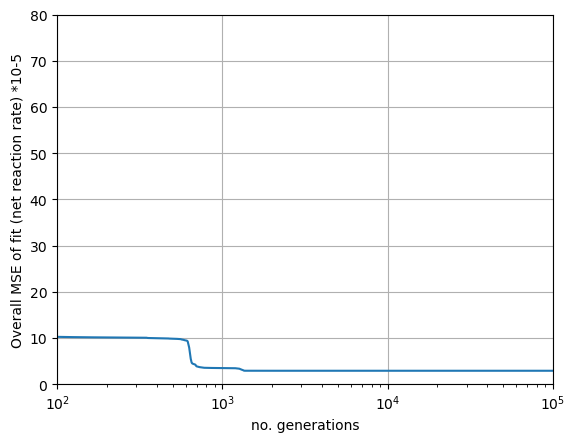

In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

-0.8001338869544546
-7.900489112391934
-1.113391709045031
-1.2016684174093273
-7.806458660873505
-1.5914963760689023
9.800715789138206
-1.1265028042383298
-7.292711171142081
5.995762925029994
-0.7348268091087183
-10.799676226354812
9.689887558983969
-0.340625179840554
-6.546670920653507
-0.8957025949717781
-0.5106230989979278
-0.4192910601219105
-7.100125840954593
11.120281551782845
4.912616893021159
-1.2923590001631153
-1.8096623681817217
-6.404724347408918
1.4402751070504525
-5.566236766953838
-1.30103


In [34]:
res.X

array([ -0.80013389,  -7.90048911,  -1.11339171,  -1.20166842,
        -7.80645866,  -1.59149638,   9.80071579,  -1.1265028 ,
        -7.29271117,   5.99576293,  -0.73482681, -10.79967623,
         9.68988756,  -0.34062518,  -6.54667092,  -0.89570259,
        -0.5106231 ,  -0.41929106,  -7.10012584,  11.12028155,
         4.91261689,  -1.292359  ,  -1.80966237,  -6.40472435,
         1.44027511,  -5.56623677,  -1.30103   ])

In [35]:
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]

for i in range(len (logkr)):
    print (logkr[i])

-0.8
-7.9
-1.1
-1.2
-7.8
-1.6
7.6
-1.1
-7.3
7.1
-0.7
-10.9
10.9
-0.3
-6.5
-0.9
-0.5
-0.4
-7.1
9.3
3.1
-1.3
-1.8
-6.4
1.0
-6.0


In [36]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-0.8: -0.8001338869544546
-7.9: -7.900489112391934
-1.1: -1.113391709045031
-1.2: -1.2016684174093273
-7.8: -7.806458660873505
-1.6: -1.5914963760689023
7.6: 9.800715789138206
-1.1: -1.1265028042383298
-7.3: -7.292711171142081
7.1: 5.995762925029994
-0.7: -0.7348268091087183
-10.9: -10.799676226354812
10.9: 9.689887558983969
-0.3: -0.340625179840554
-6.5: -6.546670920653507
-0.9: -0.8957025949717781
-0.5: -0.5106230989979278
-0.4: -0.4192910601219105
-7.1: -7.100125840954593
9.3: 11.120281551782845
3.1: 4.912616893021159
-1.3: -1.2923590001631153
-1.8: -1.8096623681817217
-6.4: -6.404724347408918
1.0: 1.4402751070504525
-6.0: -5.566236766953838
R-value: 0.990423058688522
R2: 0.9809378351819276


In [37]:
# Use stored solution
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]
y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = np.ndarray.tolist(res.X)
krseed10 = [-0.80013181, -7.90048847, -1.11338383, -1.2016605 , -7.80645167,
       -1.59150505,  9.81603994, -1.12645926, -7.29272683,  3.01480946,
       -0.73464256, -5.43156508,  1.34084111, -0.34042874, -6.5464869 ,
       -0.89572954, -0.51057425, -0.41909288, -7.1001741 ,  8.45618103,
        2.24852456, -1.29392462, -1.8086056 , -6.40533763,  0.97410692,
       -6.02811422, -1.30103   ]
krseed101 = [-0.80013144, -7.9004876 , -1.17177631, -1.39489053, -7.89879243,
       -1.62847078,  9.69401496, -8.25864676, -0.53116657,  8.98882325,
       -0.70823362, -8.74373977, 10.59956096, -0.31240191, -6.53641071,
       -0.88966638, -0.51391907, -0.41480046, -7.10523483,  8.02036774,
        1.80396098, -1.29538882, -1.80083098, -6.40825943,  0.8617771 ,
       -6.1418051 , -1.30103   ]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

for i in range(len (meankr)):
    print (meankr[i])

R-value: 0.9753461073751468
R2: 0.9513000291718515
-0.8001323789848183
-7.900488394130645
-1.1328506163483436
-1.2660731491364425
-7.837234253624501
-1.6038240686896341
9.770256896379403
-3.503869608079443
-5.038868190380693
5.999798545009997
-0.7259009963695728
-8.32499369211827
7.2100965429946555
-0.33115194328018466
-6.543189510217836
-0.8936995049905927
-0.5117054729993092
-0.41772813337397013
-7.101844923651531
9.198943440594283
2.9883674776737195
-1.2938908133877052
-1.8063663160605739
-6.406107135802973
1.0920530423501507
-5.912052028984612


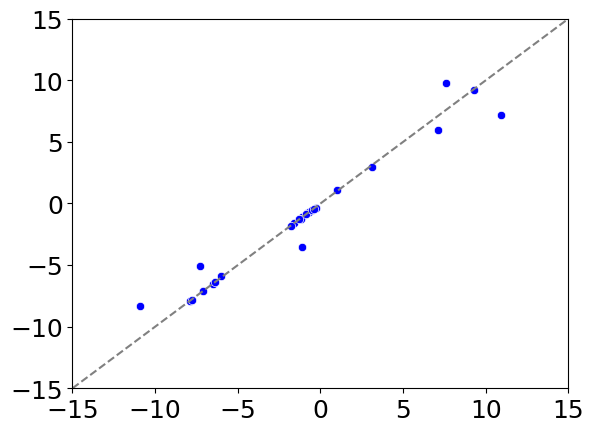

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()